<a href="https://colab.research.google.com/github/Nov05/Google-Colaboratory/blob/master/20240217_pong_REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **\<TOP>**  

* changed by nov05 on 2024-02-17  
* check [the code walkthrough video](https://youtu.be/eKIjPrQWIgg)  
* gym atari: https://di-engine-docs.readthedocs.io/en/latest/13_envs/atari.html  
* refer to [the post](https://medium.com/@joachimiak.krzysztof/learning-to-play-pong-with-pytorch-tianshou-a9b8d2f1b8bd)  
* [Understanding the Impact of Entropy on Policy Optimization](https://proceedings.mlr.press/v97/ahmed19a/ahmed19a.pdf)  

---

* issue solved: JSAnimation `anim.save(filename, fps=20, clear_temp=False) TypeError: save() got an unexpected keyword argument 'clear_temp'.` solution: [stay with matplotlib 2.1.0](https://github.com/qutip/qutip/issues/798) or [change the python file](https://github.com/Nov05/JSAnimation?tab=readme-ov-file#-changed-by-nov05)
* issue solved: JSAnimation [`AttributeError: 'HTMLWriter' object has no attribute '_temp_names'`](https://teratail.com/questions/280493)  

In [1]:
%%capture
# !pip install gdown
!gdown --no-check-certificate --folder https://drive.google.com/drive/folders/1WmZIxLWj-snpWTmVUQ-SBQoGu-mtoTGi
!mv ./pong/* ./
!rm -r pong
# !pip install JSAnimation ## don't use this version
!git clone https://github.com/Nov05/JSAnimation.git ## my updated version
!pip install git+file:///content/JSAnimation
!rm -r ./JSAnimation
!pip install 'gym[atari]'
!pip install gym[accept-rom-license]
## Successfully installed AutoROM.accept-rom-license-0.6.1 autorom-0.4.2
!pip install progressbar
## Ctrl+M. restart the runtime now

In [1]:
## Ctrl+F10 run after
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

(I strongly recommend you to try this notebook on the Udacity workspace first before running it locally on your desktop/laptop, as performance might suffer in different environments)

In [2]:
# install package for displaying animation
# !pip install JSAnimation
# custom utilies for displaying animation, collecting rollouts and more
import pong_utils
%matplotlib inline
# check which device is being used.
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ", device)

using device:  cpu


In [4]:
# render ai gym environment
import gym
import time
# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')
print("List of available actions: ", env.unwrapped.get_action_meanings())
# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [30]:
!which python
!python --version ## 3.10.12
print(f"gym {gym.__version__}") ## 0.25.2
import matplotlib
print(f"matplotlib {matplotlib.__version__}") ## 3.7.1 in colab. 2.1.0 is required in the original notebook.

/usr/local/bin/python
Python 3.10.12
gym 0.25.2
matplotlib 3.7.1


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


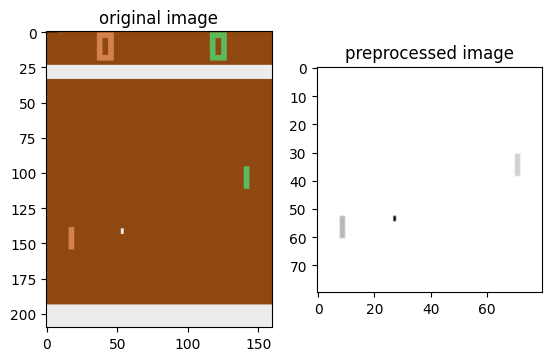

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()

# Policy

## Exercise 1: Implement your policy

Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)

class Policy(nn.Module):

    def __init__(self, input_dim=(2,80,80), n_actions=1, *args, **kwargs):
        super(Policy, self).__init__()
    ########
    ## Modify your neural network
    ########
        # 80x80 to (outputsize x outputsize)
        # outputsize = (inputsize - kernel_size + stride)/stride
        # (round up if not an integer)
        # self.conv = nn.Conv2d(2, 1, kernel_size=4, stride=4) ## output = 20x20 here
        # self.size=1*20*20
        # self.fc = nn.Linear(self.size, 1) ## 1 fully connected layer
        # self.sig = nn.Sigmoid()
        self.conv = nn.Sequential(
            ## 2x80x80 to 4x38x38; 2 channels from the stacked frame
            nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False),
            nn.ReLU(),
            ## 4x38x38 to 16x9x9
            nn.Conv2d(4, 16, kernel_size=6, stride=4),
            nn.ReLU(),
        )
        conv_out_size = self.get_conv_out_size(input_dim) ## 16*9*9
        ## or self.fc = nn.LazyLinear()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions),
            nn.Sigmoid(),
        )

    def forward(self, x):
    ########
    ## Modify your neural network
    ########
        # x = F.relu(self.conv(x))
        # x = x.view(-1, self.size) ## flatten the tensor
        # return self.sig(self.fc(x))
        x = self.conv(x)
        x = self.fc(x)
        return x

    def get_conv_out_size(self, input_dim):
        return np.prod(self.conv(torch.zeros(*input_dim)).data.shape)

policy=Policy().to(device) ## use your own policy!
# policy=pong_utils.Policy().to(device) ## use the solution policy

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



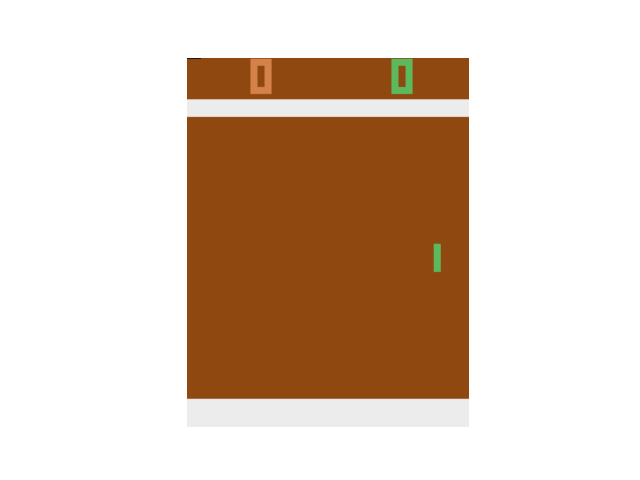
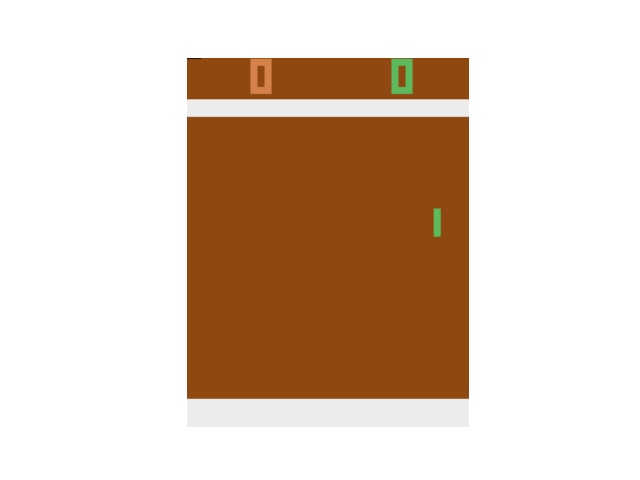
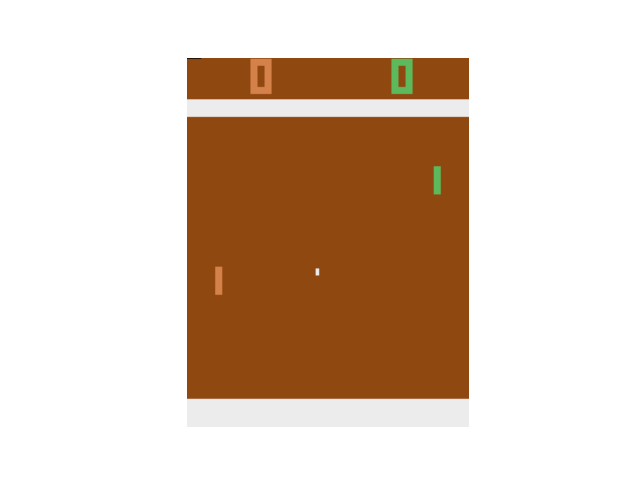
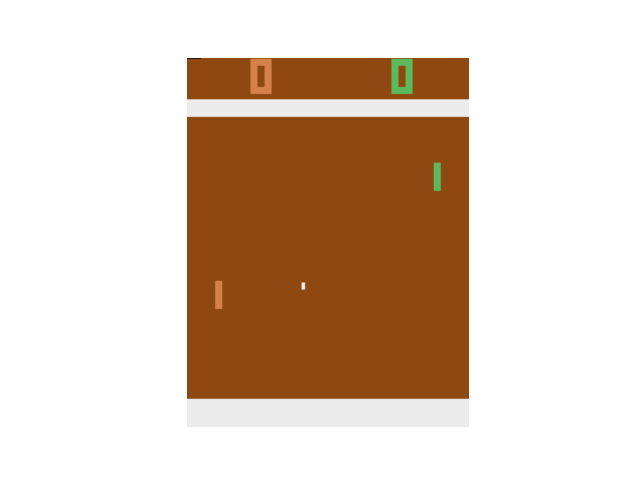
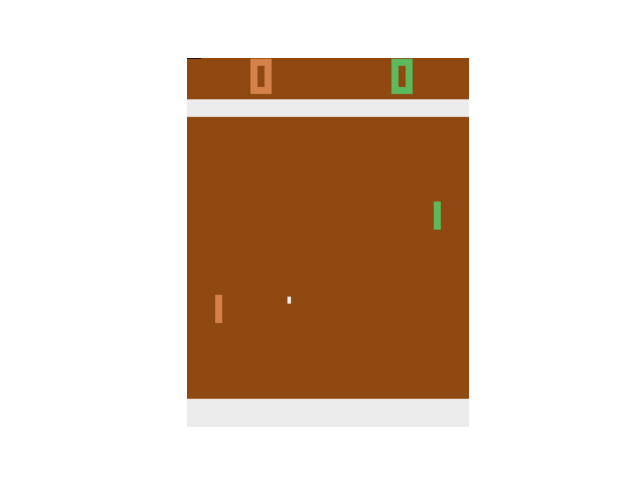
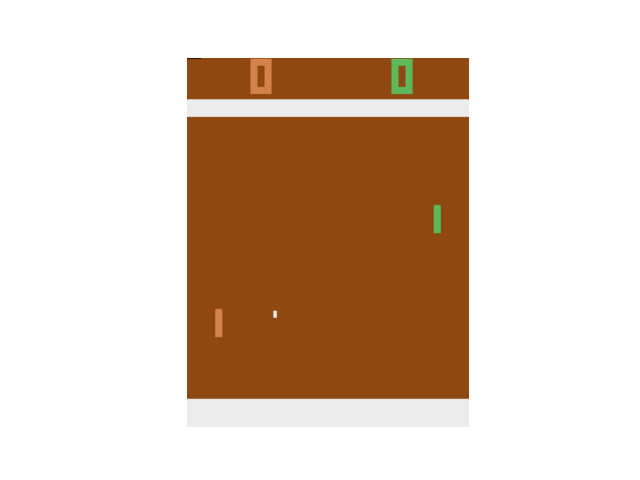
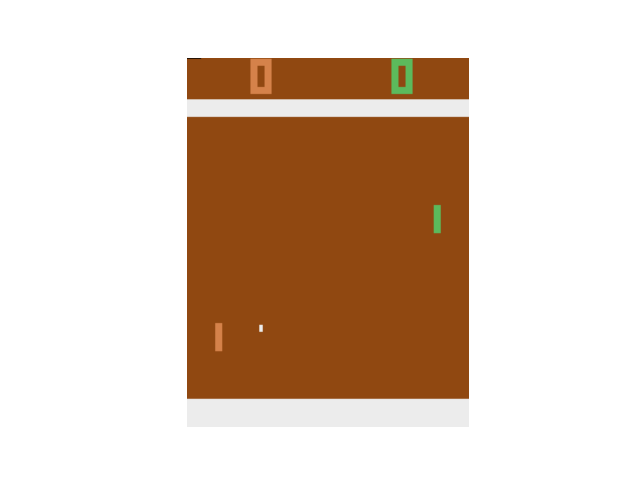
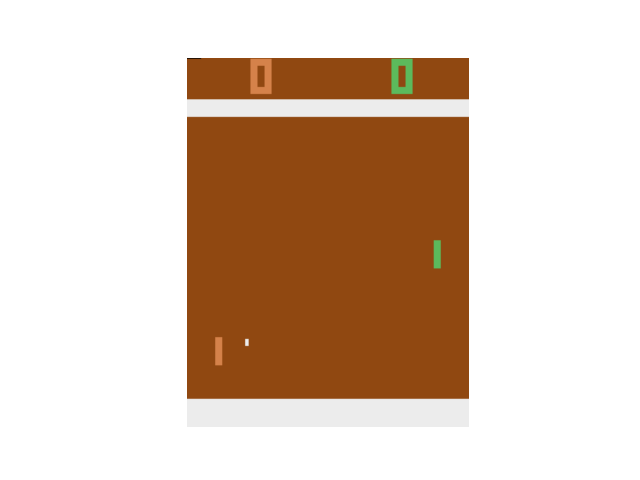
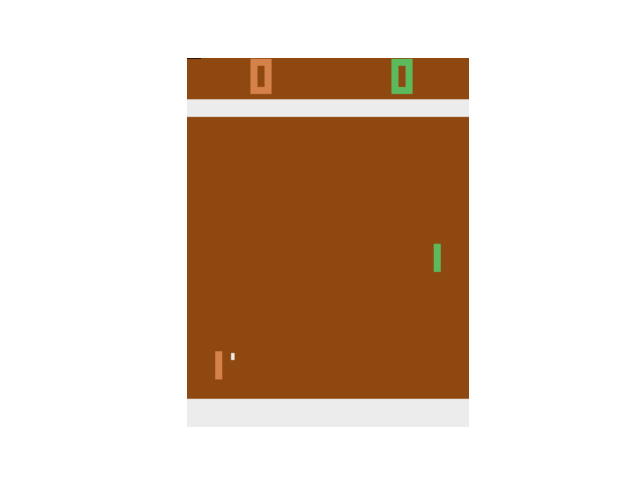
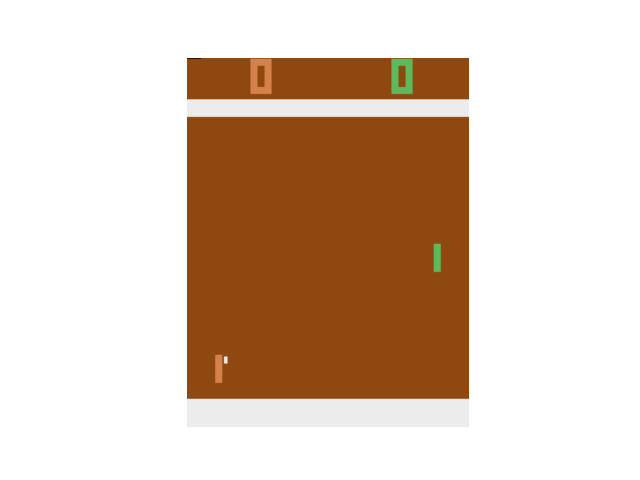
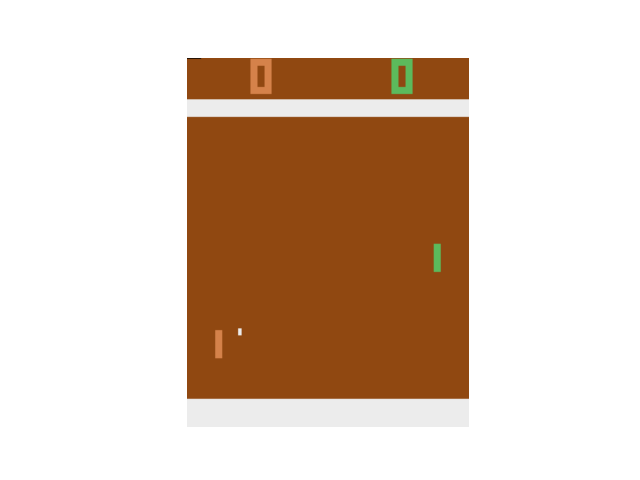
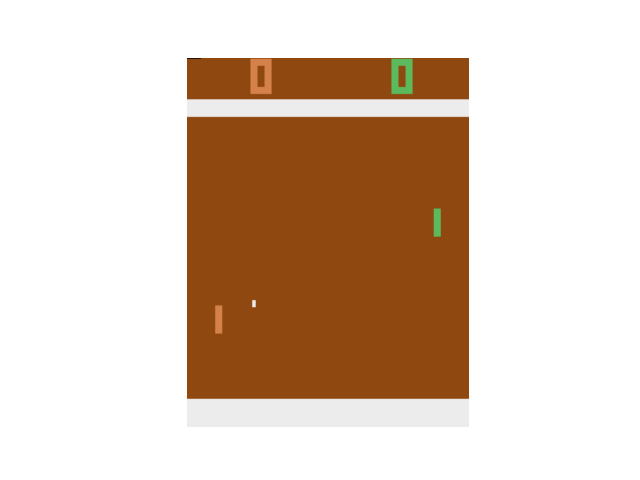
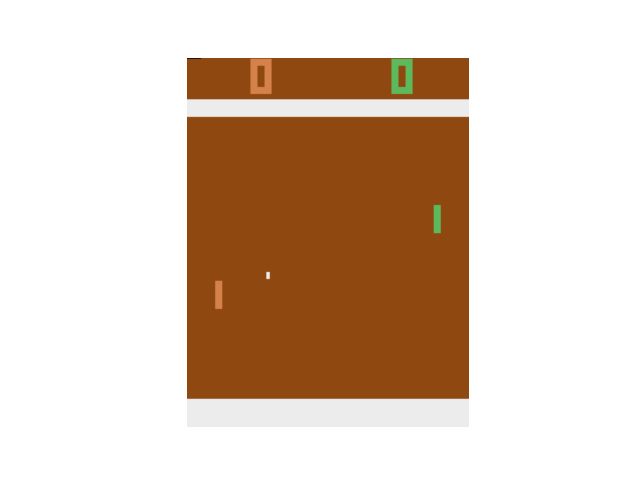
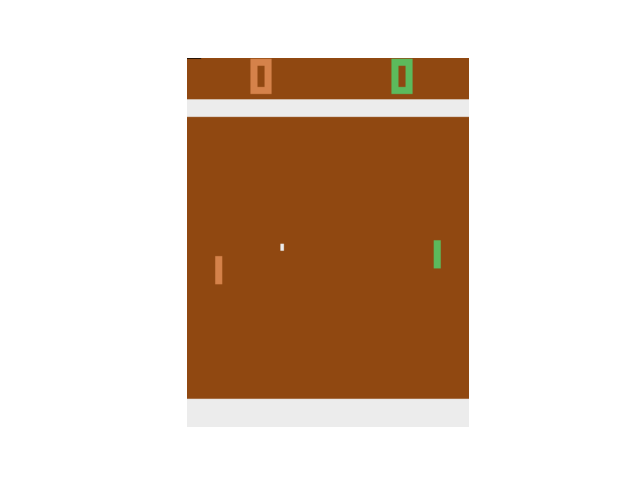
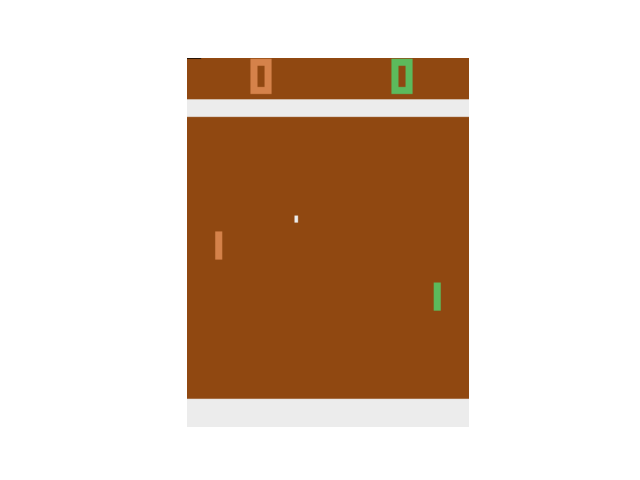
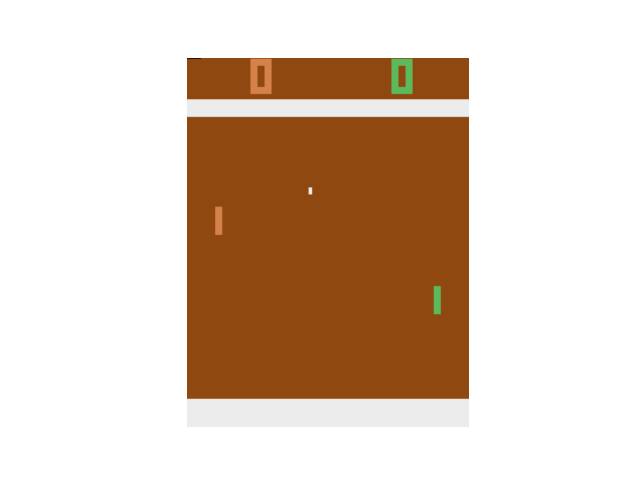
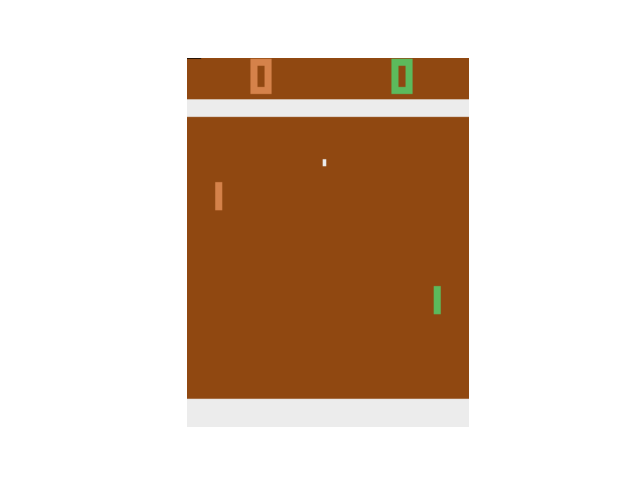
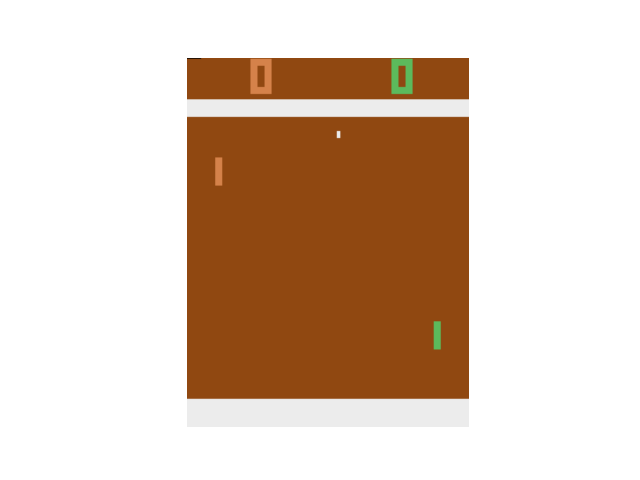
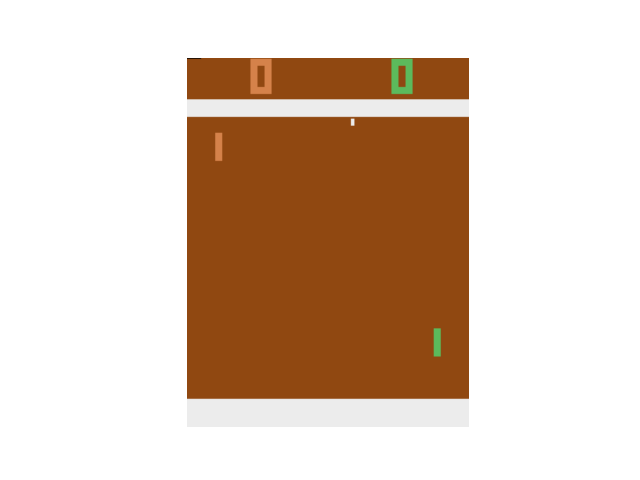
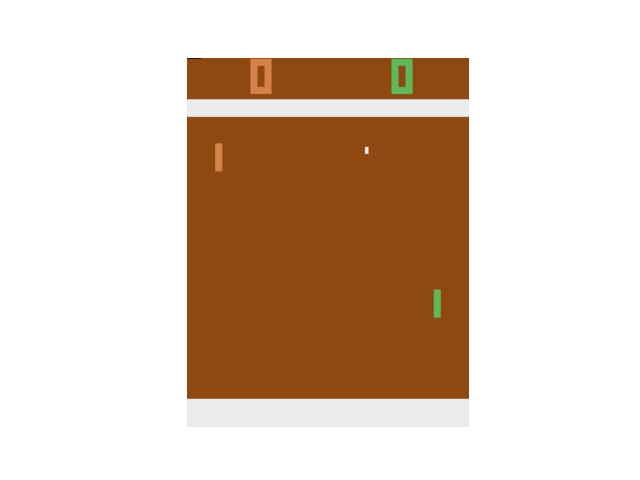
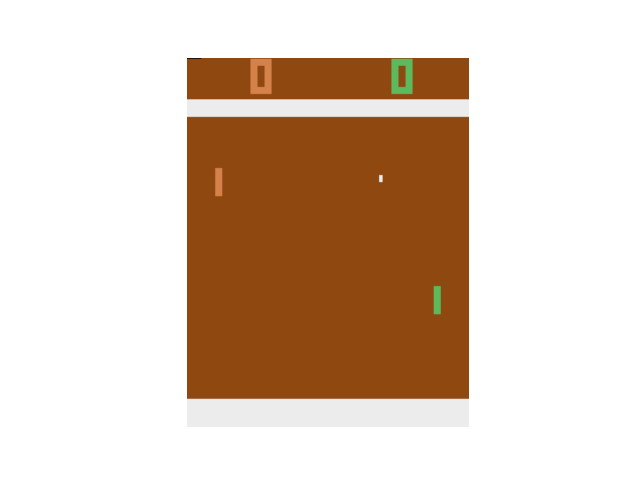
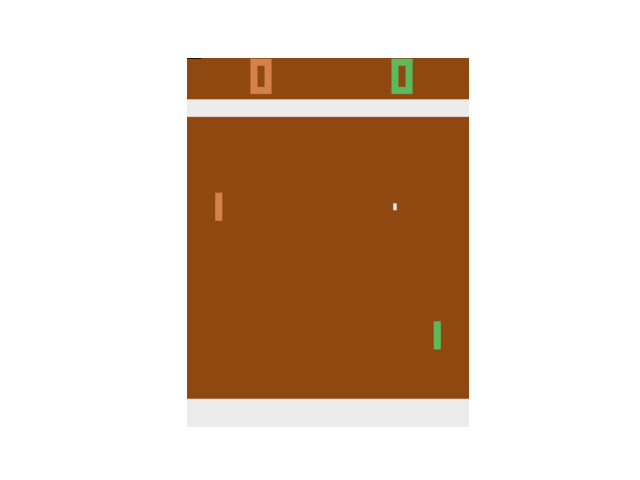
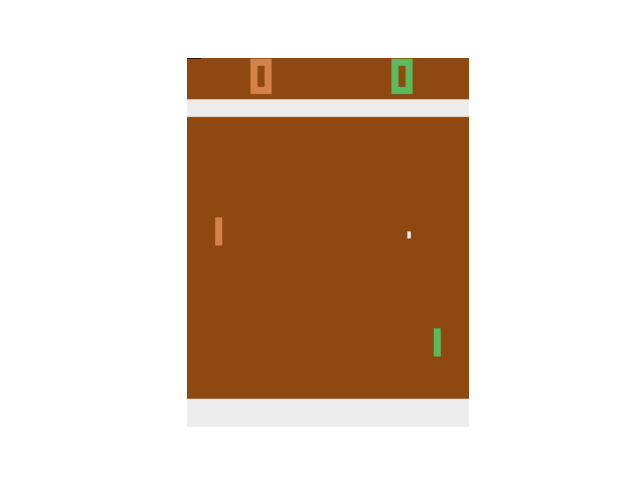
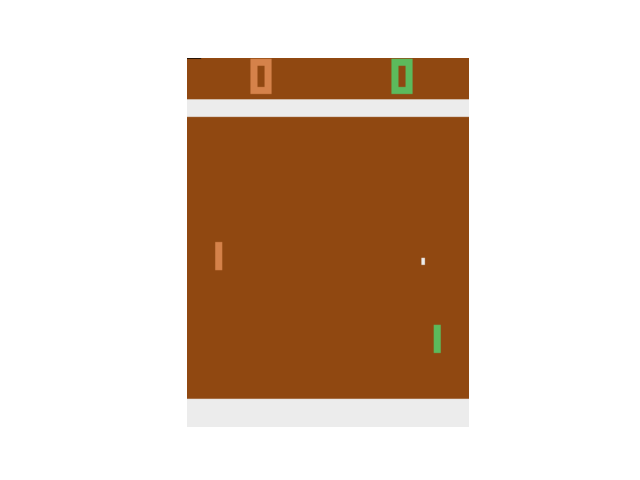
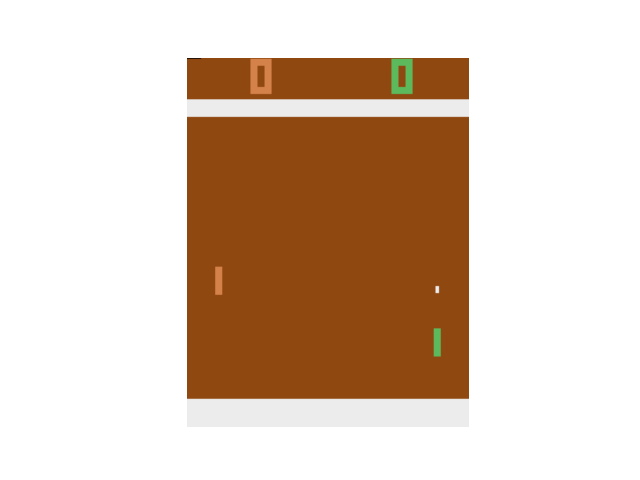
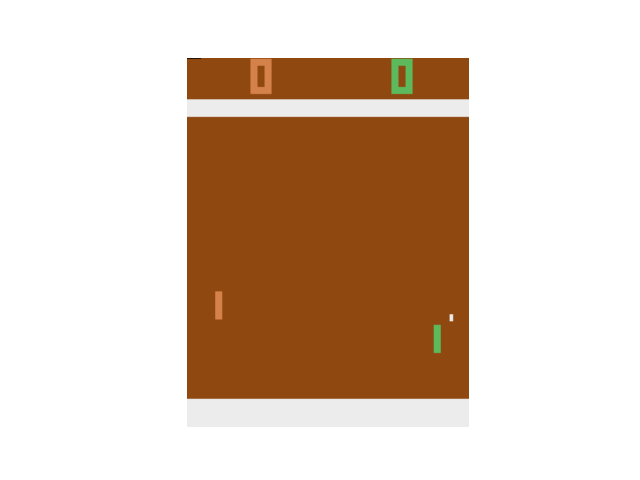
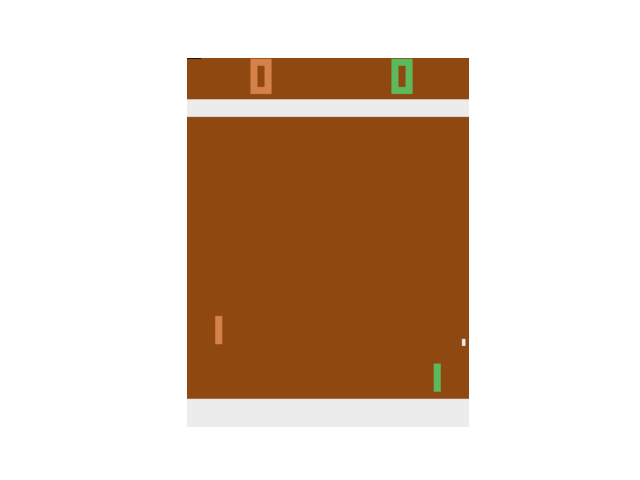
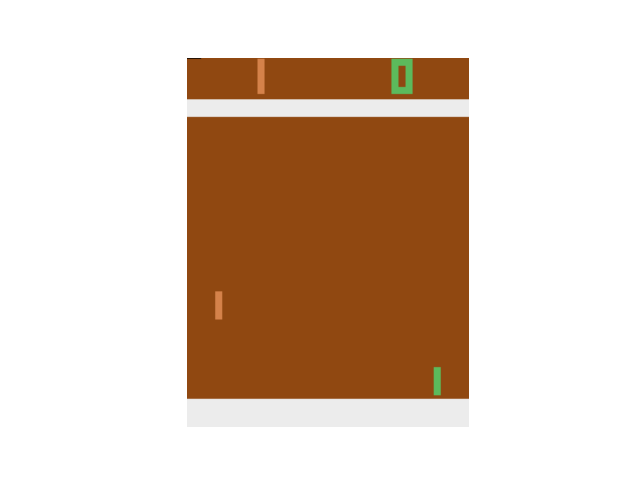
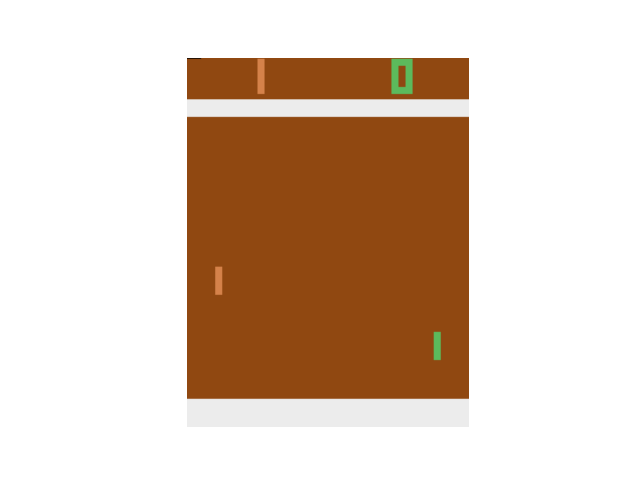
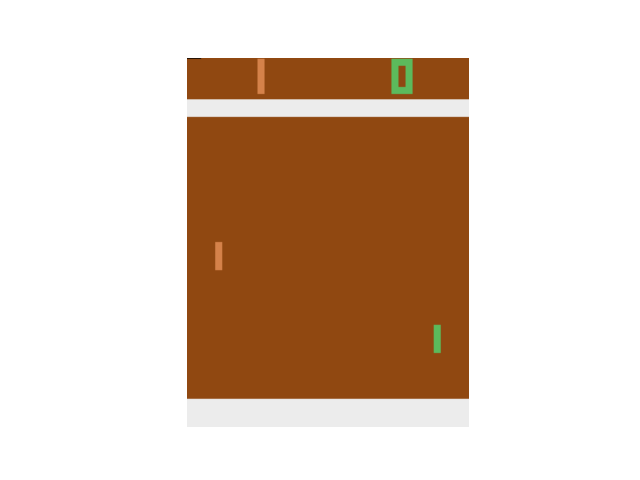
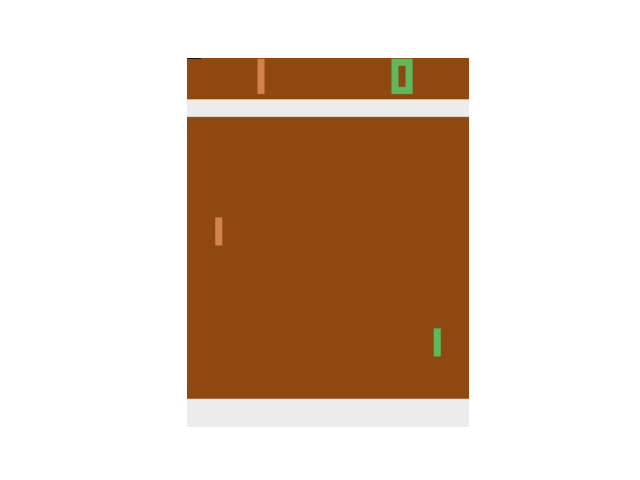
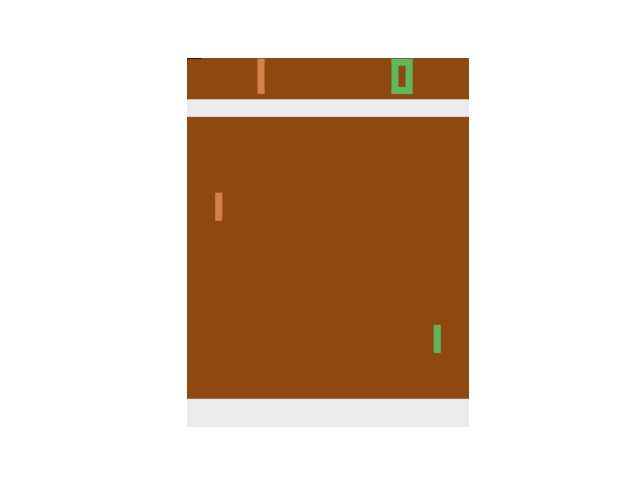
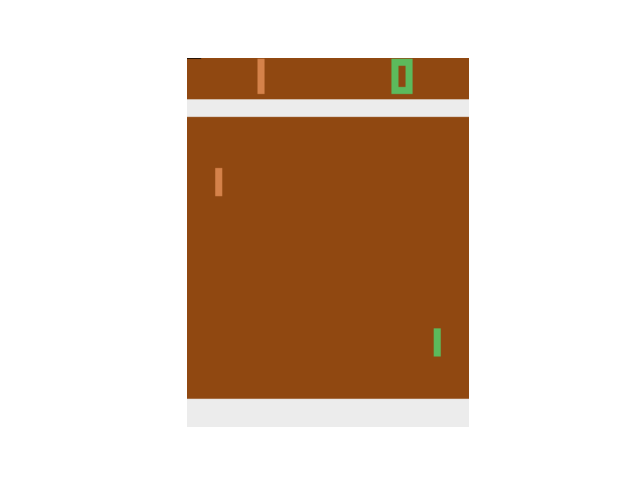
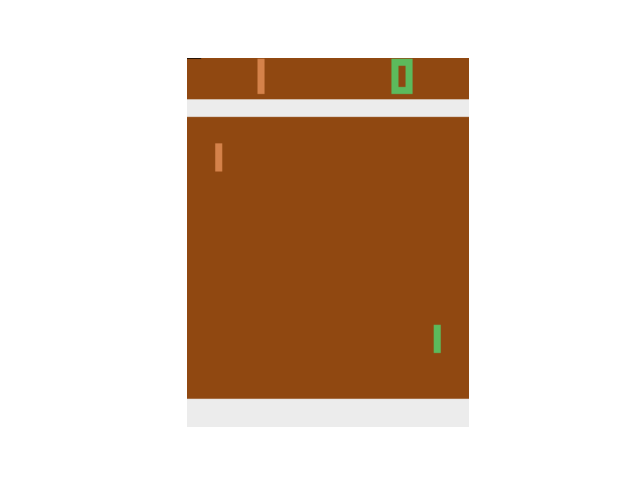
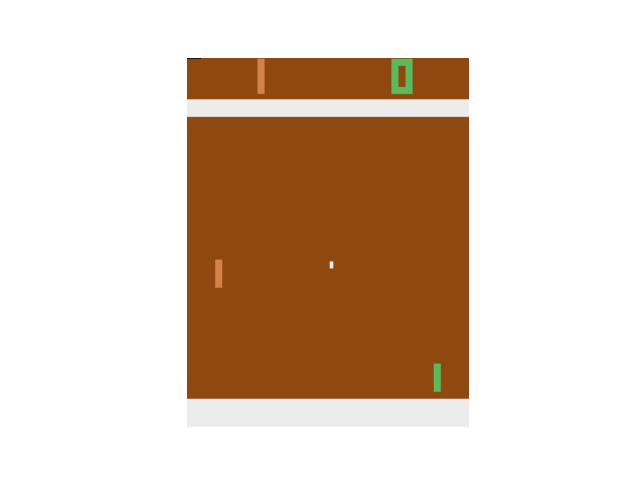
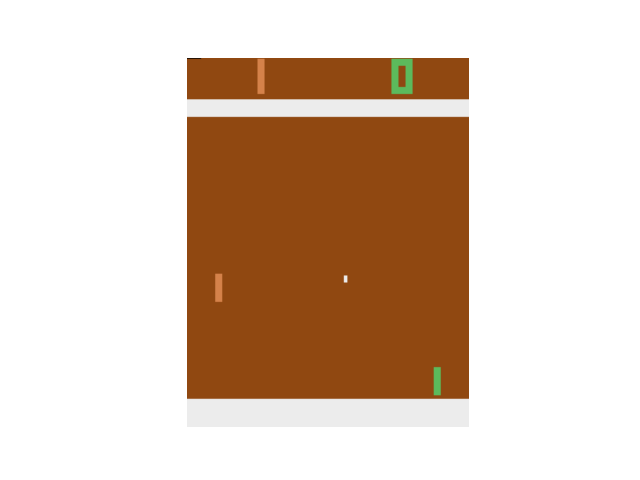
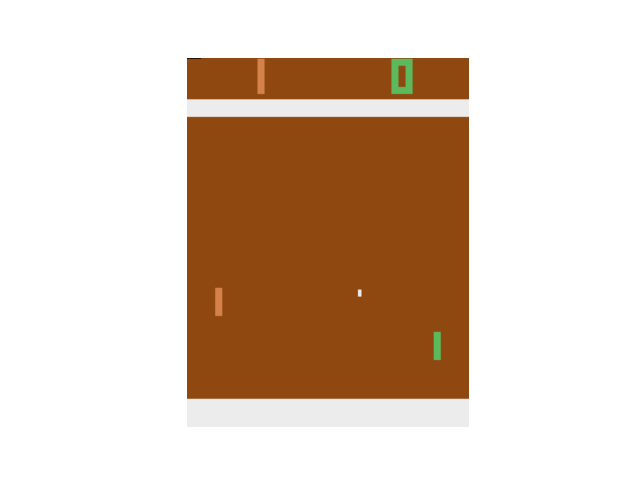
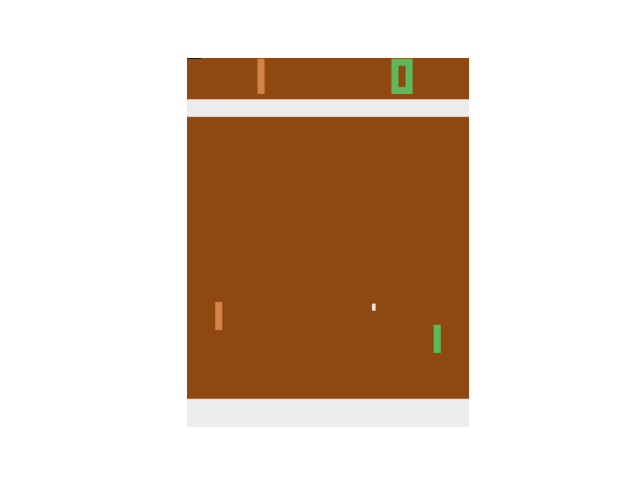
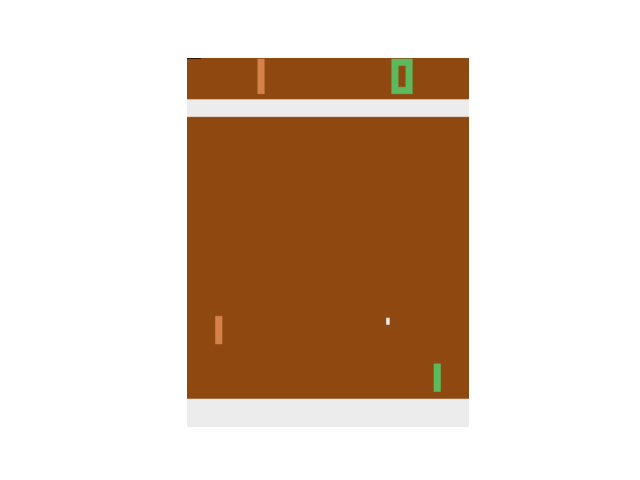
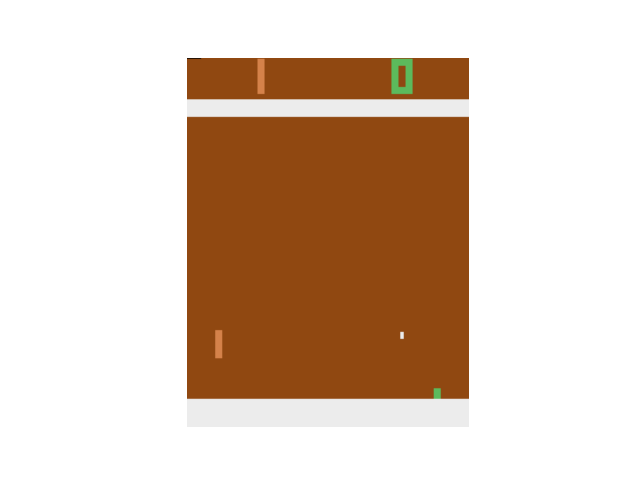
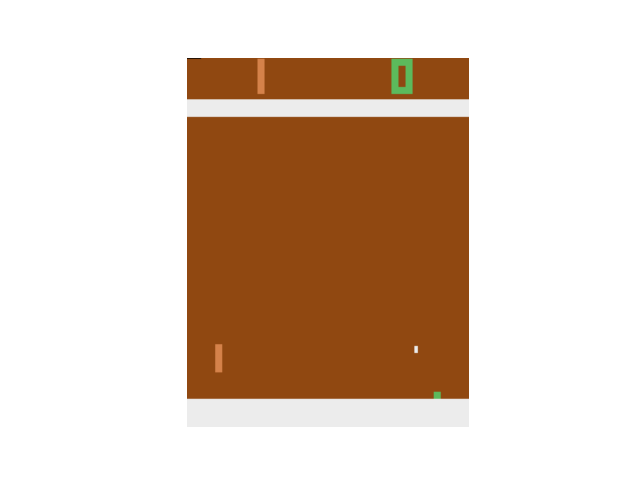
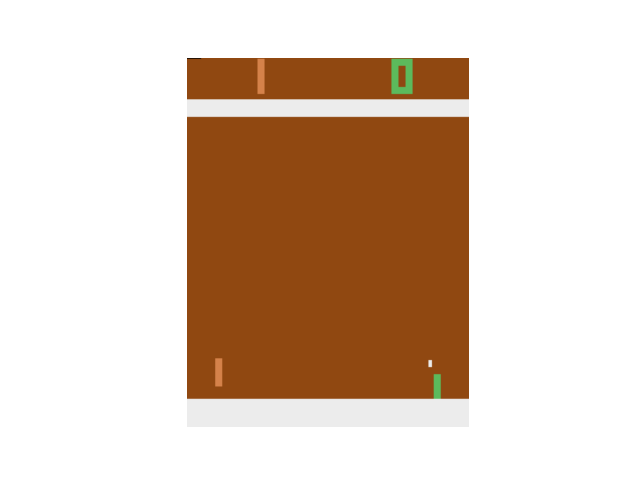
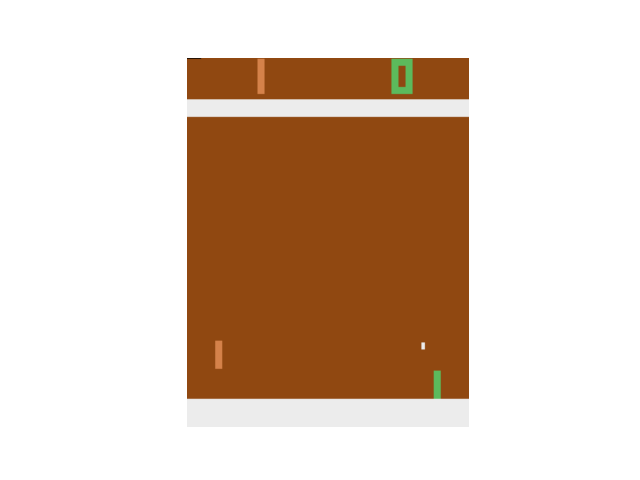
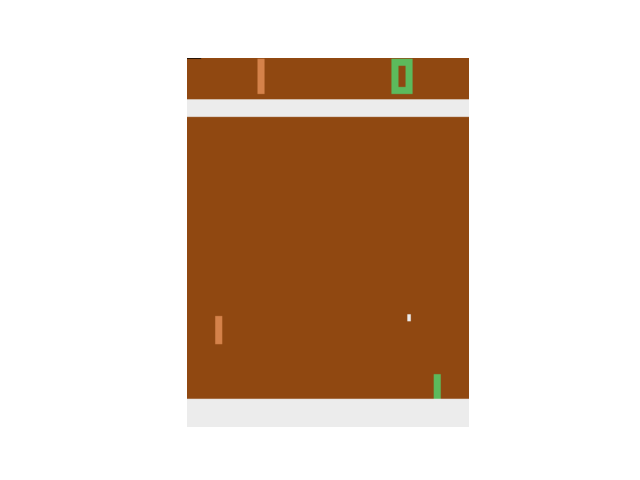
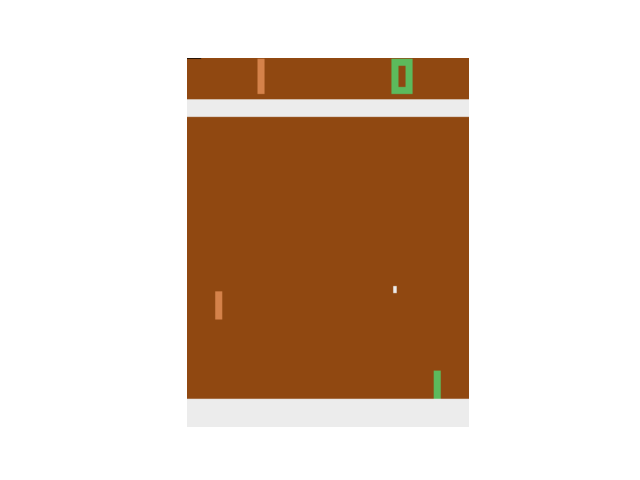
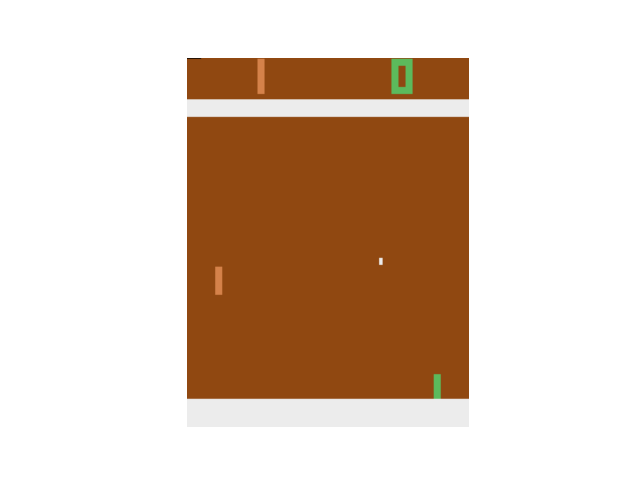
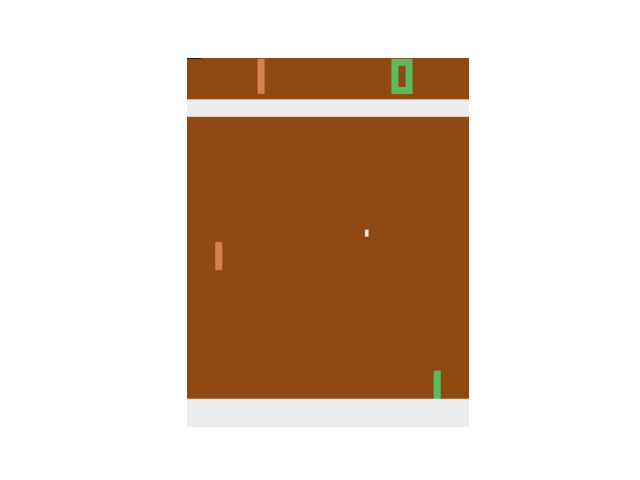
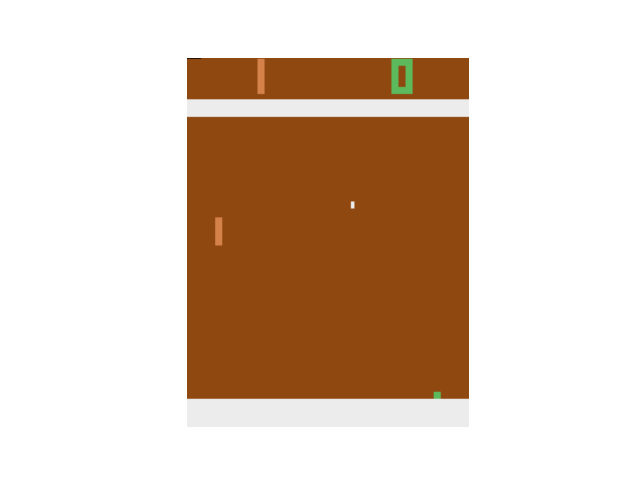
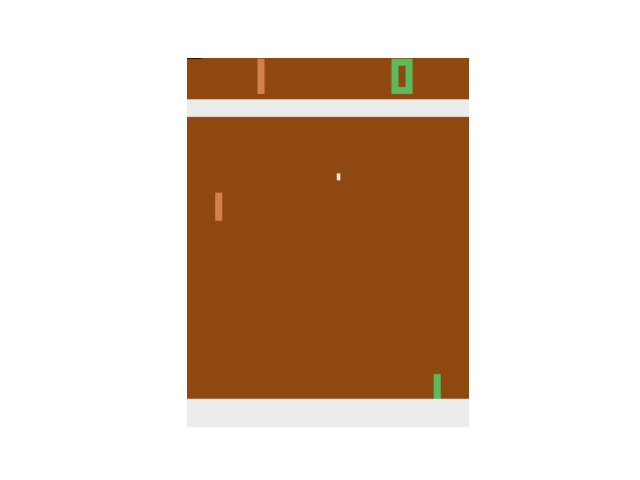
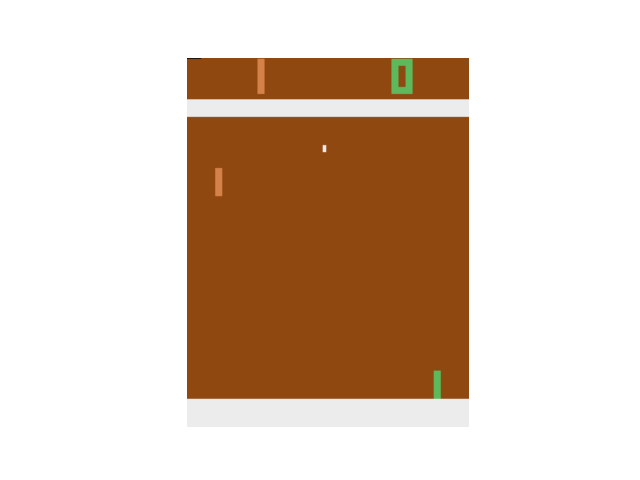
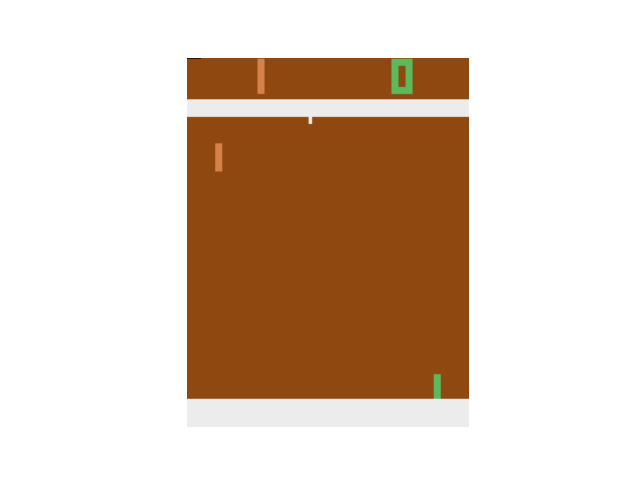
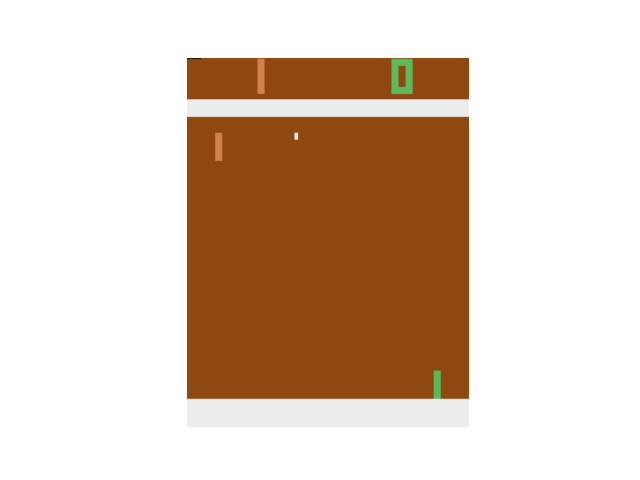
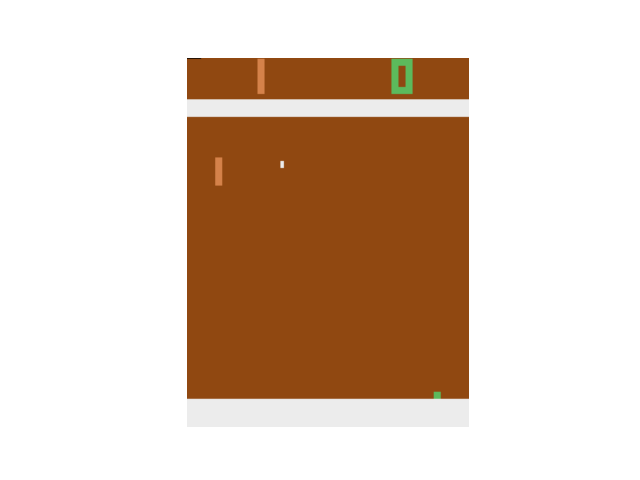
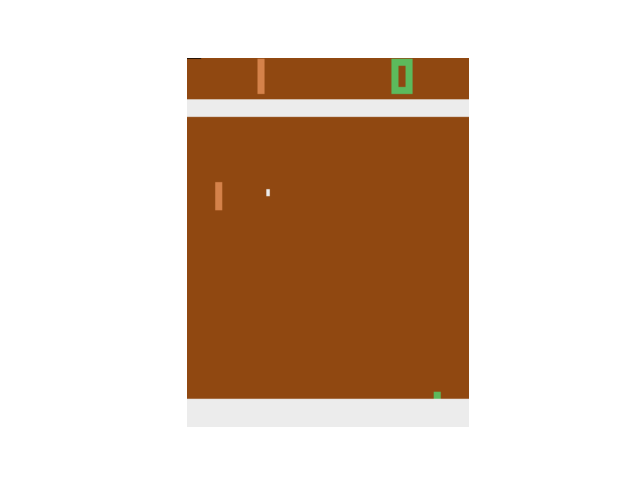
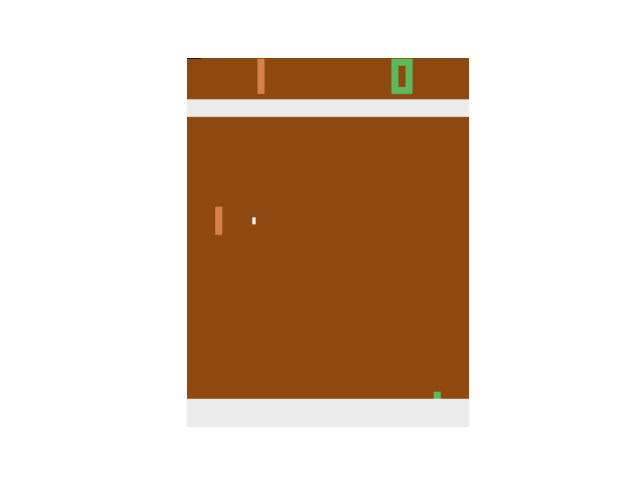
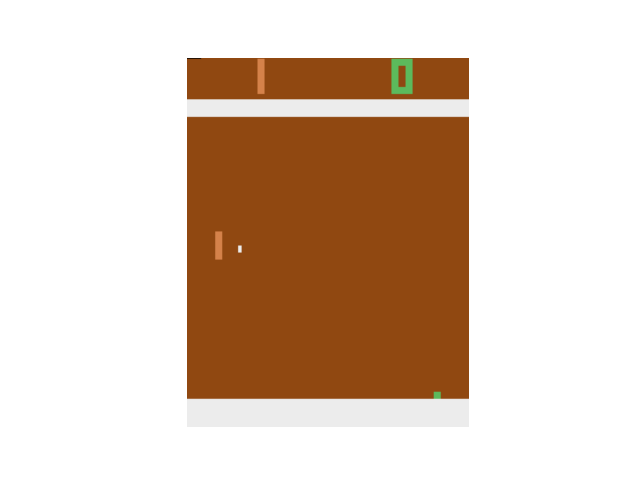
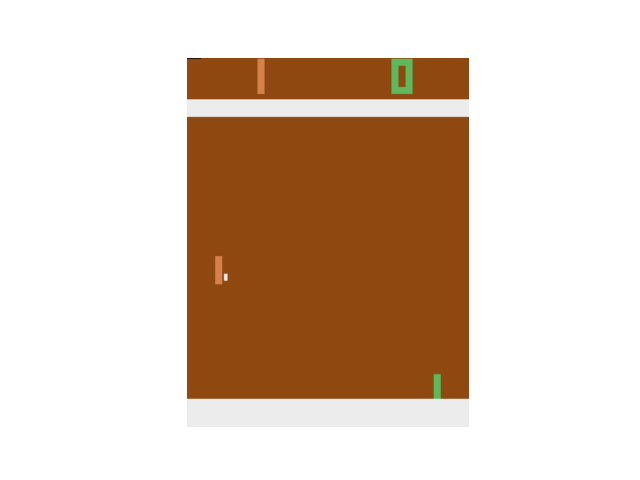
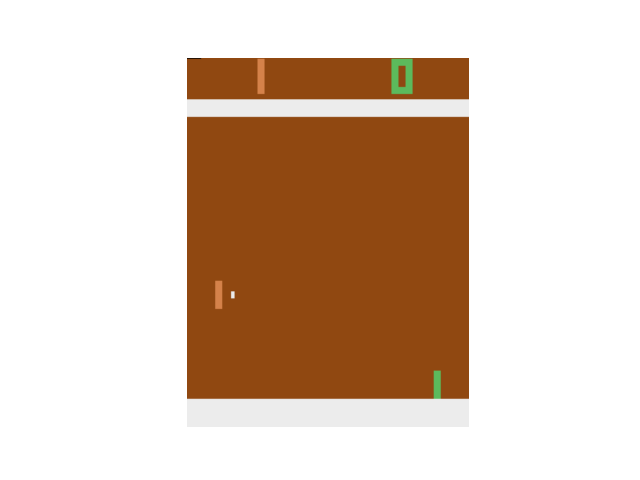
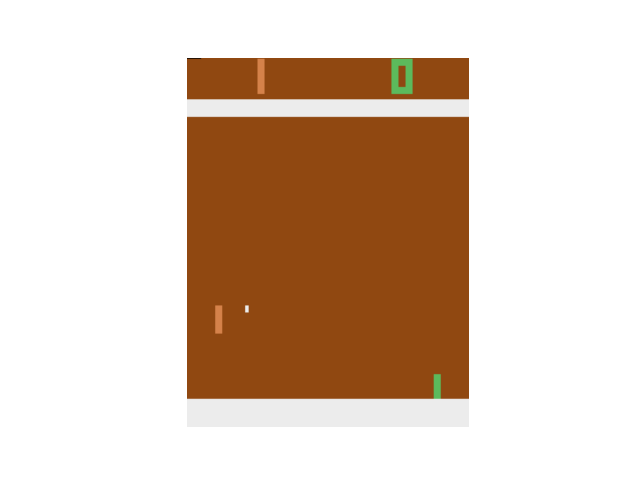
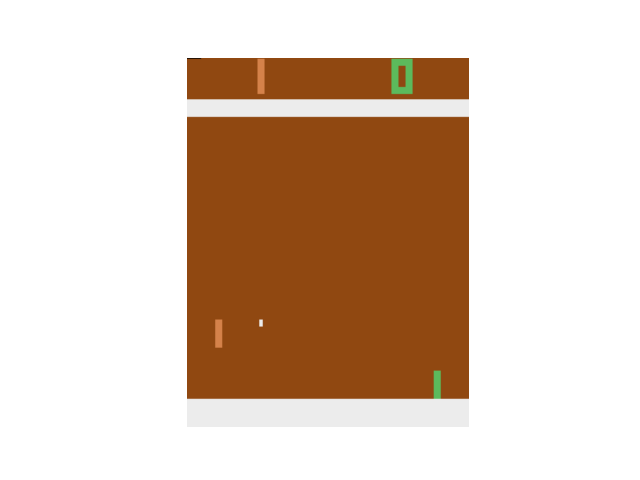
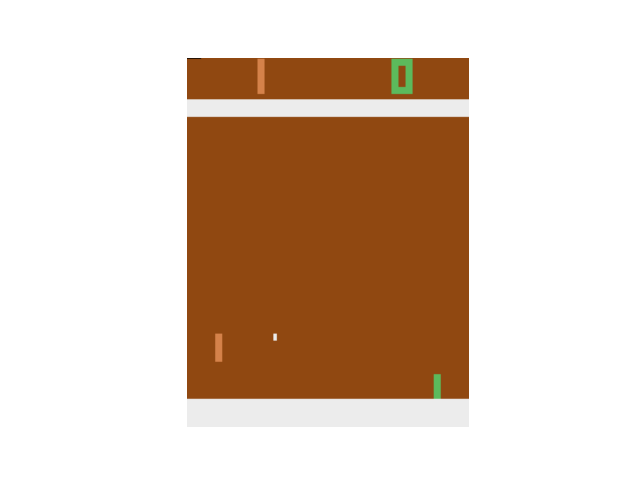
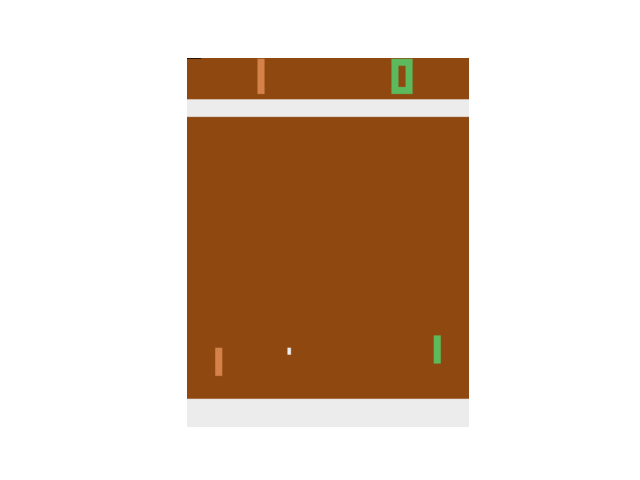
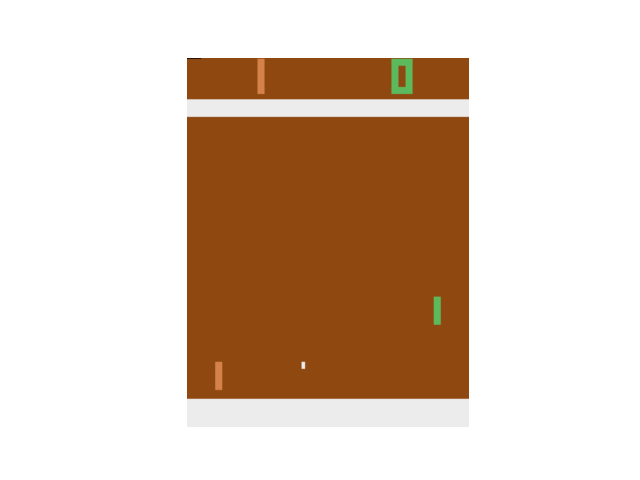
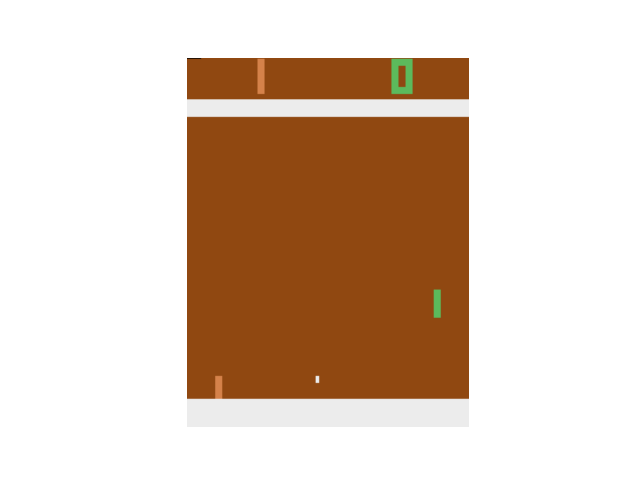
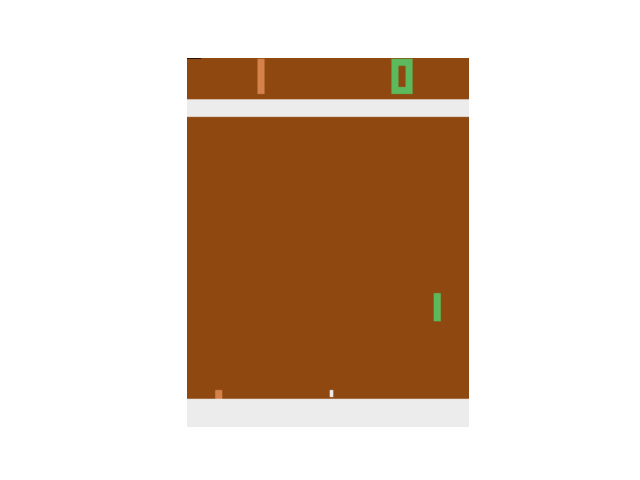
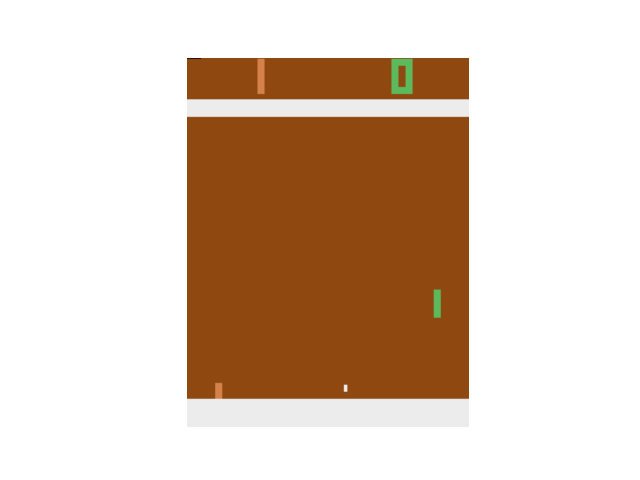
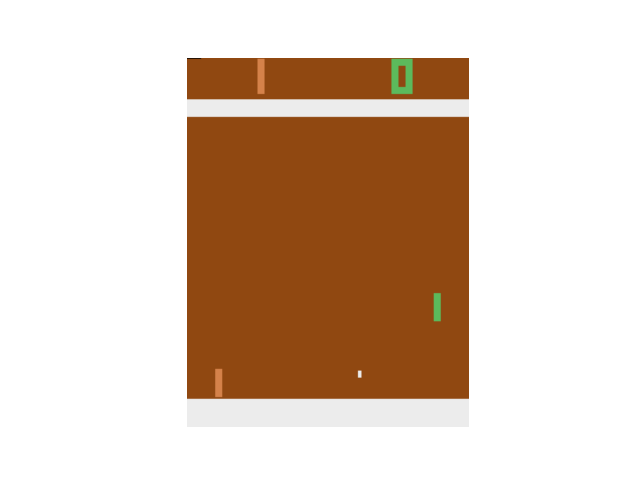
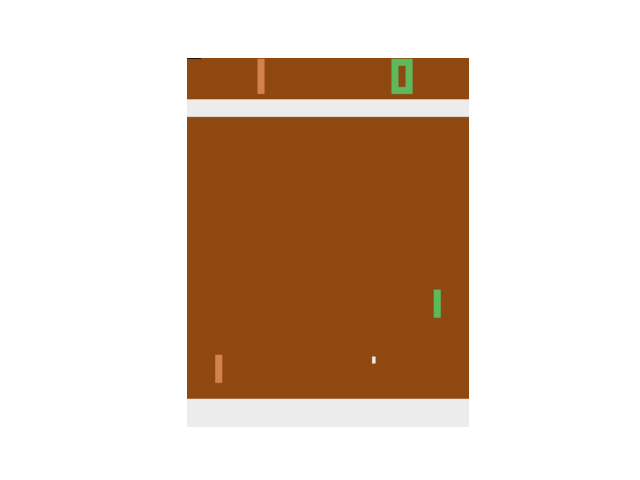
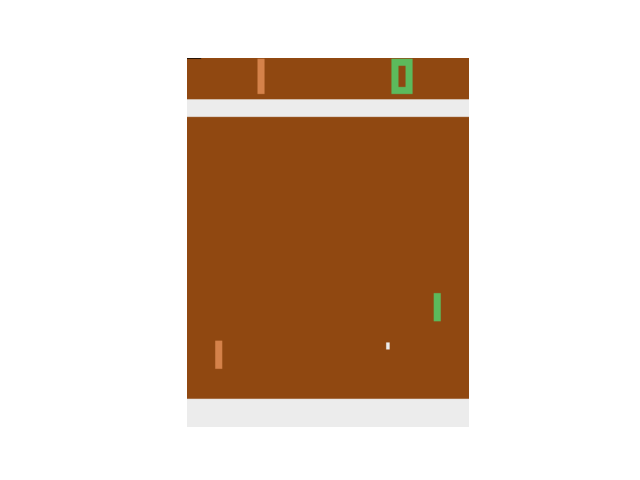
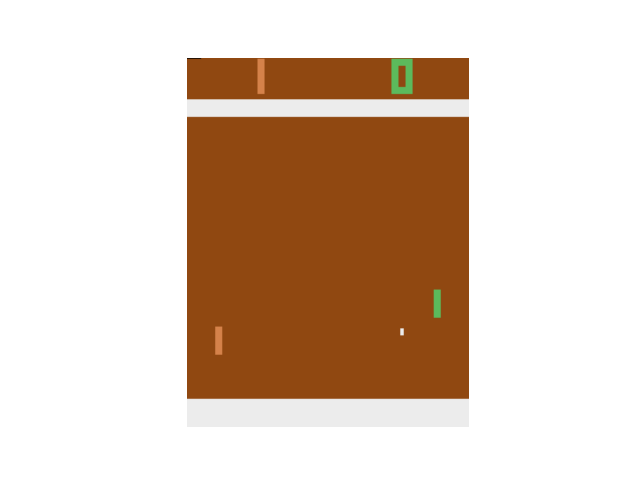
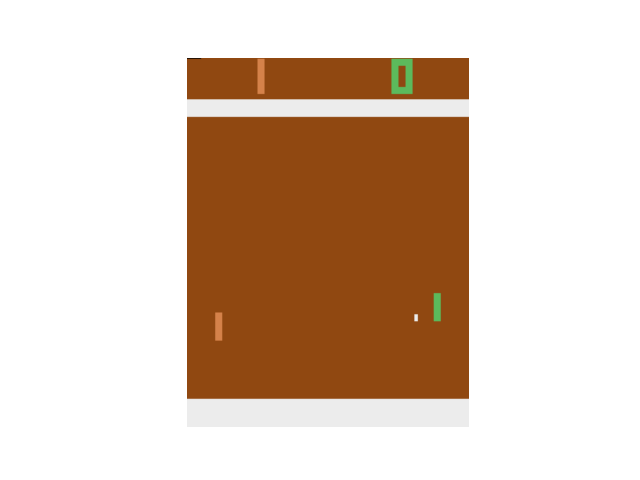
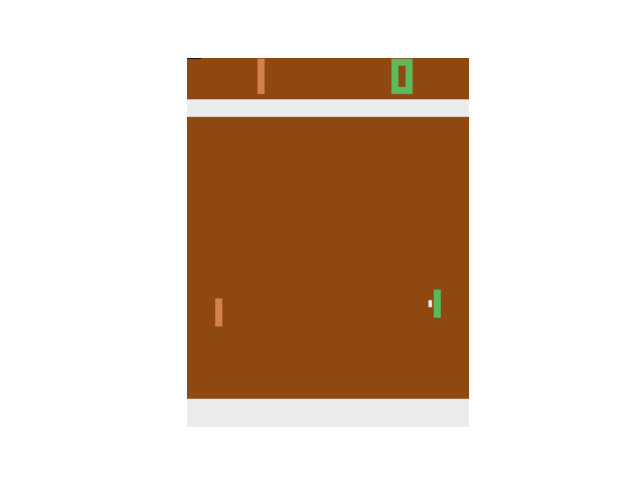
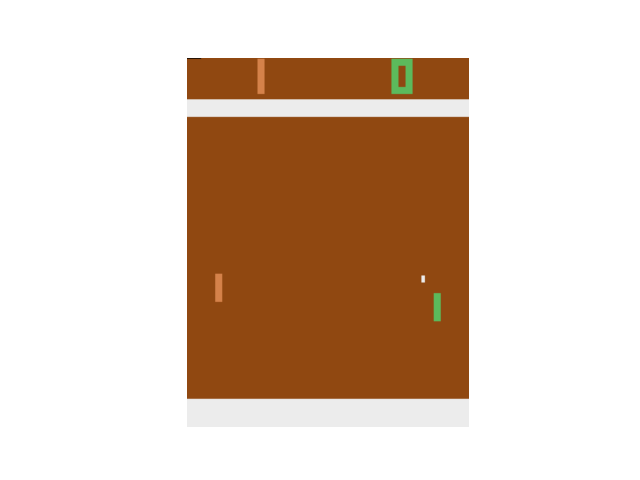
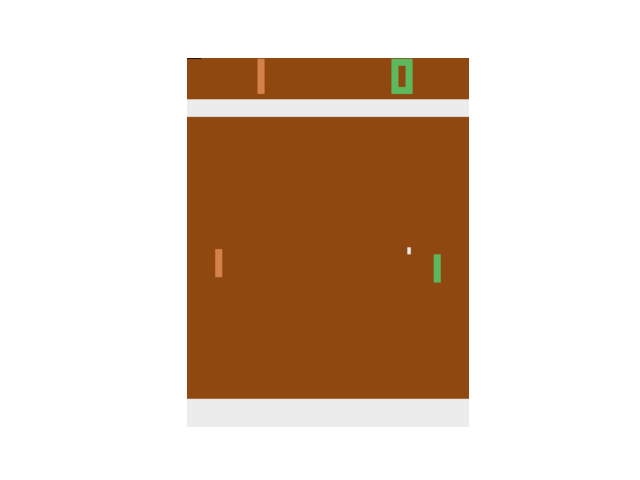
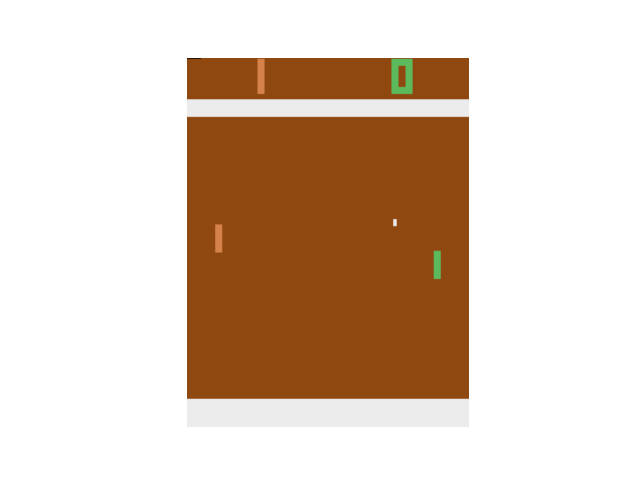
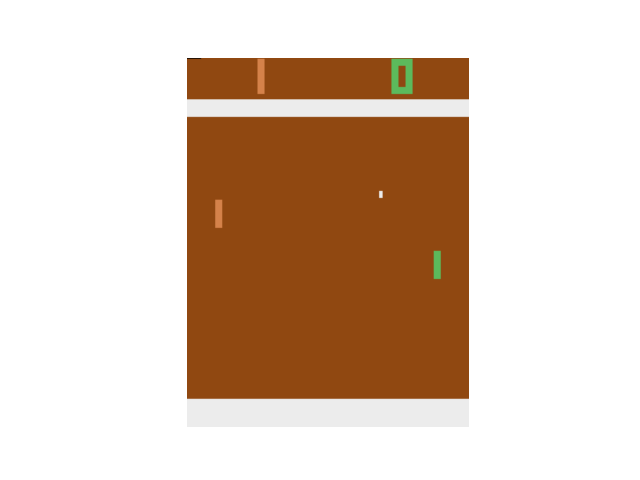
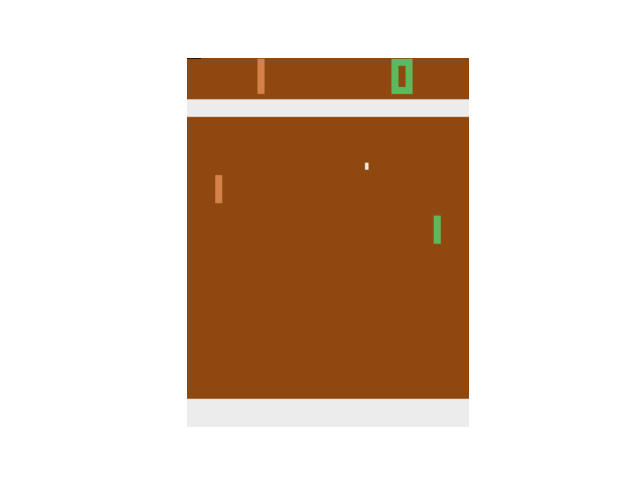
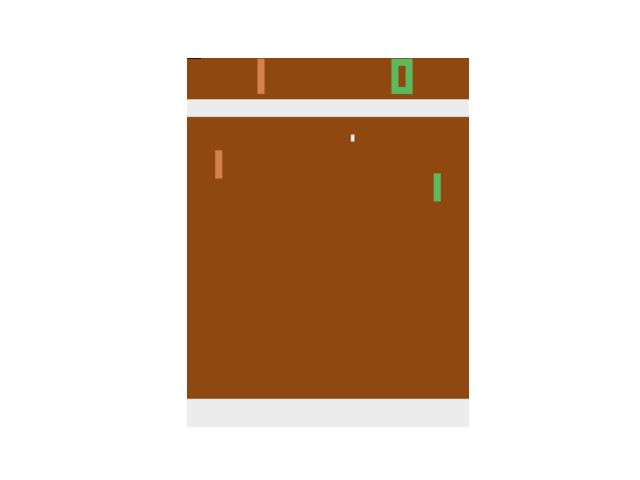
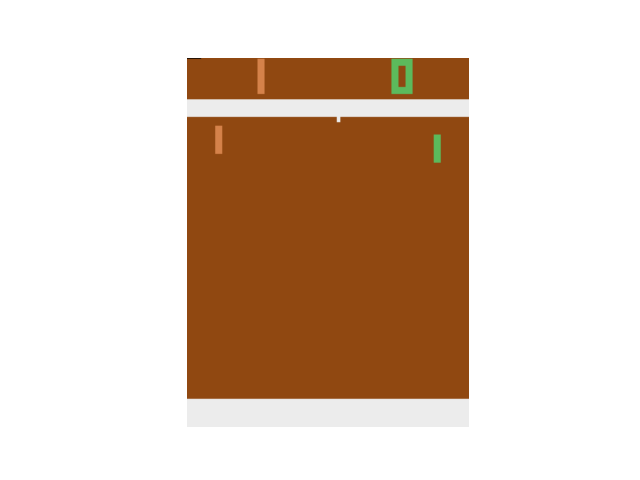
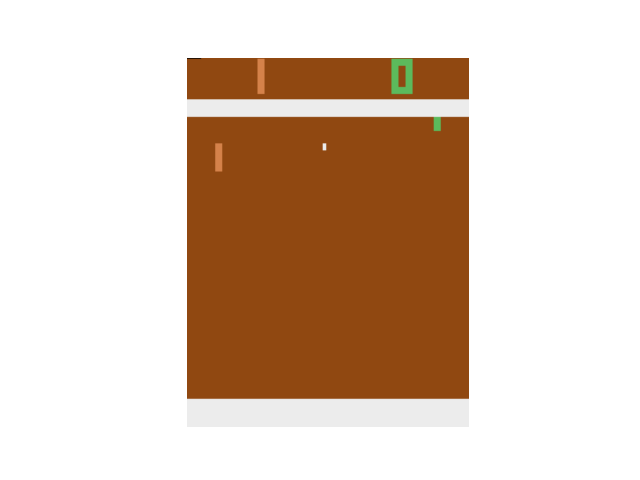
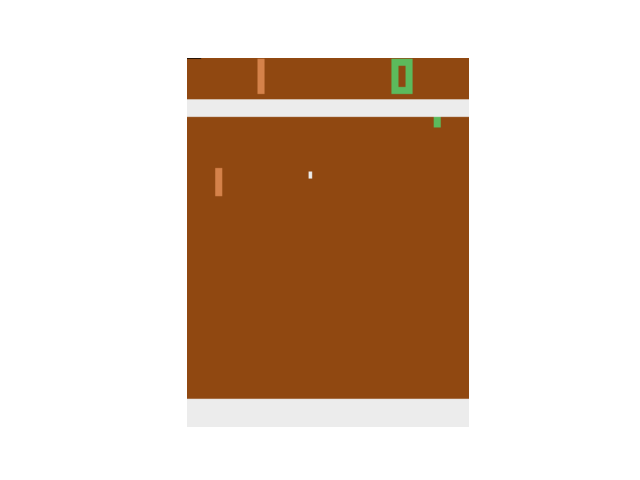
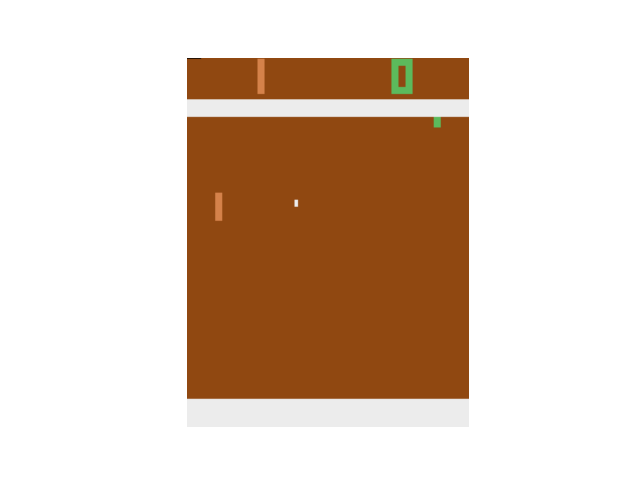
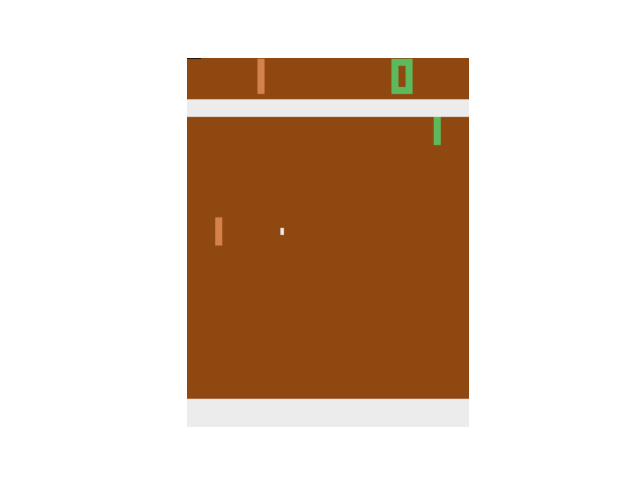
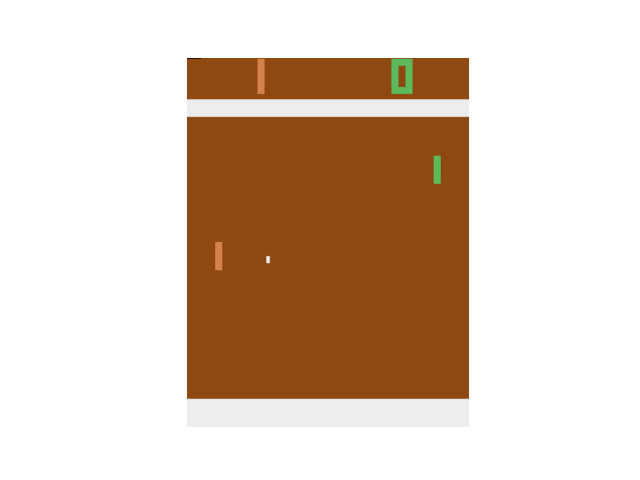
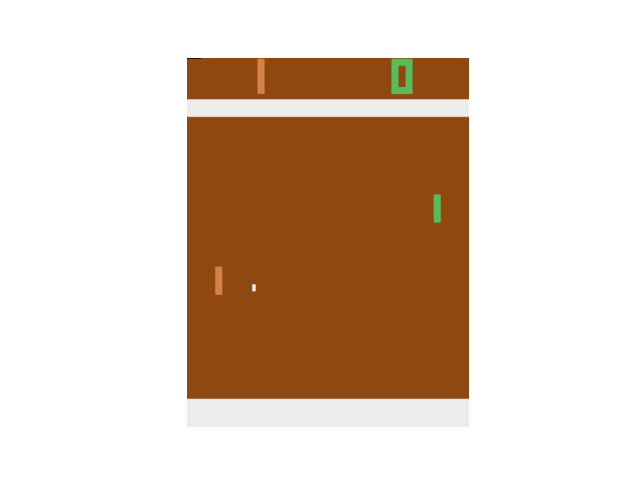
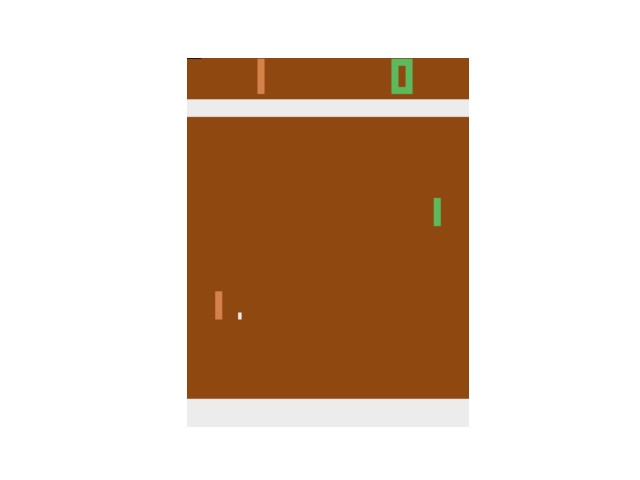
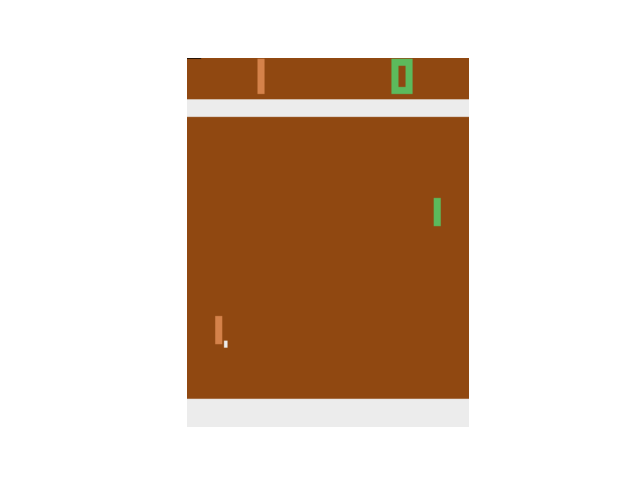
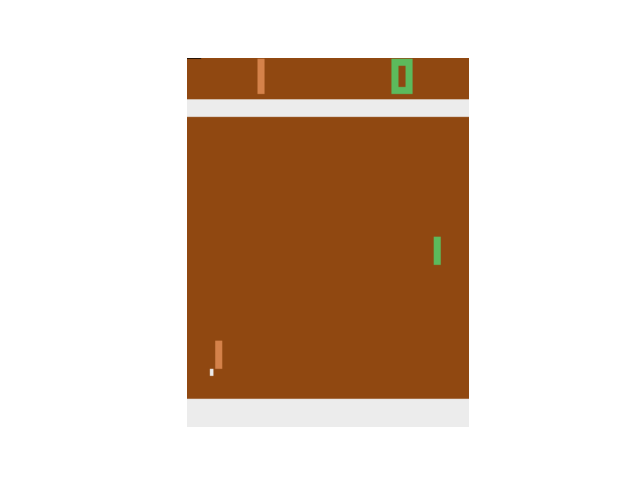
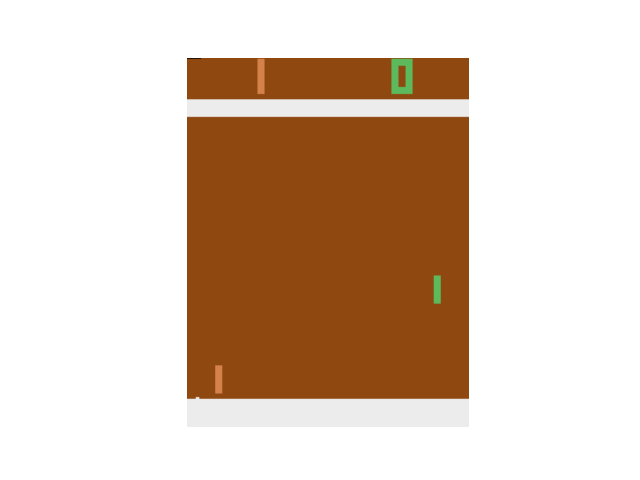
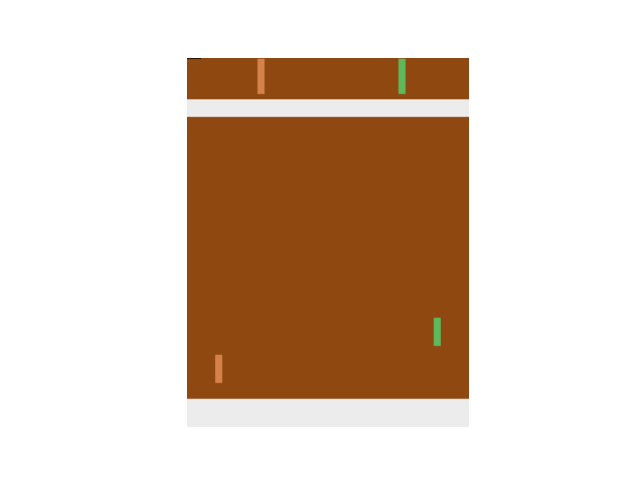
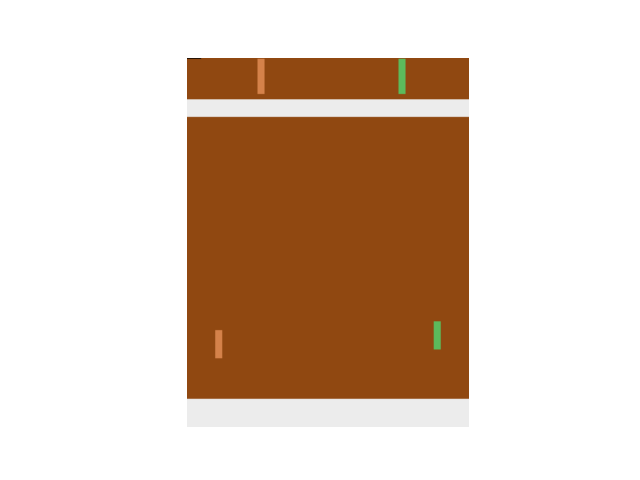
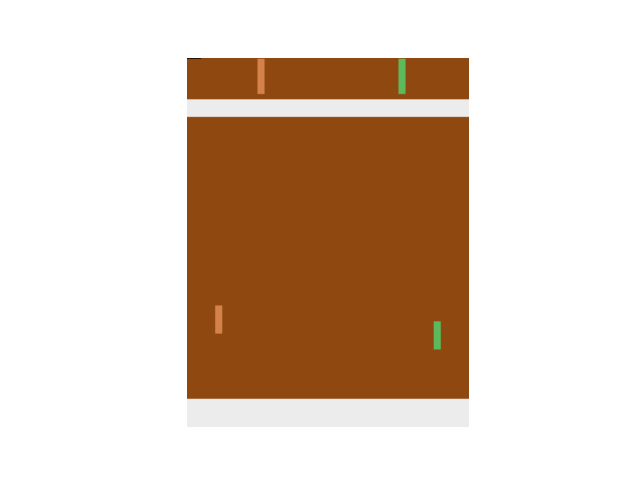
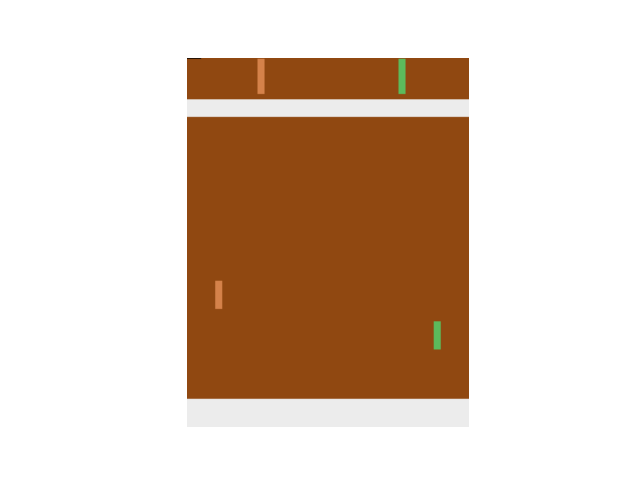
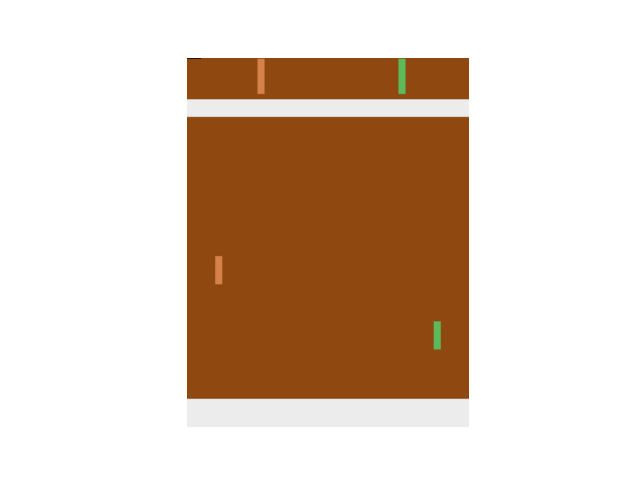
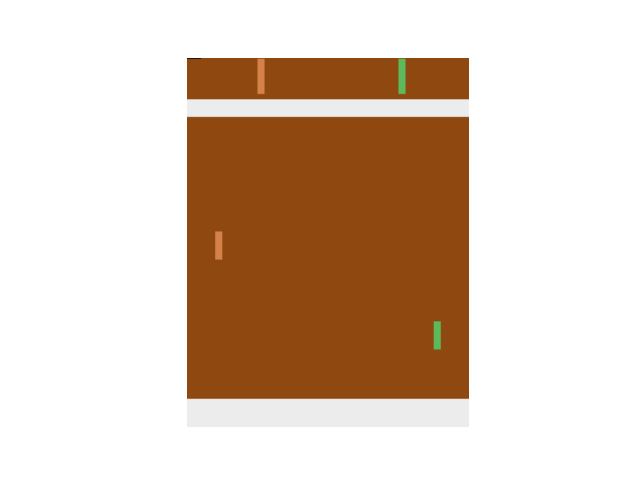
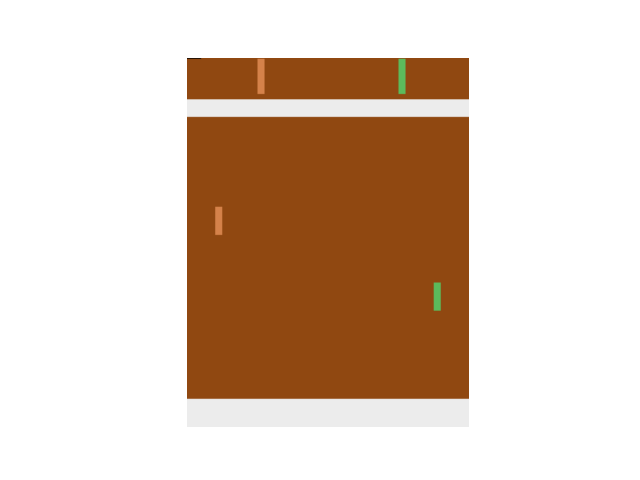
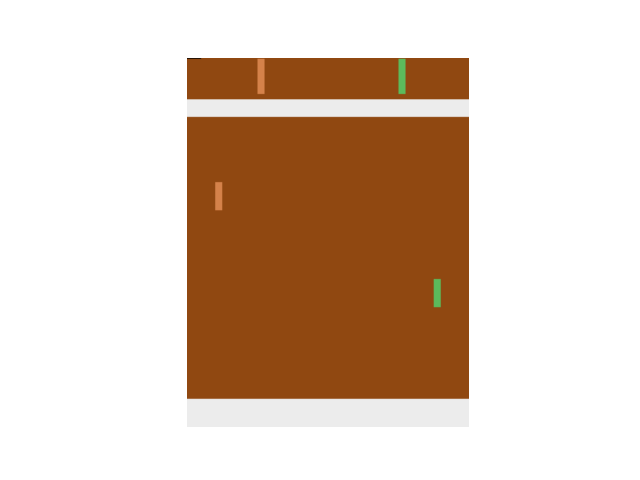
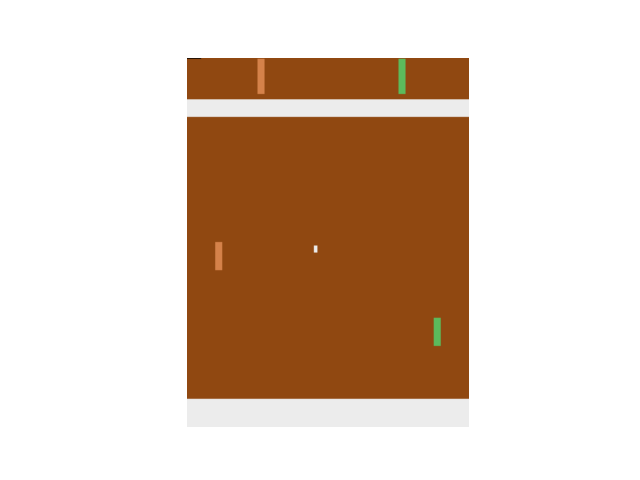
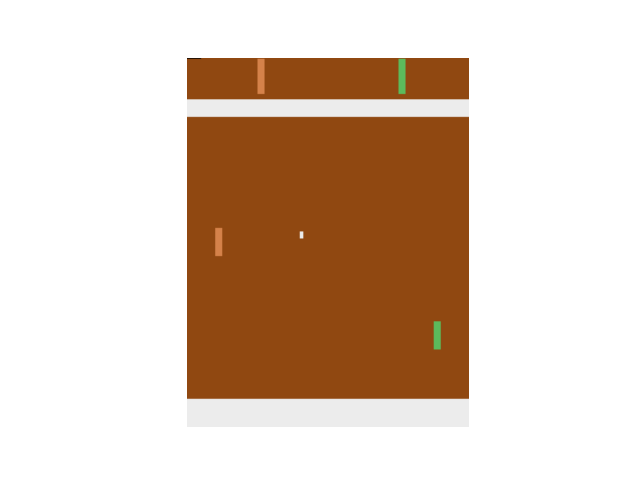
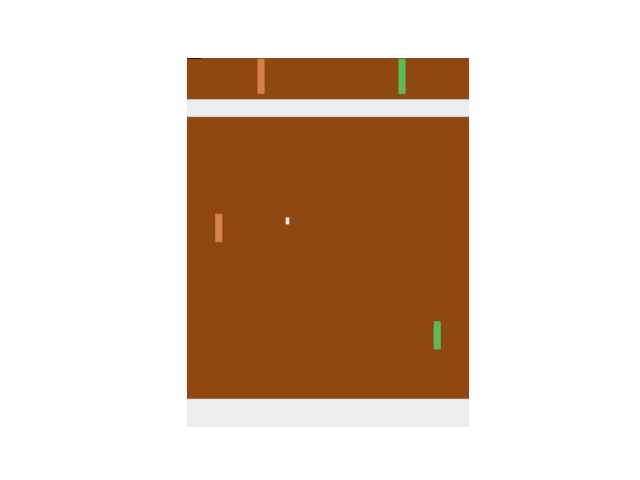
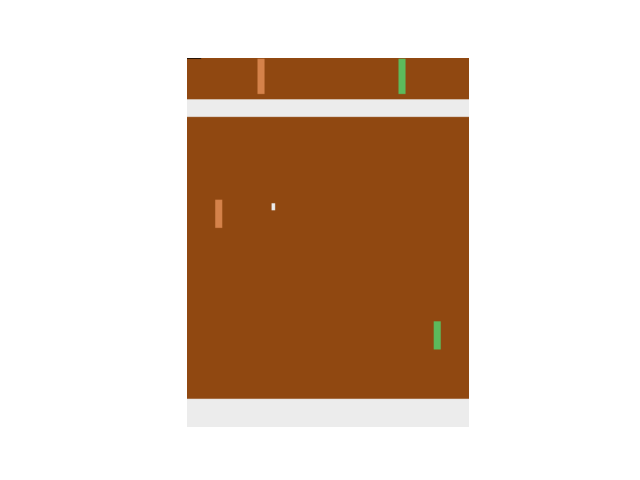
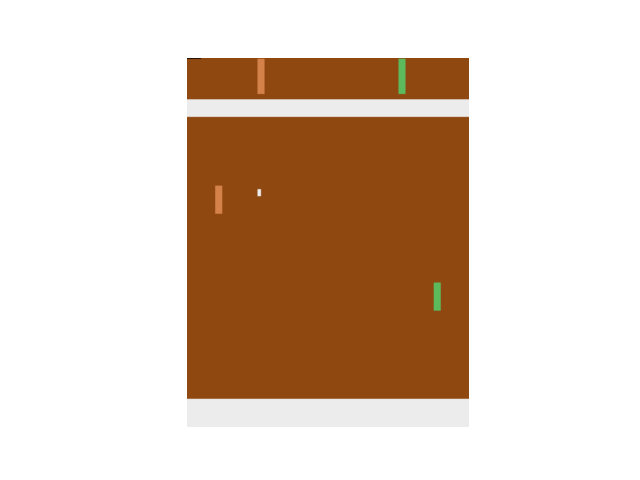
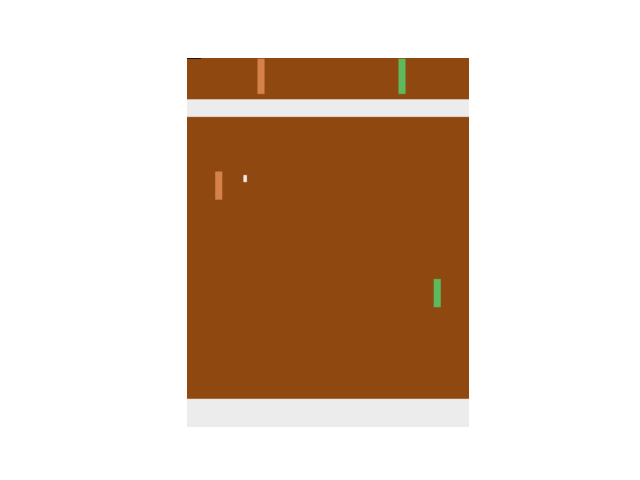
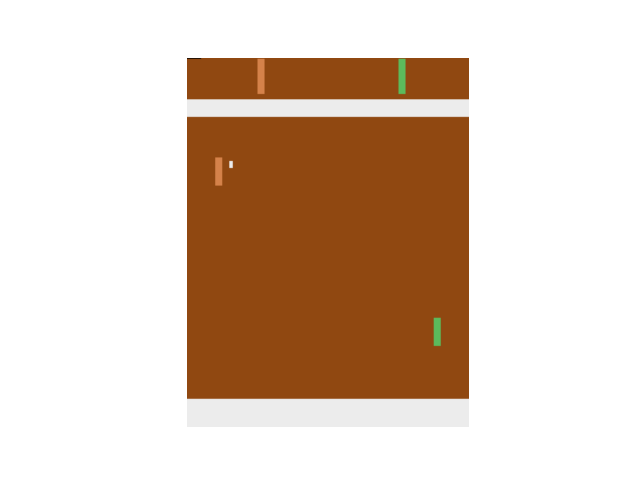
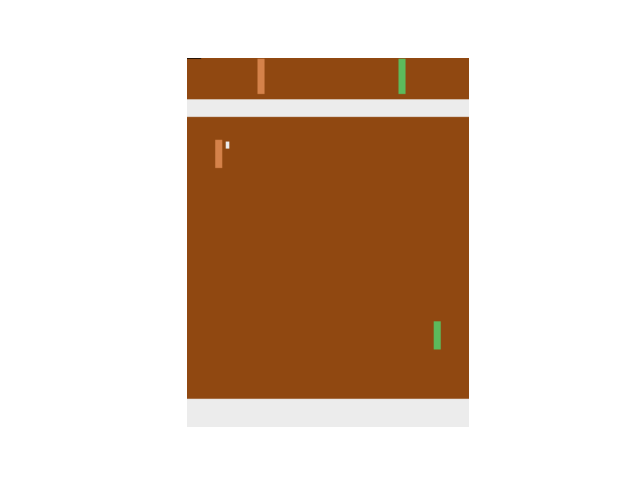
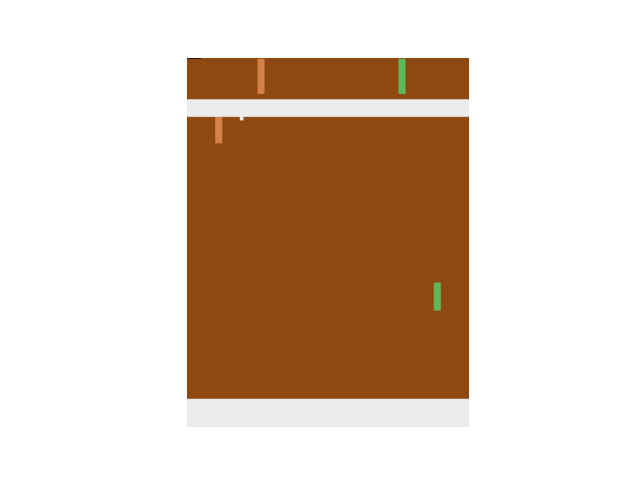
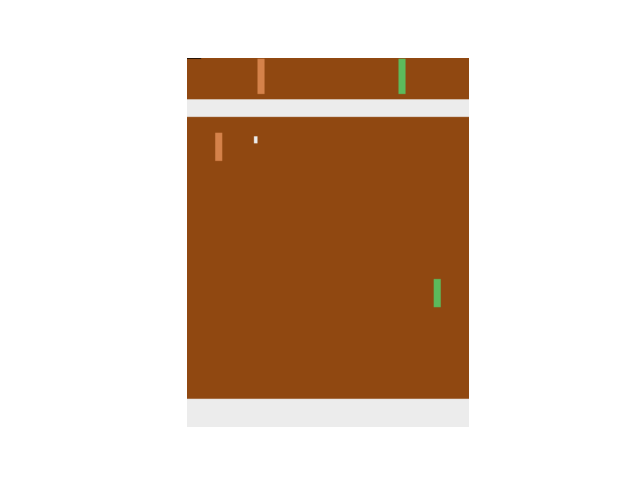
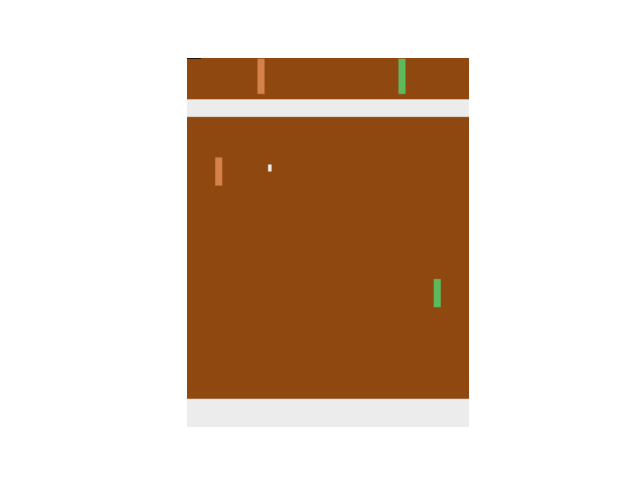
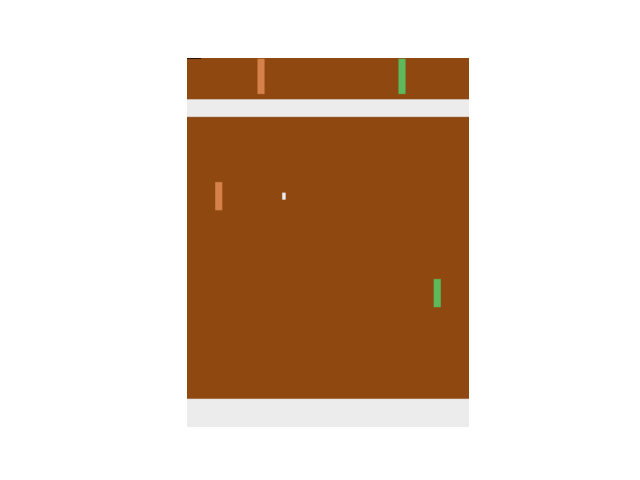
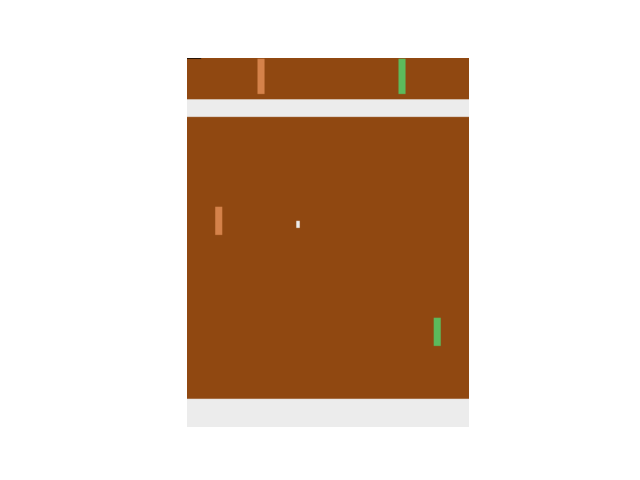
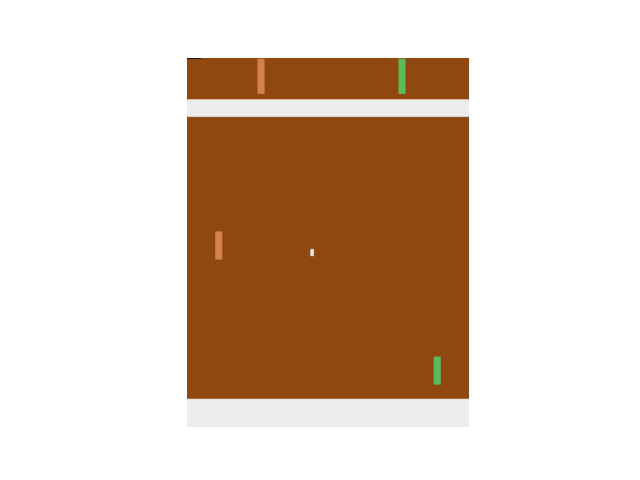
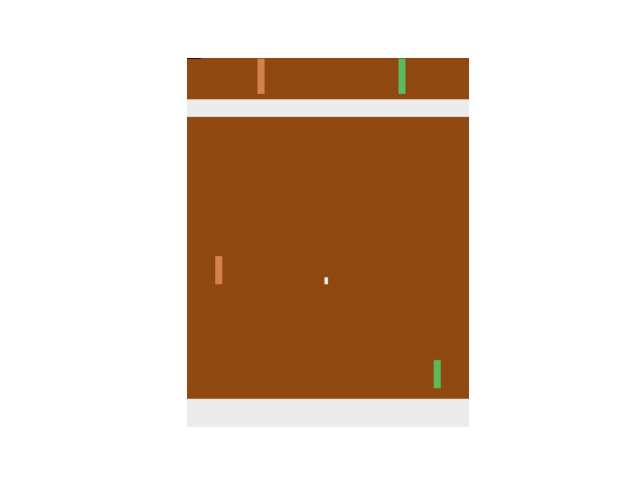
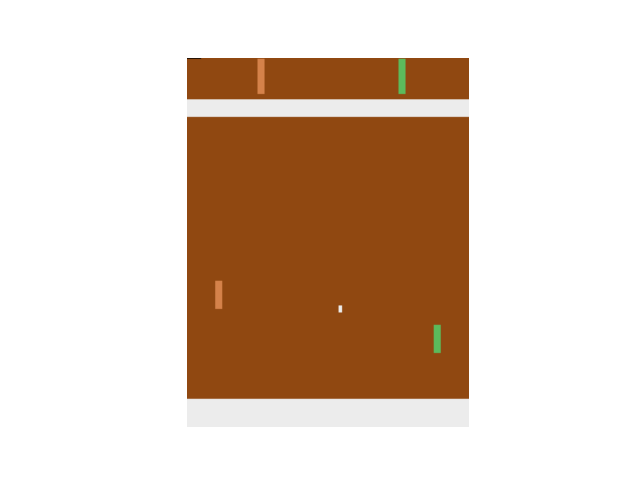
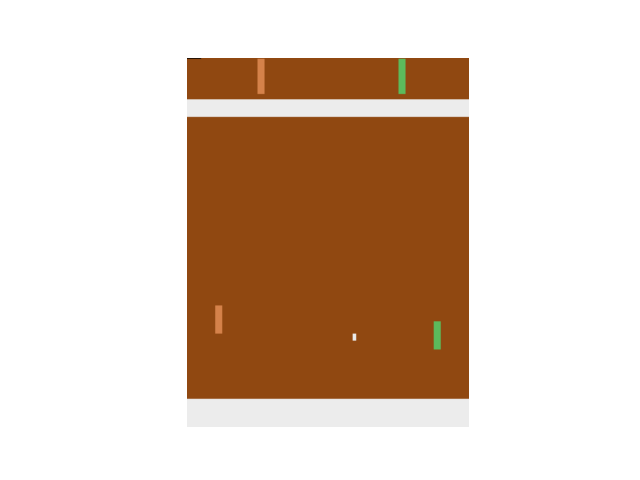
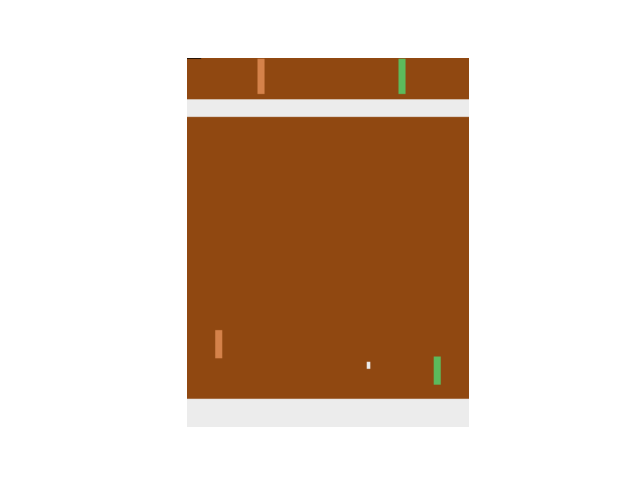
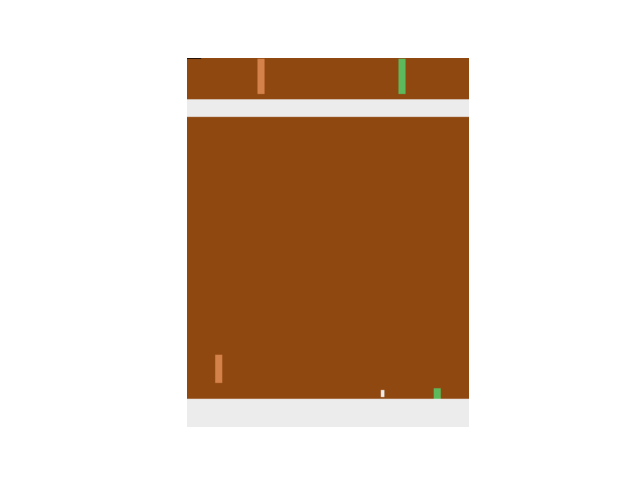
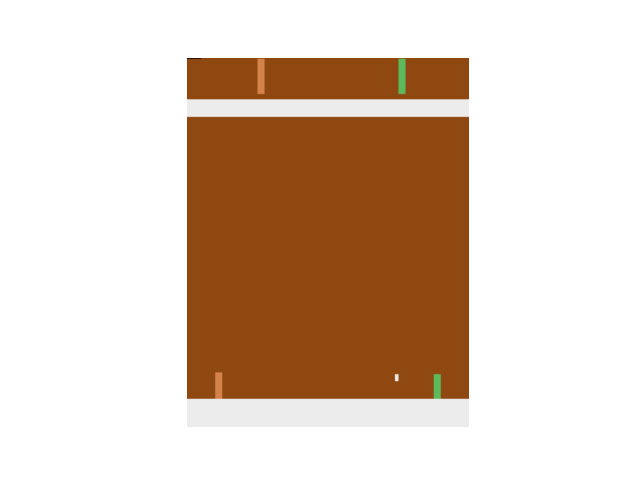
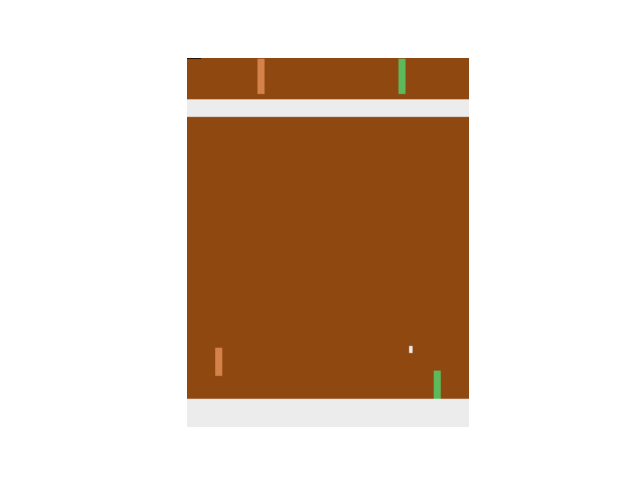
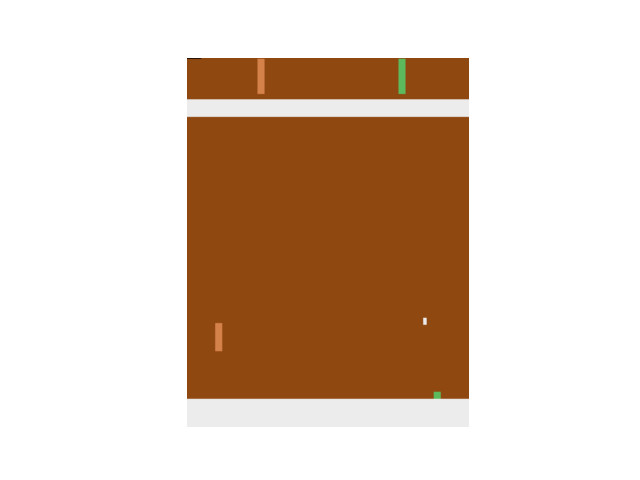
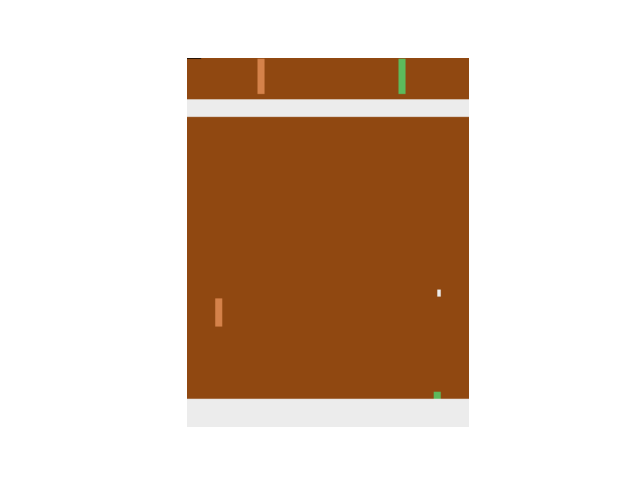
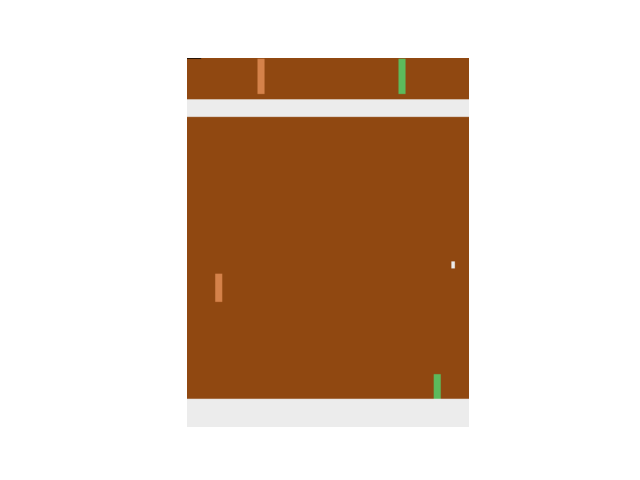
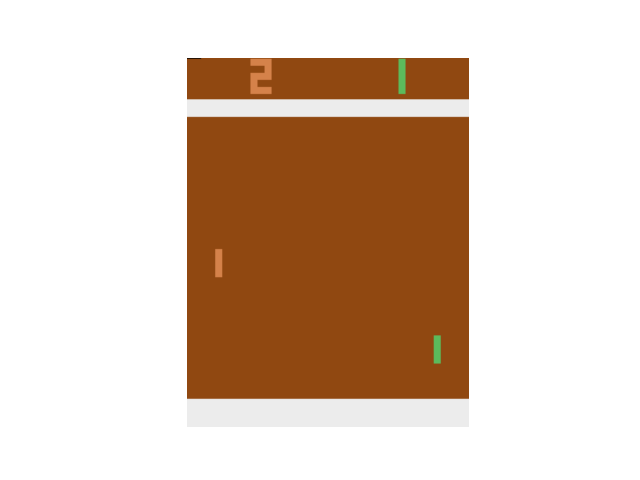
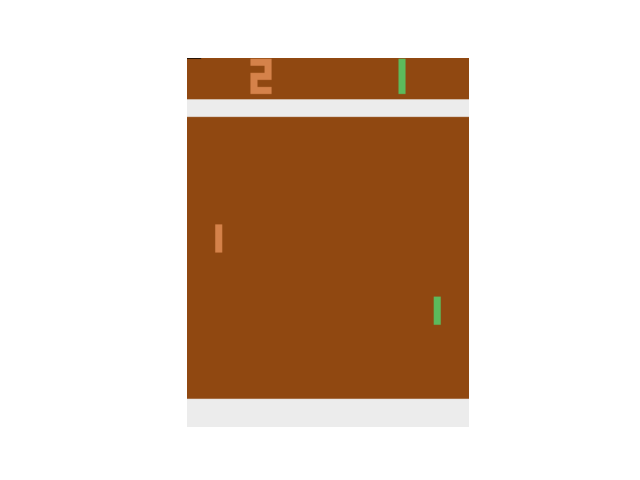
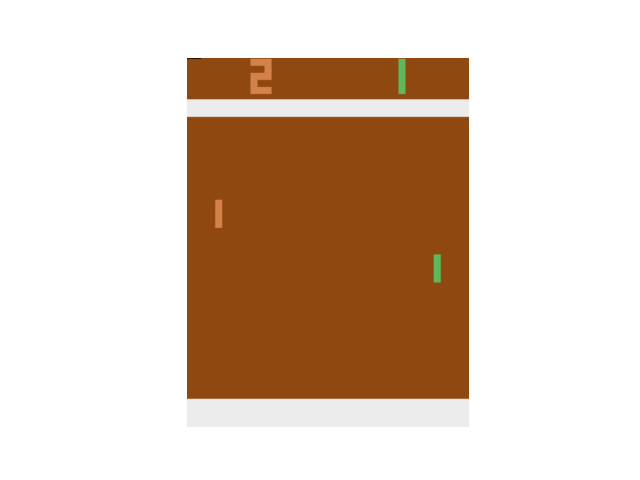
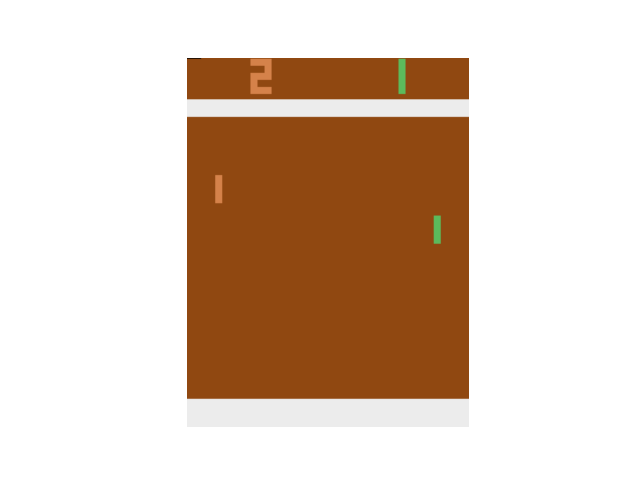
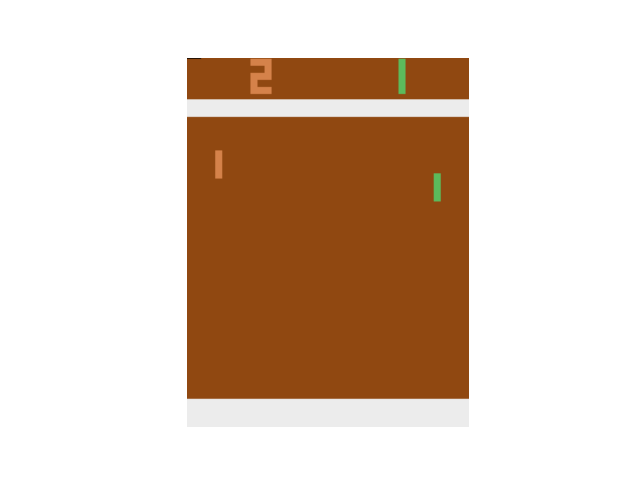
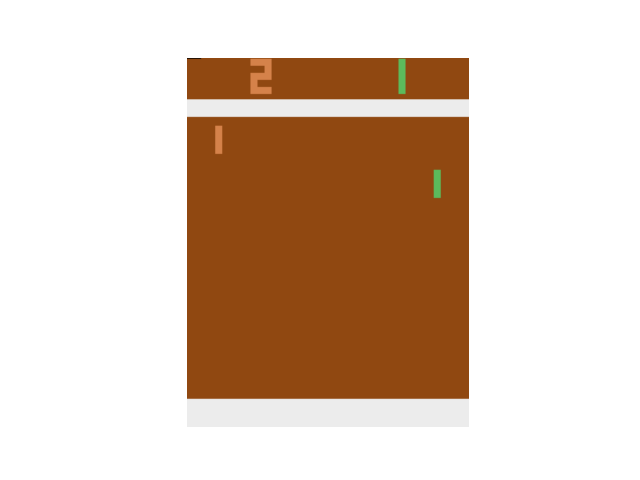
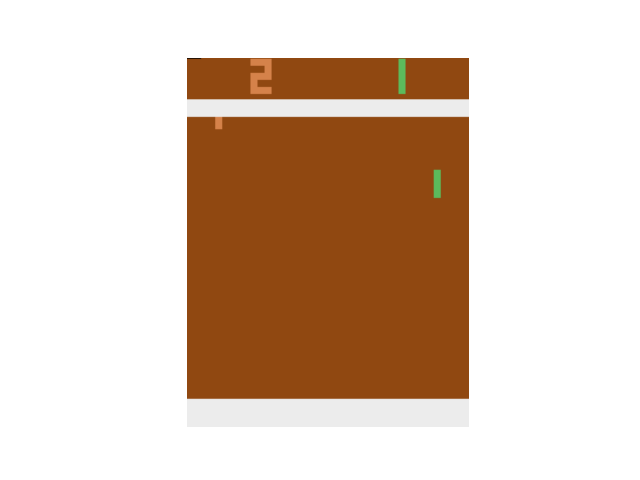
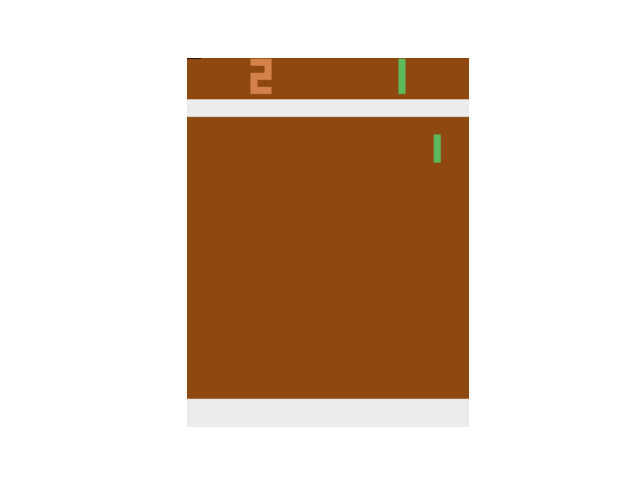
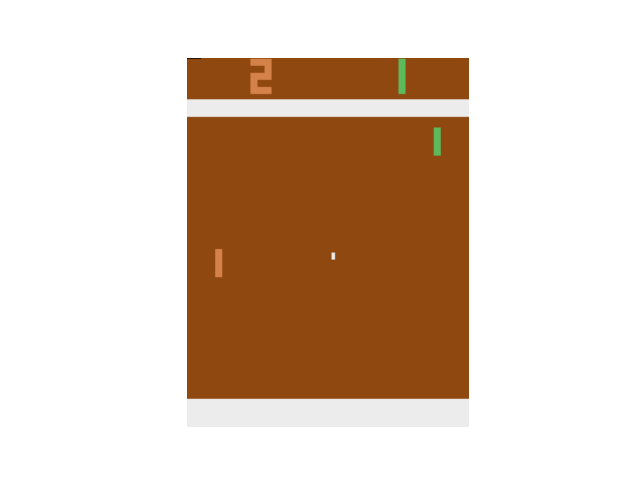
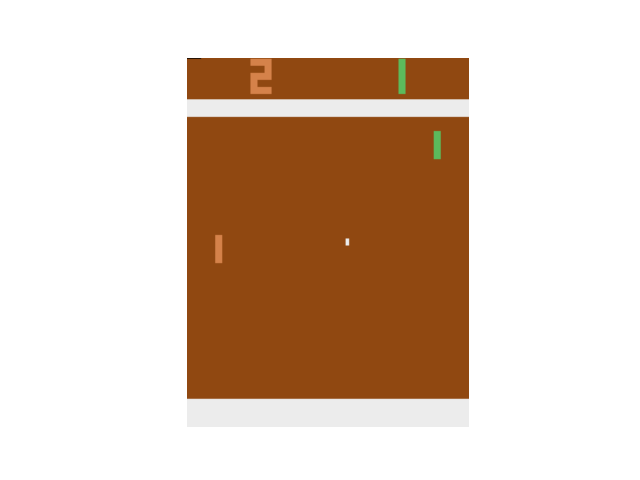
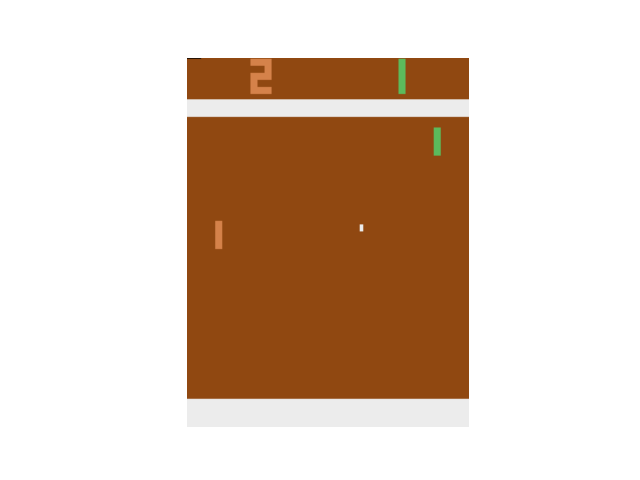
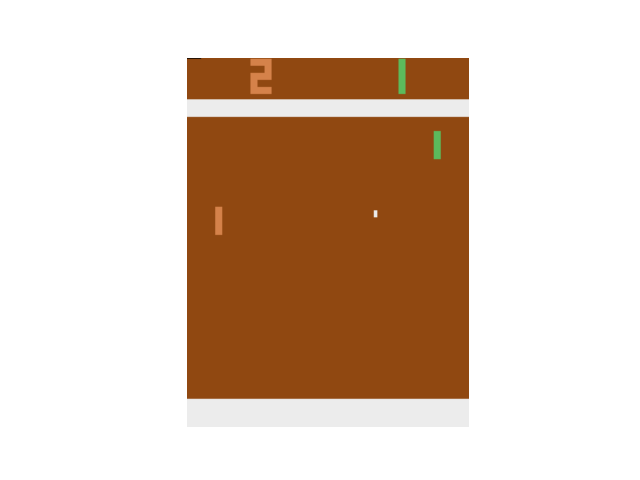
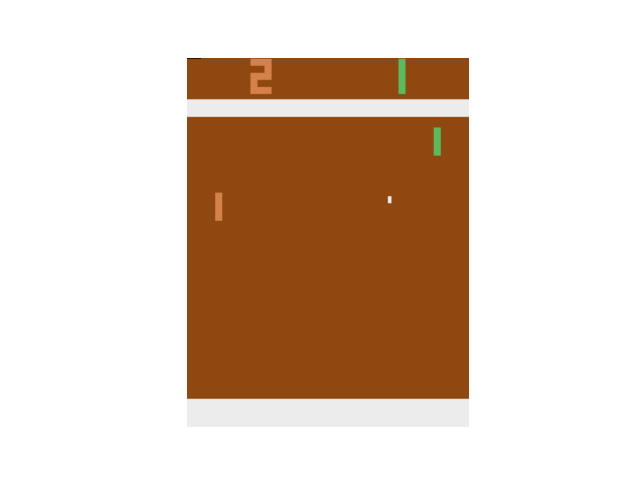
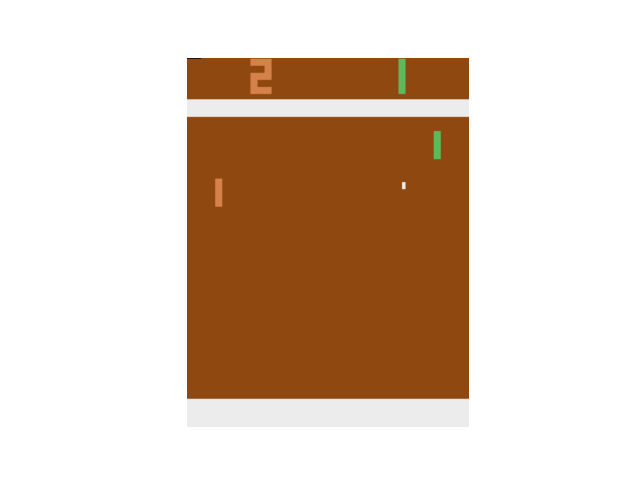
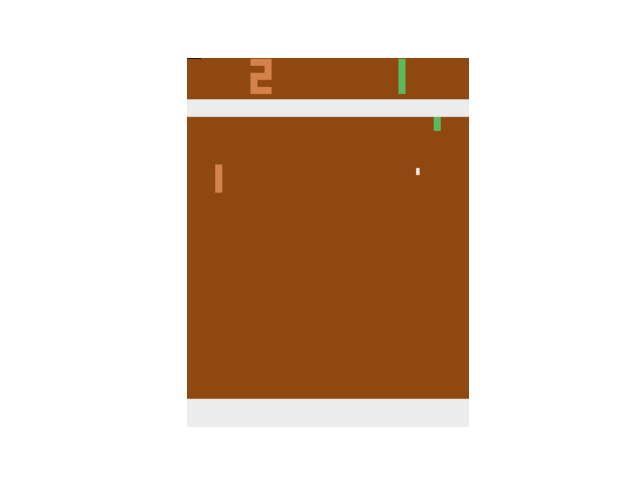
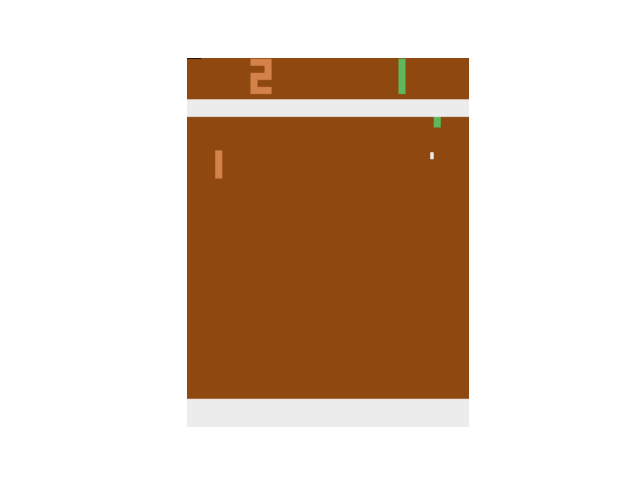
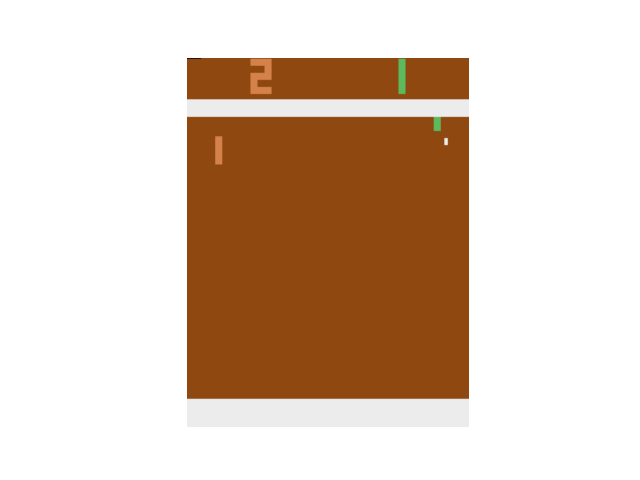
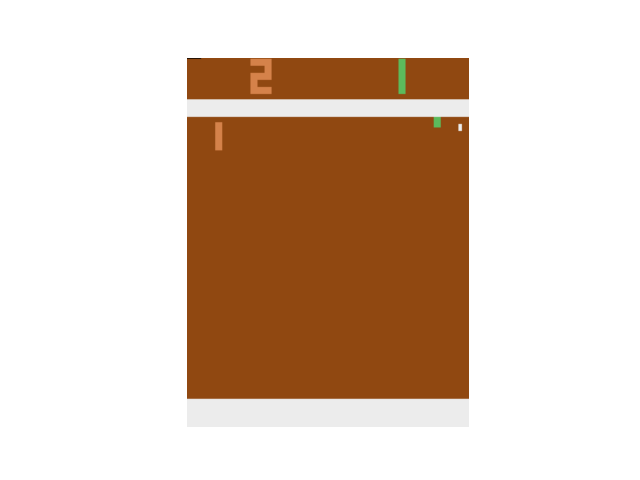
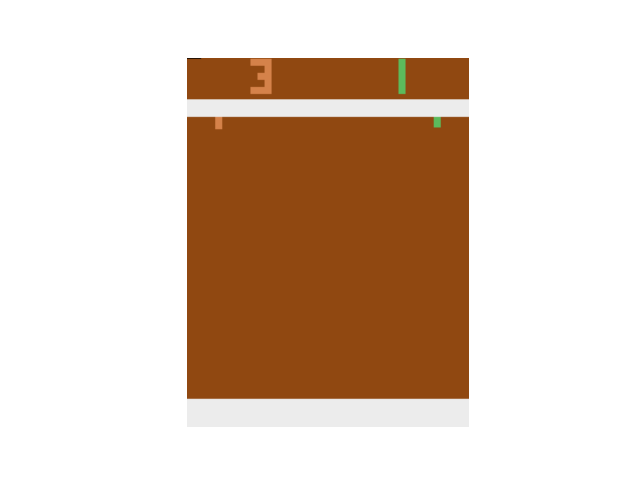
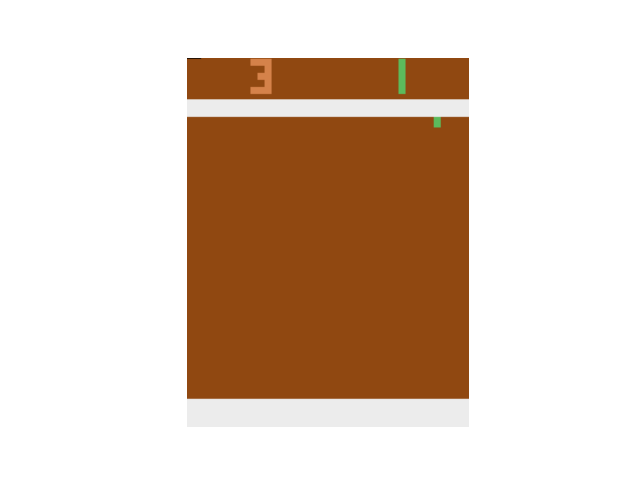
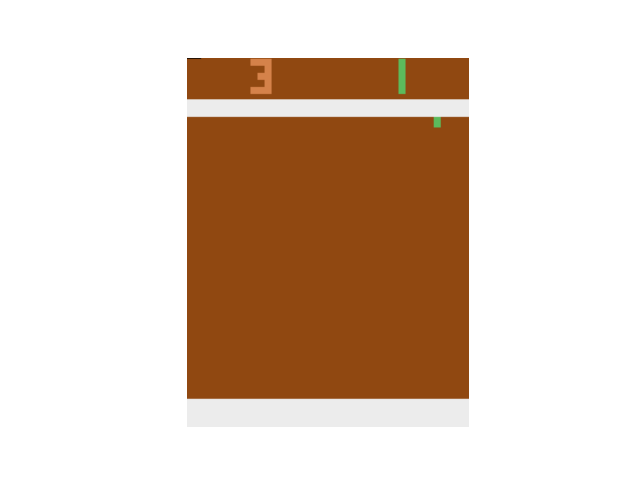
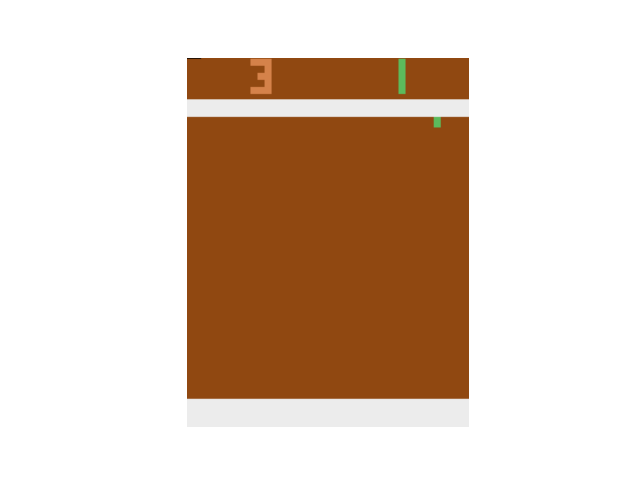
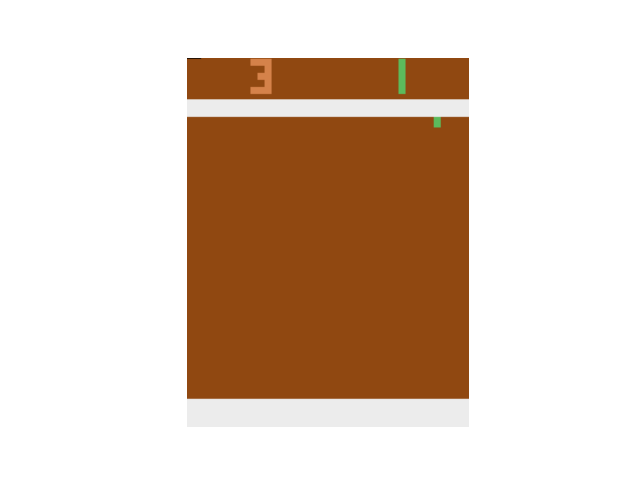
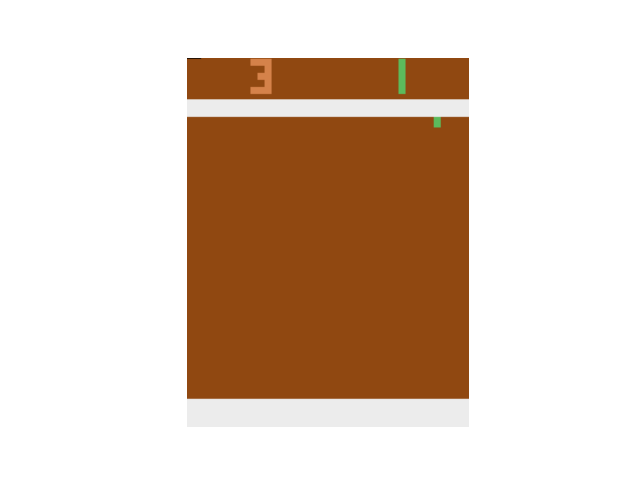
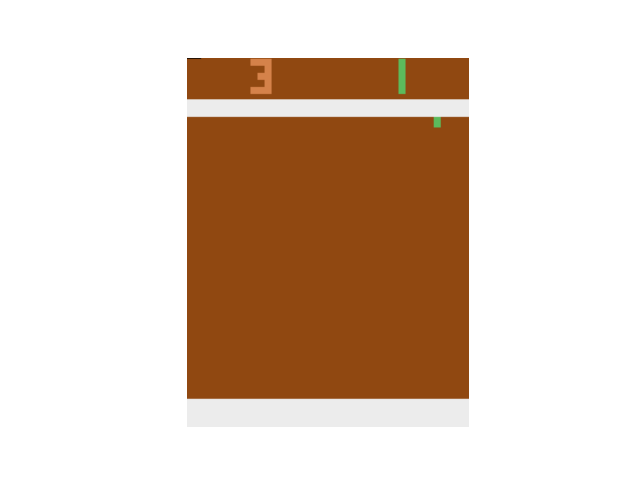
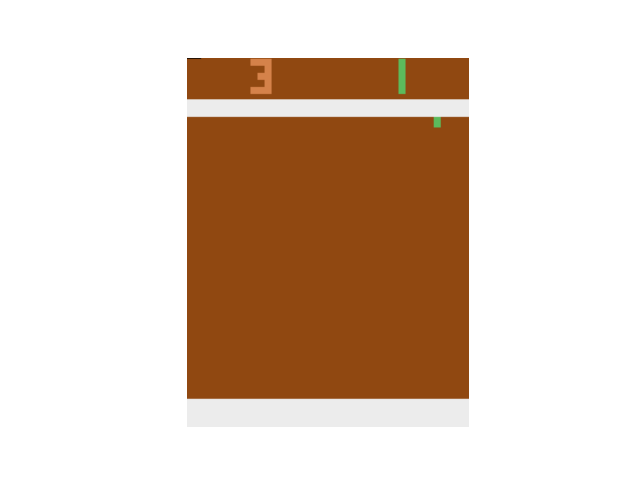
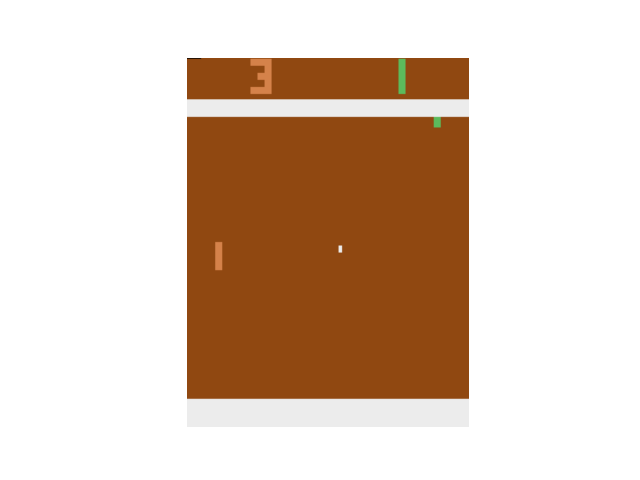
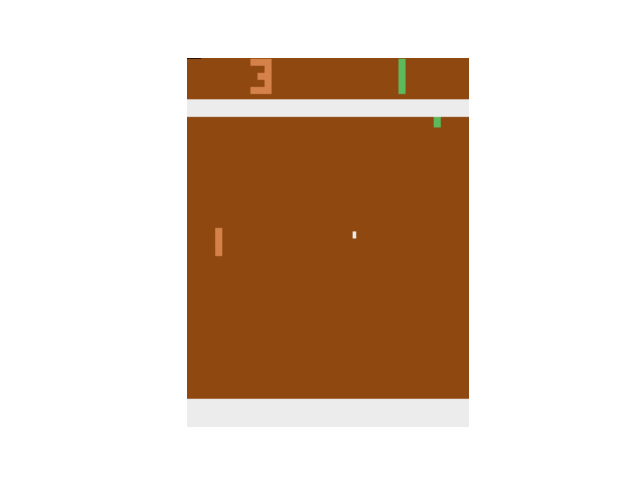
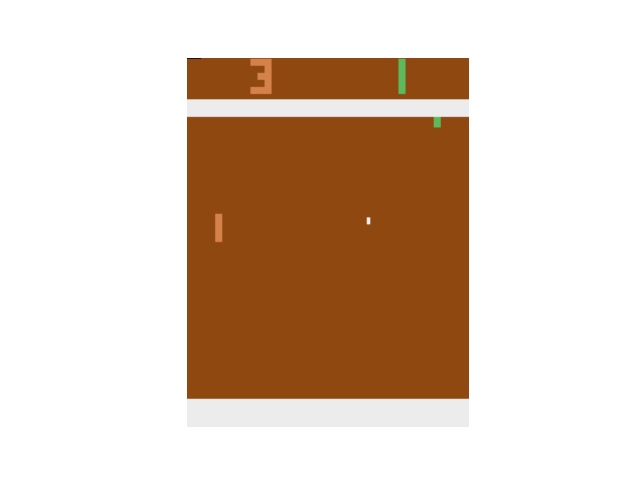
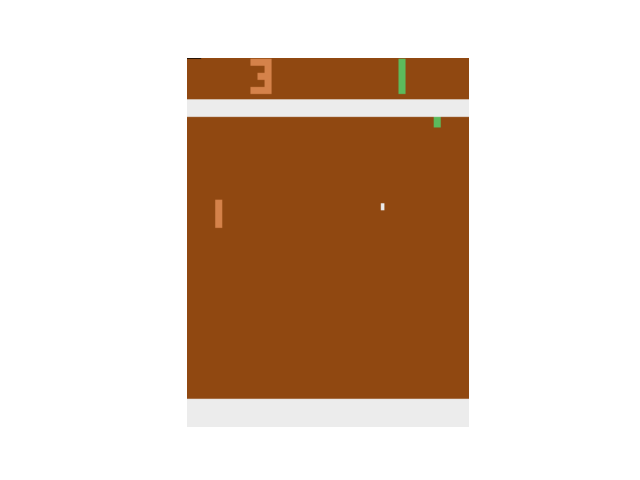
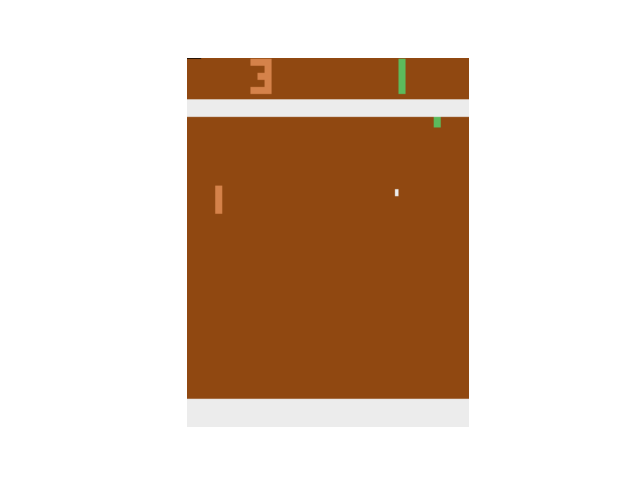
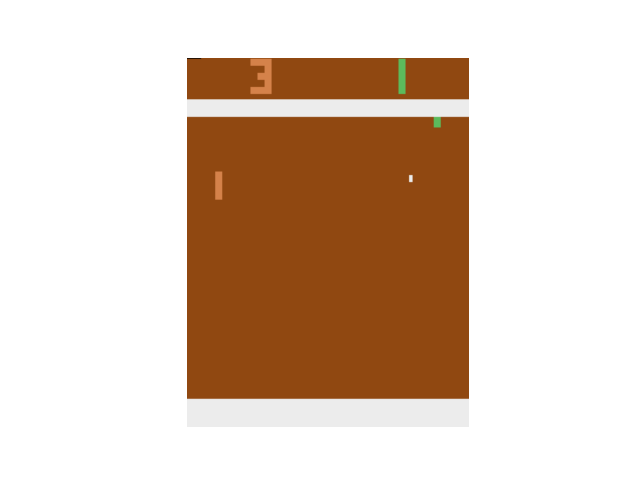
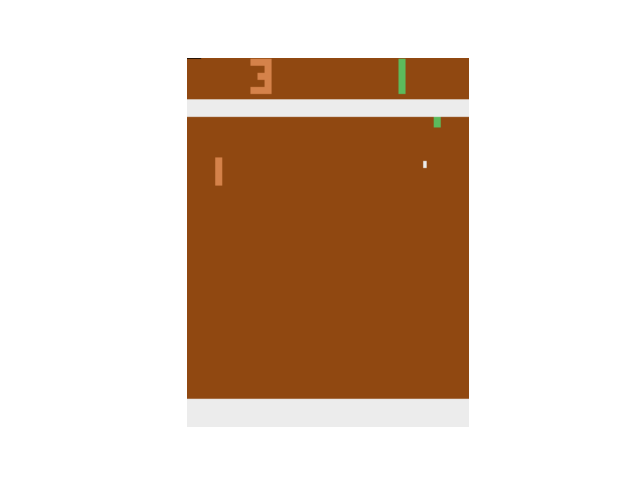
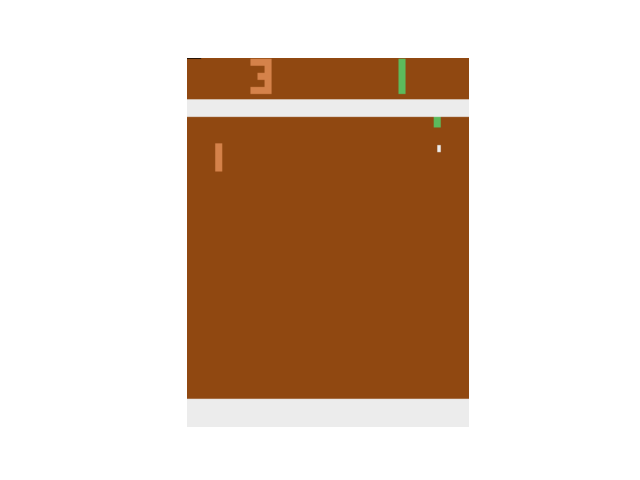
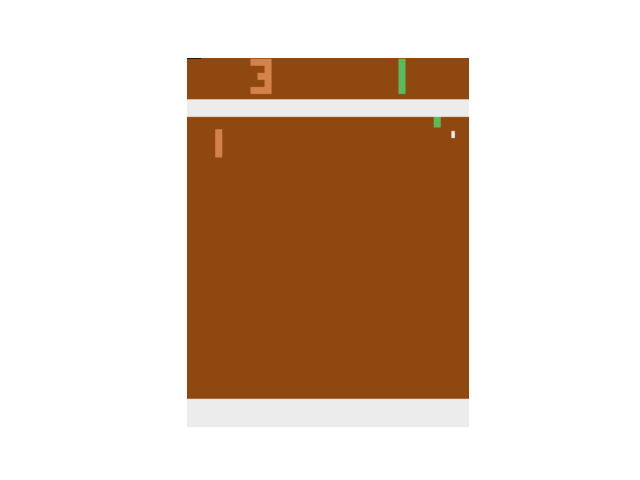
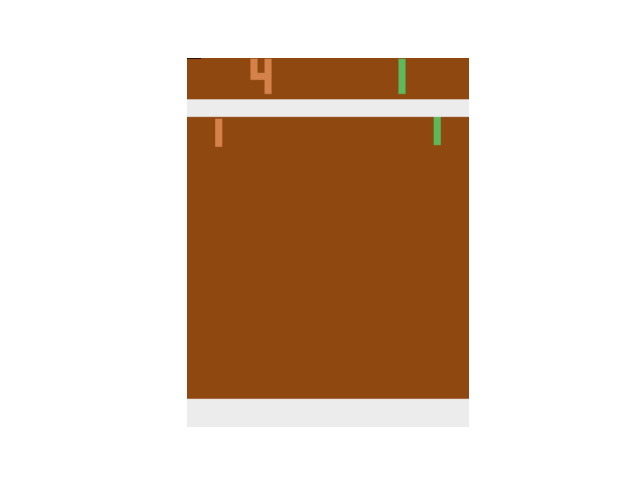
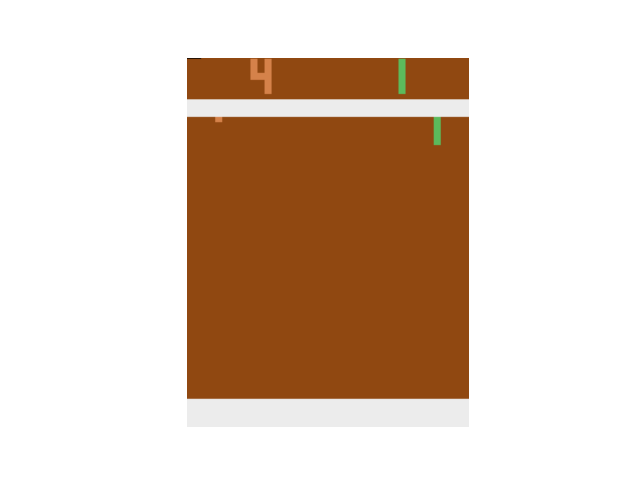
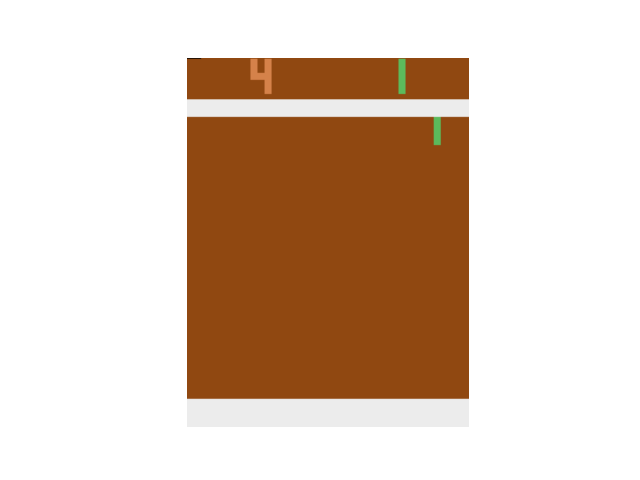
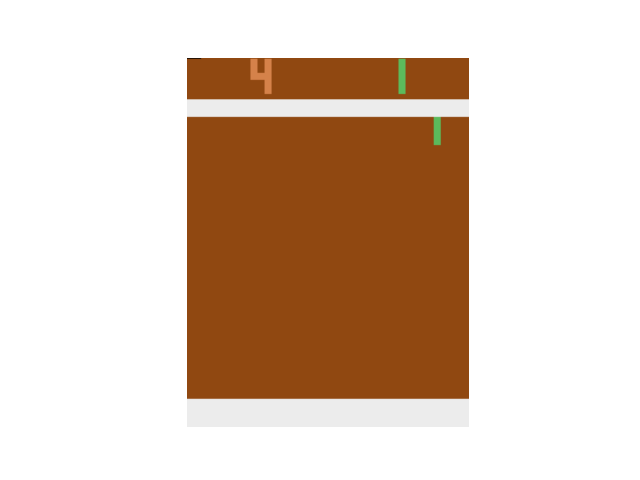
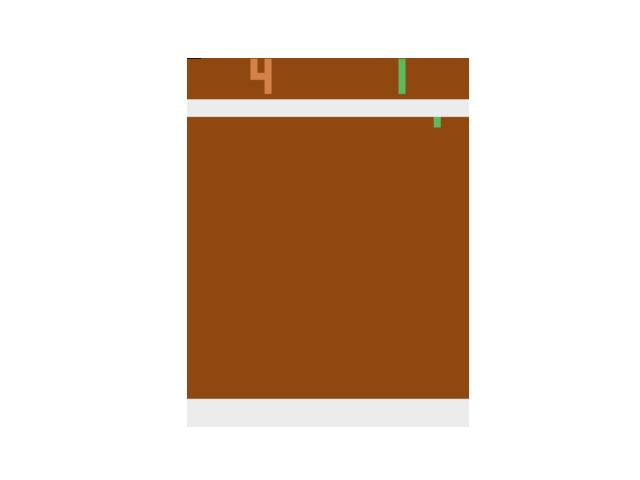
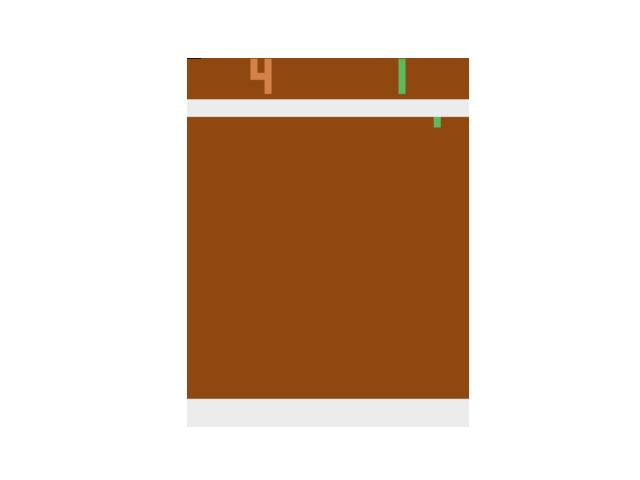
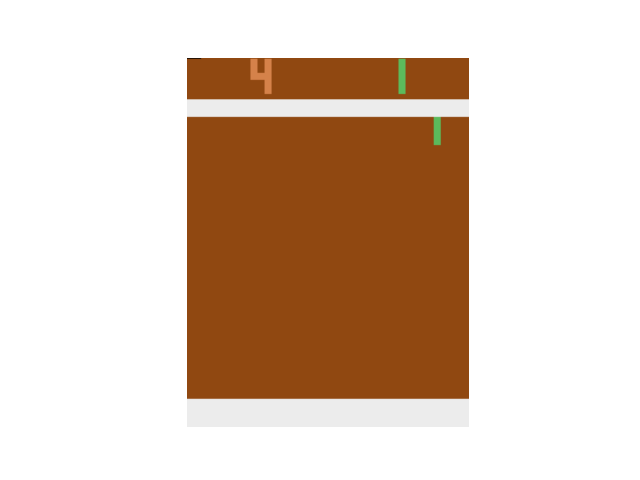
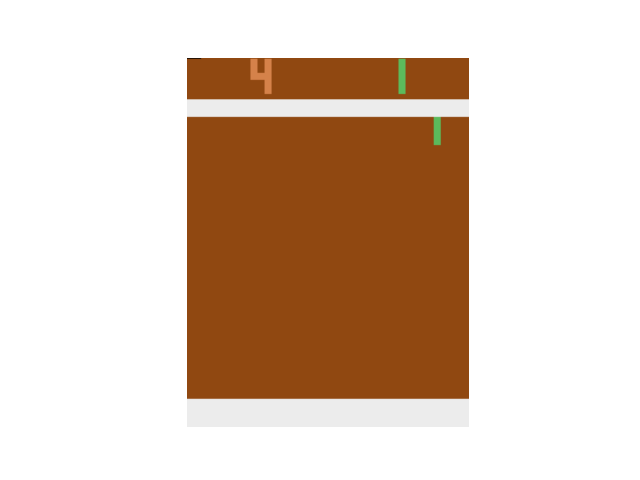
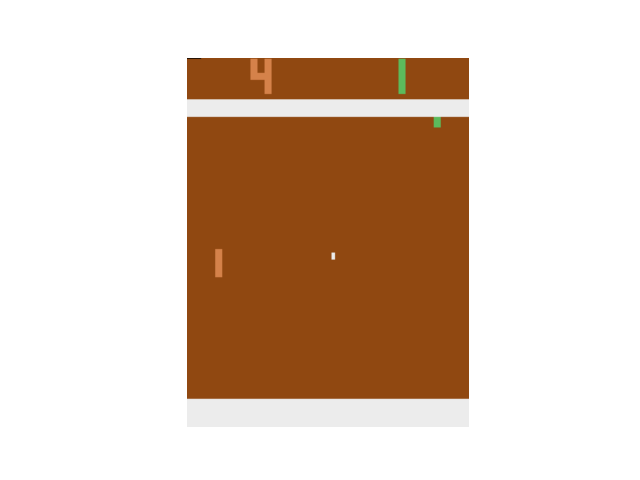
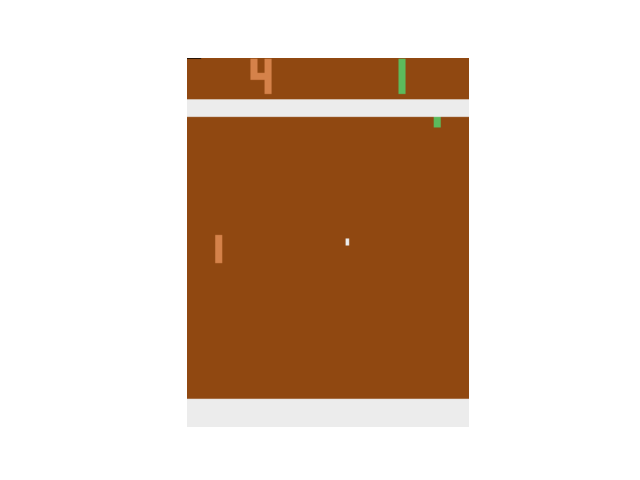
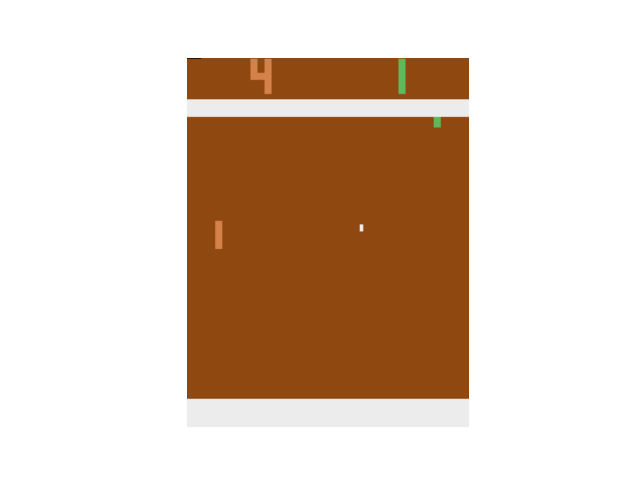
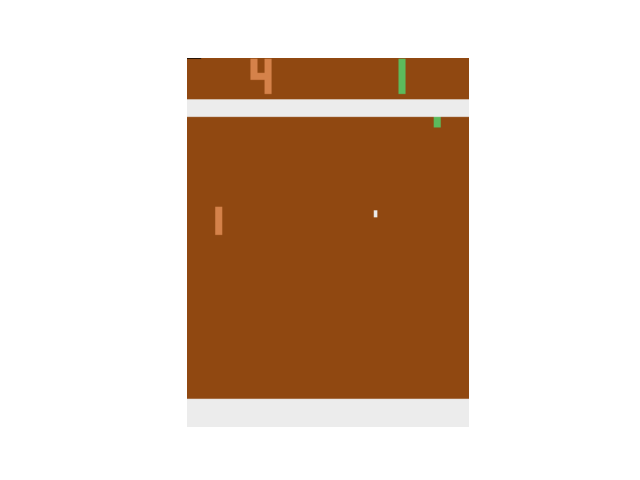
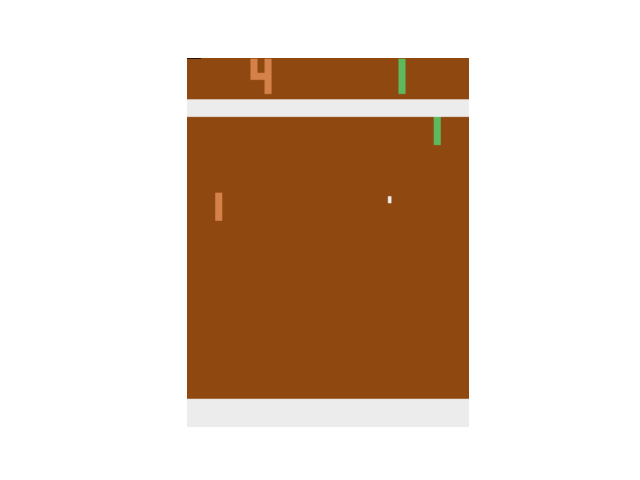
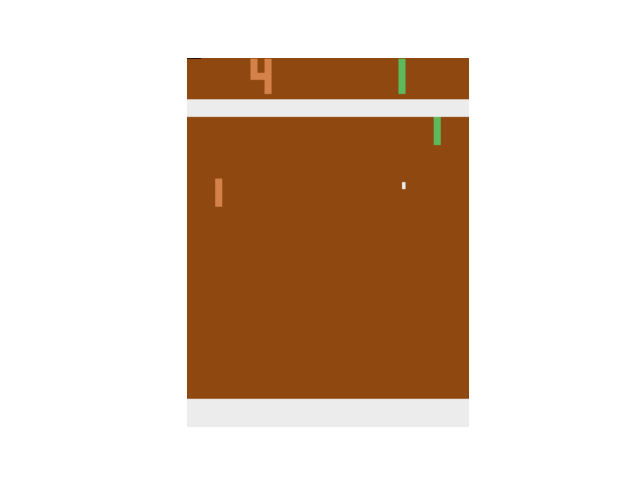
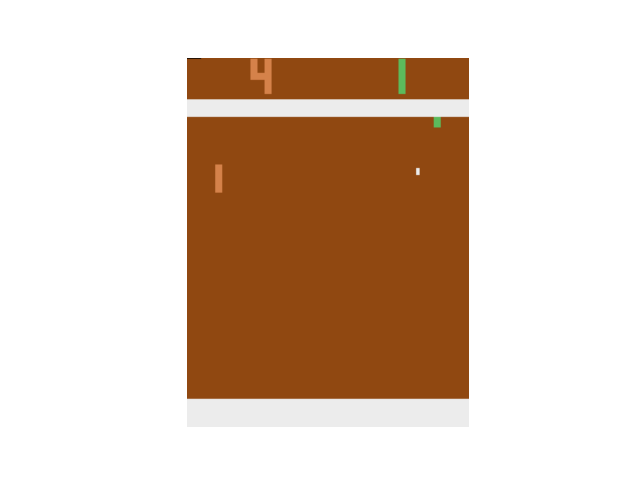
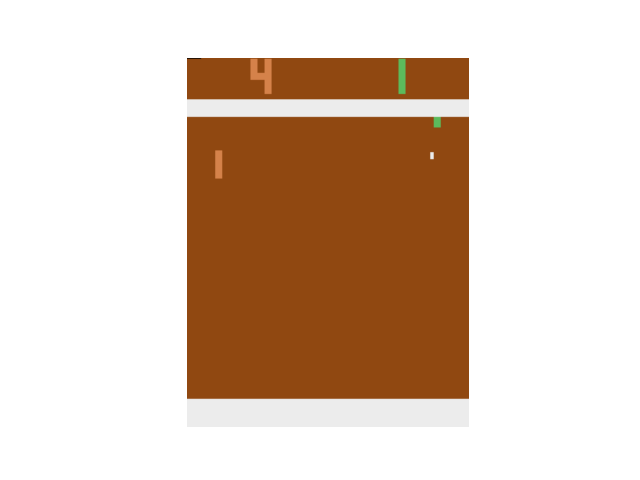
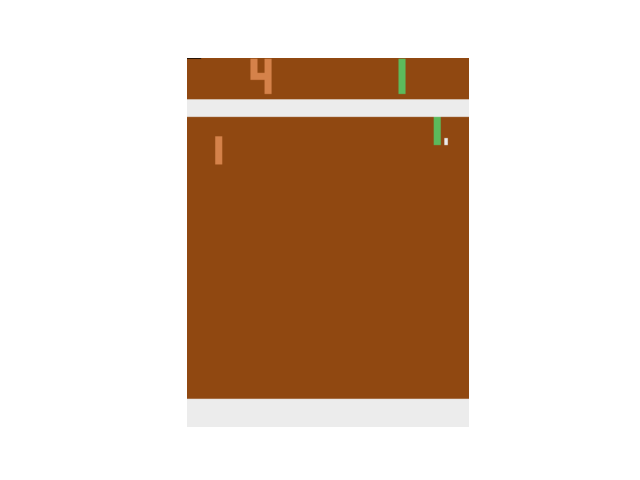
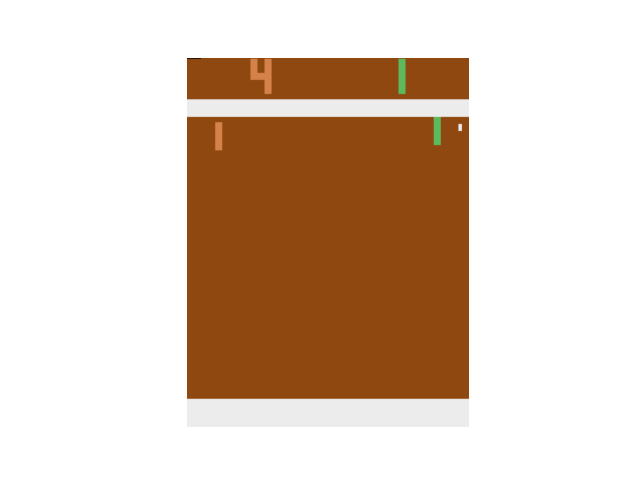
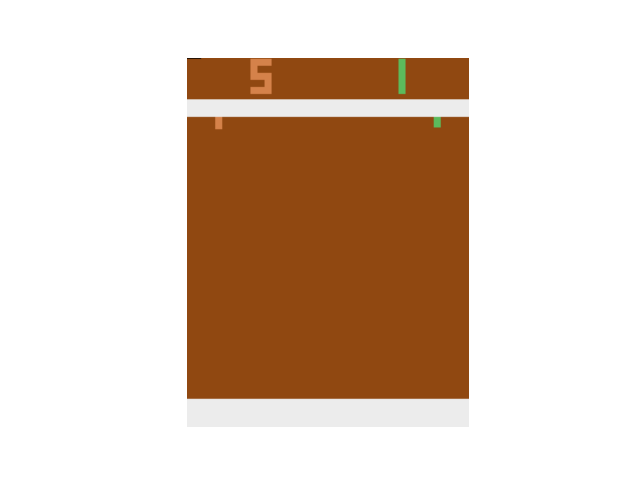
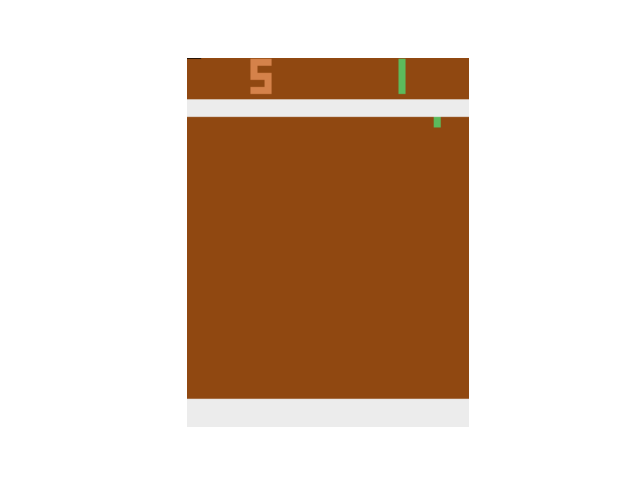
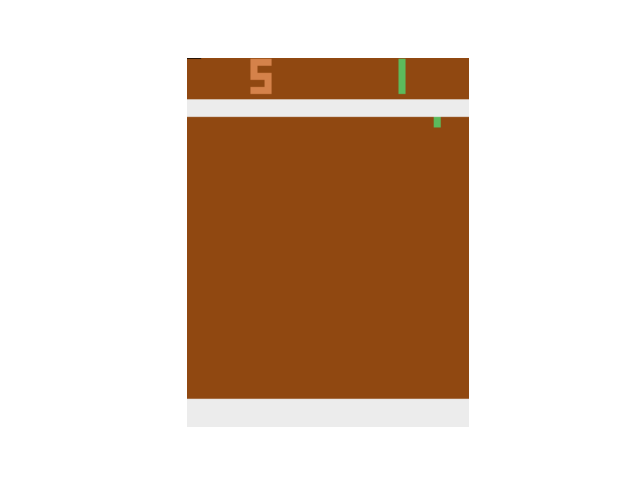
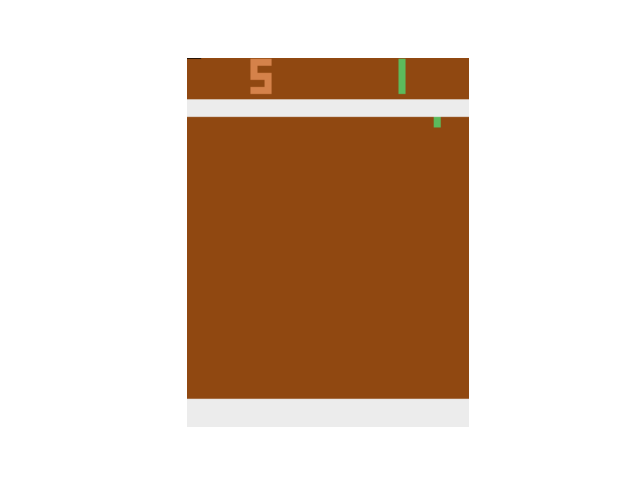
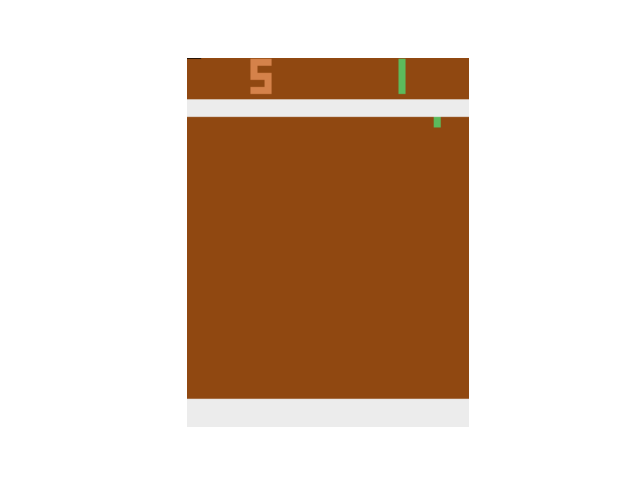
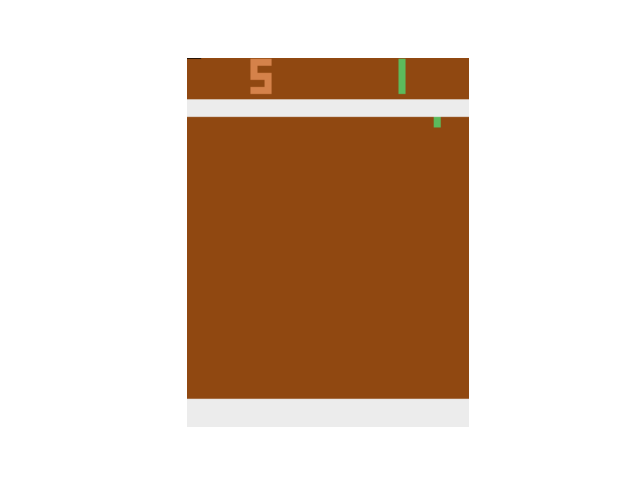
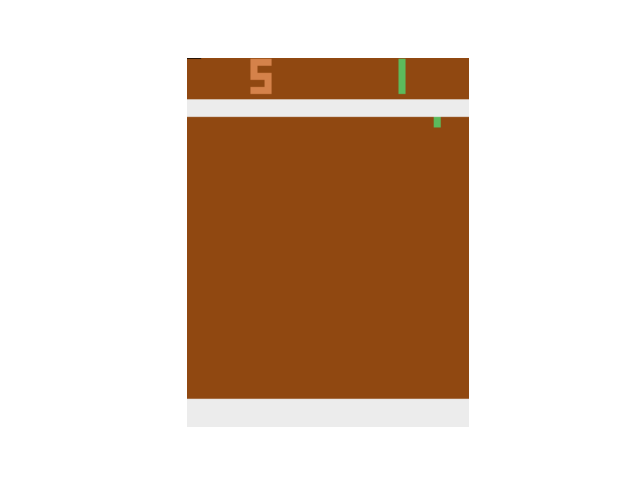
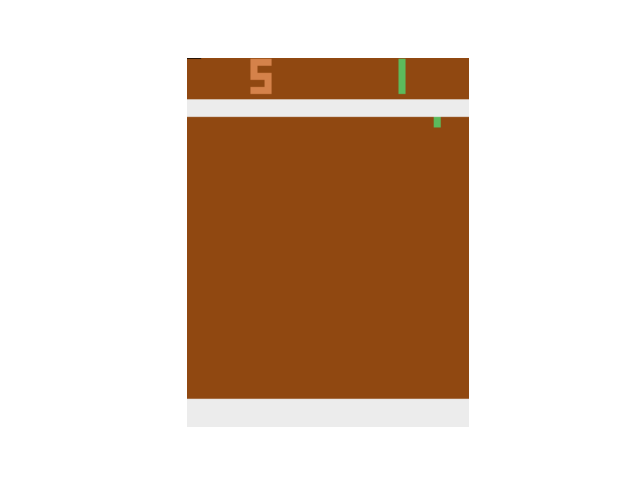
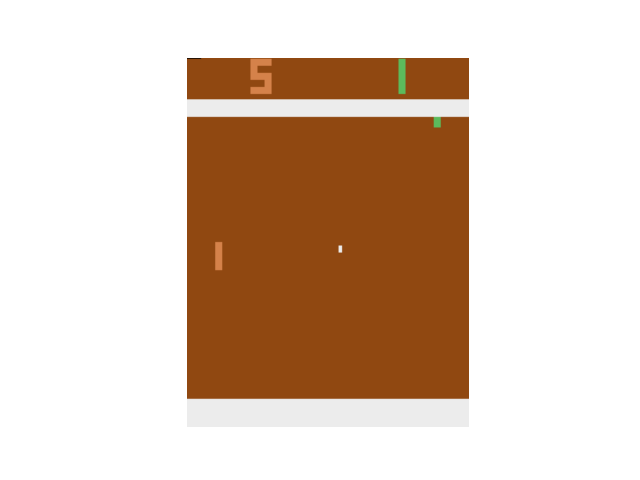
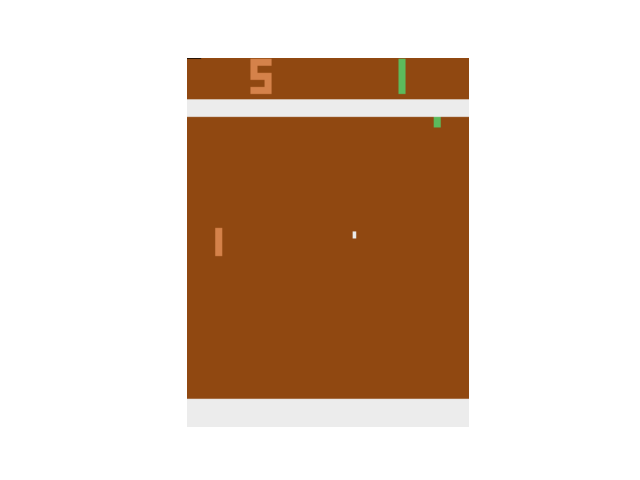
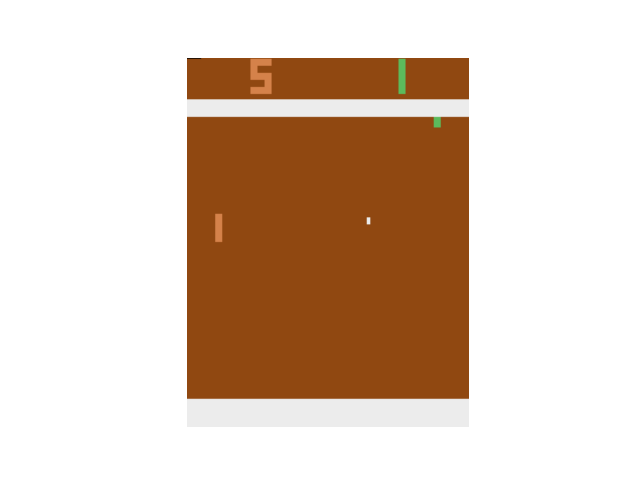
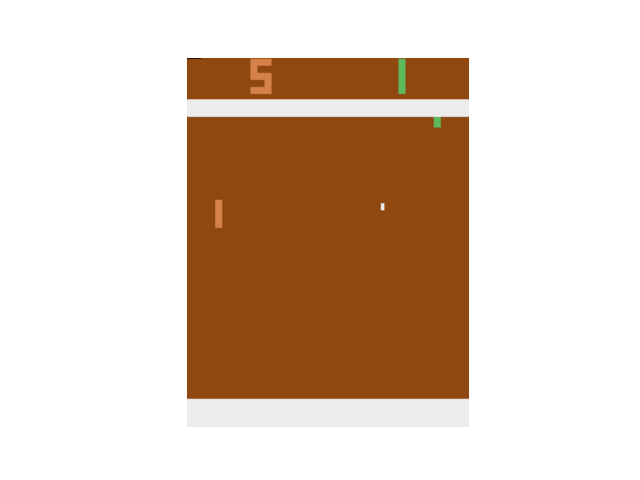
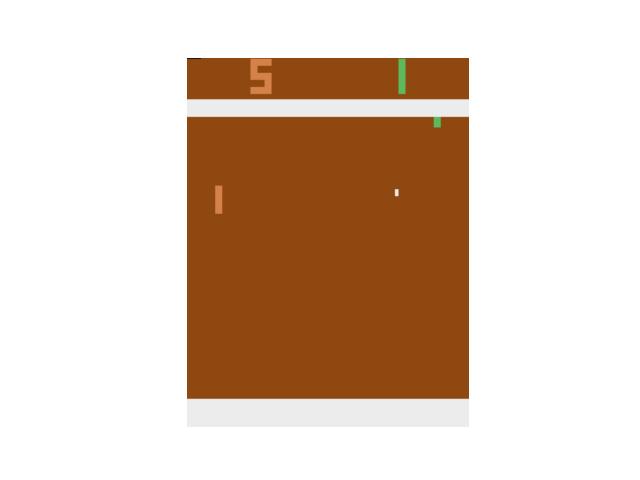
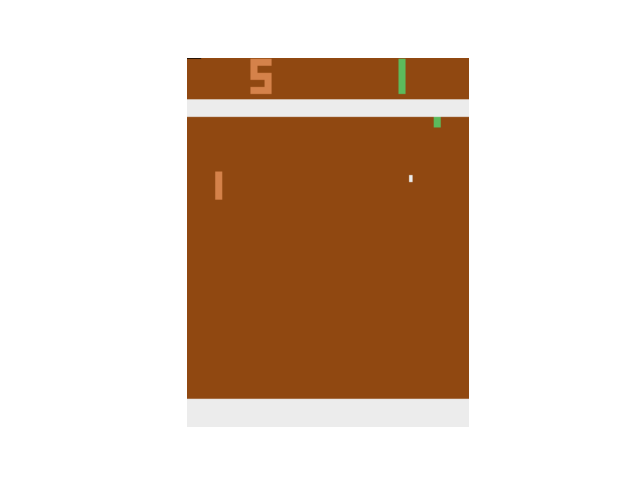
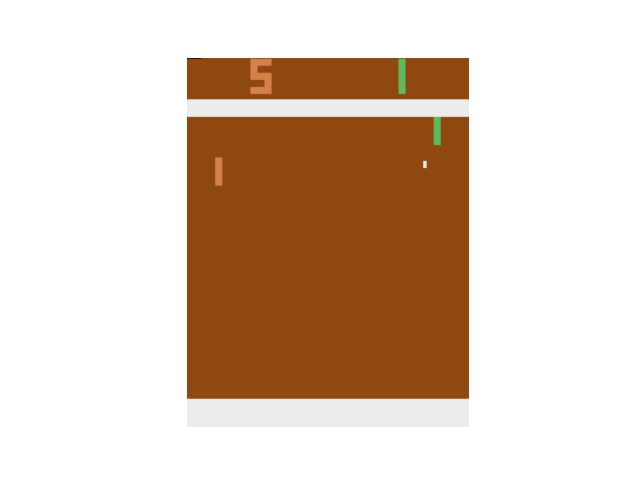
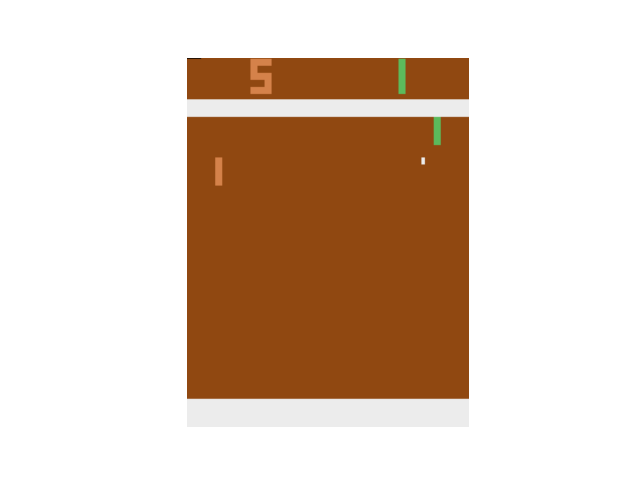
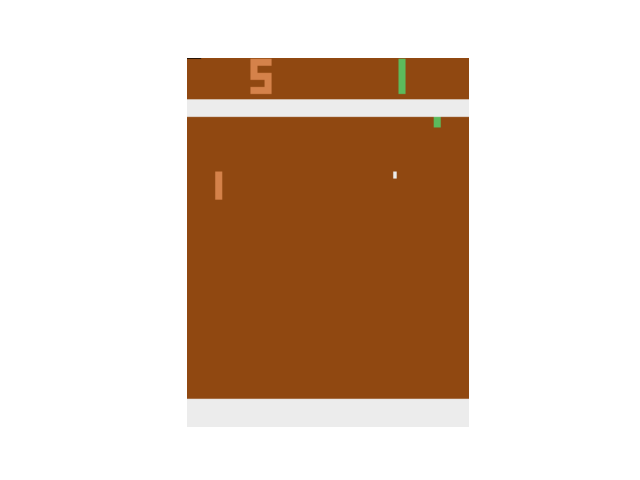
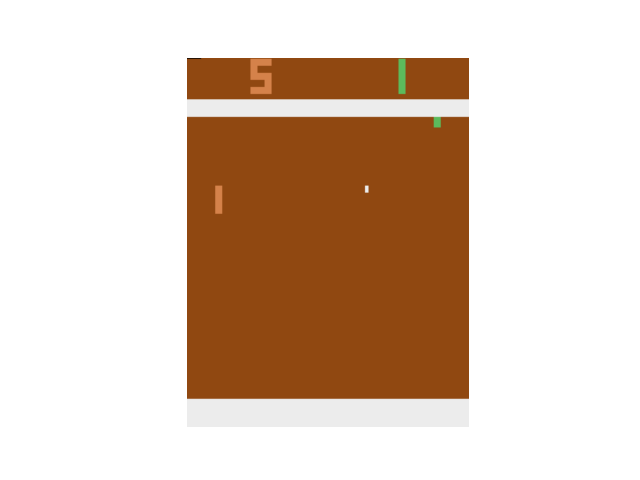
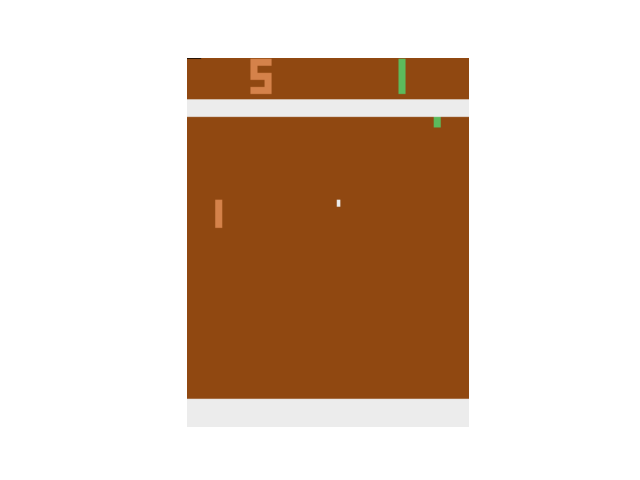
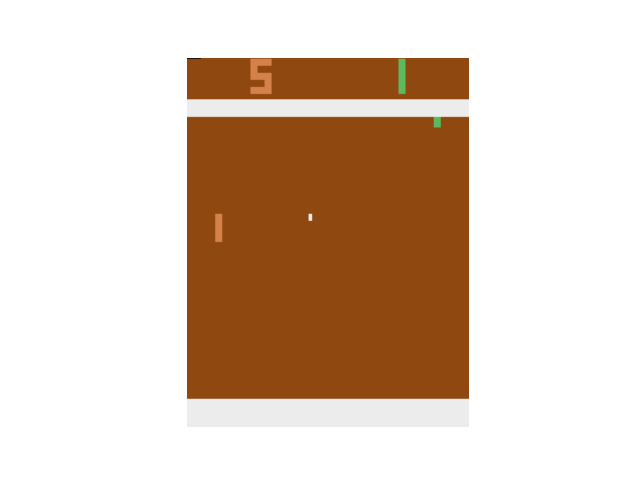
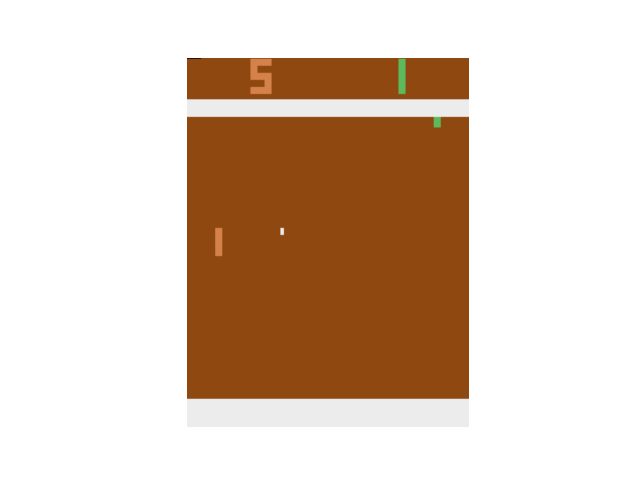
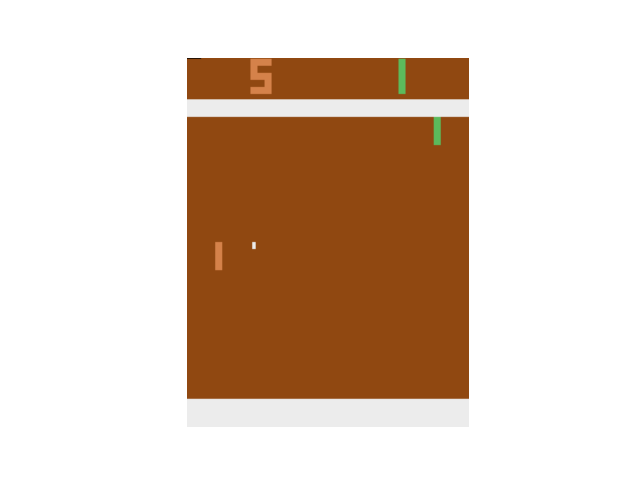
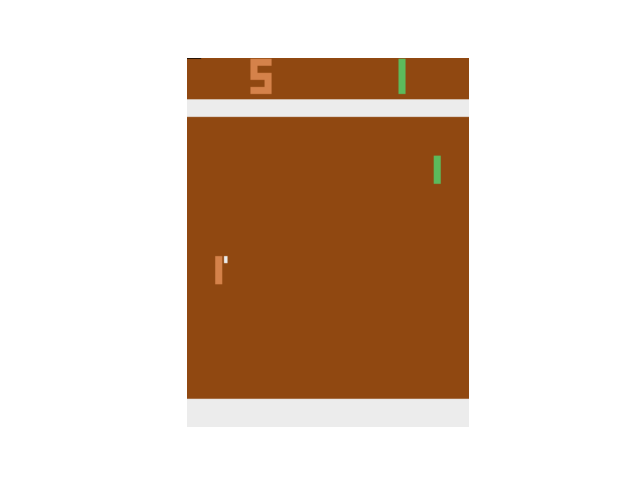
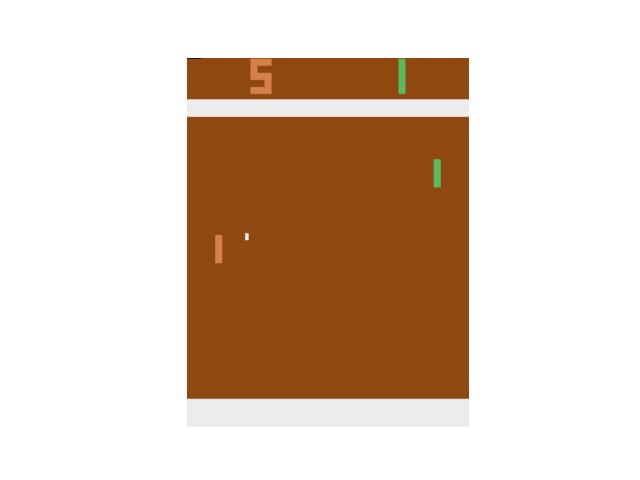
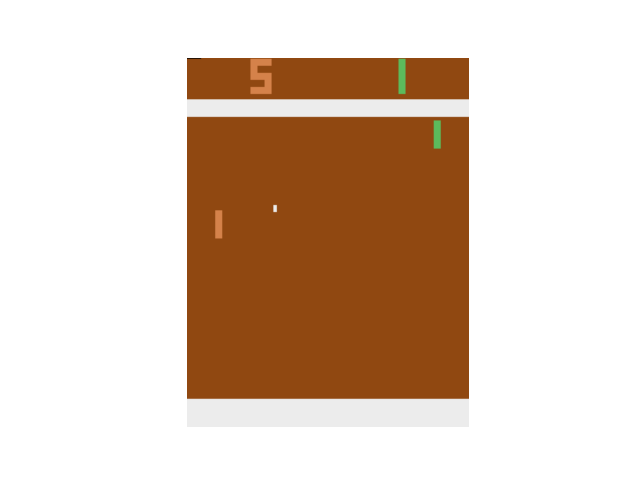
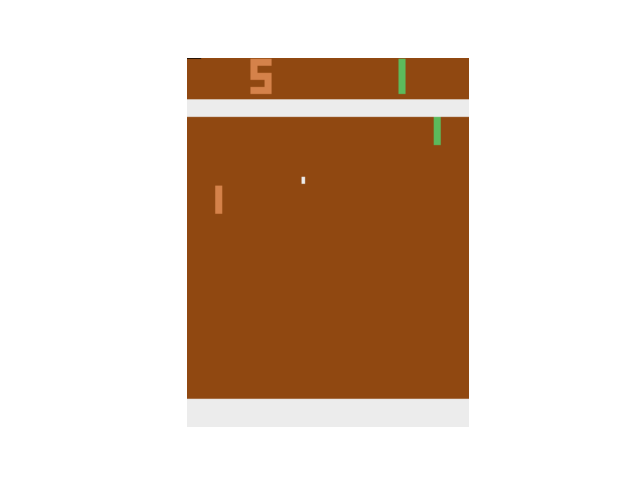
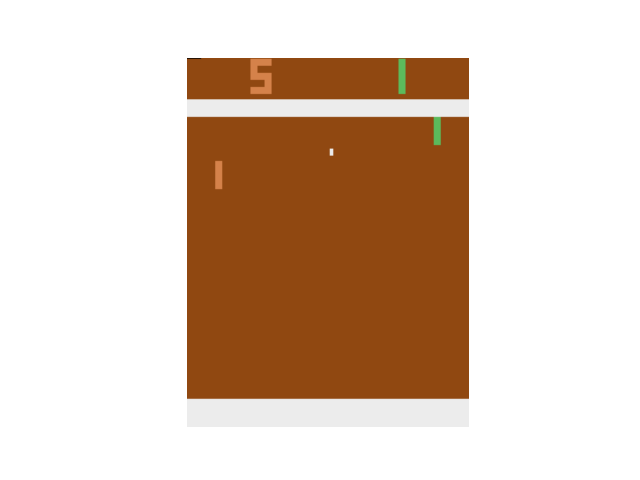
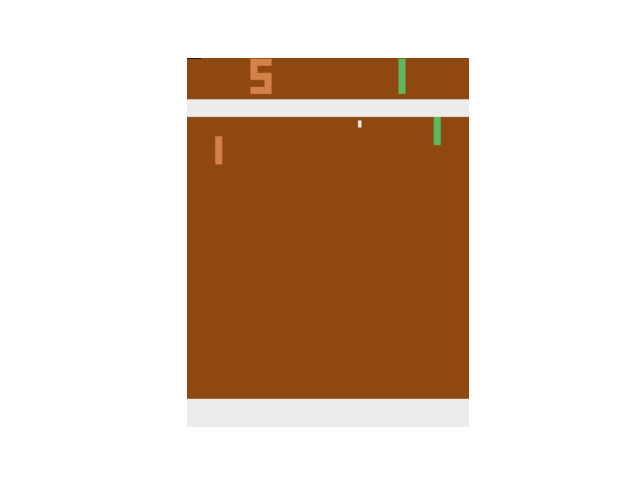
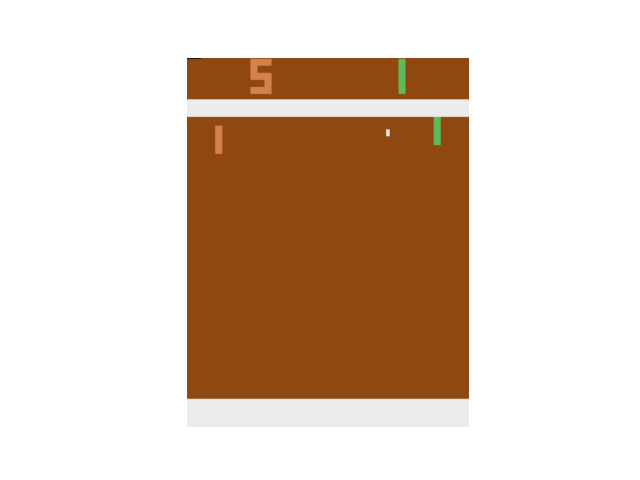
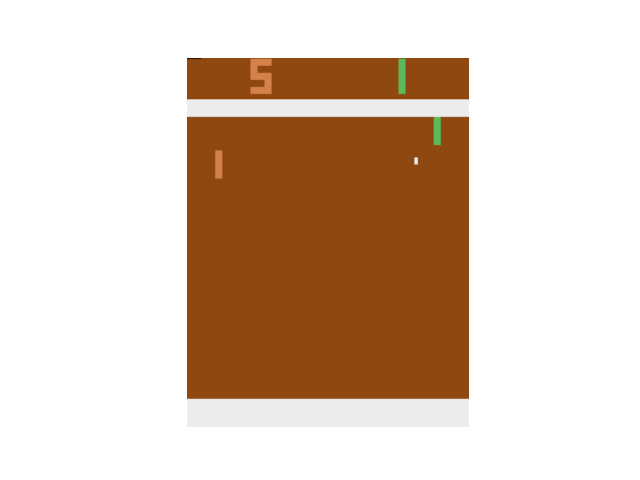
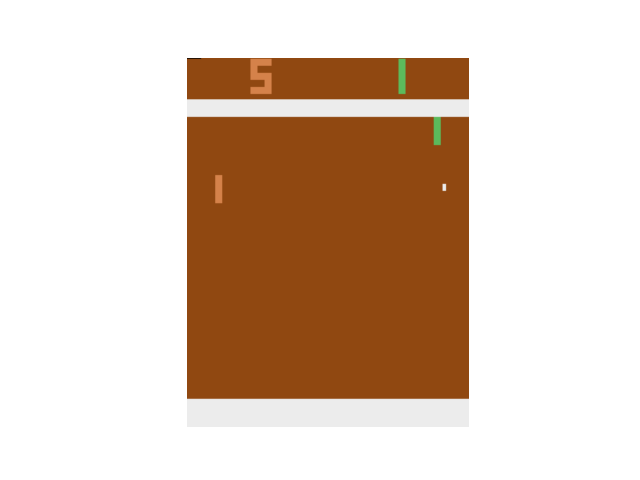
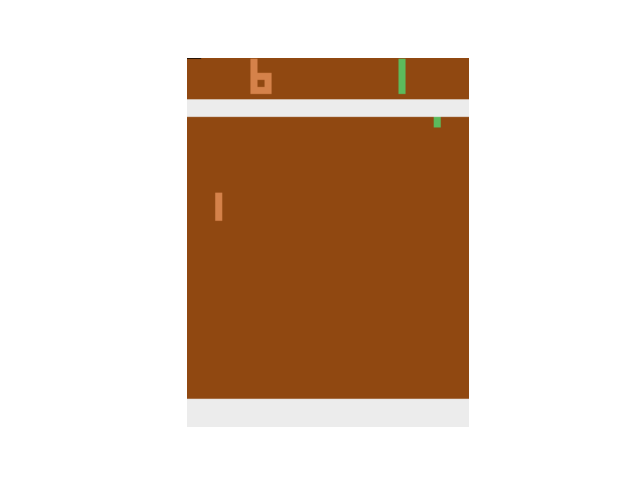
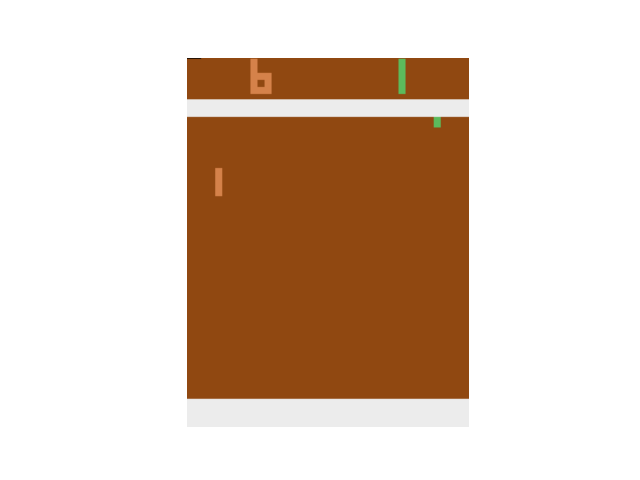
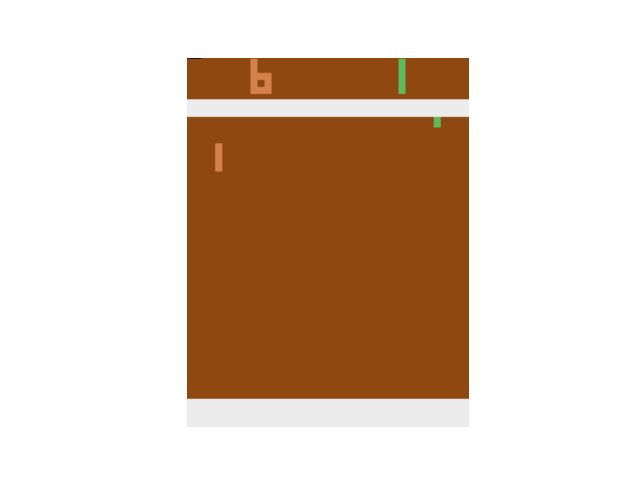
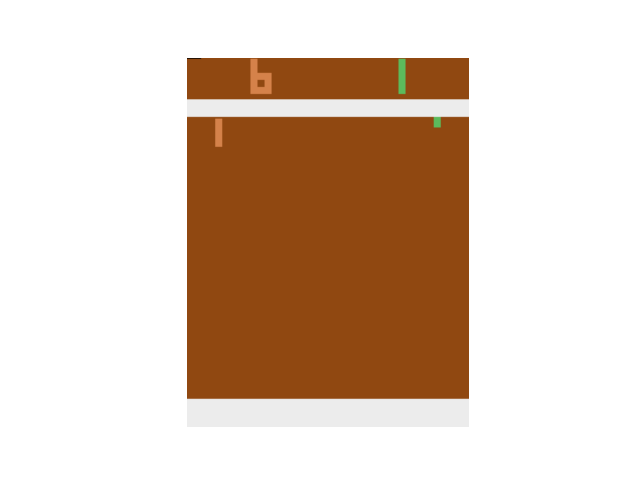
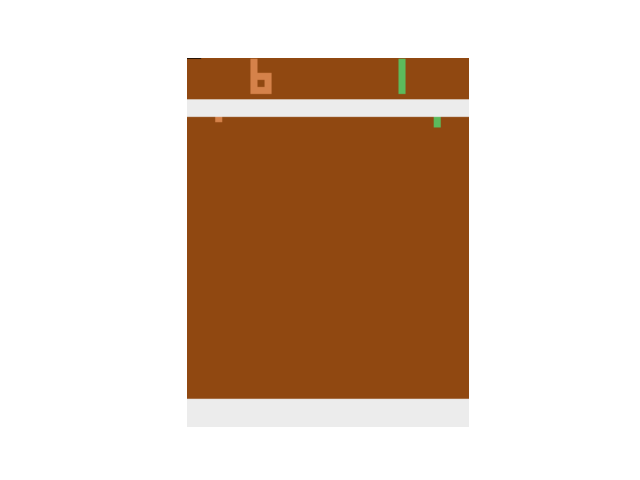
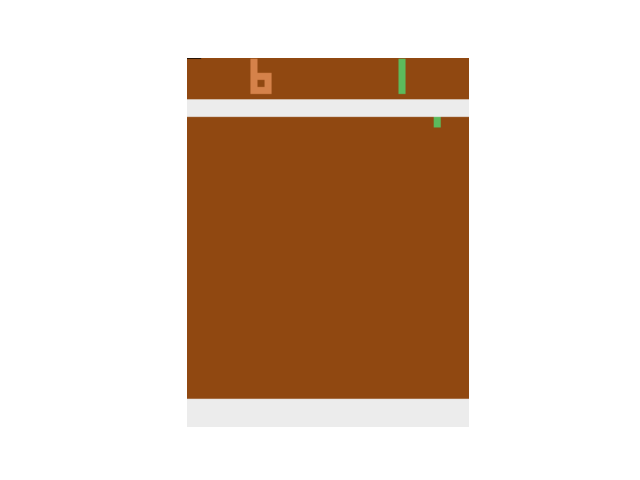
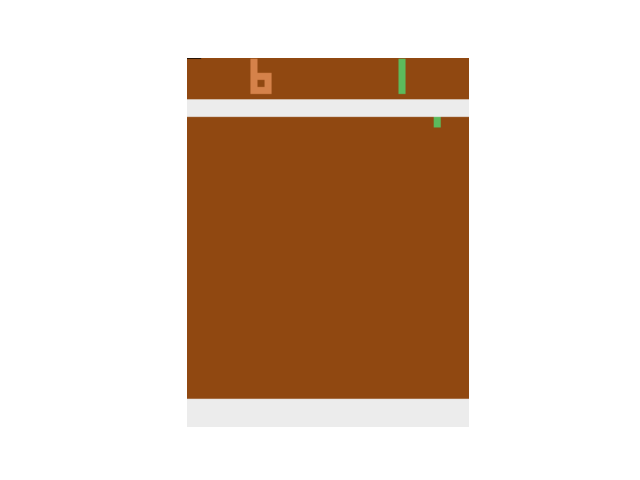
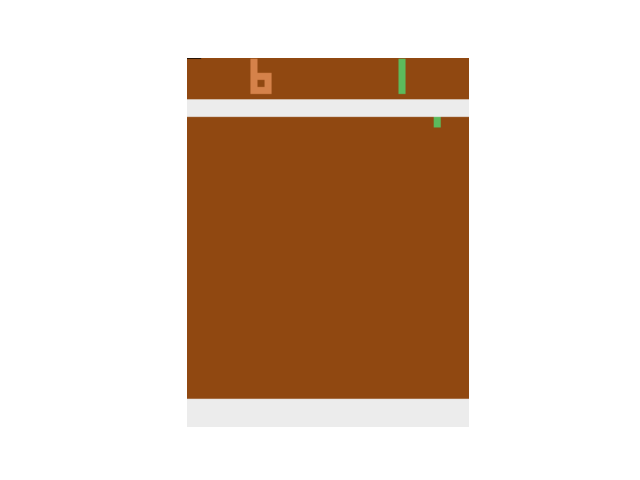
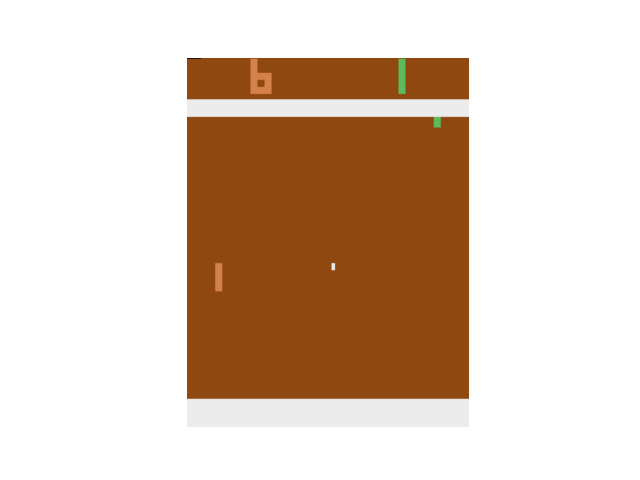
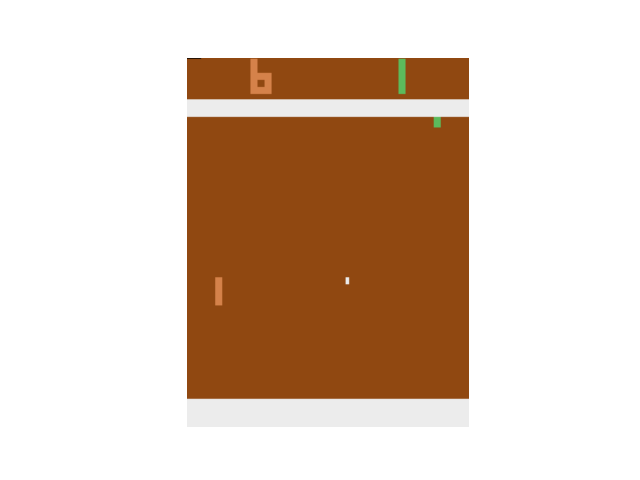
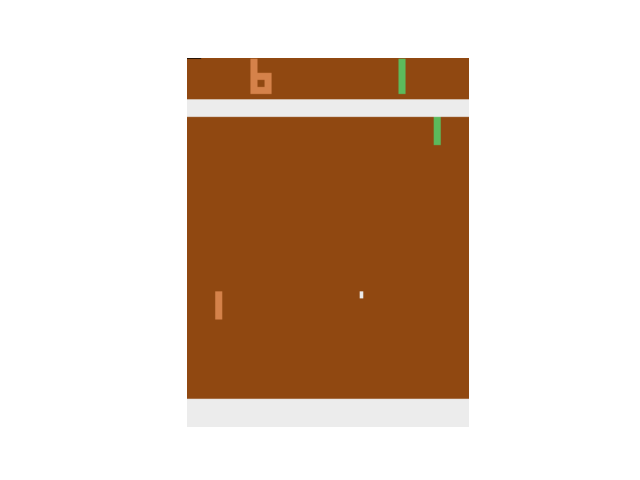
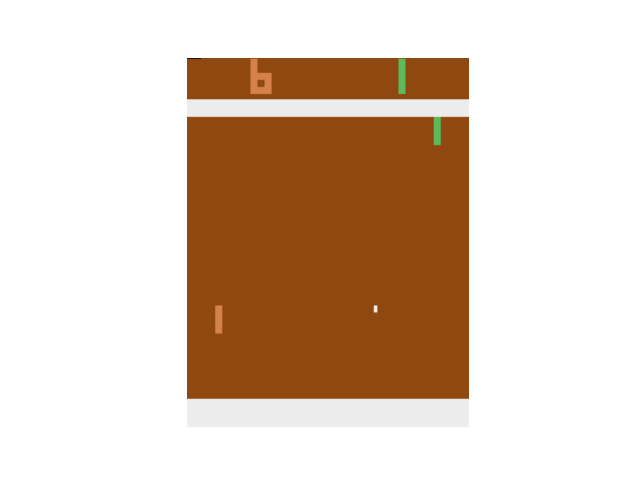
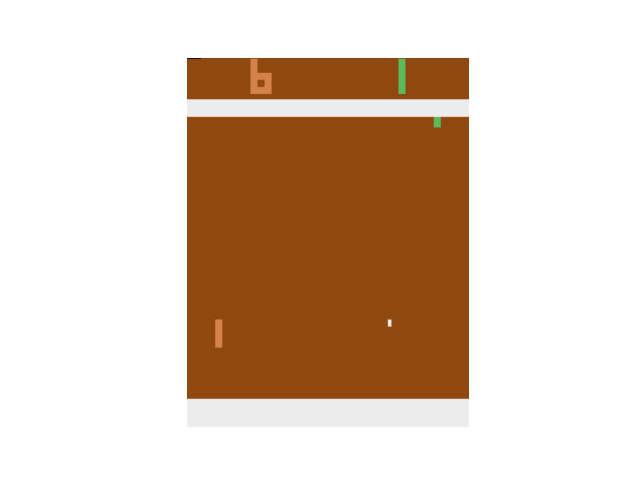
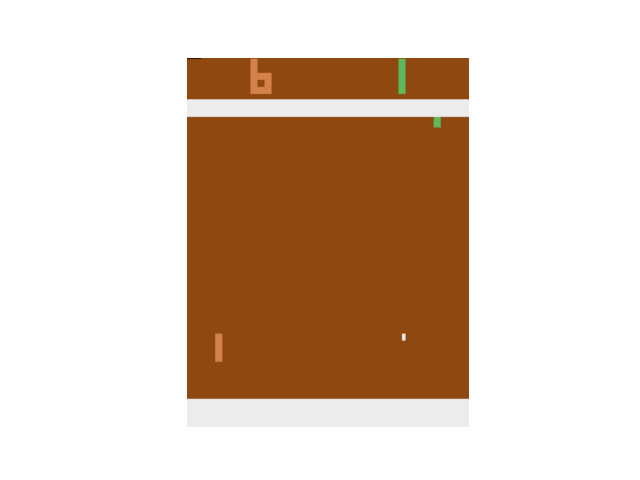
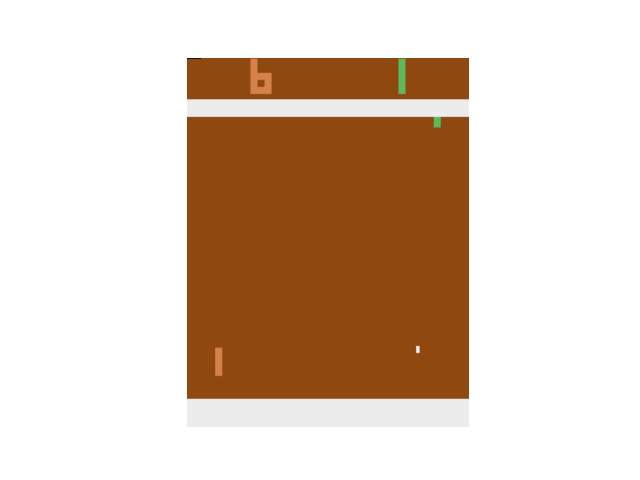
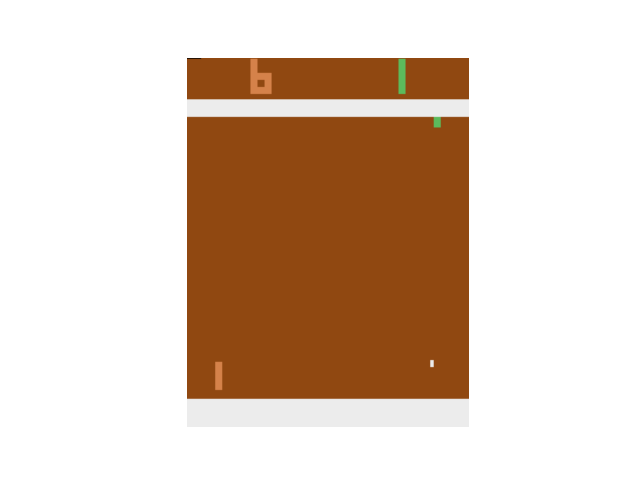
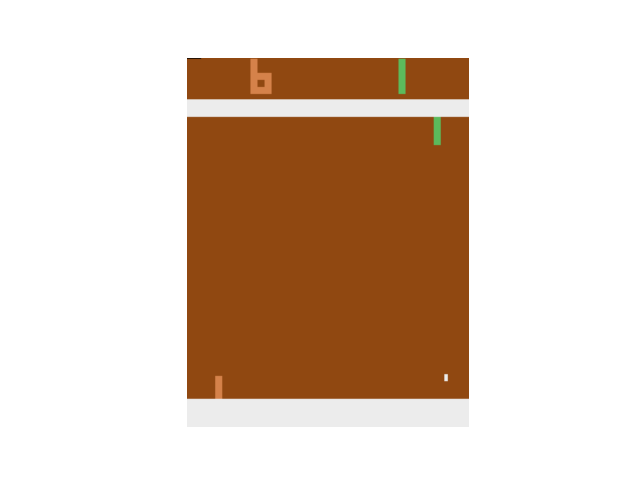
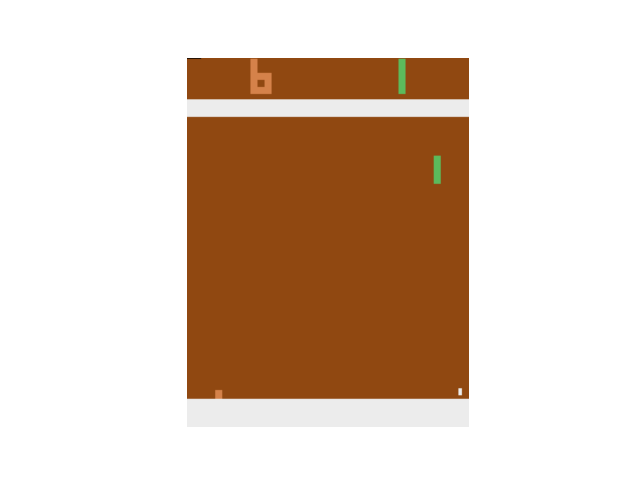
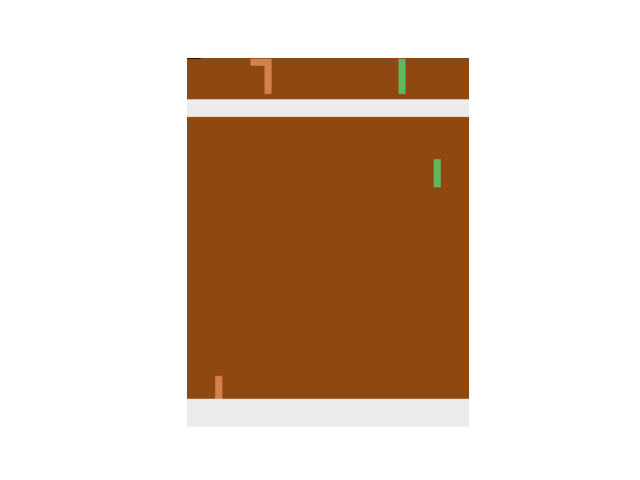
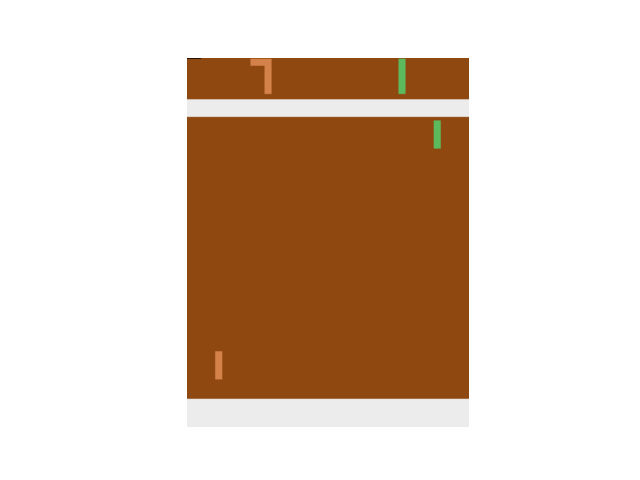
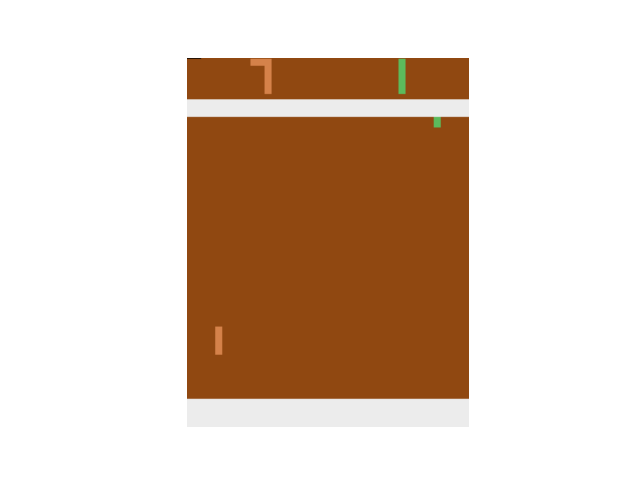
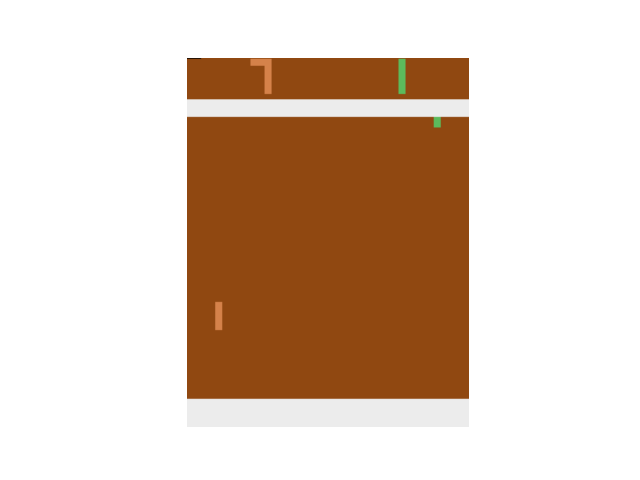
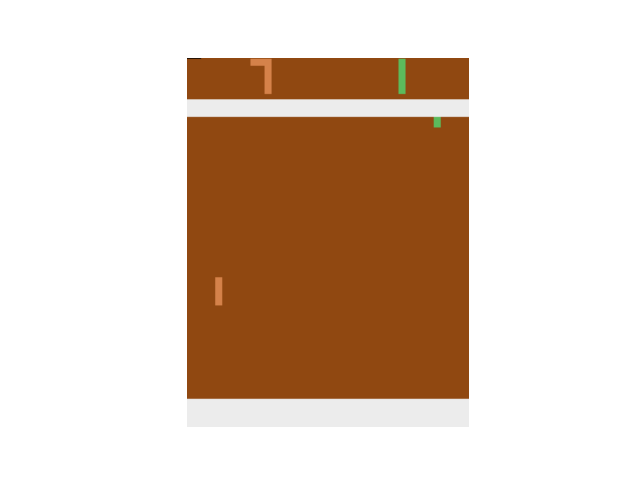
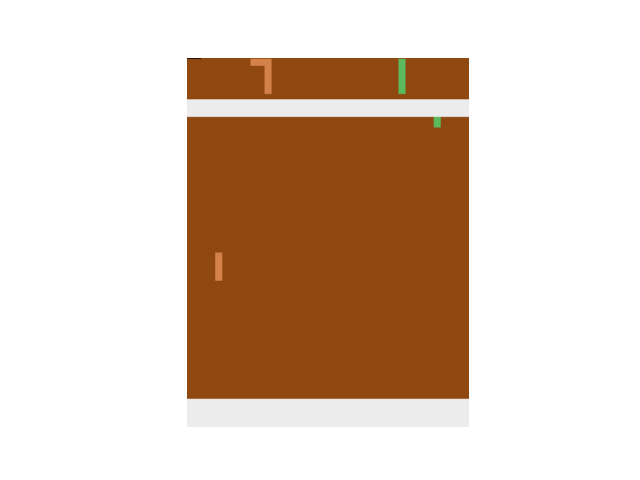
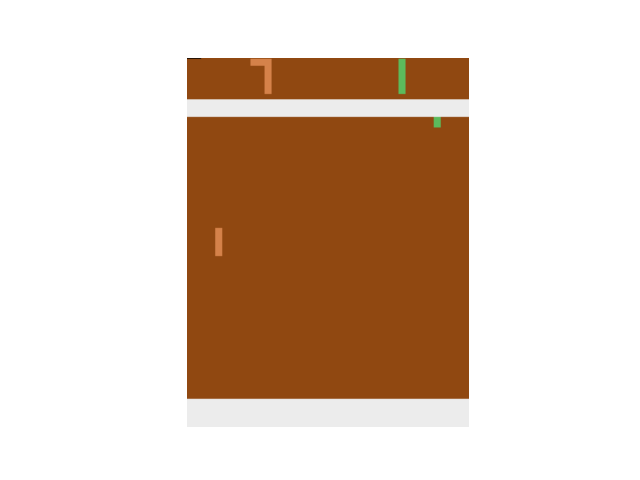
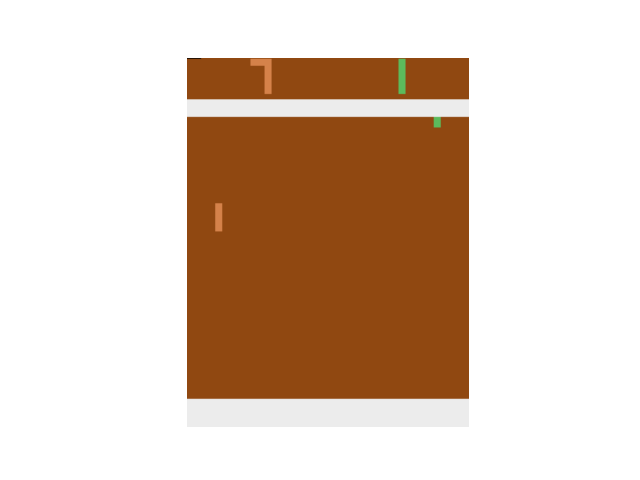
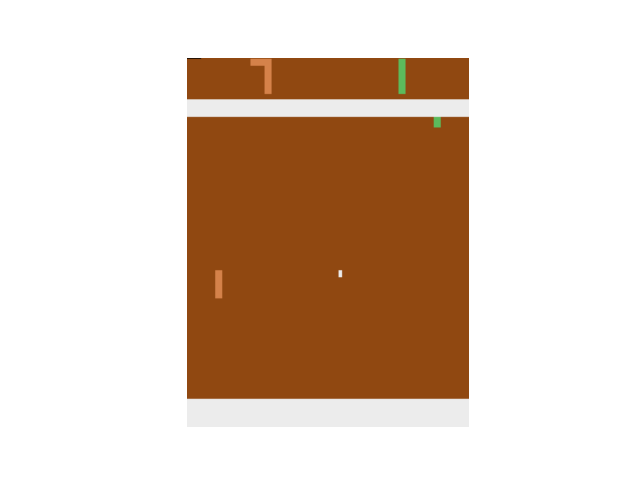
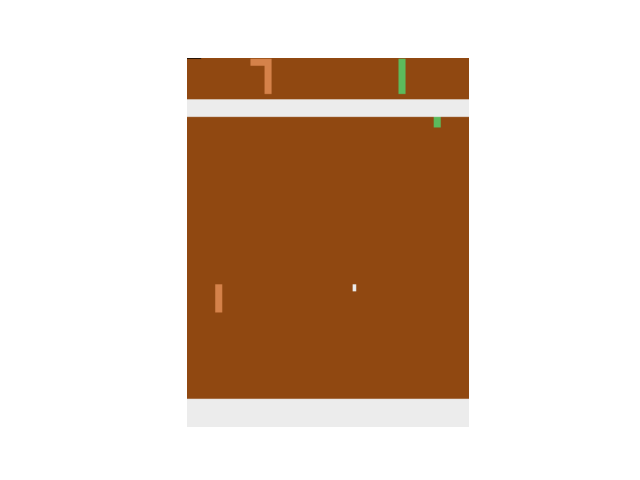
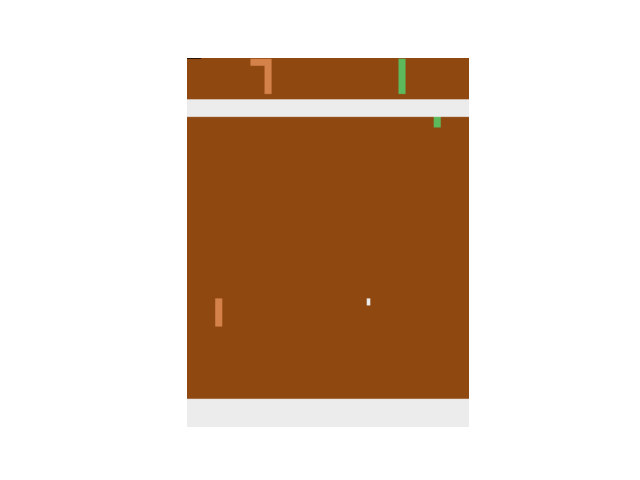
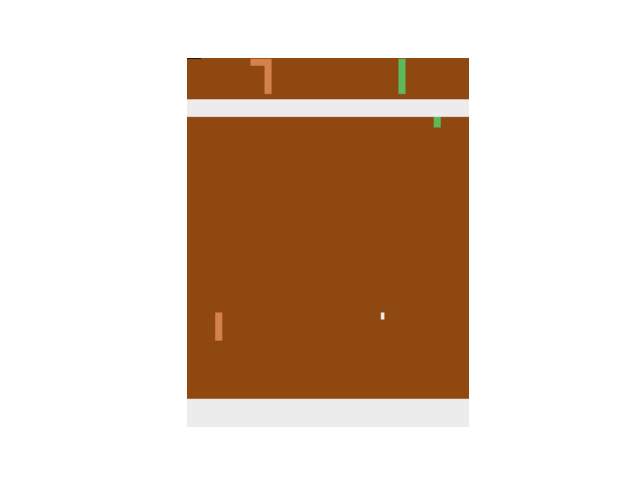
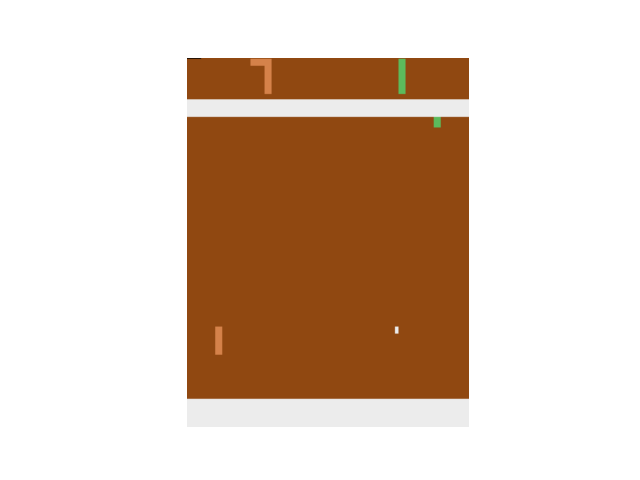
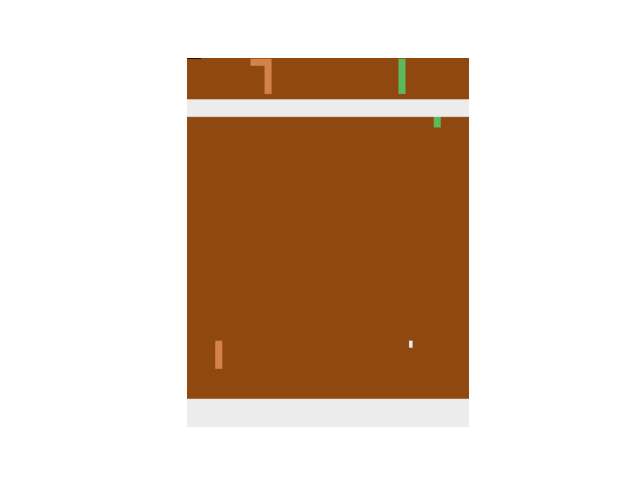
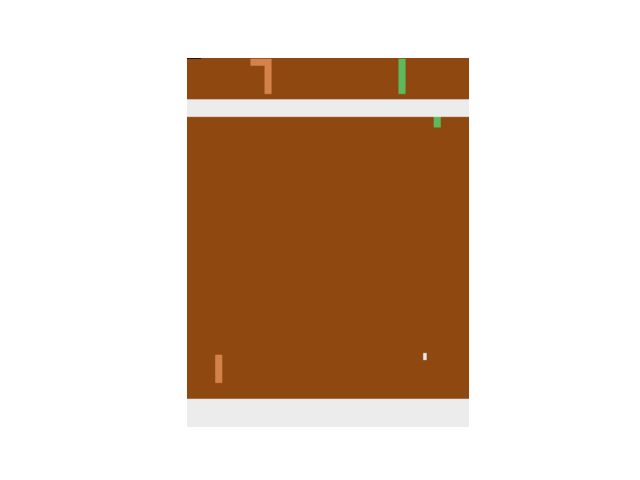
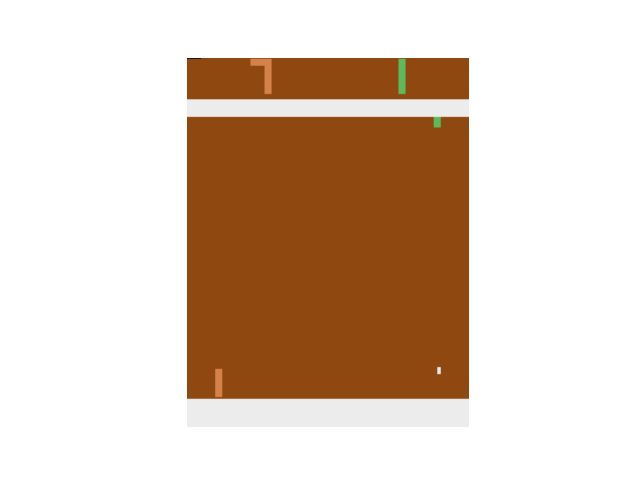
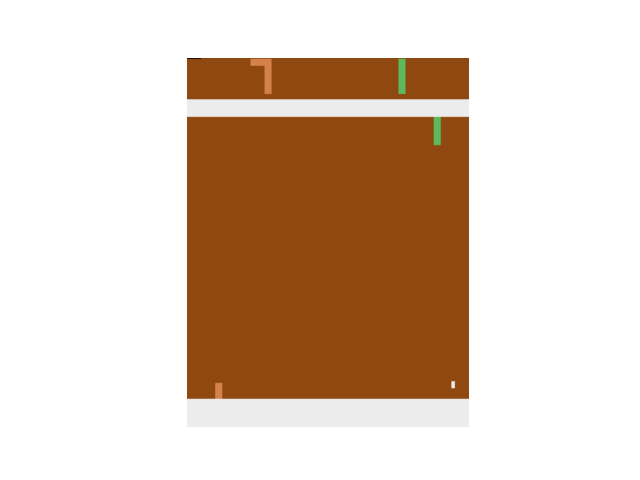
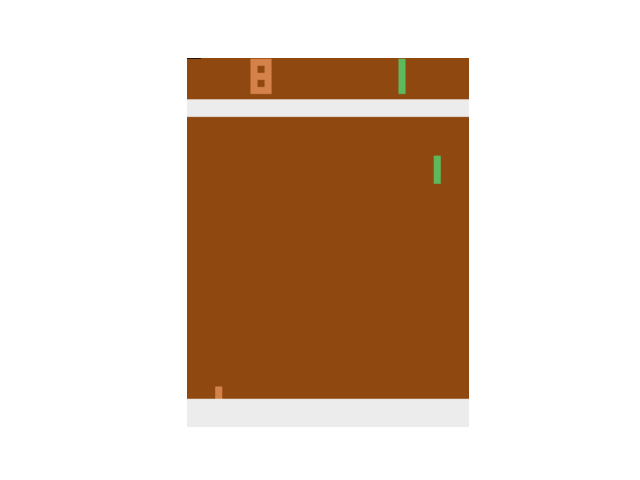
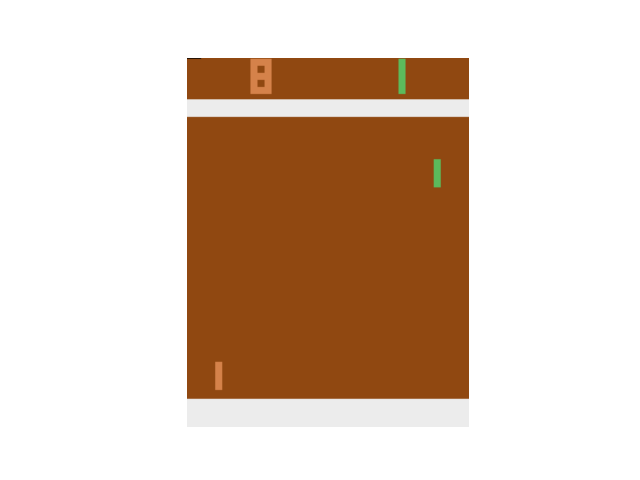
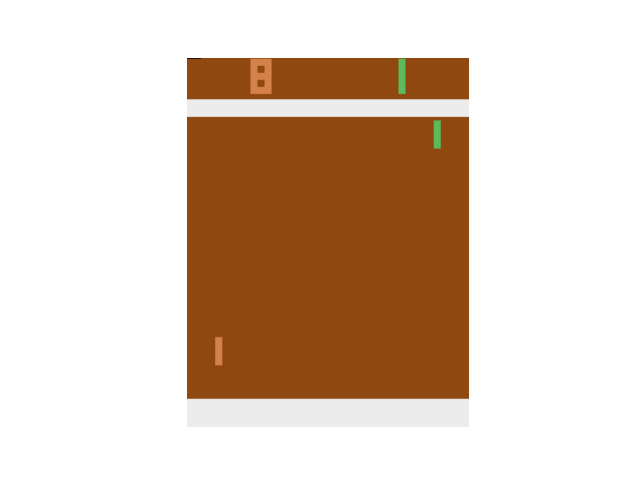
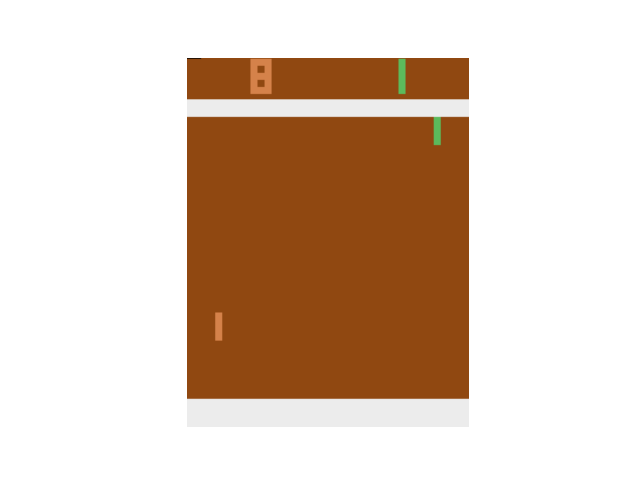
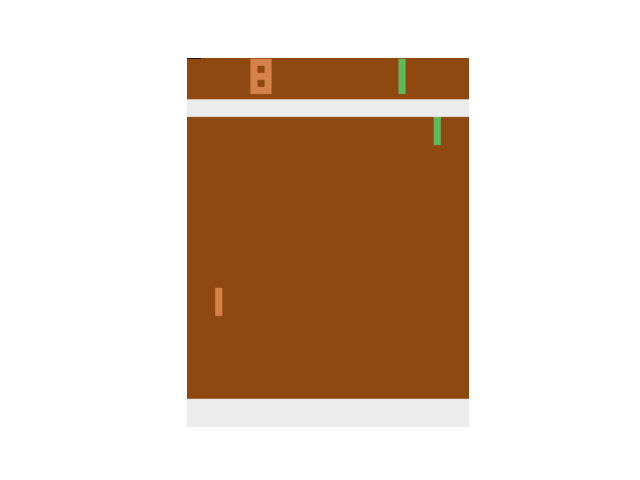
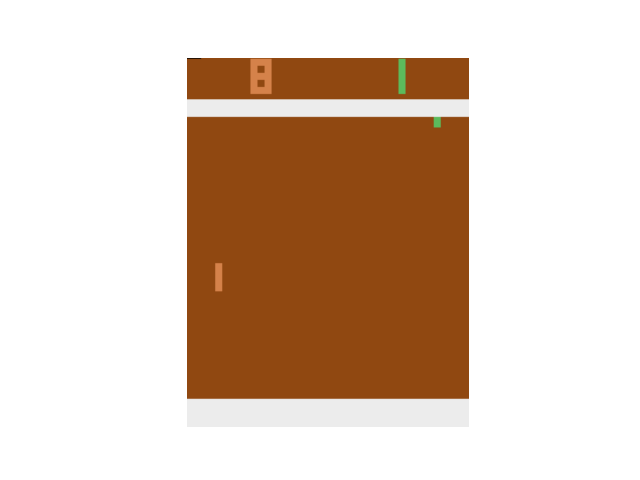
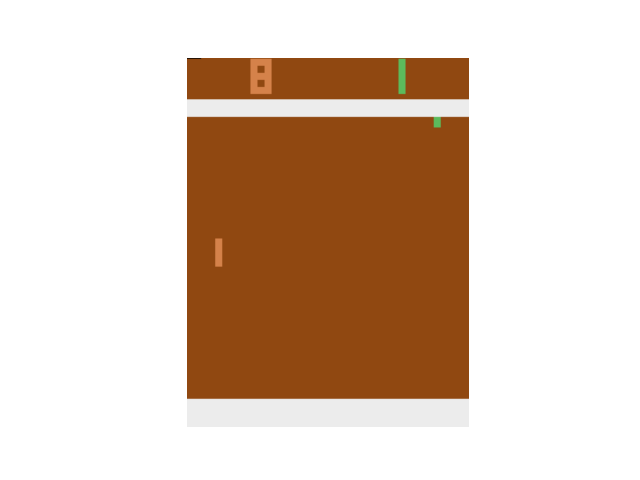
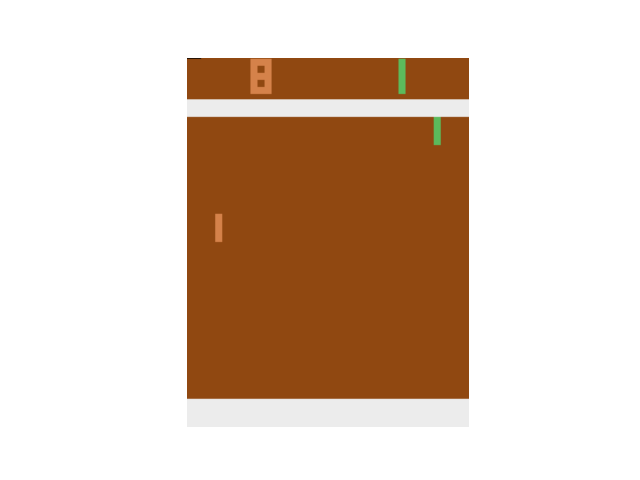
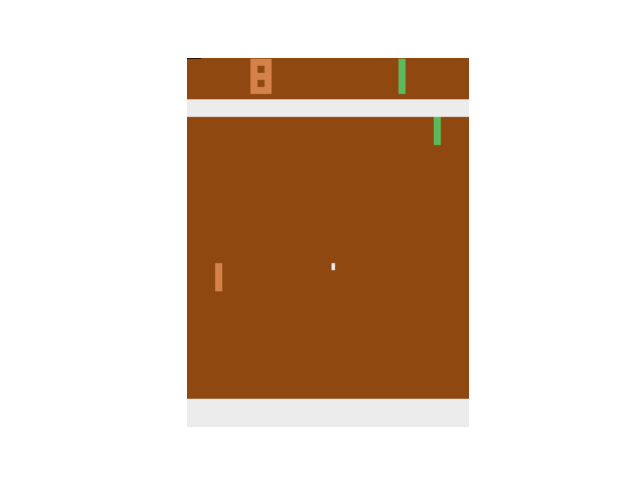
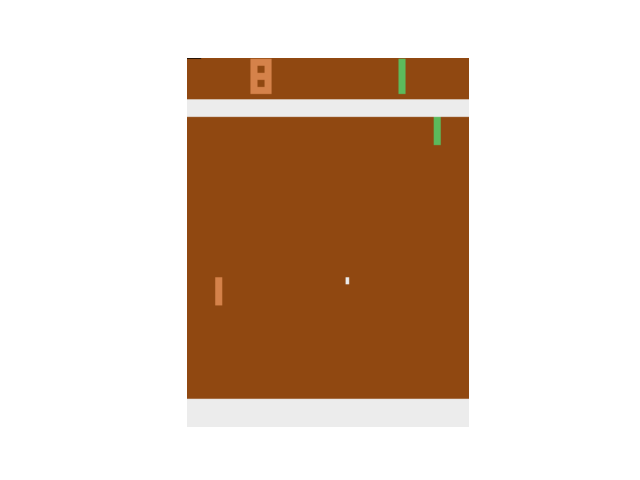
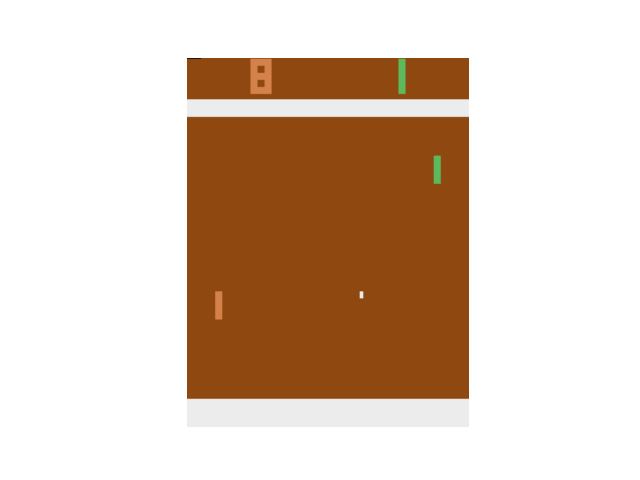
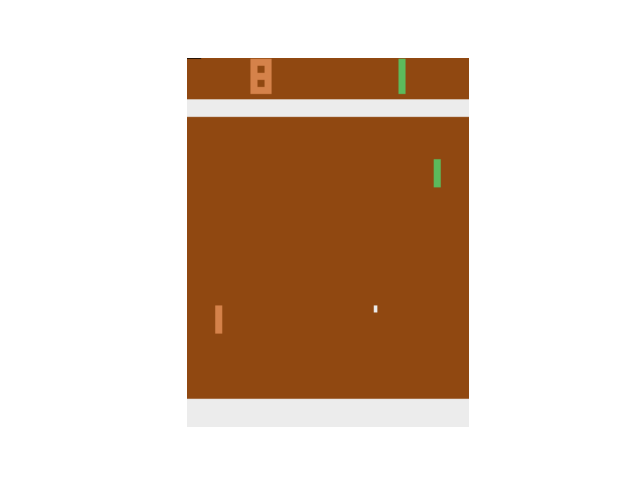
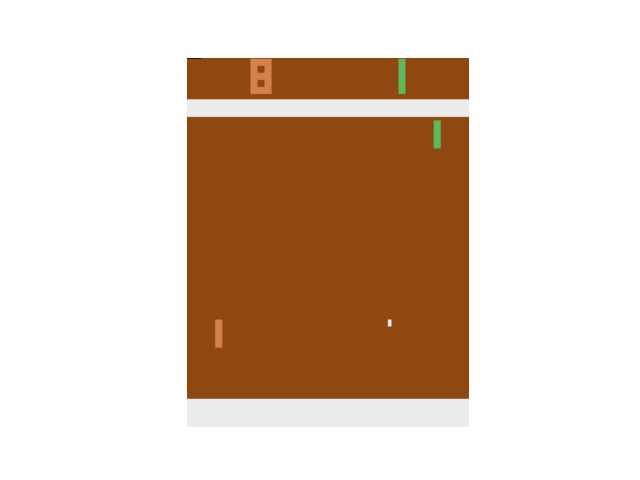
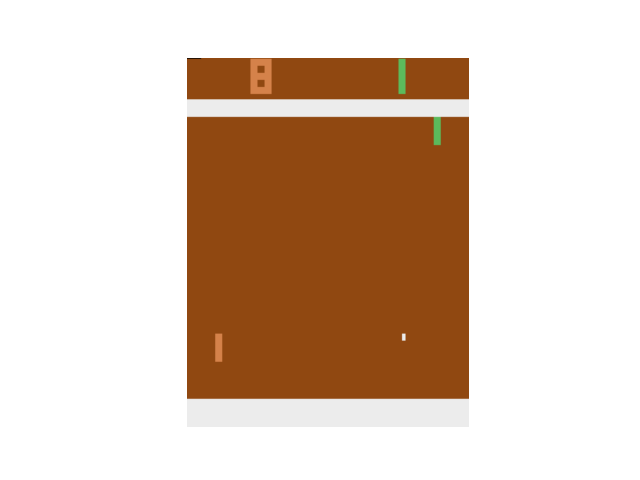
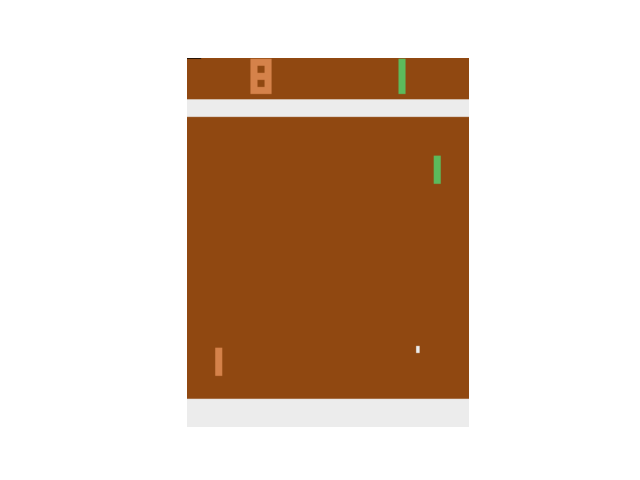
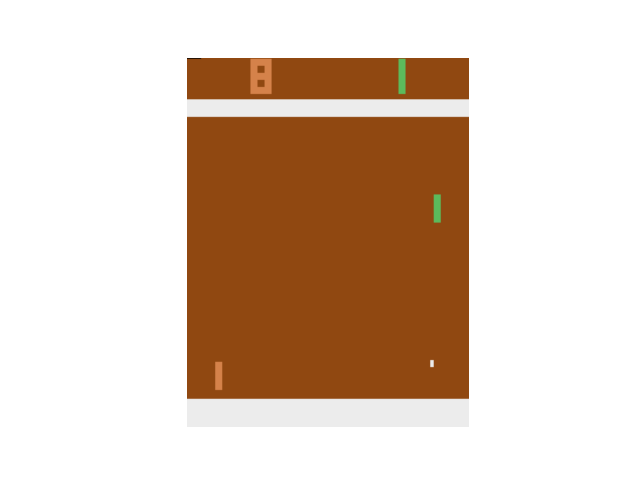
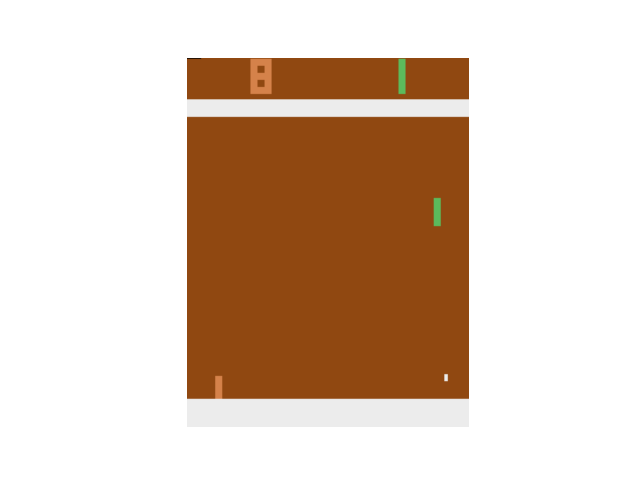
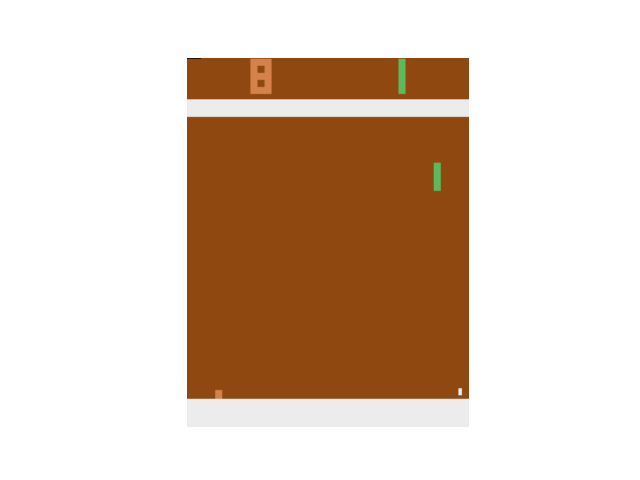
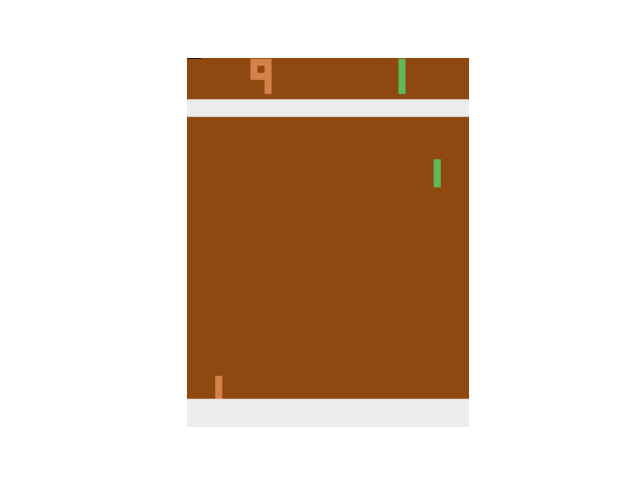
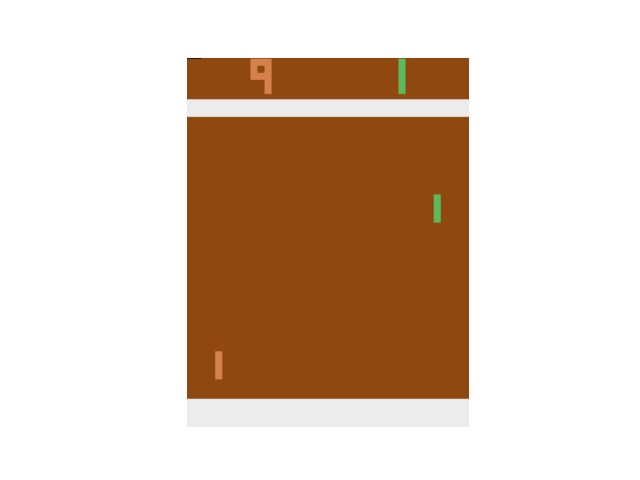
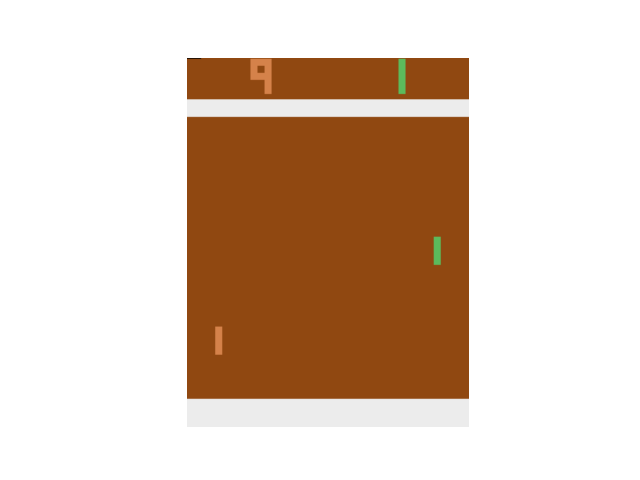
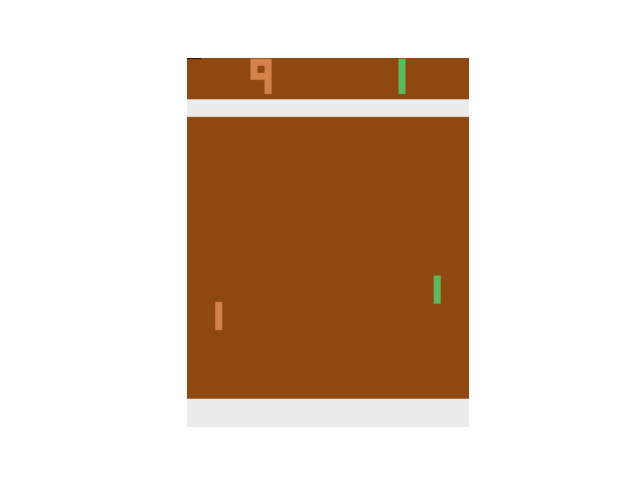
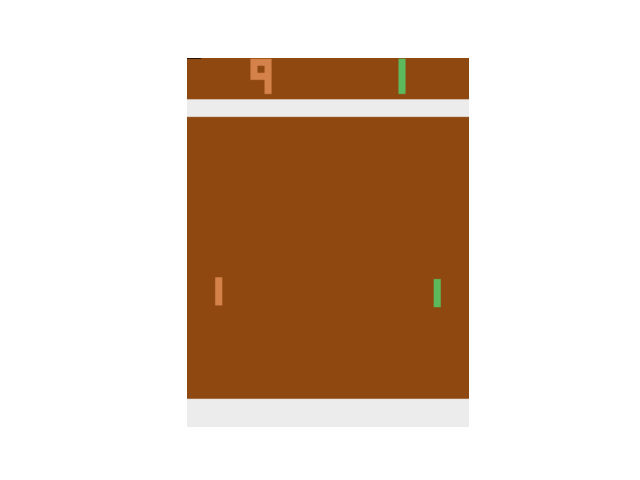
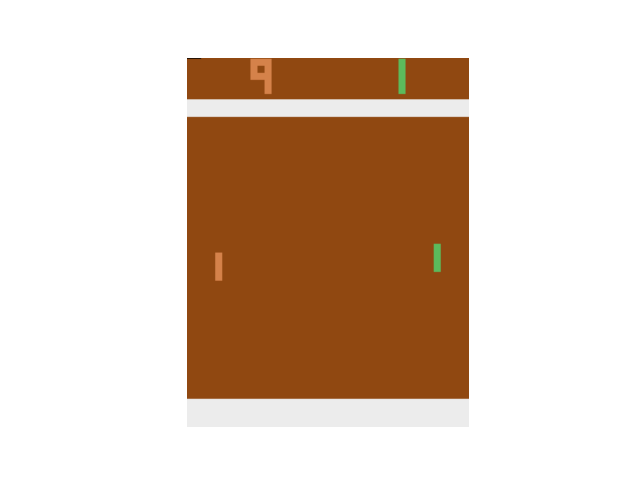
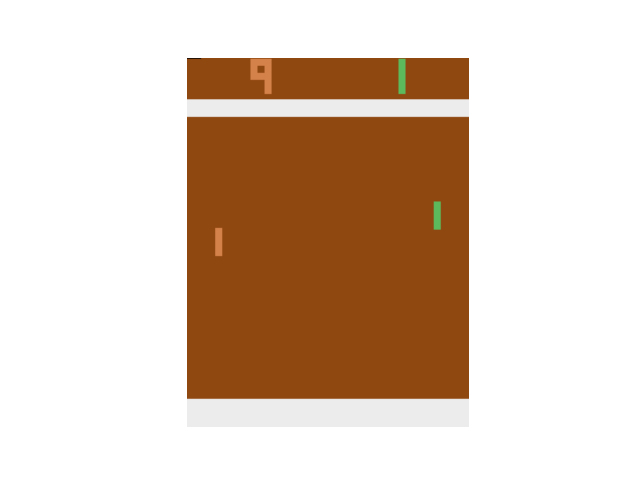
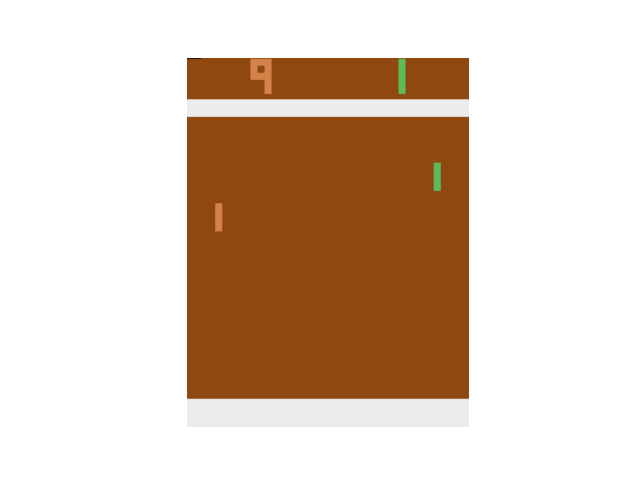
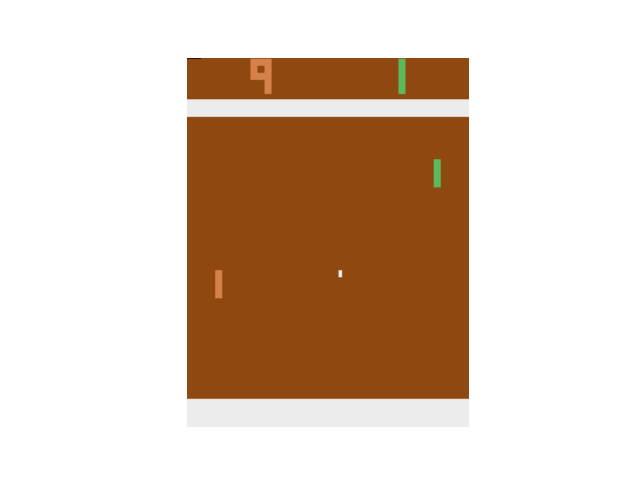
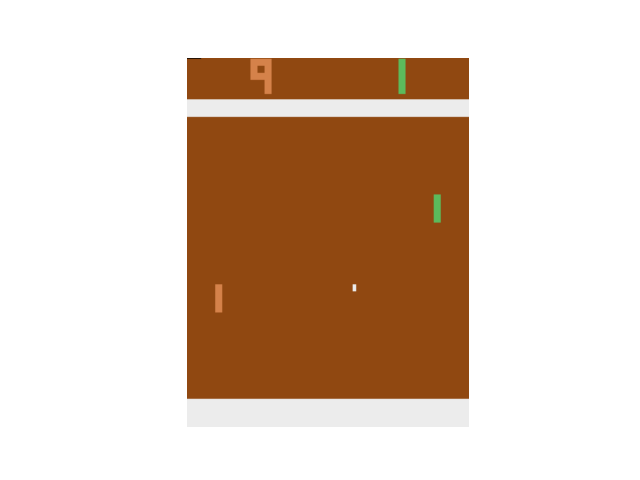
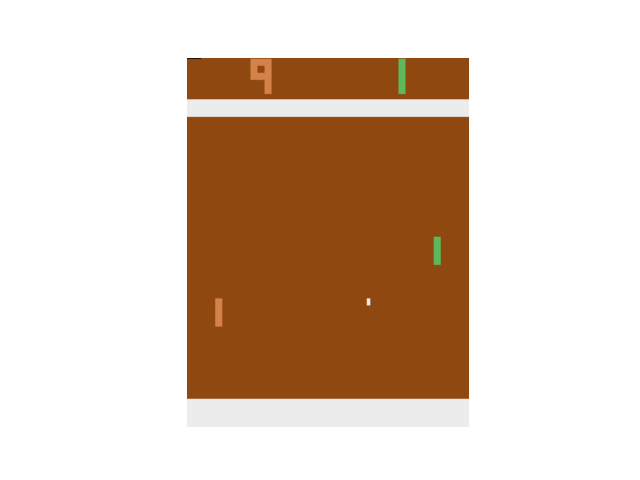
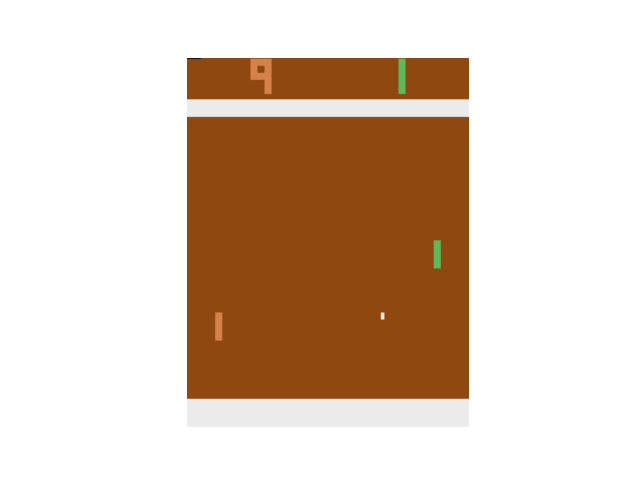
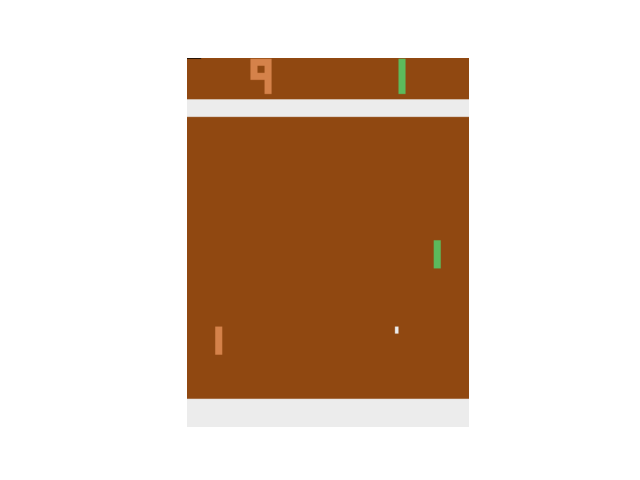
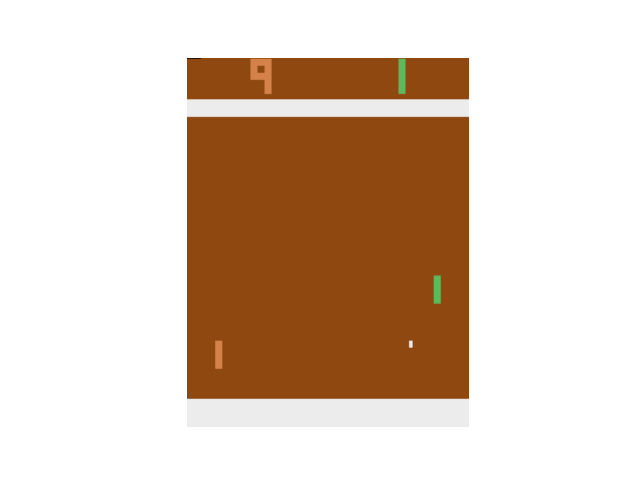
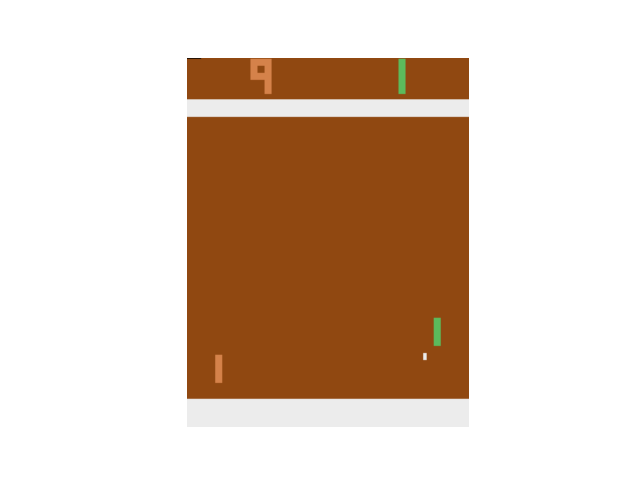
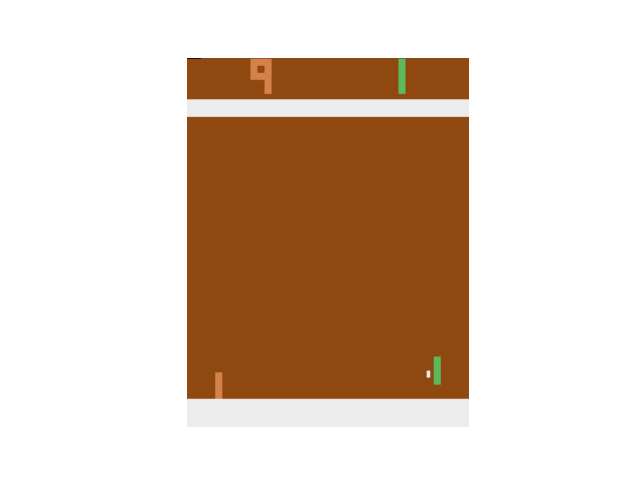
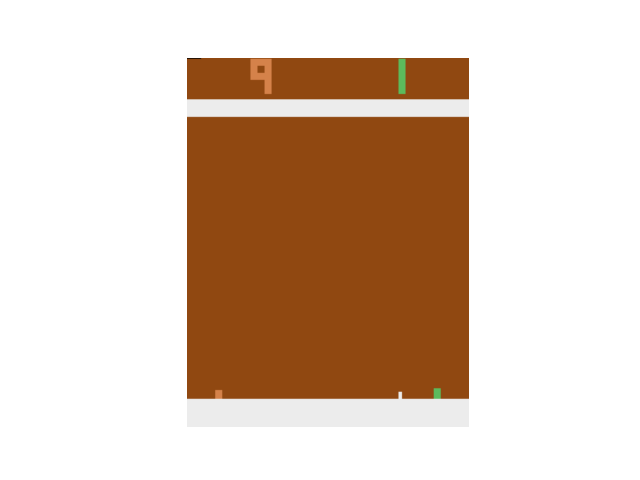
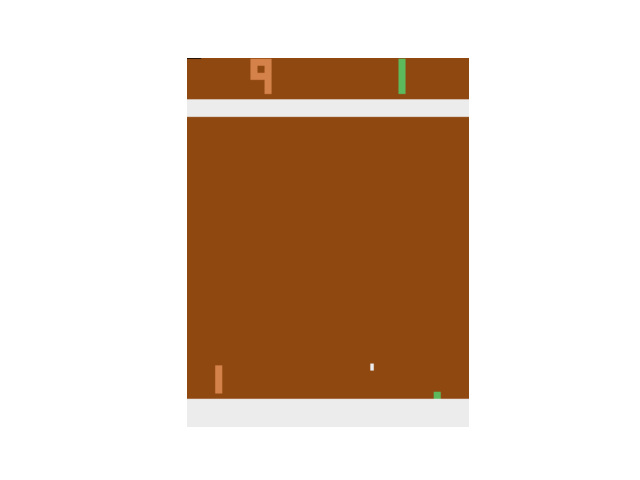
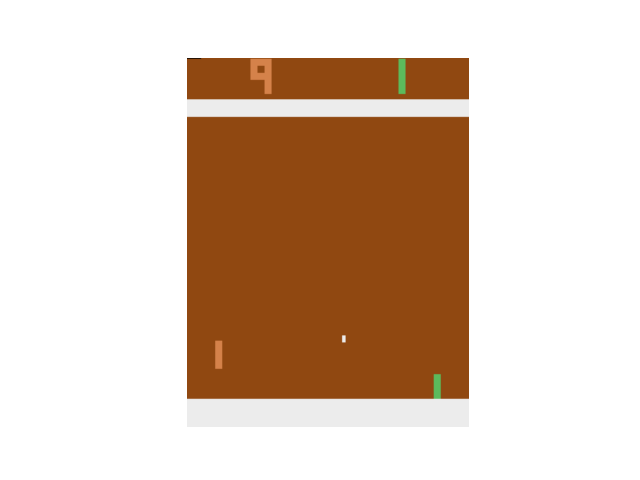
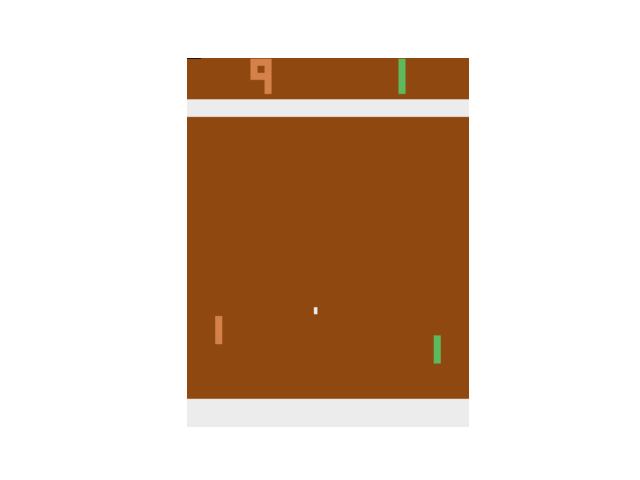
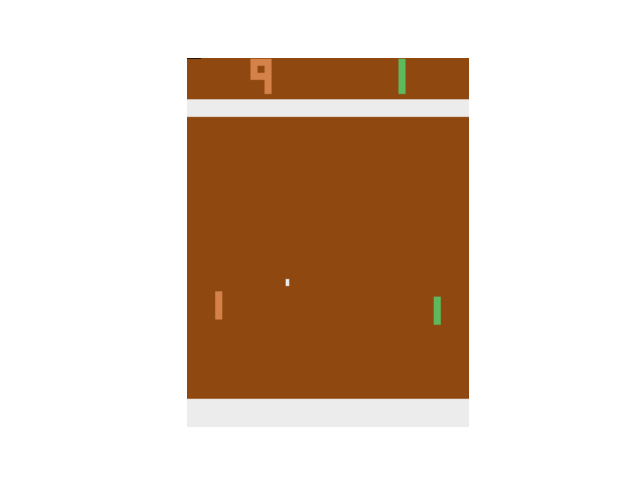
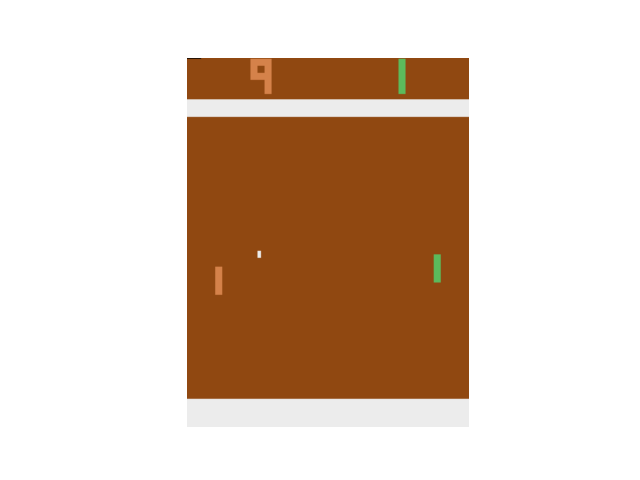
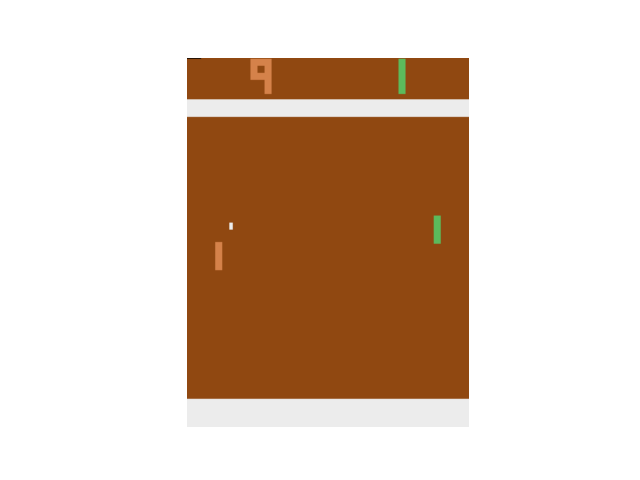
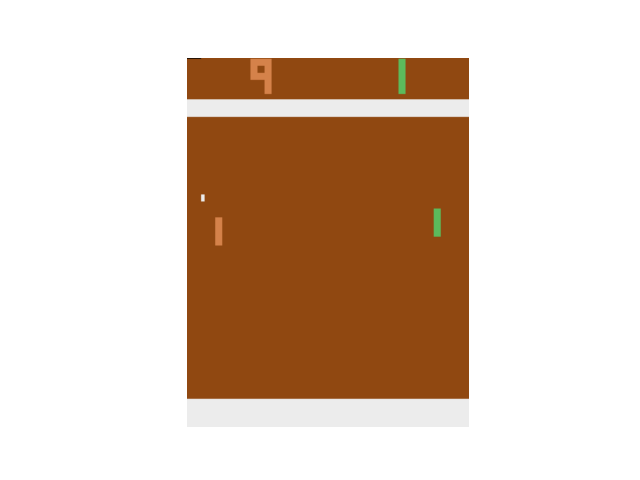
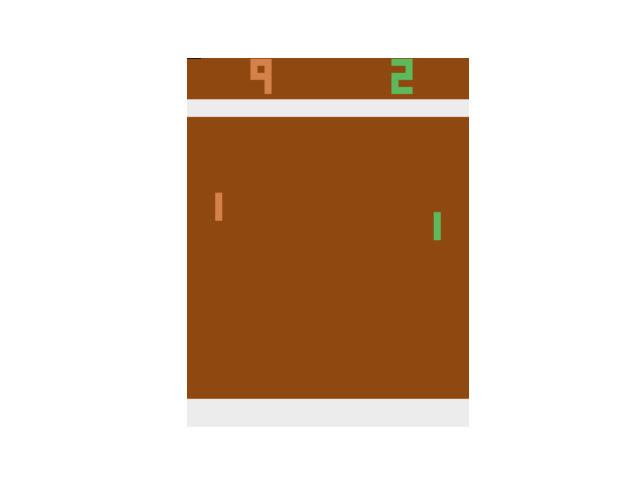
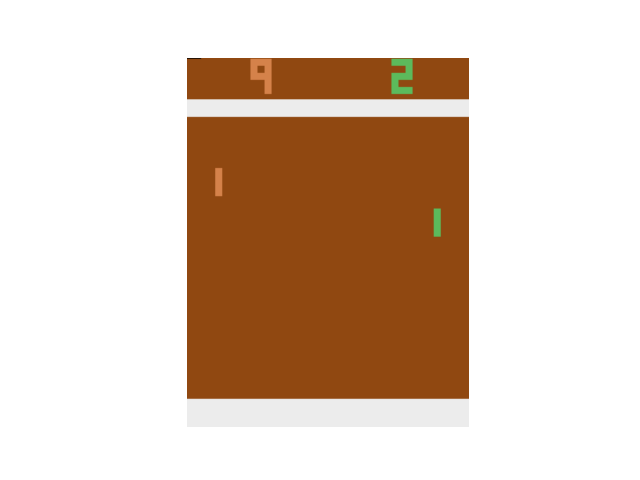
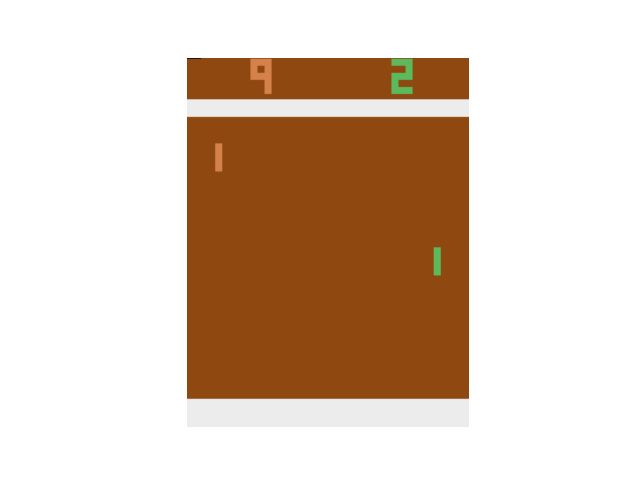
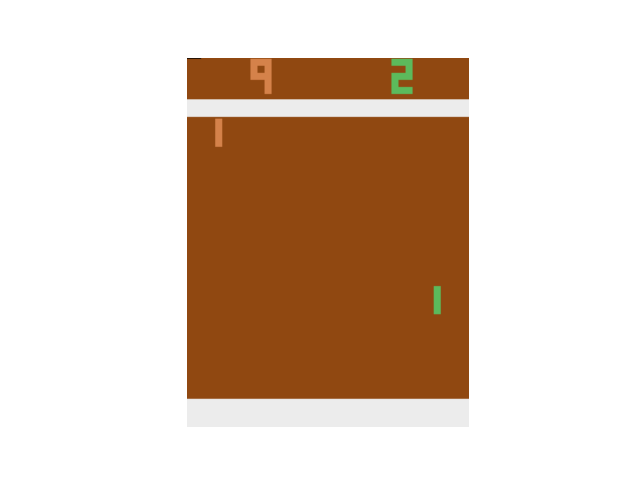
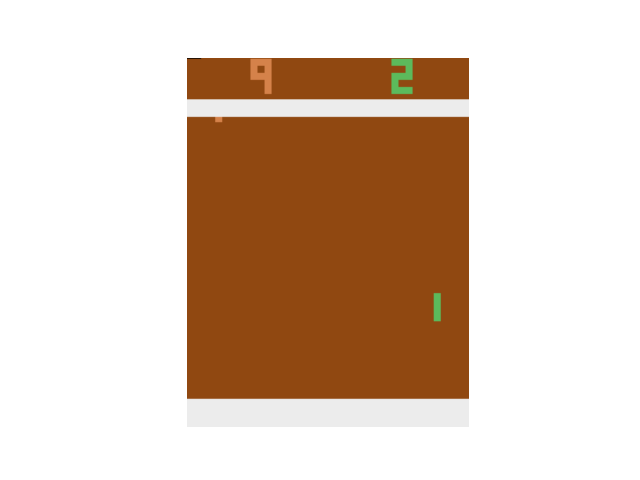
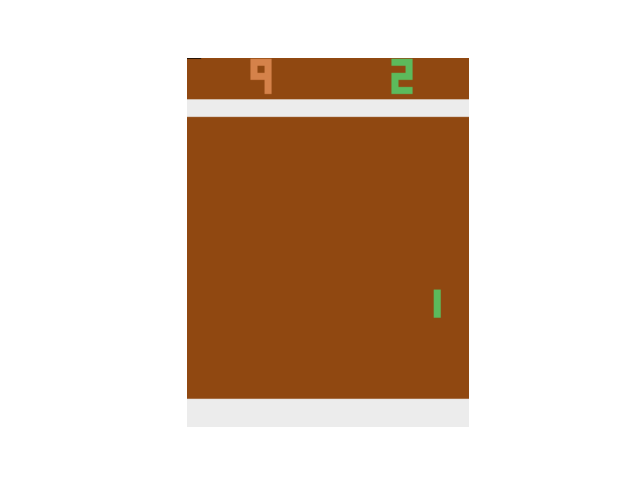
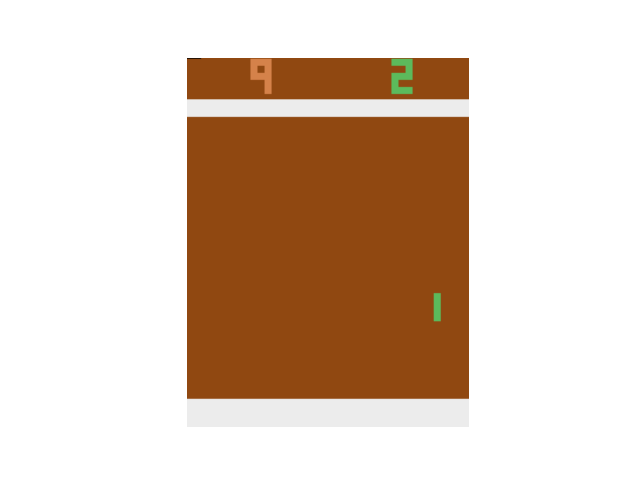
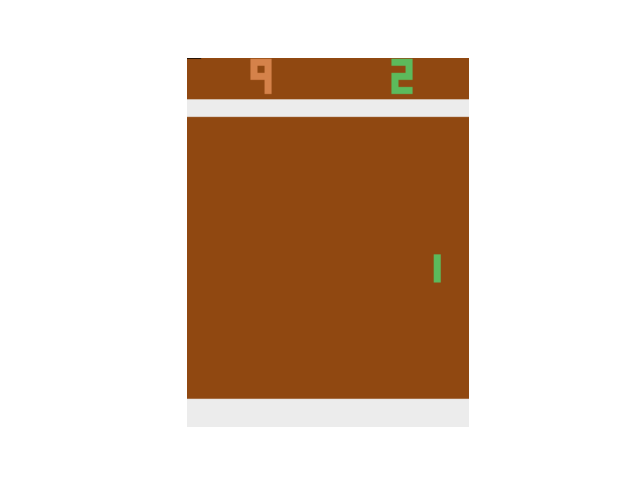
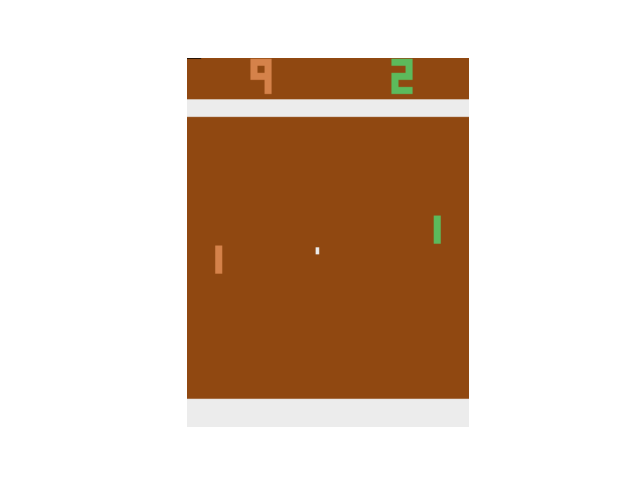
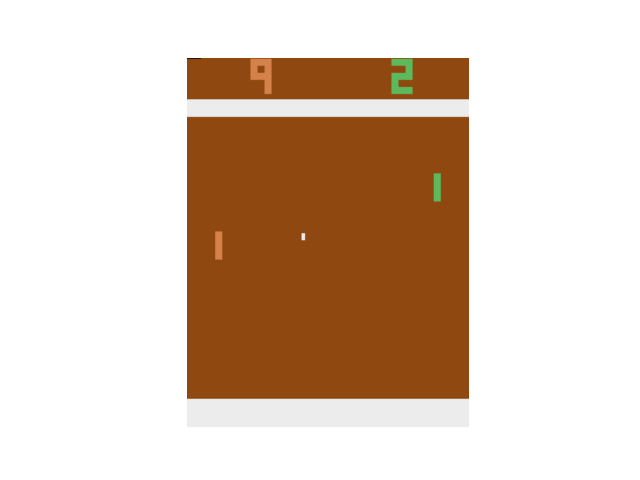
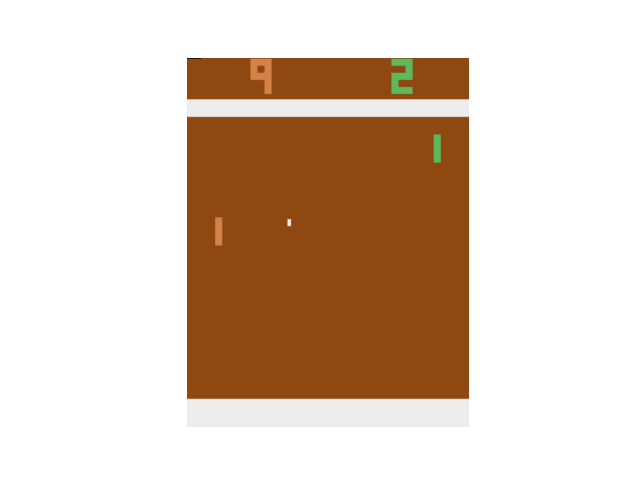
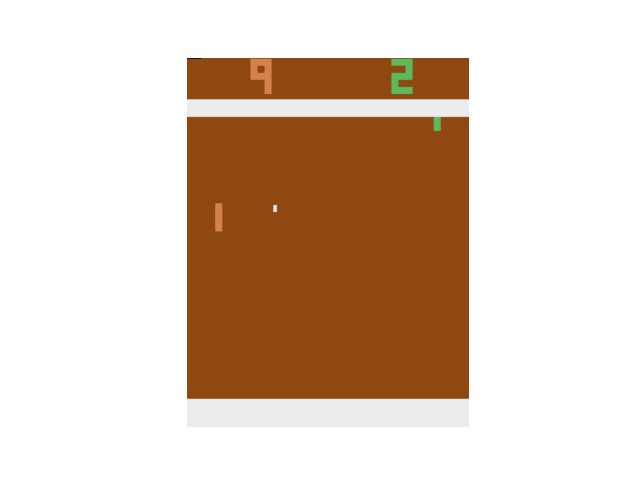
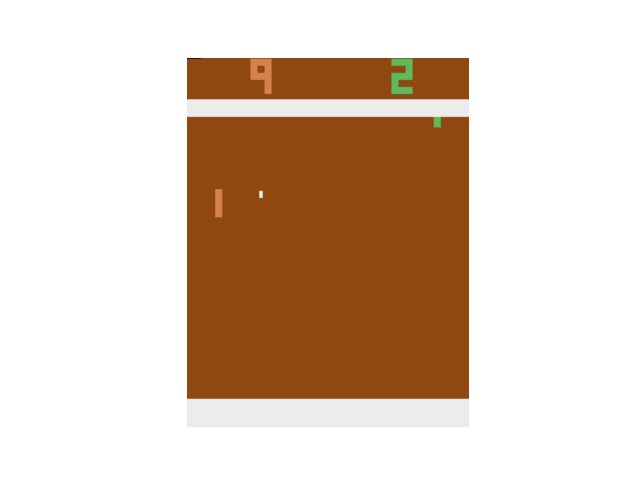
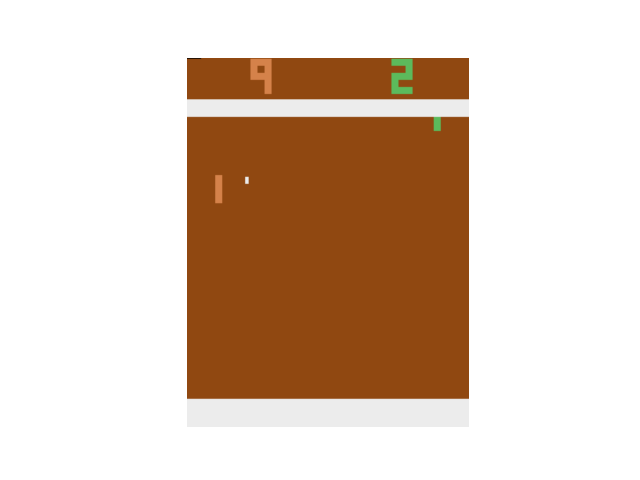
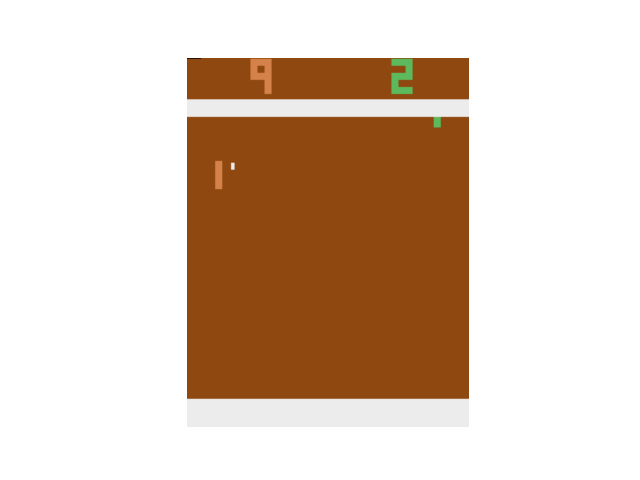
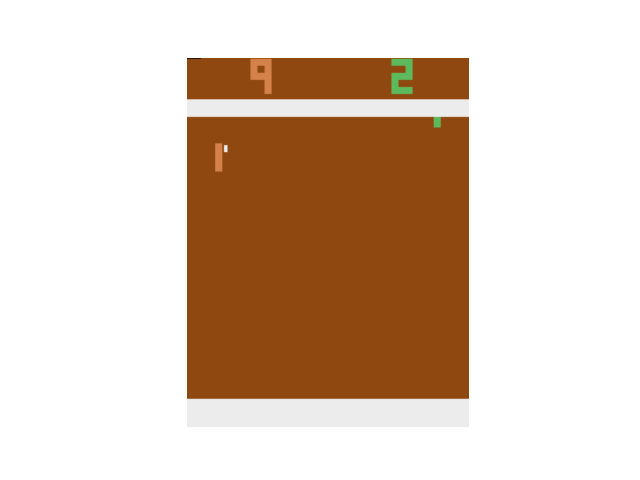
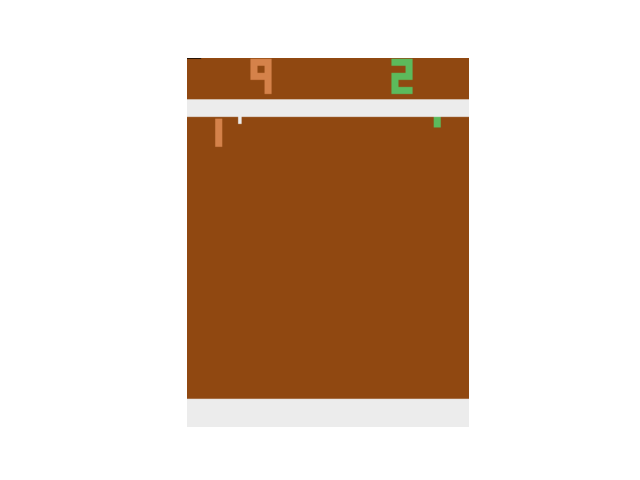
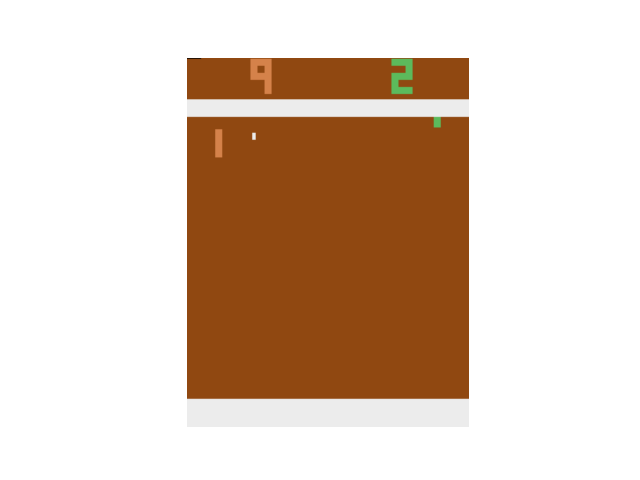
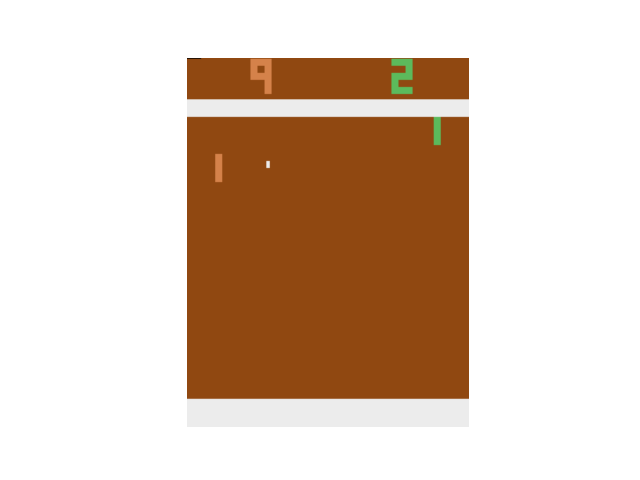
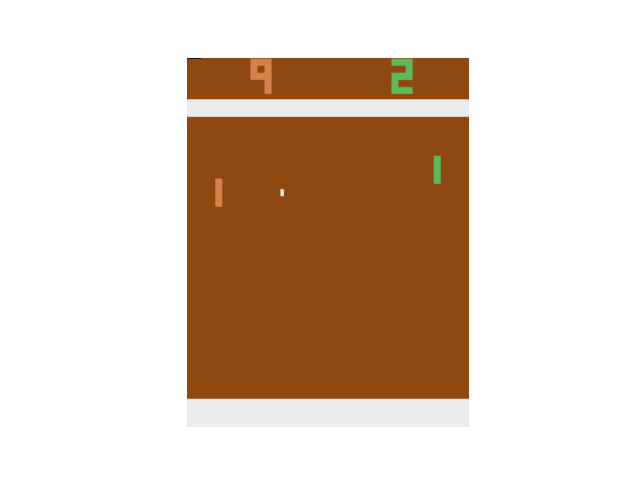
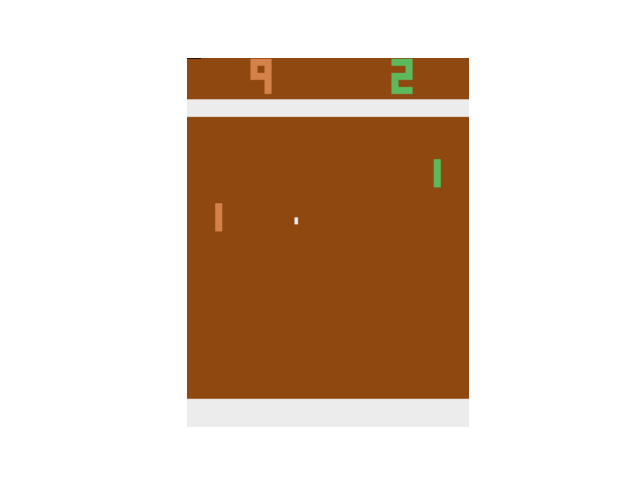
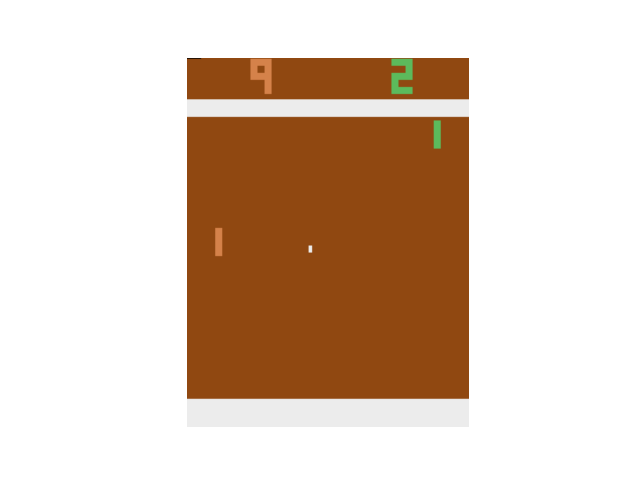
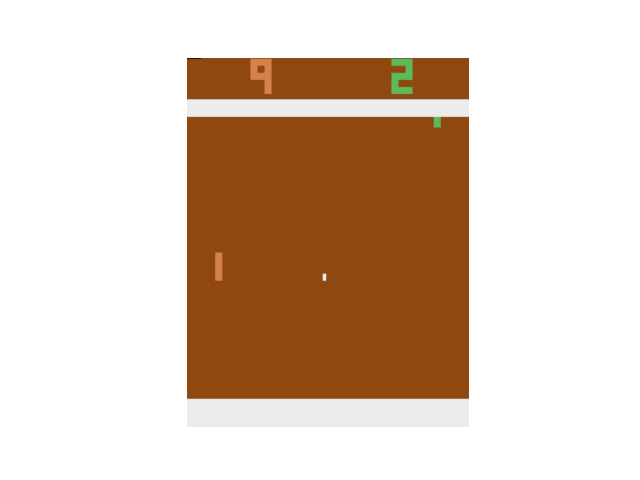
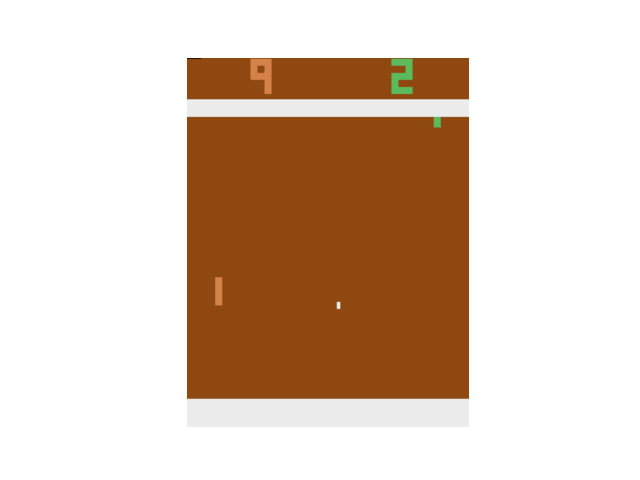
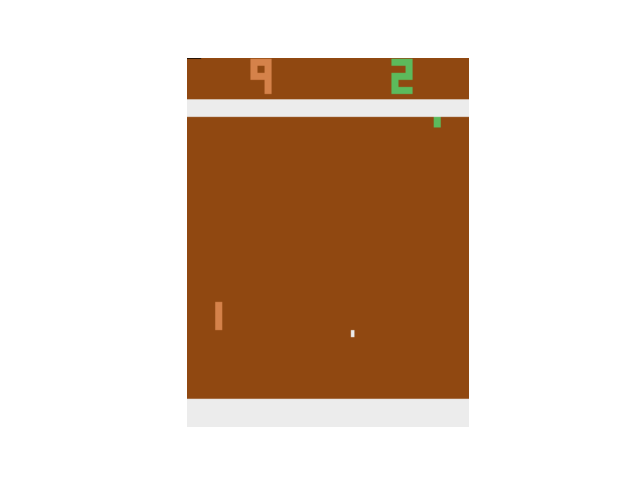
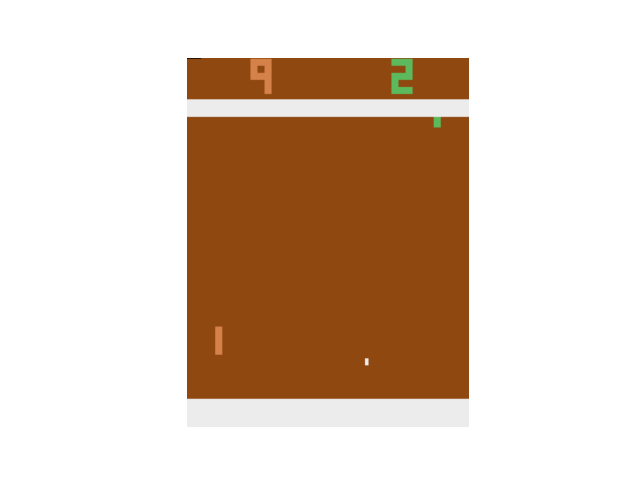
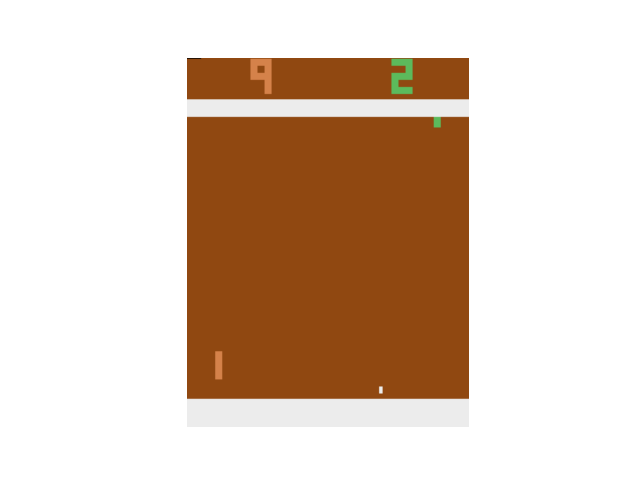
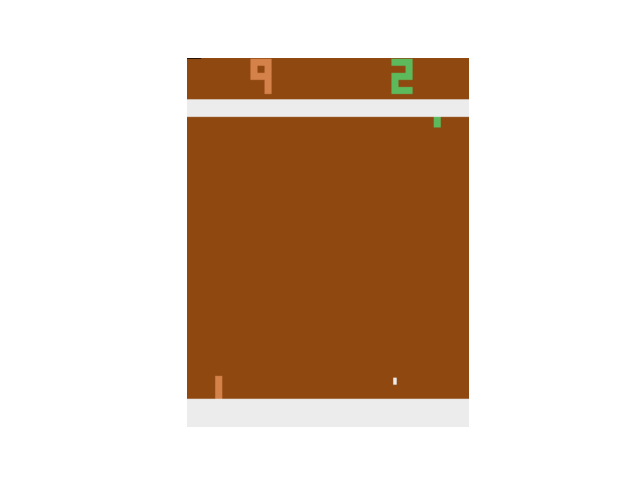
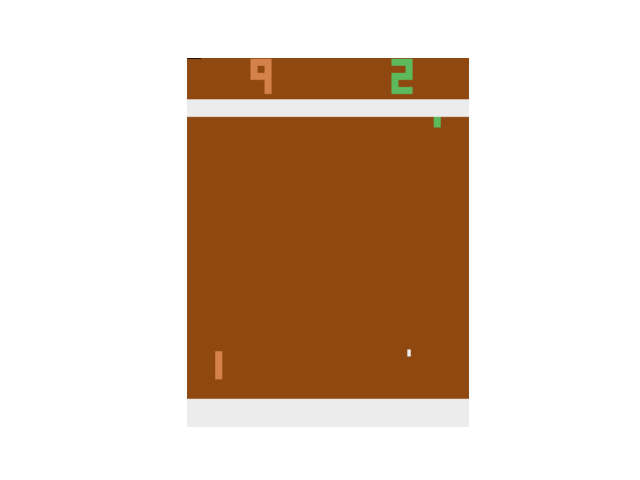
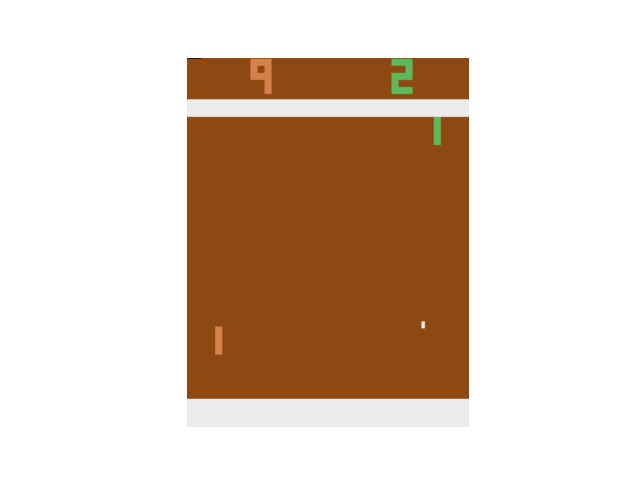
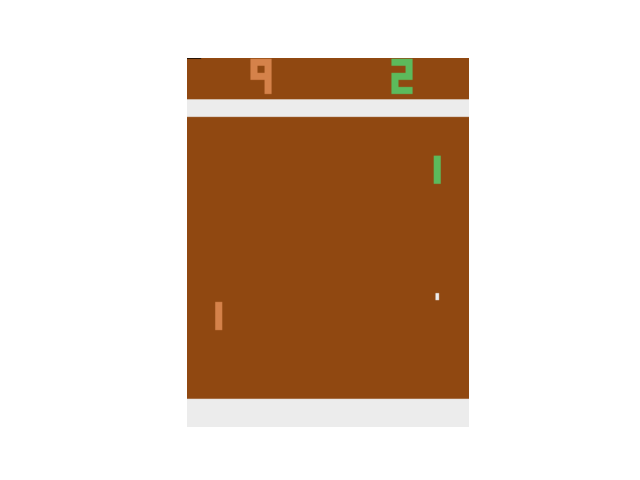
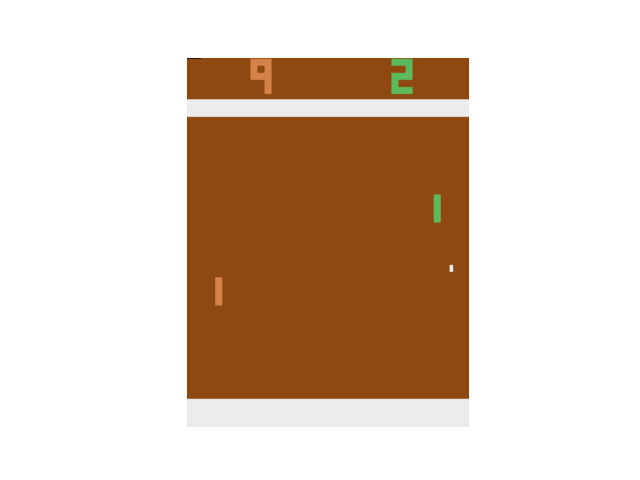
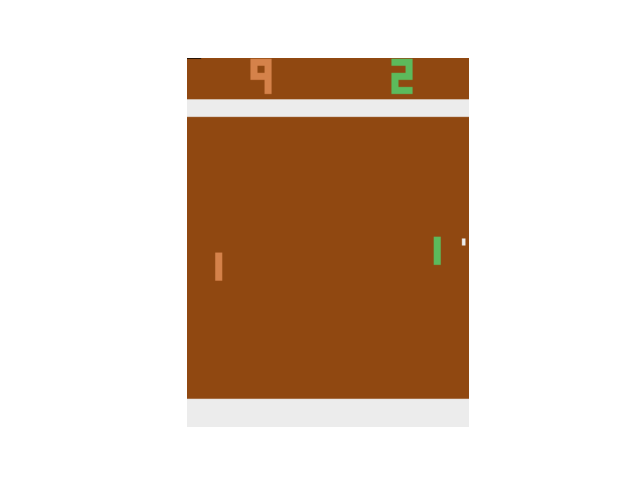
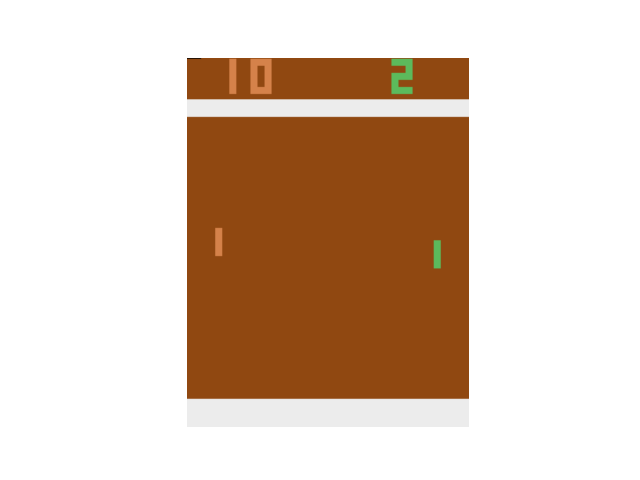
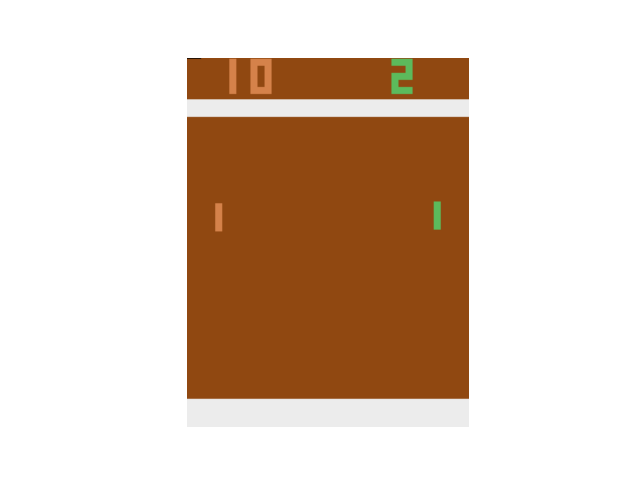
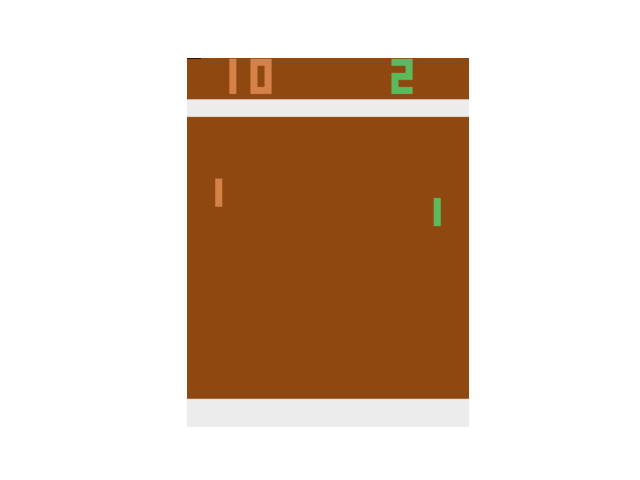
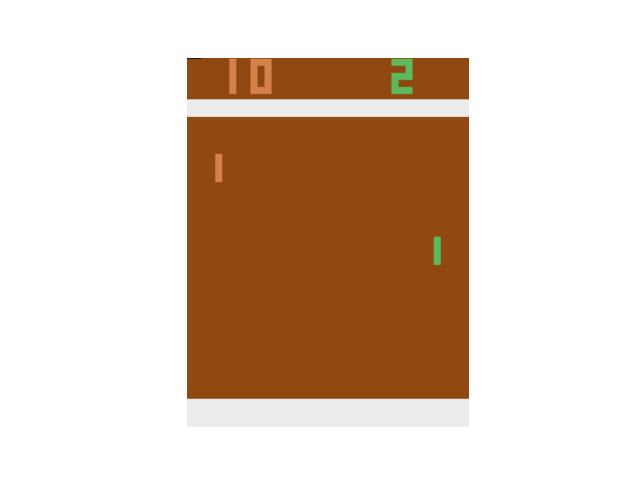
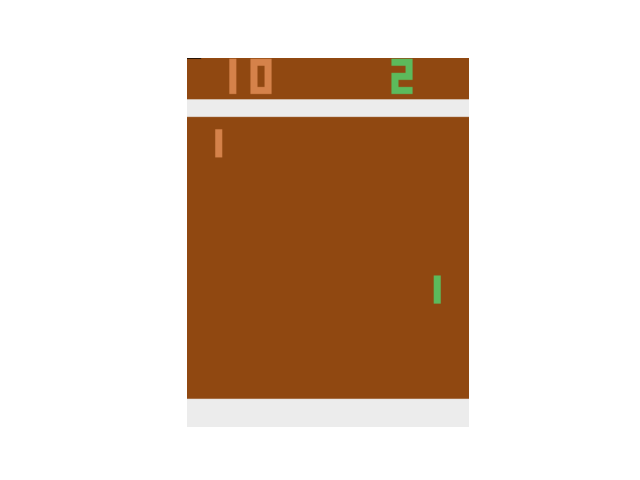
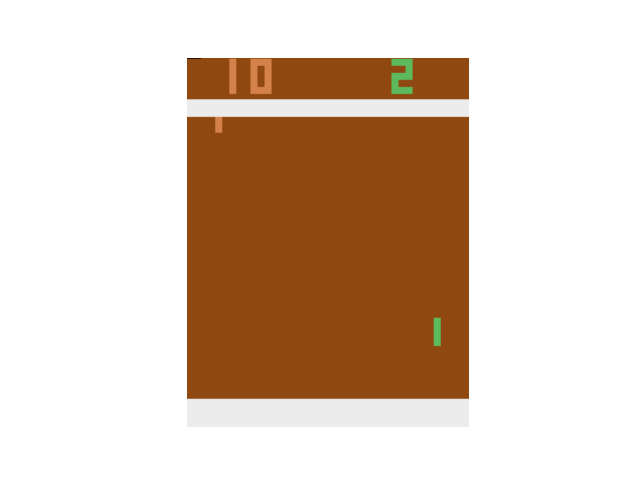
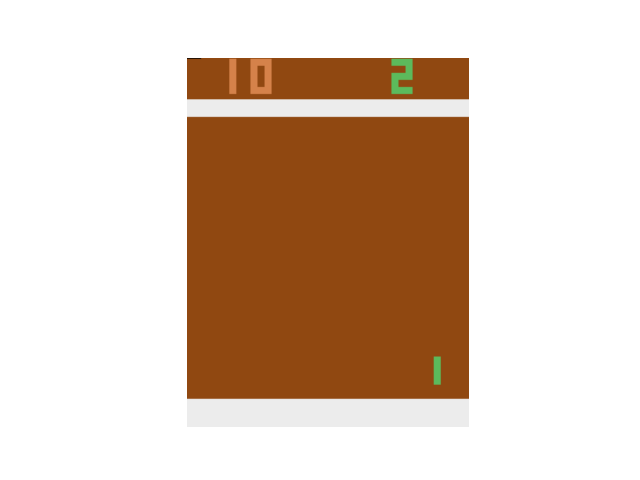
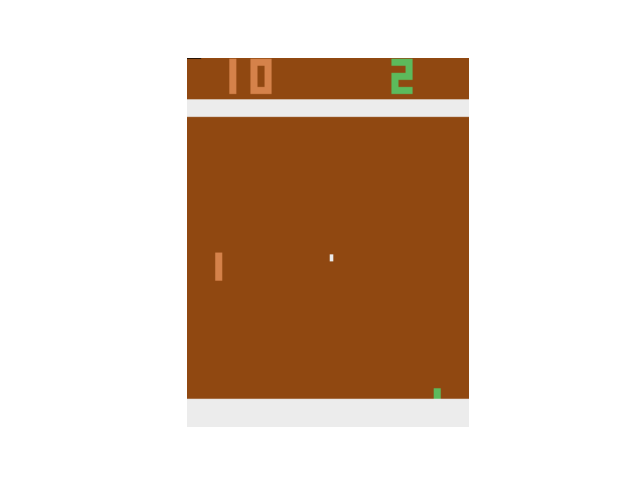
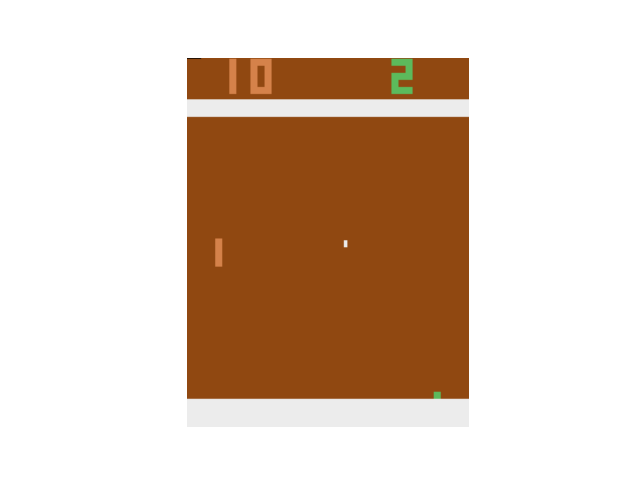
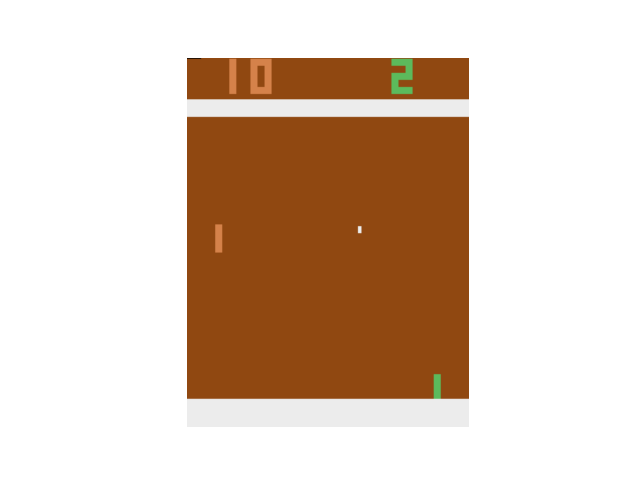
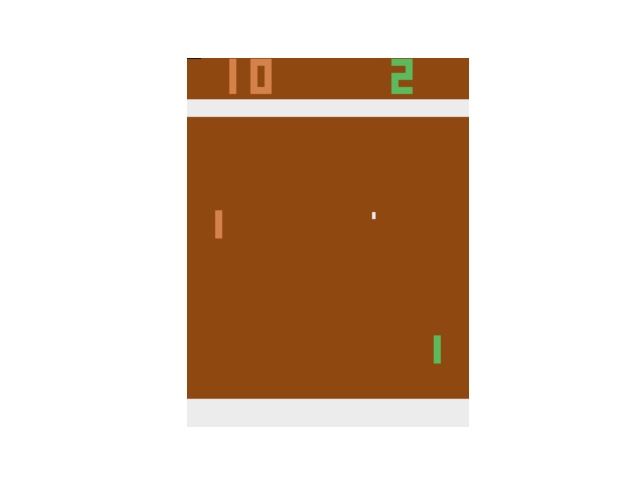
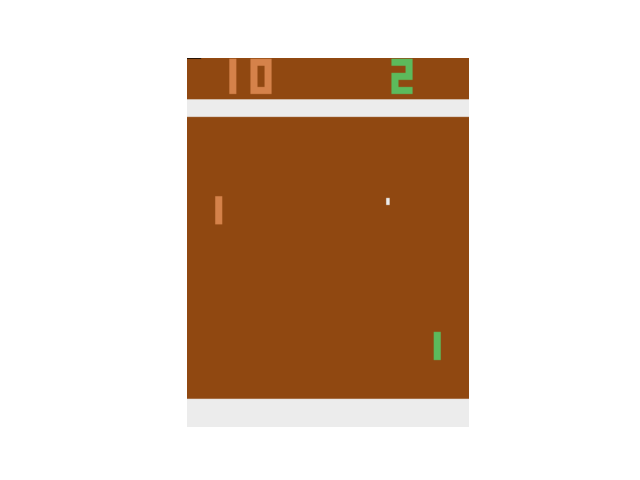
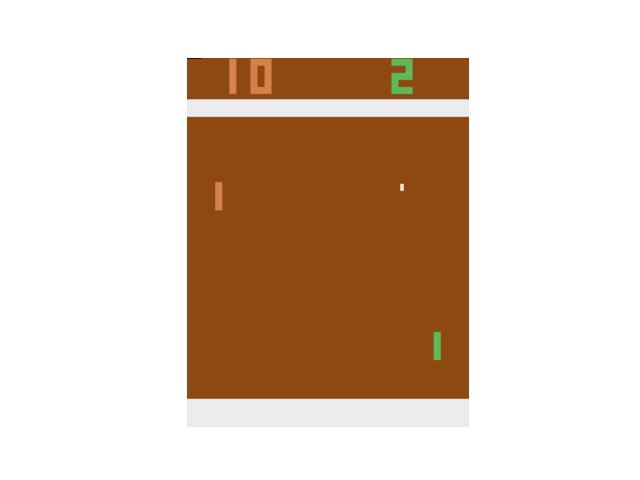
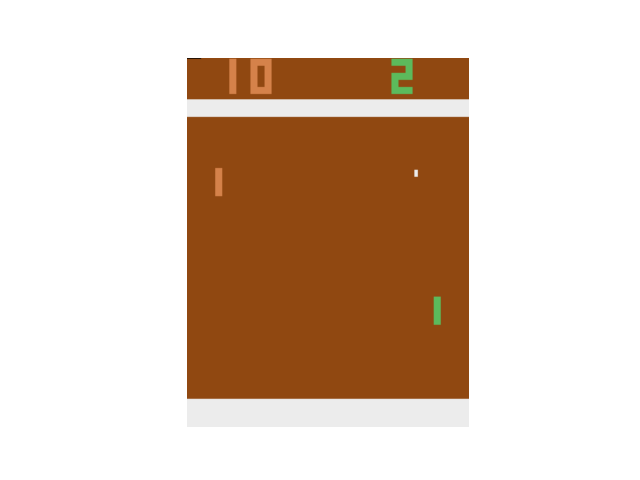
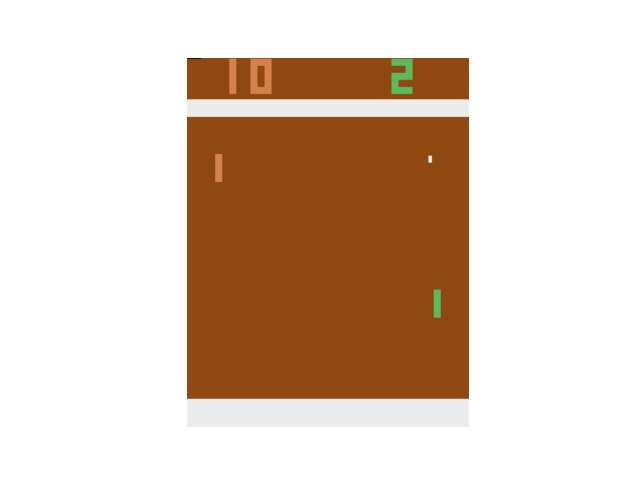
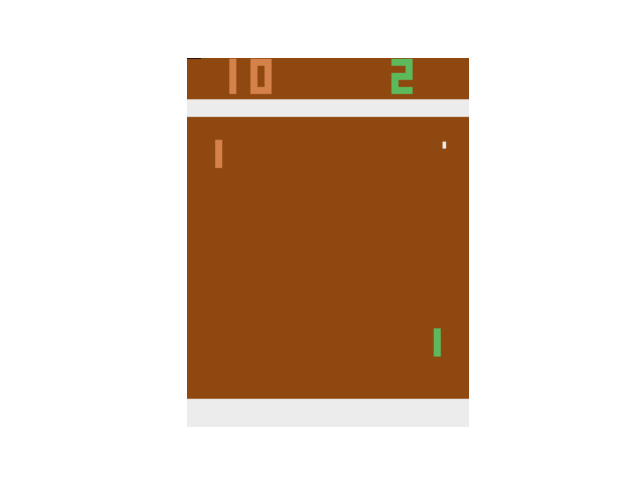
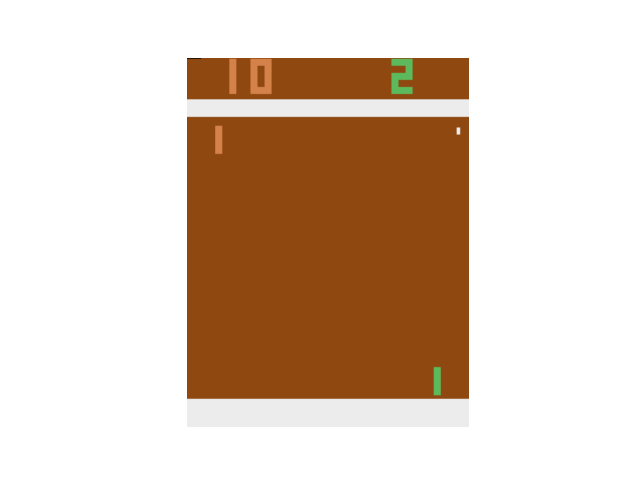
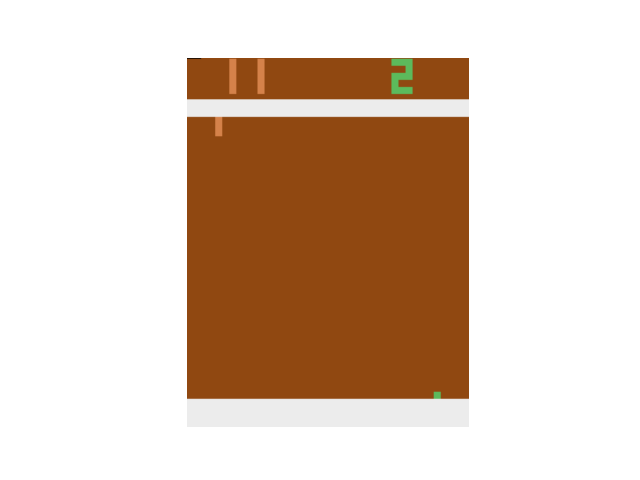
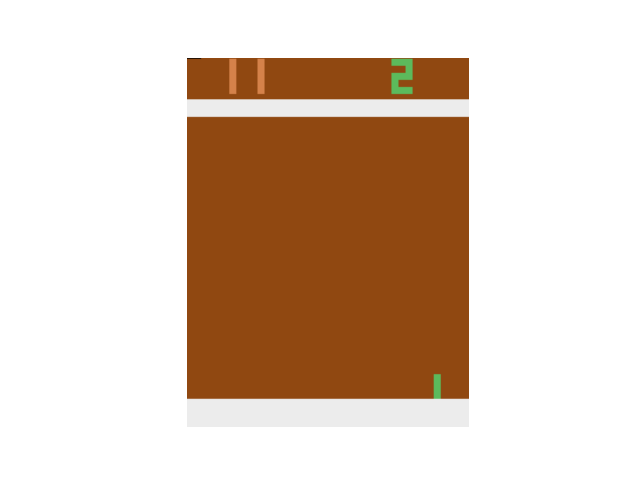
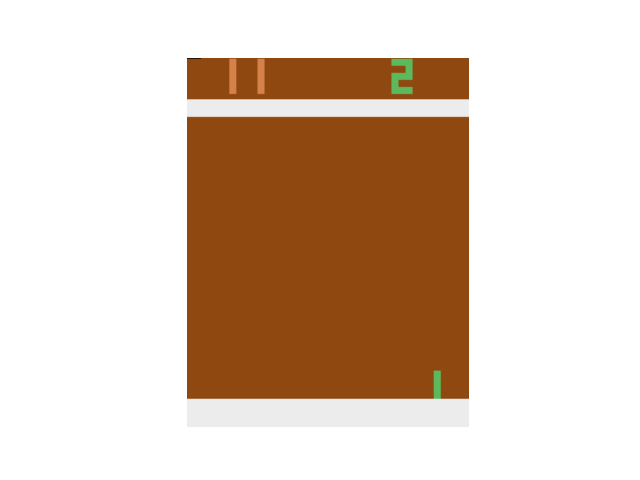
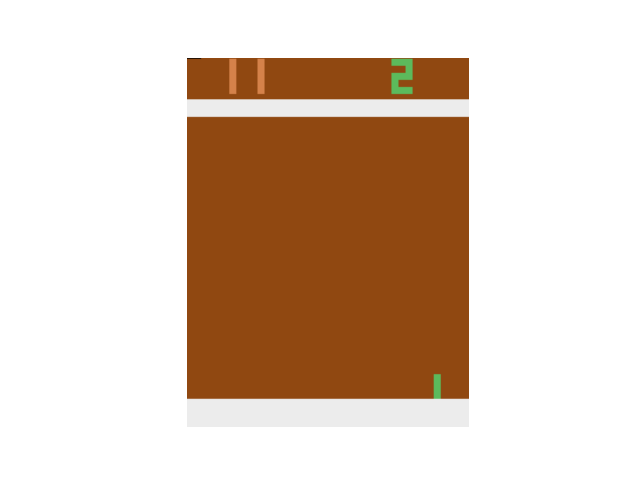
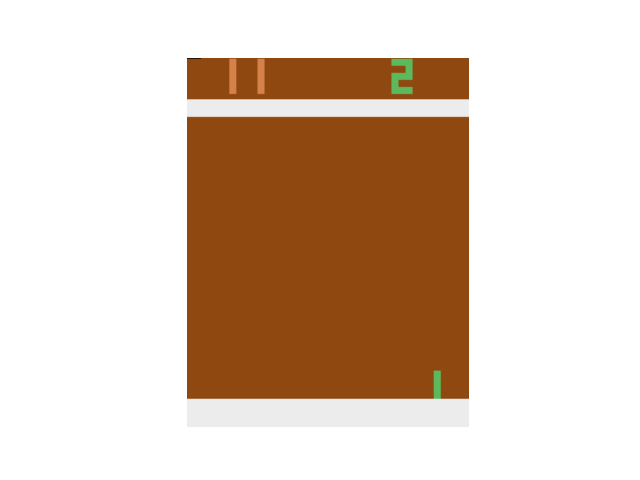
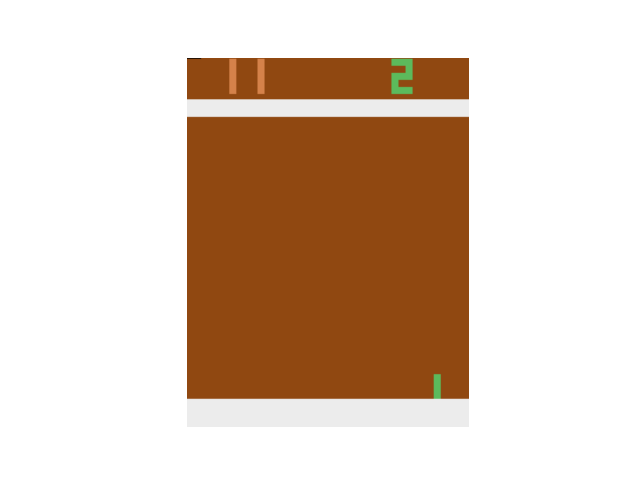
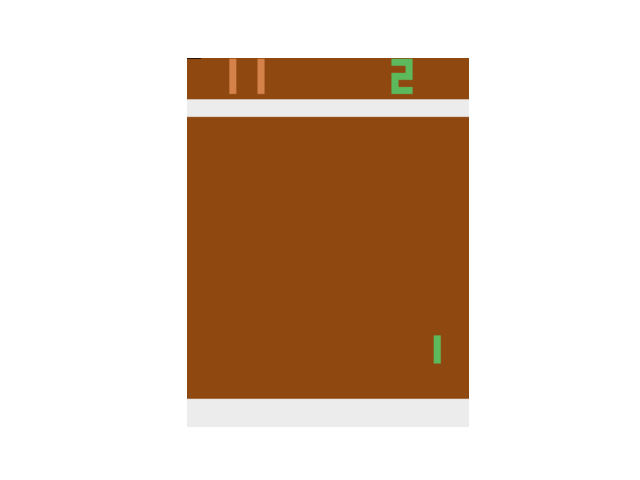
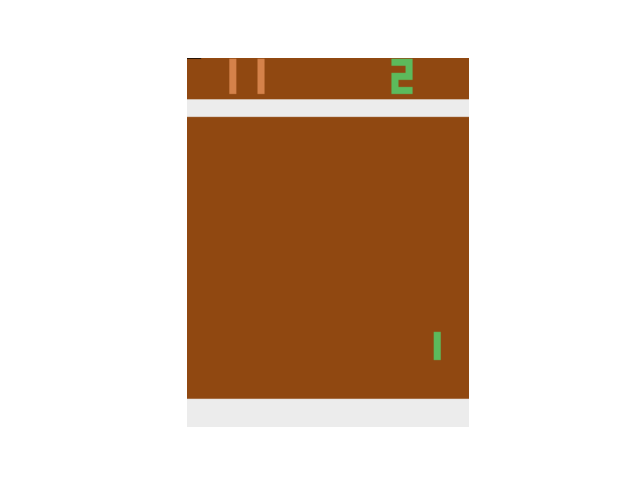
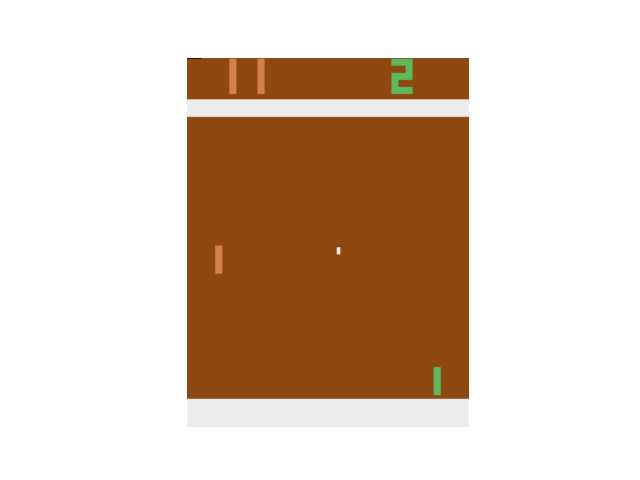
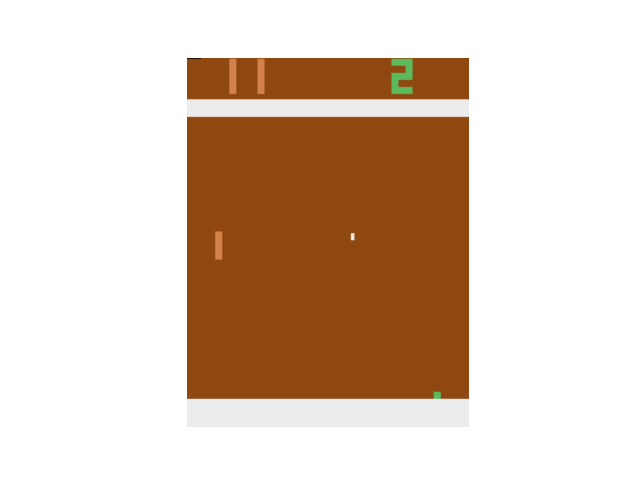
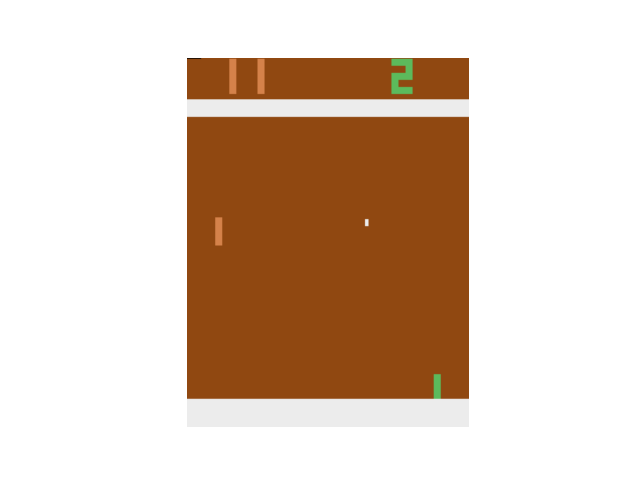
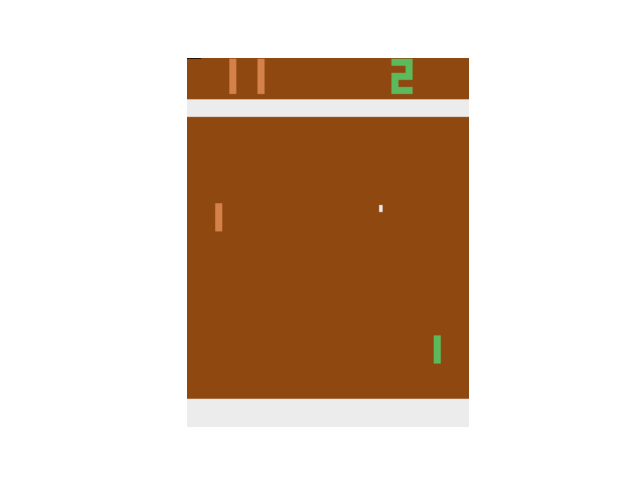
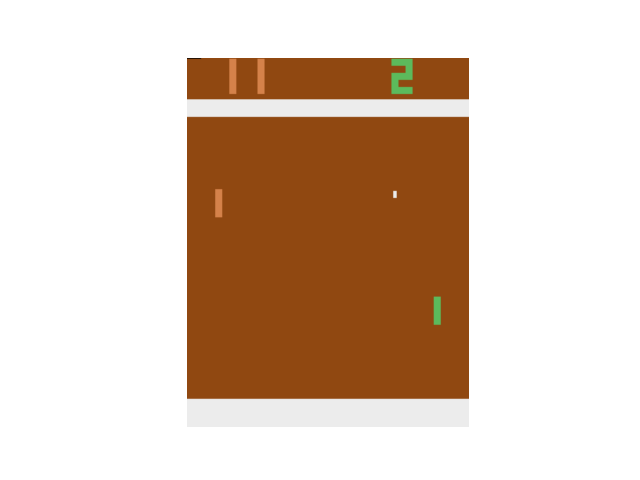
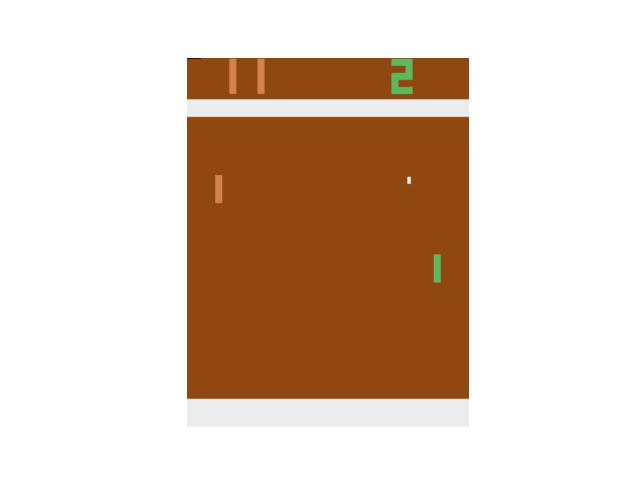
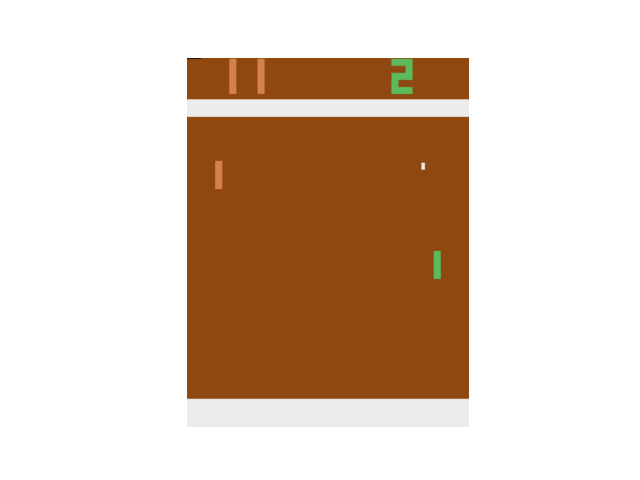
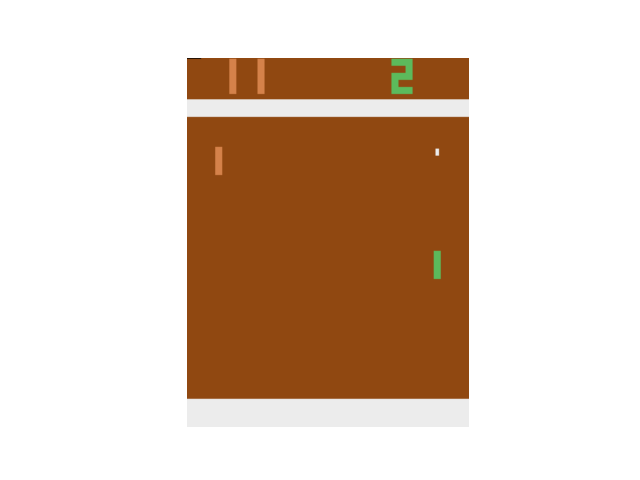
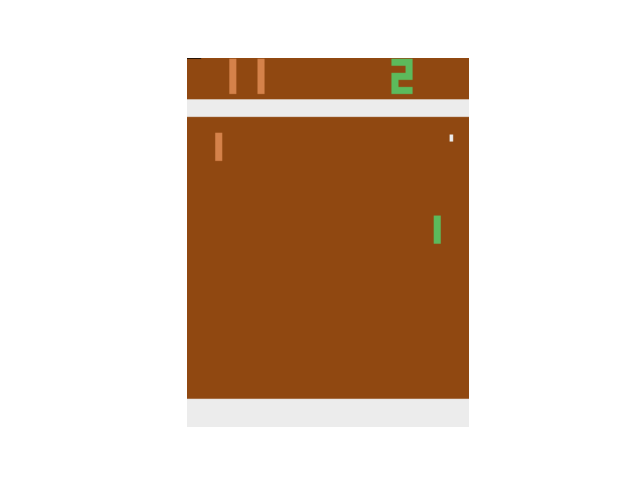
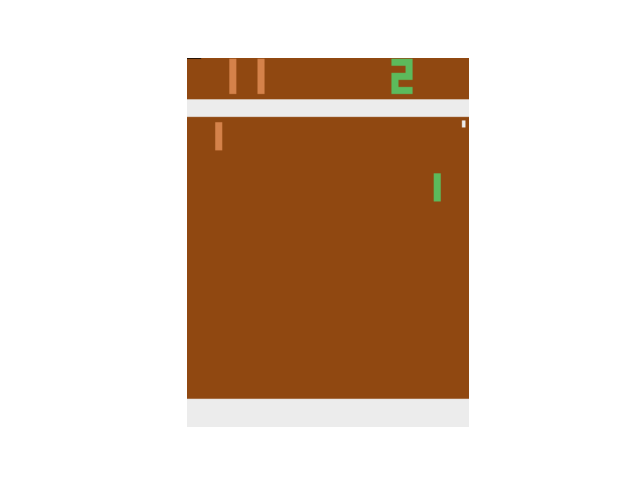
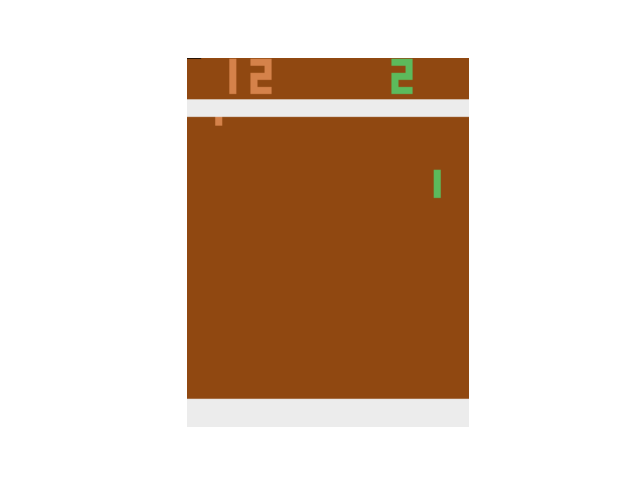
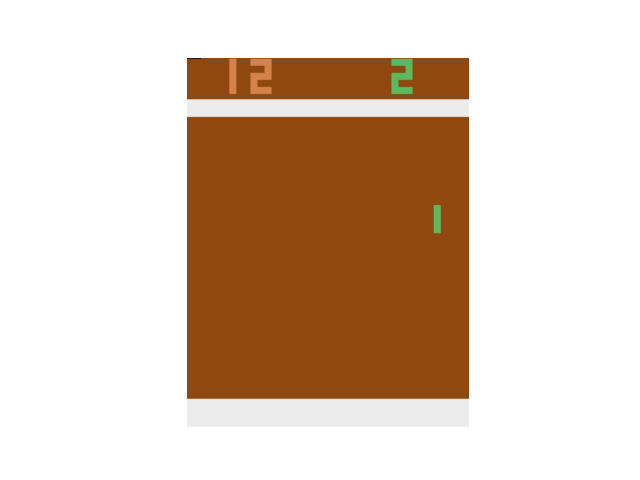
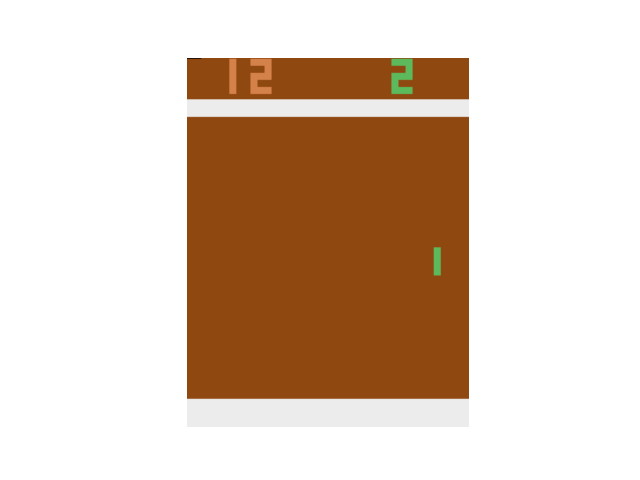
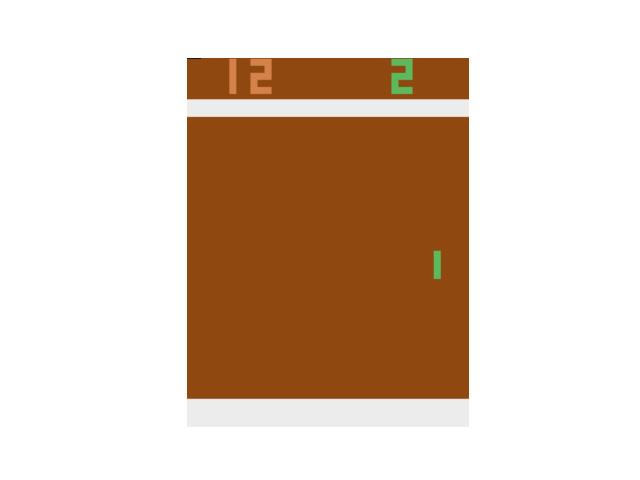
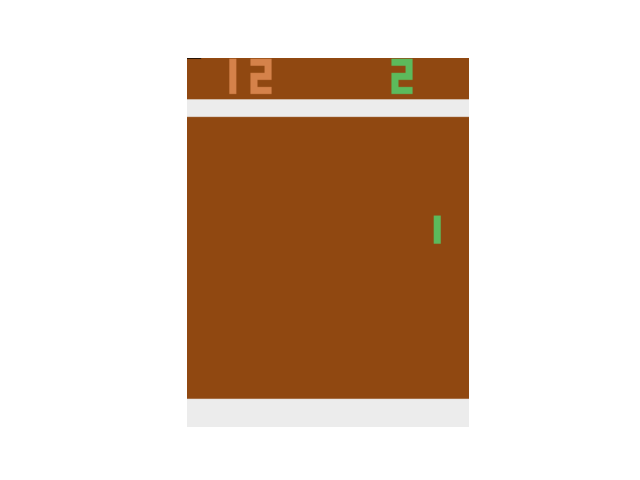
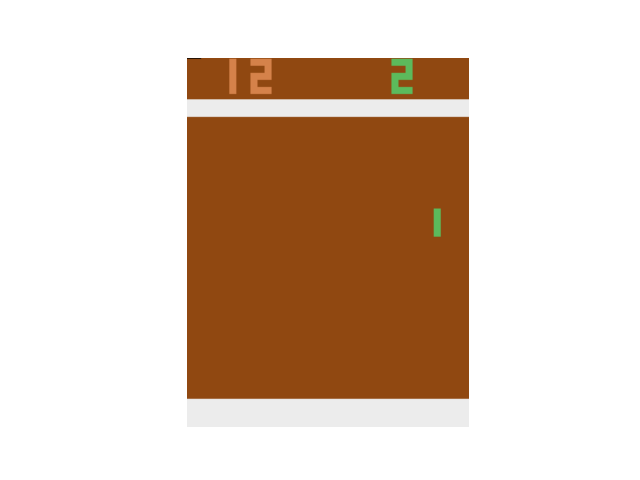
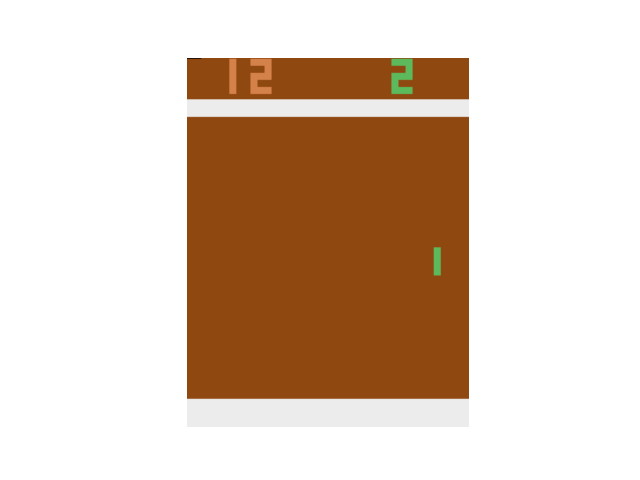
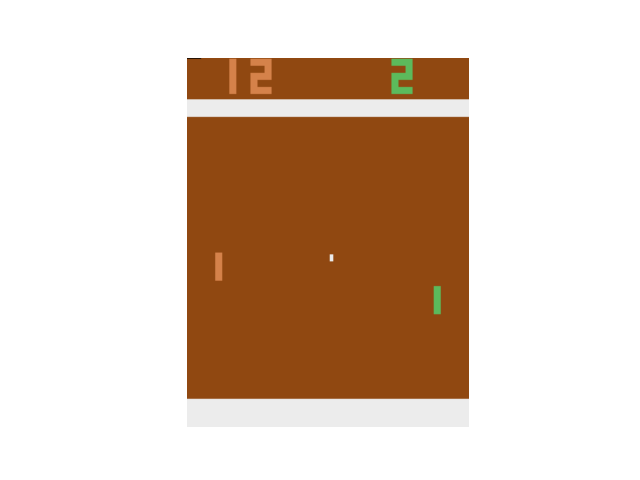
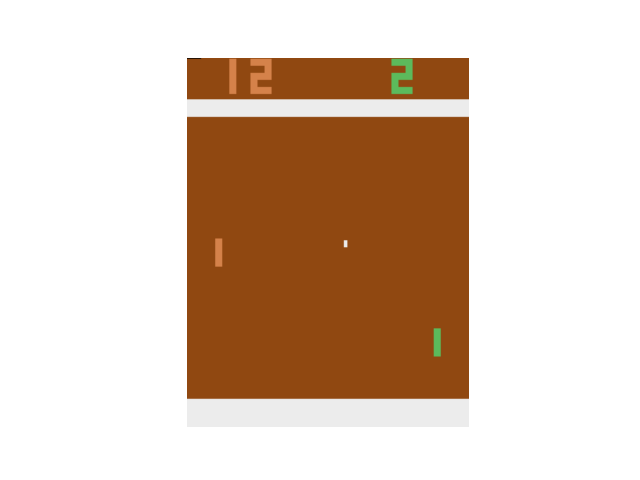
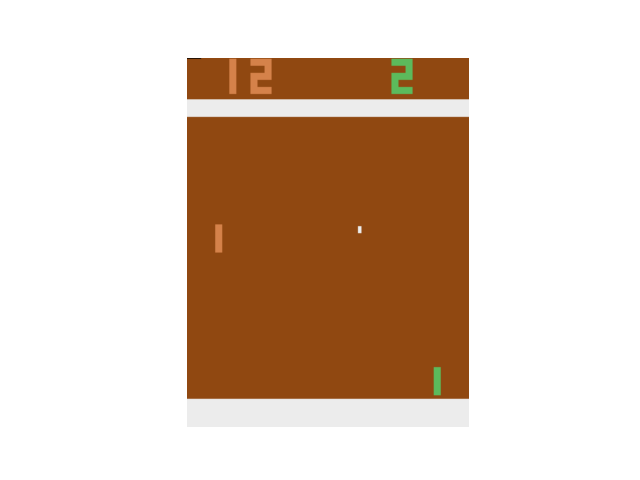
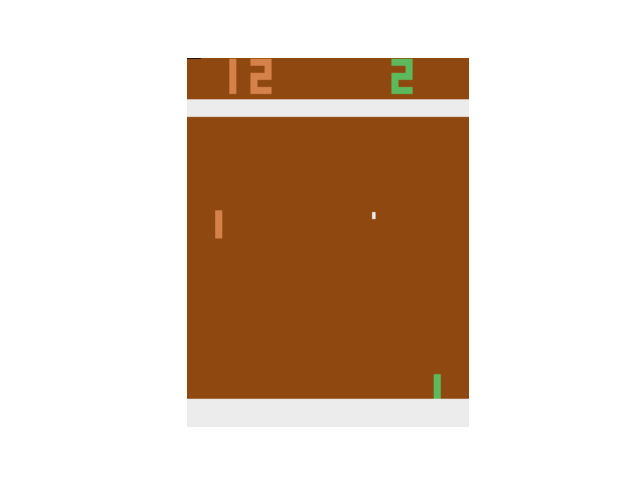
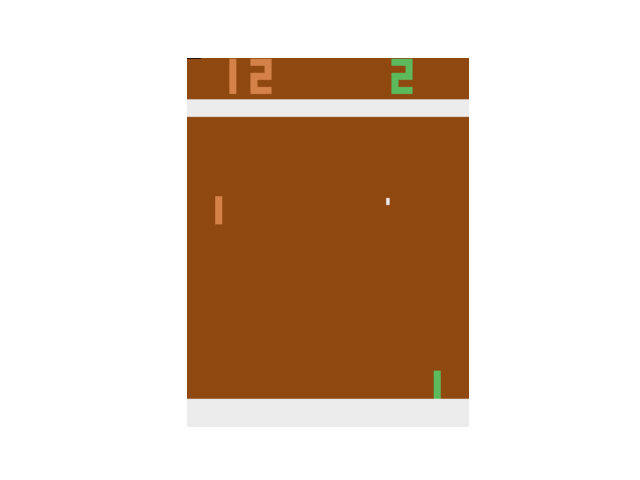
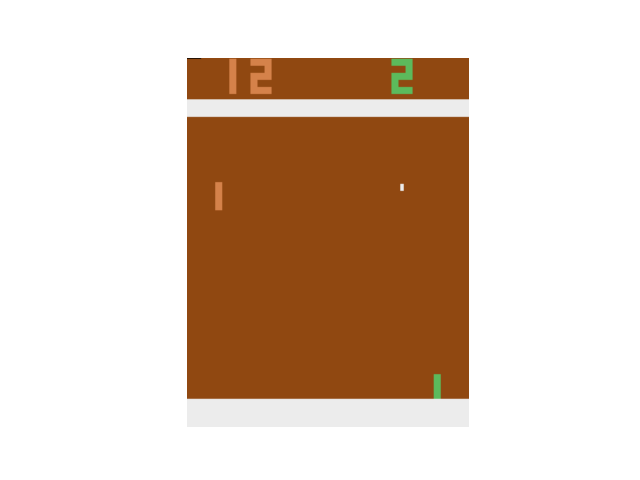
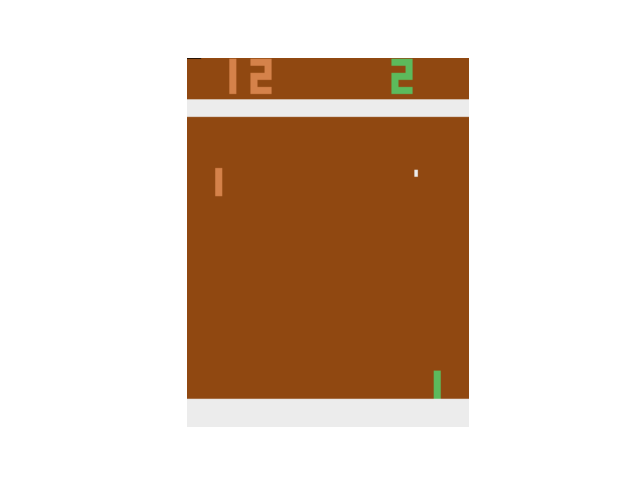
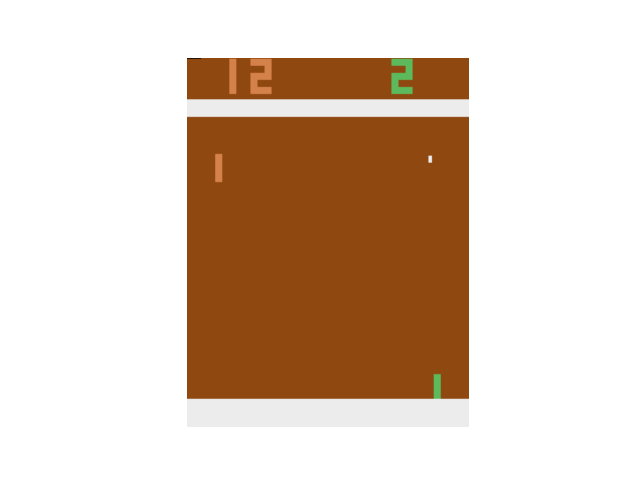
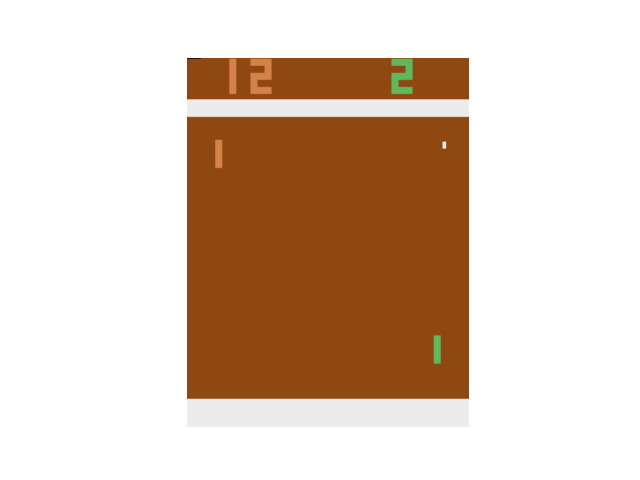
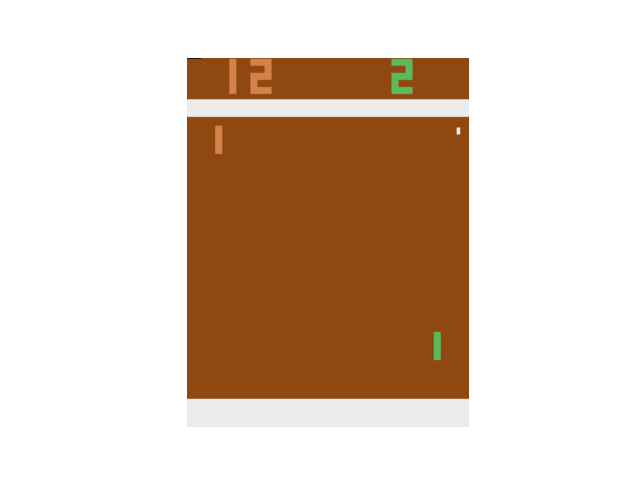
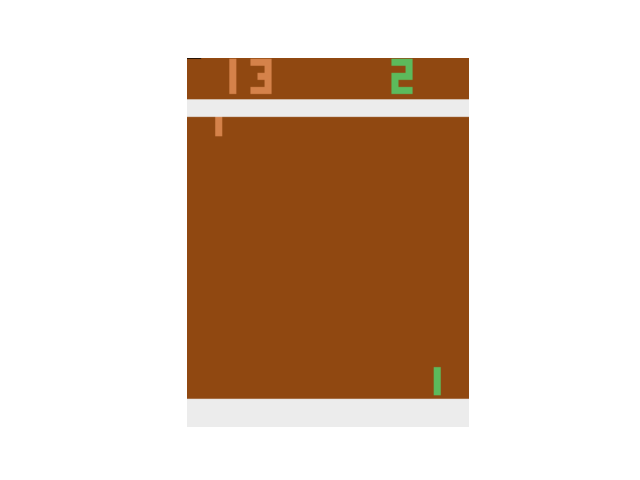
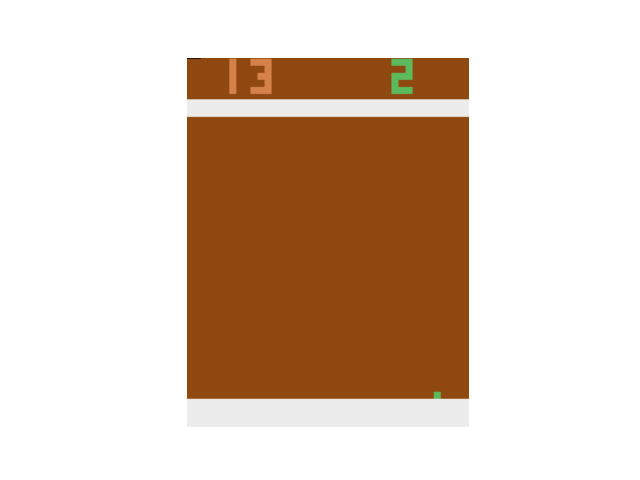
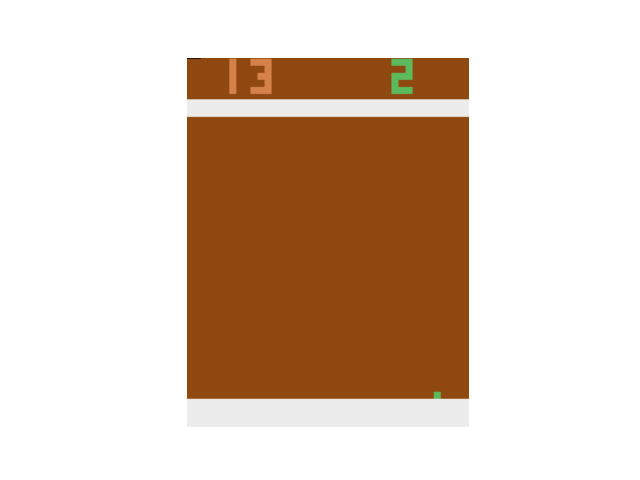
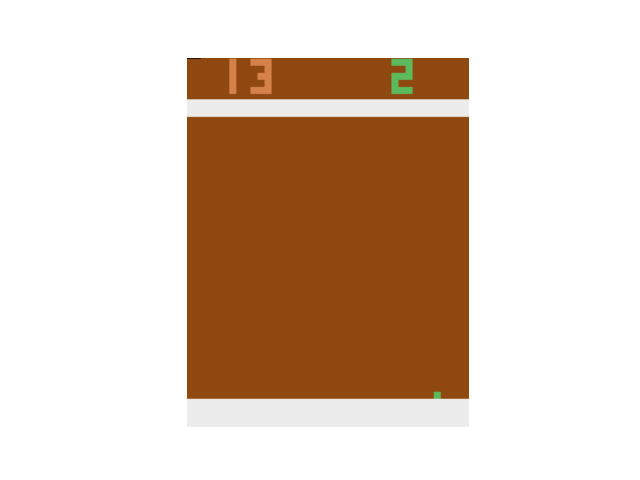
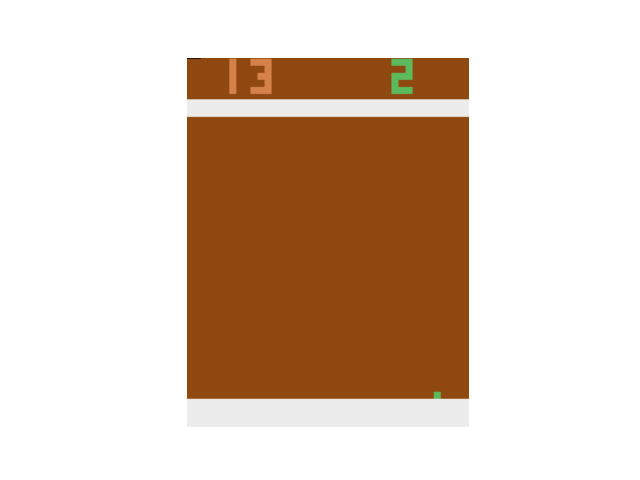
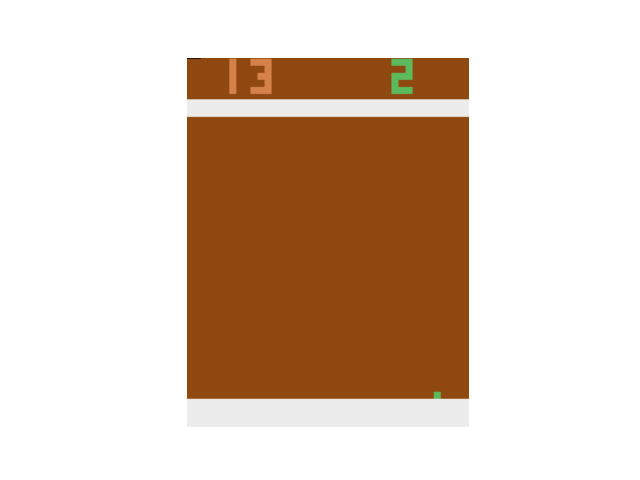
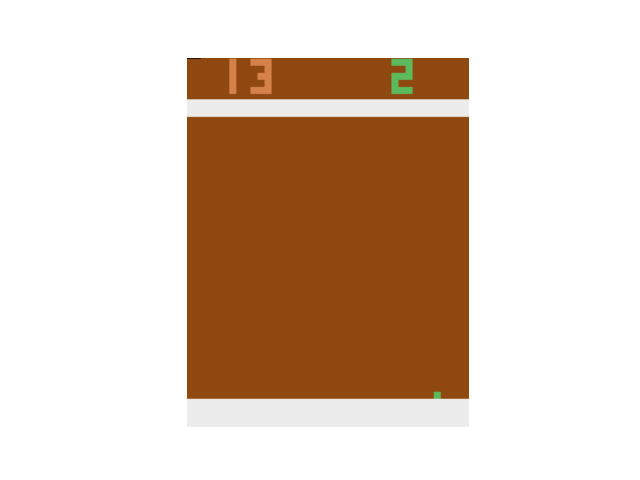
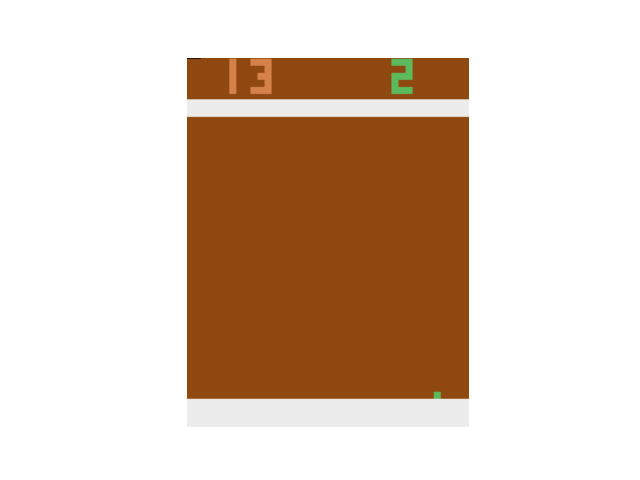
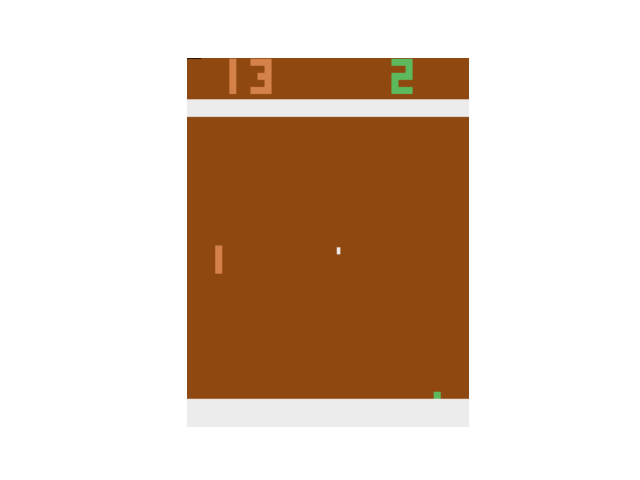
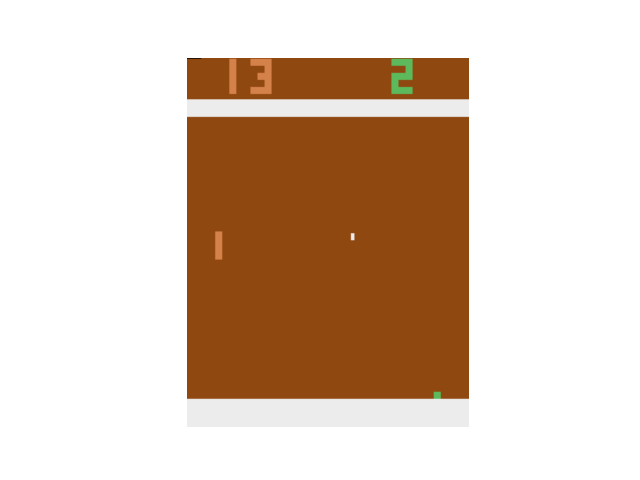
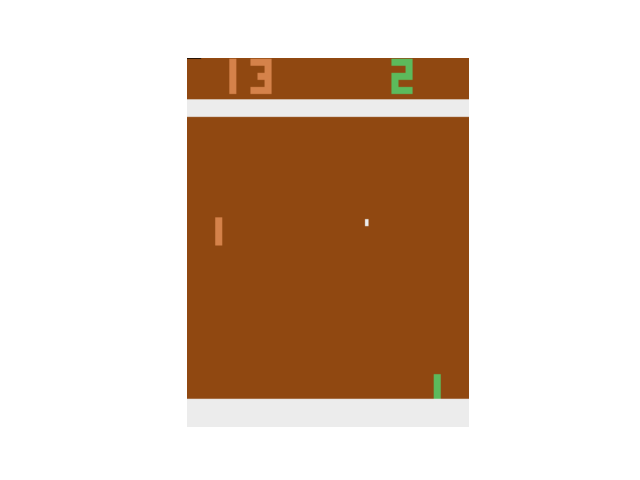
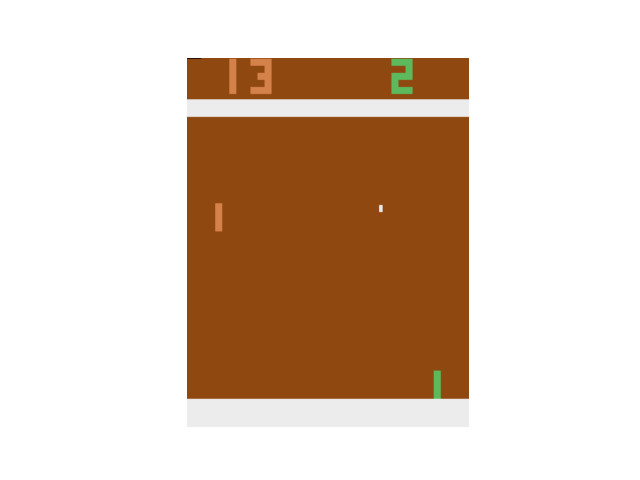
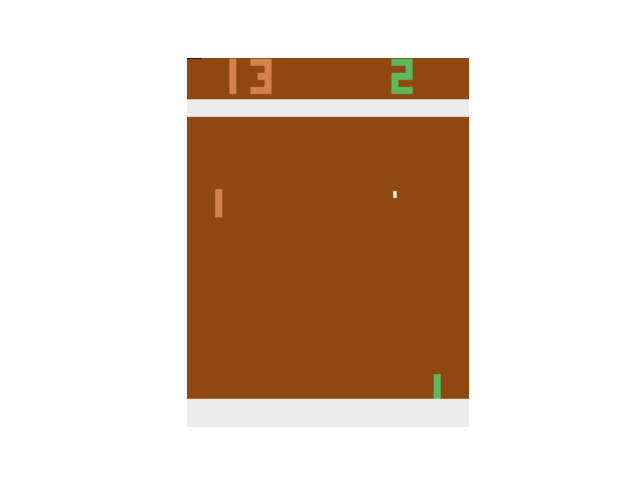
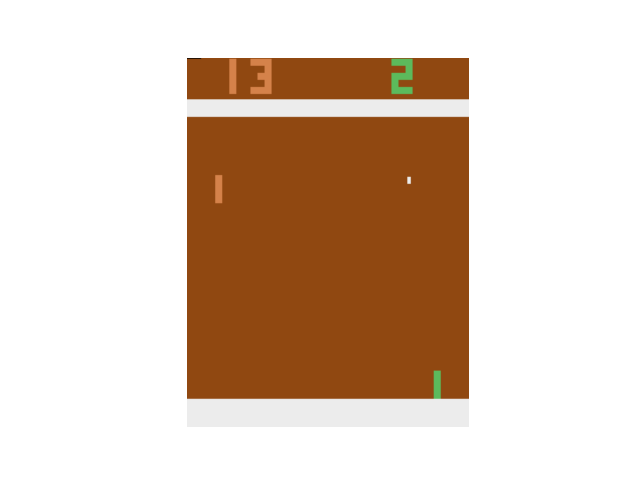
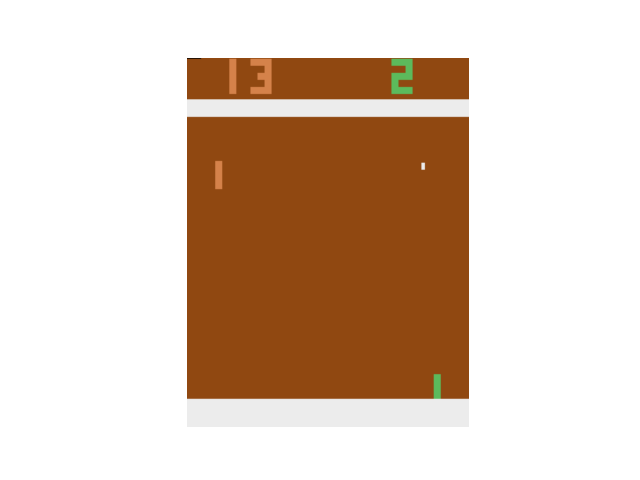
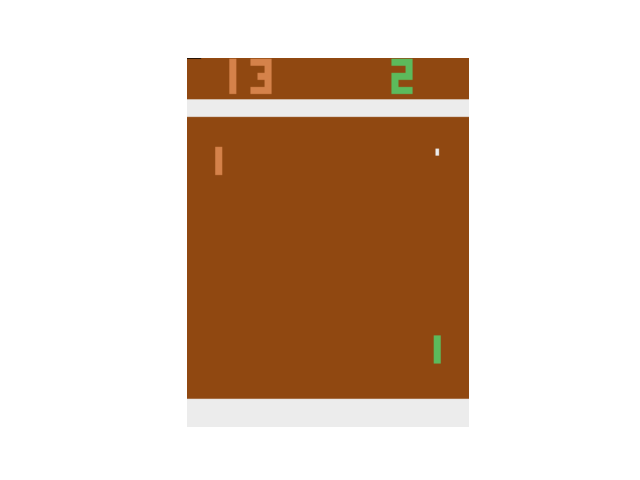
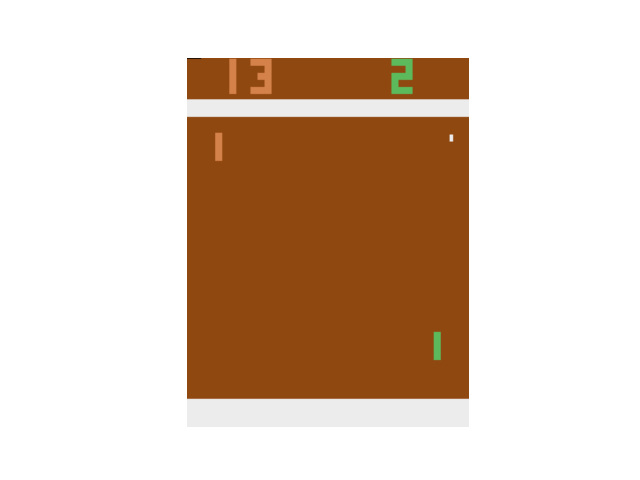
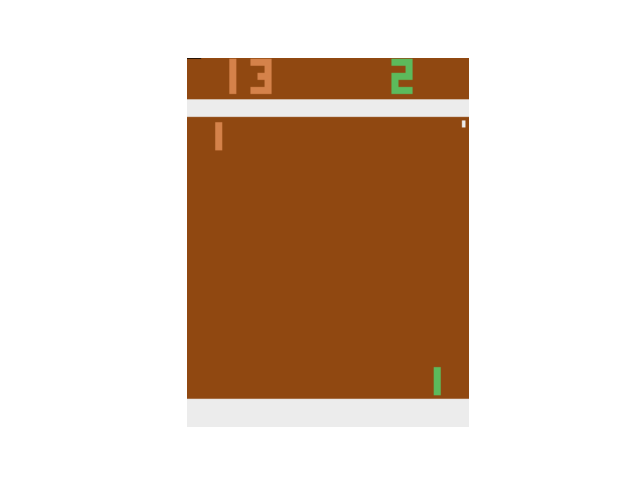
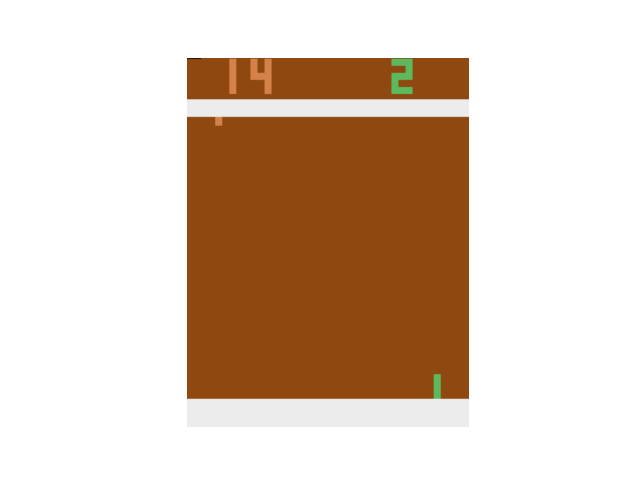
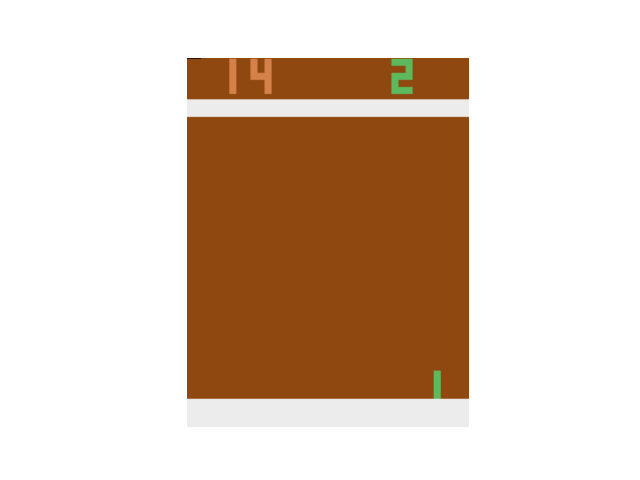
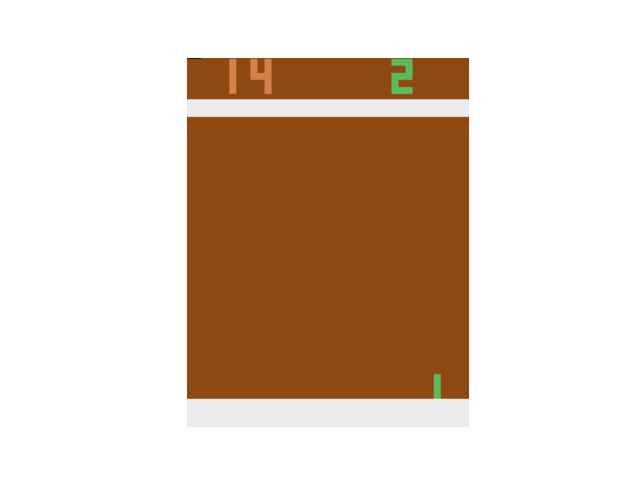
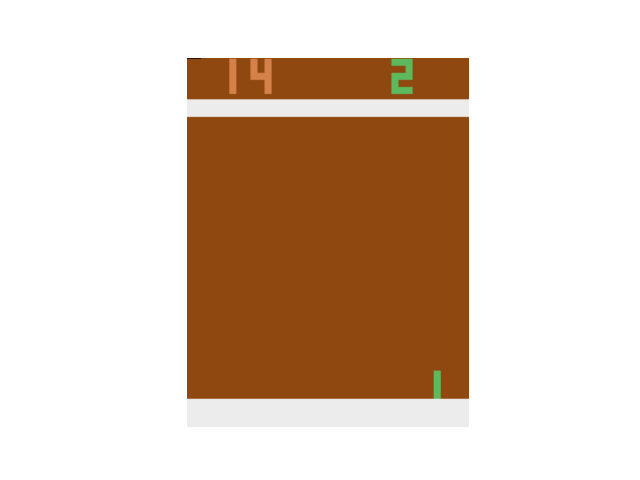
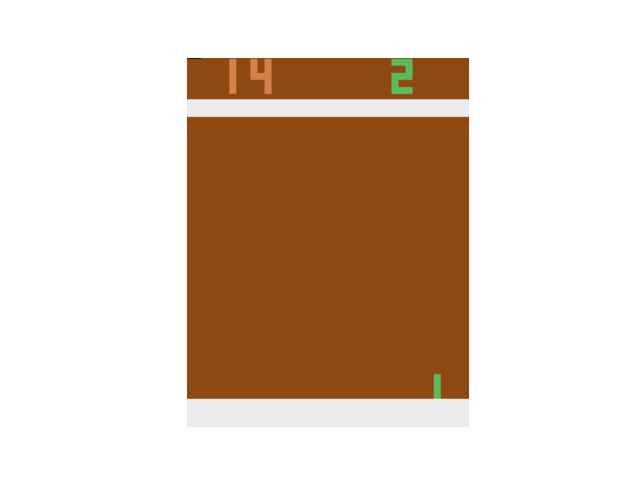
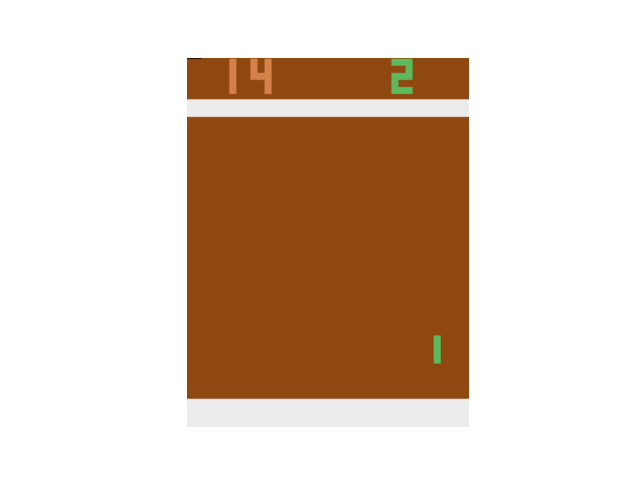
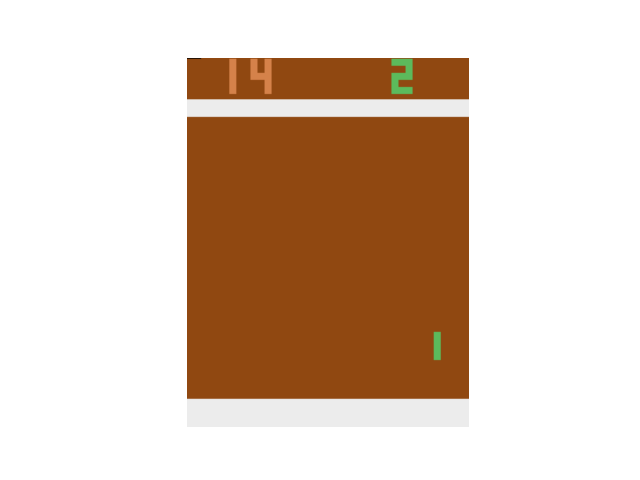
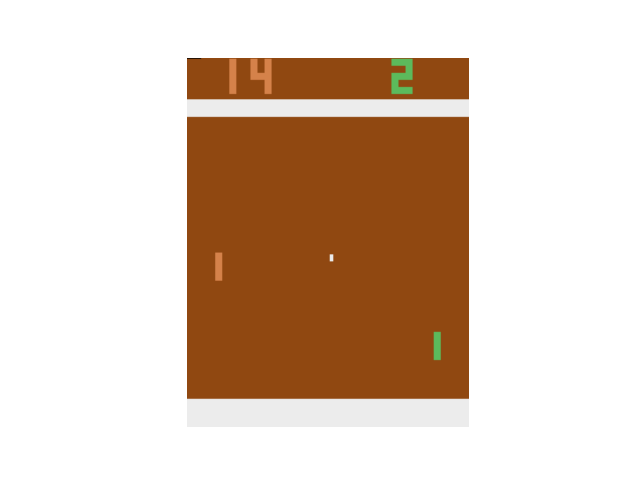
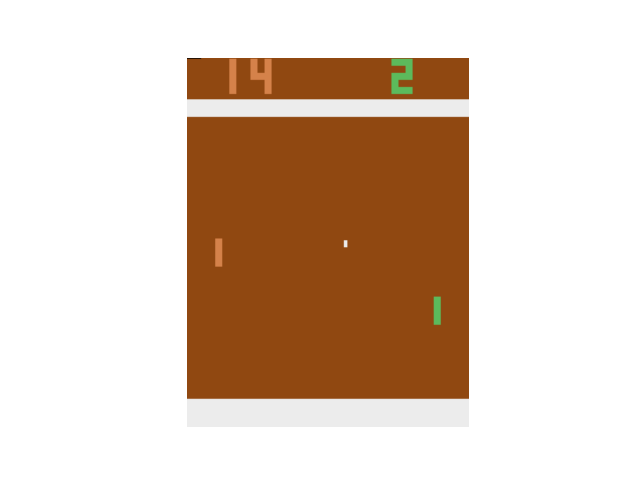
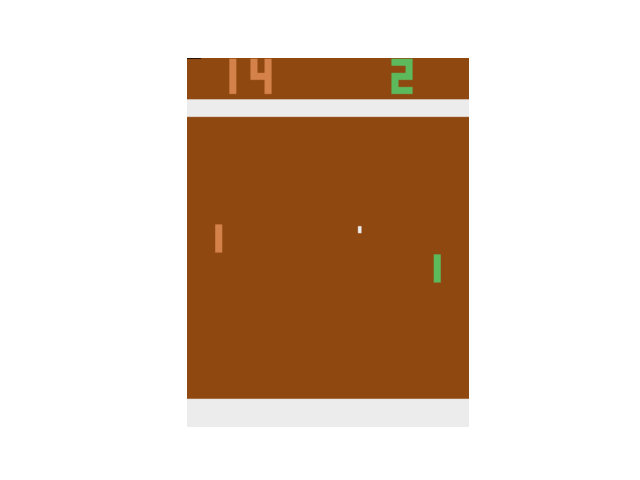
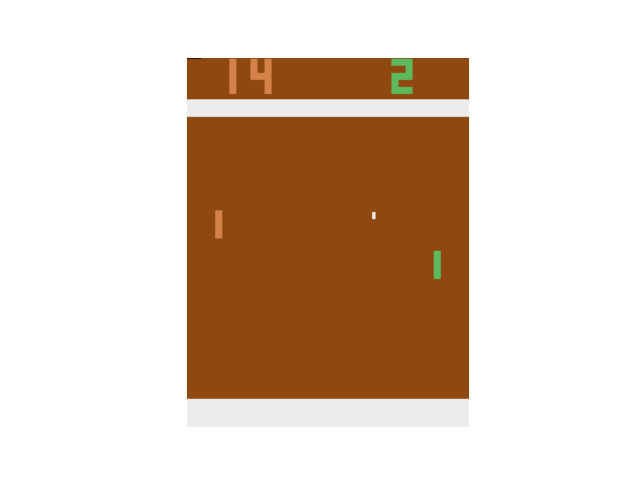
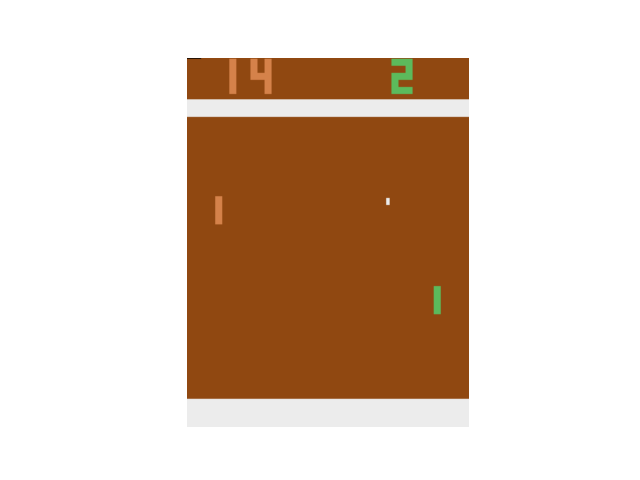
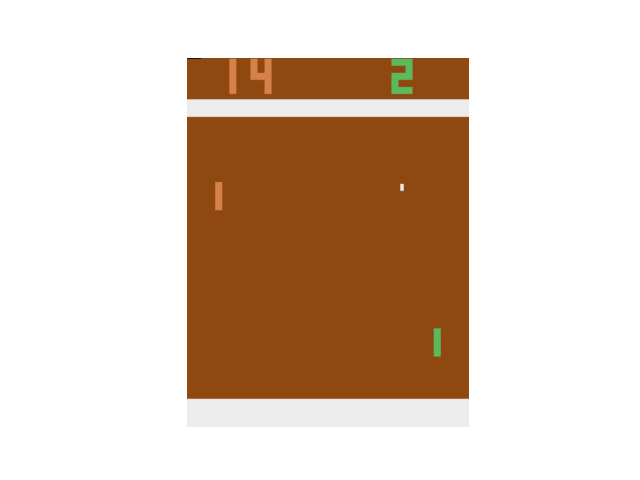
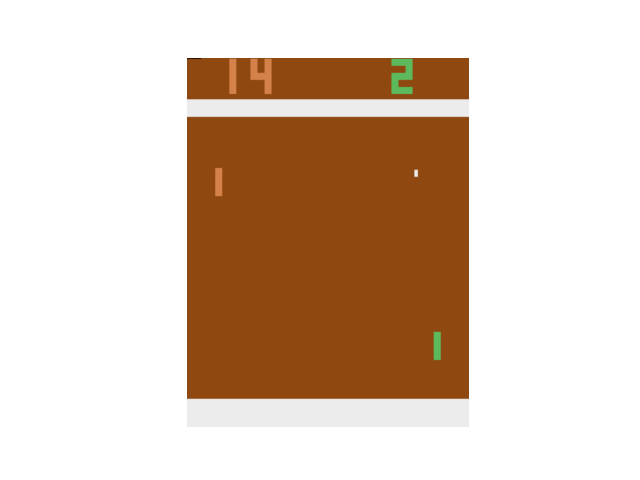
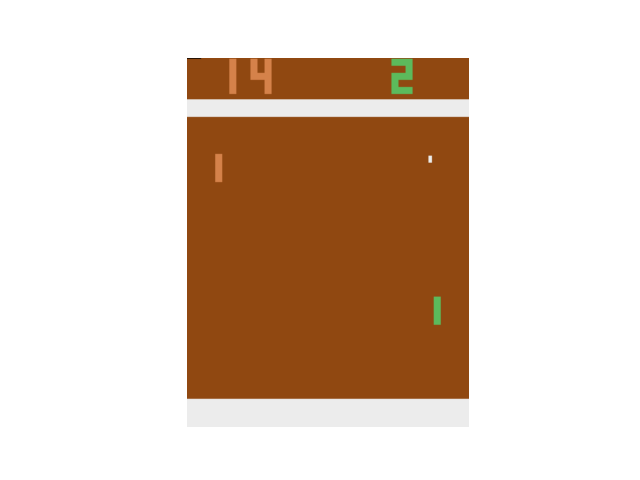
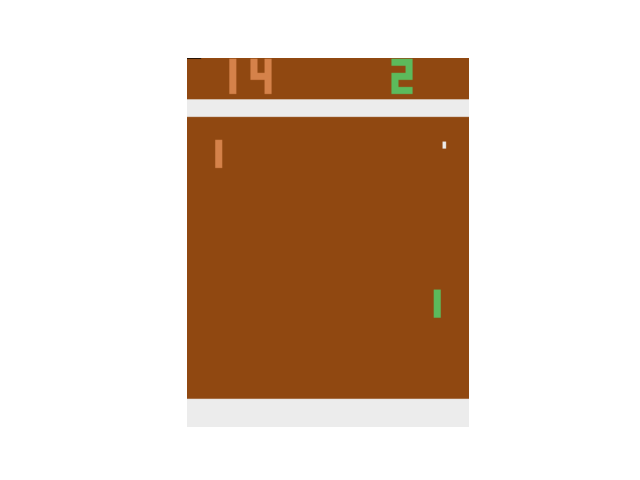
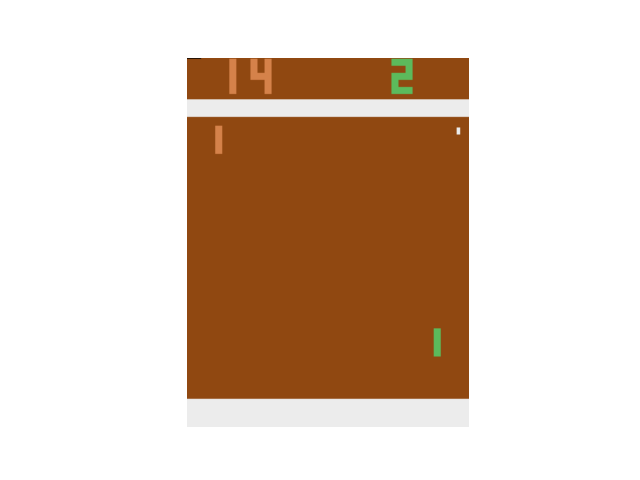
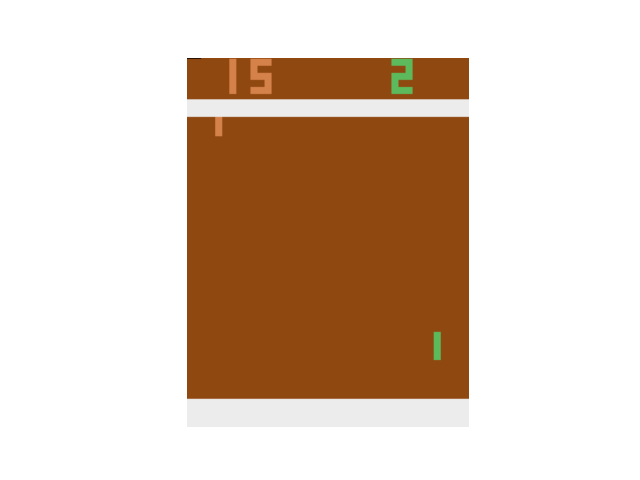
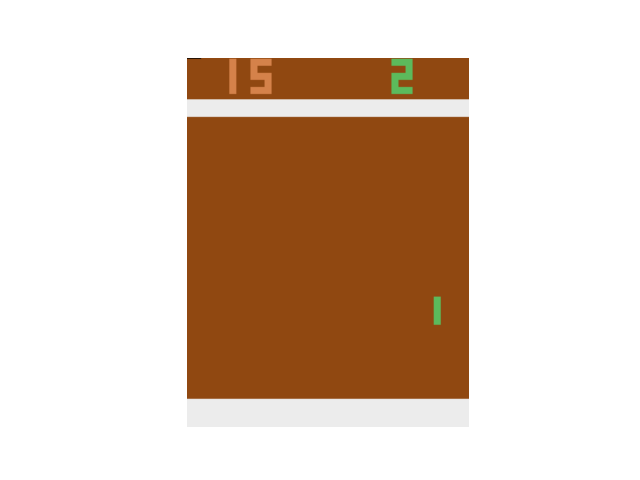
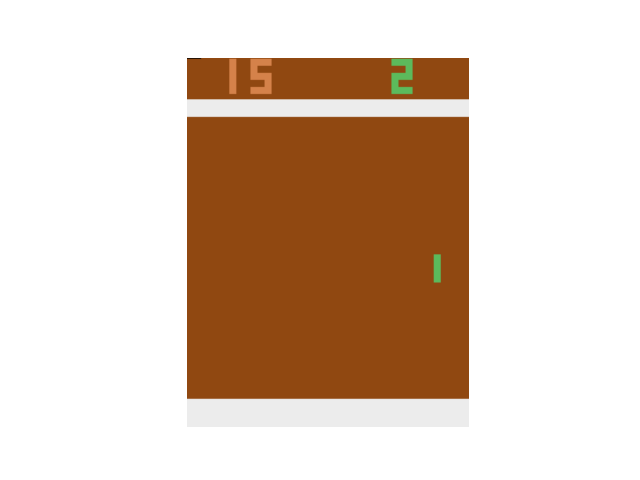
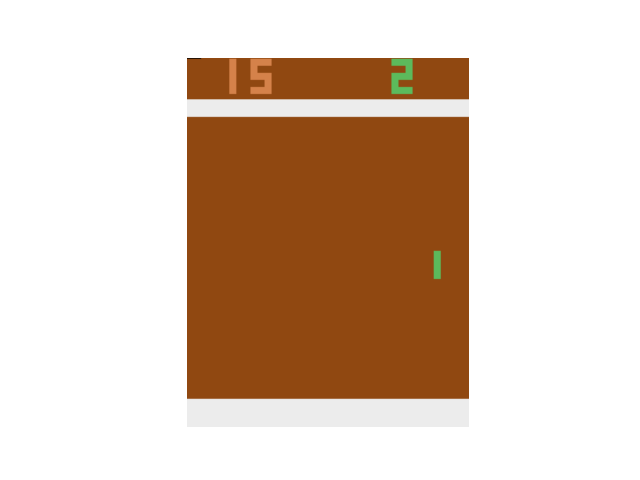
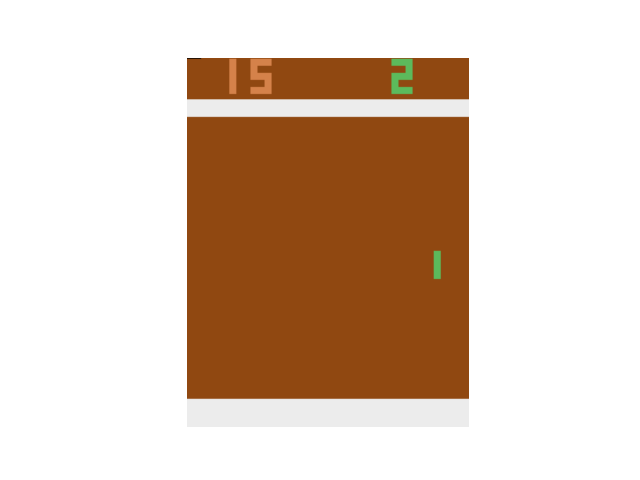
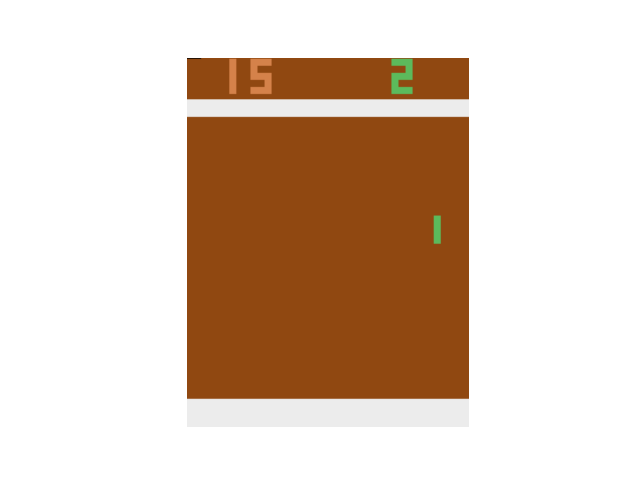
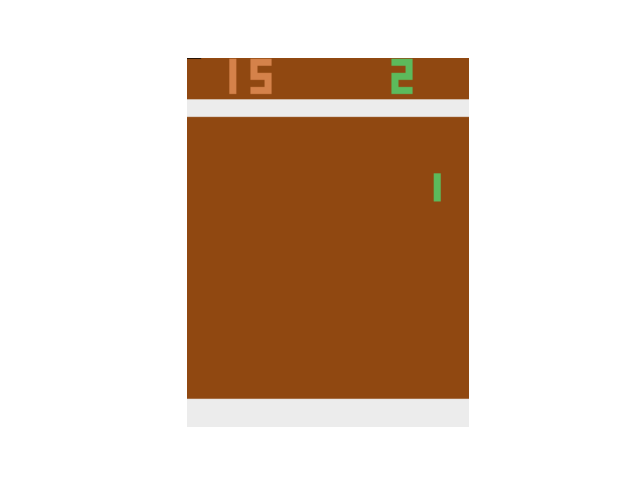
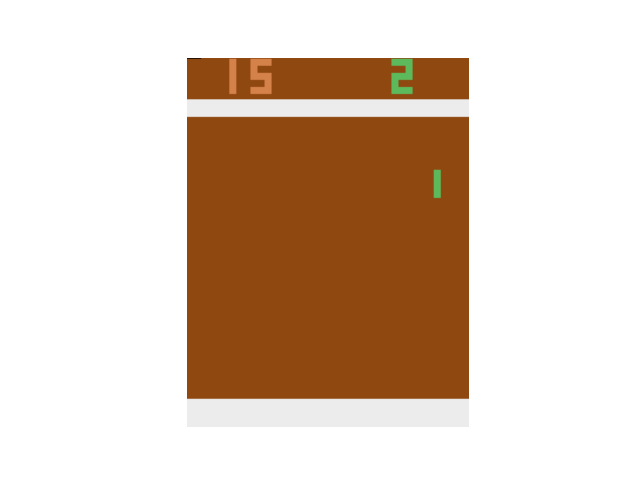
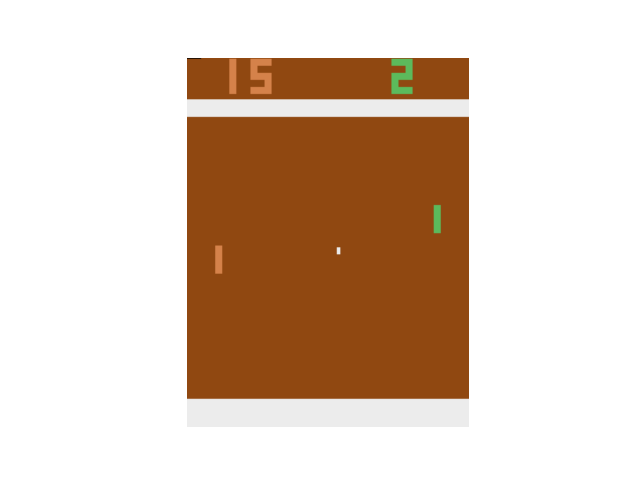
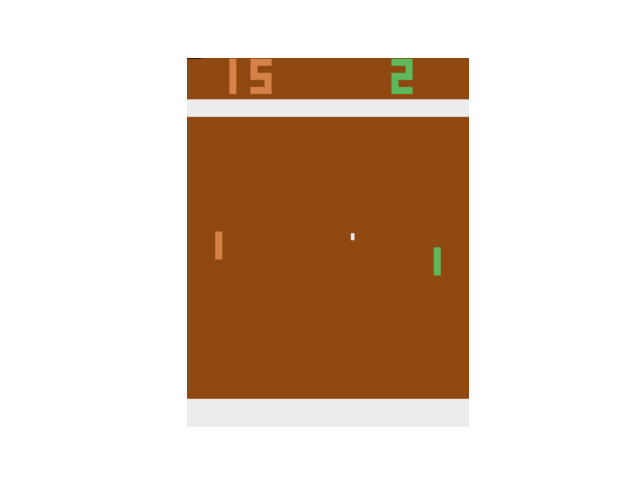
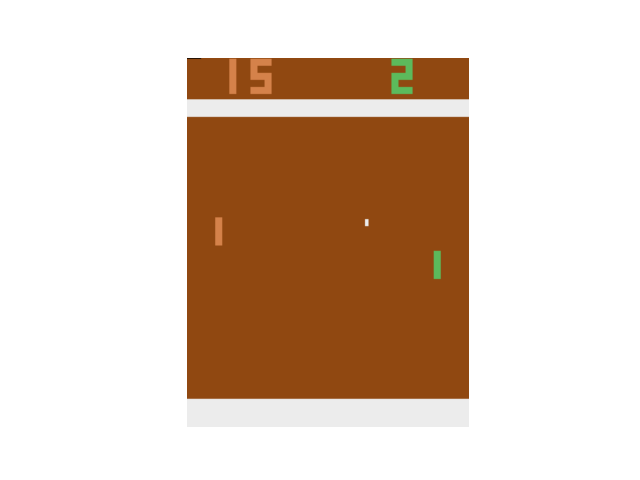
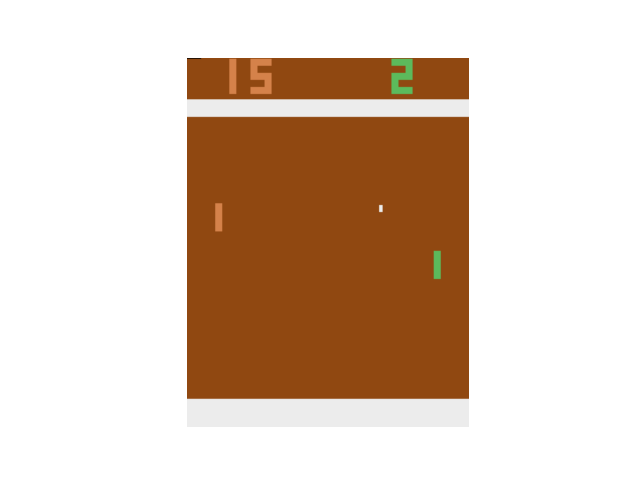
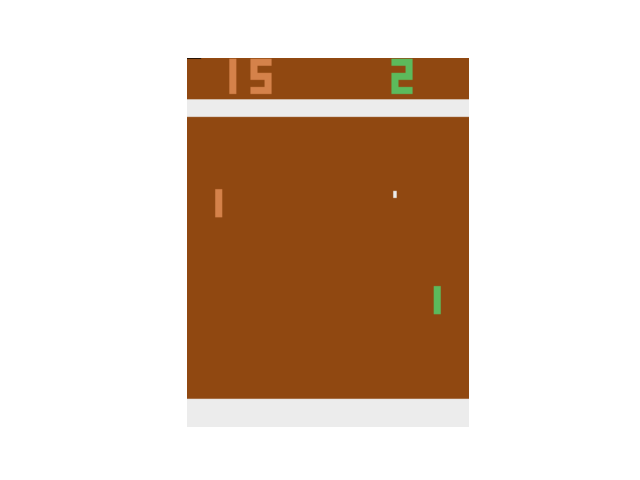
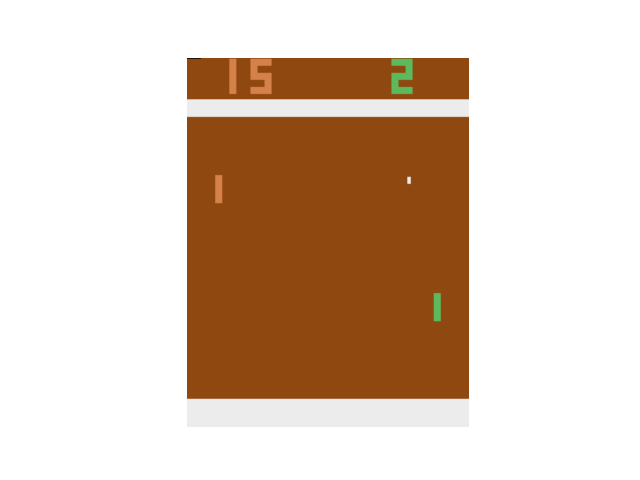
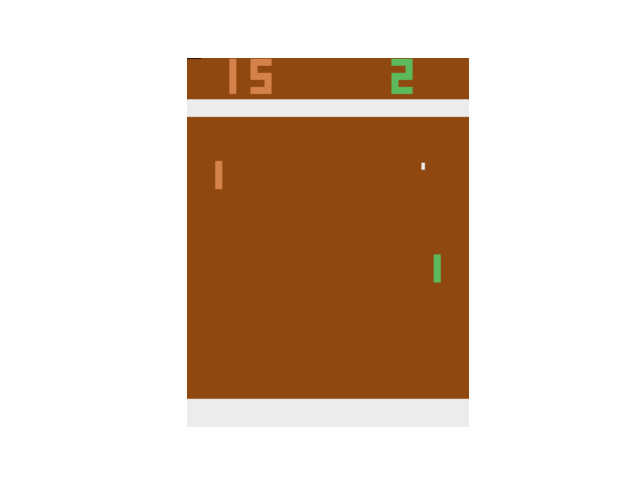
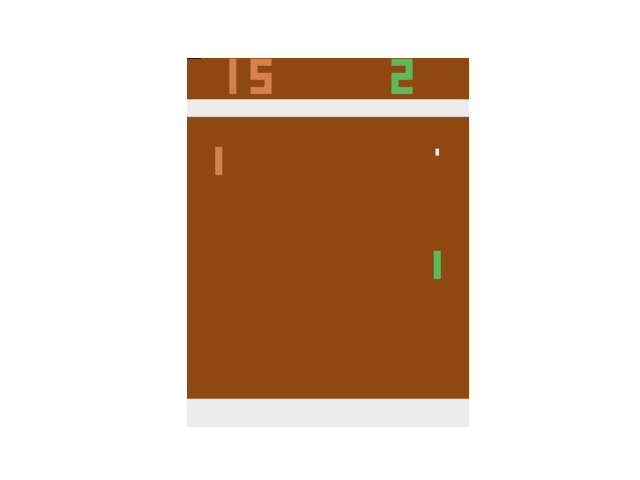
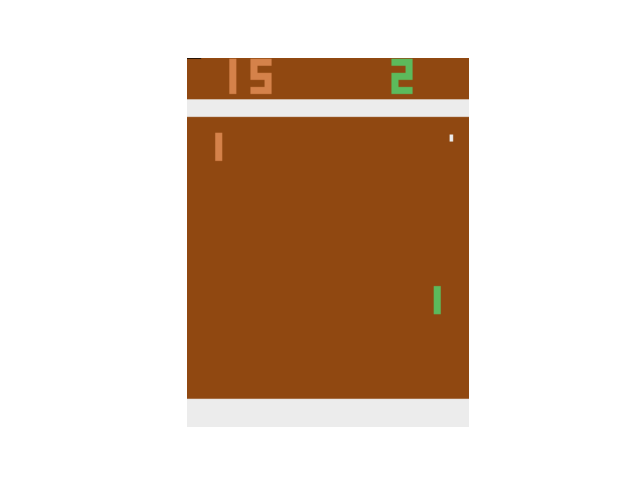
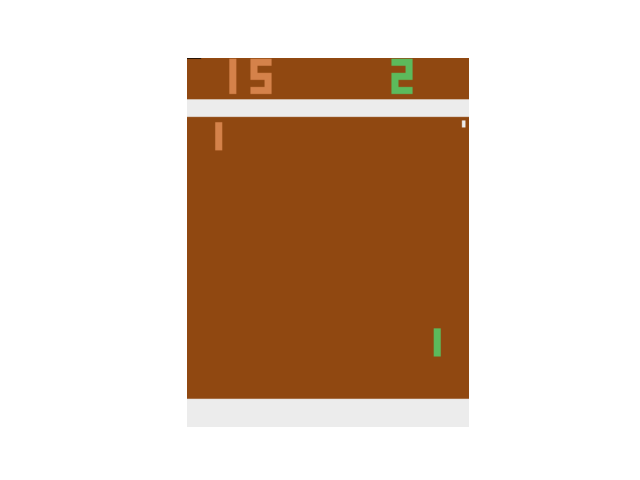
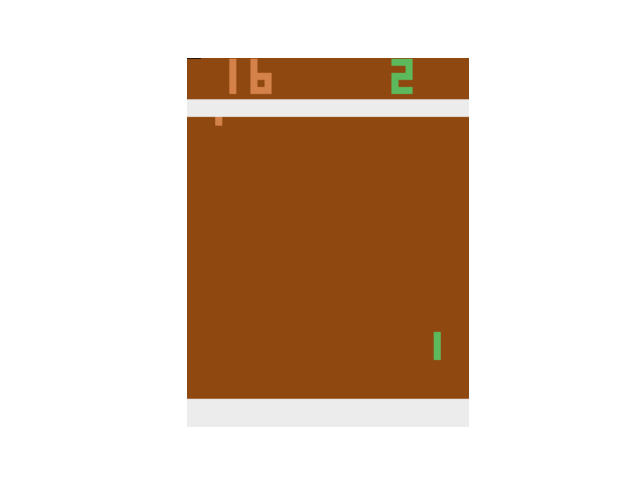
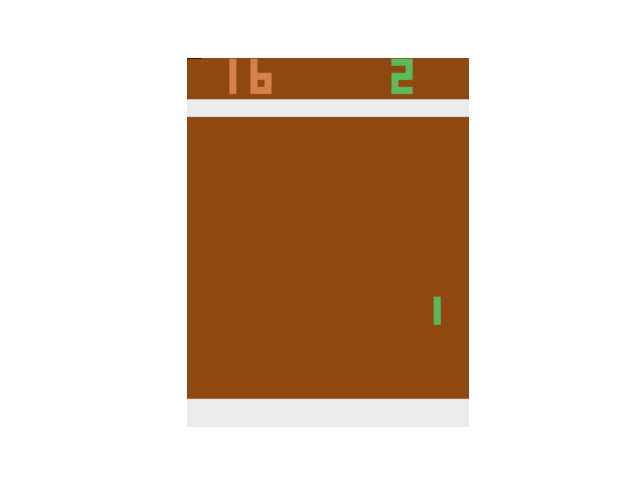
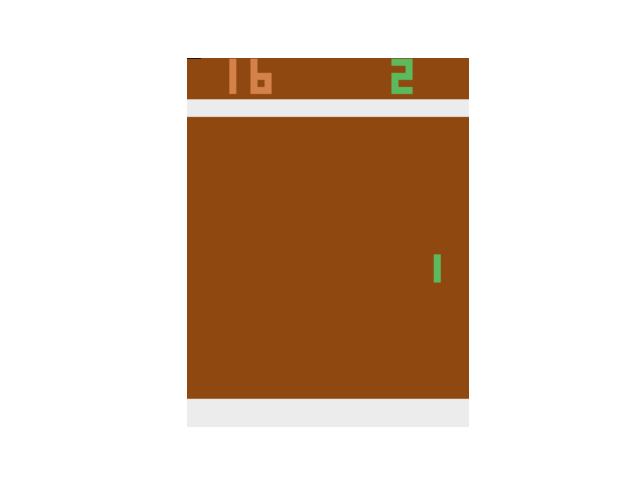
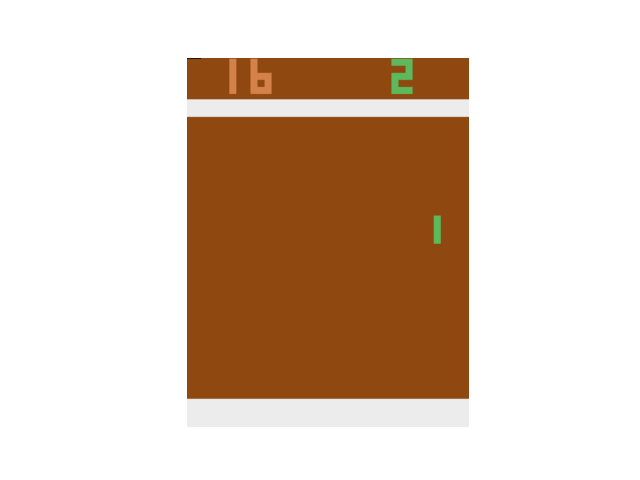
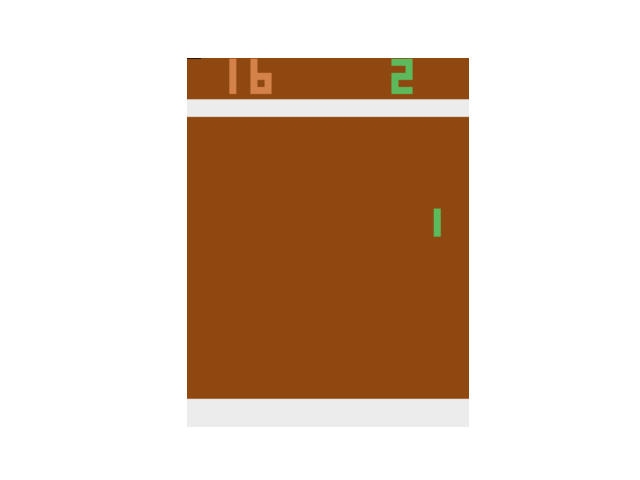
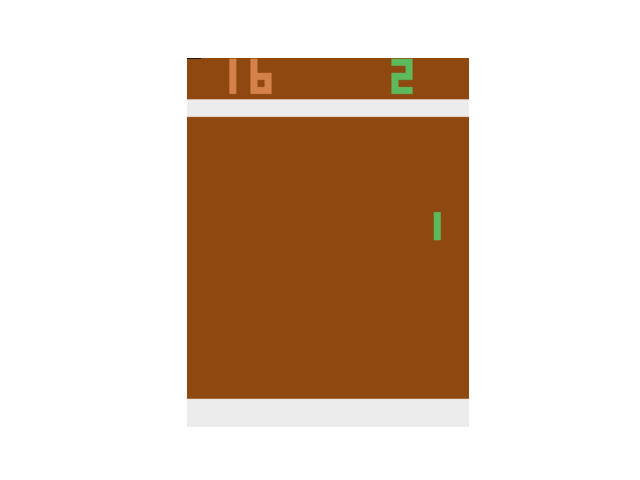
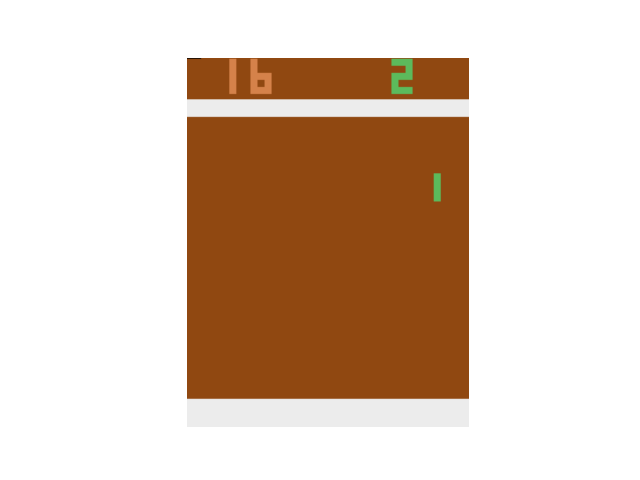
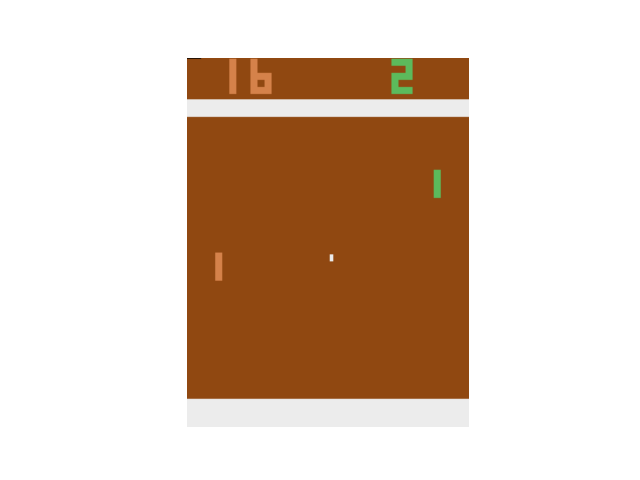
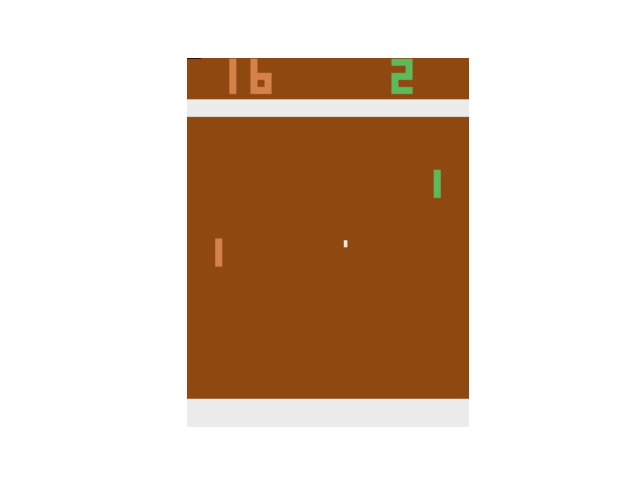
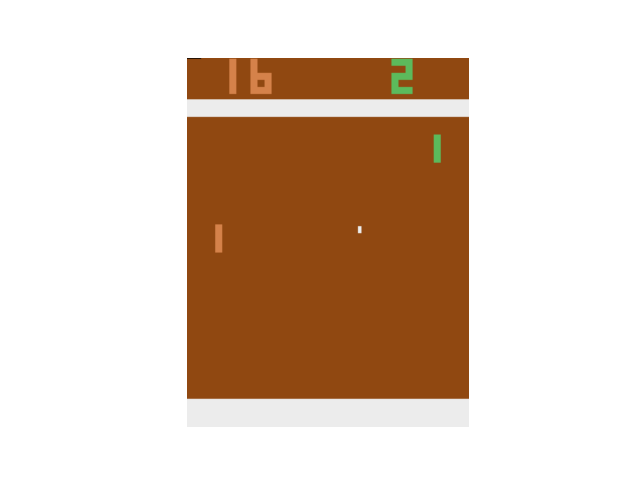
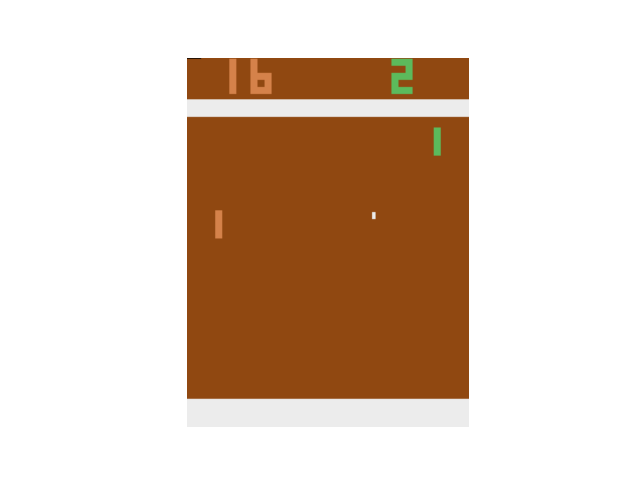
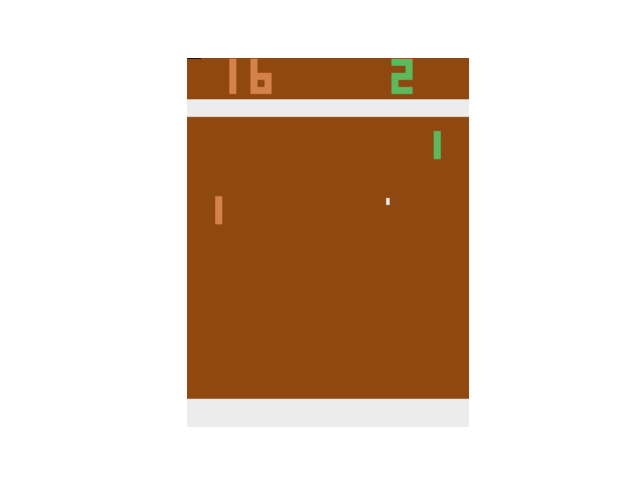
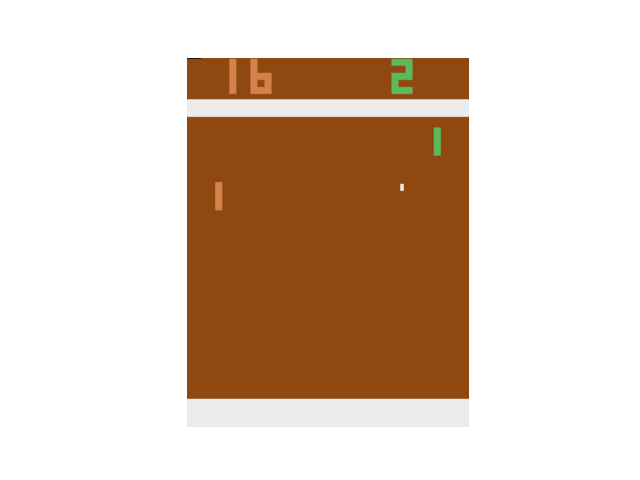
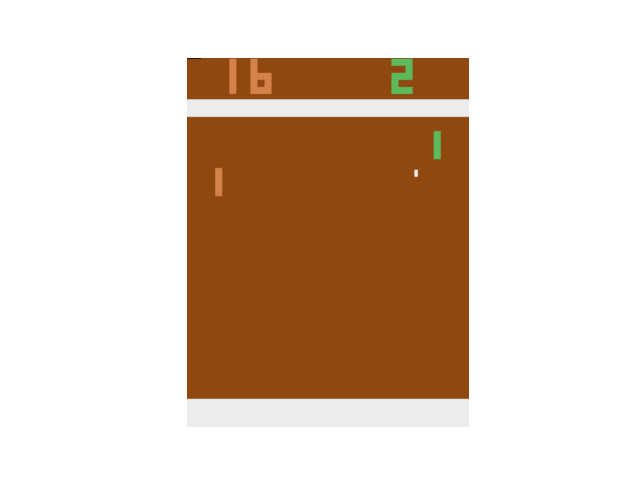
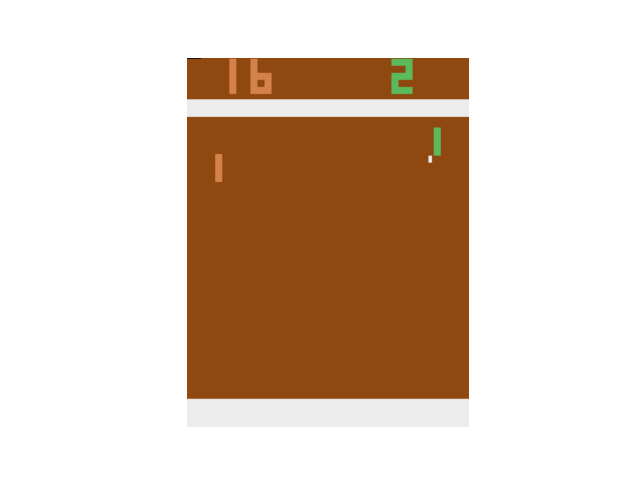
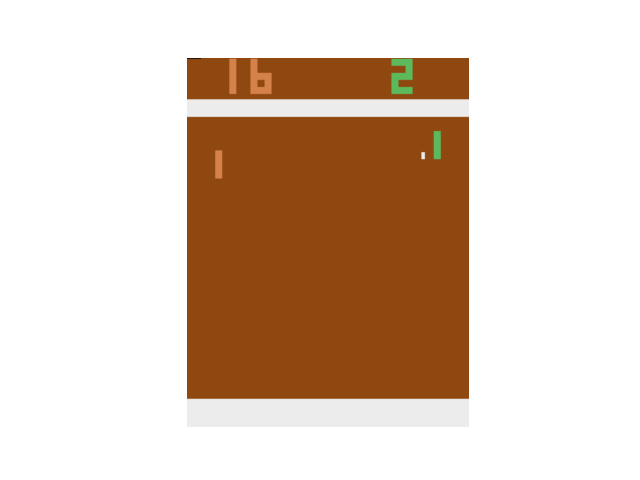
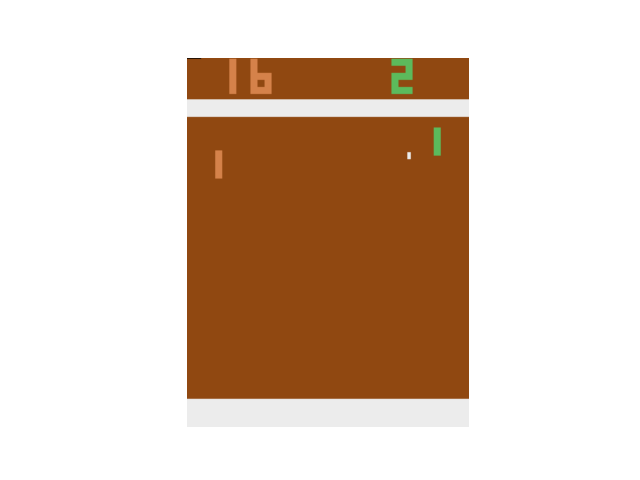
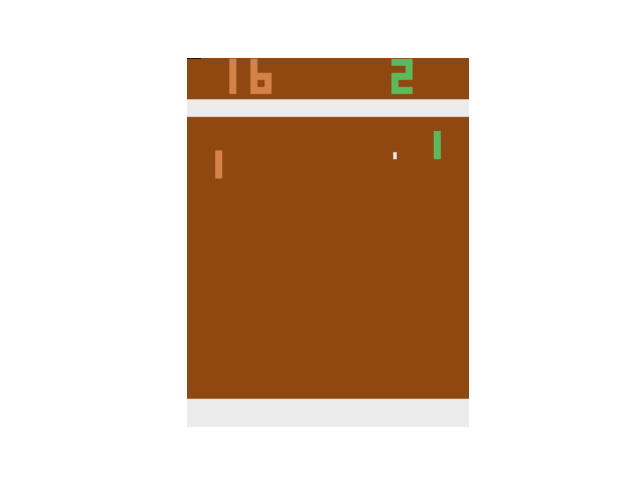
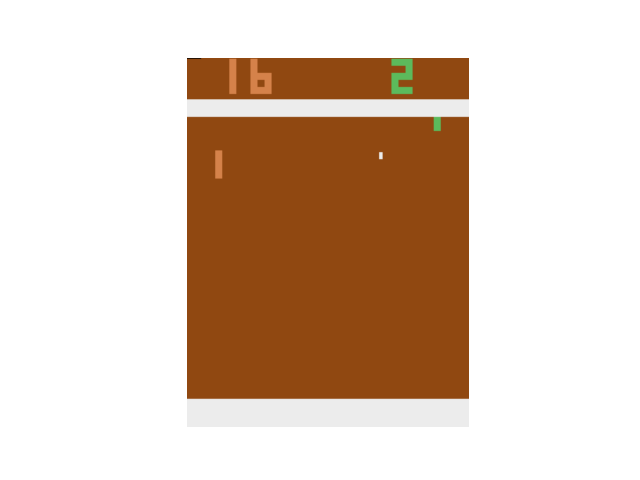
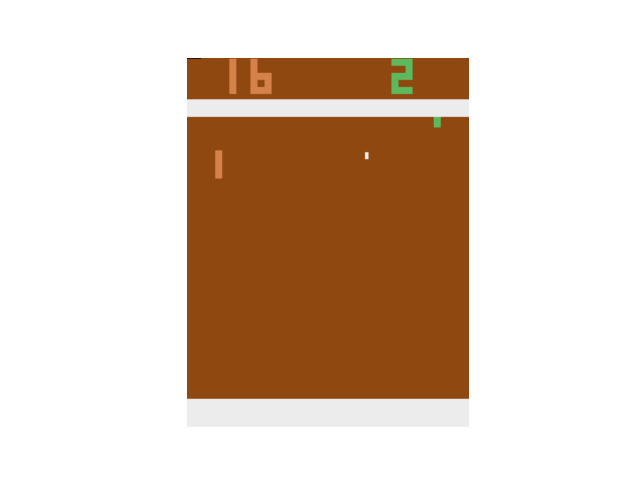
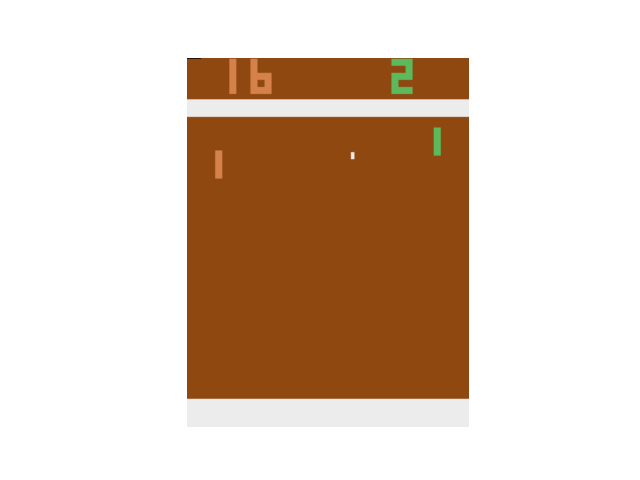
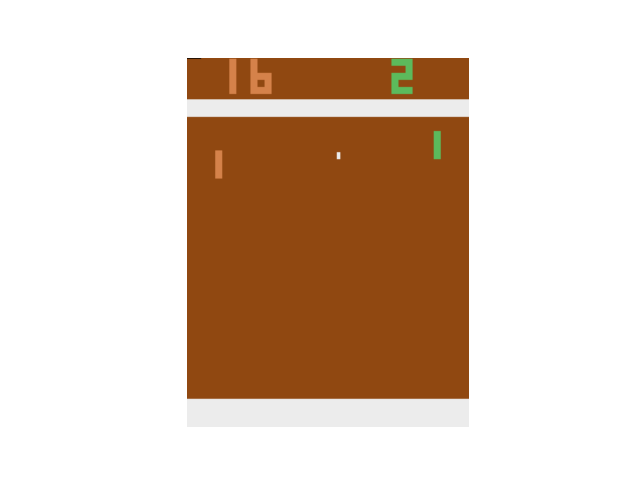
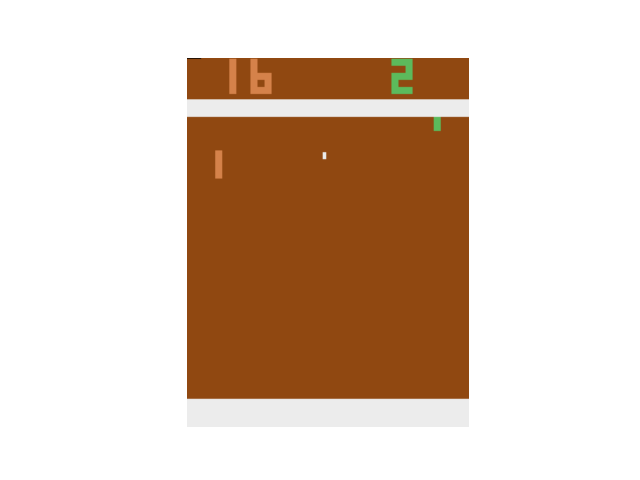
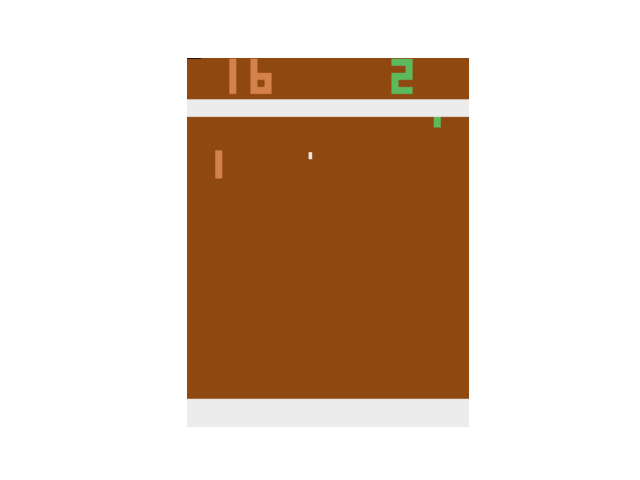
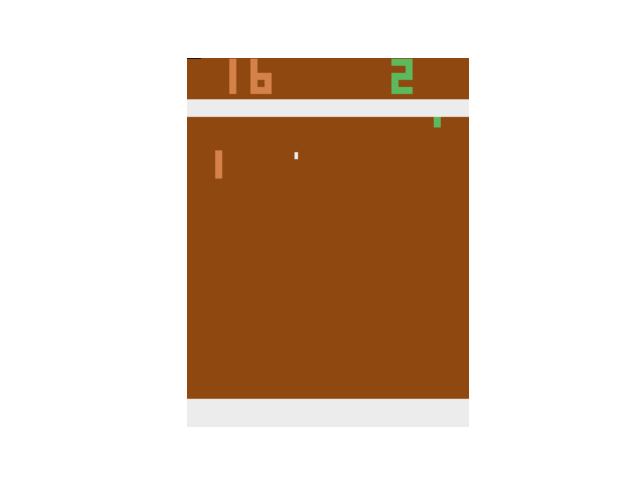
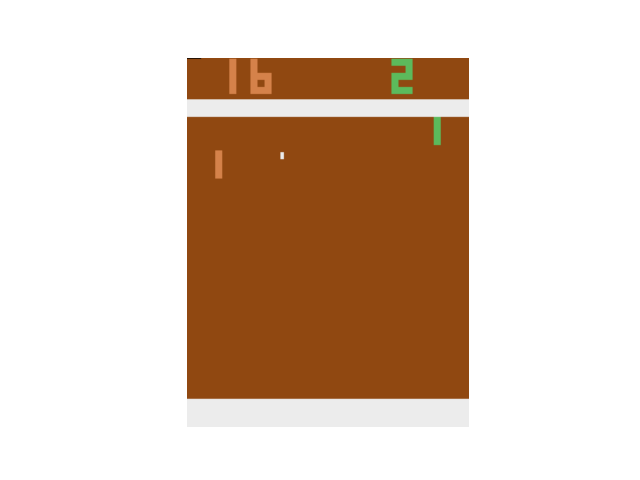
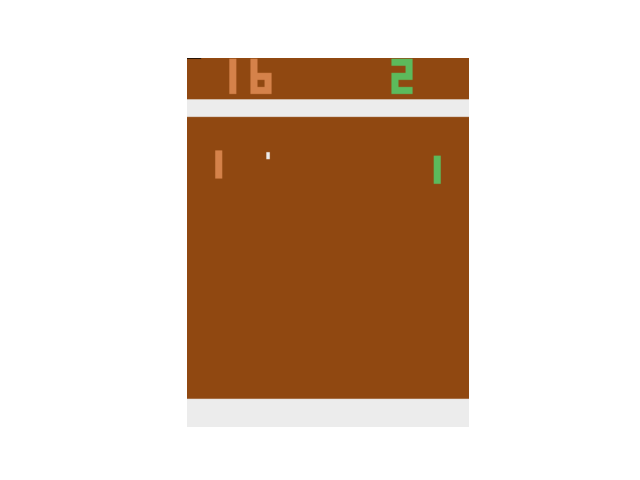
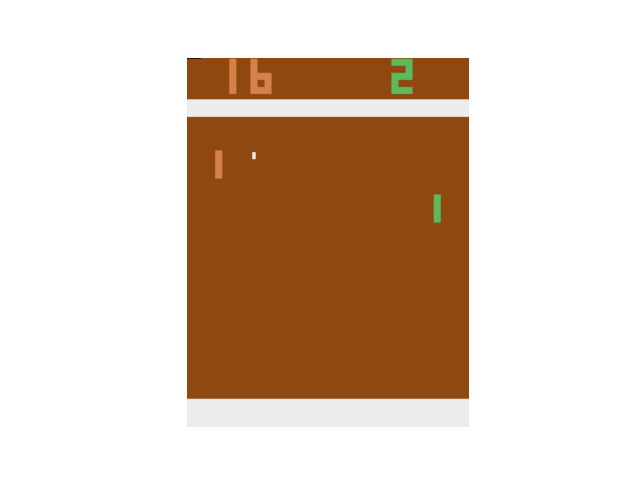
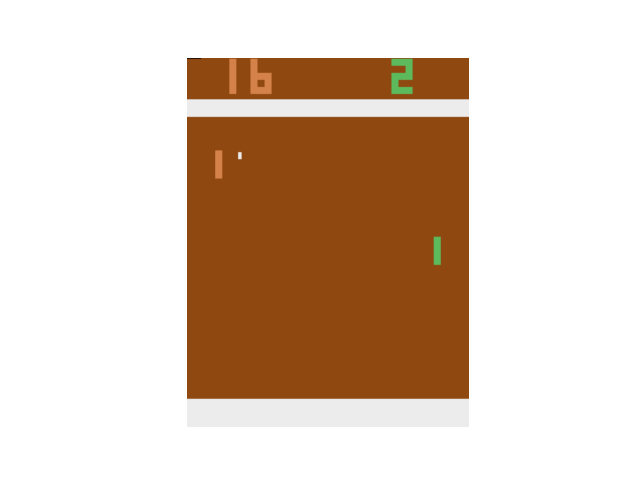
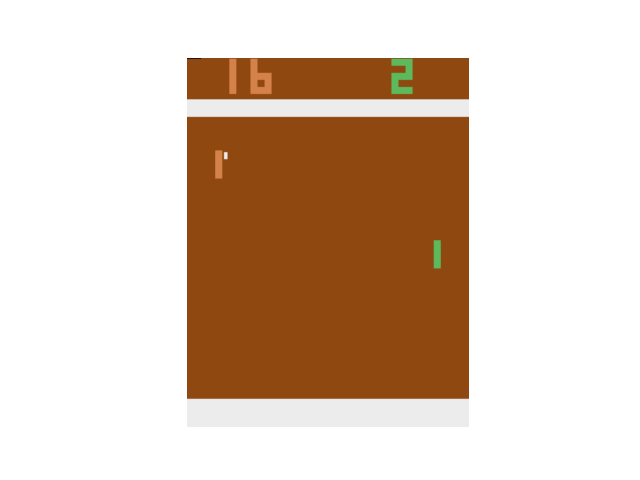
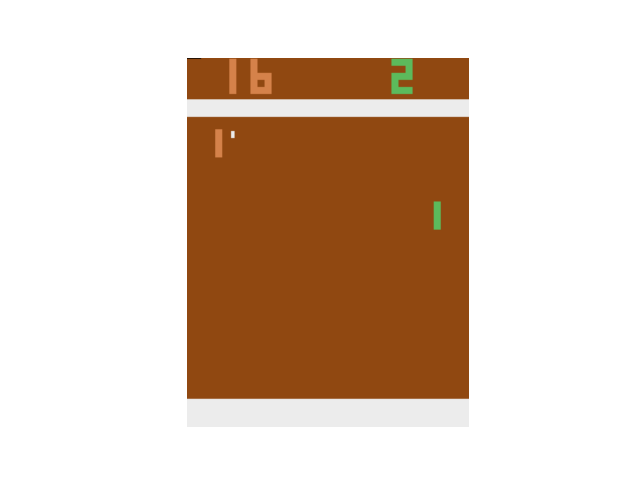
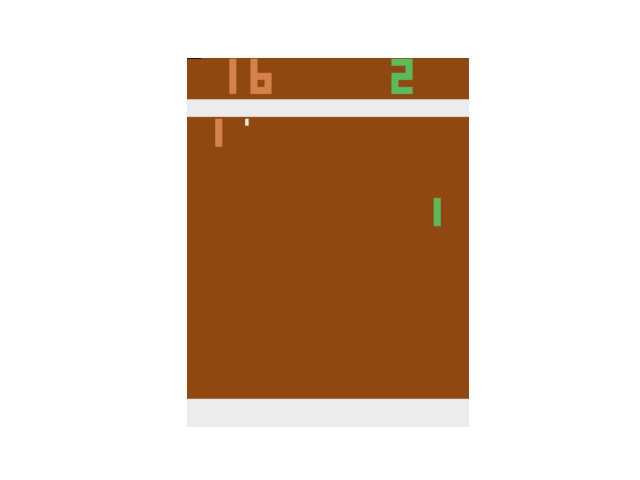
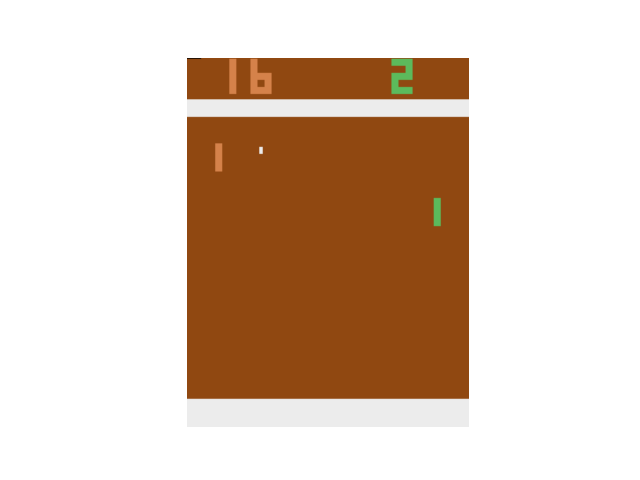
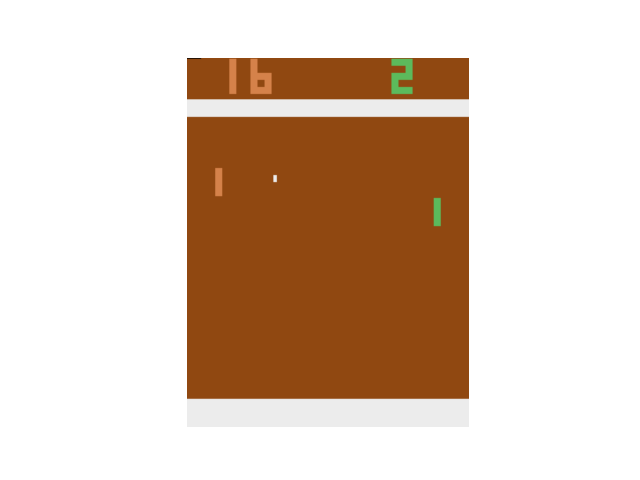
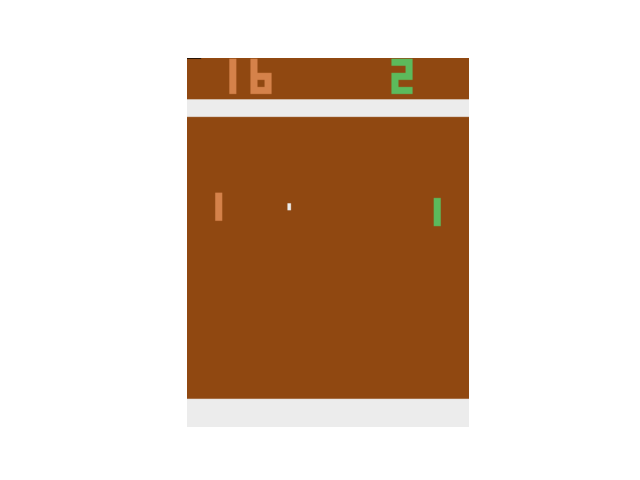
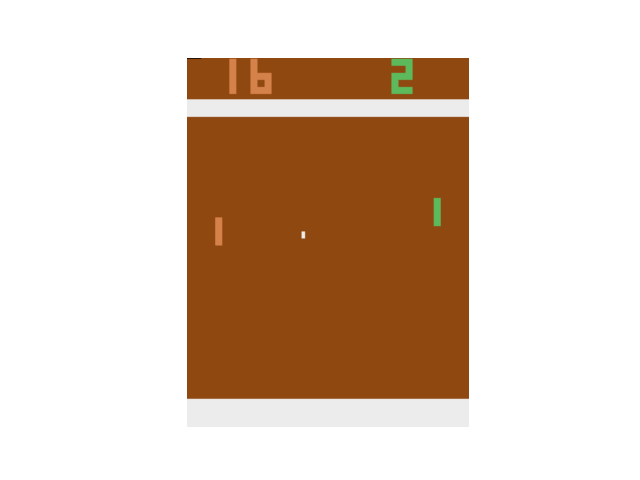
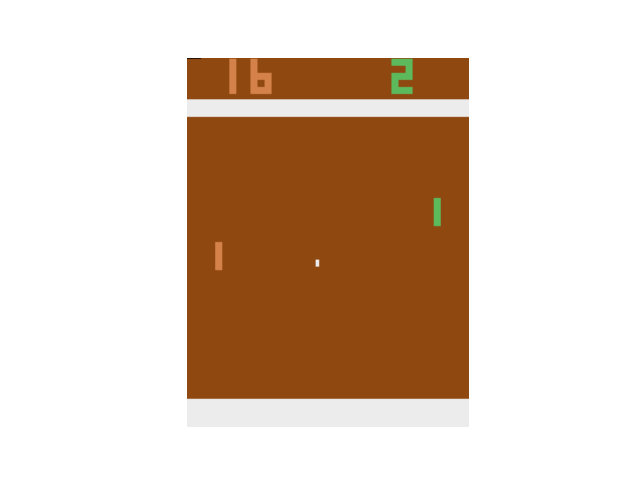
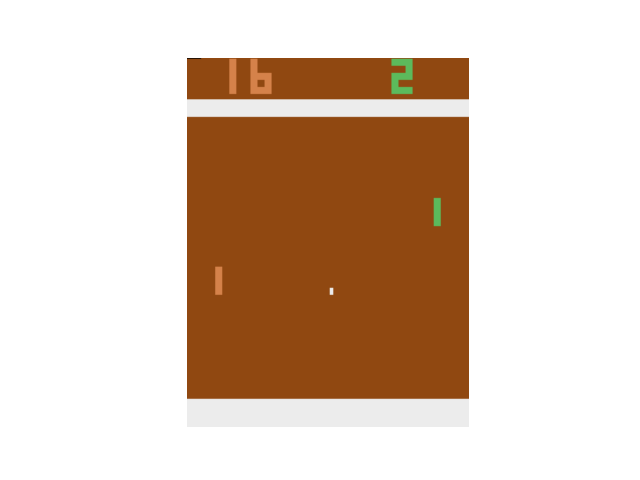
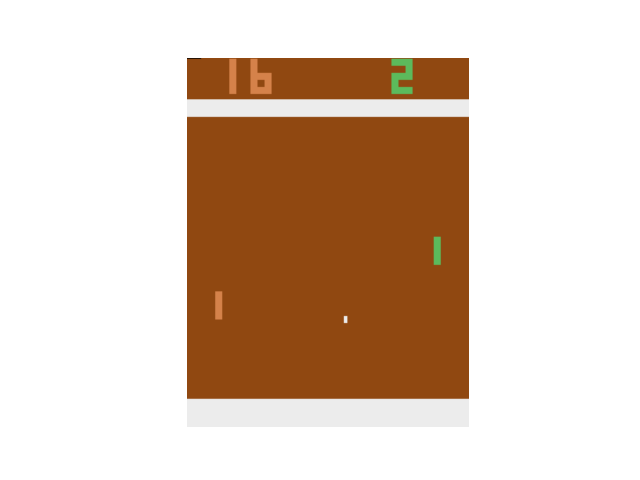
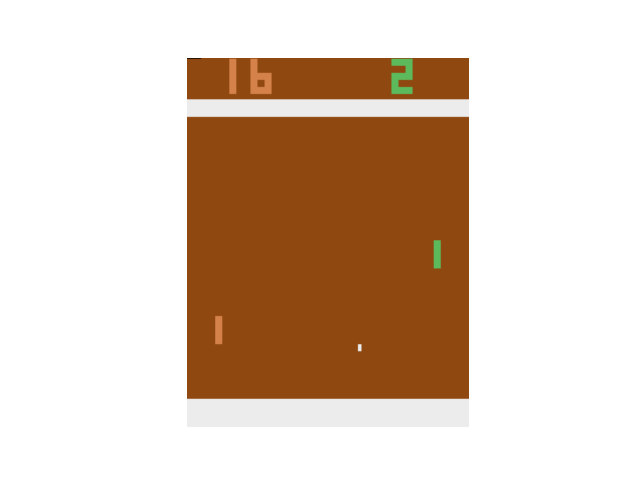
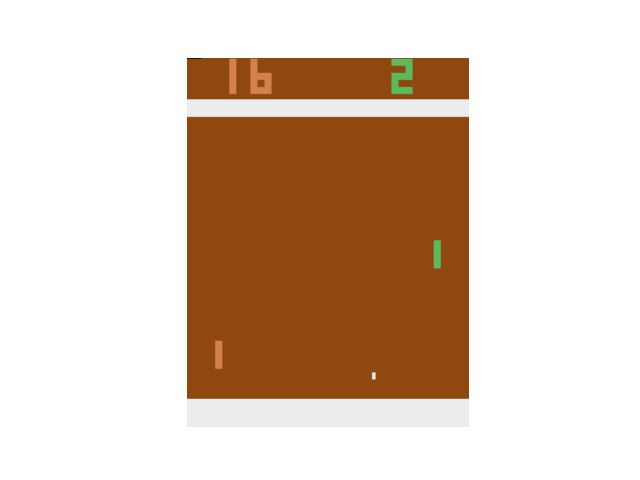
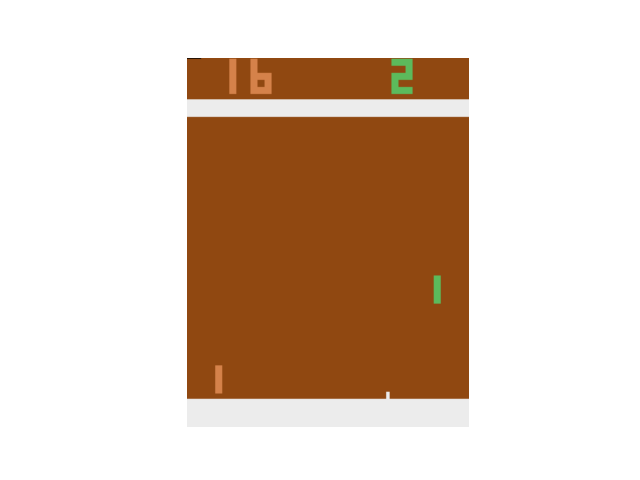
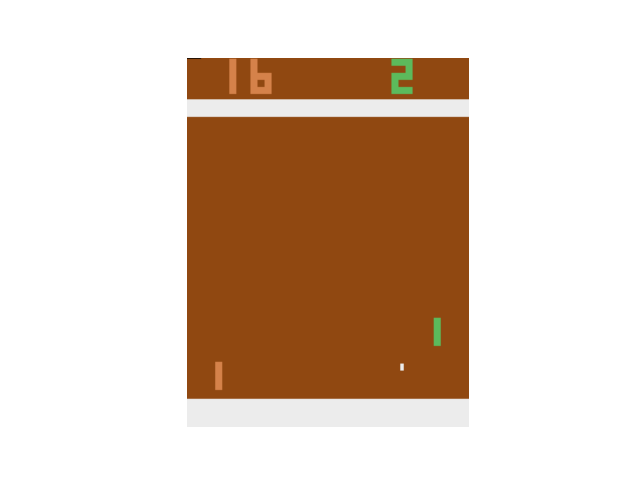
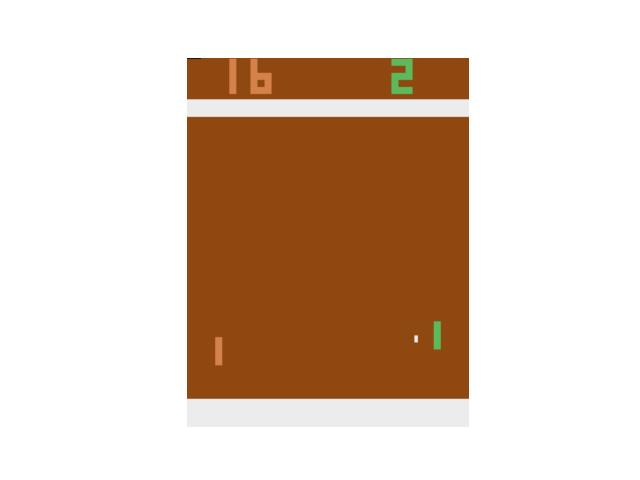
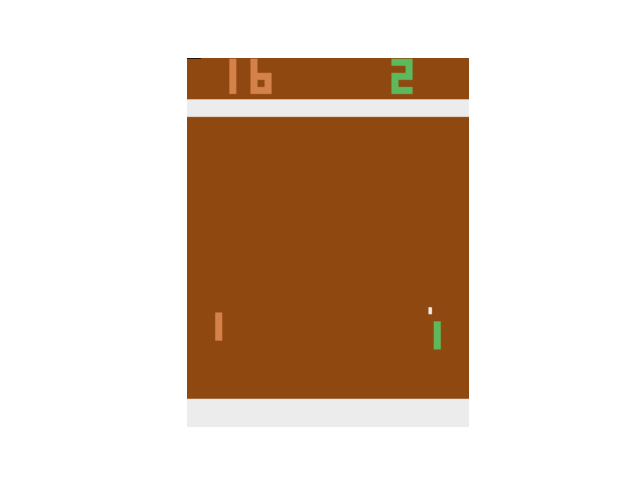
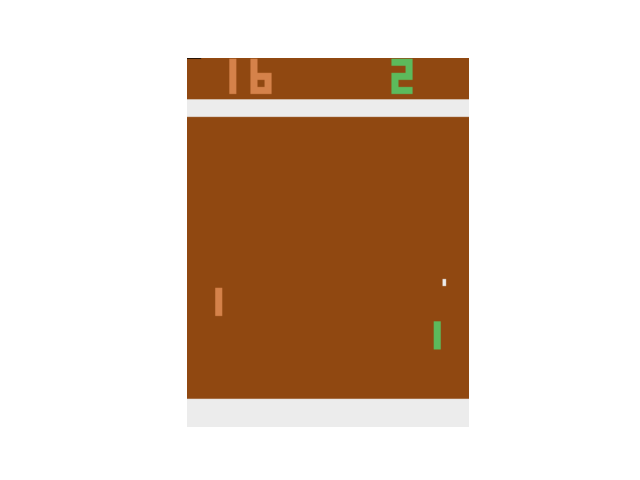
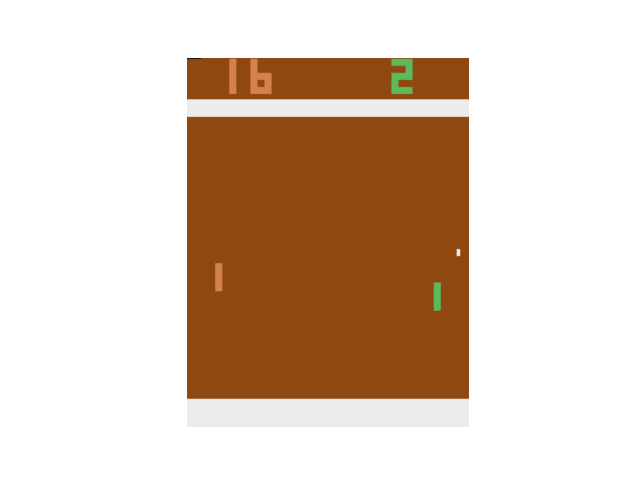
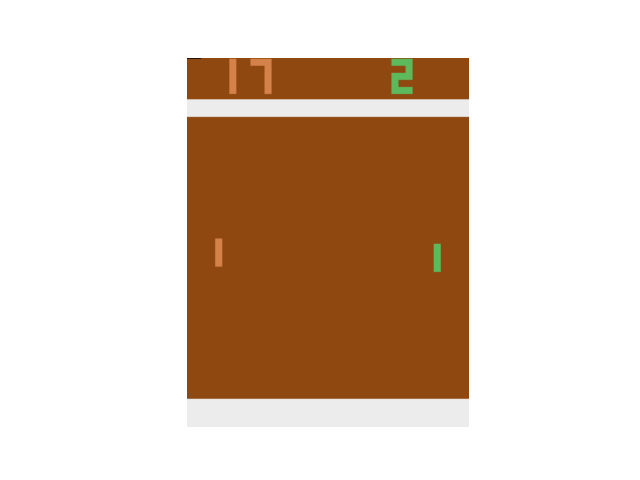
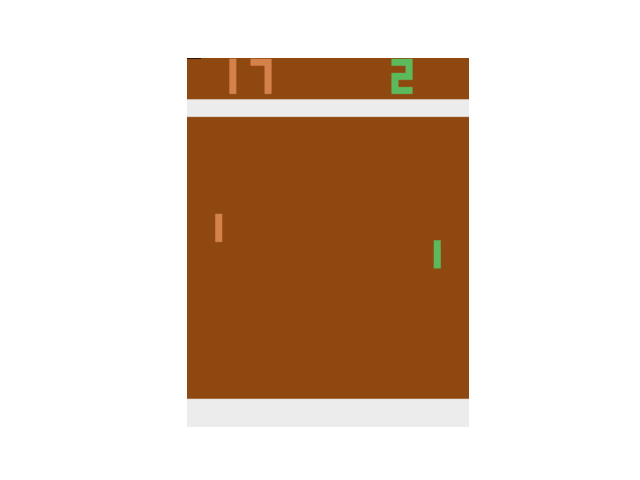
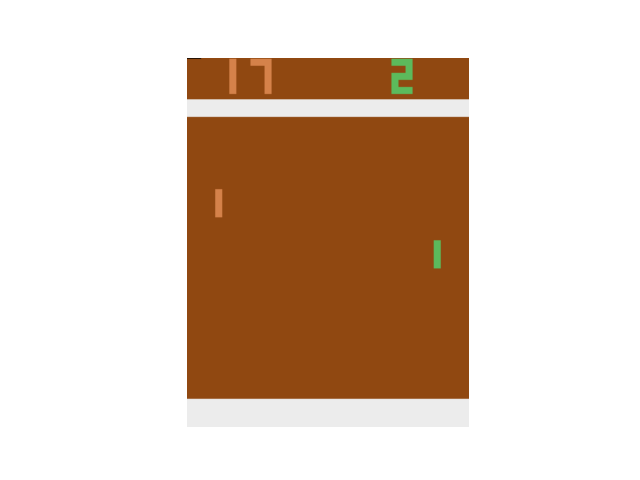
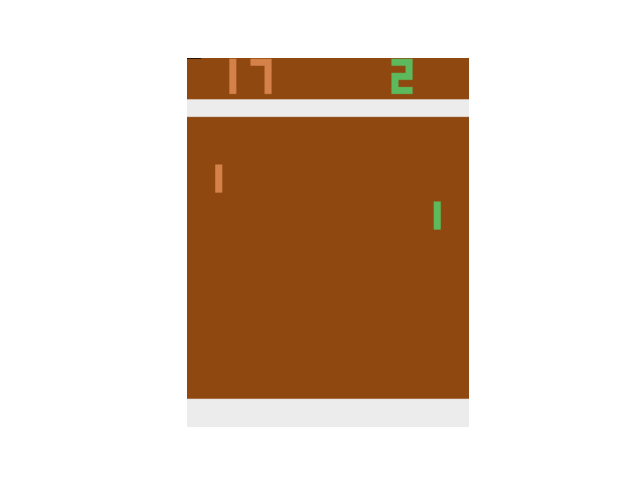
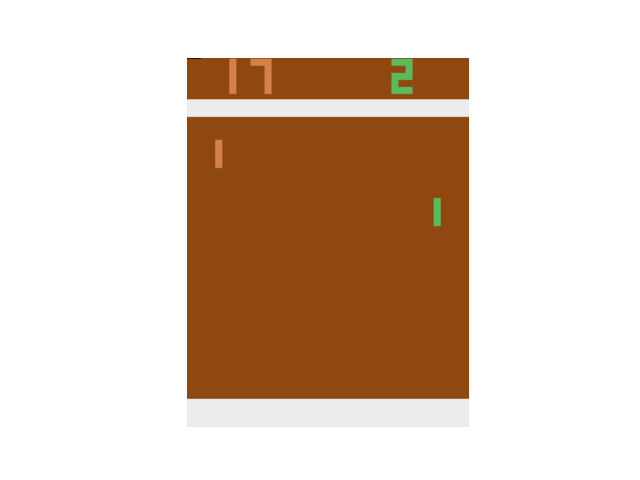
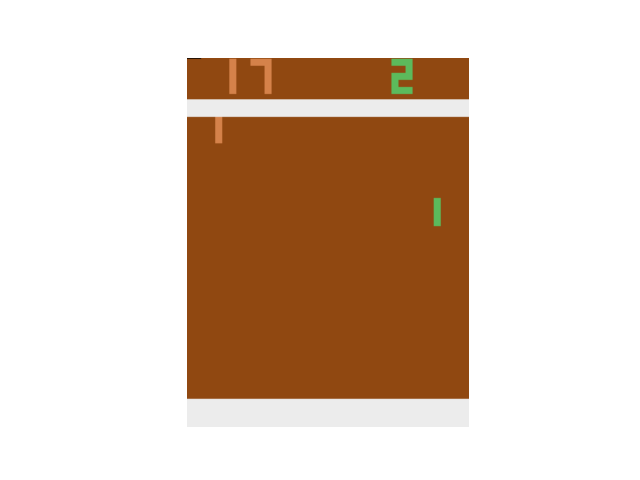
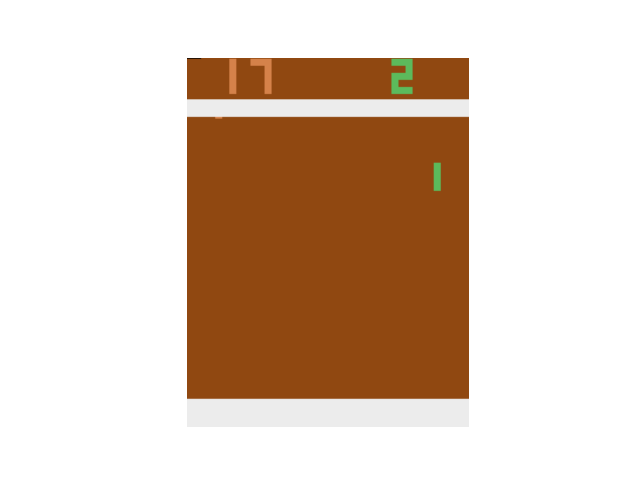
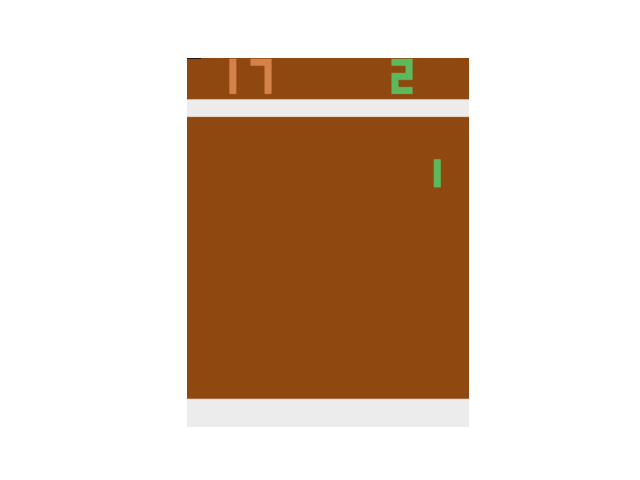
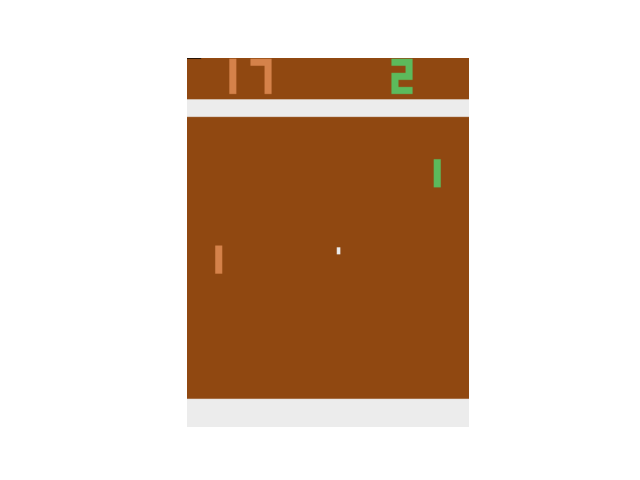
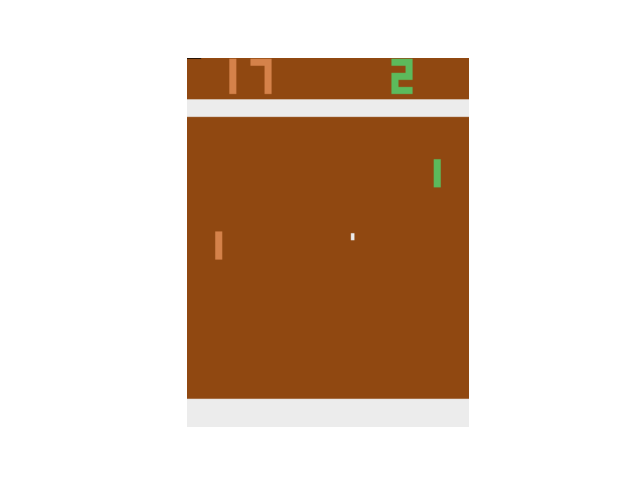
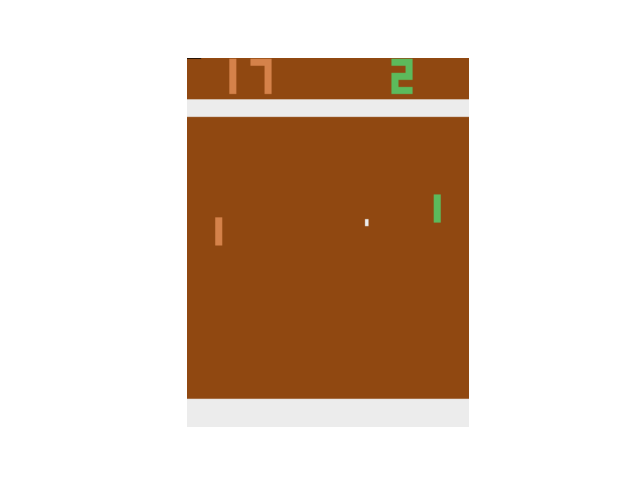
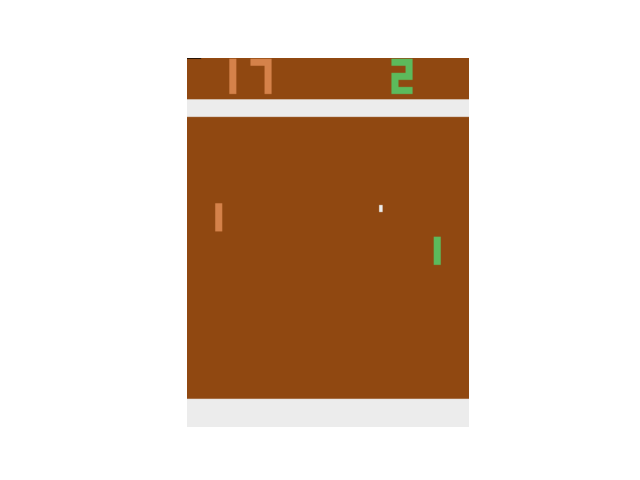
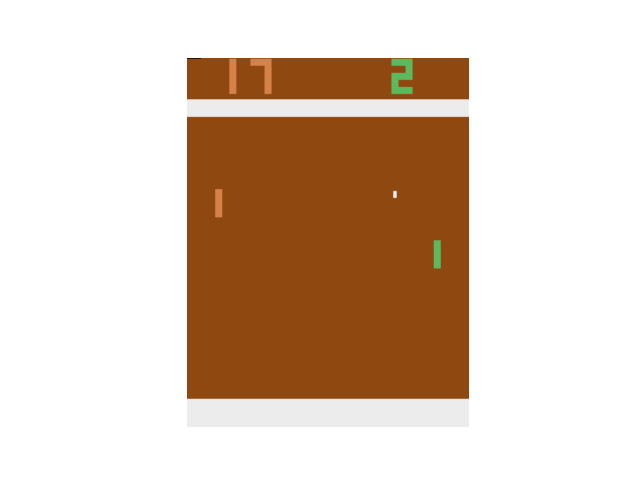
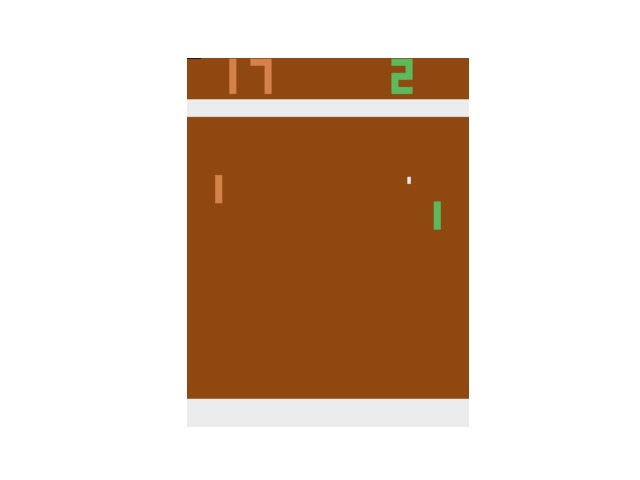
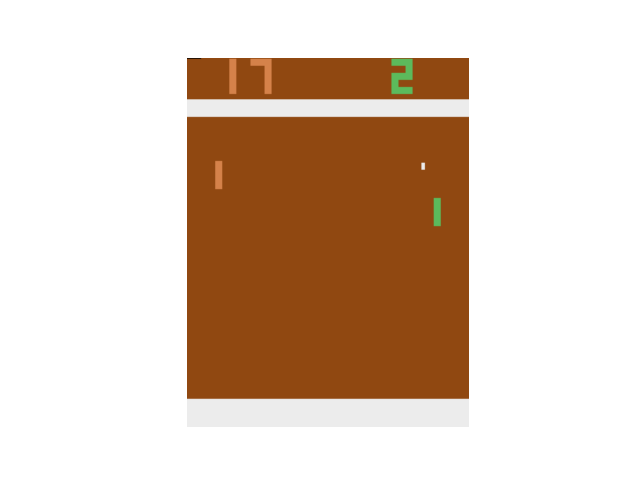
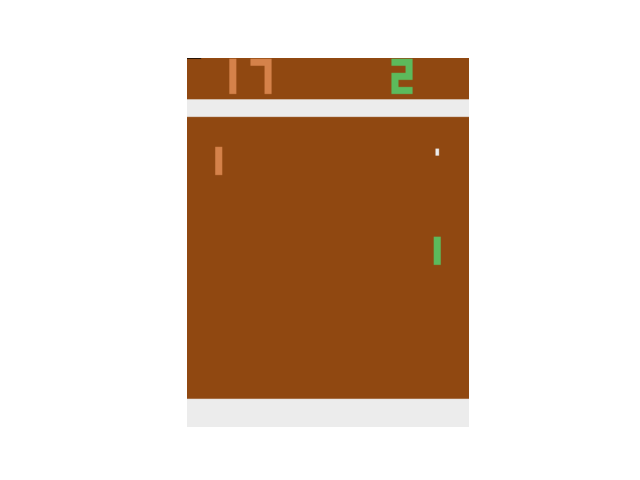
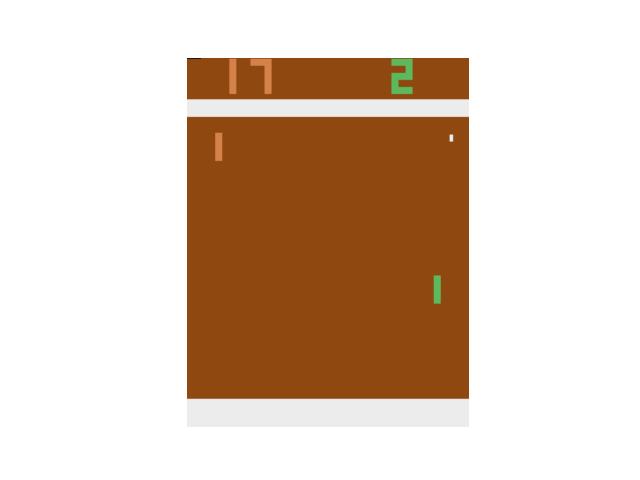
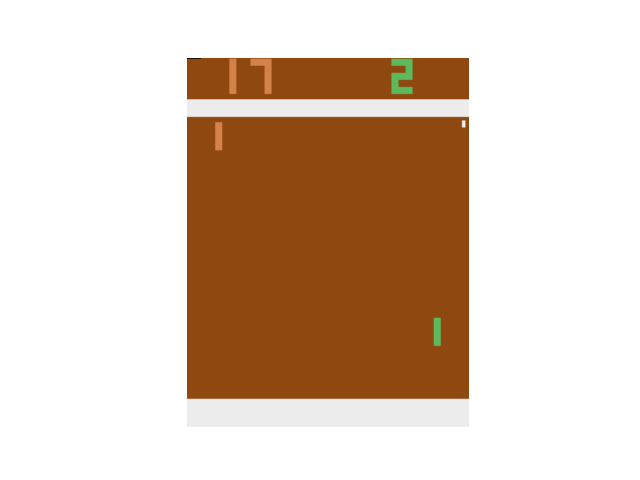
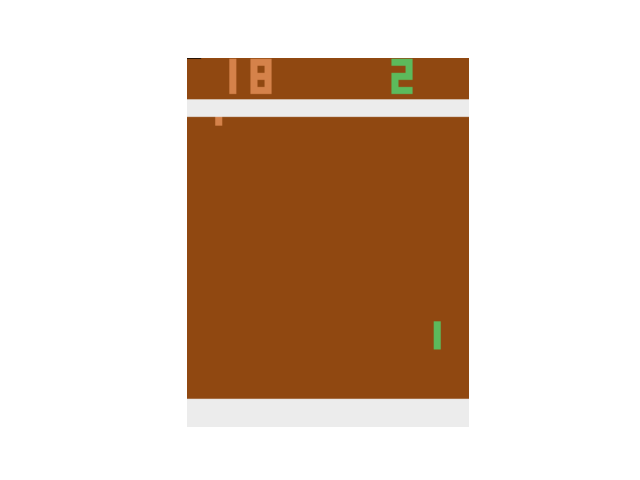
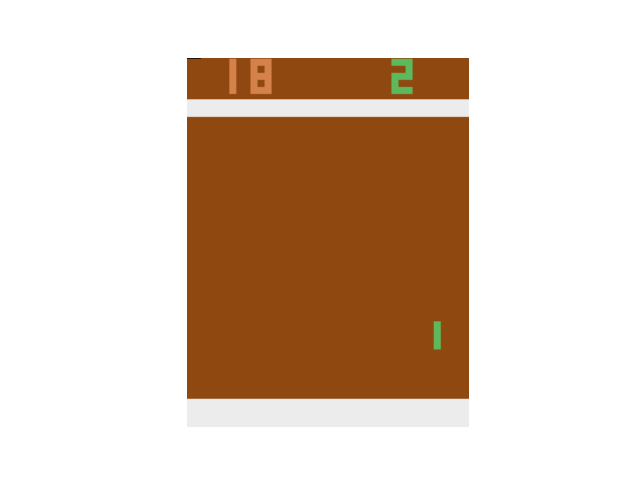
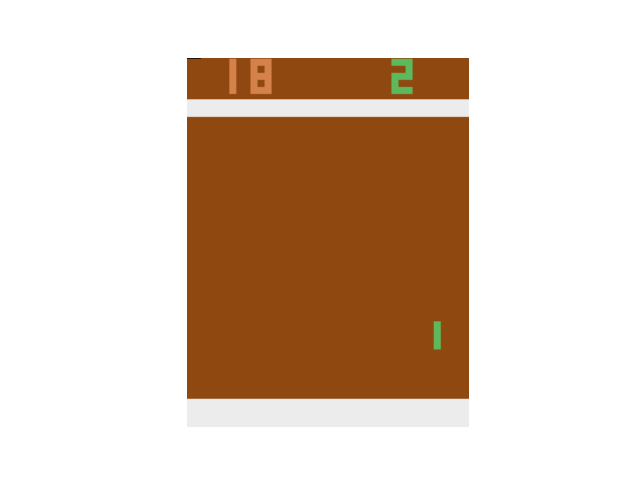
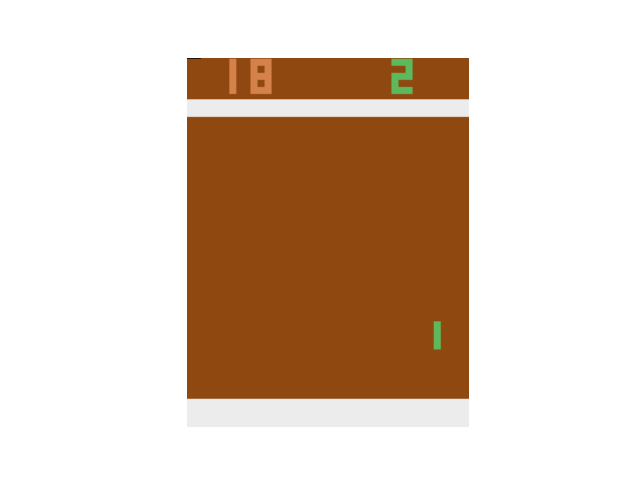
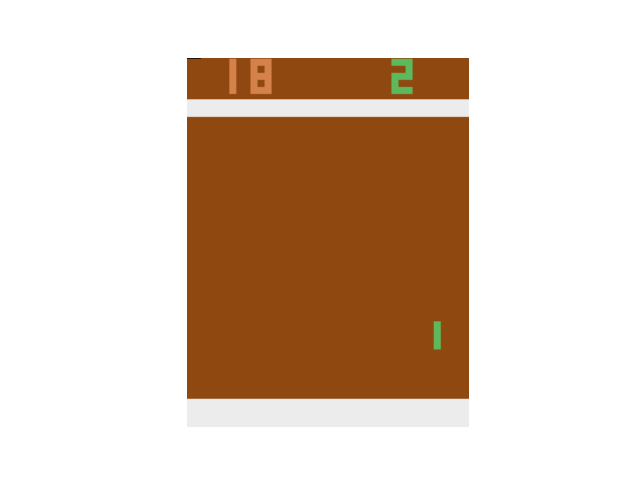
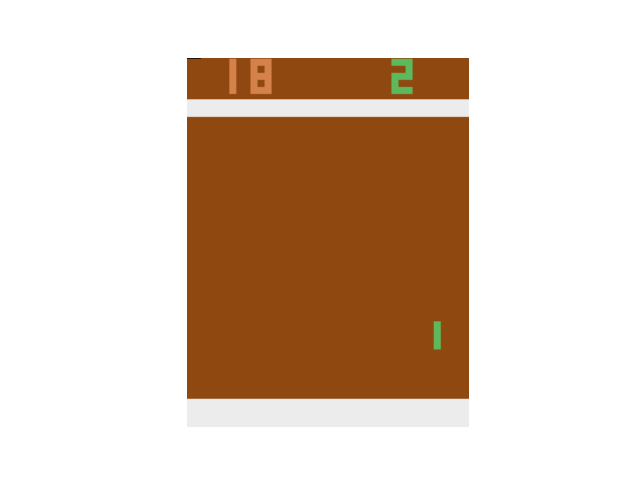
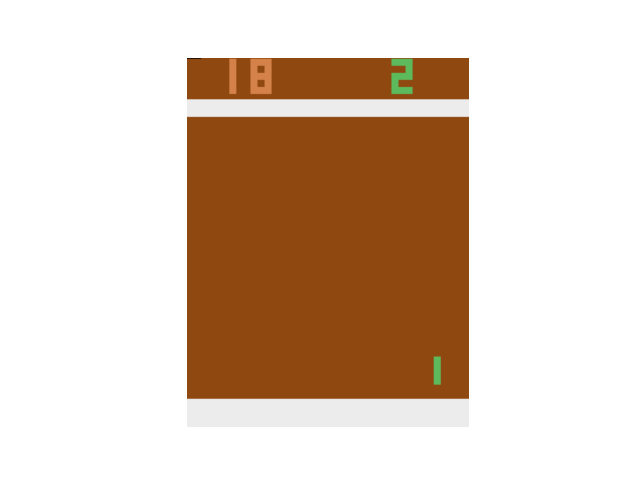
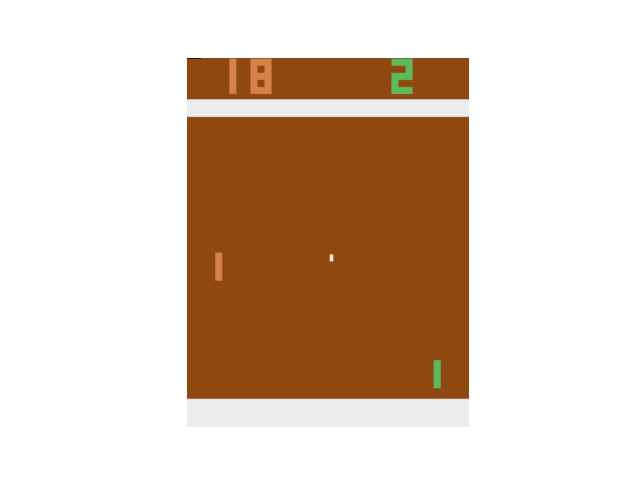
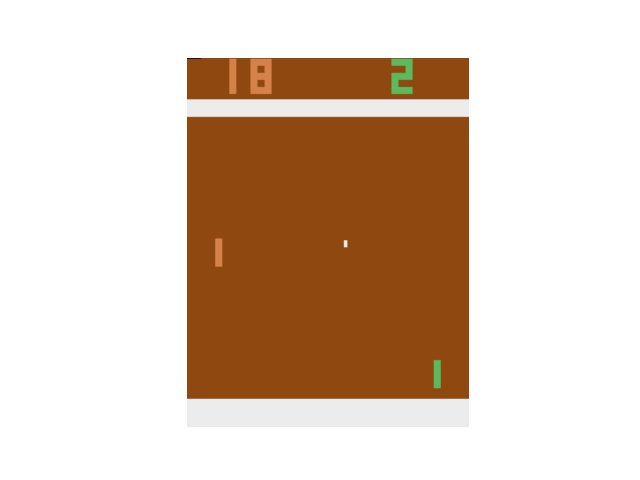
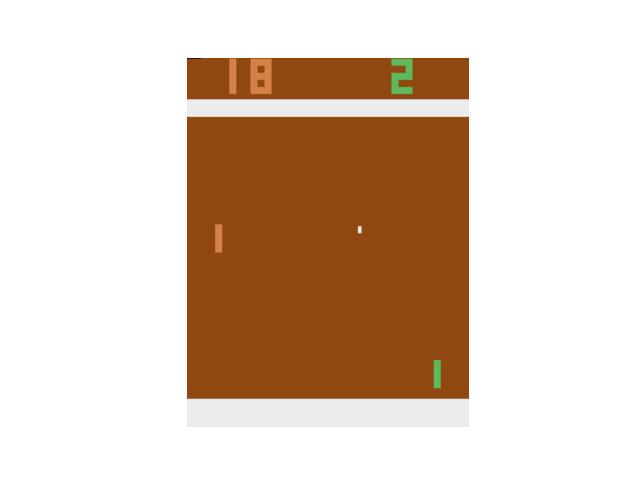
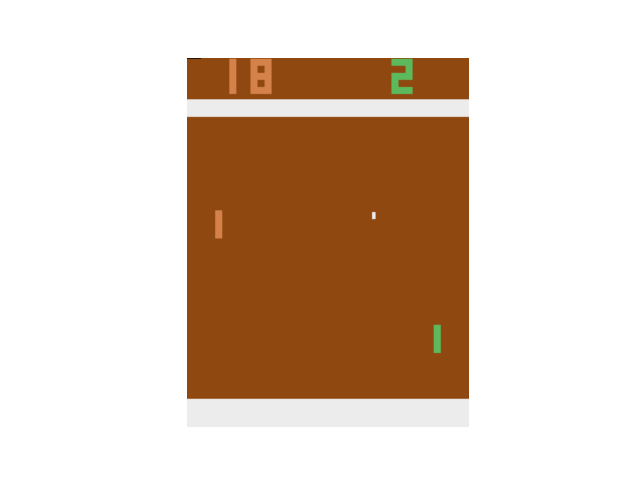
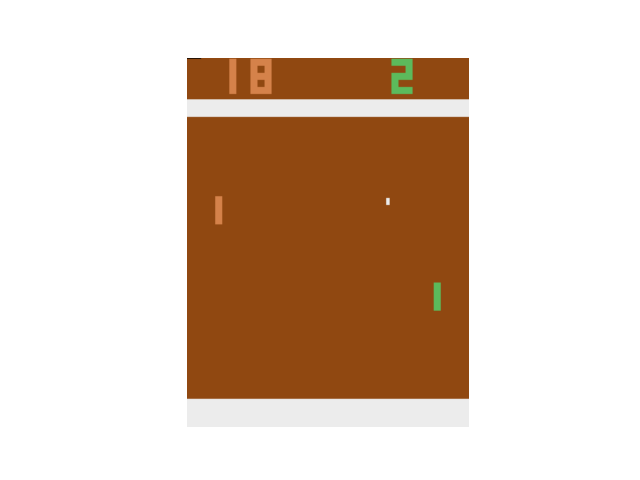
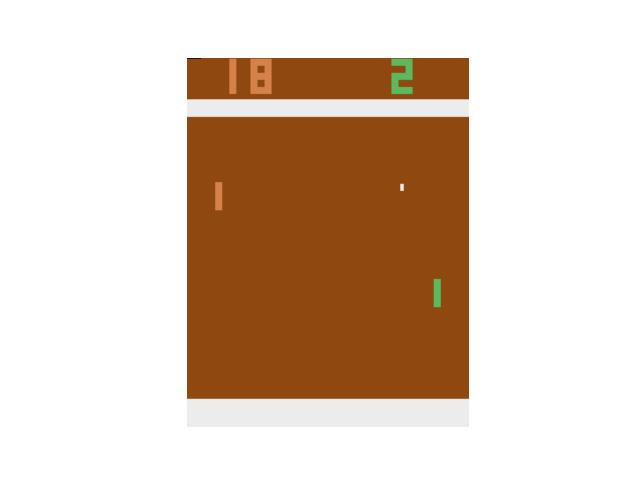
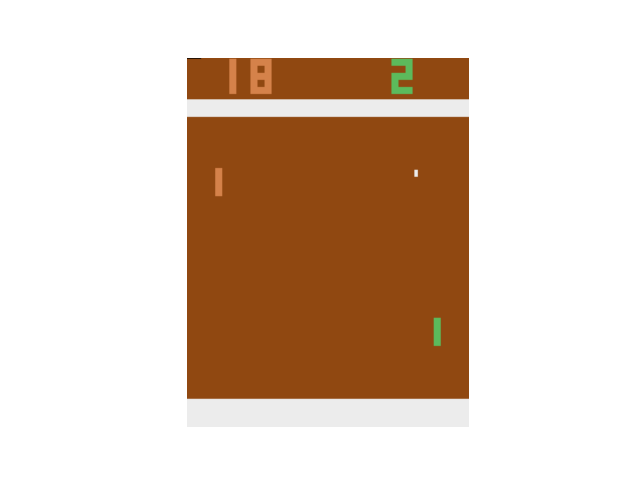
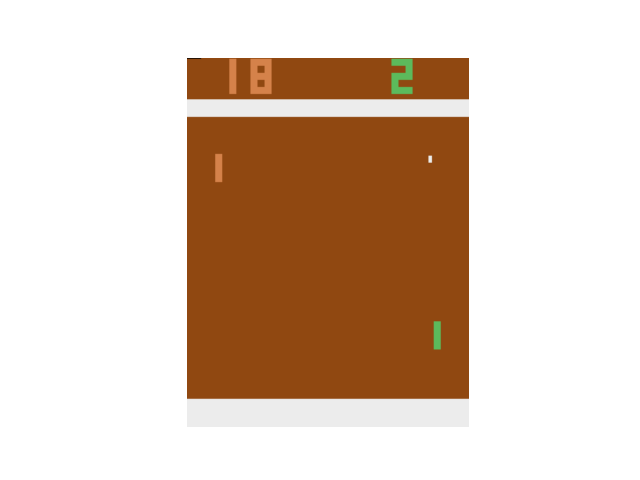
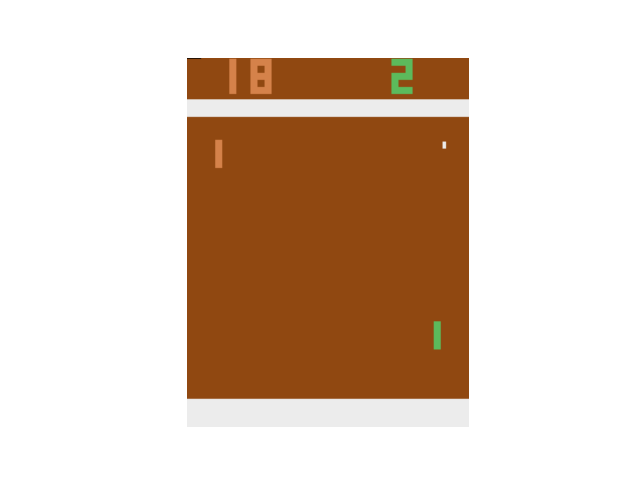
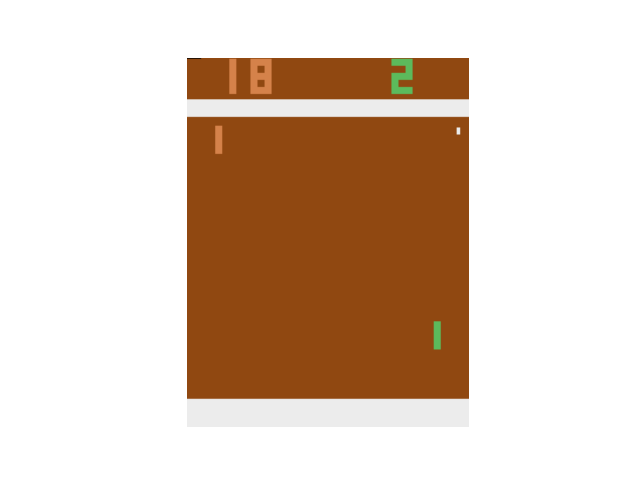
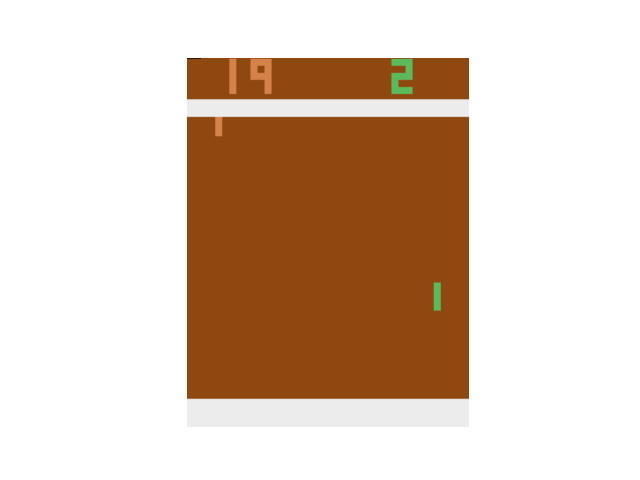
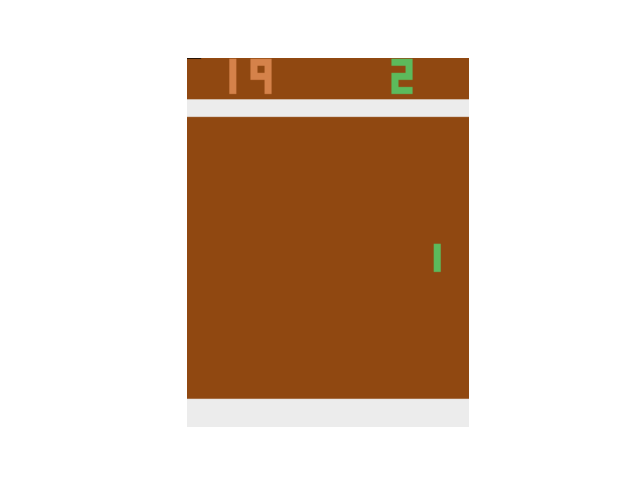
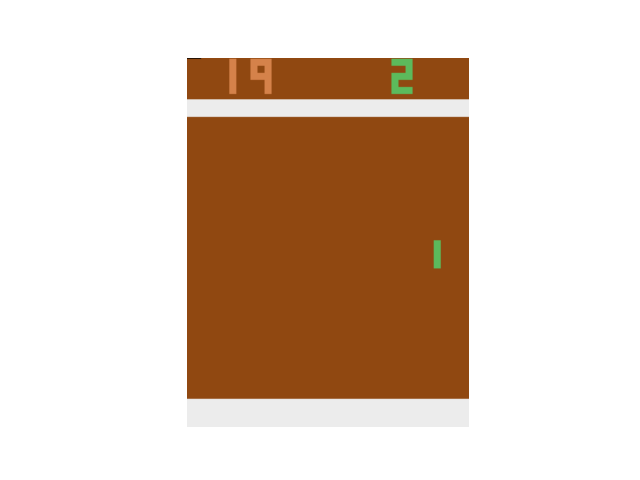
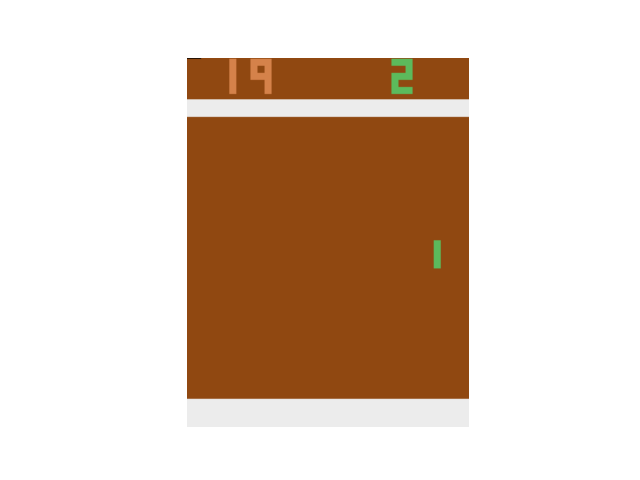
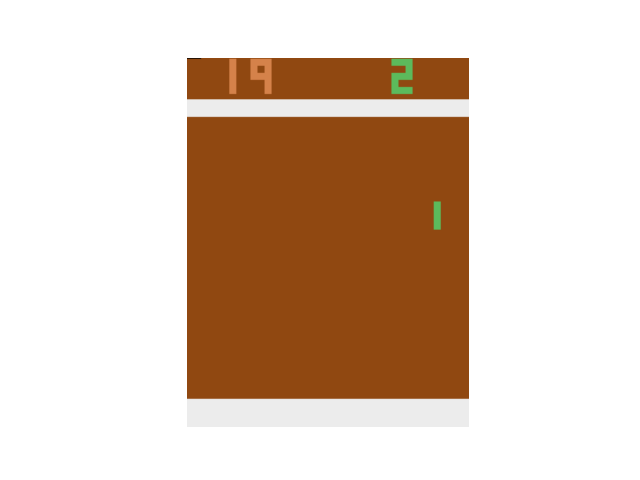
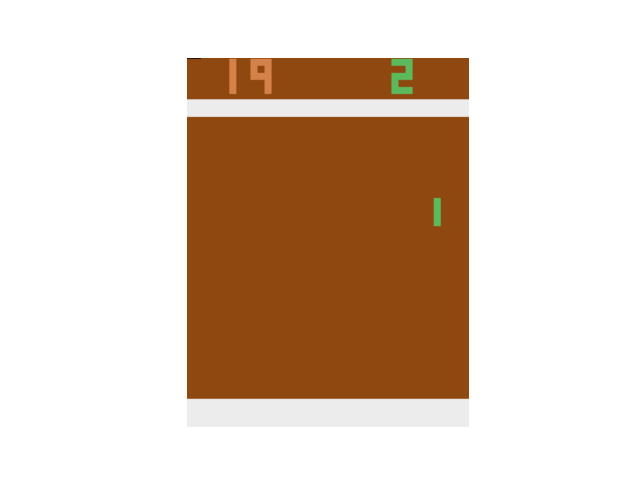
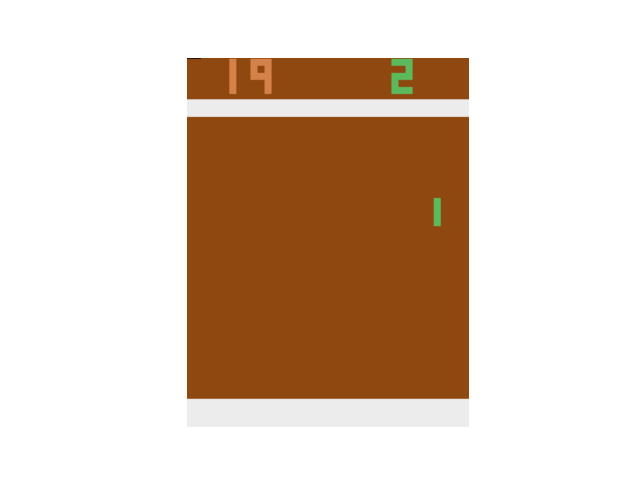
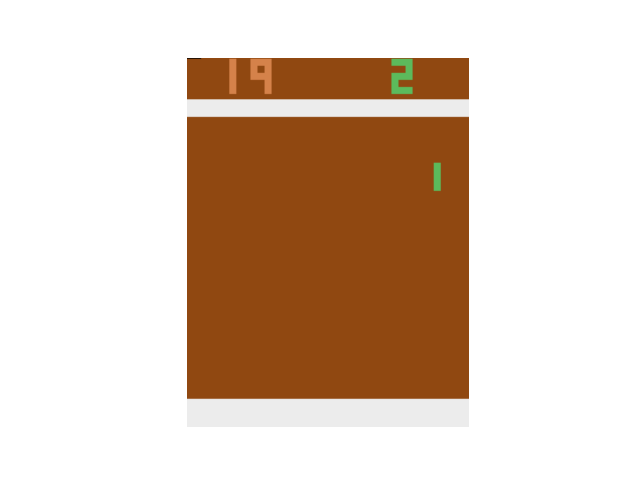
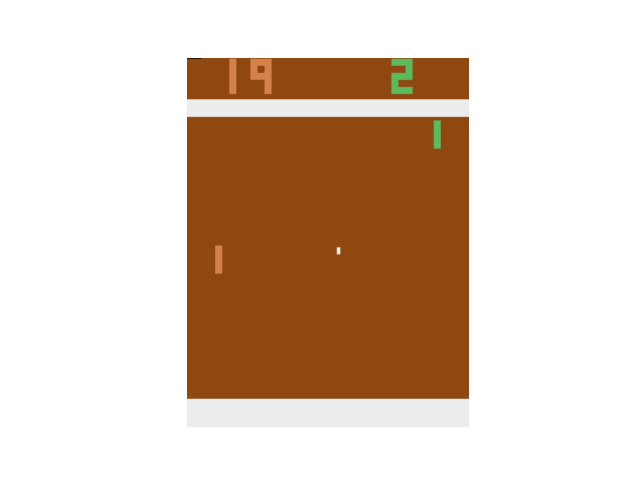
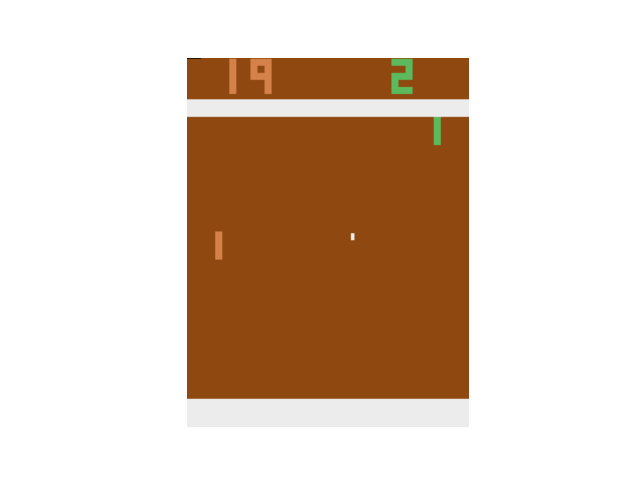
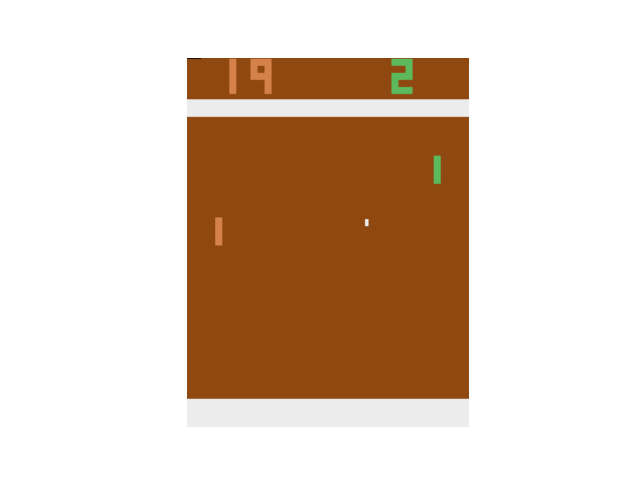
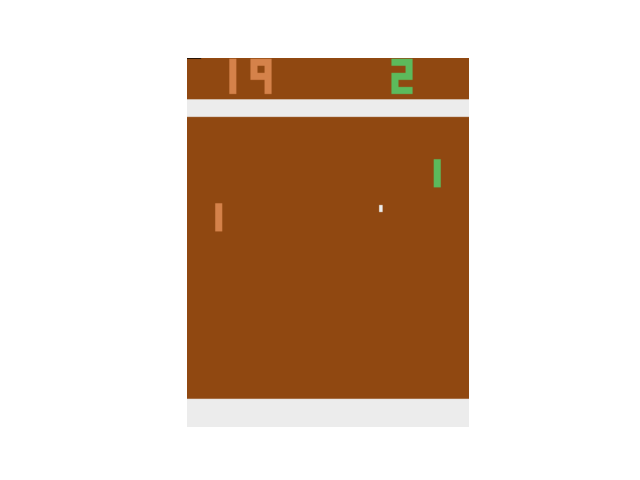
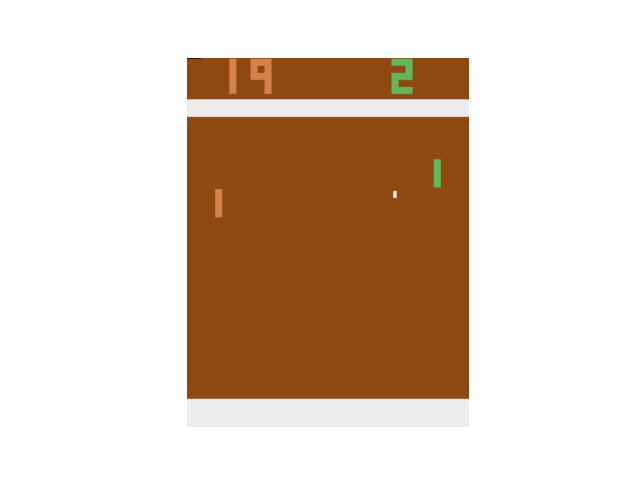
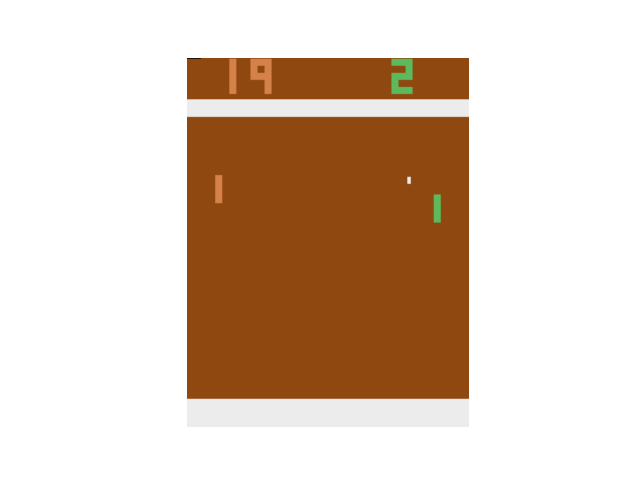
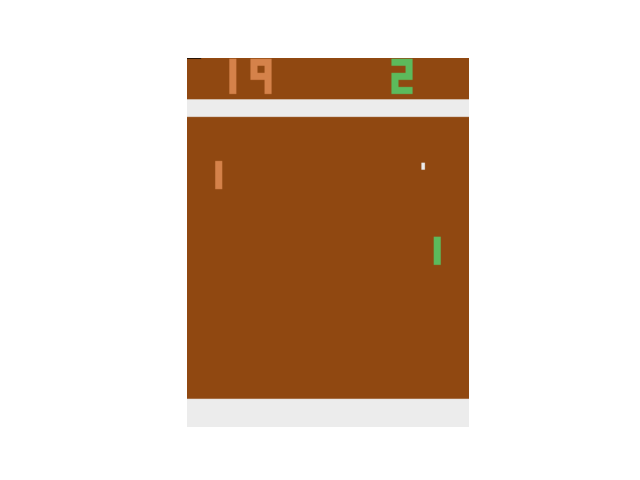
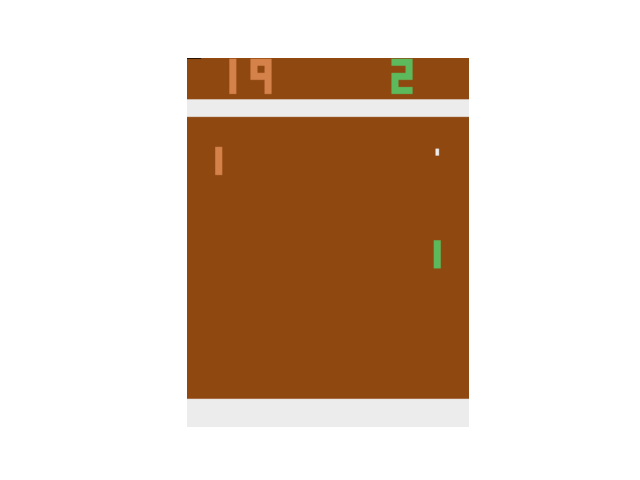
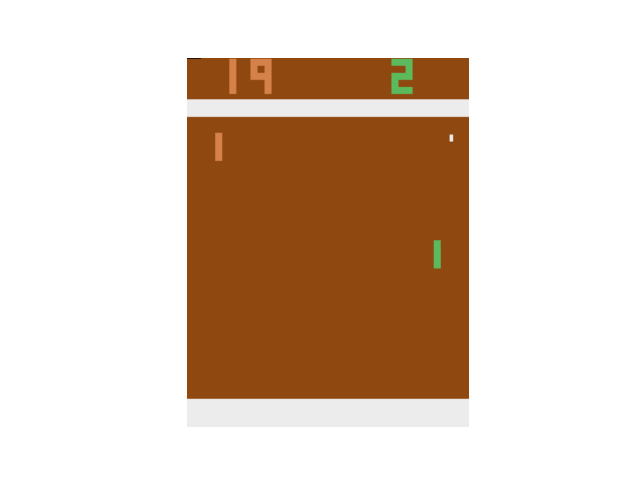
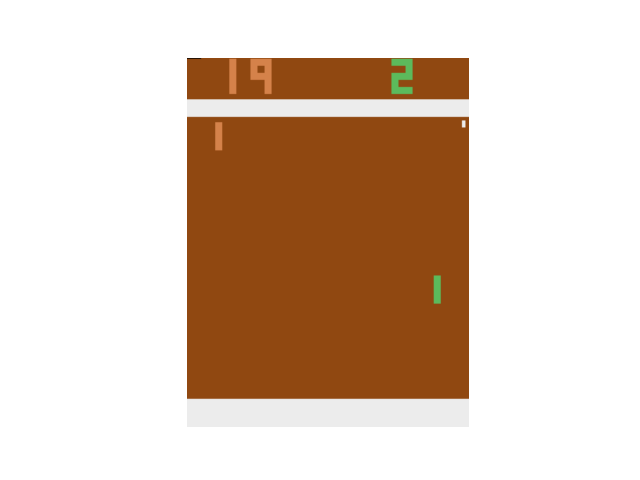
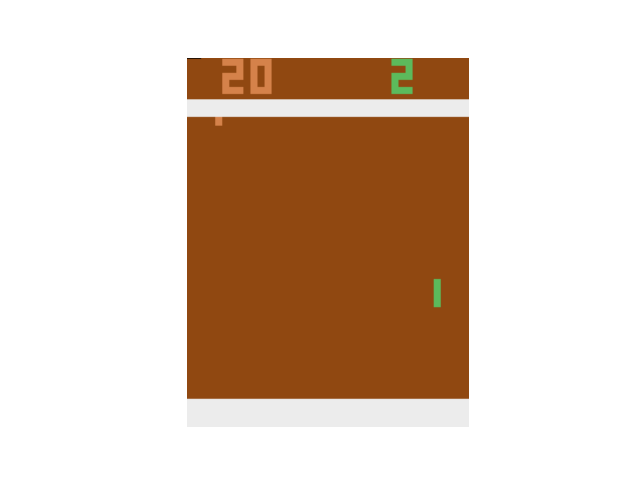
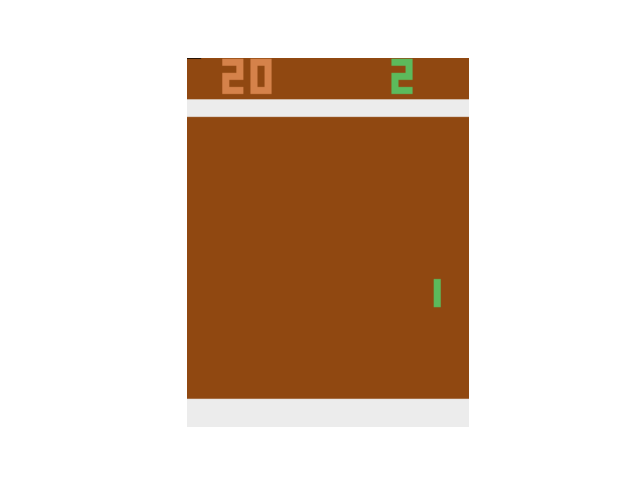
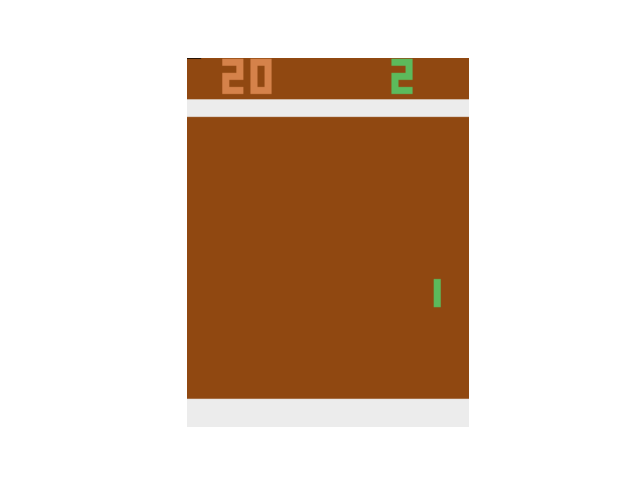
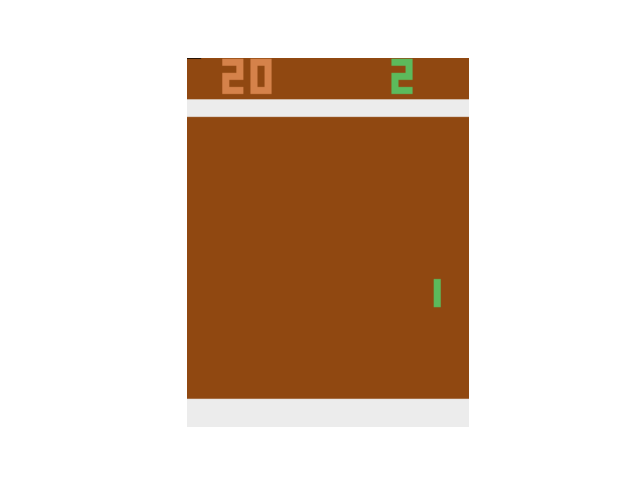
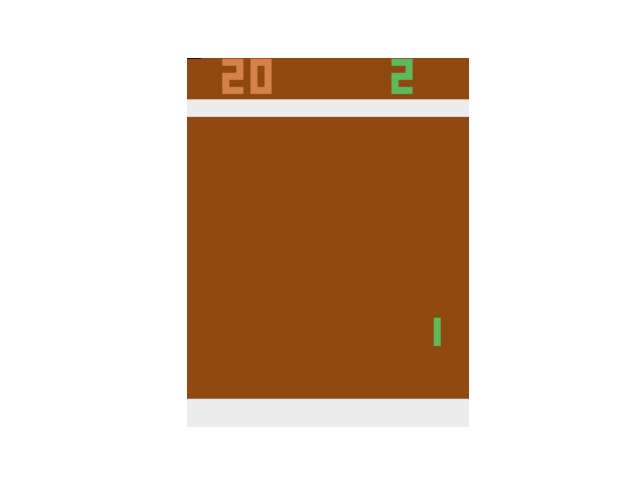
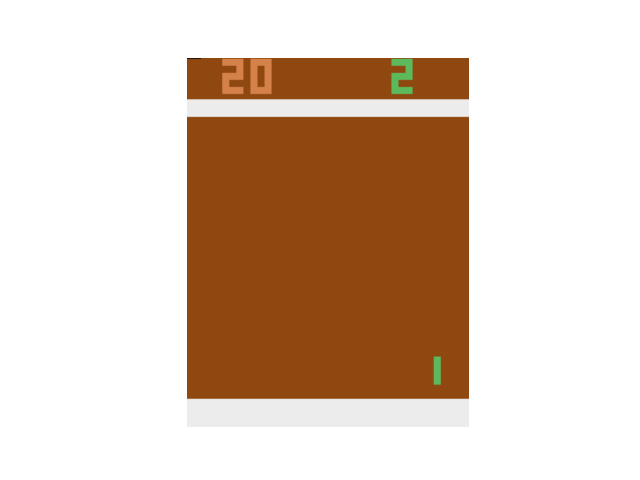
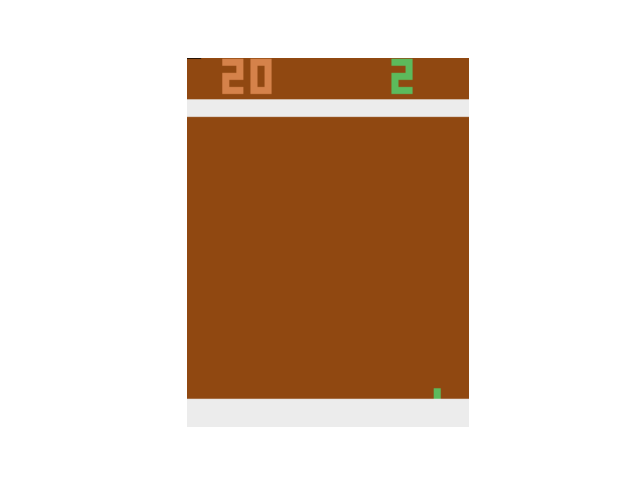
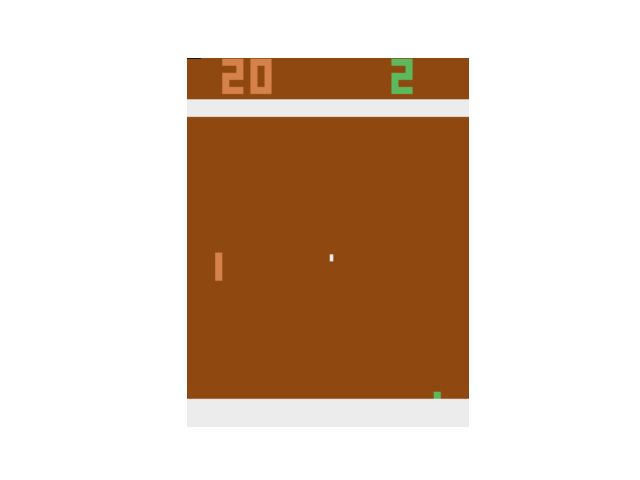
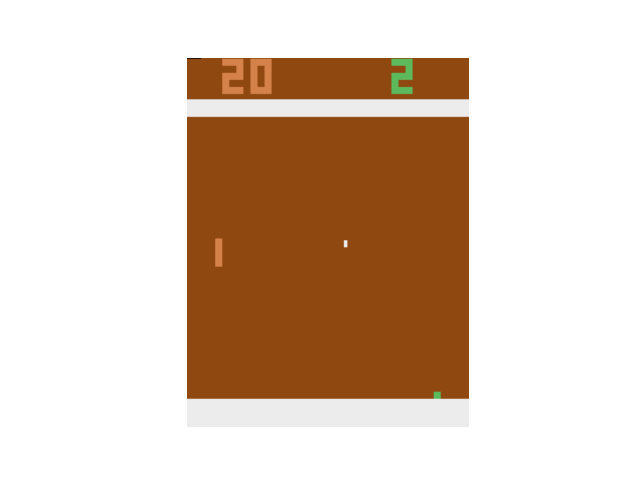
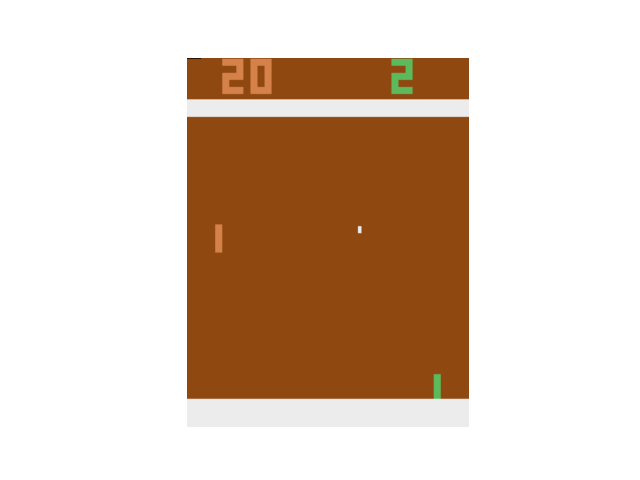
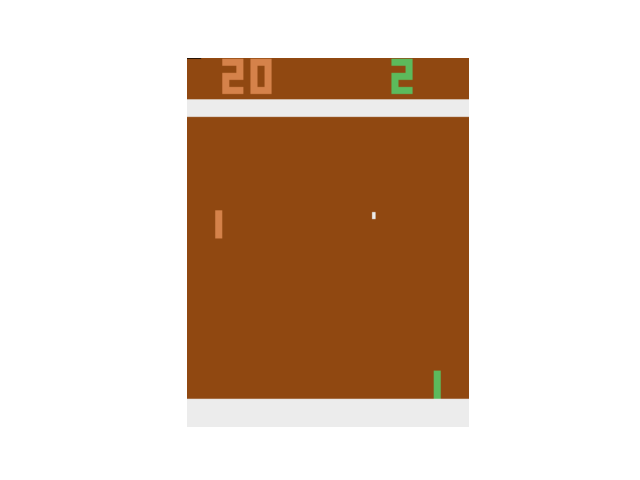
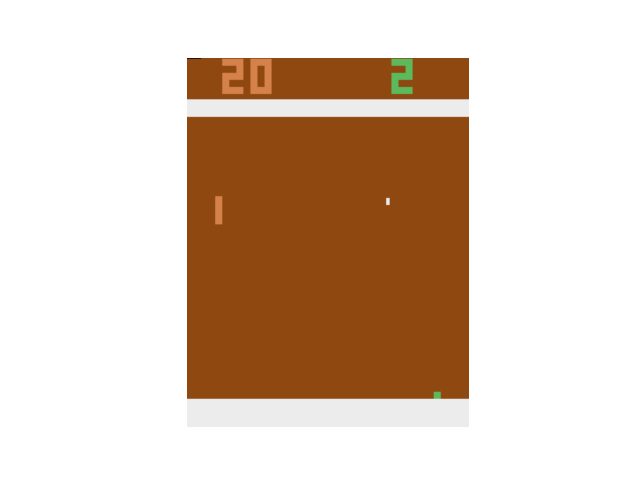
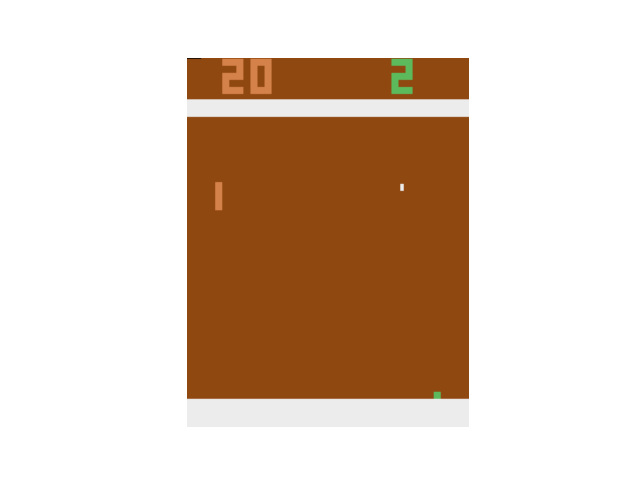
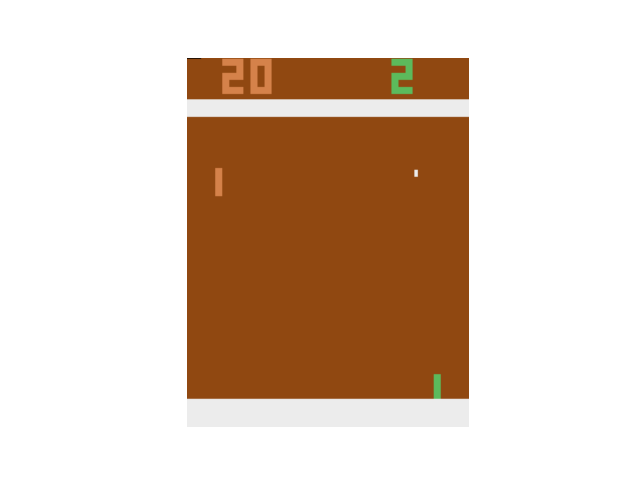
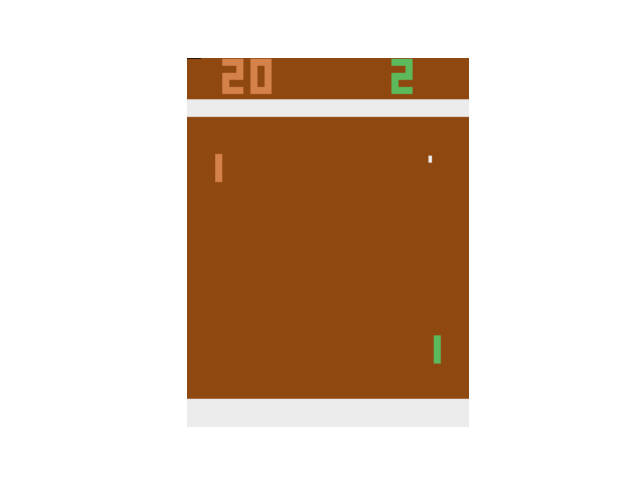
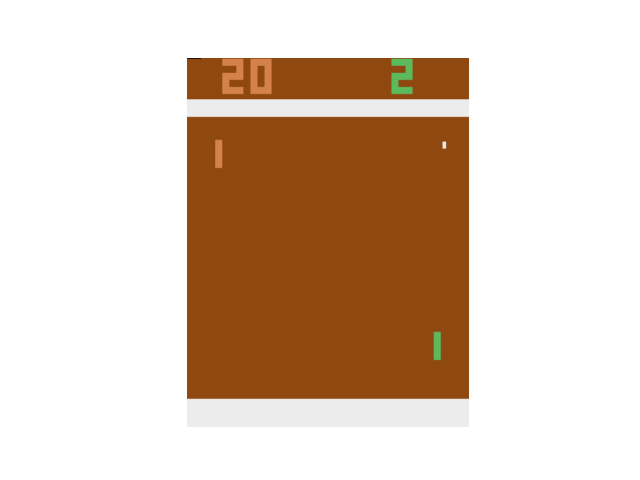
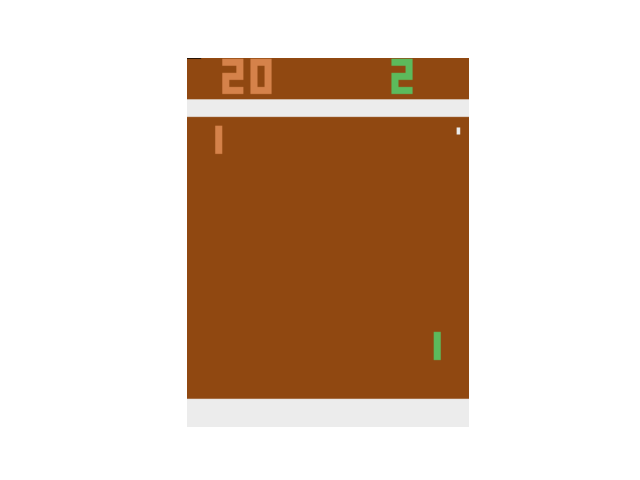
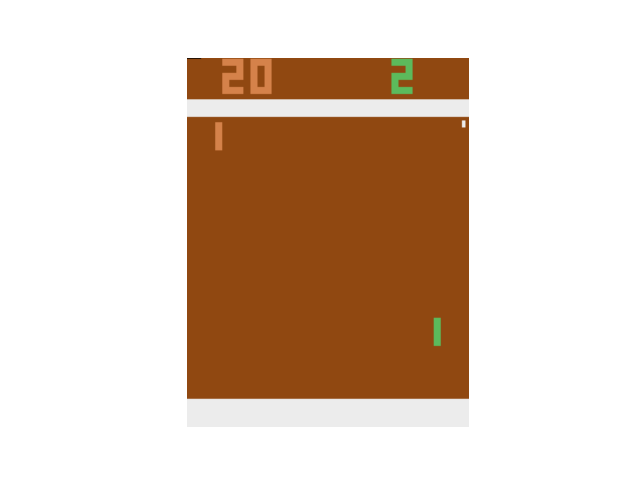

In [ ]:
%%time
pong_utils.play(env, policy, time=1000)
# pong_utils.play(env, policy, time=1000, preprocess=pong_utils.preprocess_single)
## try to add the option "preprocess=pong_utils.preprocess_single"
## to see what the agent sees

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [35]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
probs, states, actions, rewards = pong_utils.collect_trajectories(envs, policy, tmax=100)

## check the rewards dimensions
import pprint
pp = pprint.PrettyPrinter(width=100, compact=True)
print(f"length of rewards: {len(rewards)}")
print(f"shape of an element: {rewards[0].shape}") ## 4 paralle evns
pp.pprint(rewards[:10])
print()

## check the action probs dimensions
print(f"length of states: {len(states)}")
print(f"shape of an element: {states[0].shape}") ## [4, 2, 80, 80], 4 paralle envs, 2 frames, 80*80 pixels
print()

probs = pong_utils.states_to_prob(policy, states) ## forward through the neural network
print(f"shape of probs: {probs.shape}") ## [100, 4], 100 time stels, 4 paralle envs

length of rewards: 100
shape of an element: (4,)
[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]

length of states: 100
shape of an element: torch.Size([4, 2, 80, 80])

shape of probs: torch.Size([100, 4])


# Function Definitions
Here you will define key functions for training.

## Exercise 2: write your own function for training
(this is the same as policy_loss except the negative sign)

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

👉 check the video: [Importance Sampling](https://youtu.be/cYPvWriOPIk)  

In [36]:
def surrogate(policy, old_probs, states, actions, rewards,
              reward_discount=0.995,
              beta=0.01):
    ########
    ## WRITE YOUR OWN CODE HERE
    ########
    iota = 1.e-10 ## add a small number to avoid nans

    discounts = reward_discount ** np.arange(len(rewards))
    discounted_rewards = np.array(rewards) * discounts[:, np.newaxis]
    future_rewards = discounted_rewards[::-1].cumsum(axis=0)[::-1]
    normalized_rewards = (future_rewards - future_rewards.mean(axis=1)[:, np.newaxis]) \
        / (future_rewards.std(axis=1)[:, np.newaxis] + iota)

    ## prepare tensors
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    normalized_rewards = torch.tensor(normalized_rewards, dtype=torch.float, device=device)

    ## forward through the neural network, convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions==pong_utils.RIGHT, new_probs, 1.0-new_probs)
    ratio = new_probs / old_probs

    ## include a regularization term that steers new_policy towards 0.5
    ## which prevents policy to become exactly 0 or 1, thus helps with exploration
    entropy = -(new_probs * torch.log(old_probs+iota) + \
        (1.0-new_probs) * torch.log(1.0-old_probs+iota))

    return torch.mean(normalized_rewards*ratio + beta*entropy)

# L_surr = pong_utils.surrogate(policy, probs, states, actions, rewards) ## solution function
L_surr = surrogate(policy, probs, states, actions, rewards)
print(L_surr)

# **Training**   
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [ ]:
%%time
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from parallelEnv import parallelEnv
import numpy as np

## WARNING: running through all 800 episodes will take 30-45 minutes
# training loop max iterations
# episode = 10 ## 10 episodes on cpu took Wall time: 1min 44s
episode = 800

# widget bar to display progress
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ',
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
beta = .01
tmax = 320

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)

    total_rewards = np.sum(rewards, axis=0)

    ## this is the SOLUTION!
    L = -pong_utils.surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    ## use your own surrogate function
    # L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L

    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995

    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))

    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)

    # update progress widget bar
    timer.update(e+1)

timer.finish()

Episode: 20, score: -14.000000
[-15. -17. -15. -14. -13. -13. -16.  -9.]


Episode: 40, score: -14.000000
[-15. -13. -16. -16. -16. -10. -10. -16.]


Episode: 60, score: -13.375000
[-16. -16.  -7. -13. -15. -11. -16. -13.]


Episode: 80, score: -14.125000
[-16. -13. -11. -16. -16. -10. -15. -16.]


Episode: 100, score: -14.875000
[-15. -12. -15. -16. -16. -16. -16. -13.]


Episode: 120, score: -15.125000
[-14. -16. -16. -13. -17. -13. -16. -16.]


Episode: 140, score: -14.000000
[-11. -15. -13. -16. -16. -15. -10. -16.]


Episode: 160, score: -14.500000
[-12. -12. -15. -16. -16. -15. -14. -16.]


Episode: 180, score: -14.125000
[-15. -13. -13. -14. -16. -13. -15. -14.]


Episode: 200, score: -15.500000
[-16. -13. -16. -15. -16. -16. -16. -16.]


Episode: 220, score: -12.875000
[-12. -16. -10. -16. -12. -14. -10. -13.]


Episode: 240, score: -13.125000
[-15. -12. -11. -10. -16. -16. -11. -14.]


Episode: 260, score: -14.375000
[-14. -14. -16. -16. -15. -15. -13. -12.]


Episode: 280, score: -14.375000
[-14. -12. -16. -15. -15. -16. -16. -11.]


Episode: 300, score: -12.875000
[-14. -11. -10.  -9. -16. -16. -15. -12.]


Episode: 320, score: -13.250000
[-15. -12. -11. -11. -15. -12. -14. -16.]


Episode: 340, score: -14.250000
[-16. -16. -11. -16. -15. -14. -13. -13.]


Episode: 360, score: -14.500000
[-16.  -9. -16. -16. -16. -14. -16. -13.]


Episode: 380, score: -11.750000
[-11. -16. -16. -14. -16.  -9.  -7.  -5.]


Episode: 400, score: -15.000000
[-16. -14. -16. -15. -16. -17. -12. -14.]


Episode: 420, score: -14.000000
[-11. -14. -12. -16. -16. -13. -16. -14.]


Episode: 440, score: -14.125000
[-16. -13. -16.  -9. -14. -14. -15. -16.]


Episode: 460, score: -13.375000
[-16. -14.  -9. -15.  -9. -14. -15. -15.]


Episode: 480, score: -14.500000
[-13. -13. -16. -15. -16. -15. -12. -16.]


Episode: 500, score: -13.250000
[-14.  -9. -15. -15. -16.  -9. -16. -12.]


Episode: 520, score: -13.750000
[-15.  -9. -14. -14. -16. -15. -14. -13.]


Episode: 540, score: -13.000000
[-13. -13. -14. -14. -13. -14.  -9. -14.]


Episode: 560, score: -11.375000
[-12. -12.  -8.  -9. -13. -11. -16. -10.]


Episode: 580, score: -12.500000
[-11. -10. -15. -14. -13. -15. -10. -12.]


Episode: 600, score: -11.375000
[-15.  -8. -13. -13. -13.  -9.  -7. -13.]


Episode: 620, score: -12.500000
[-14. -10. -13. -10. -16. -13. -11. -13.]


Episode: 640, score: -11.250000
[-11.  -8. -15. -13. -11. -10. -13.  -9.]


Episode: 660, score: -11.875000
[ -6. -12. -13. -12.  -8. -12. -16. -16.]


Episode: 680, score: -11.375000
[-12. -14. -12.  -7. -12. -12. -14.  -8.]


Episode: 700, score: -10.000000
[-13. -10.  -9. -14.  -7.  -6. -13.  -8.]


Episode: 720, score: -9.125000
[ -7.  -8. -12.  -9. -12. -10.  -4. -11.]


Episode: 740, score: -8.875000
[ -6.  -5. -14. -11.  -7. -11.  -7. -10.]


Episode: 760, score: -7.000000
[ -6.  -8.  -5. -11. -10.  -8.  -6.  -2.]


Episode: 780, score: -7.500000
[-10.  -6.  -5.  -4. -10.  -8. -11.  -6.]


Episode: 800, score: -5.000000
[-8. -2. -2. -5. -8. -4. -4. -7.]
CPU times: user 29min 59s, sys: 2min 10s, total: 32min 10s
Wall time: 1h 17min 44s


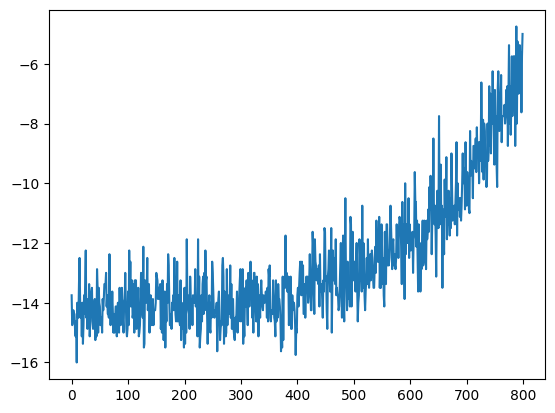

In [ ]:
plt.plot(mean_rewards);

# **Display Training Result**

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):



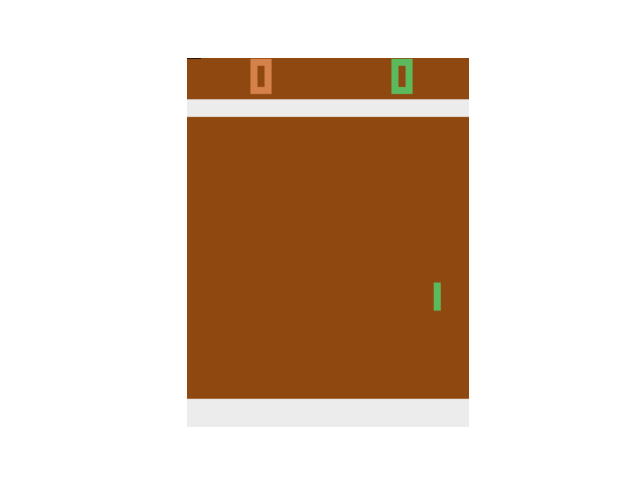
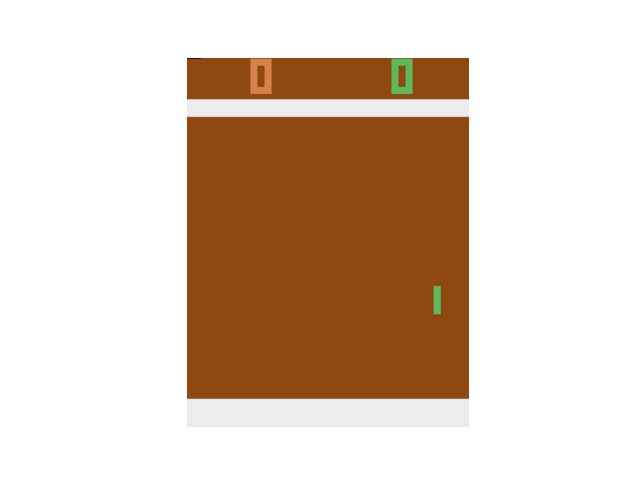
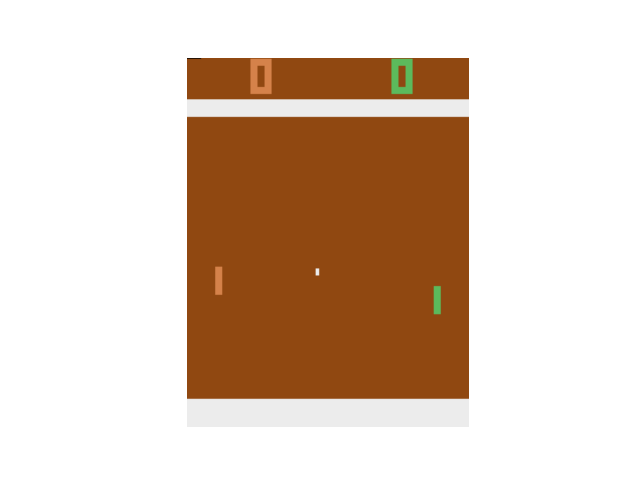
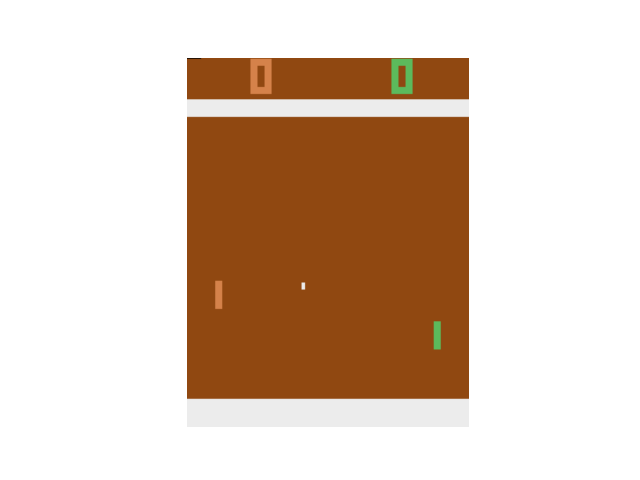
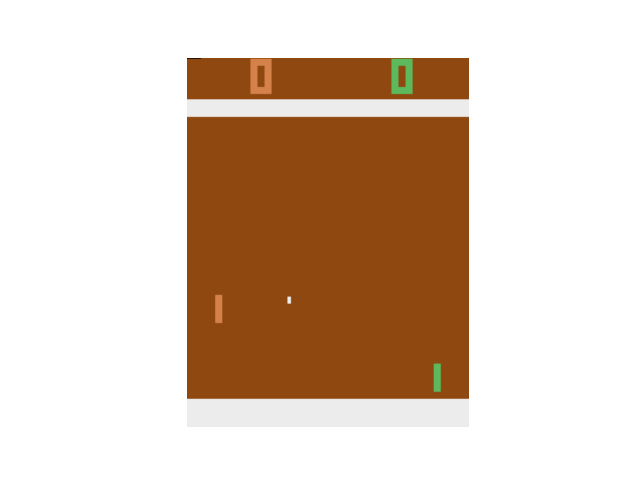
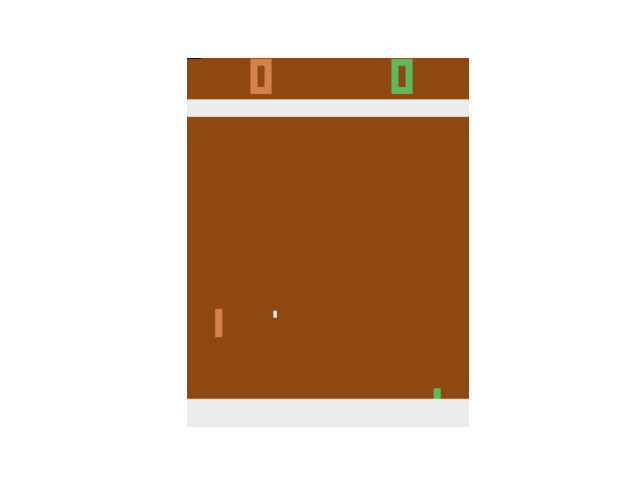
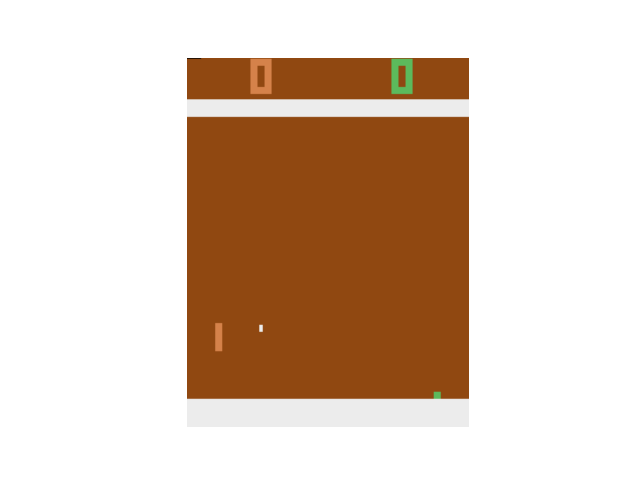
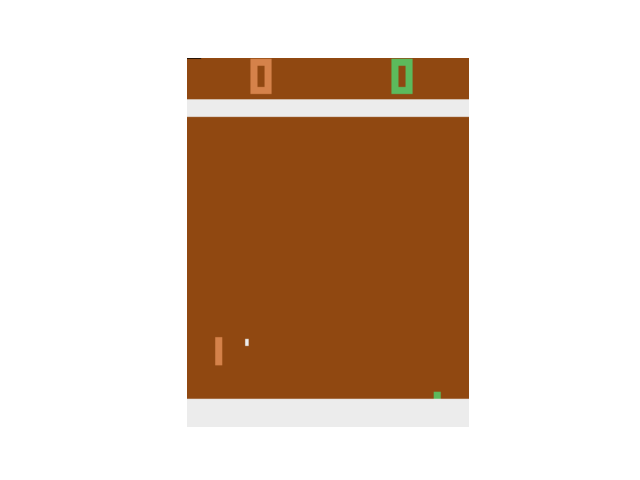
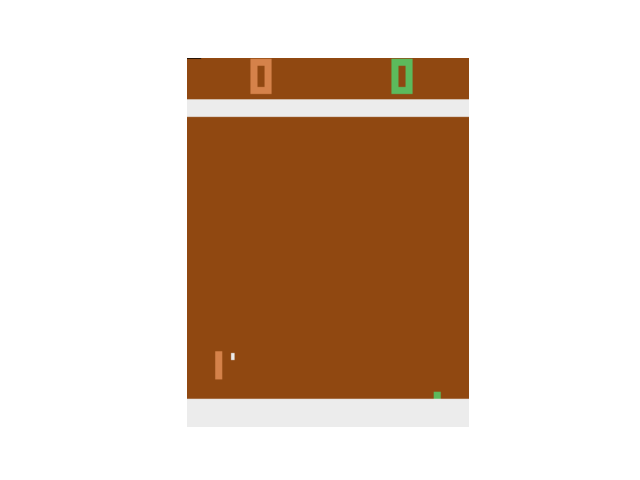
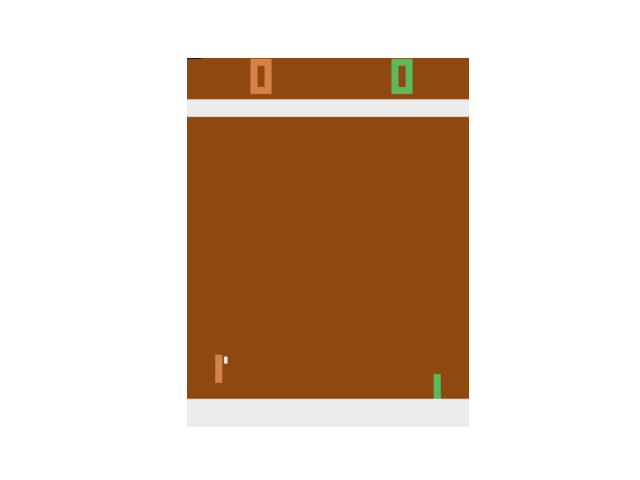
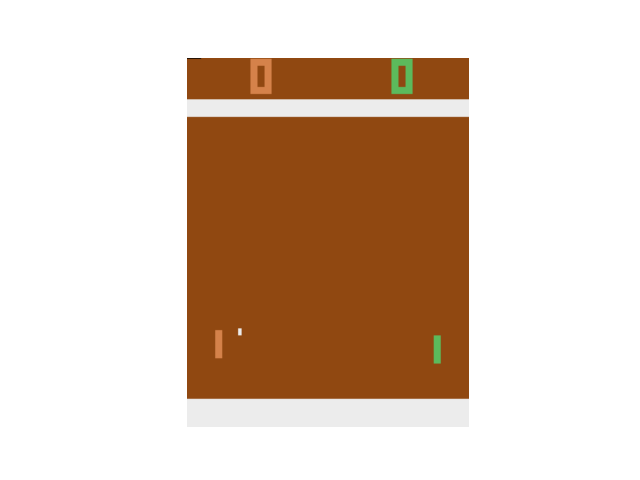
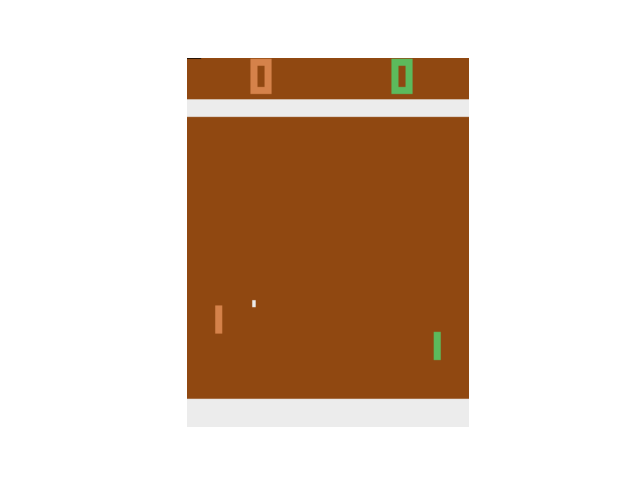
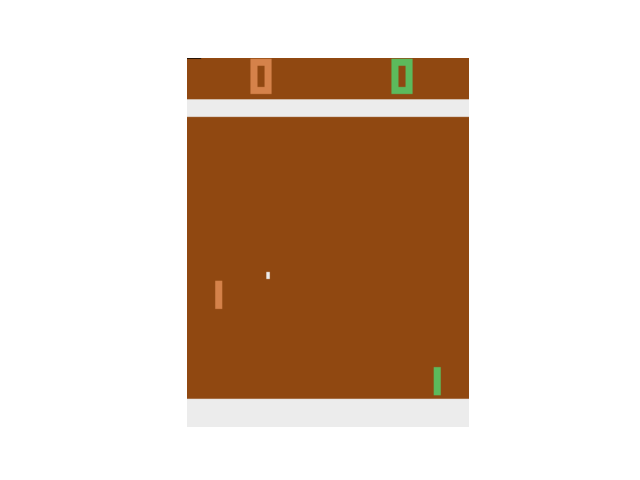
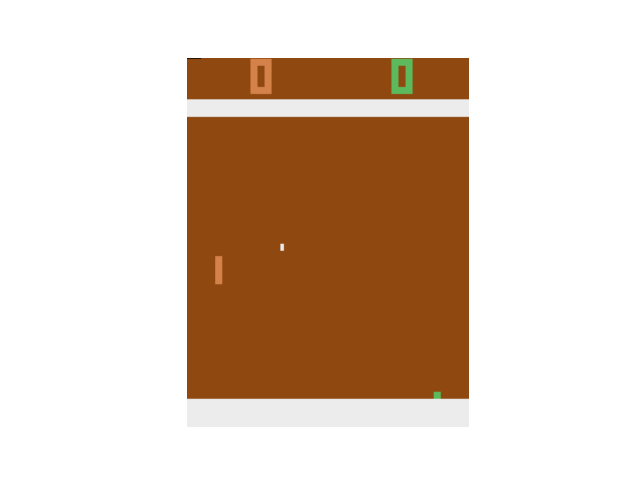
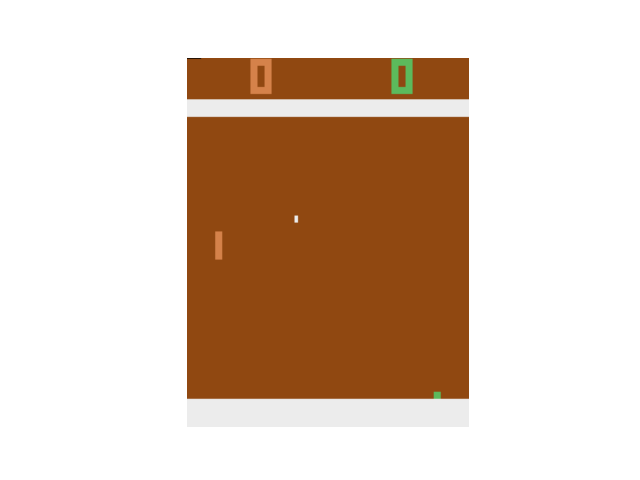
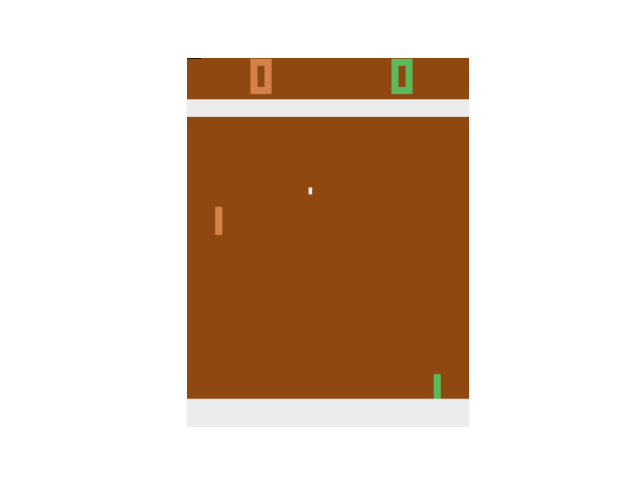
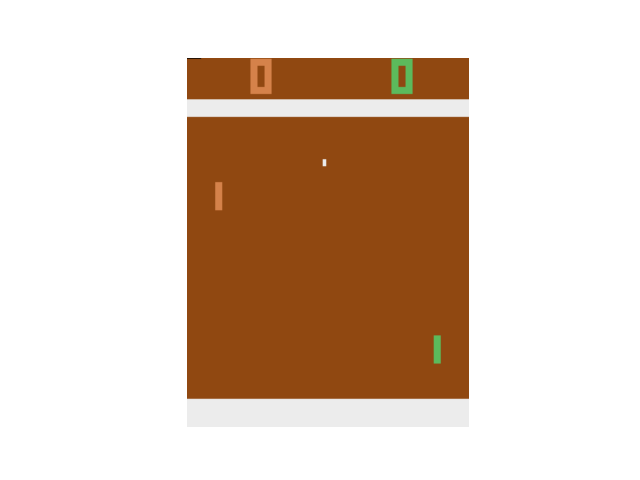
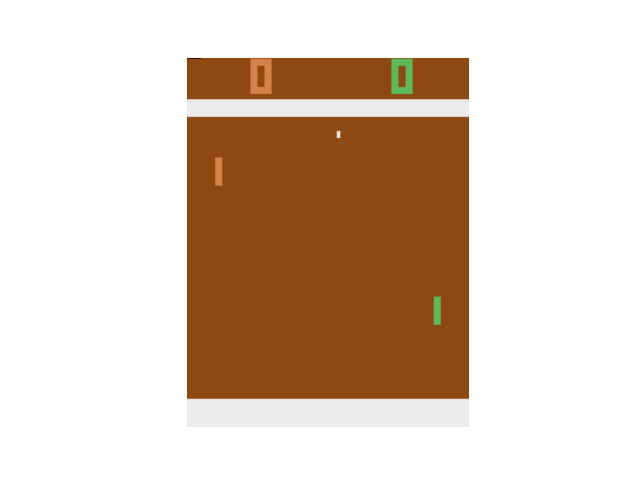
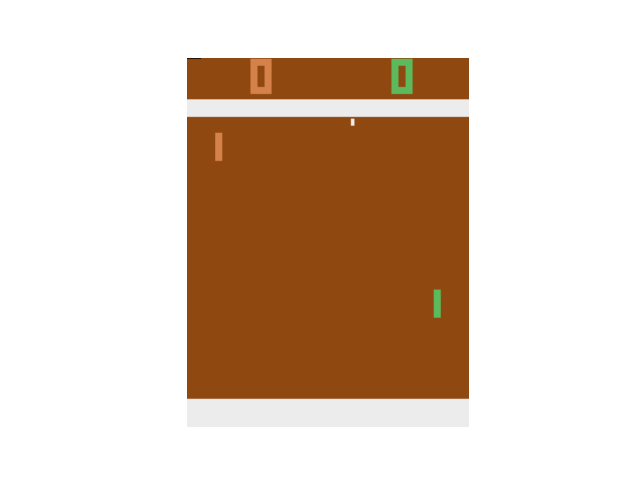
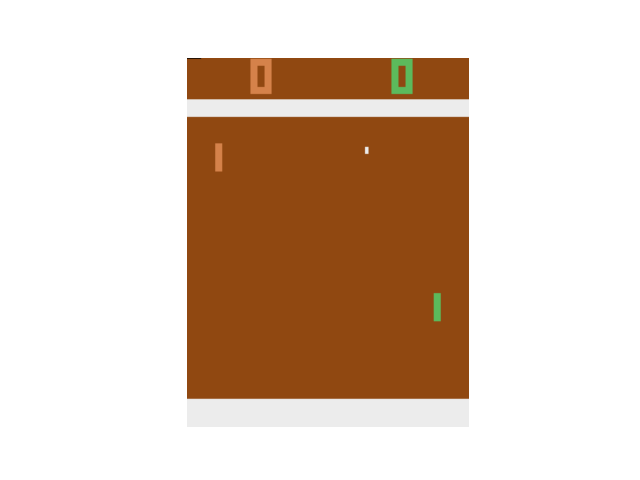
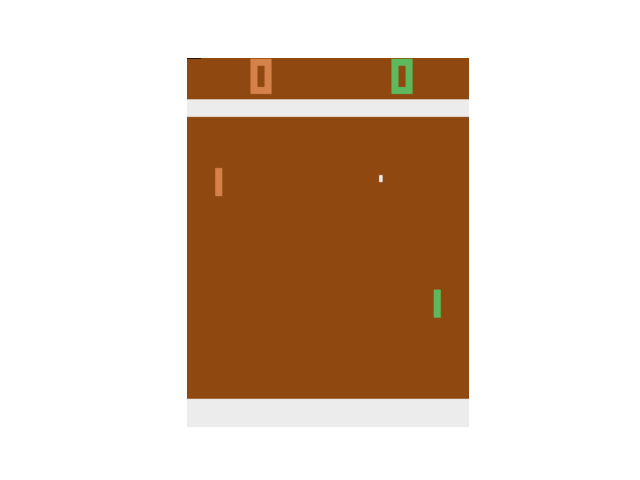
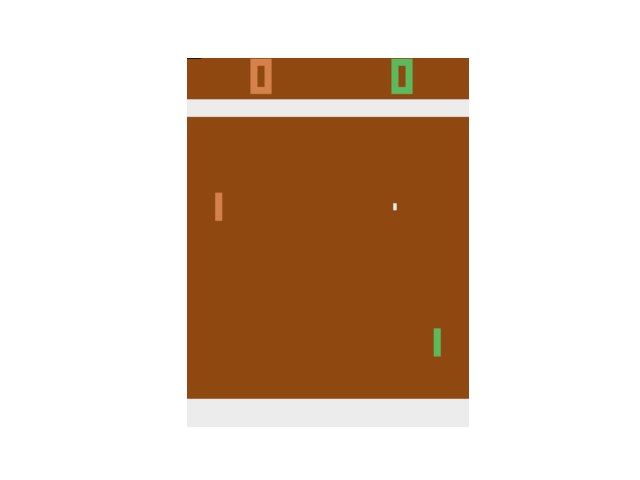
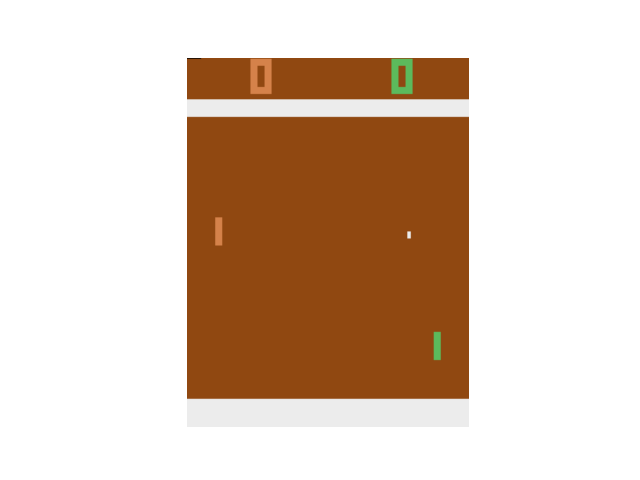
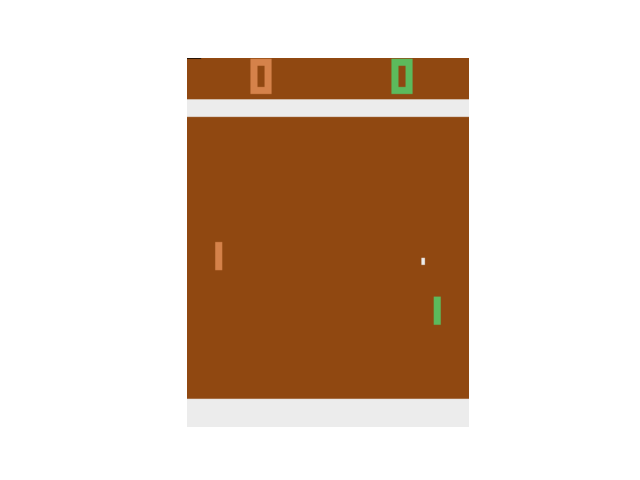
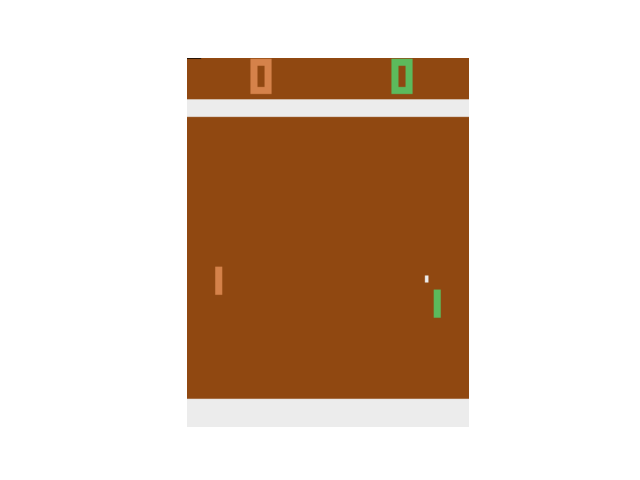
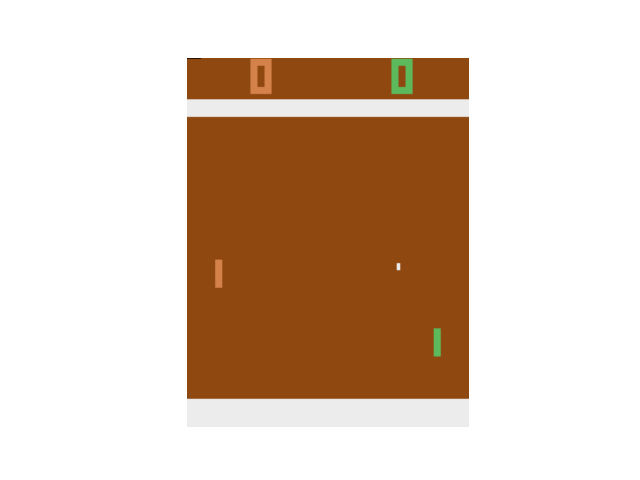
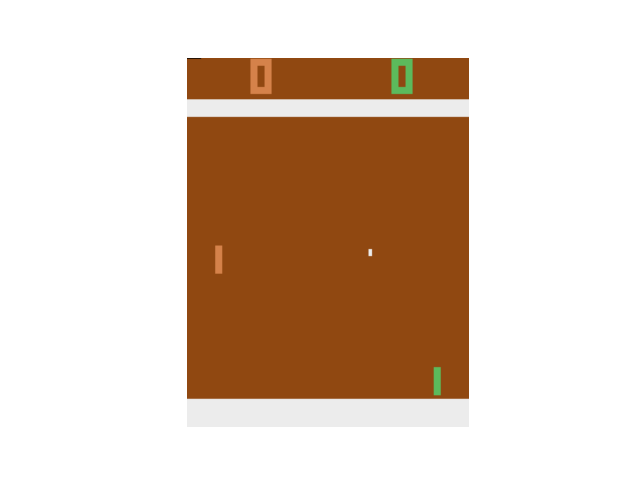
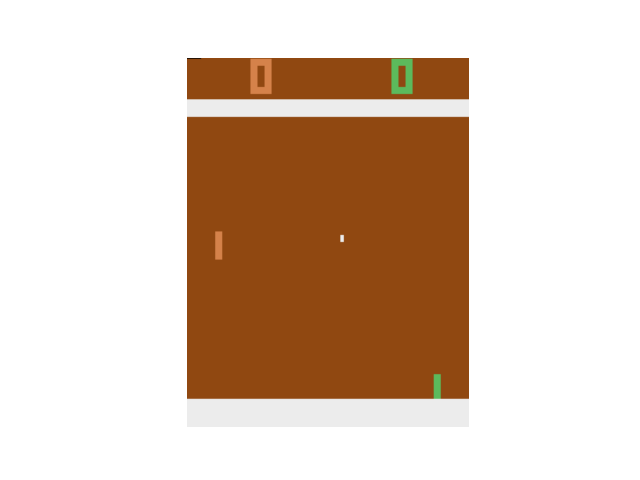
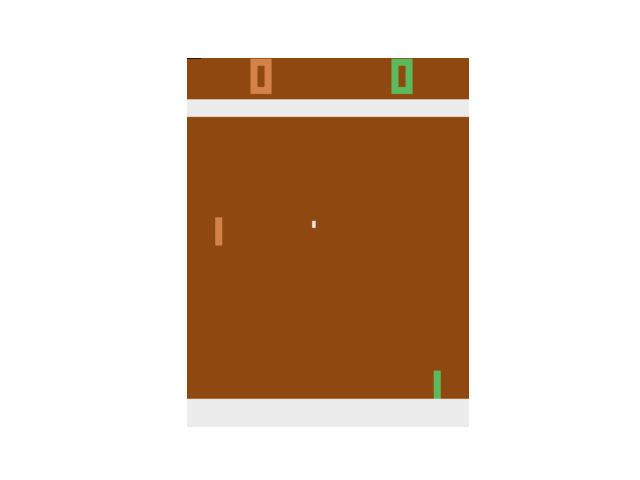
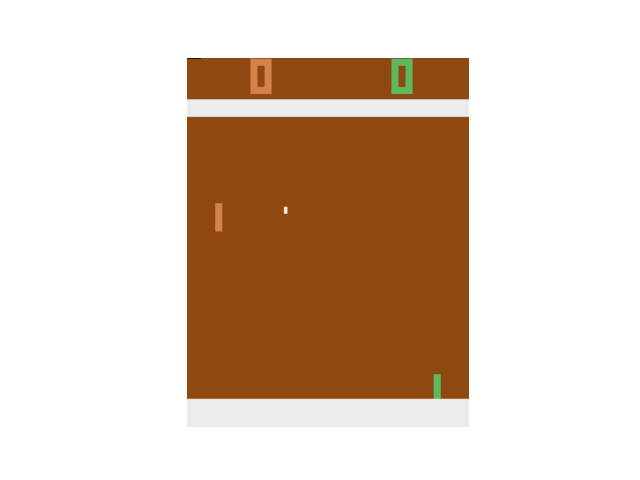
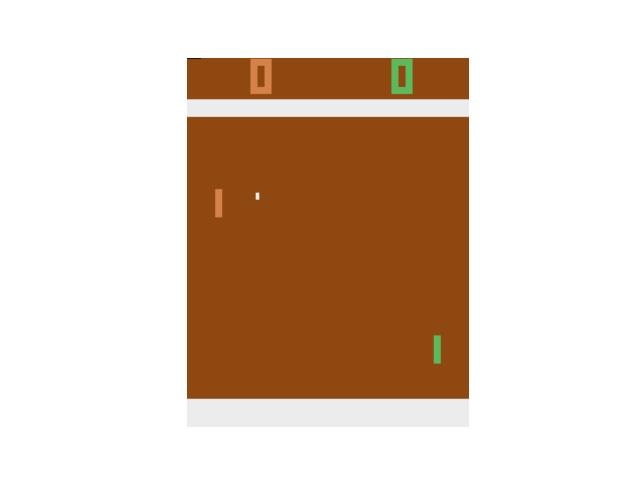
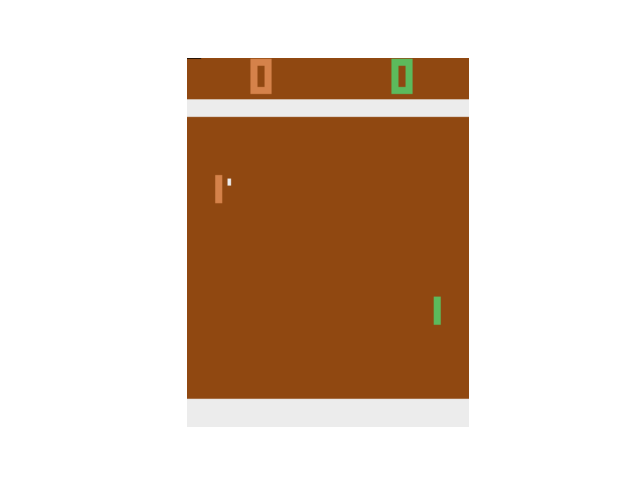
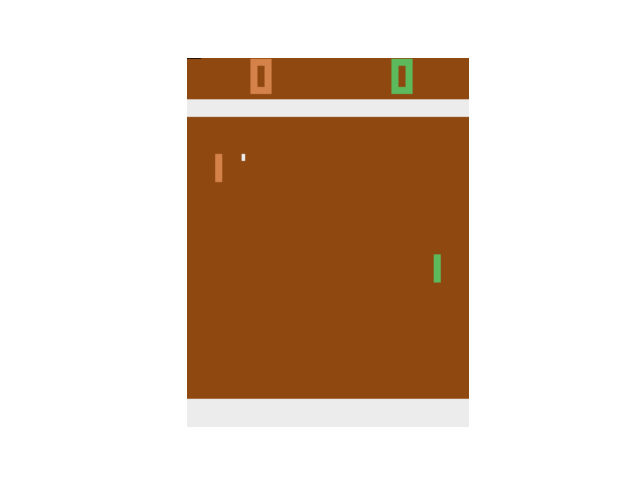
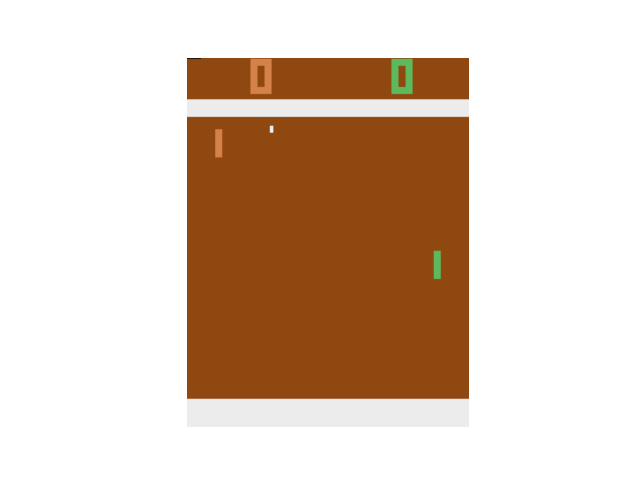
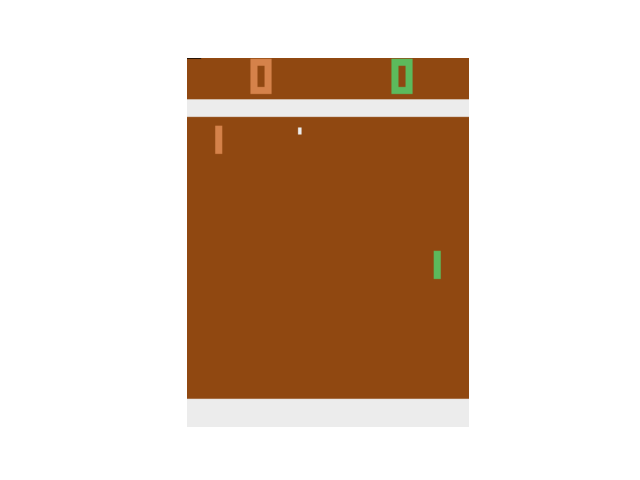
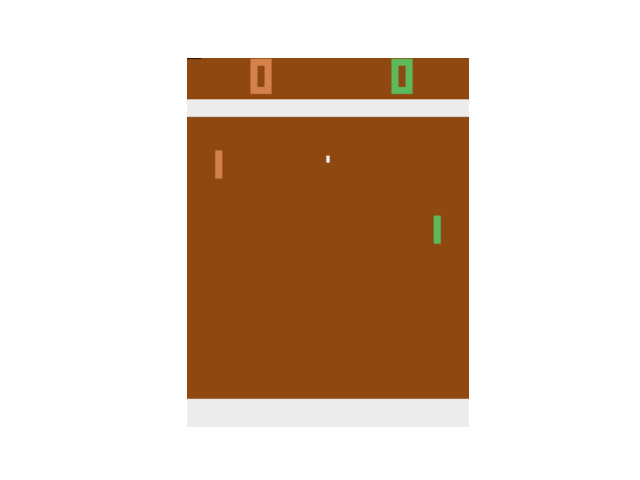
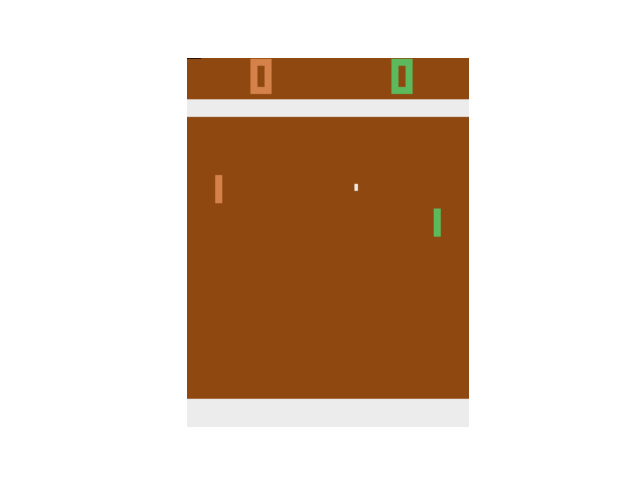
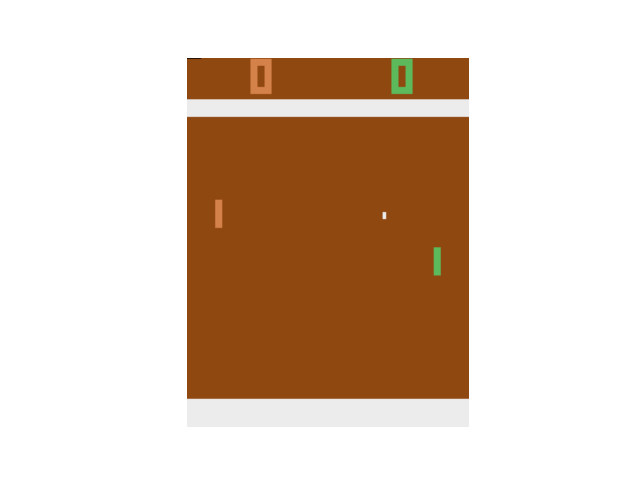
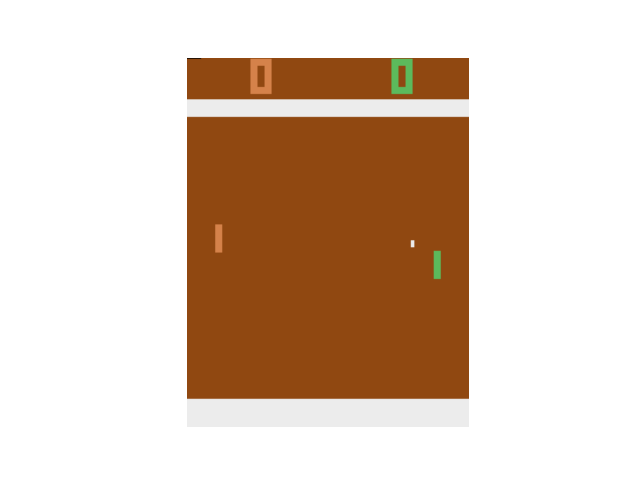
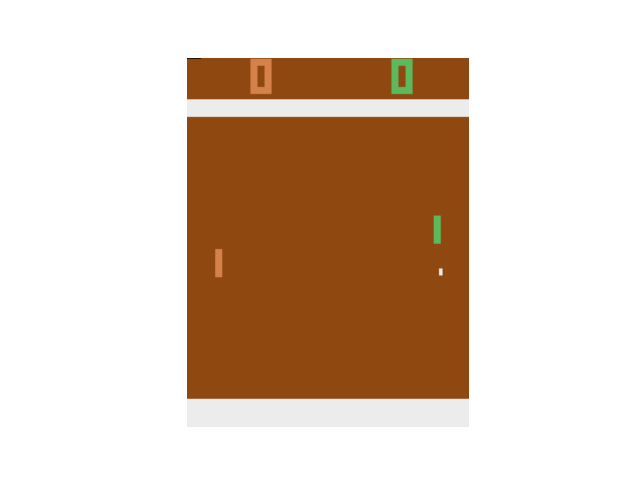
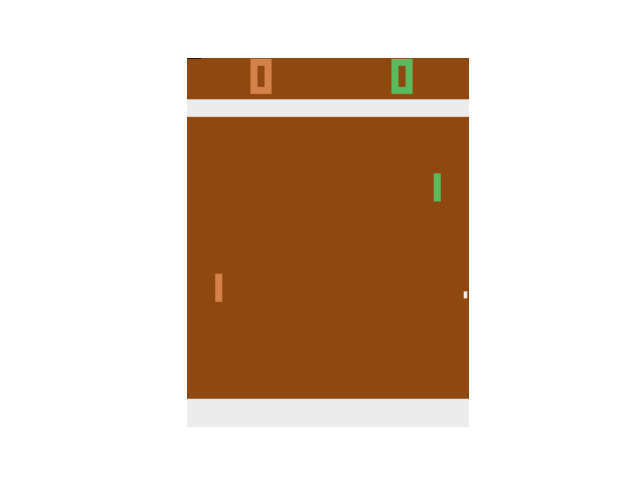
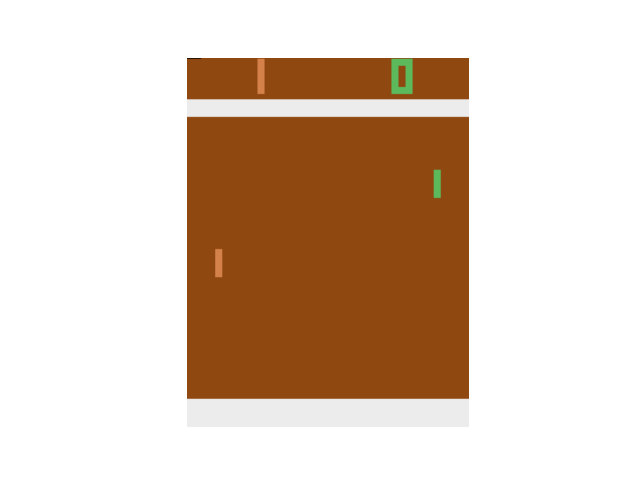
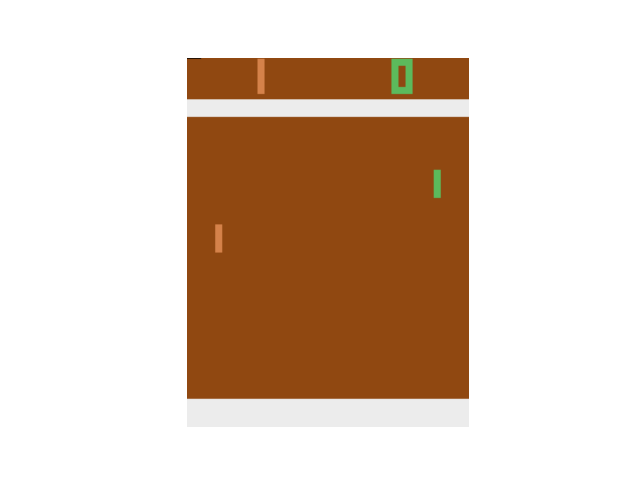
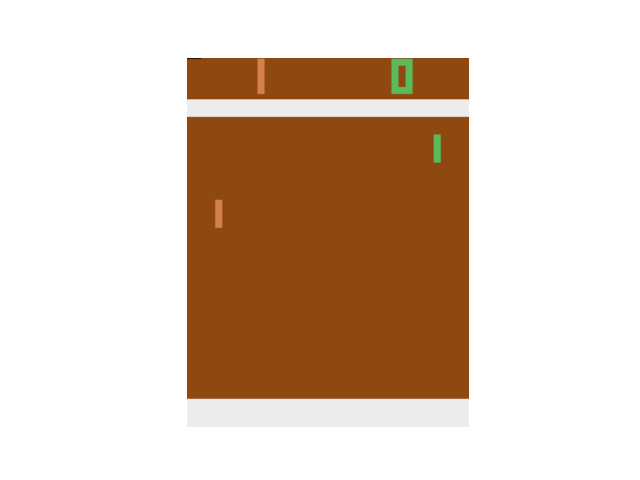
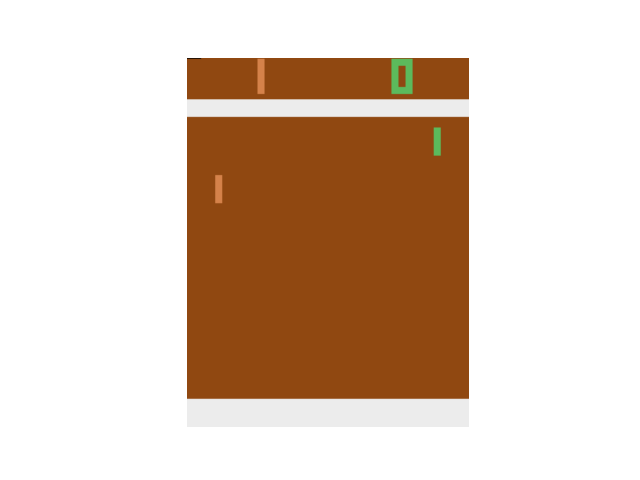
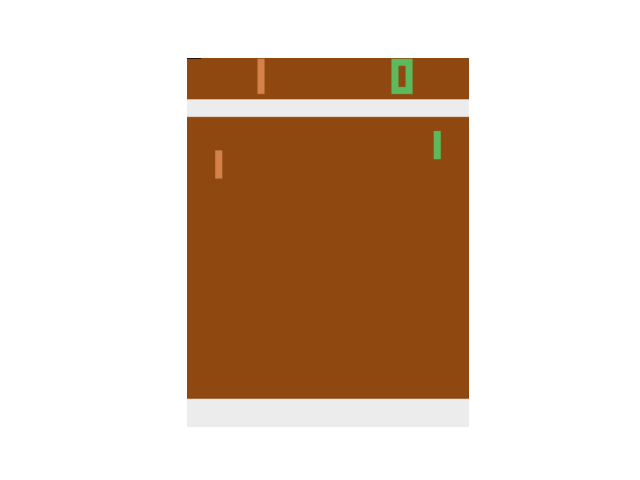
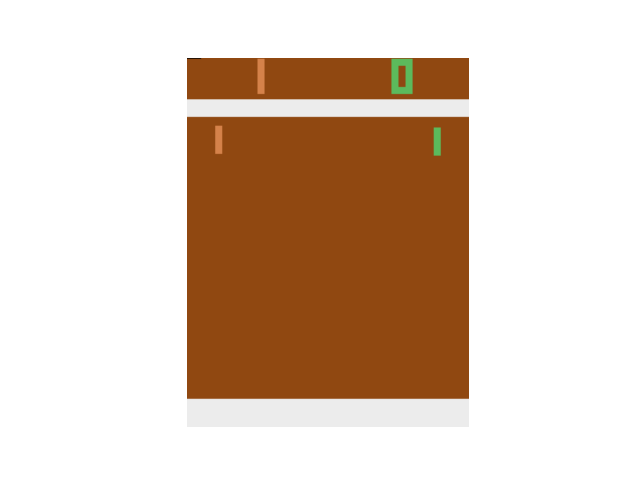
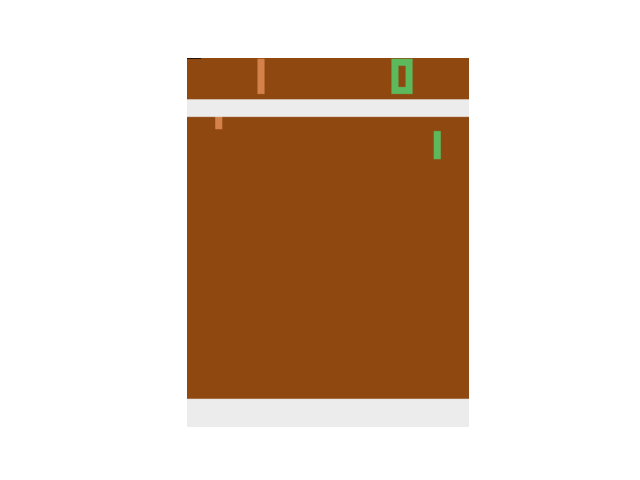
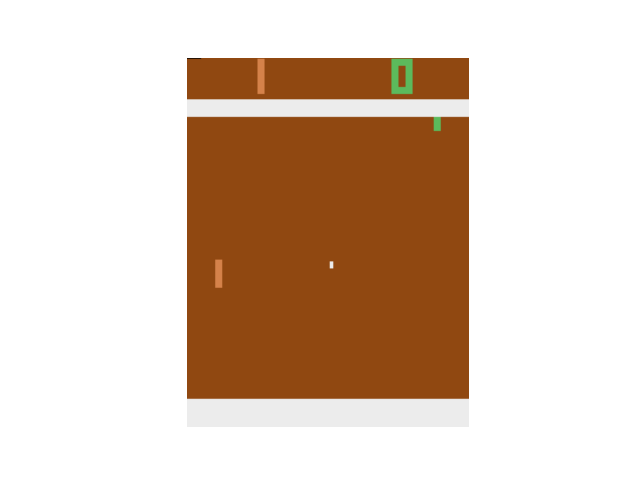
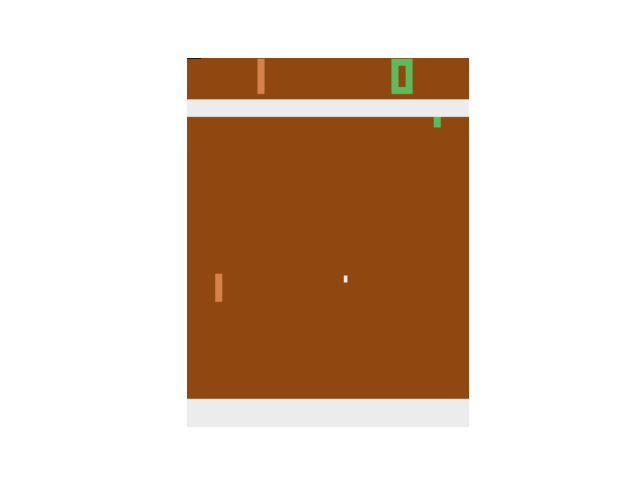
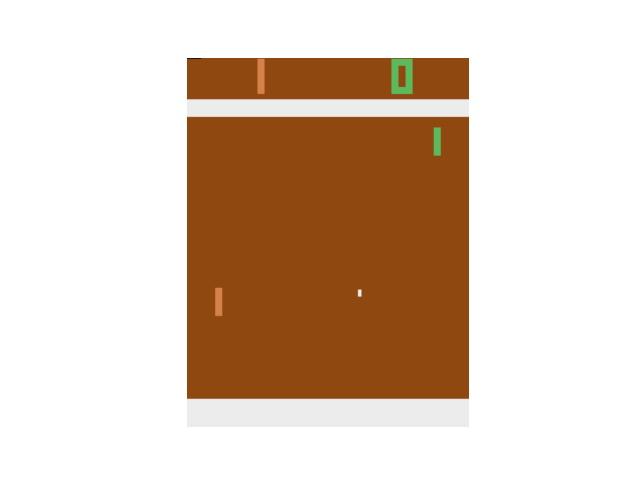
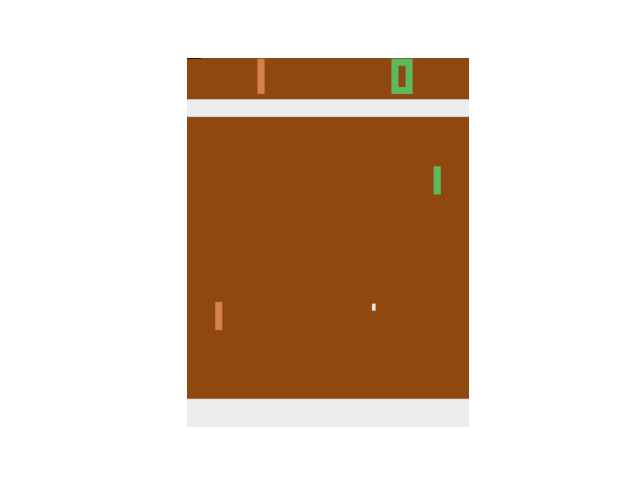
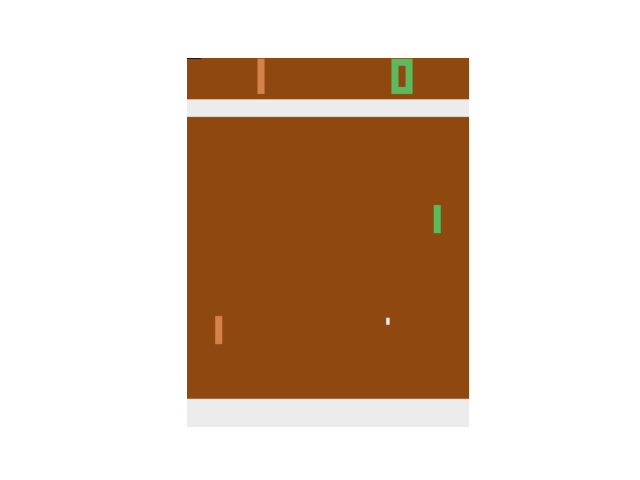
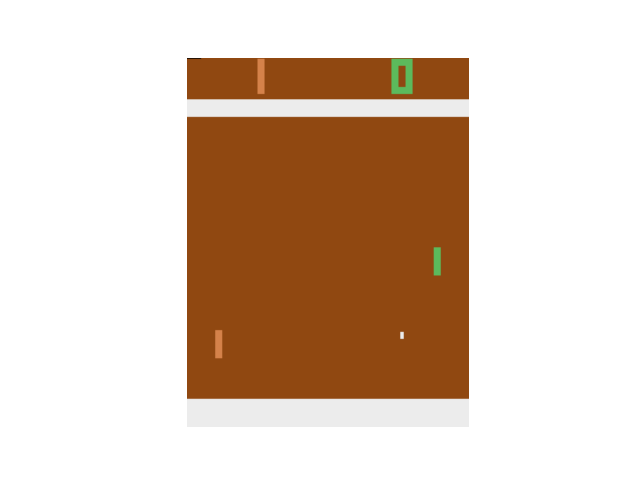
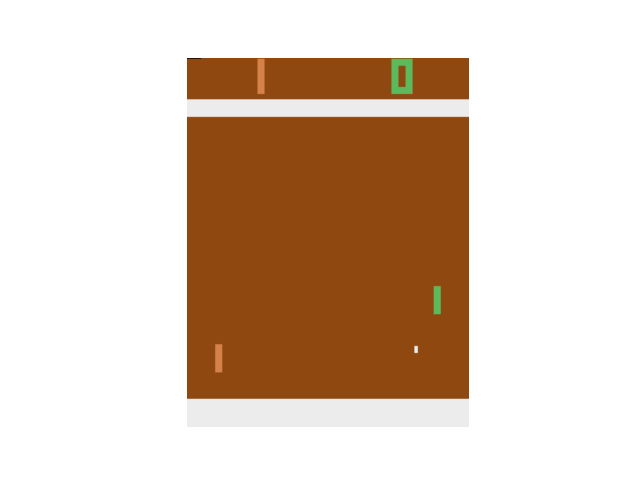
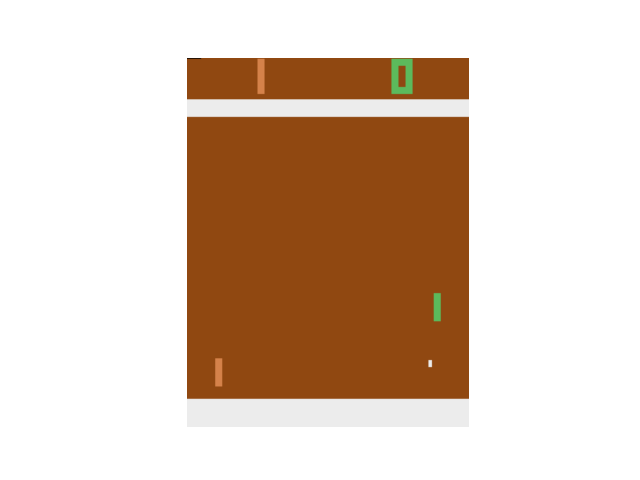
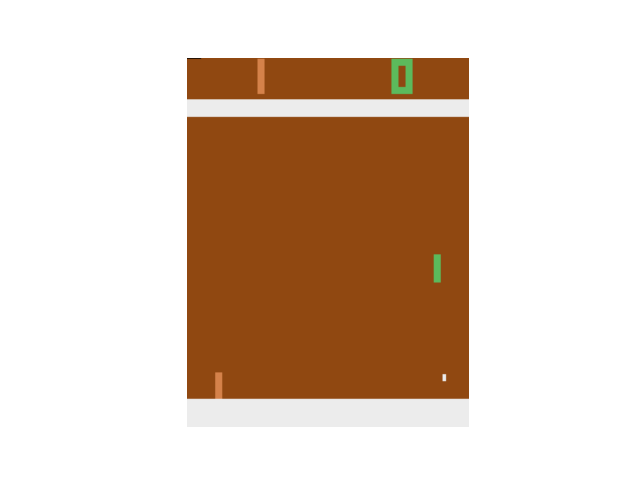
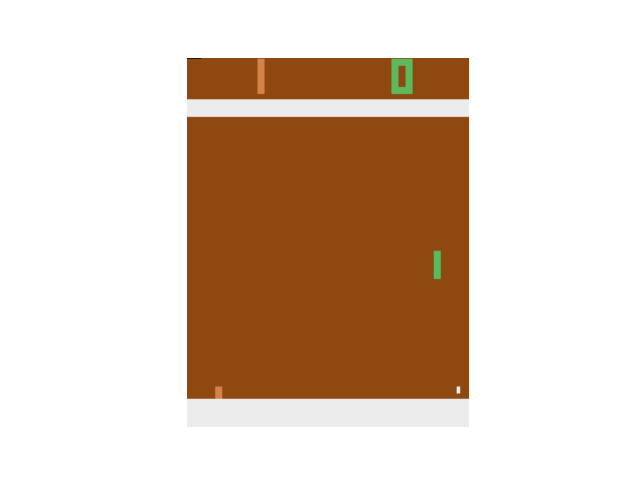
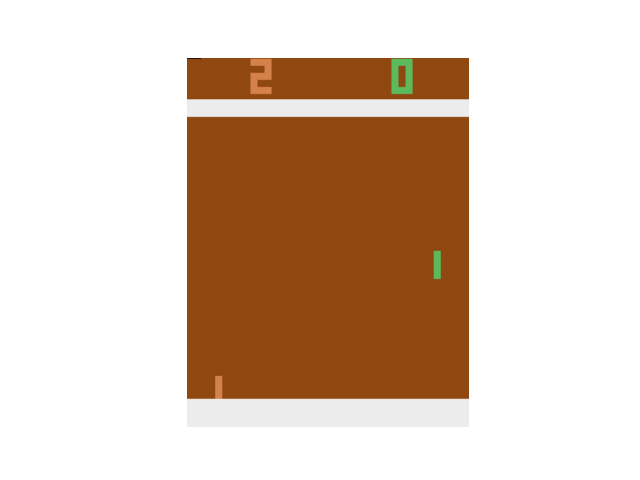
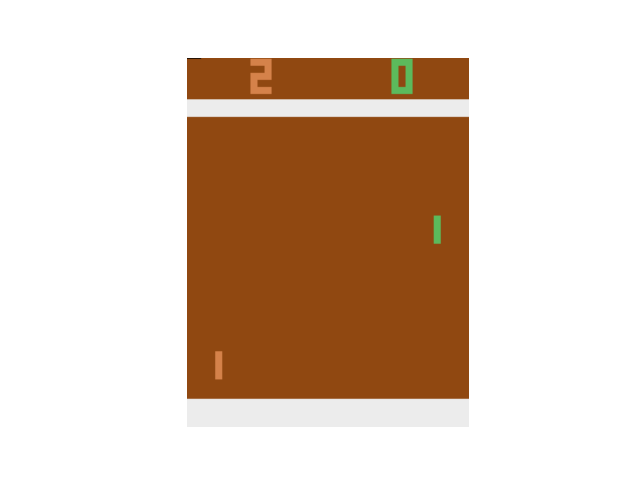
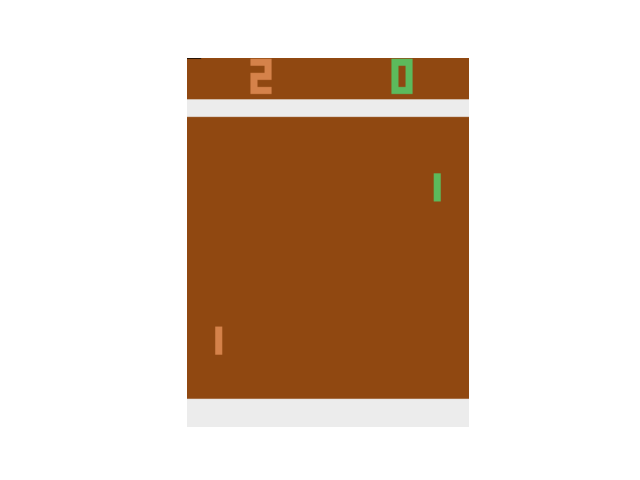
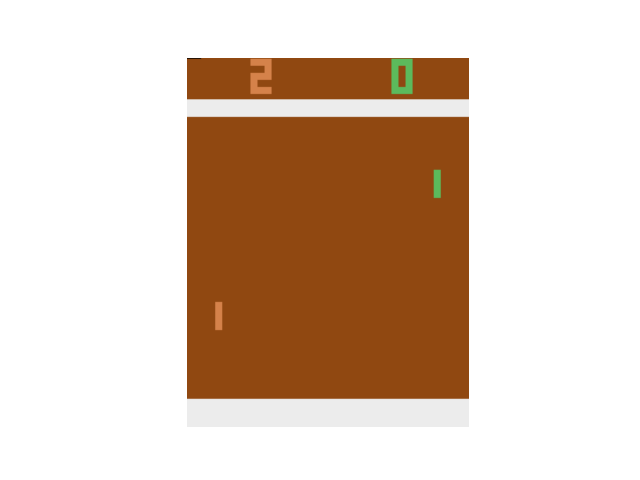
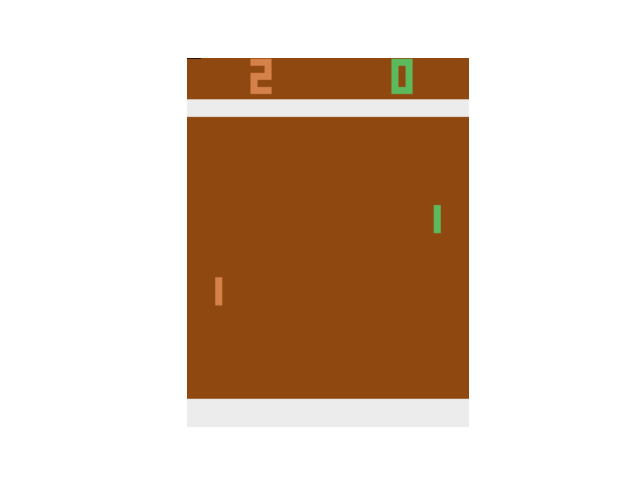
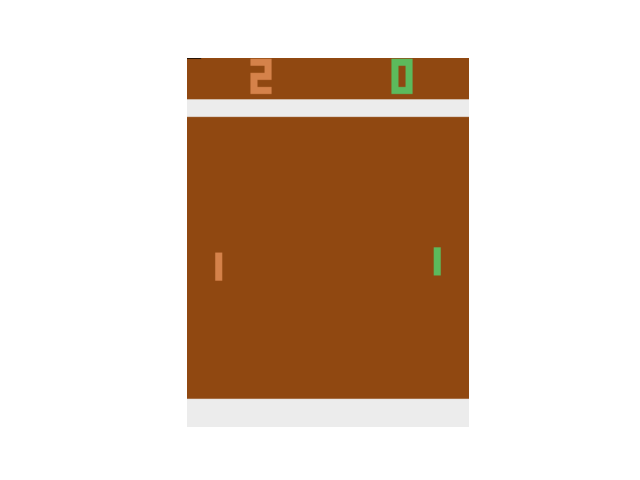
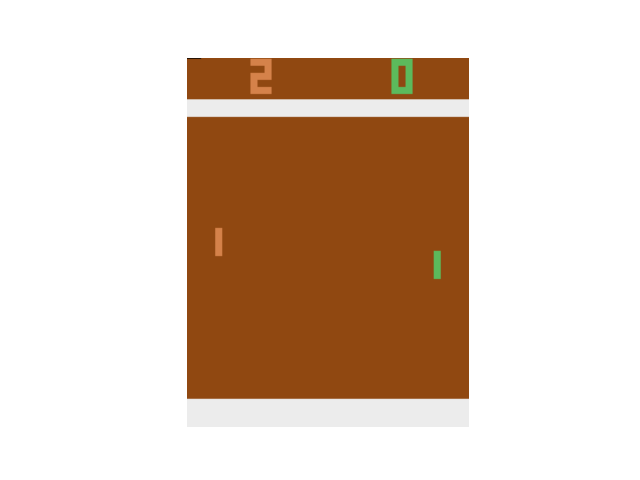
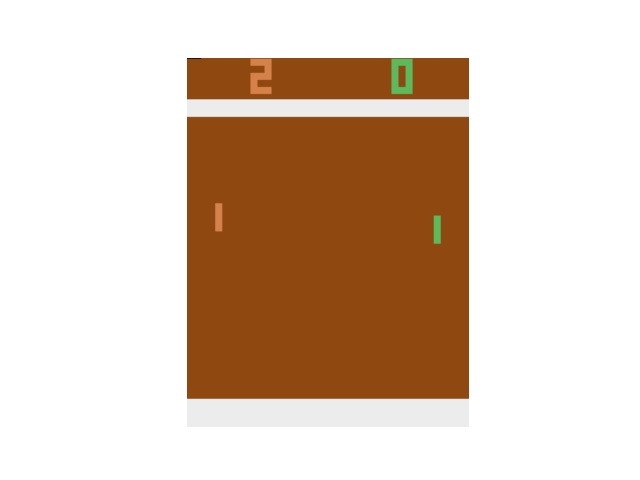
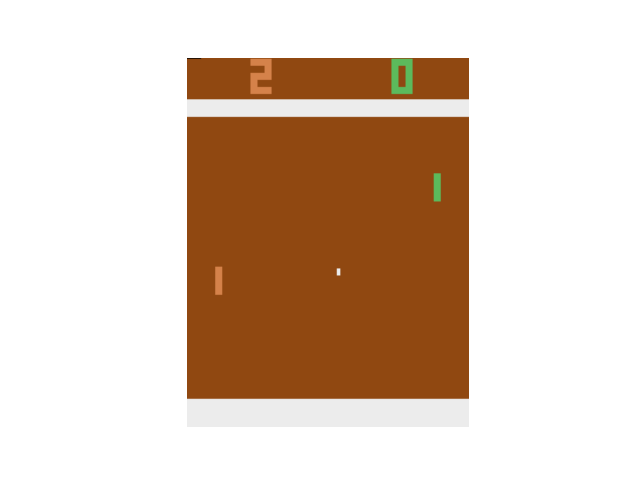
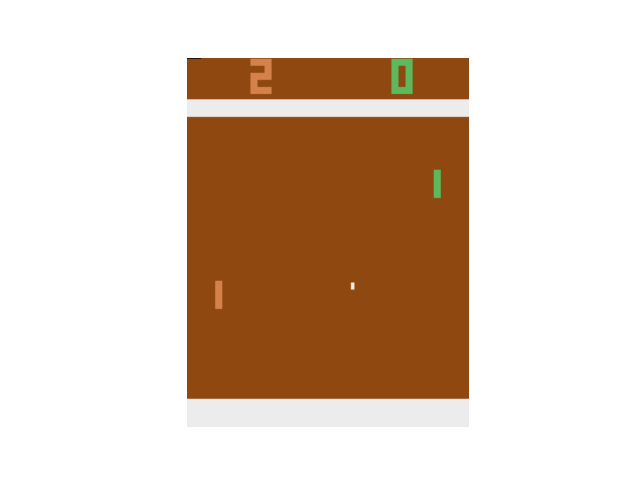
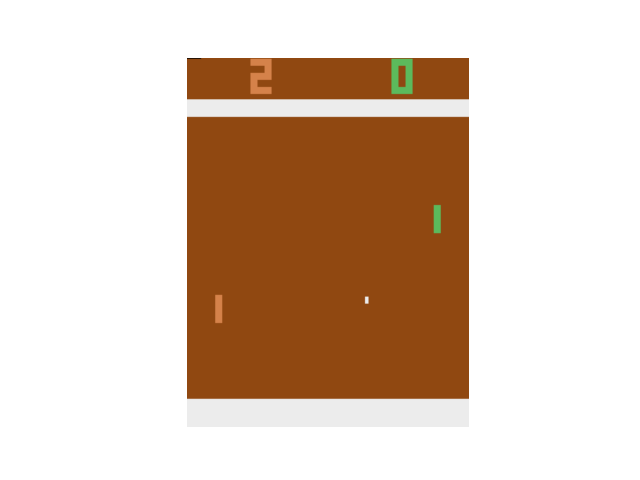
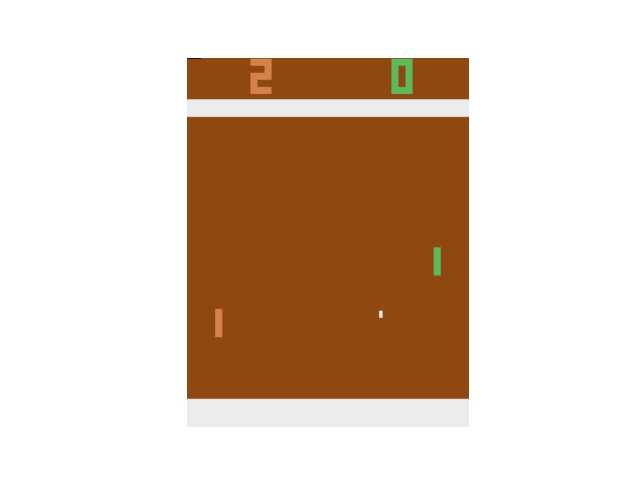
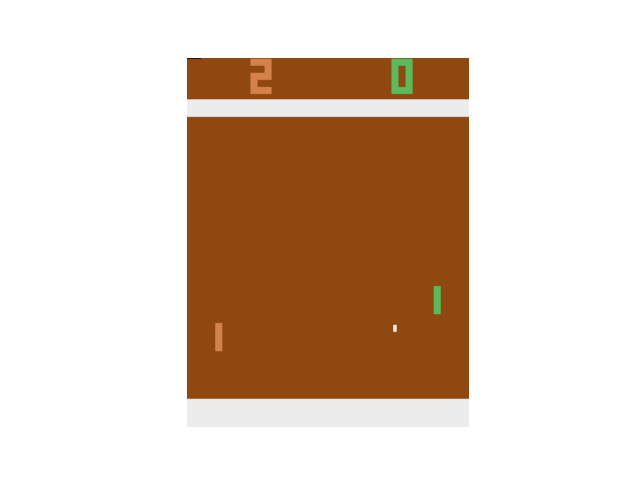
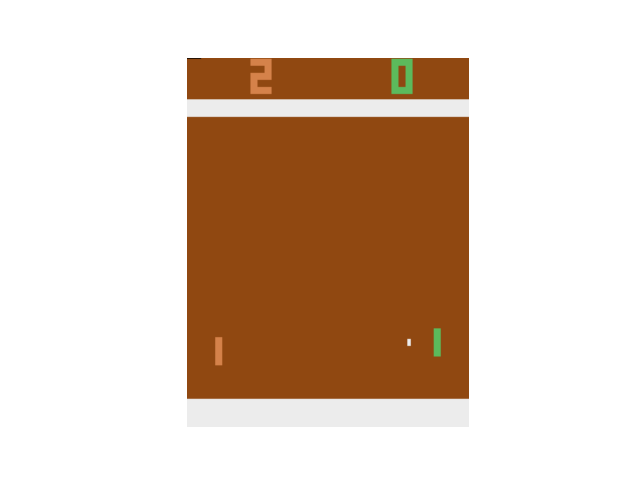
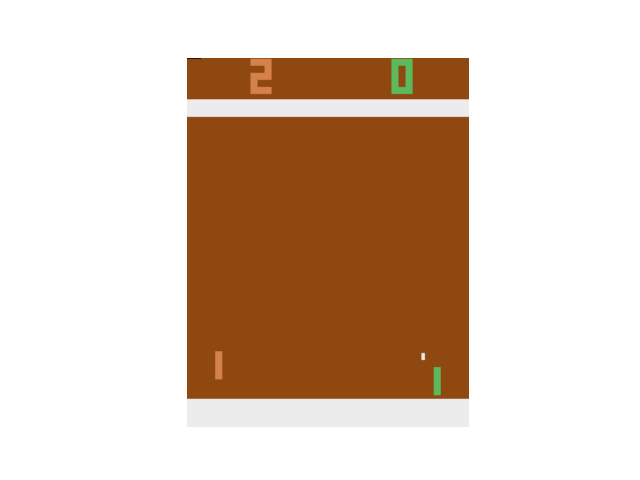
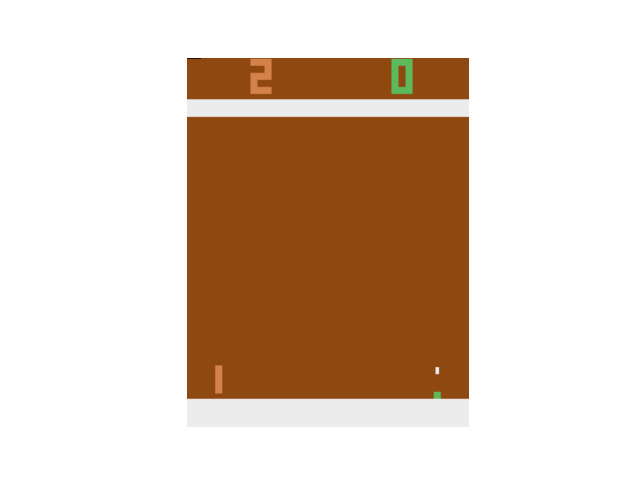
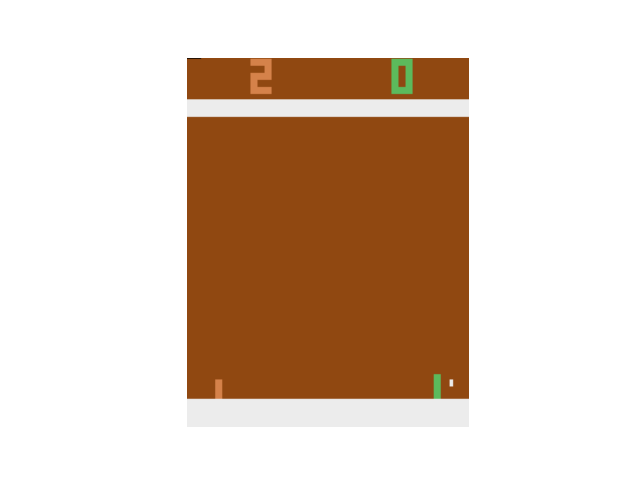
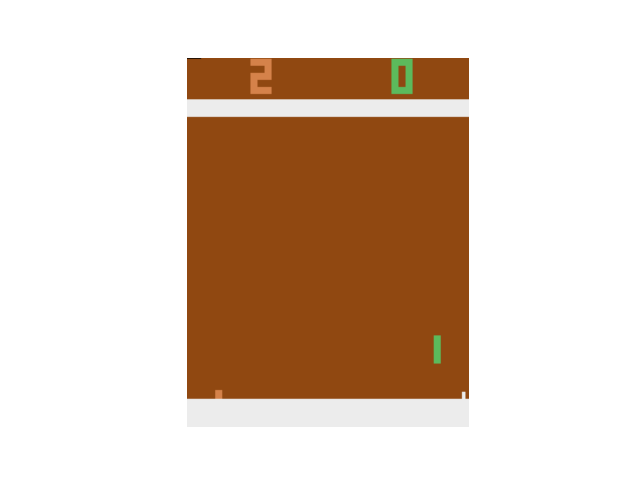
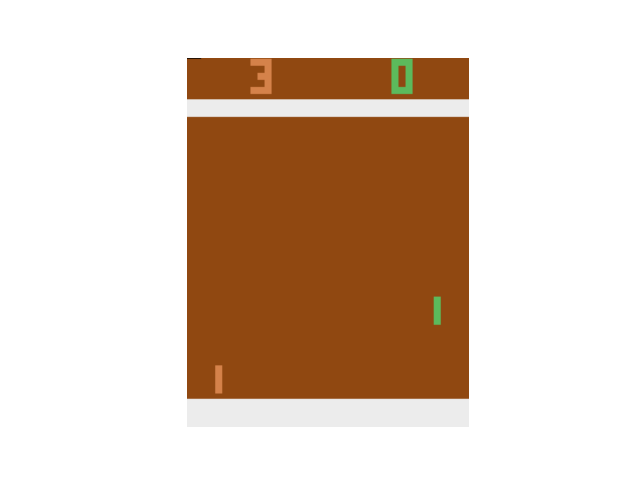
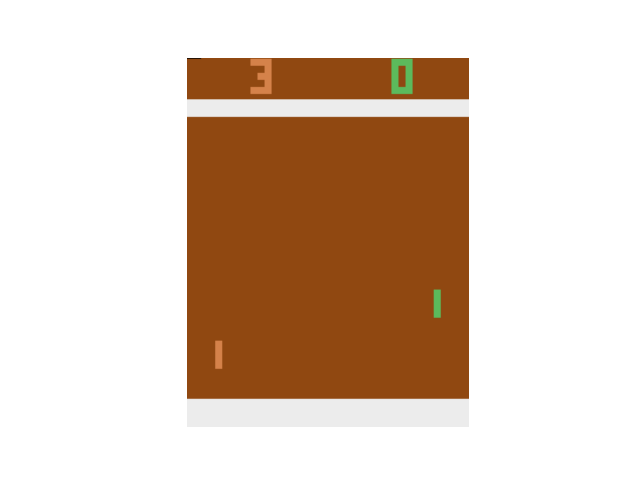
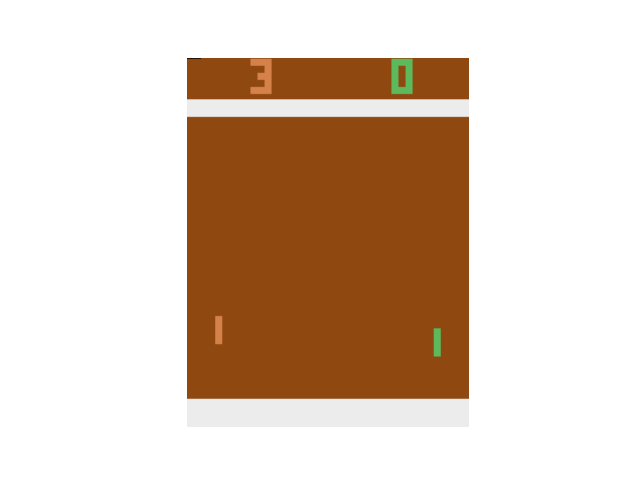
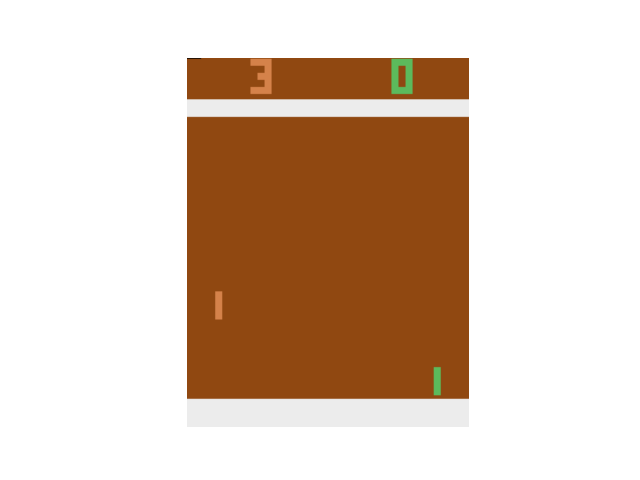
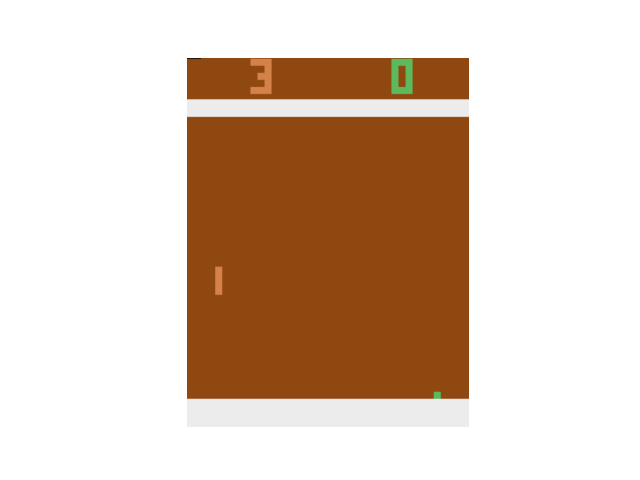
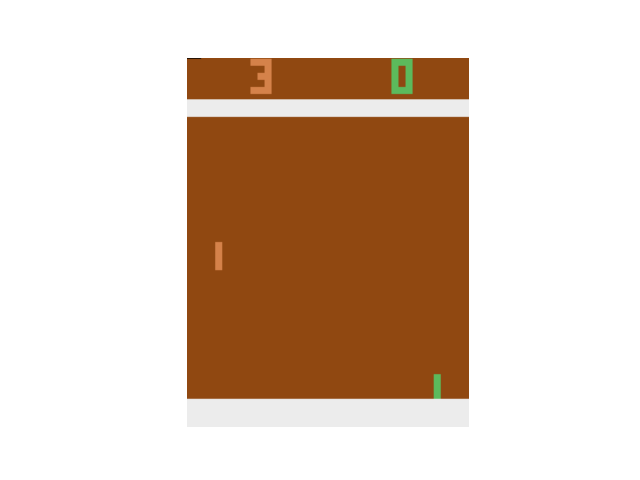
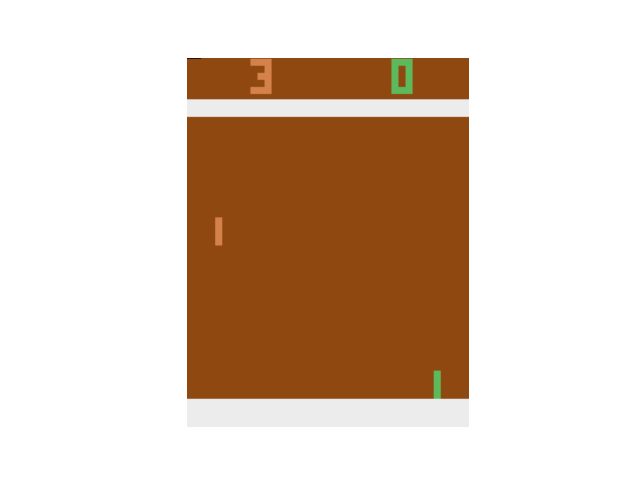
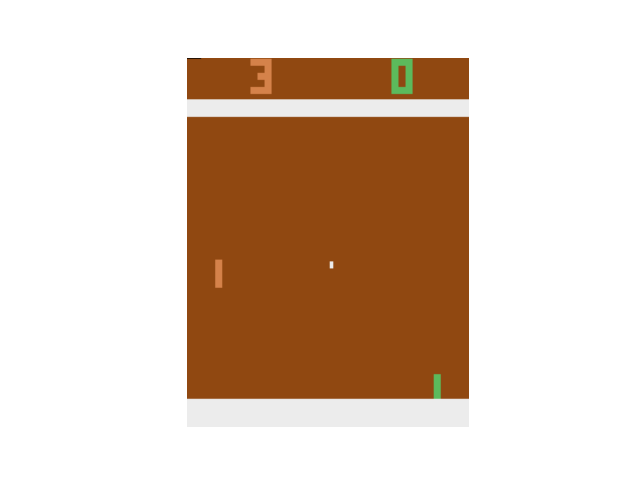
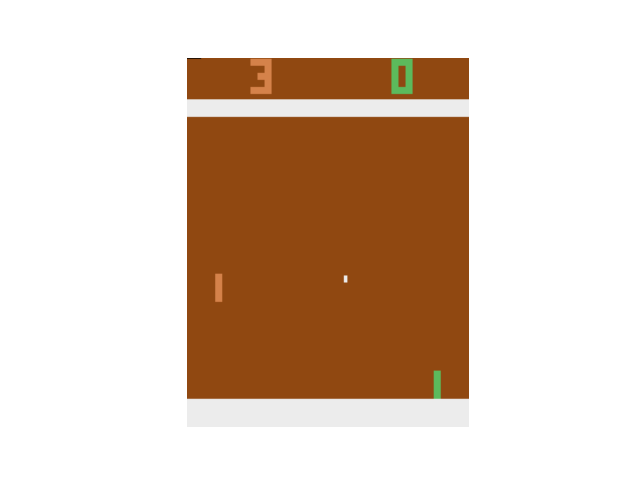
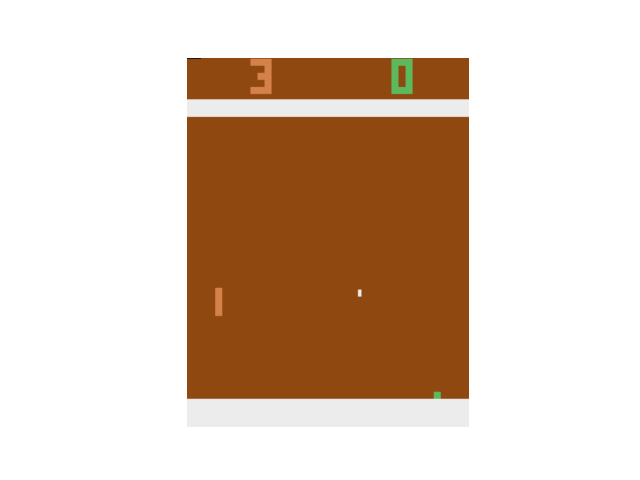
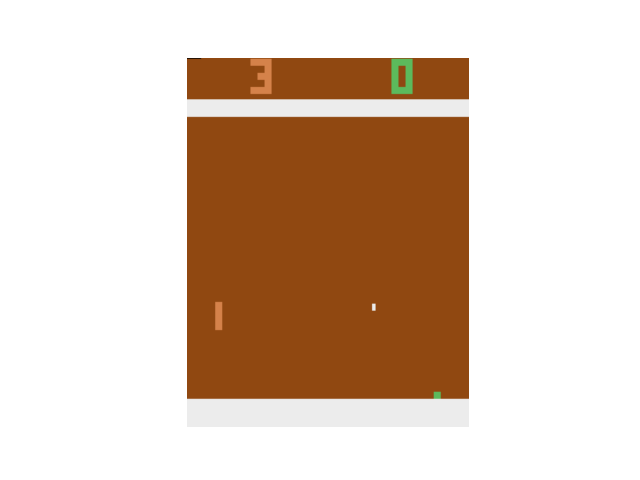
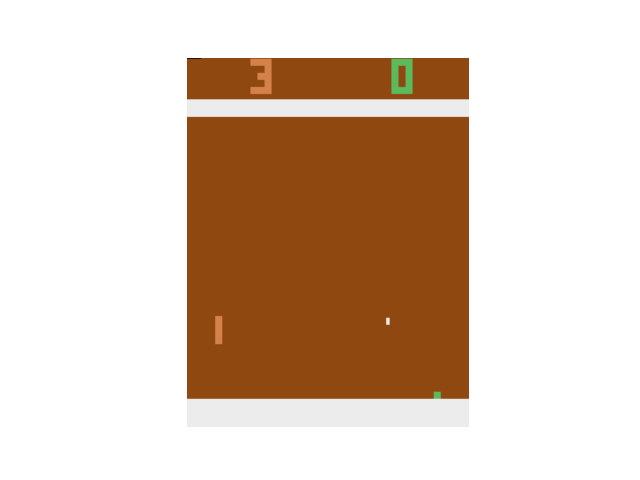
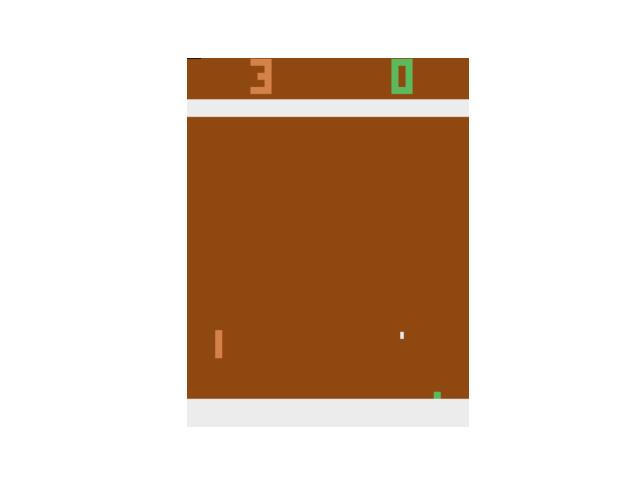
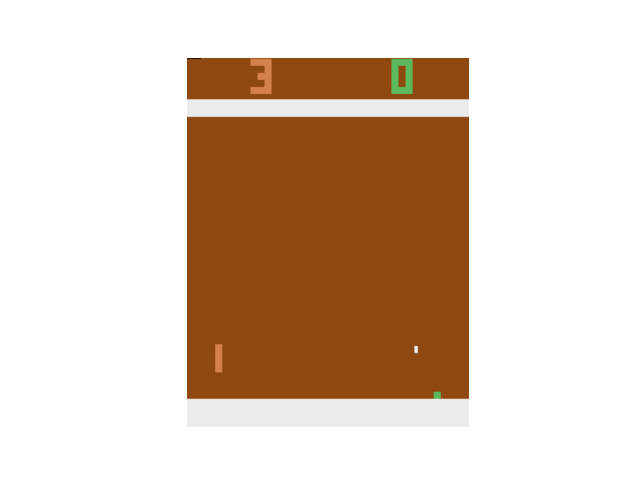
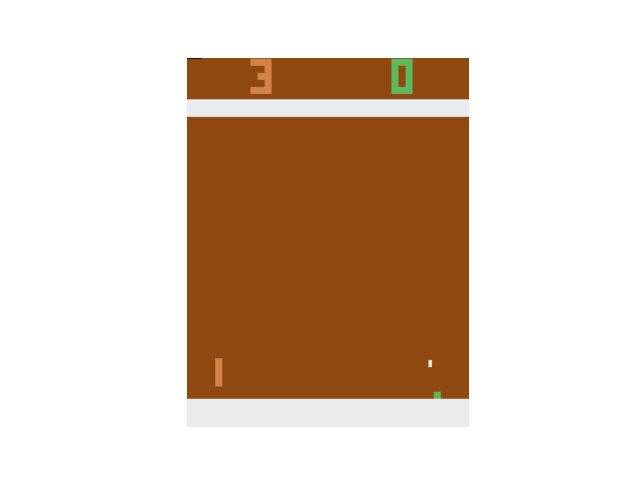
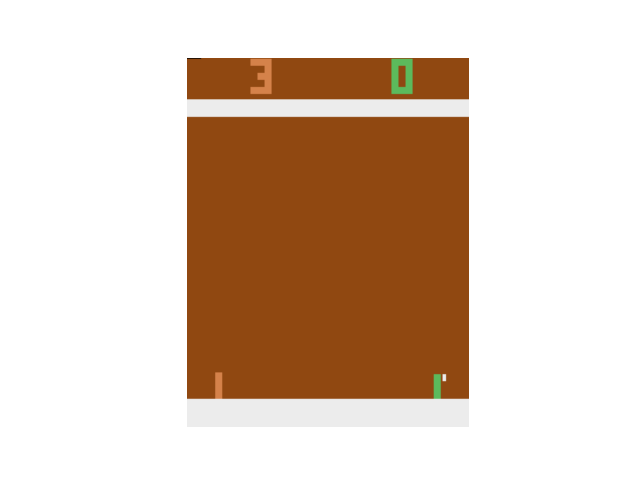
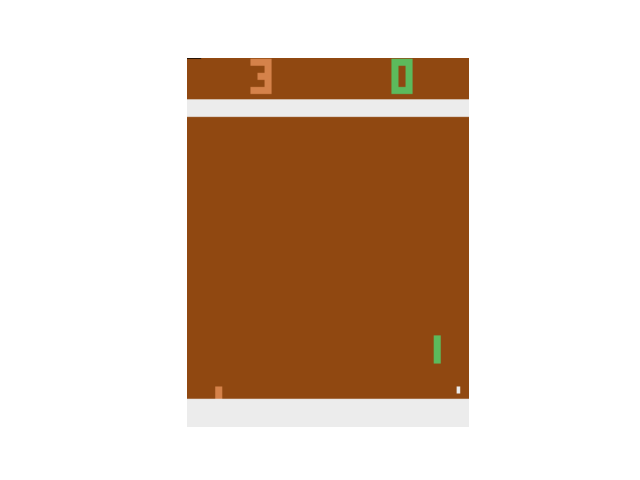
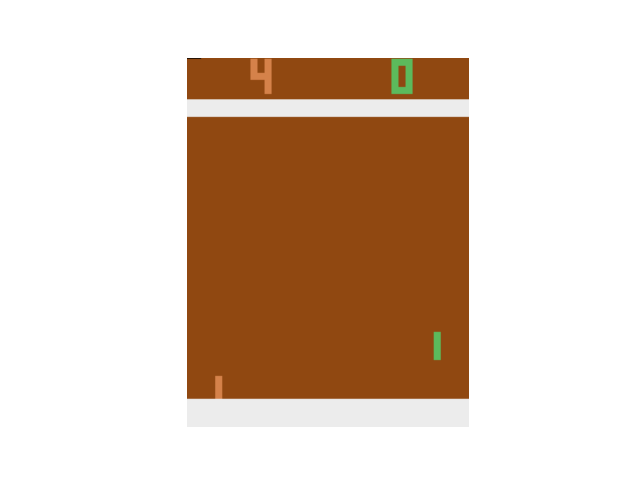
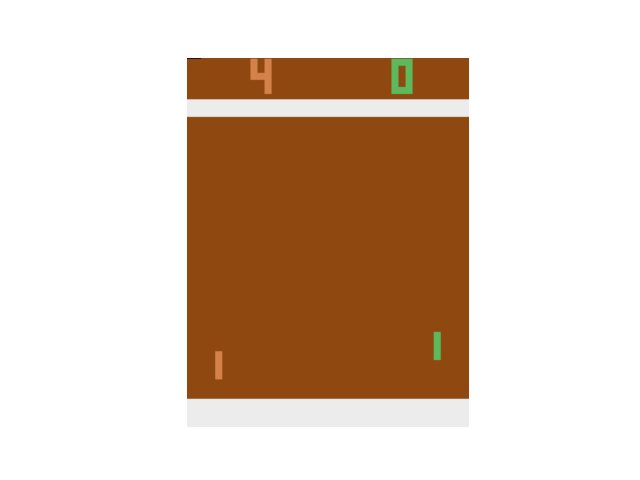
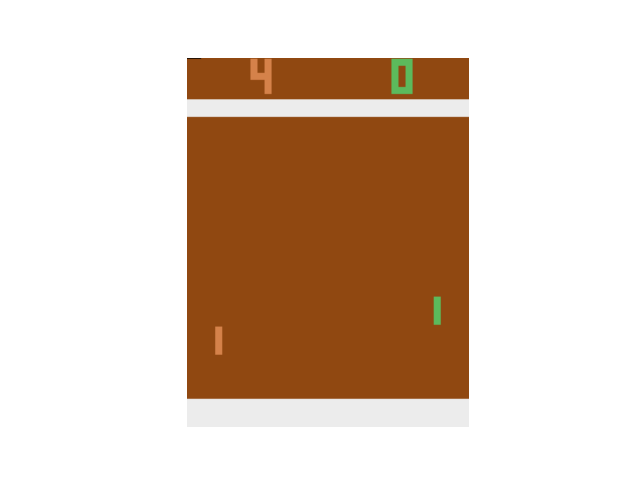
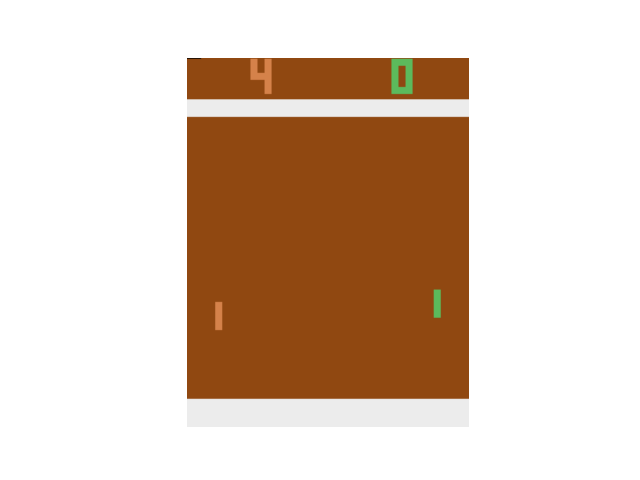
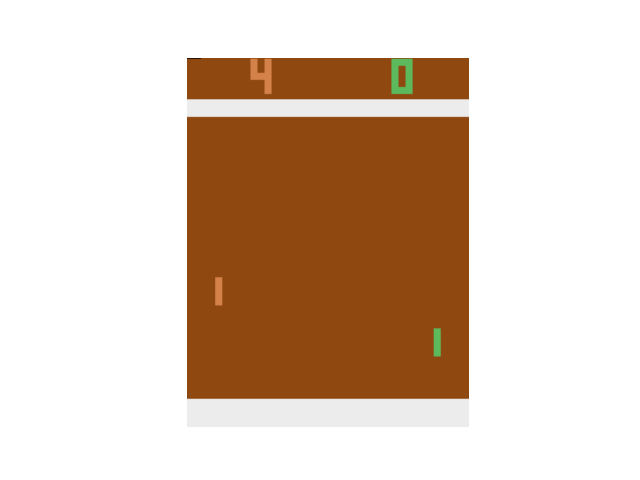
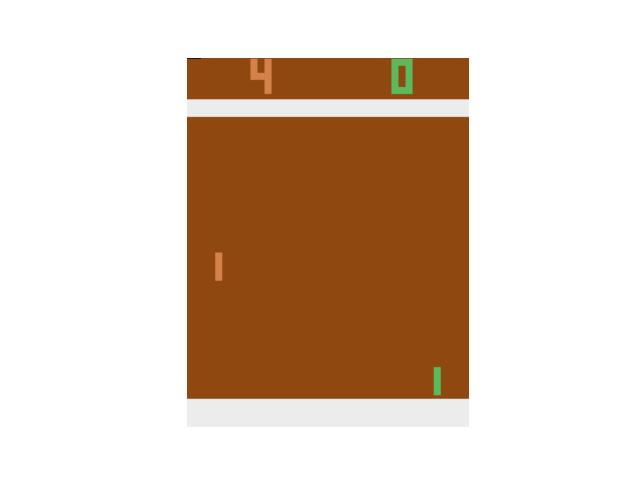
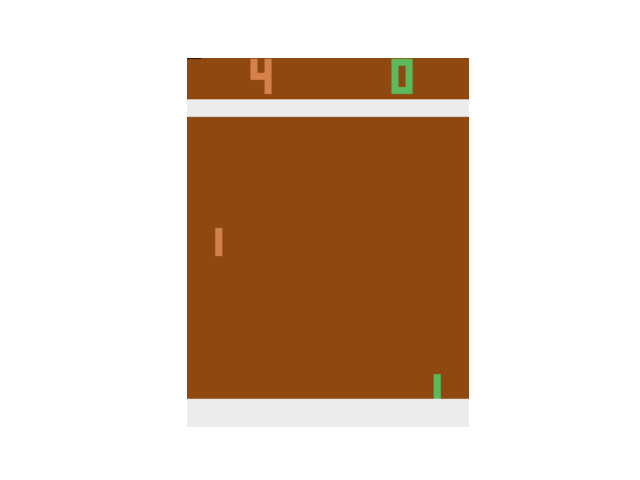
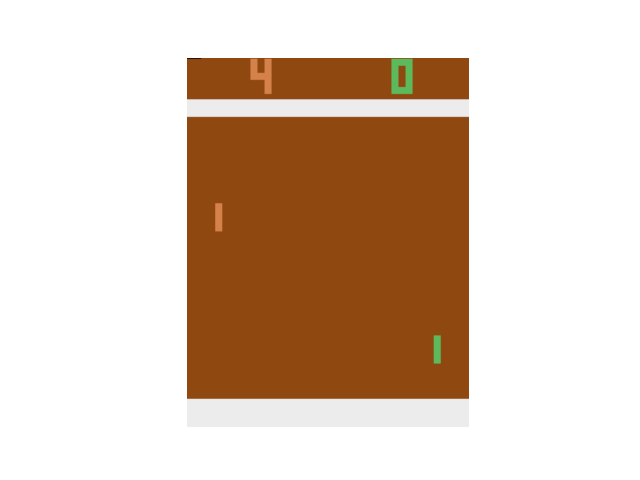
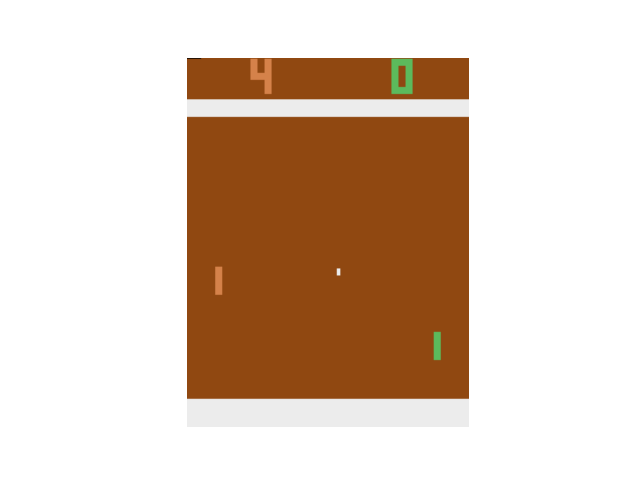
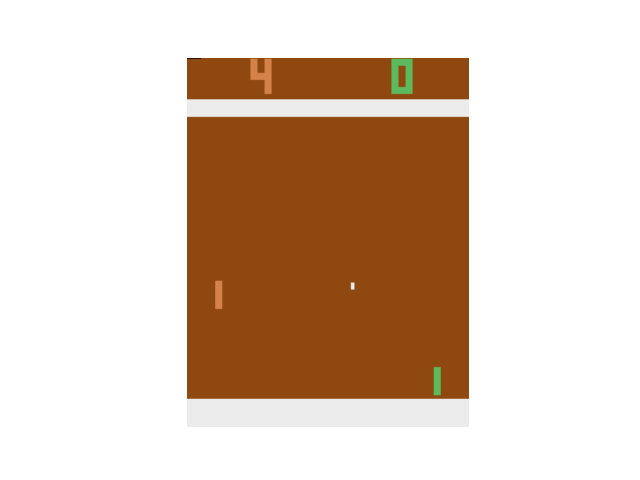
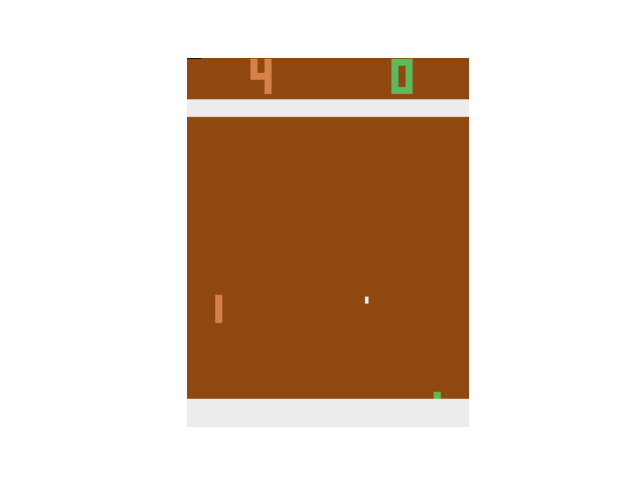
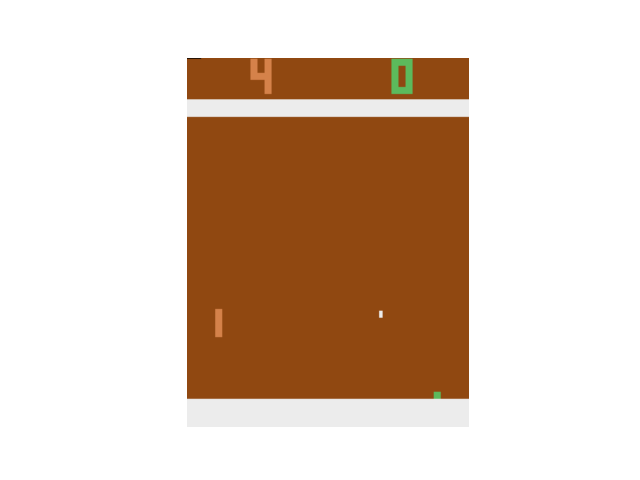
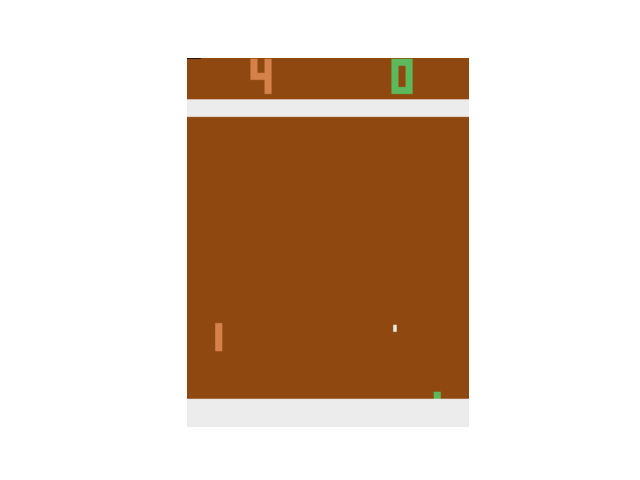
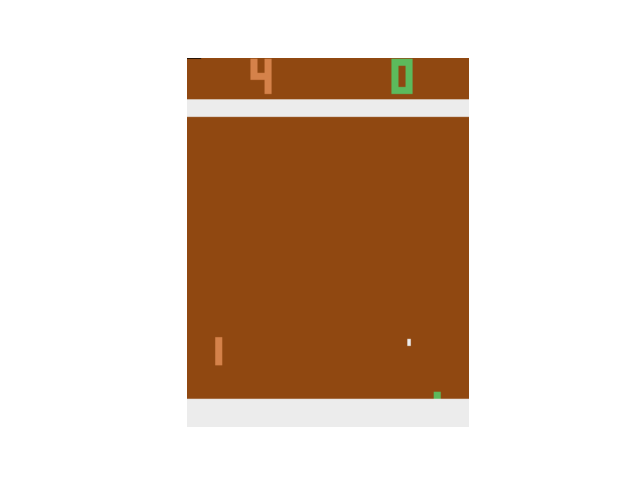
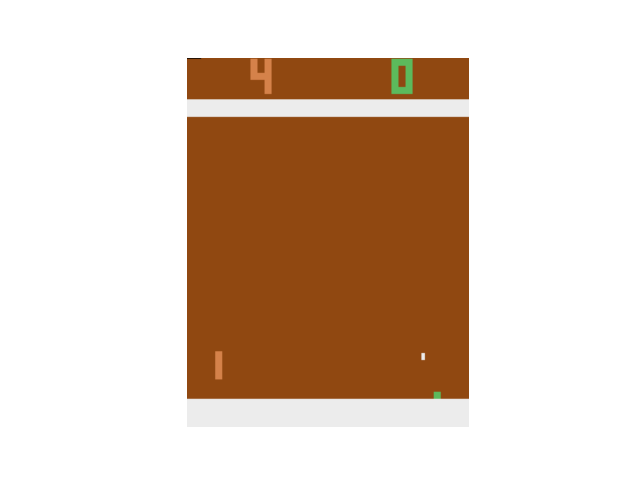
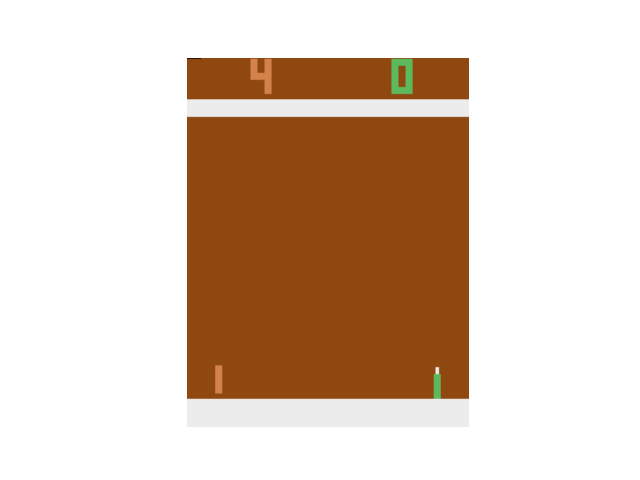
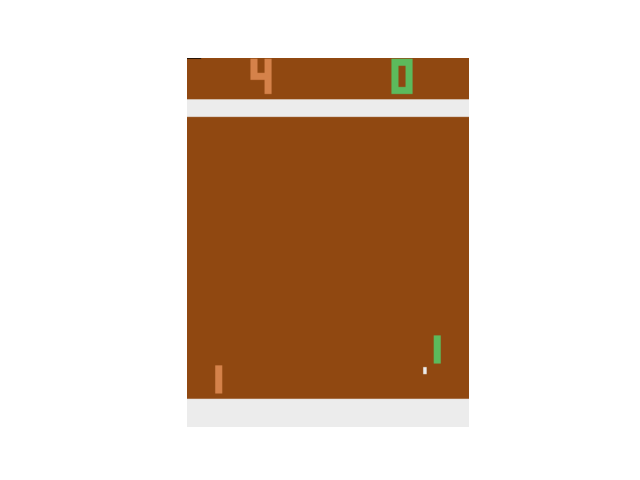
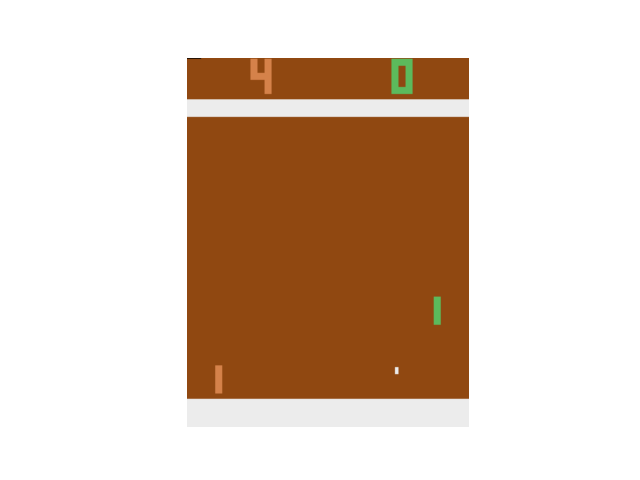
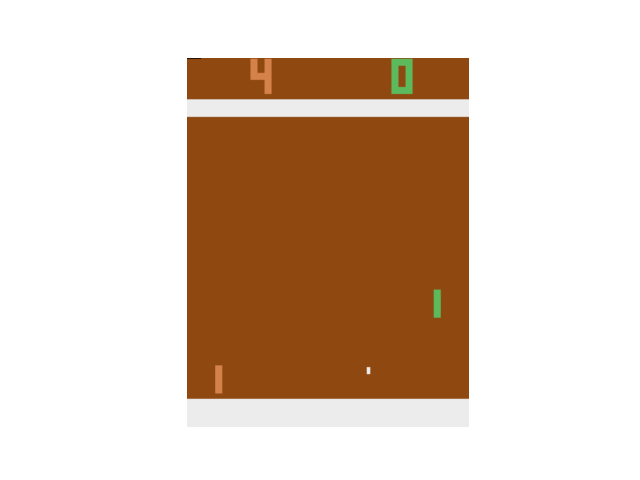
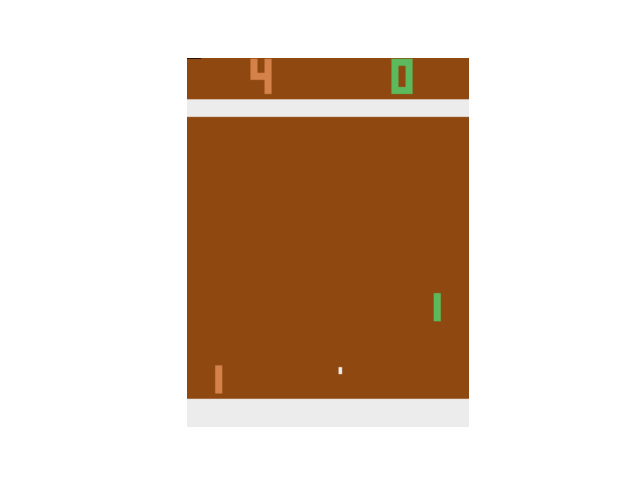
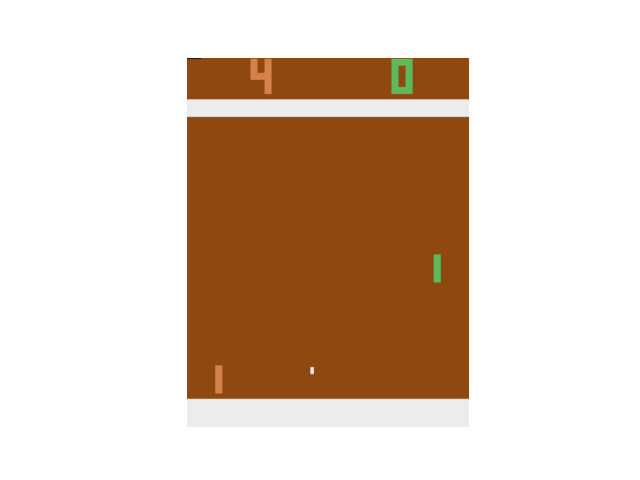
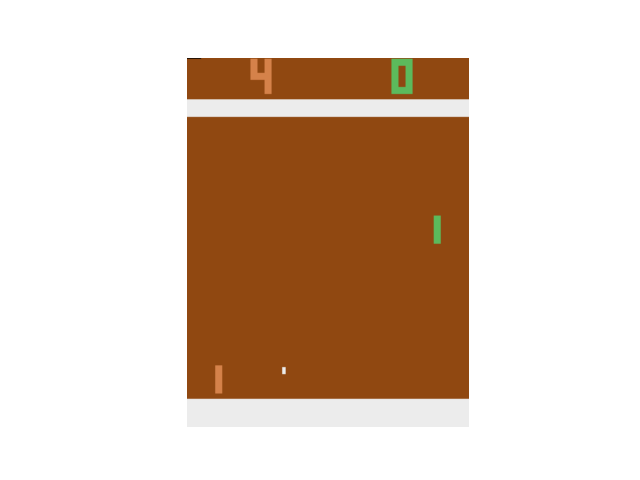
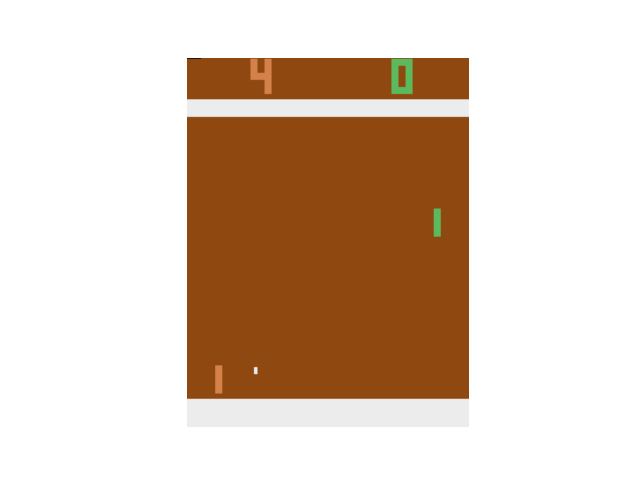
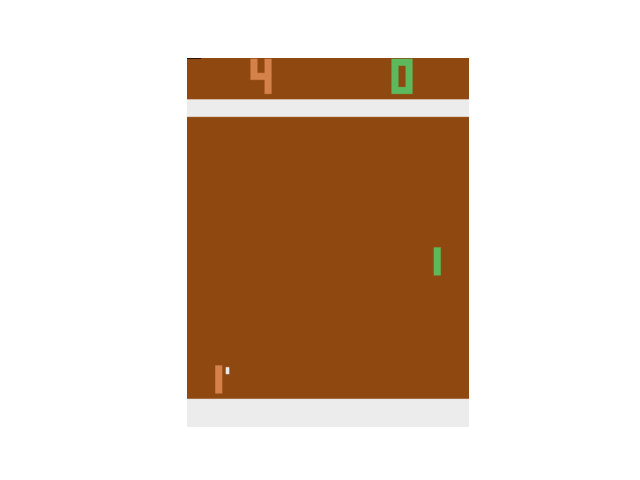
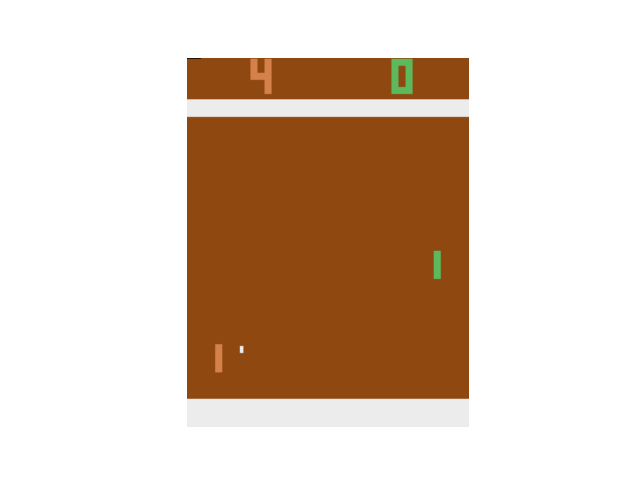
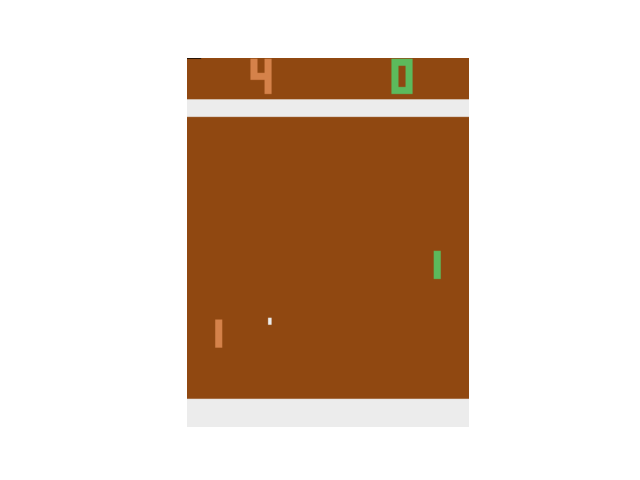
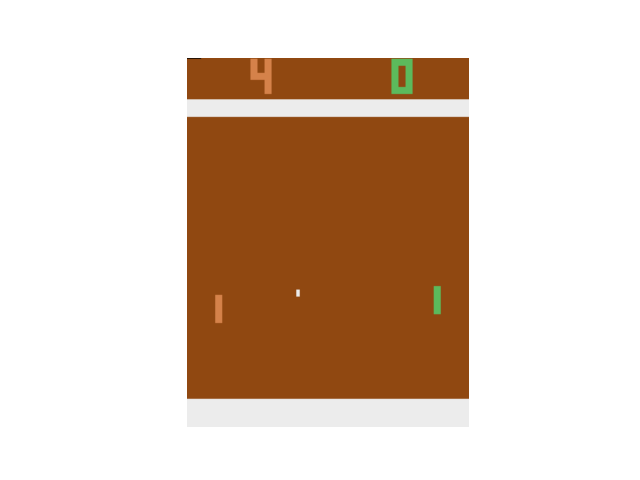
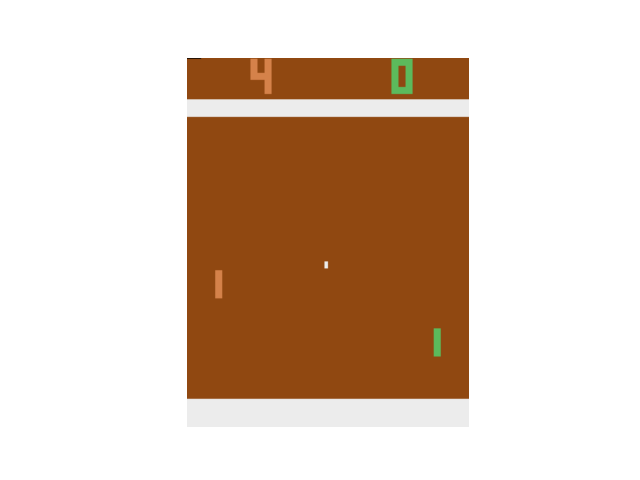
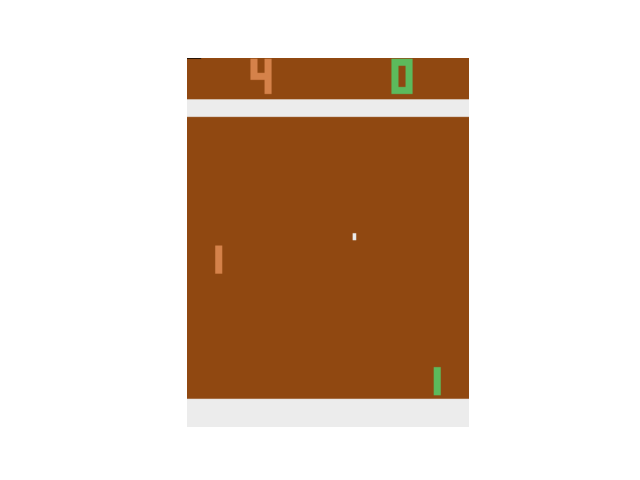
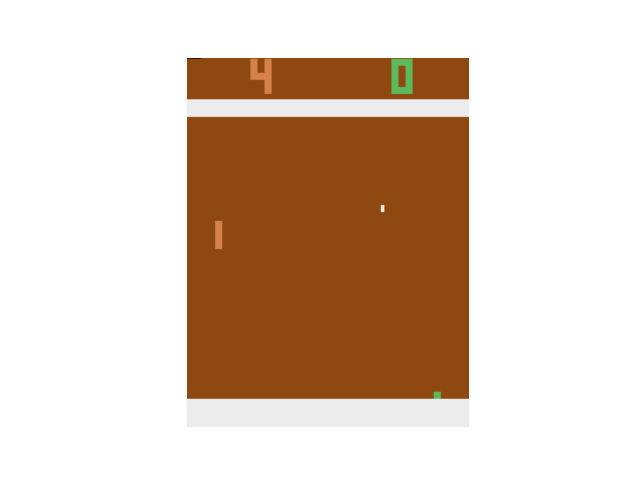
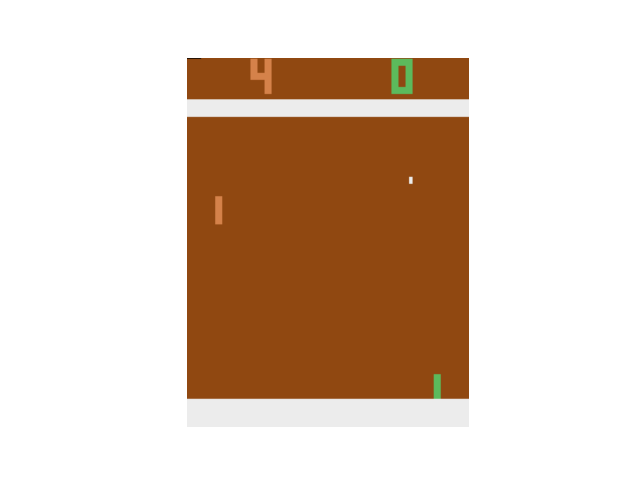
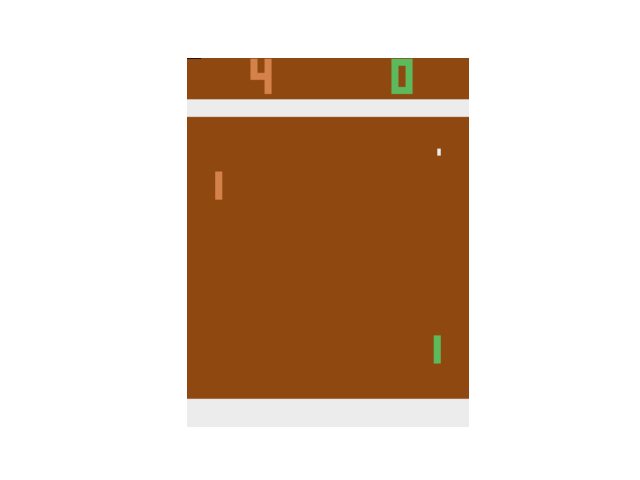
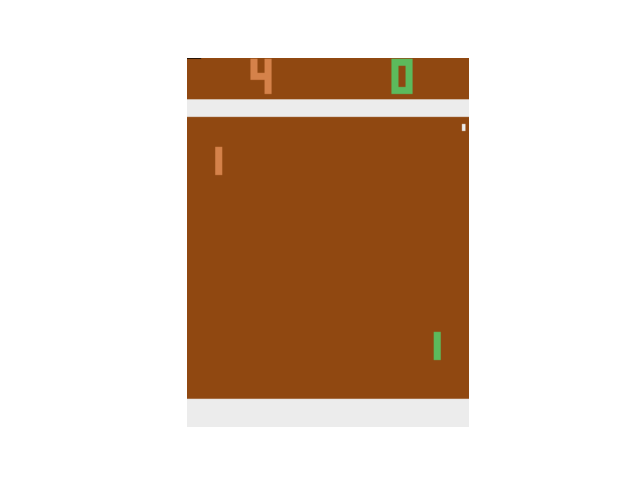
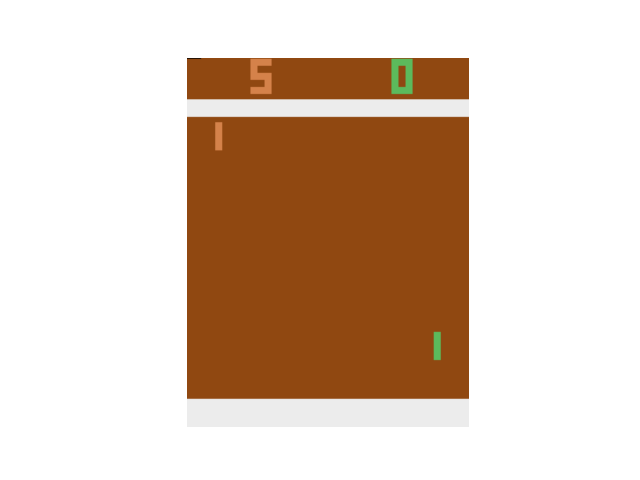
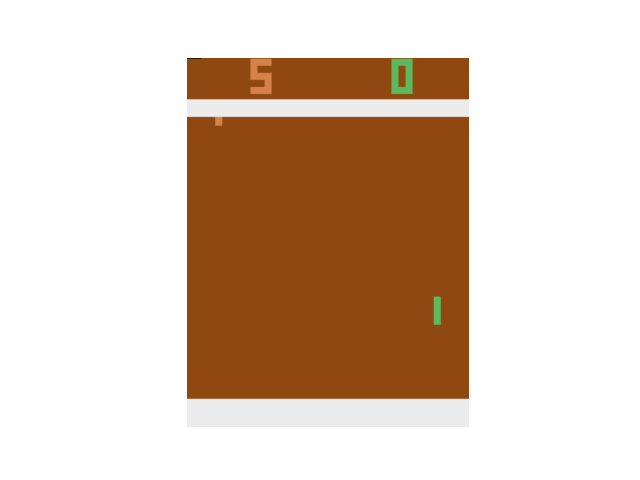
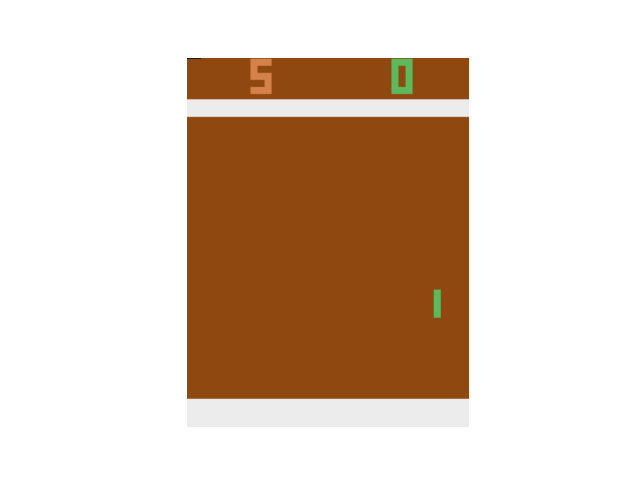
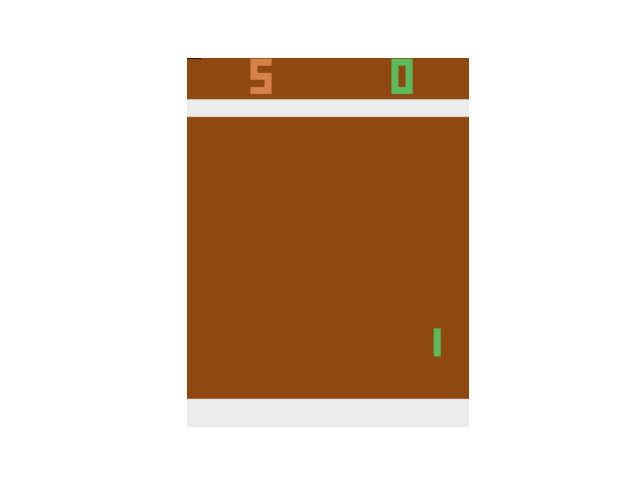
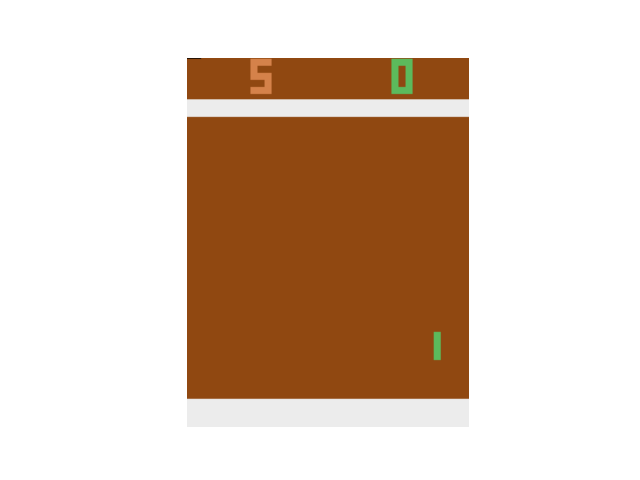
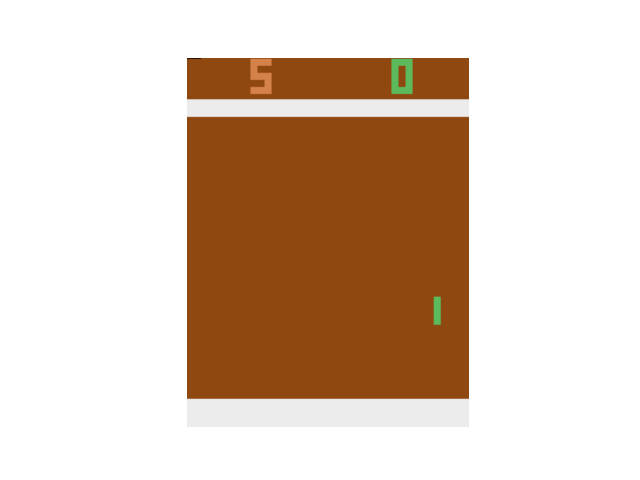
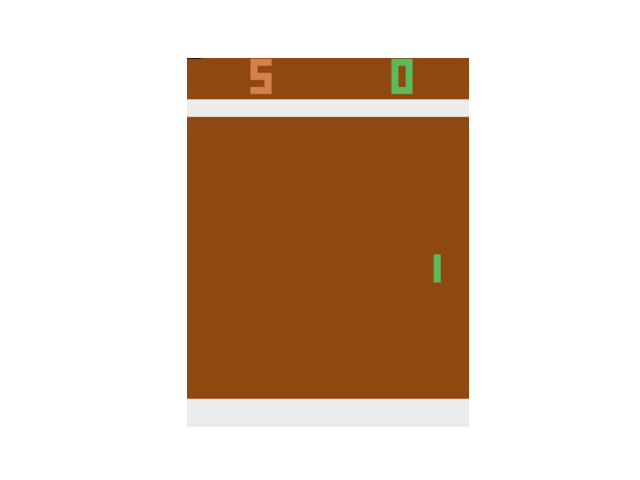
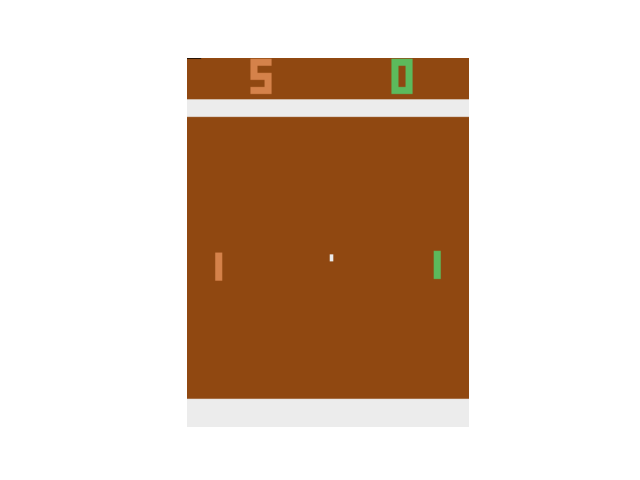
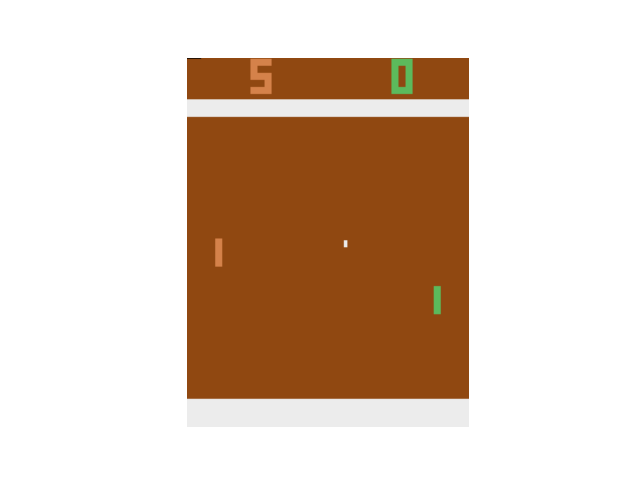
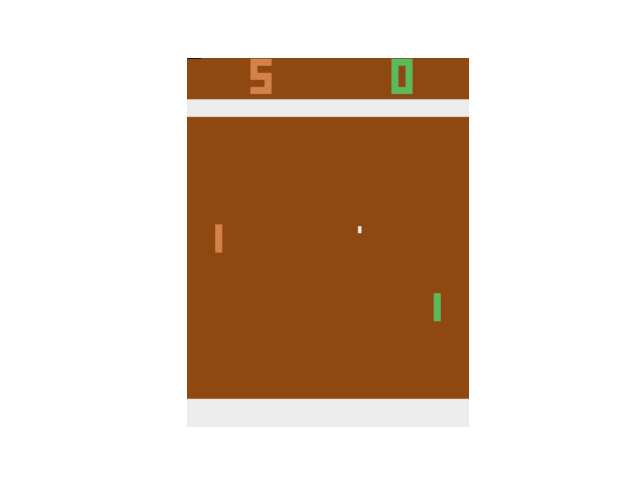
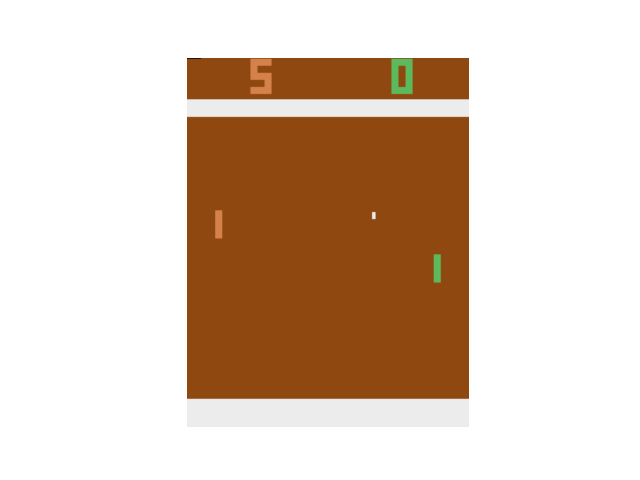
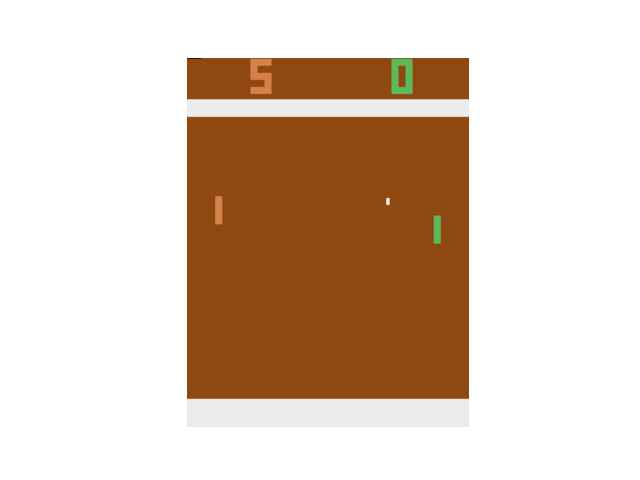
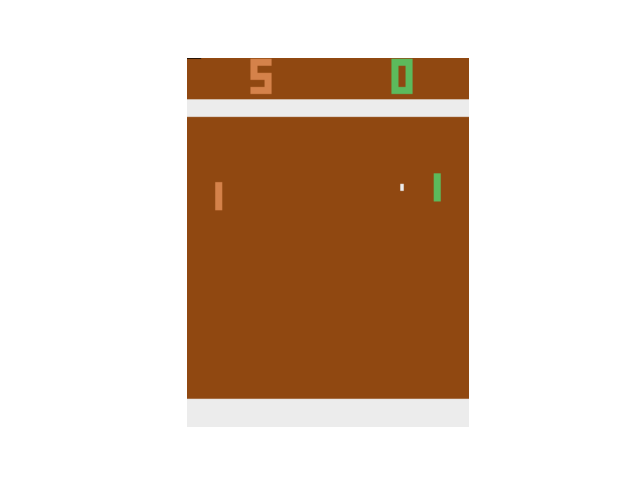
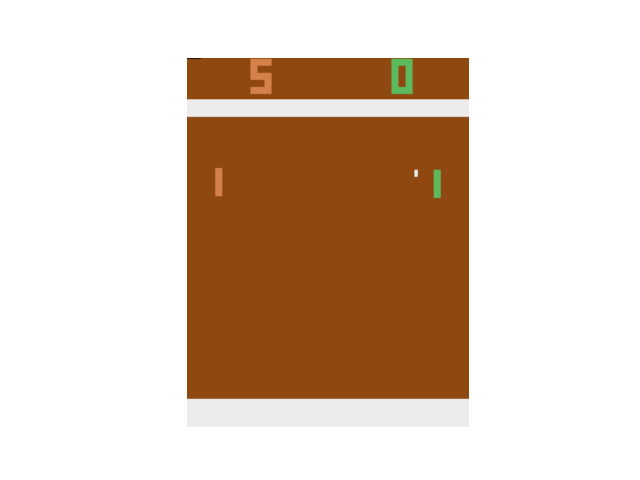
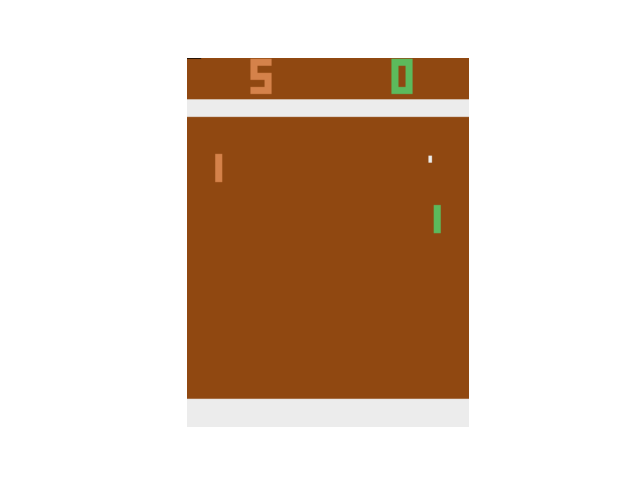
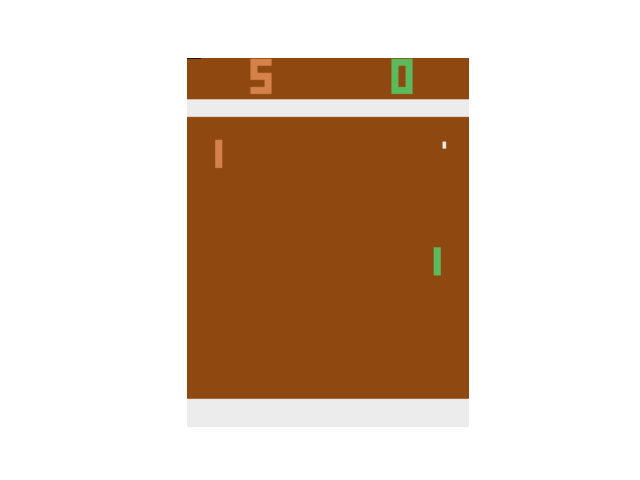
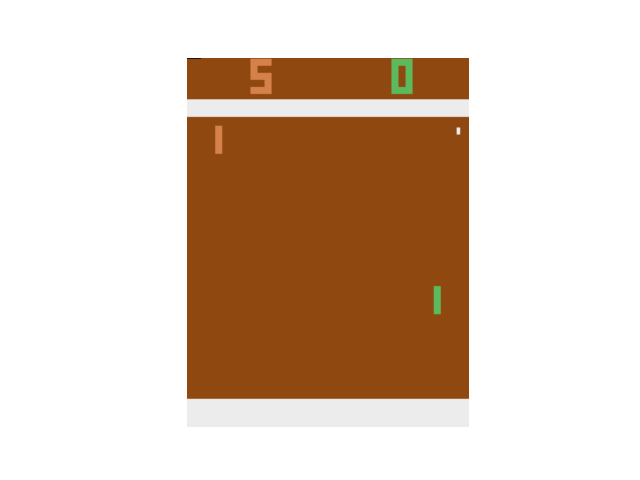
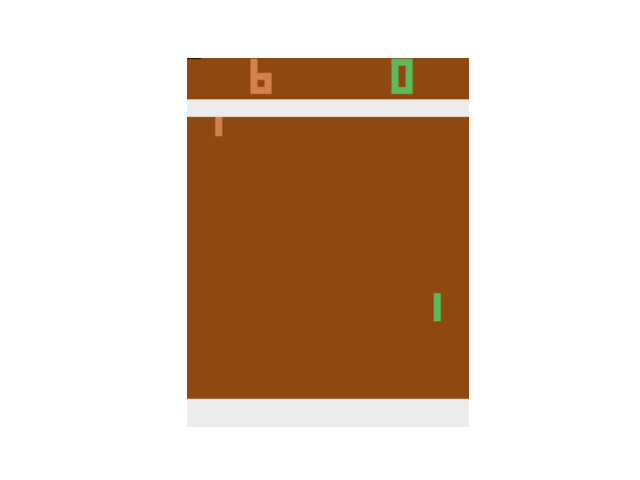
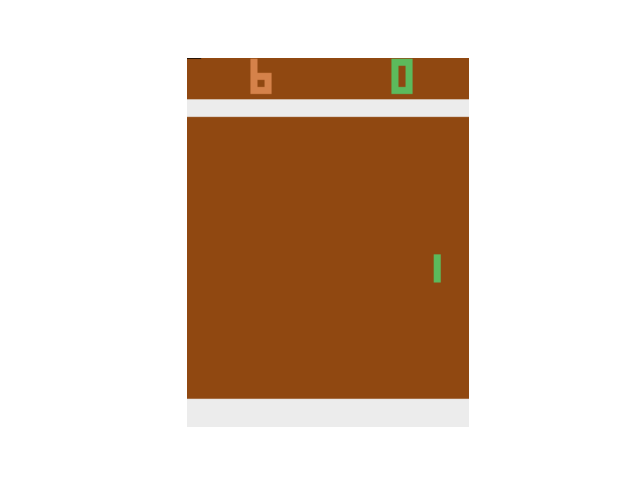
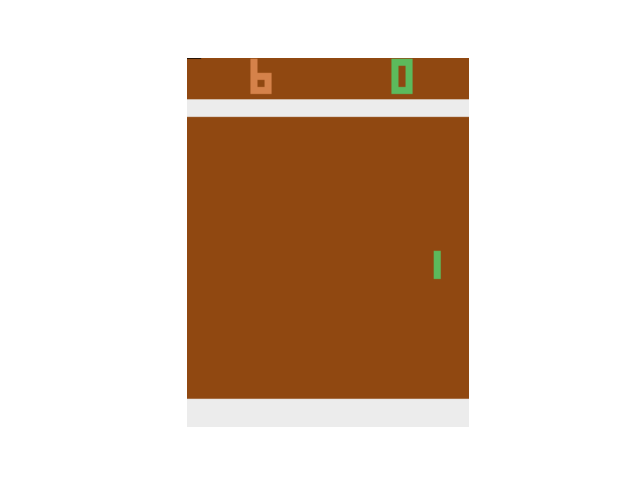
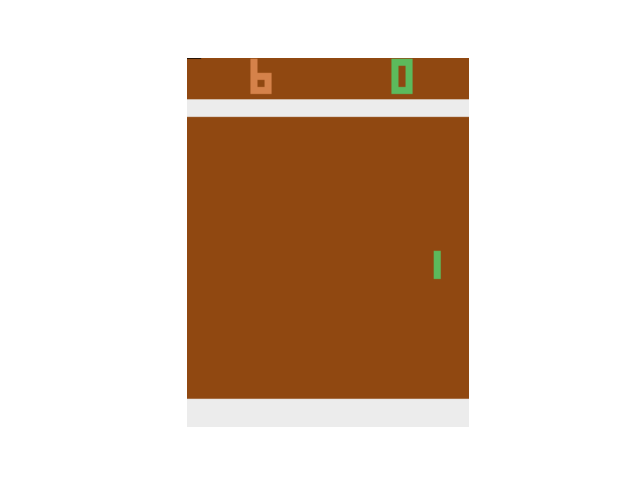
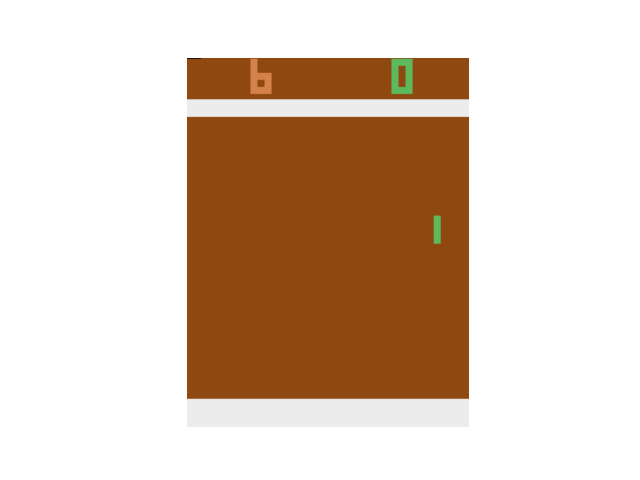
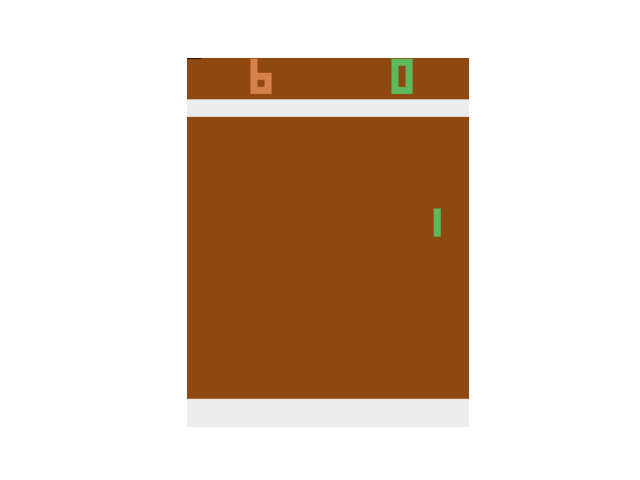
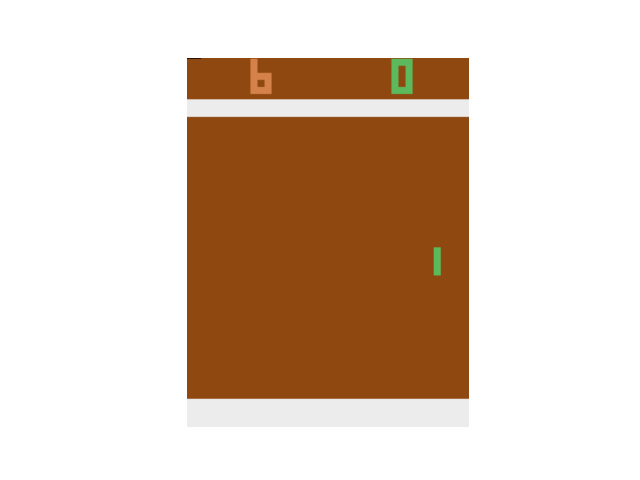
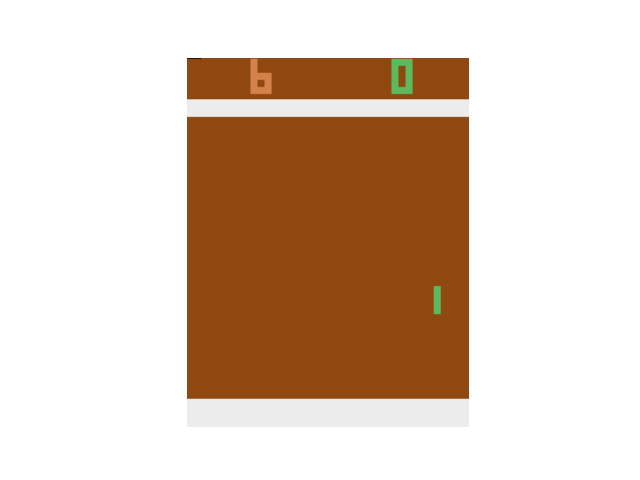
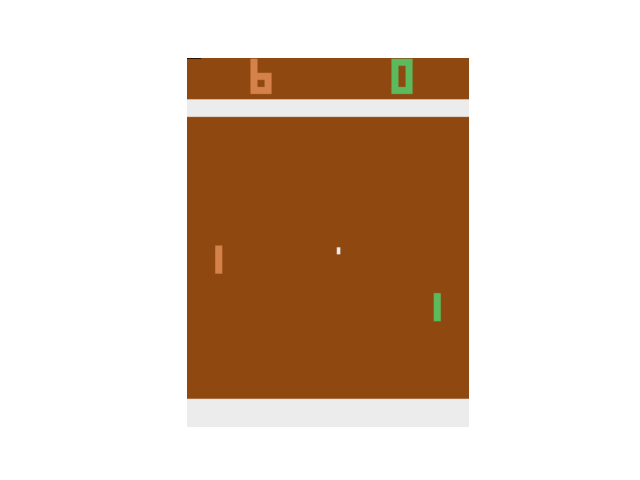
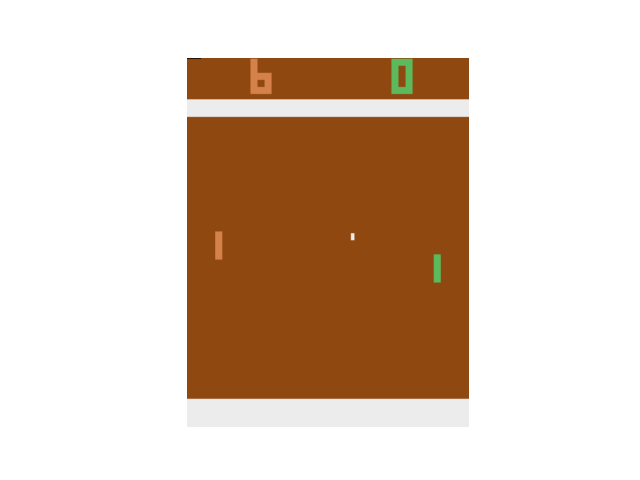
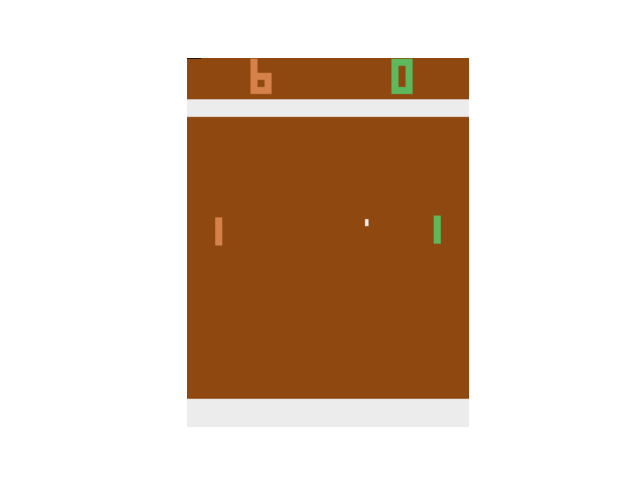
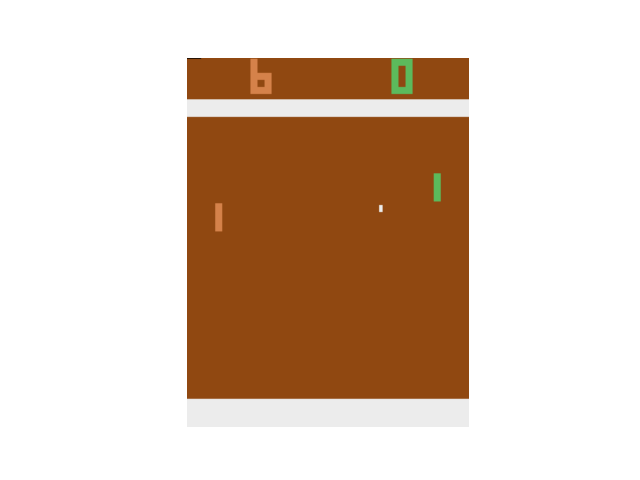
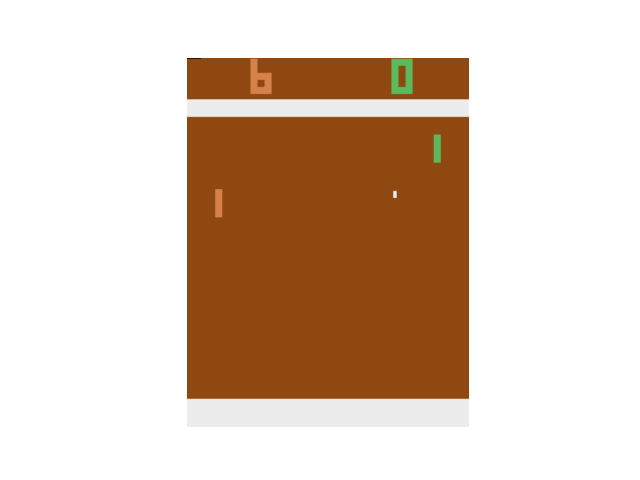
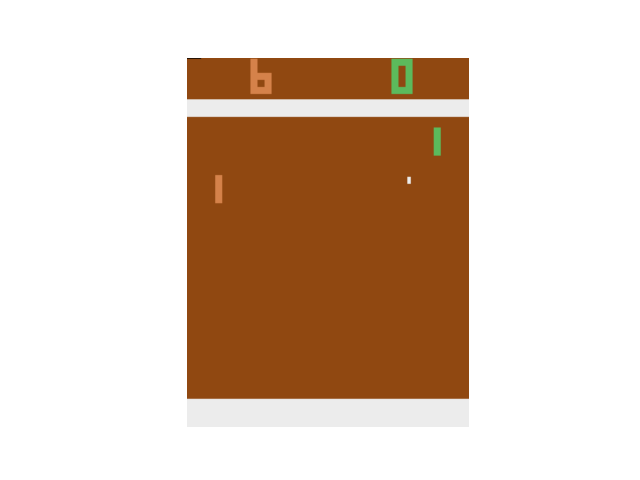
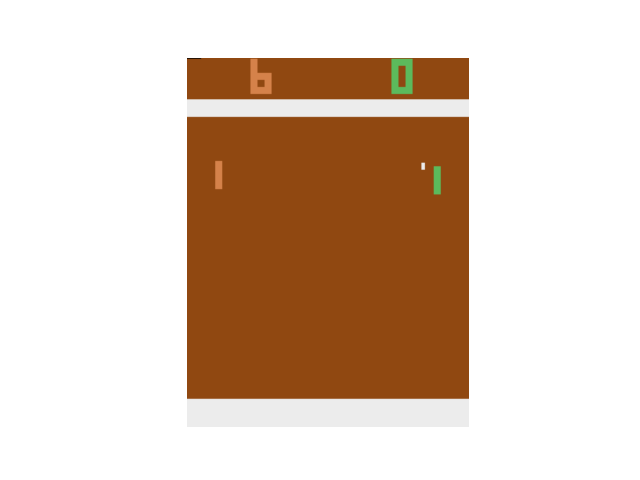
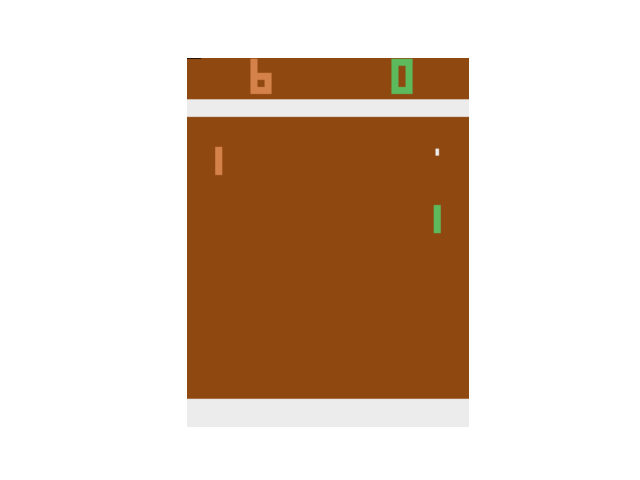
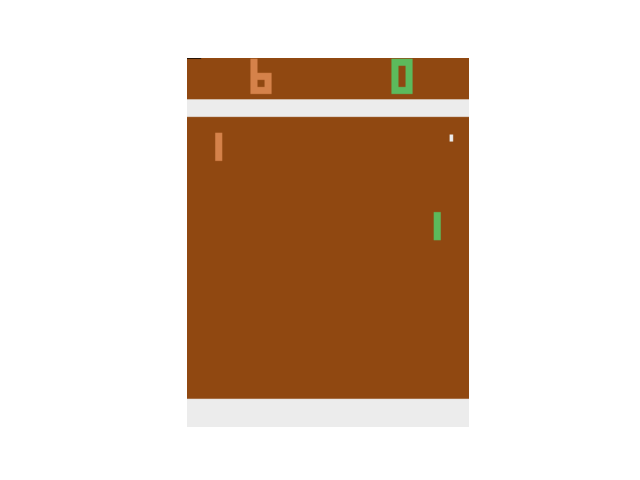
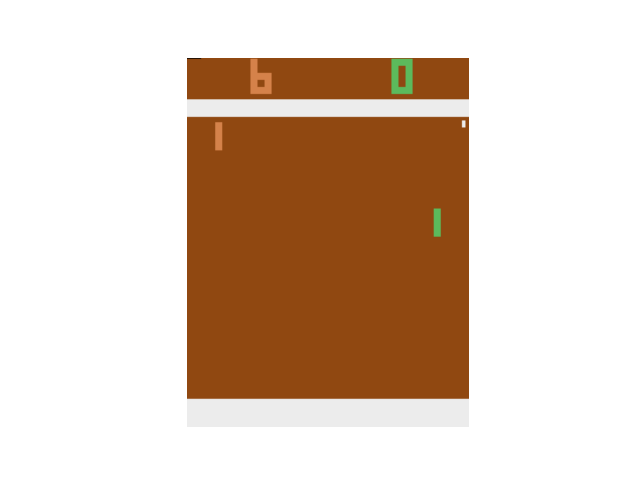
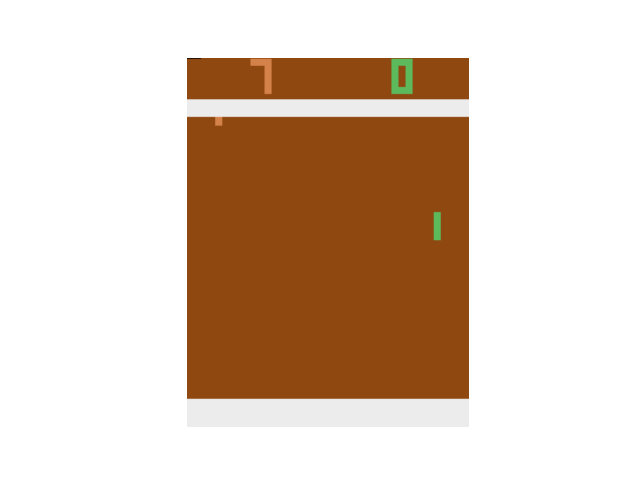
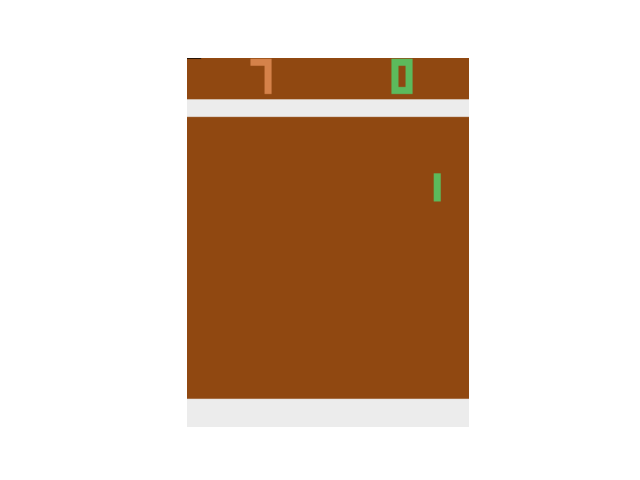
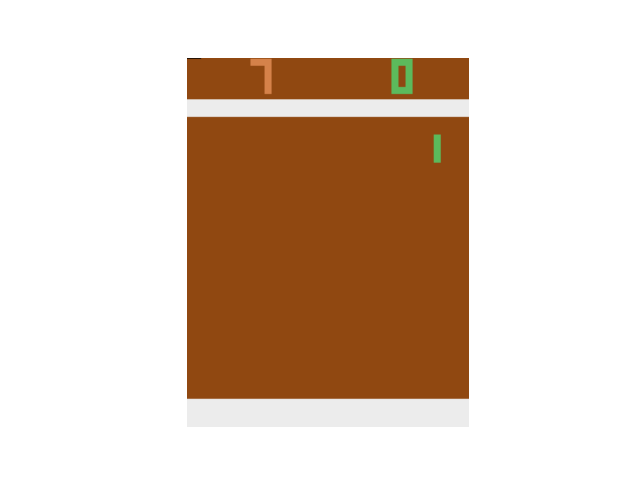
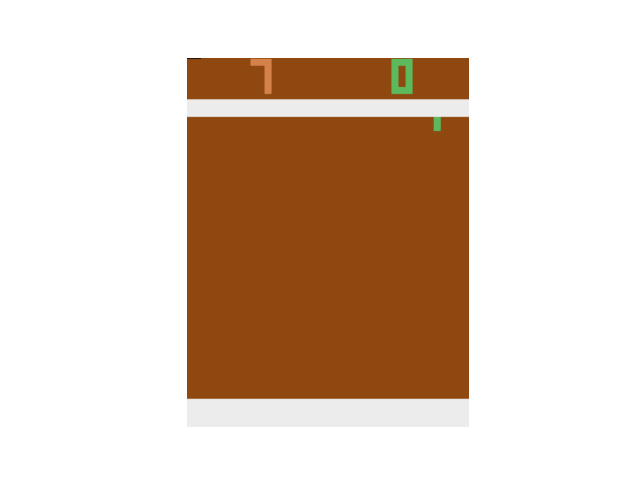
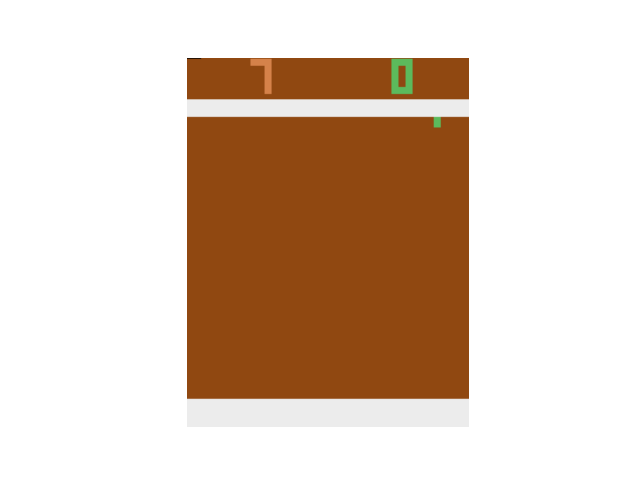
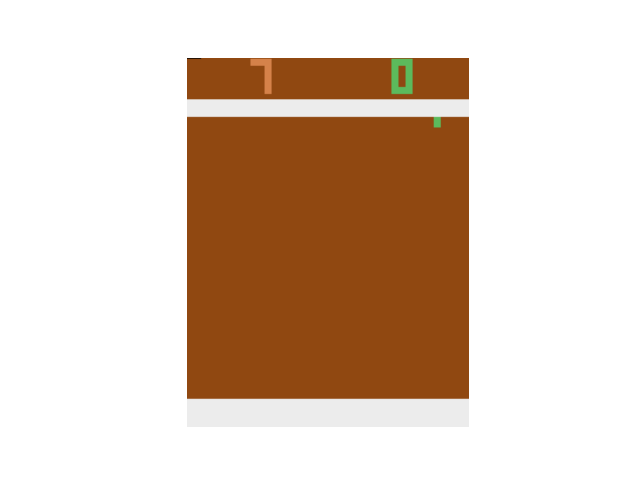
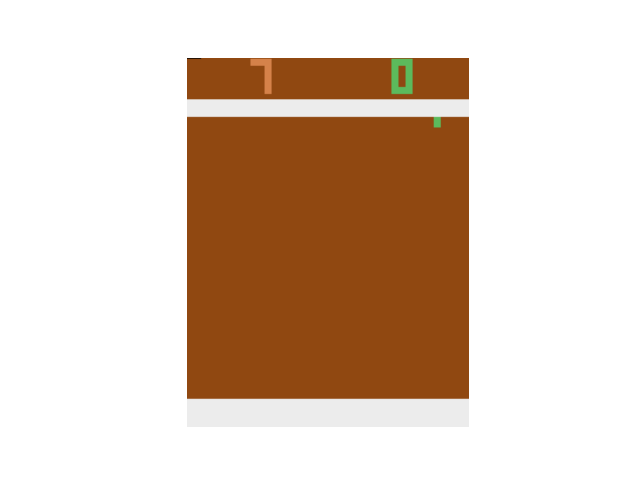
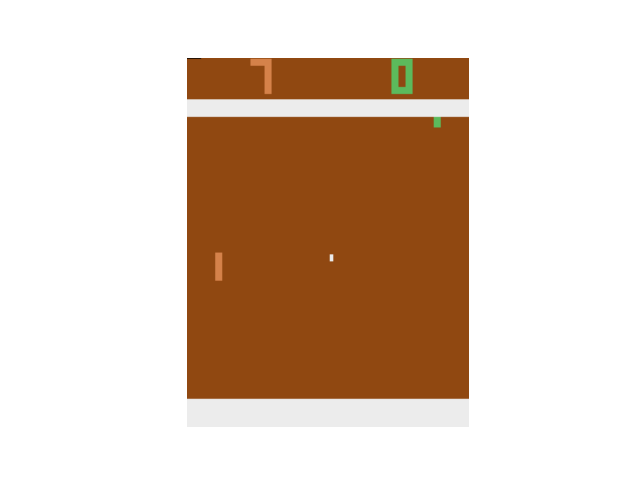
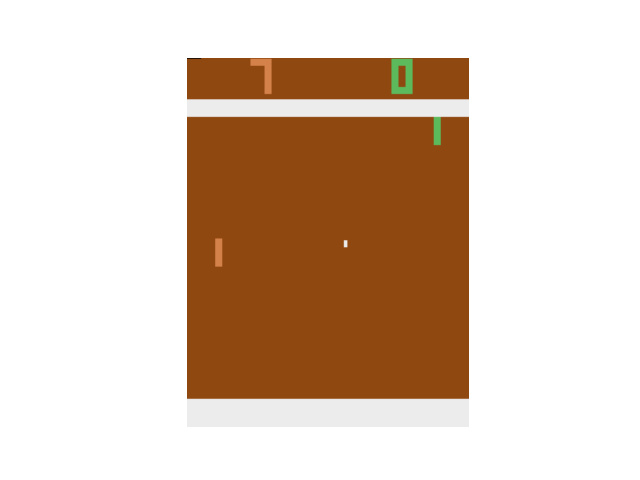
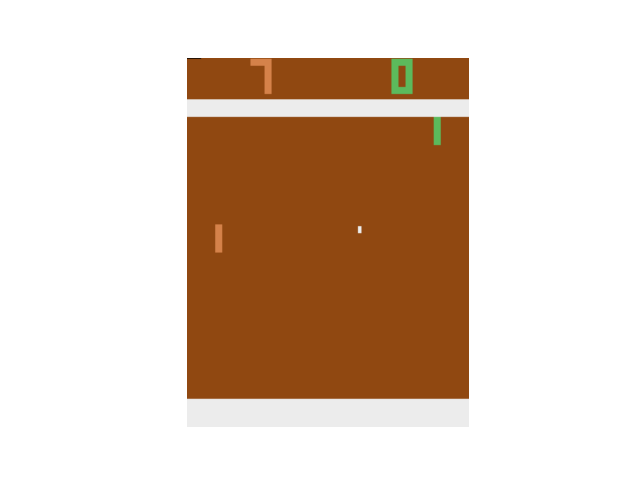
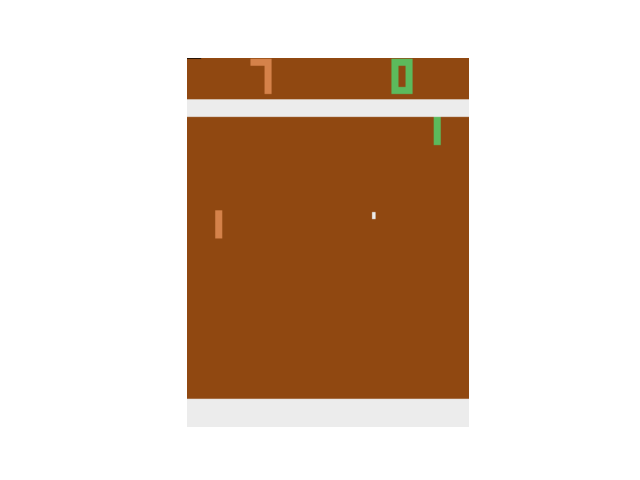
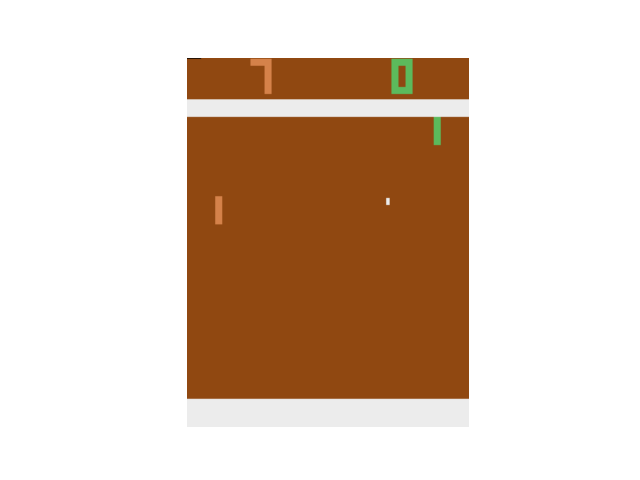
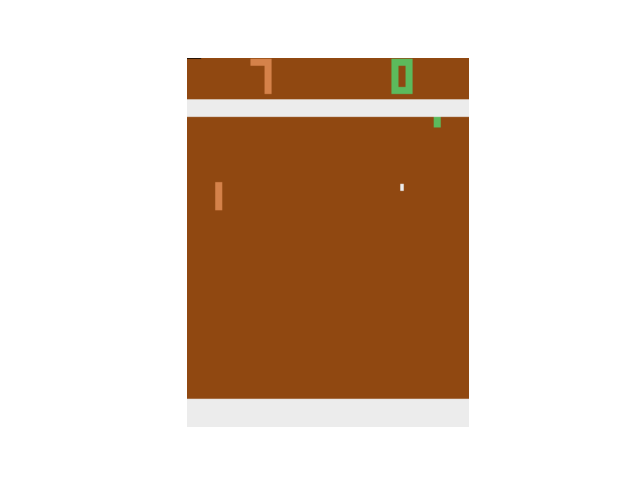
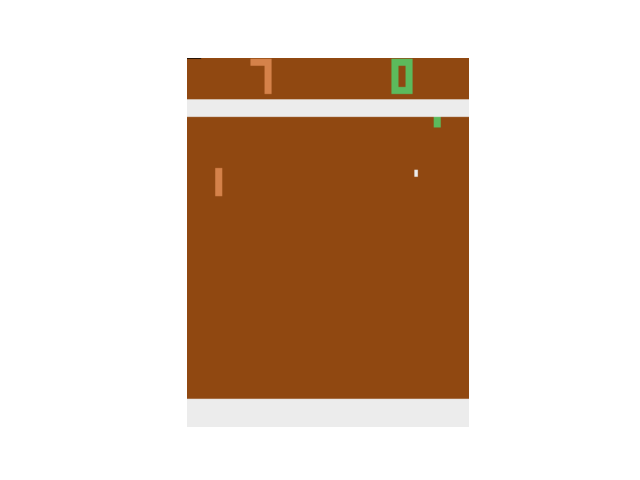
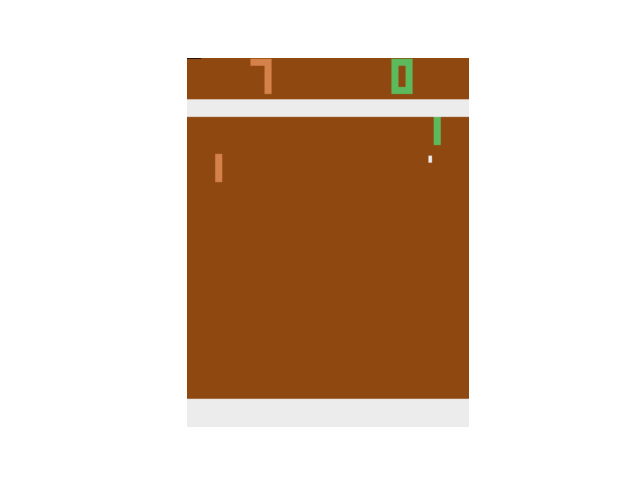
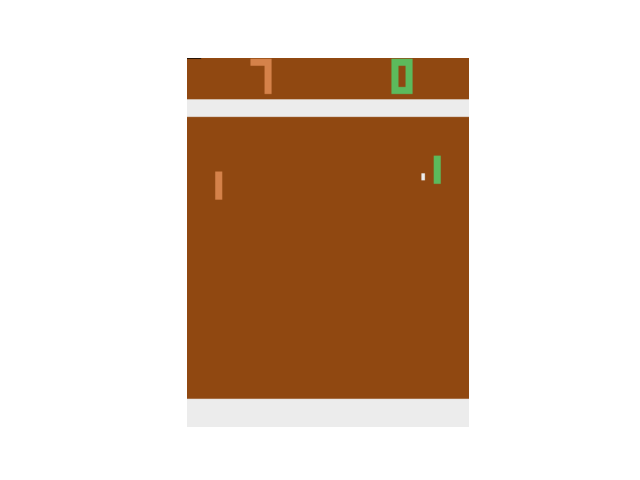
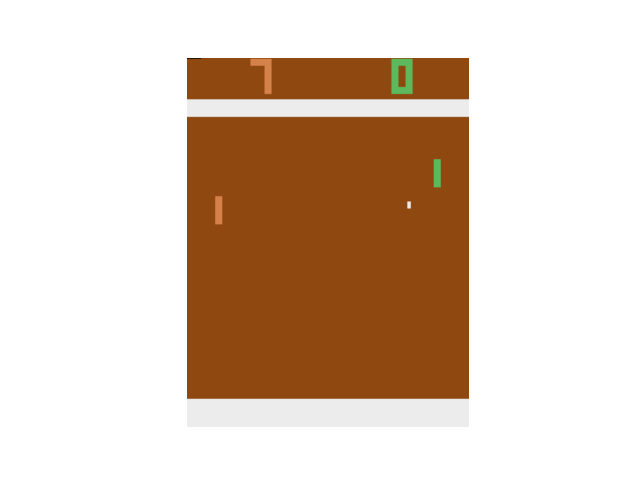
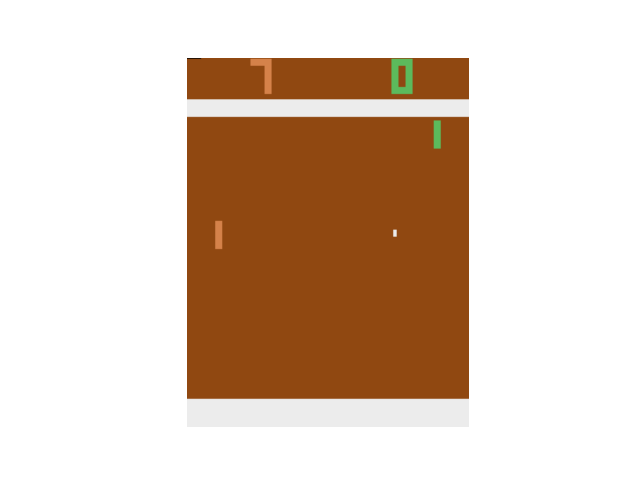
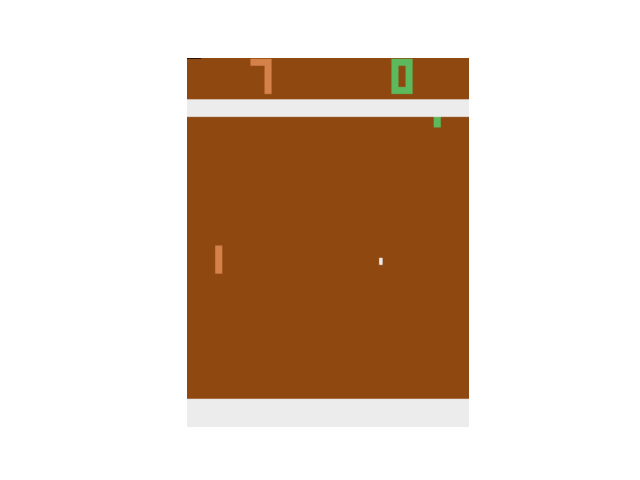
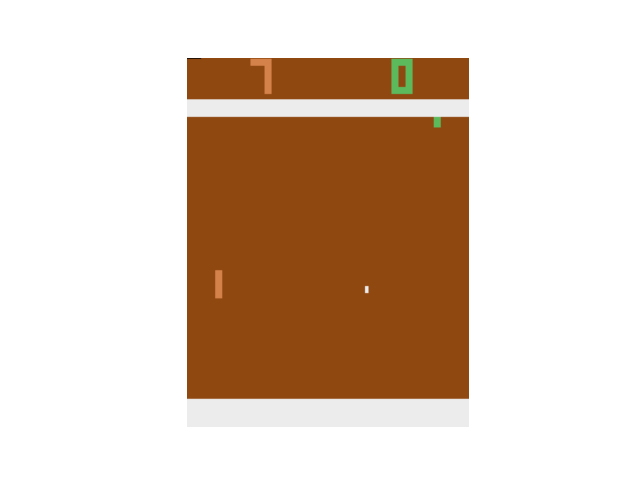
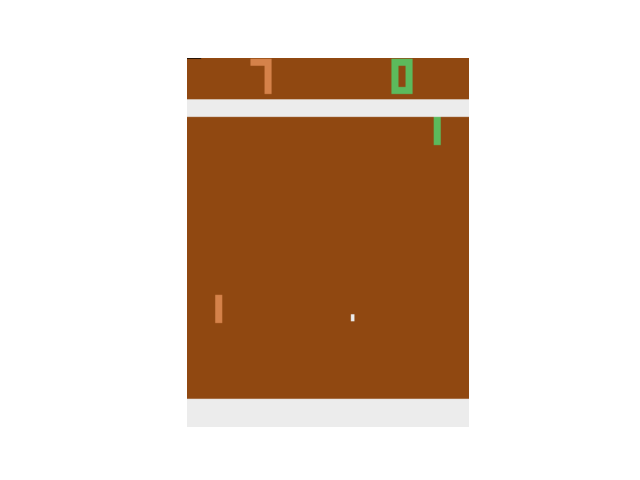
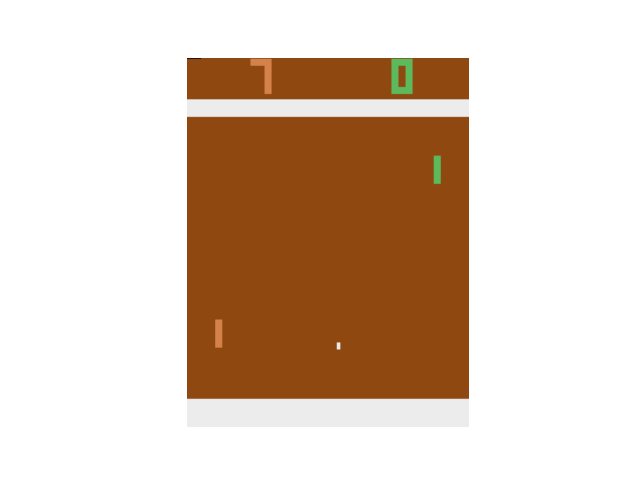
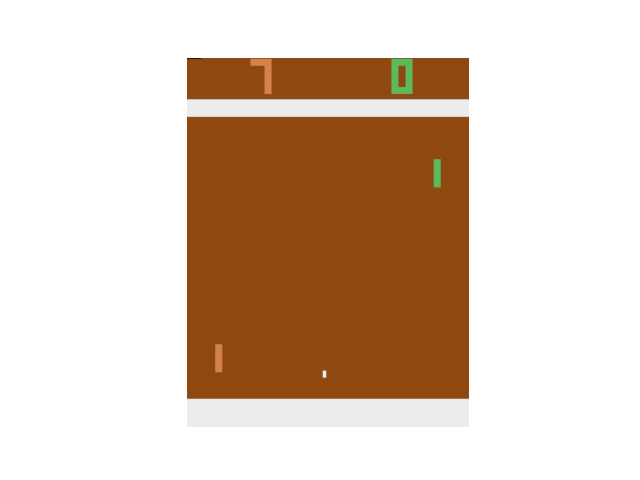
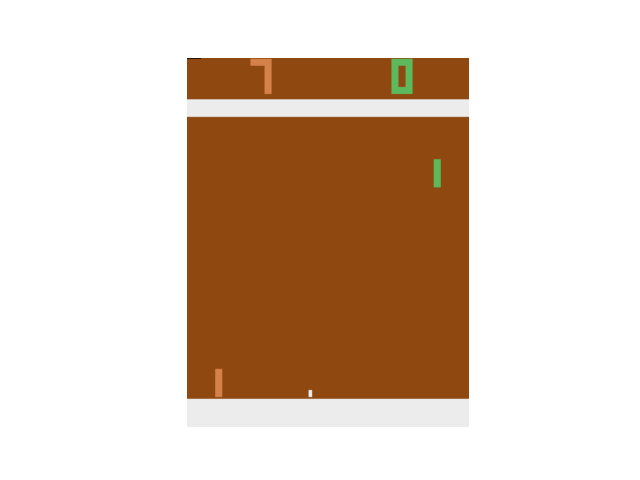
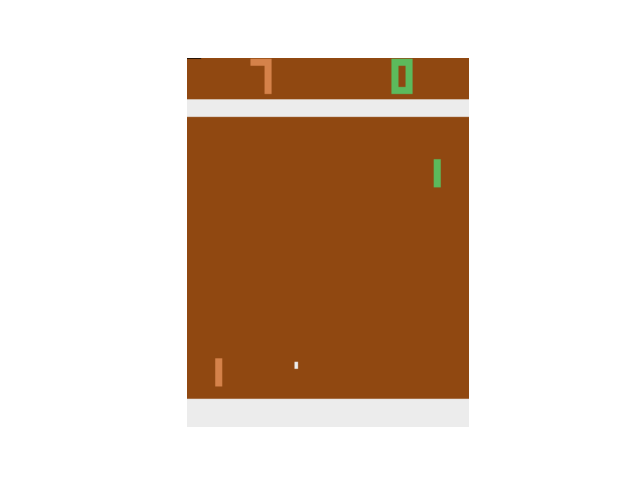
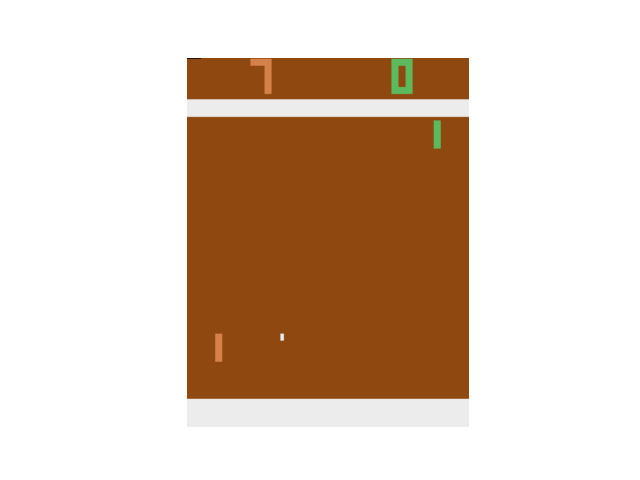
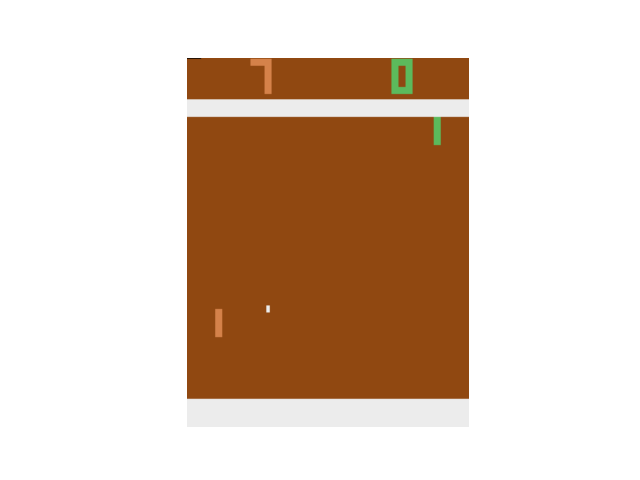
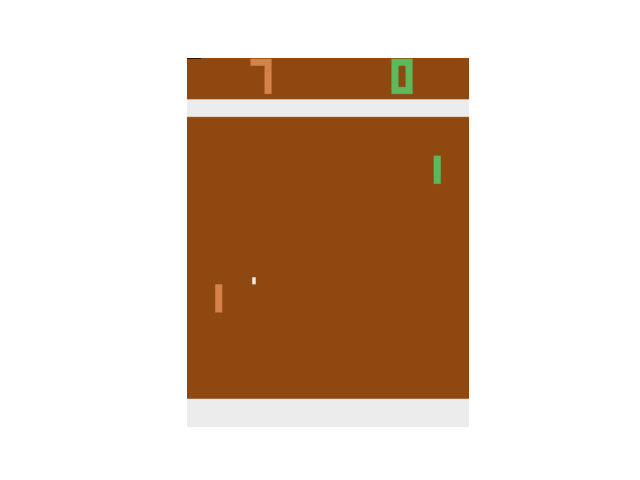
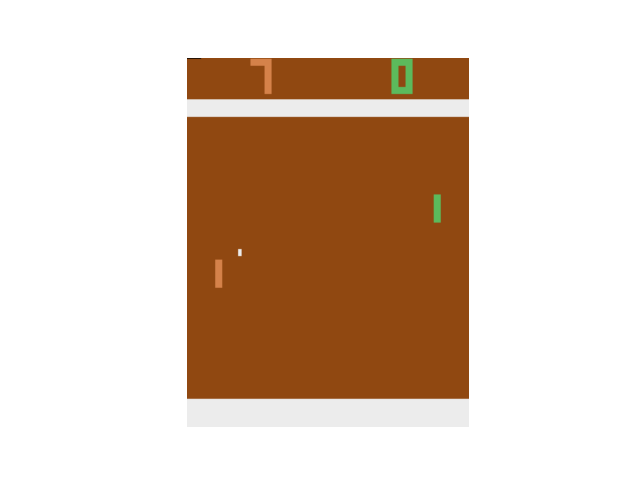
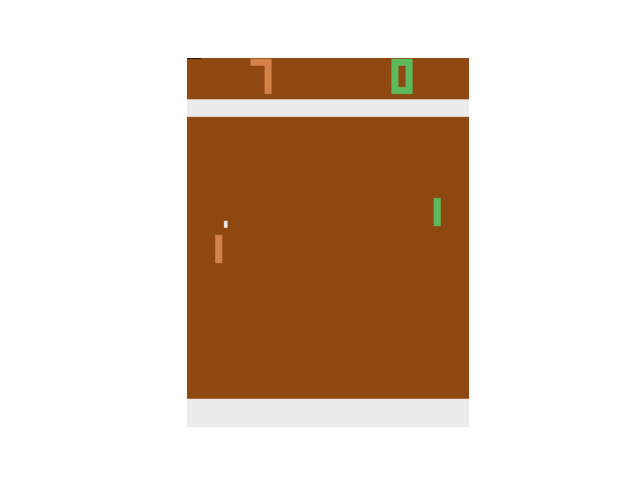
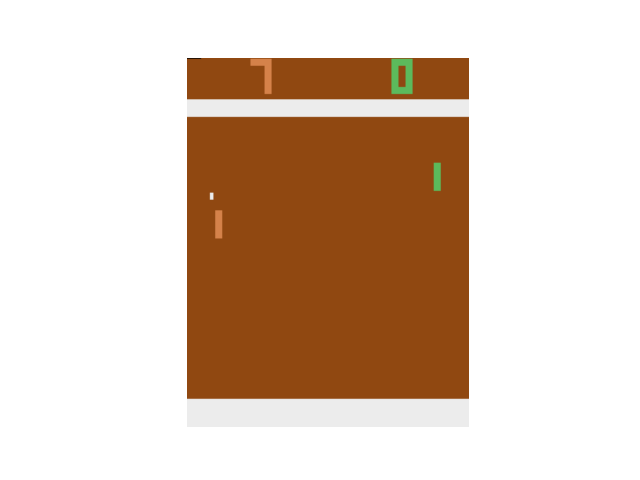
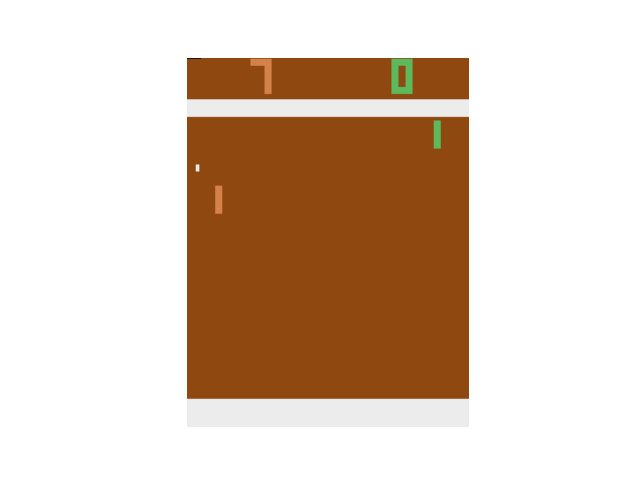
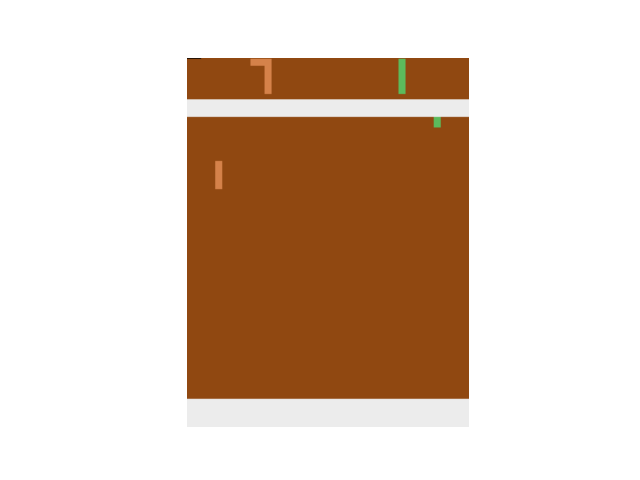
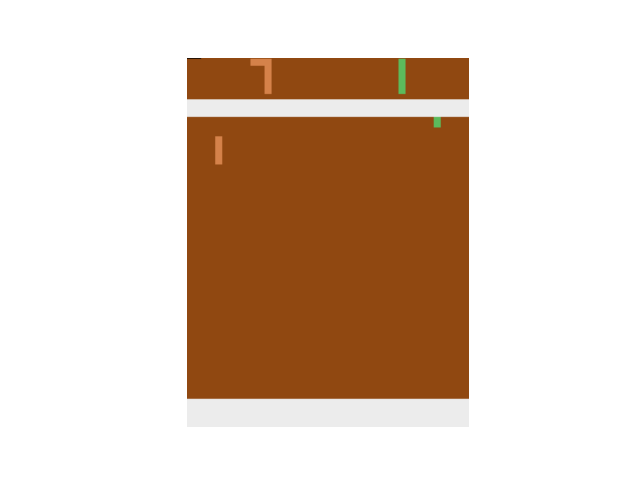
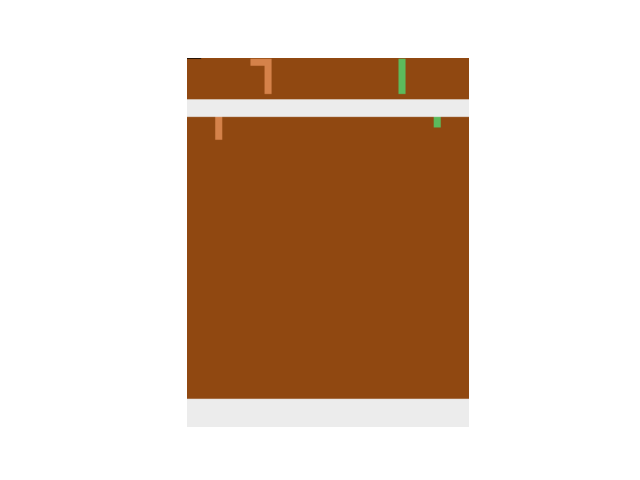
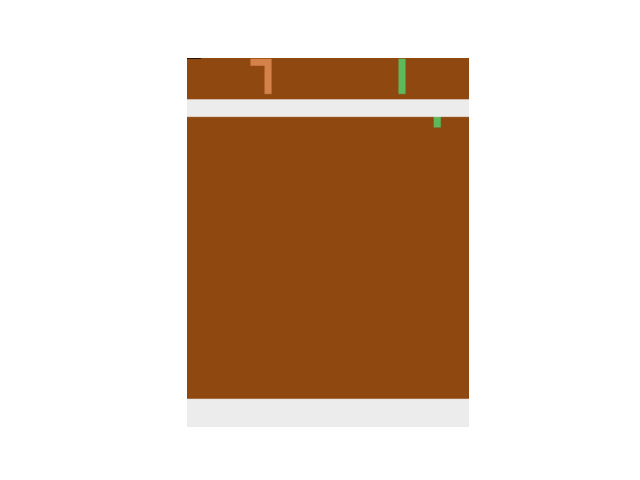
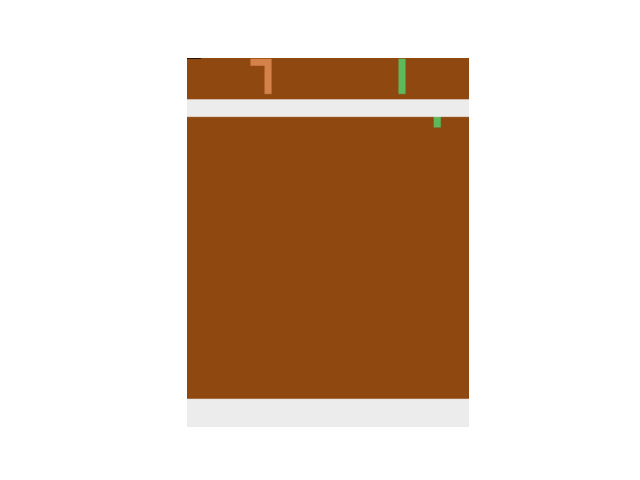
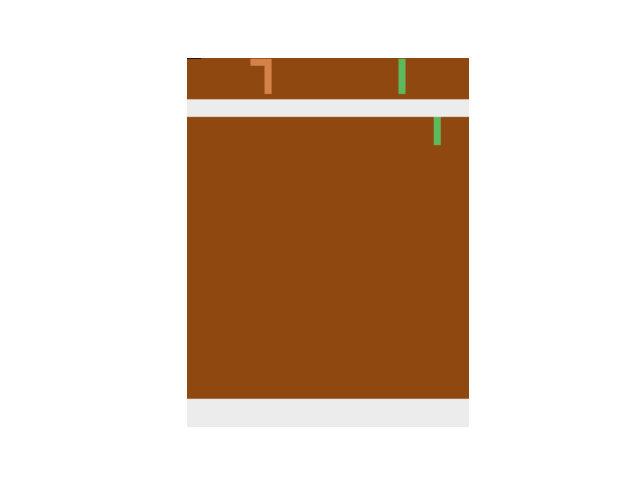
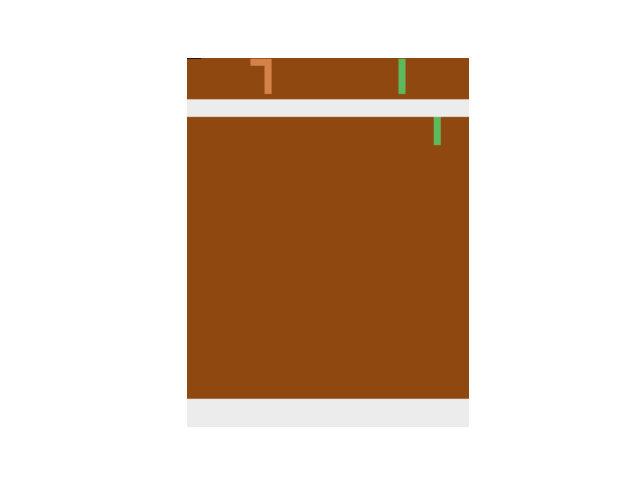
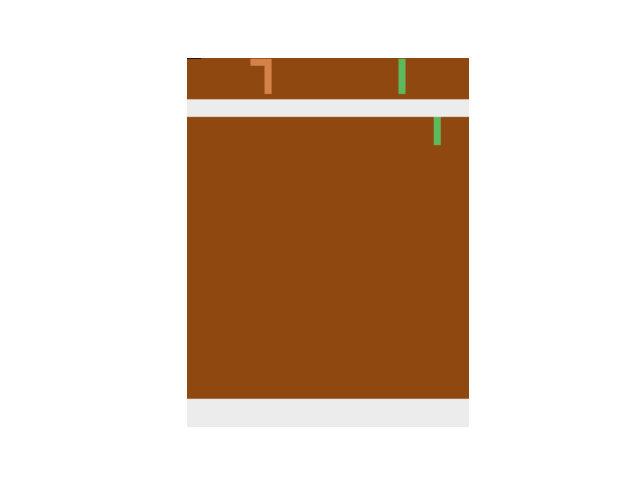
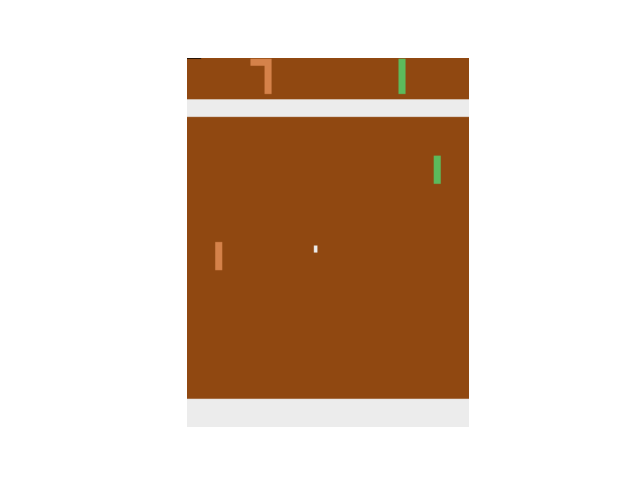
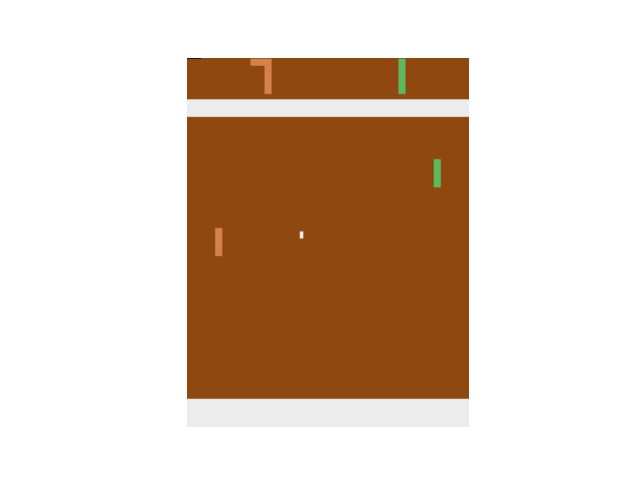
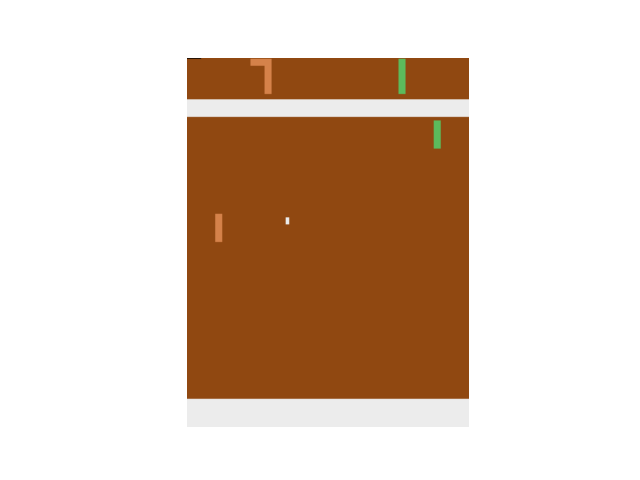
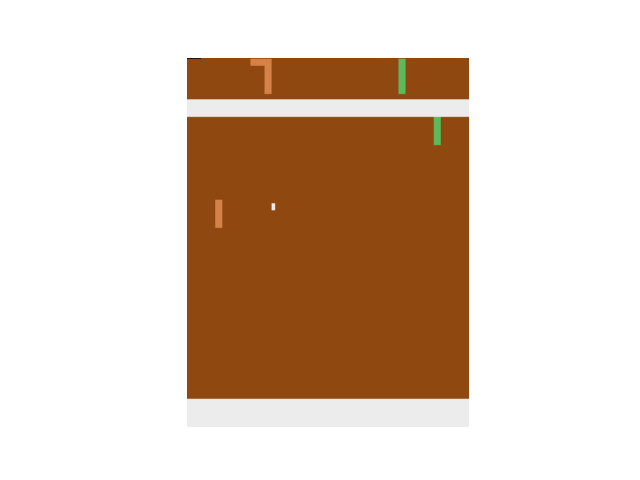
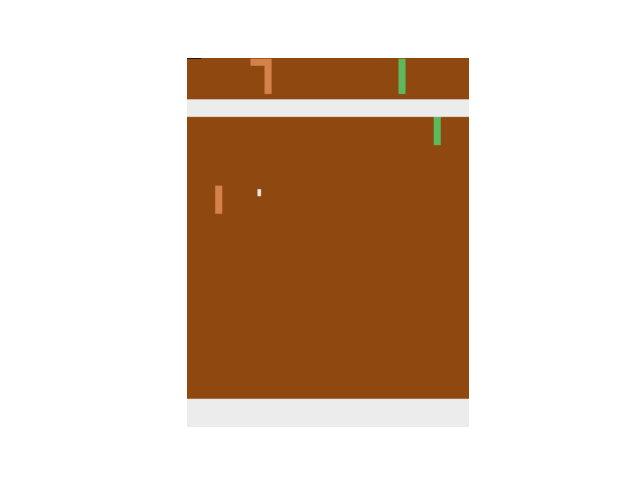
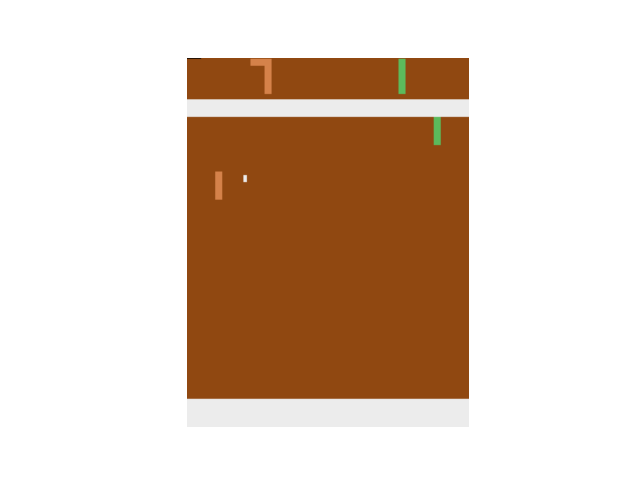
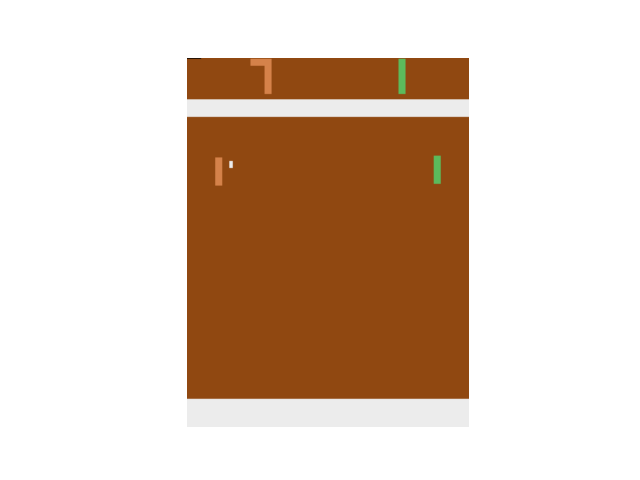
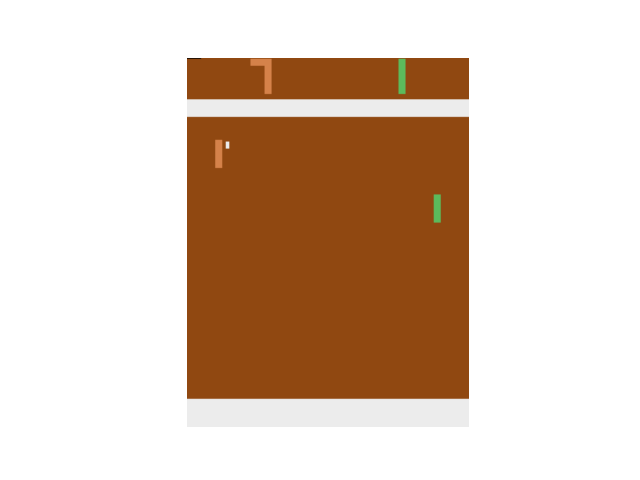
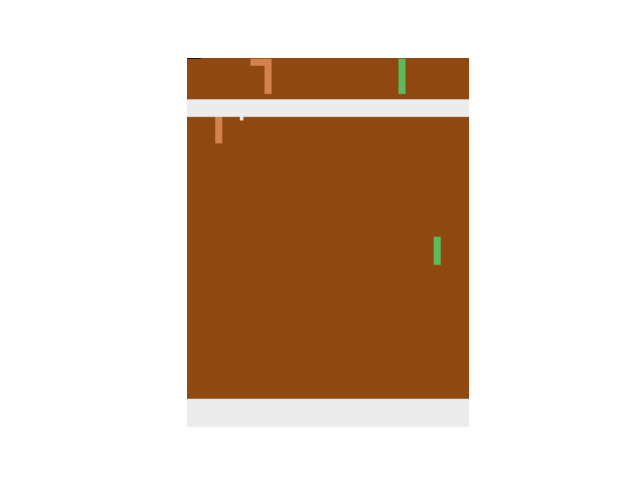
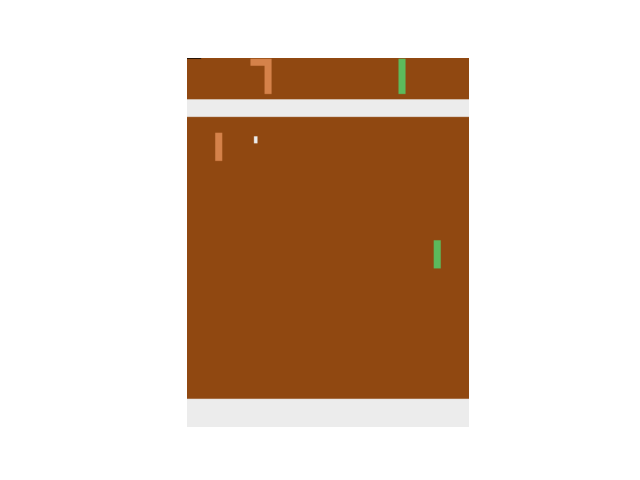
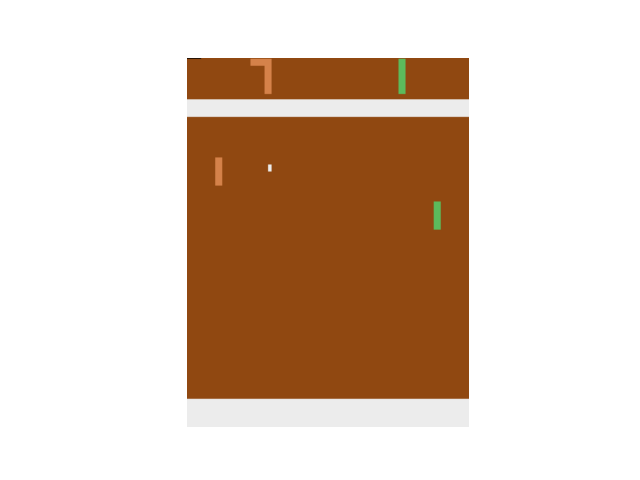
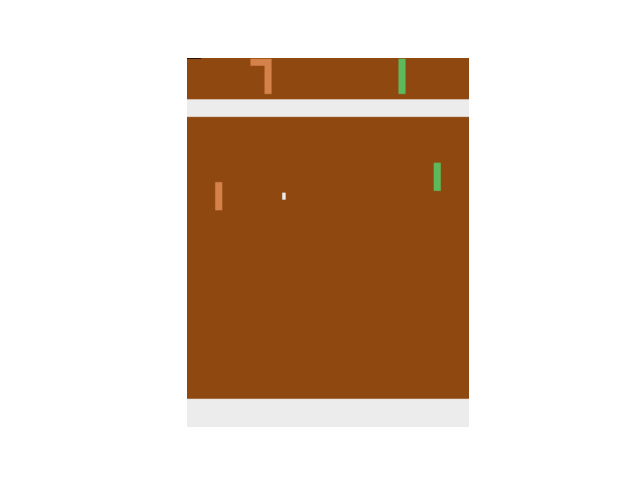
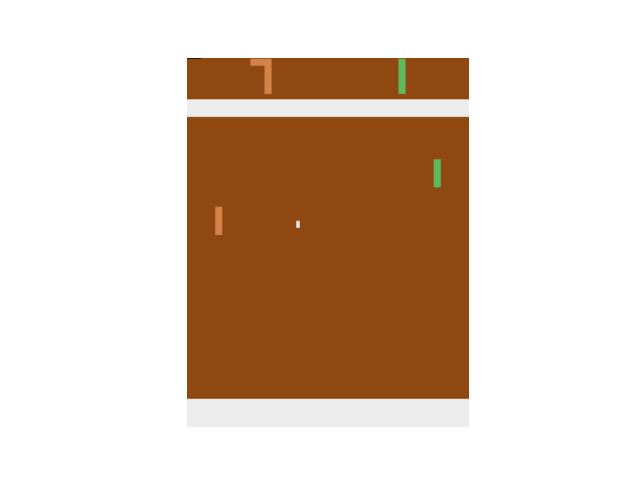
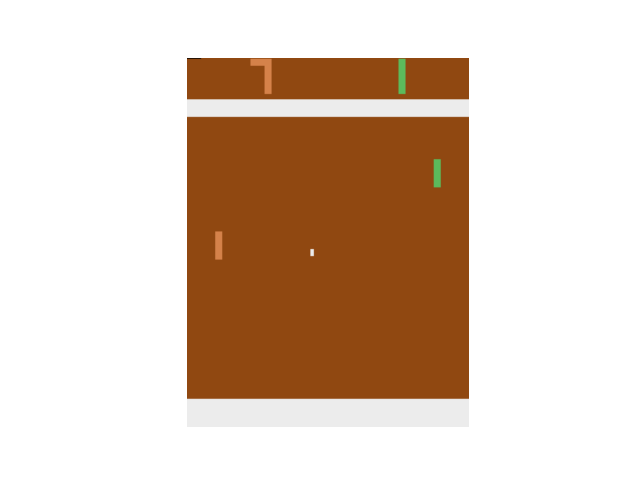
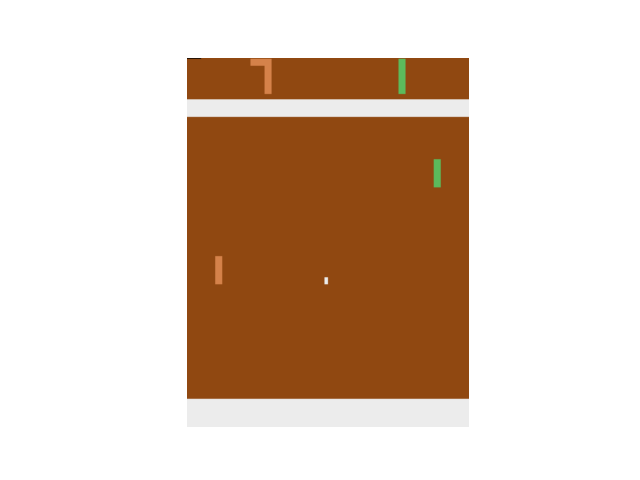
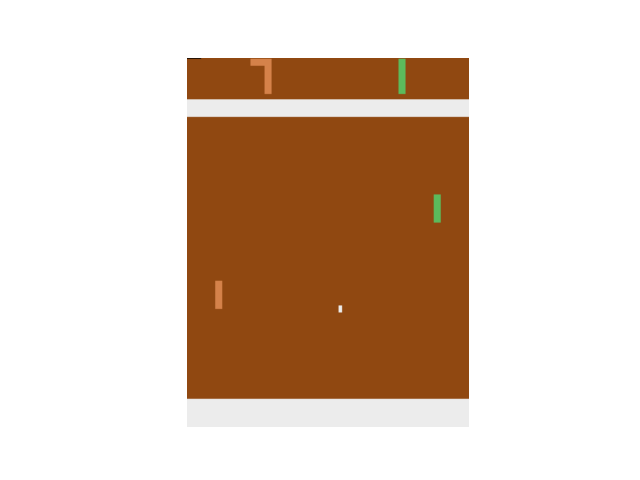
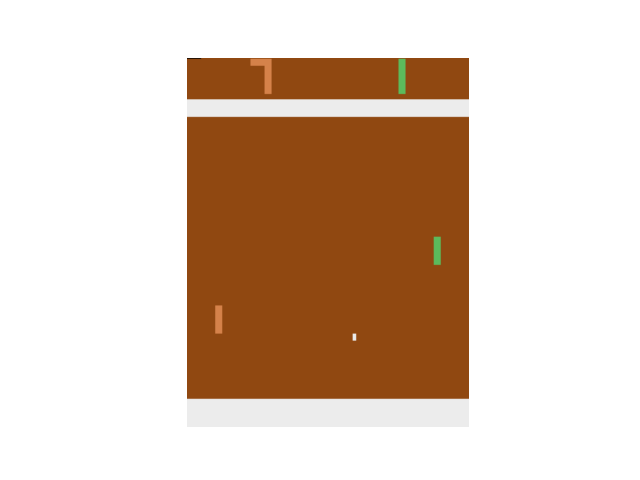
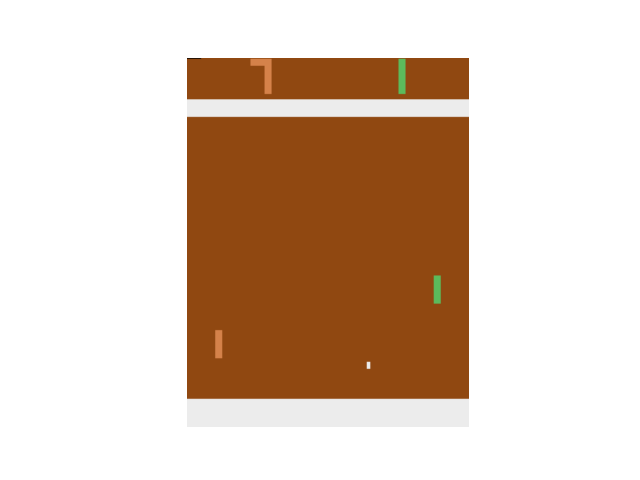
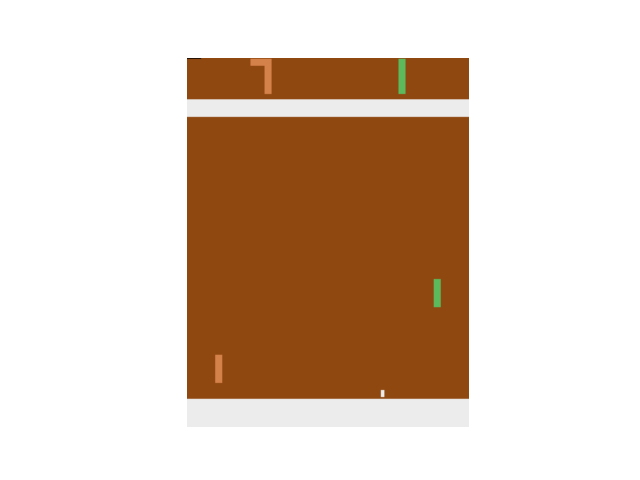
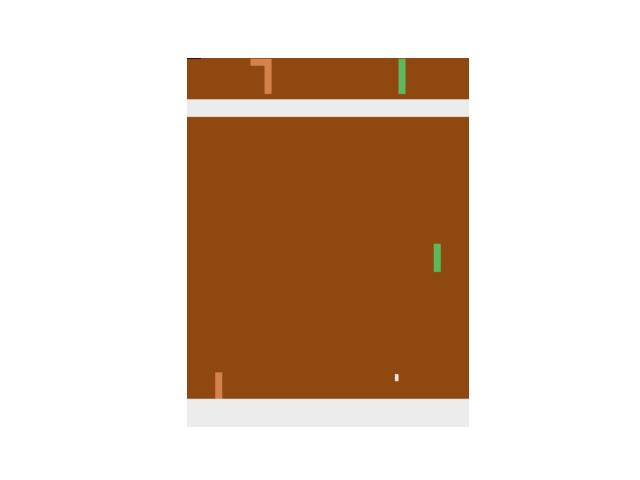
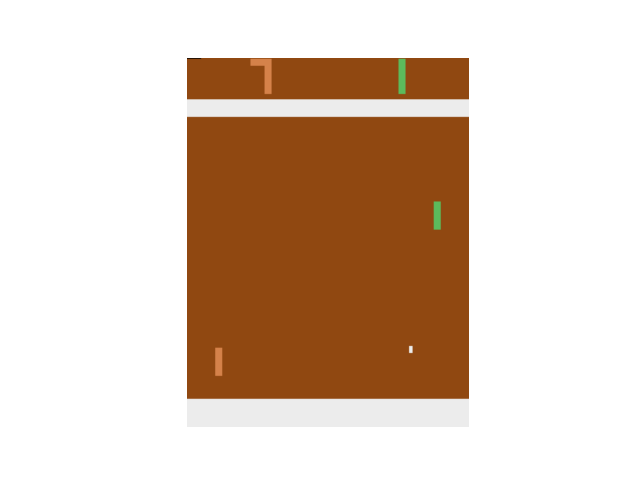
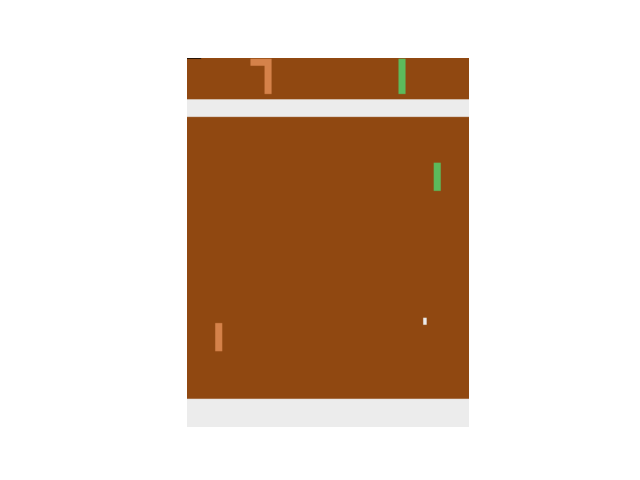
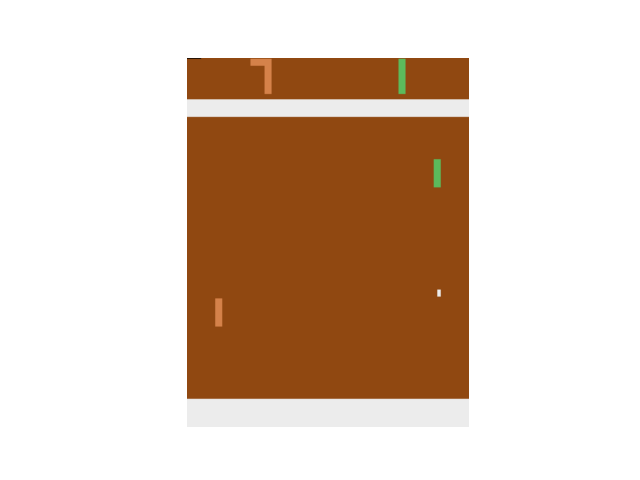
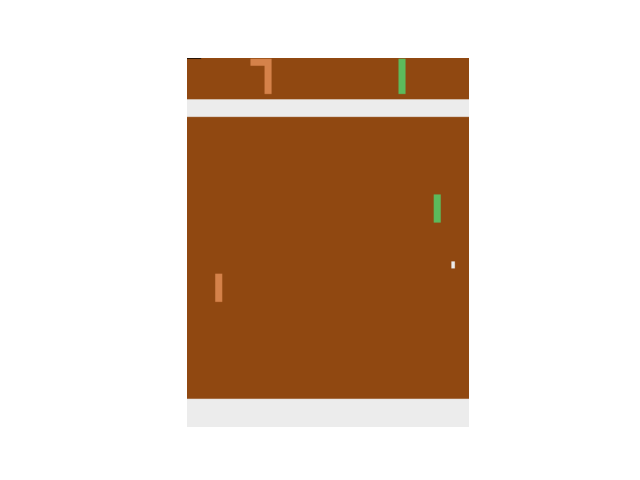
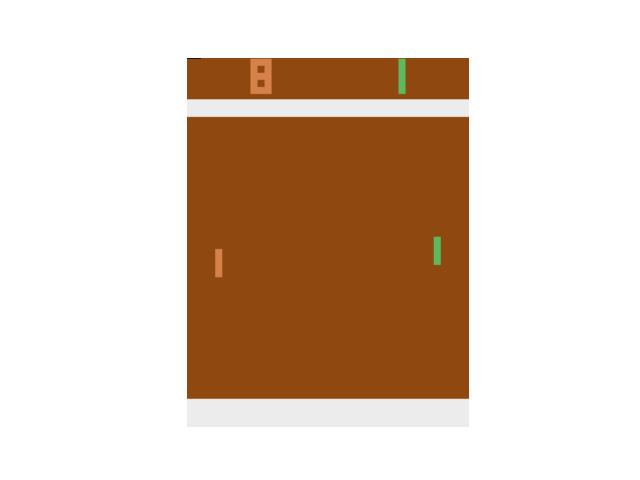
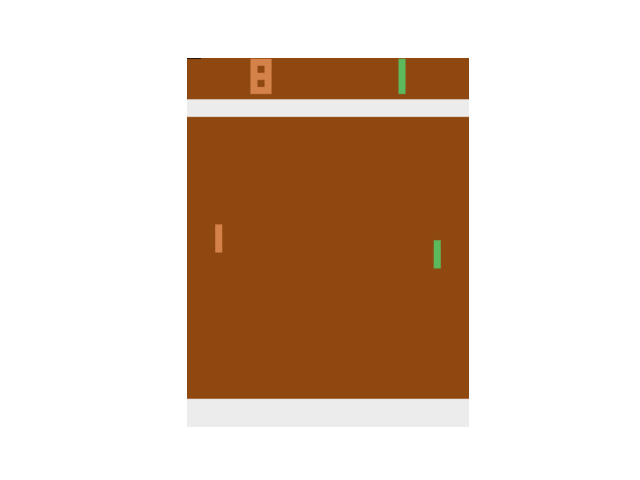
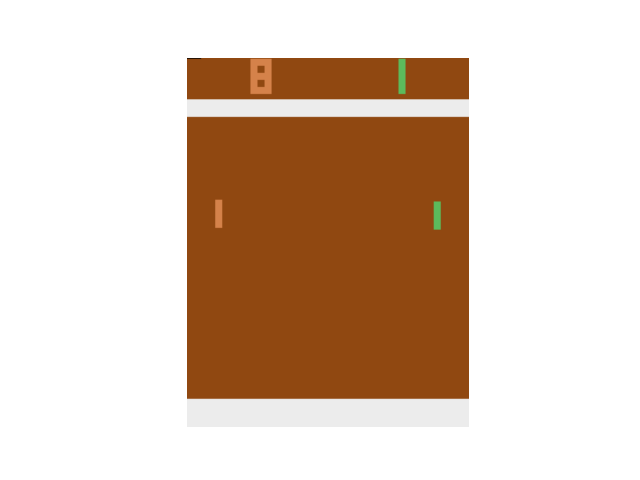
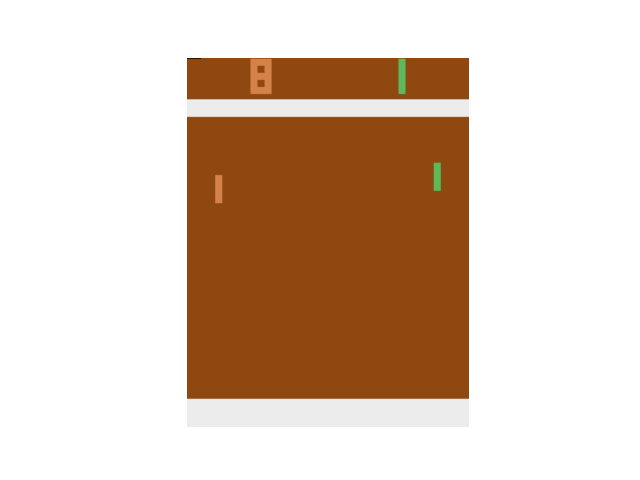
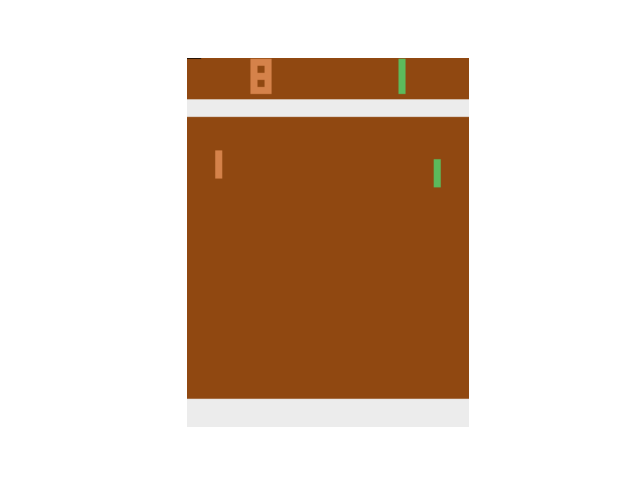
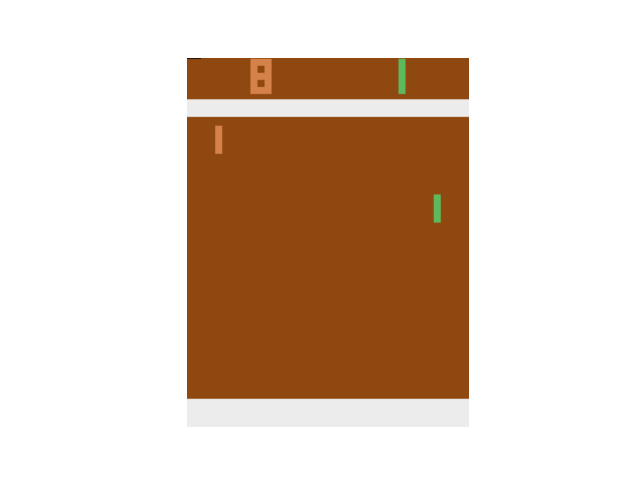
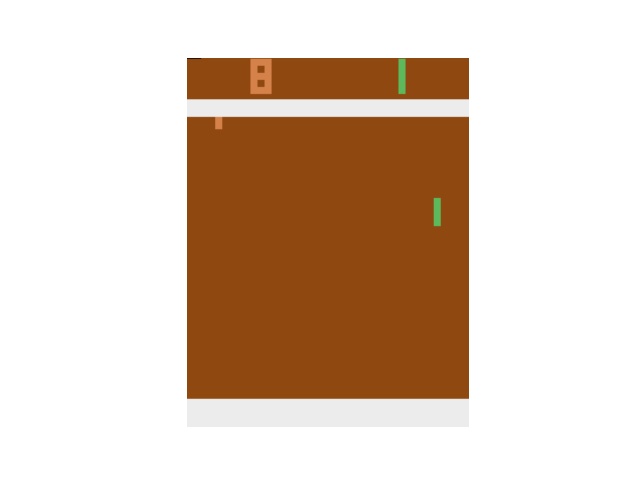
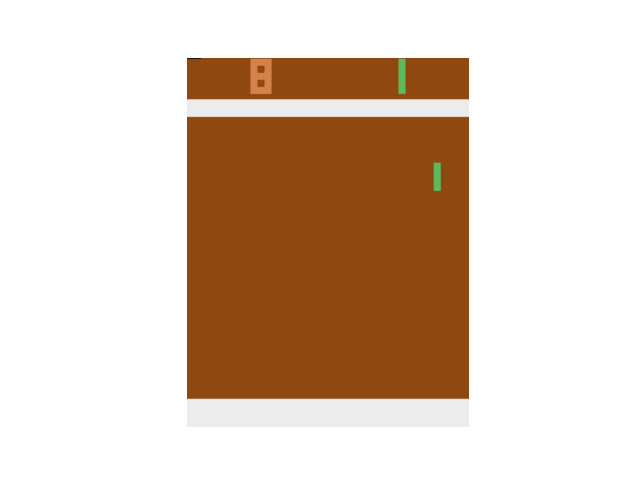
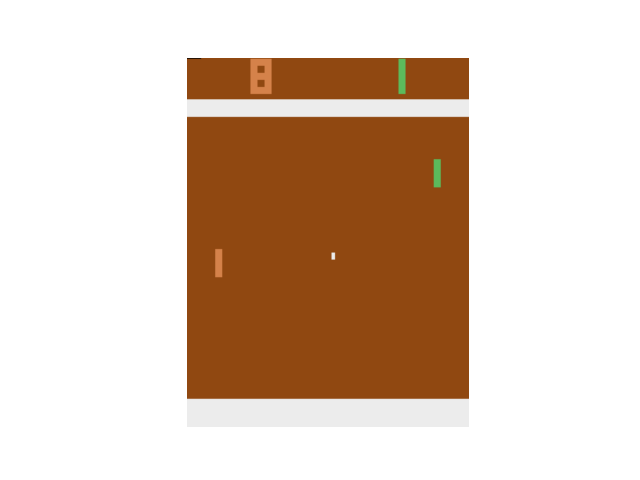
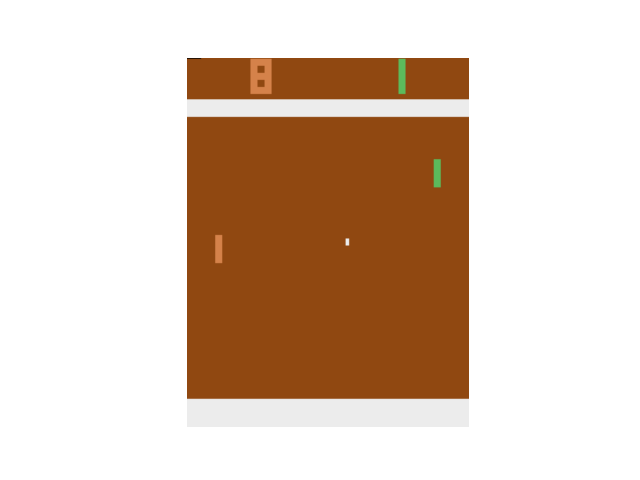
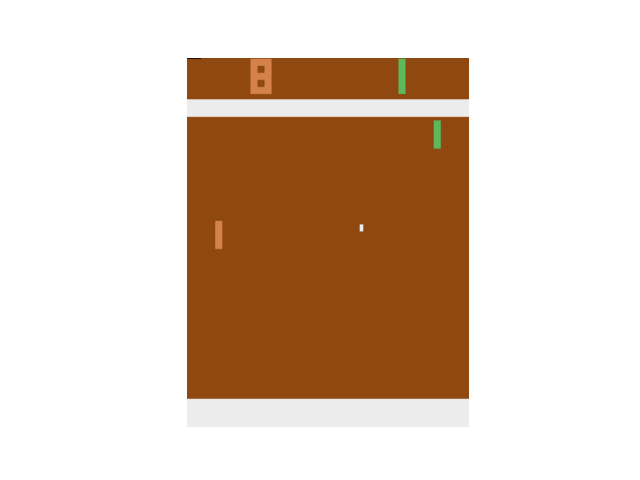
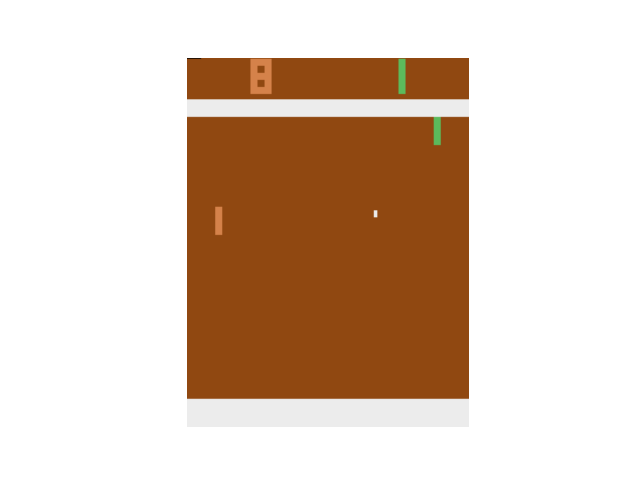
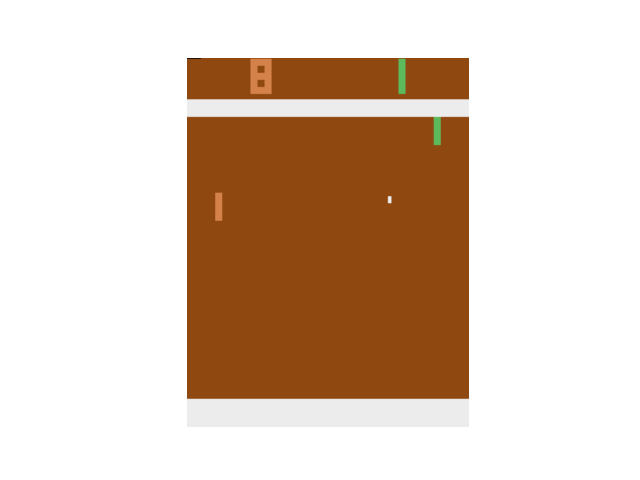
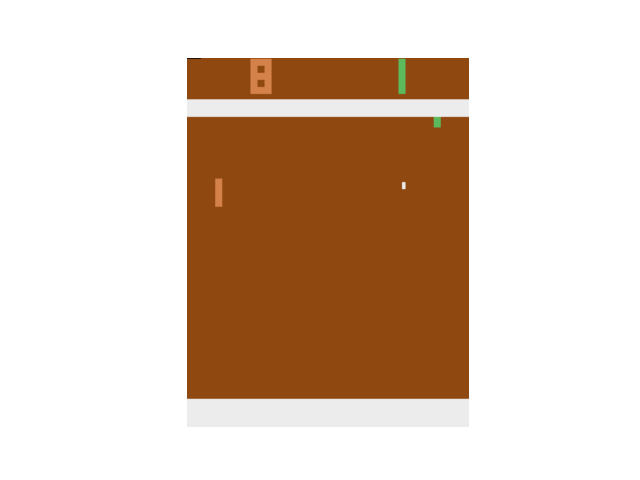
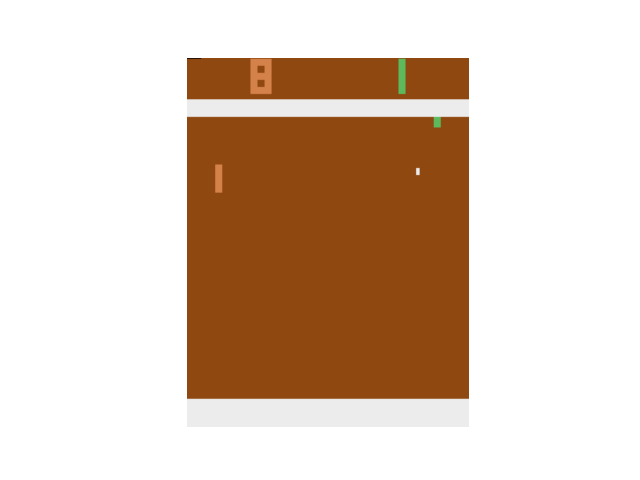
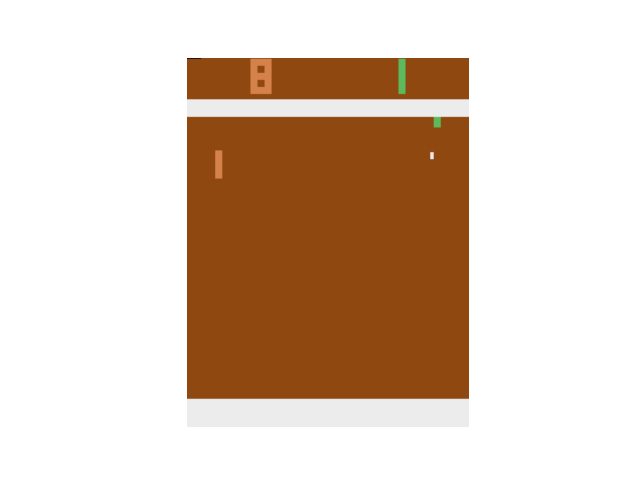
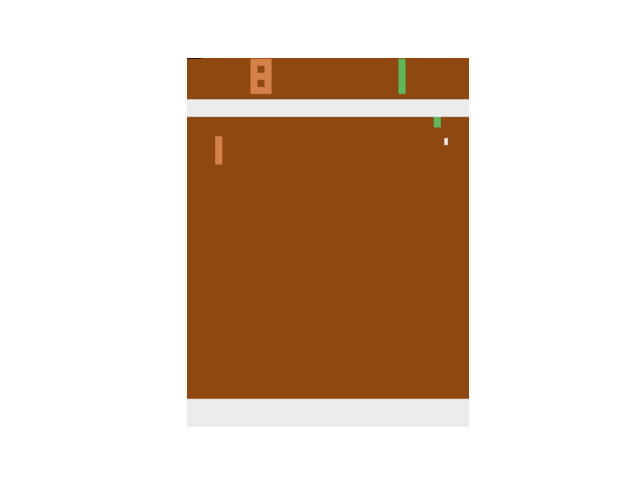
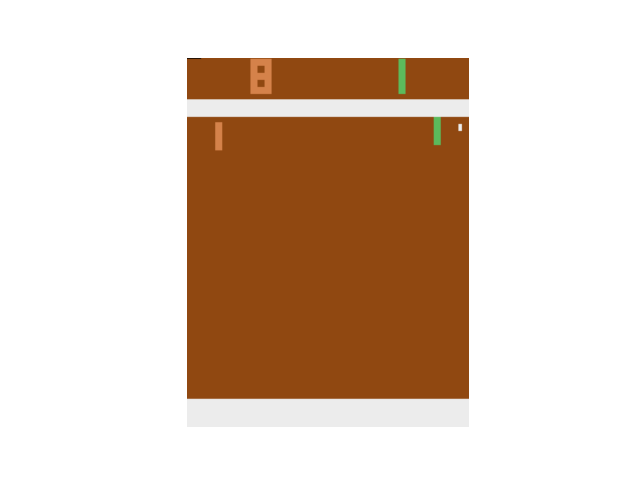
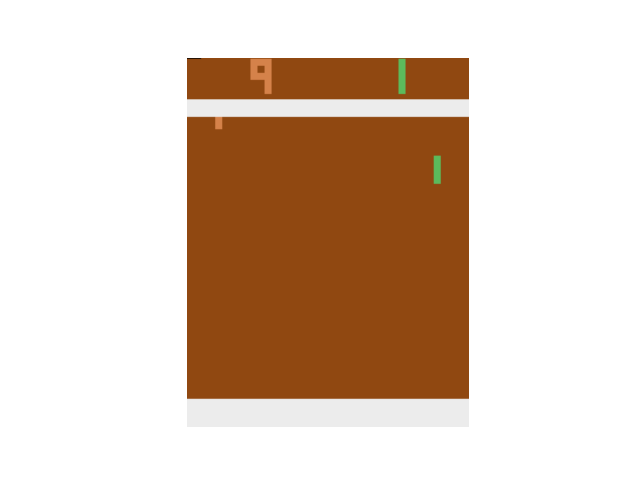
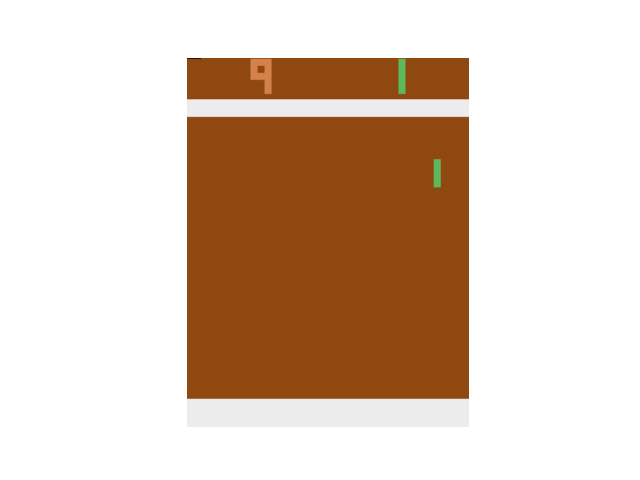
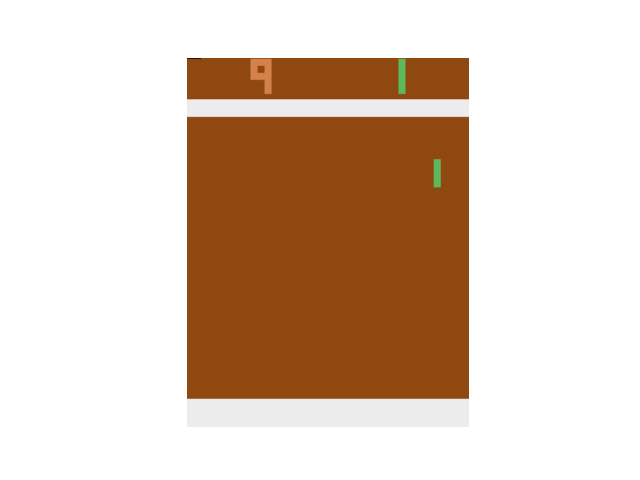
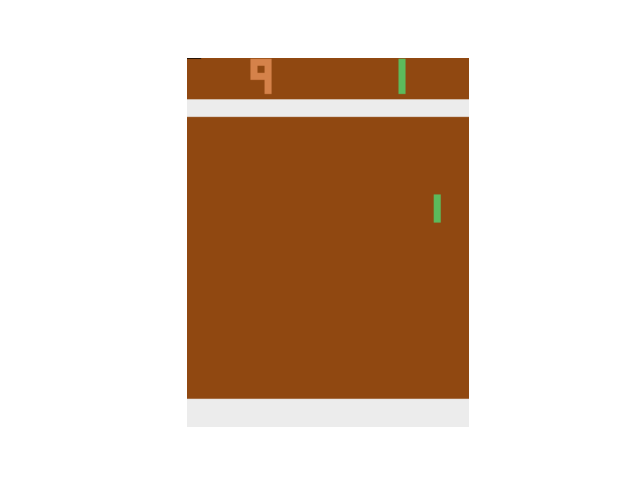
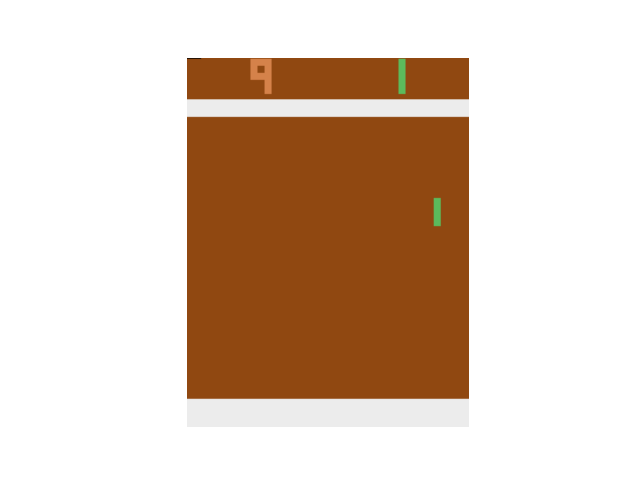
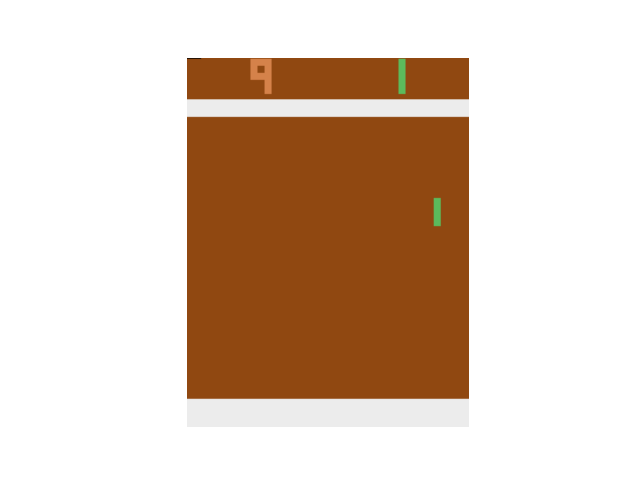
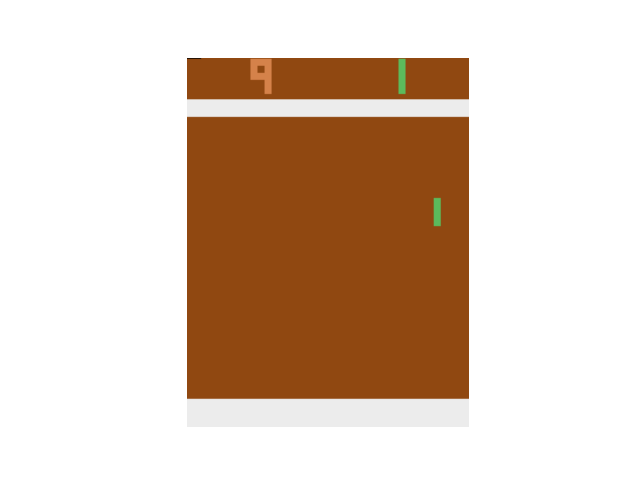
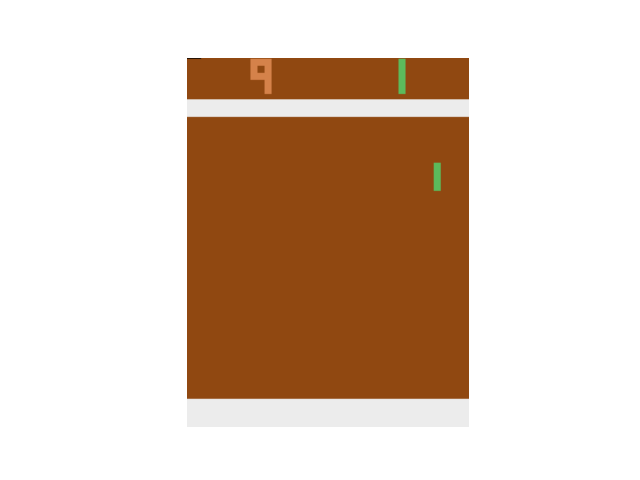
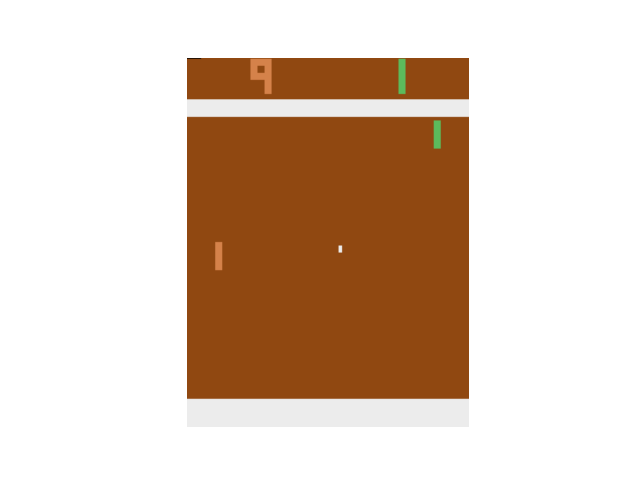
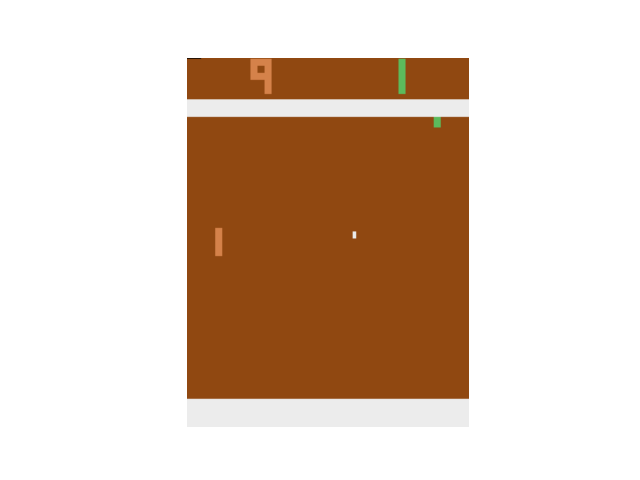
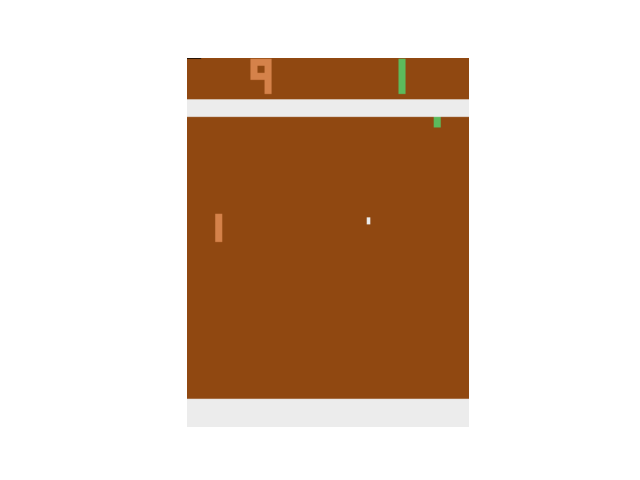
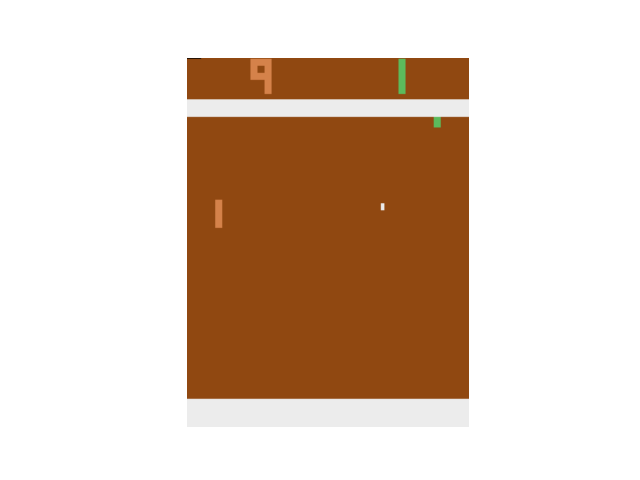
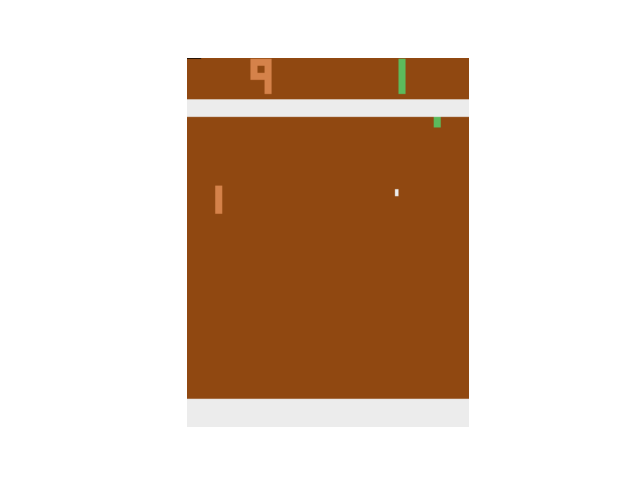
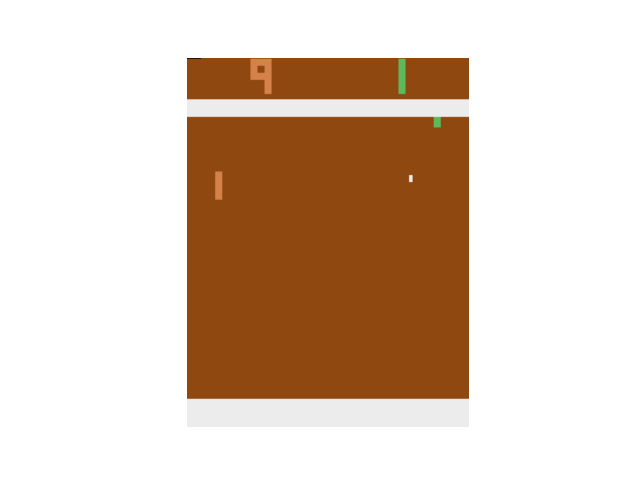
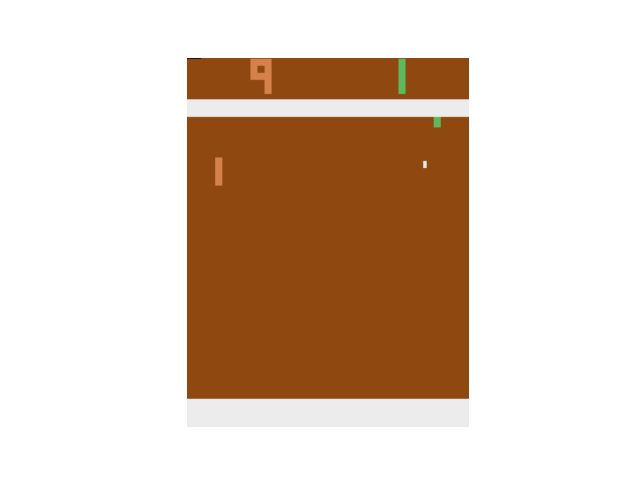
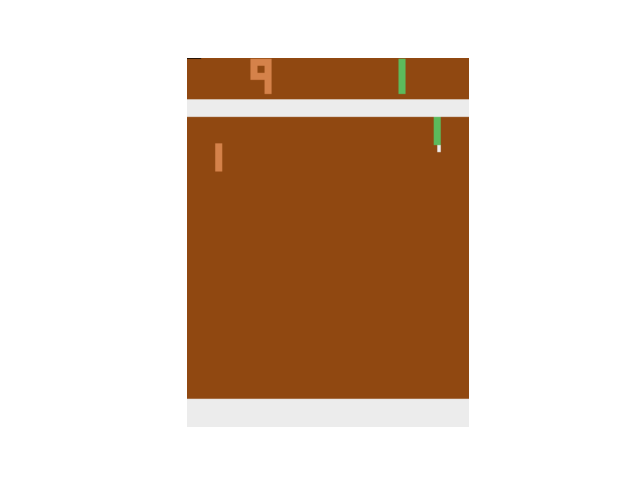
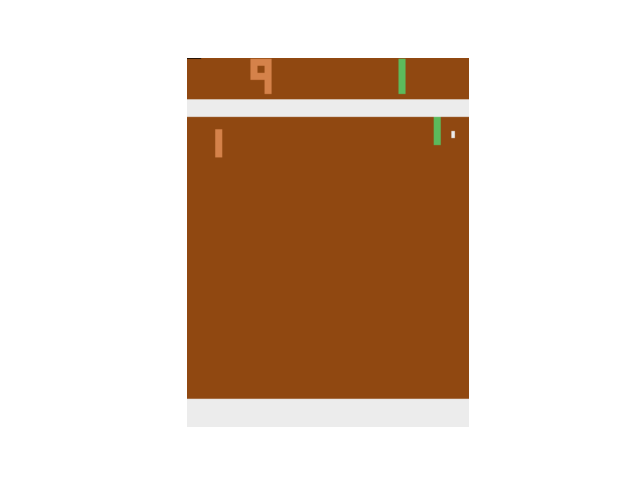
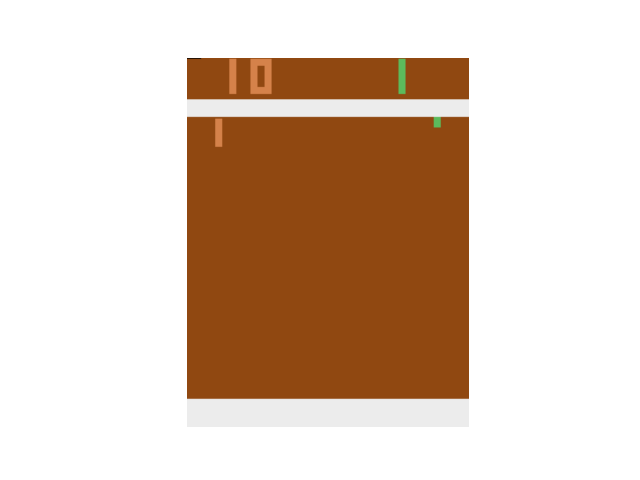
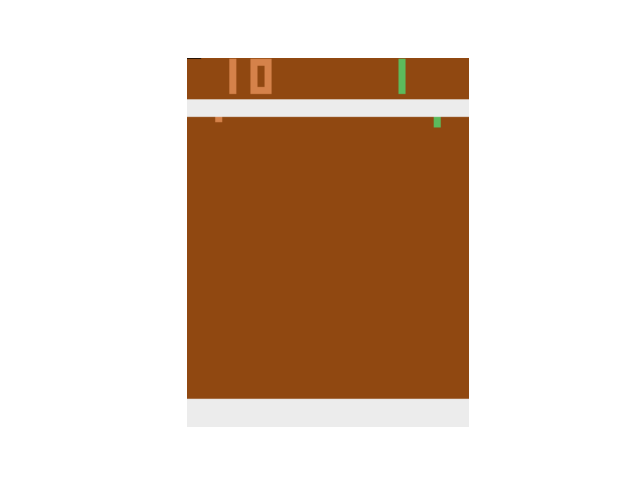
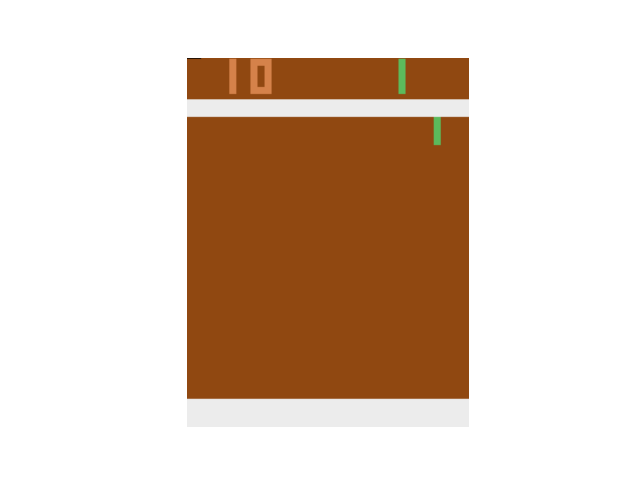
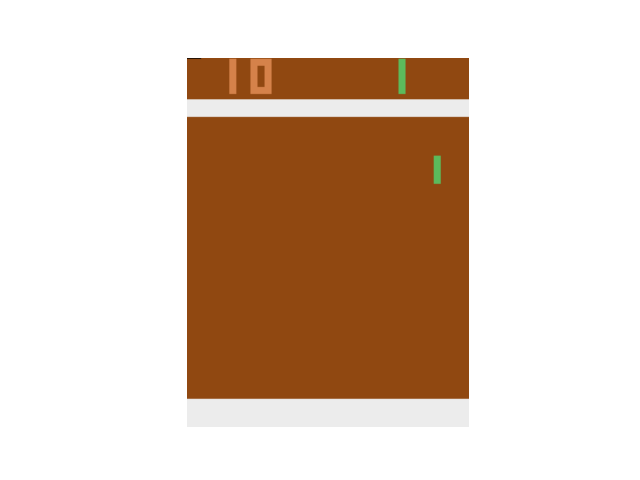
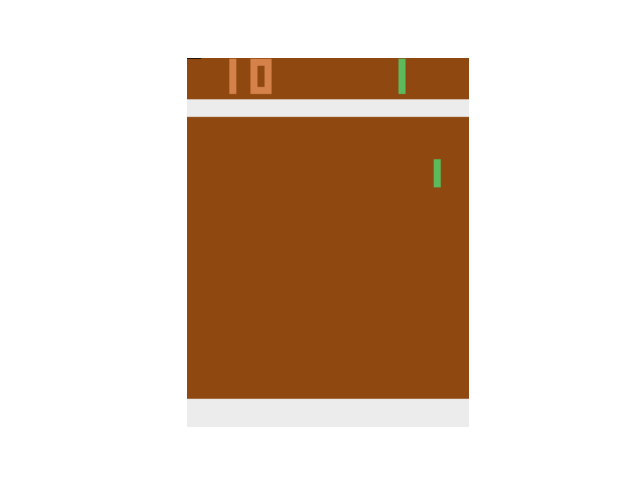
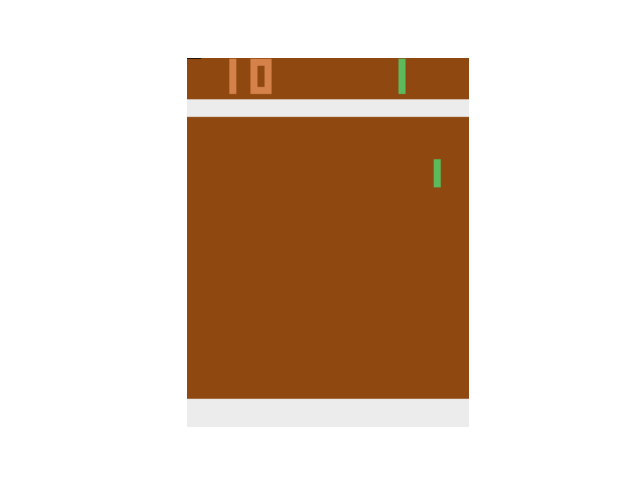
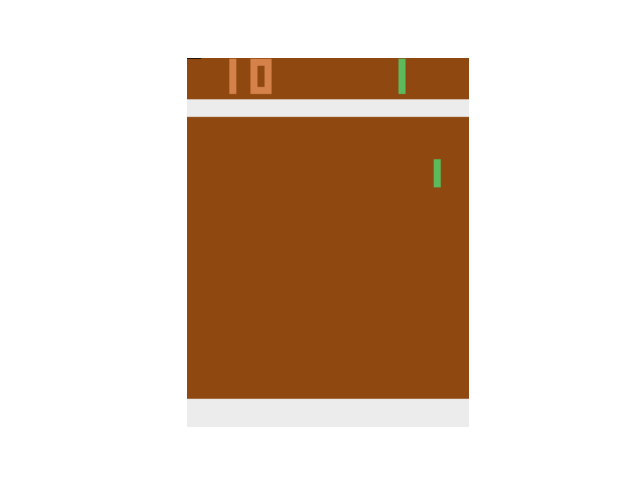
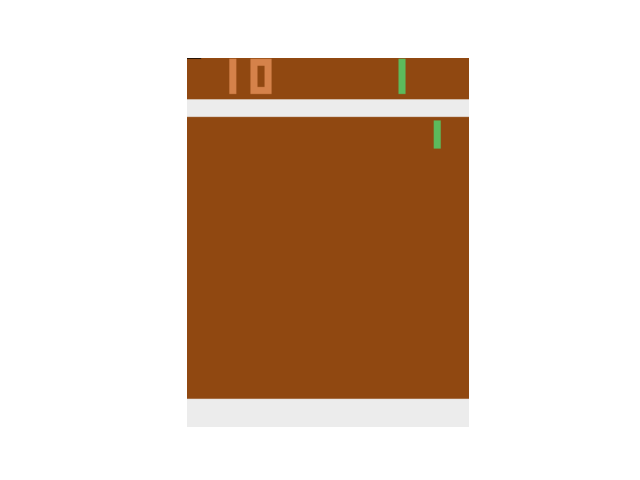
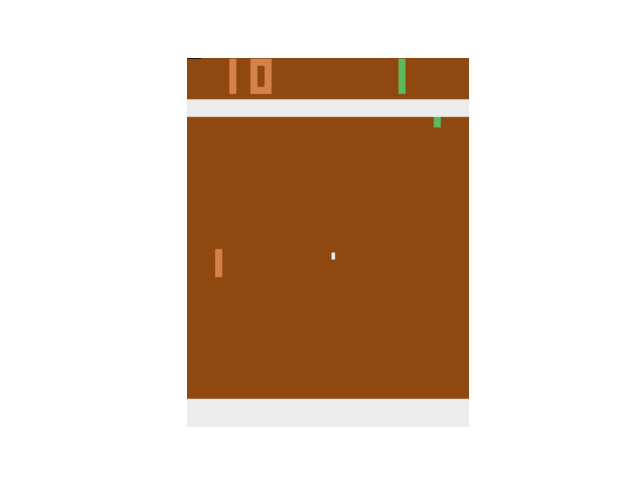
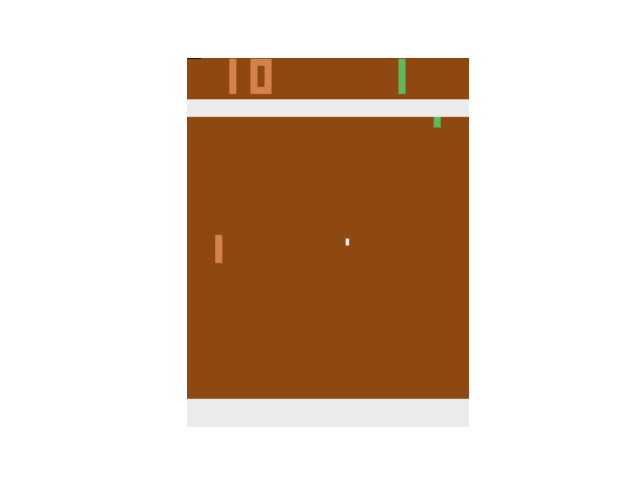
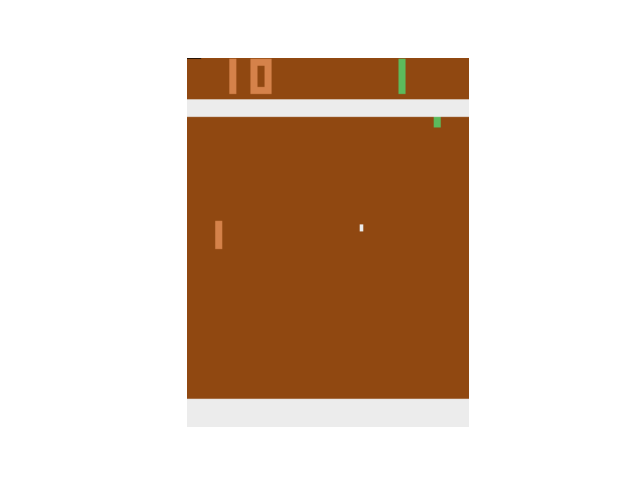
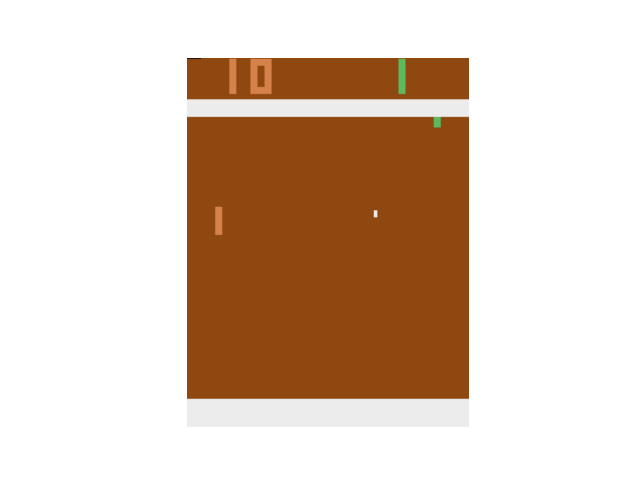
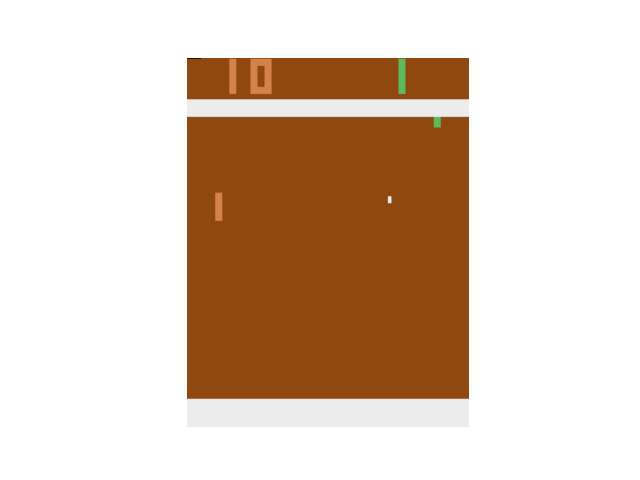
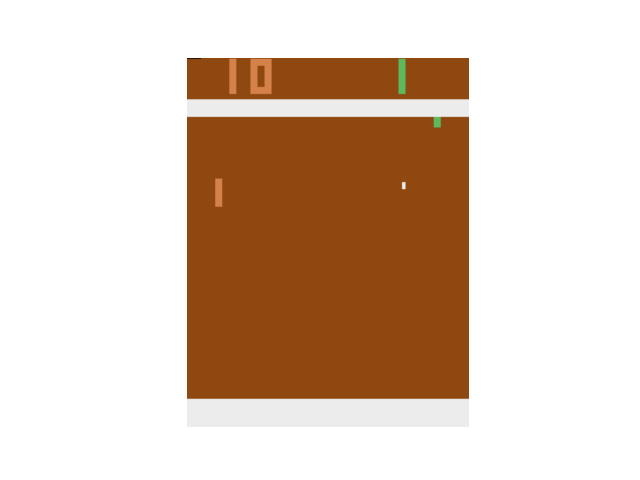
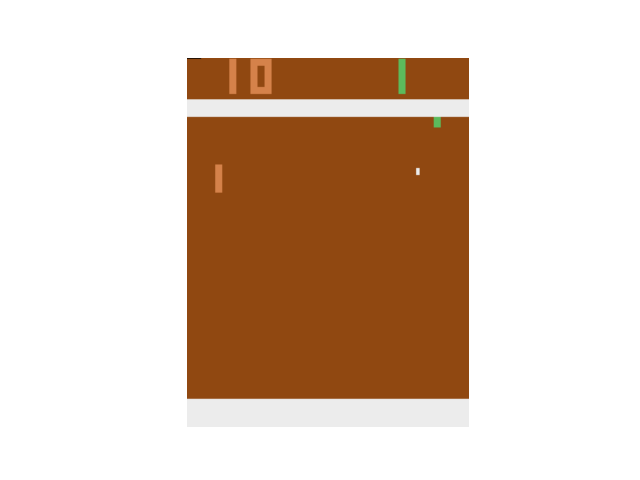
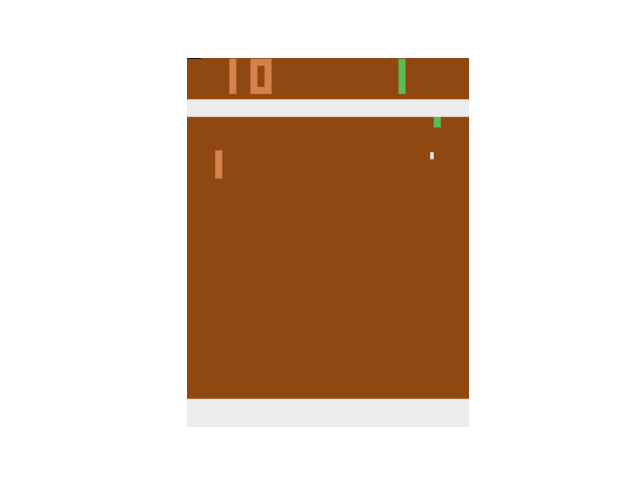
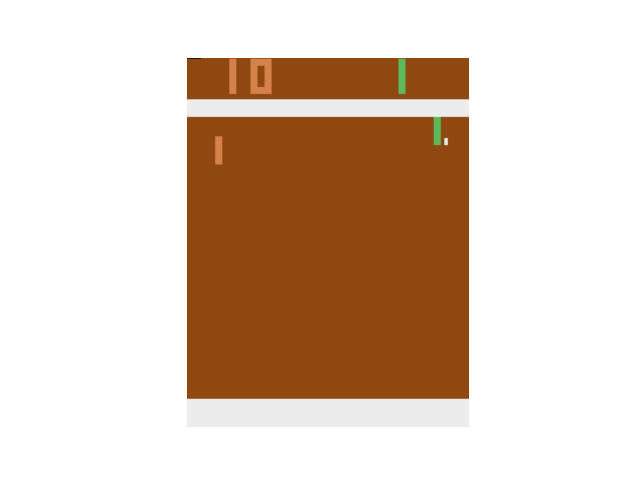
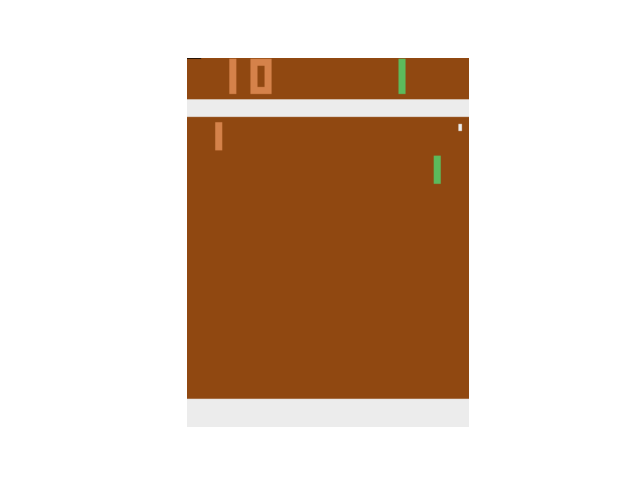
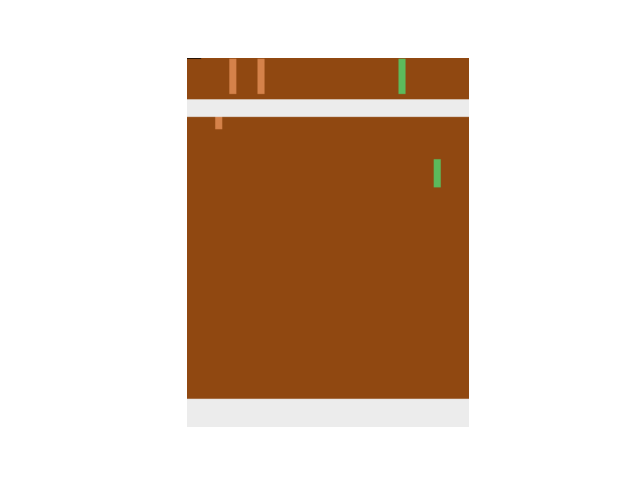
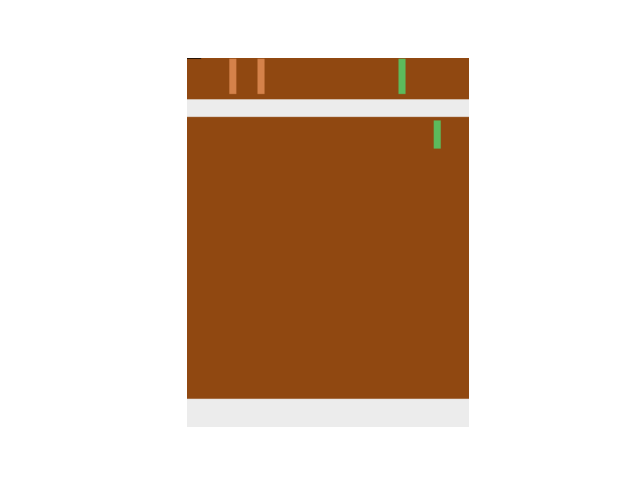
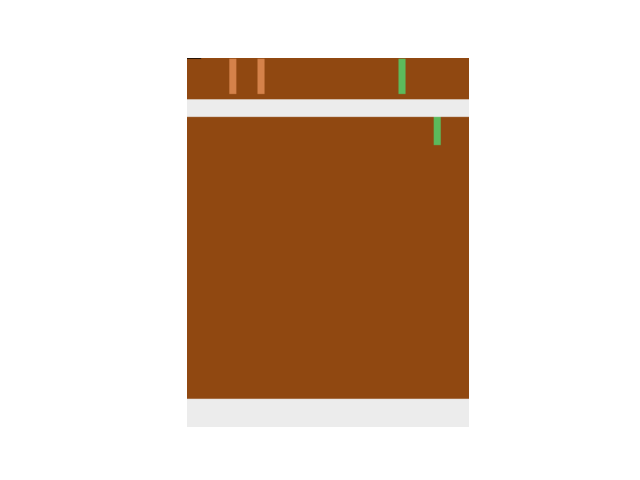
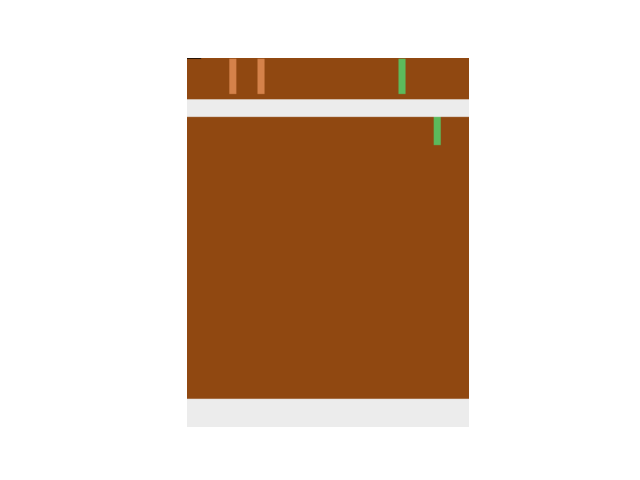
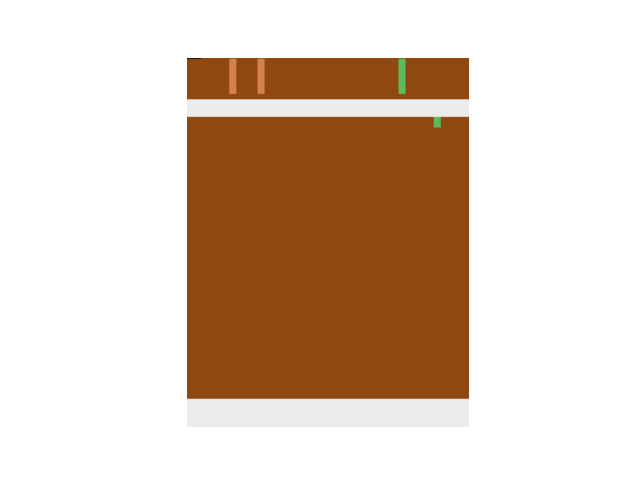
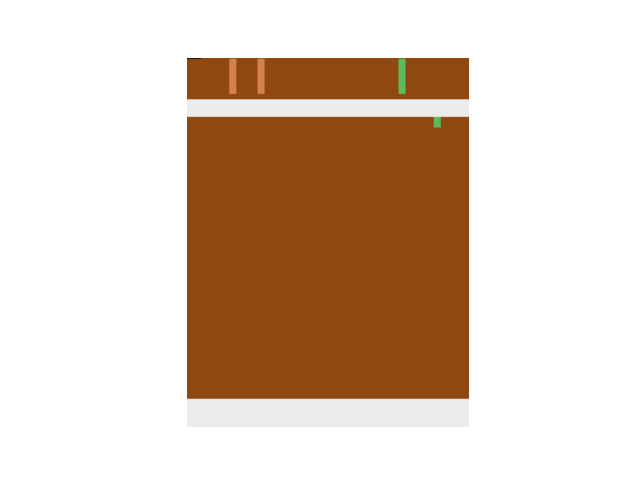
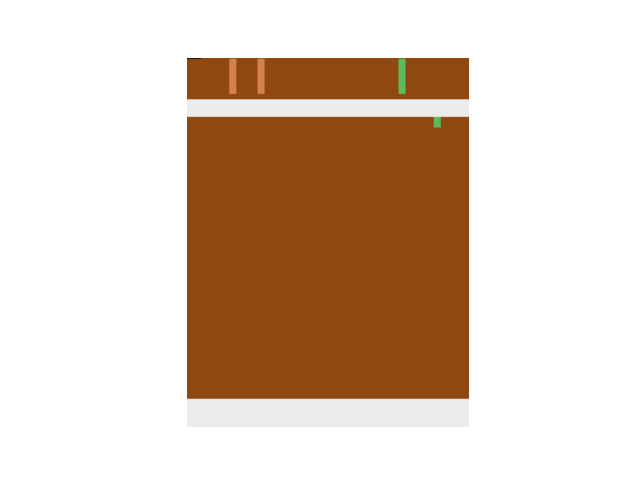
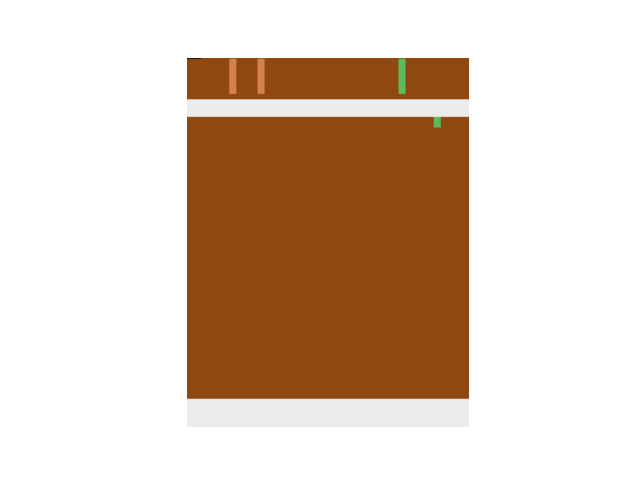
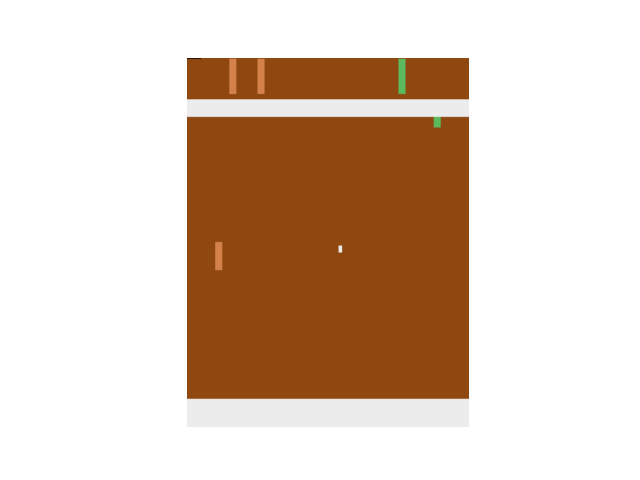
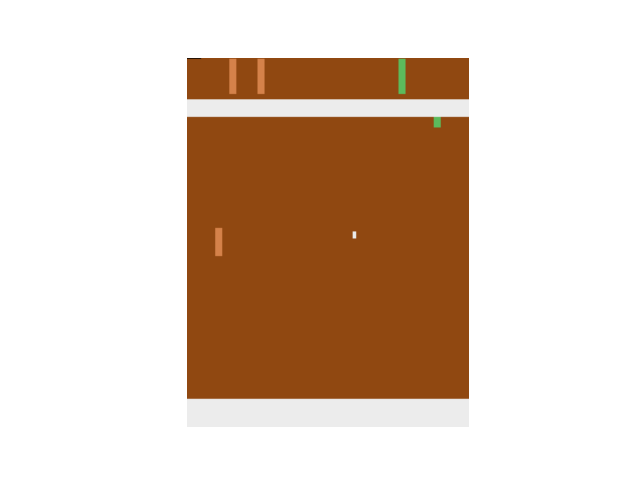
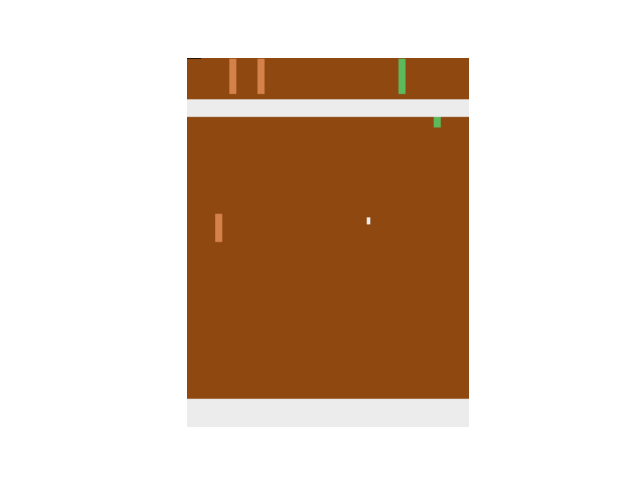
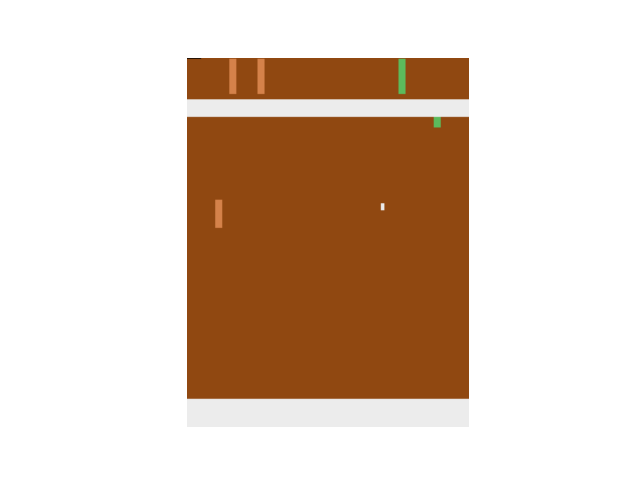
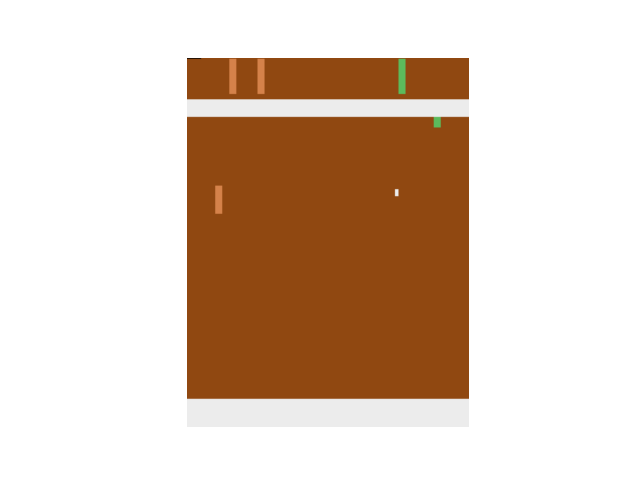
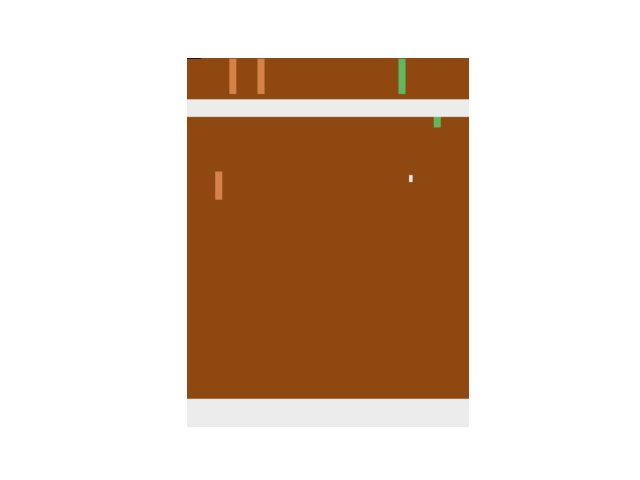
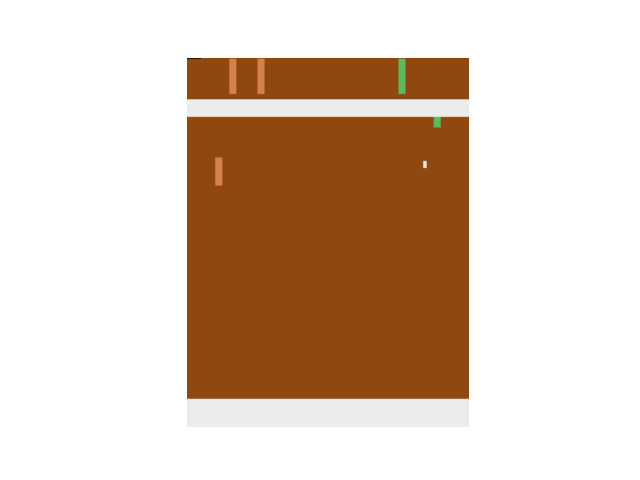
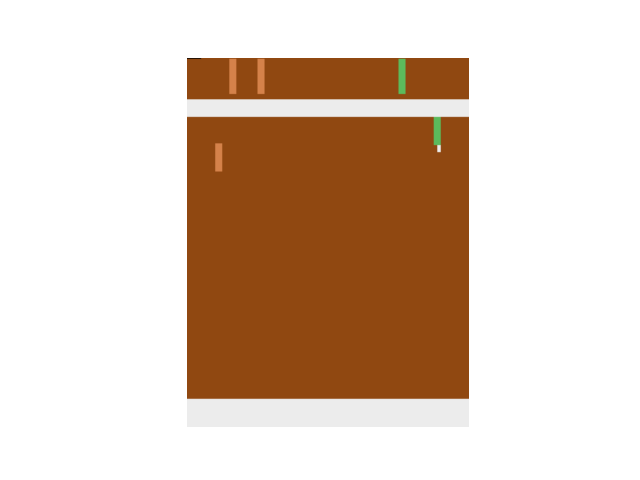
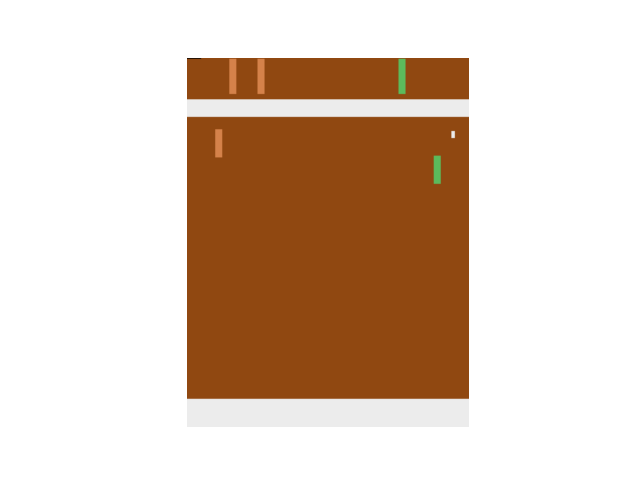
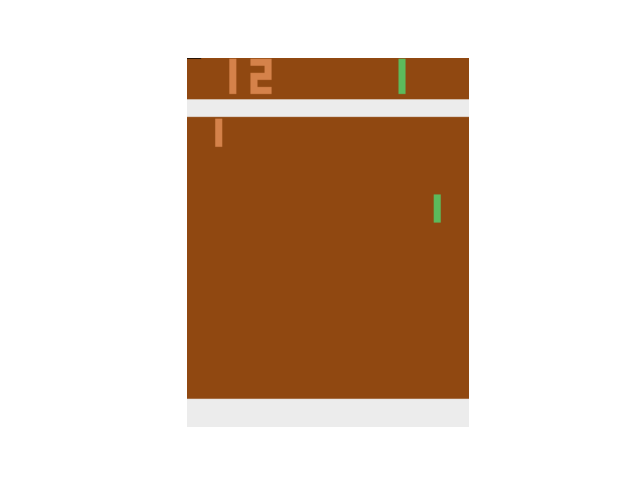
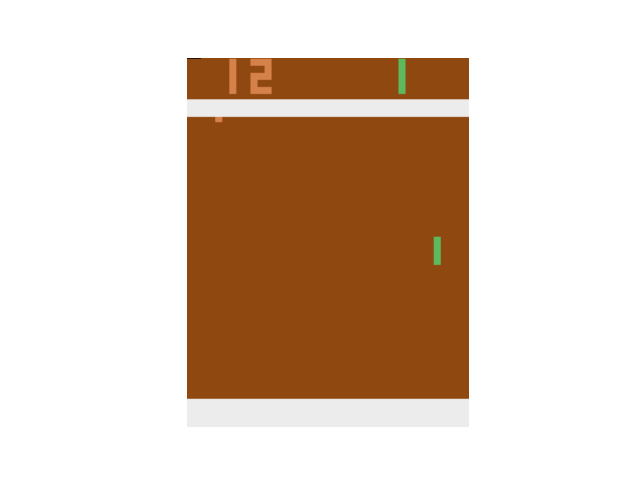
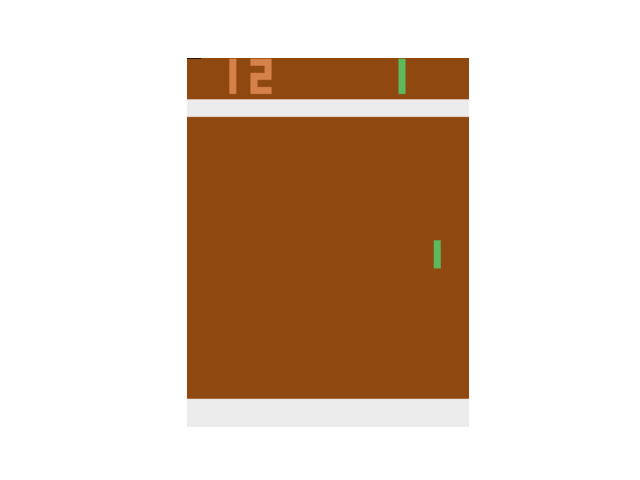
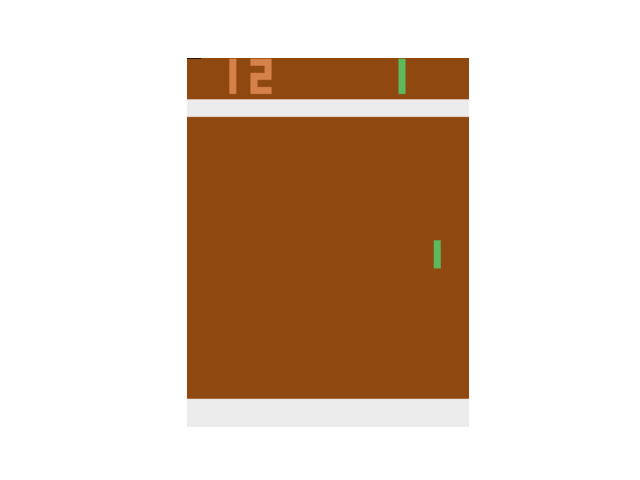
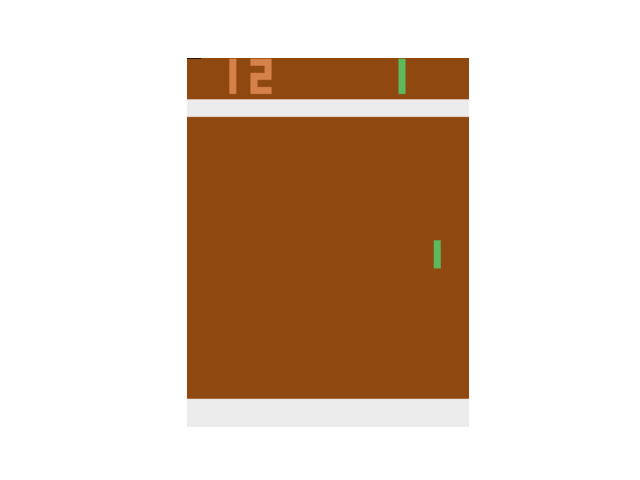
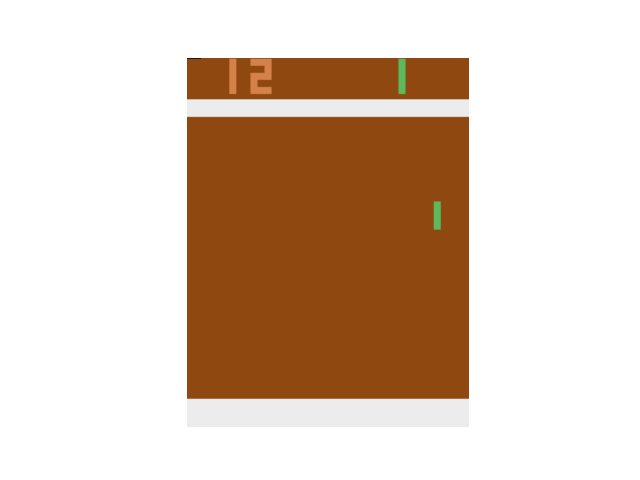
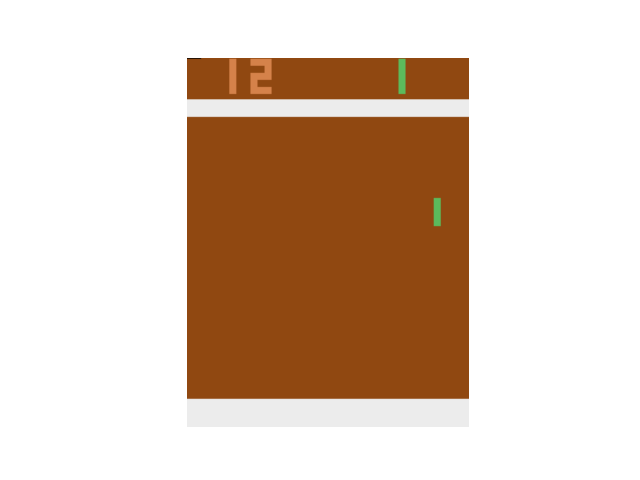
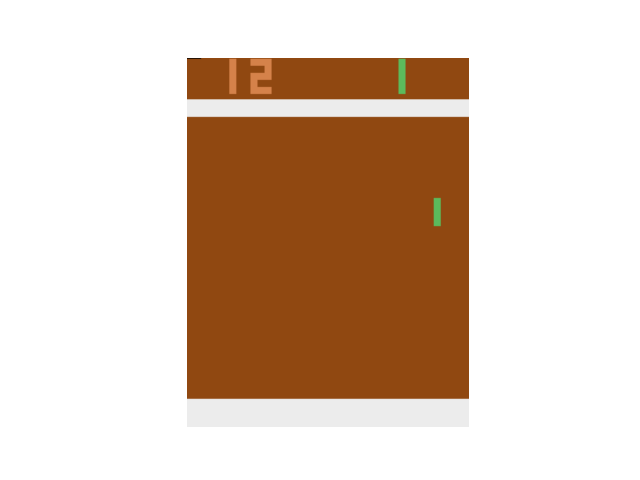
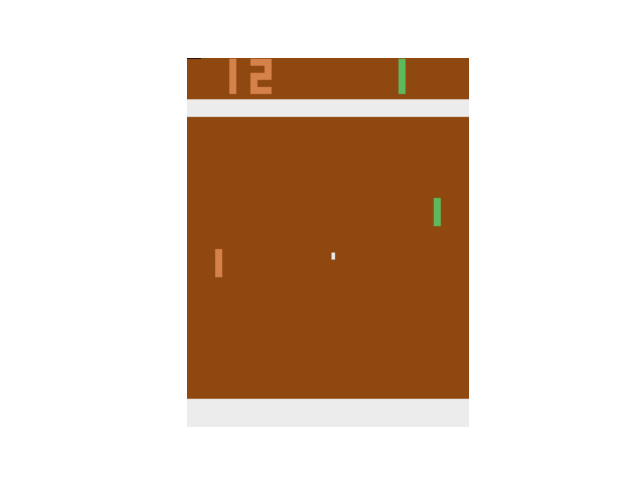
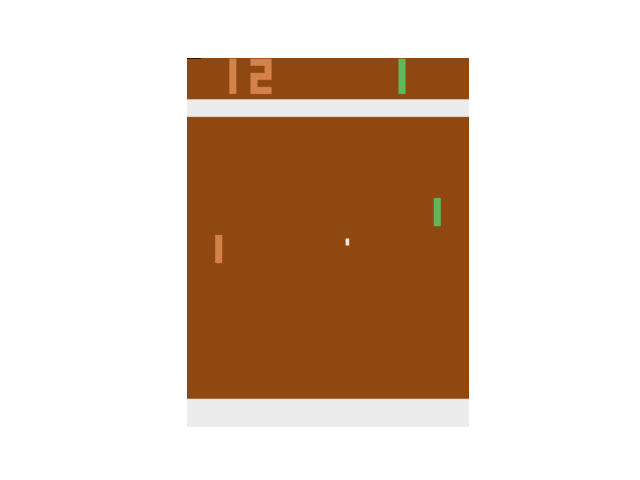
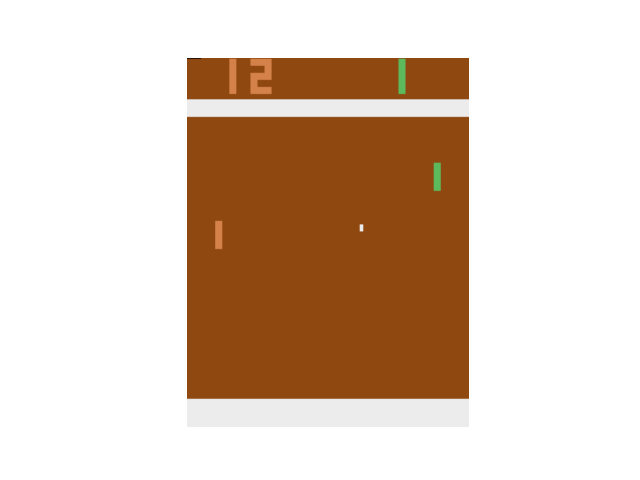
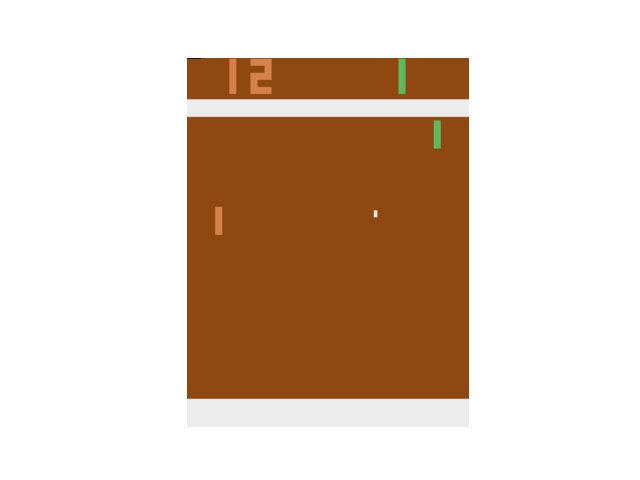
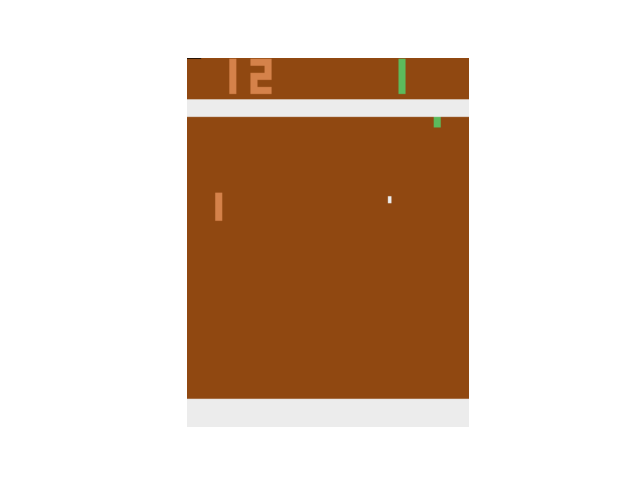
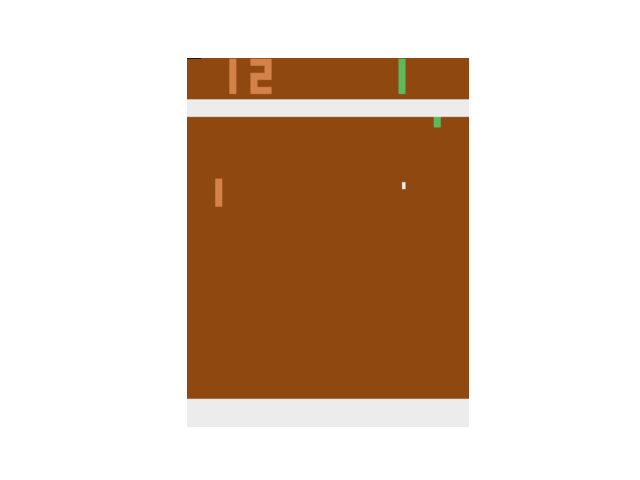
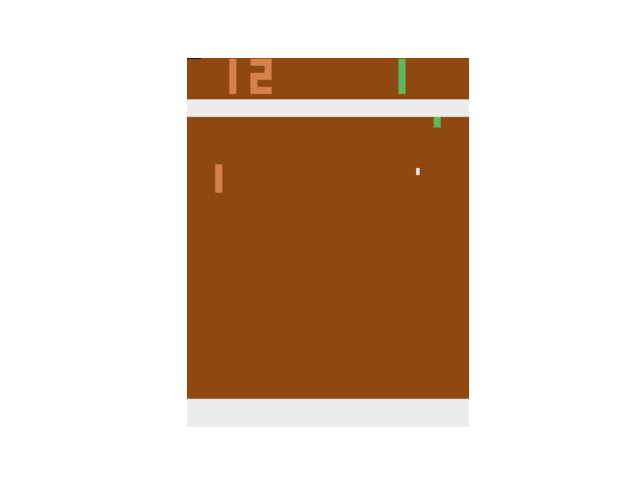
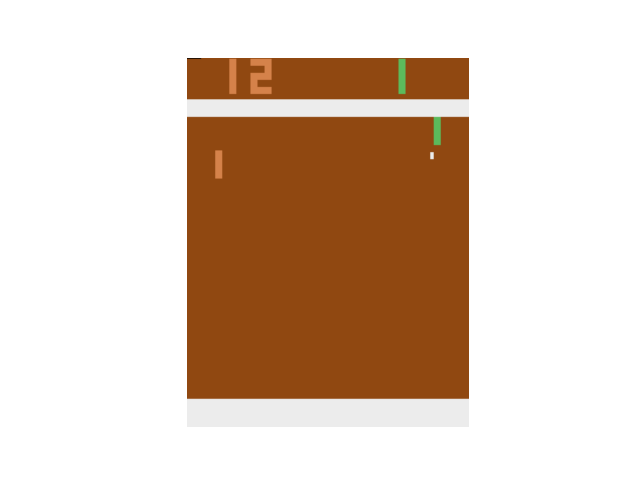
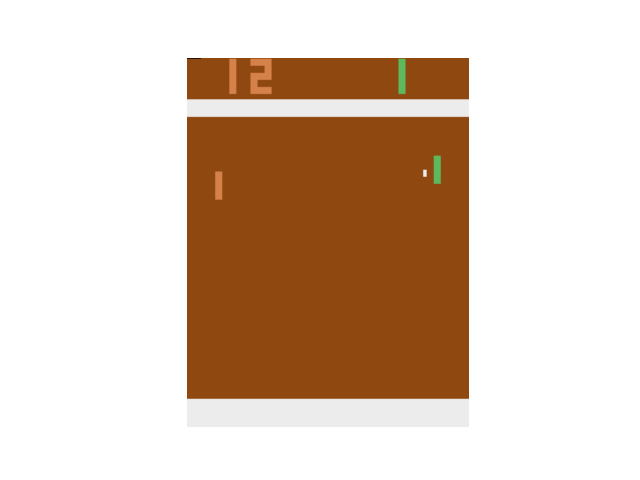
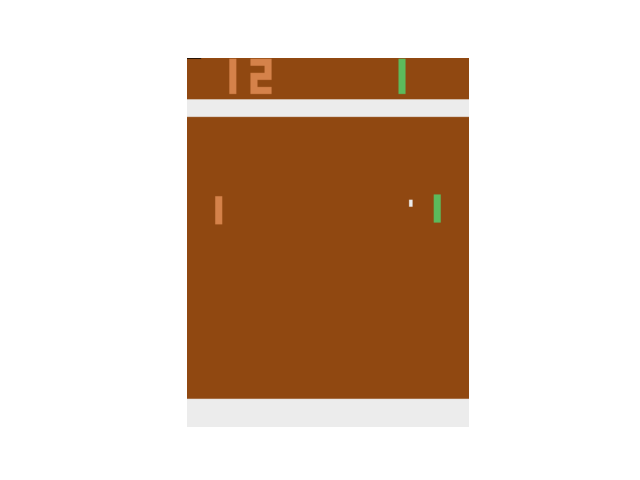
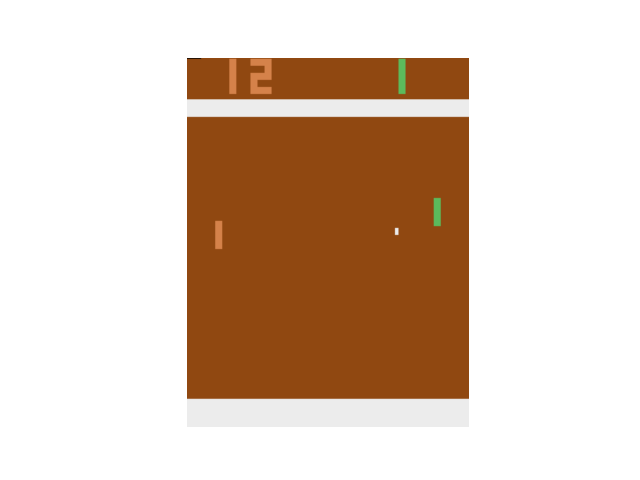
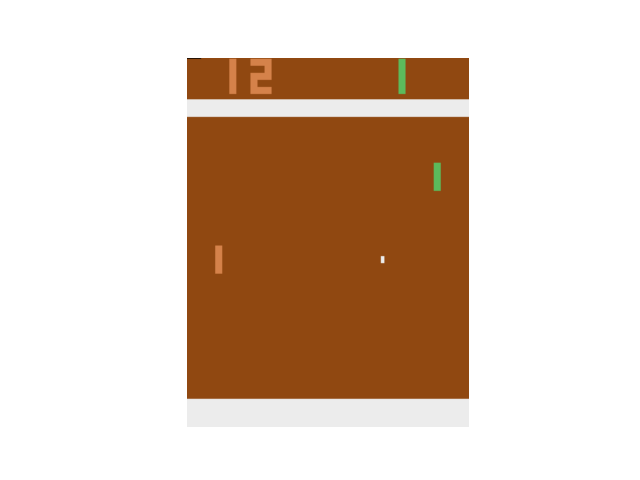
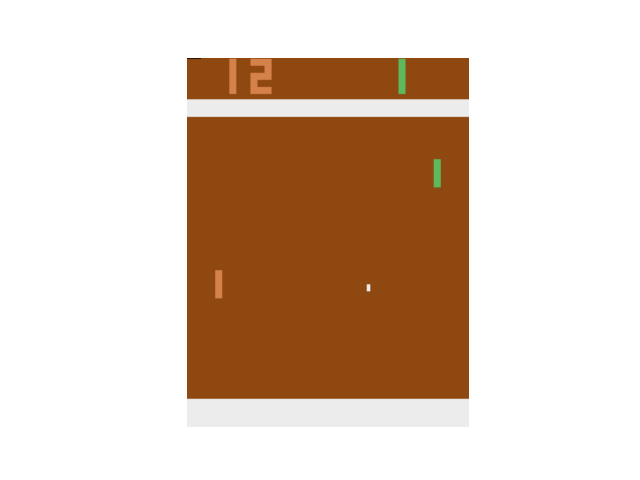
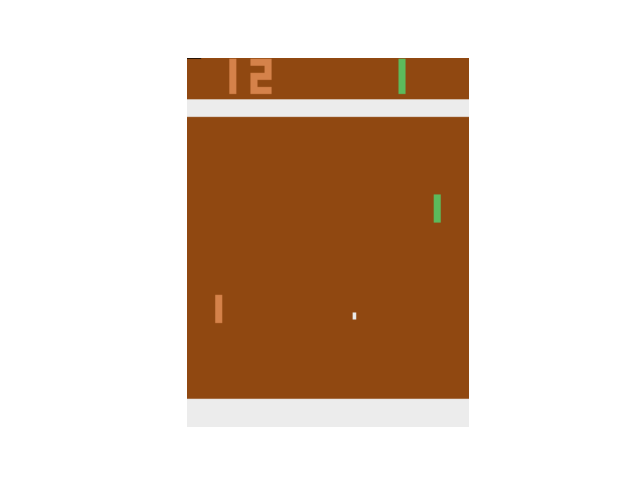
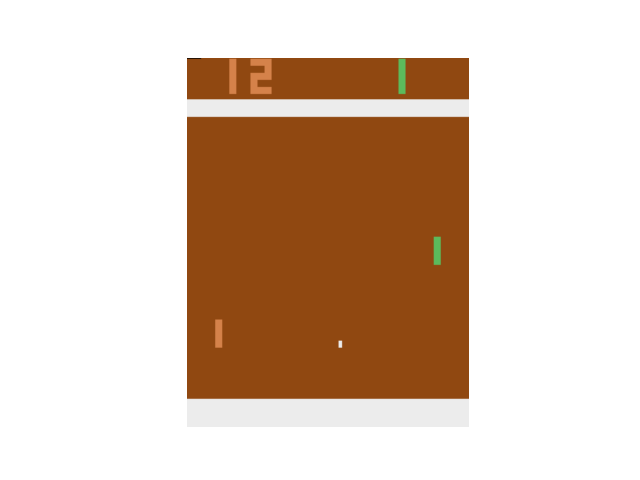
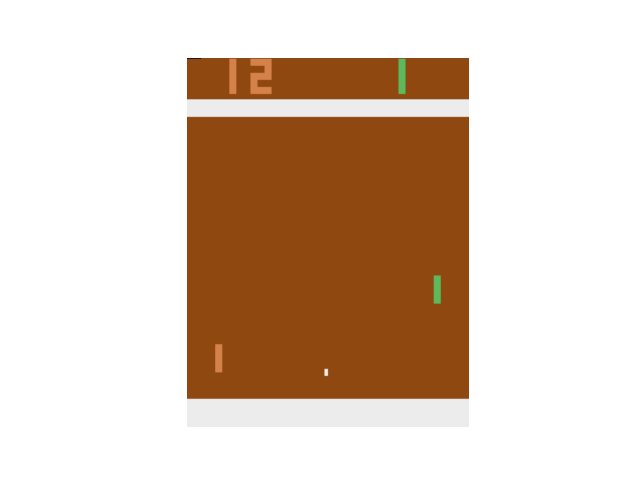
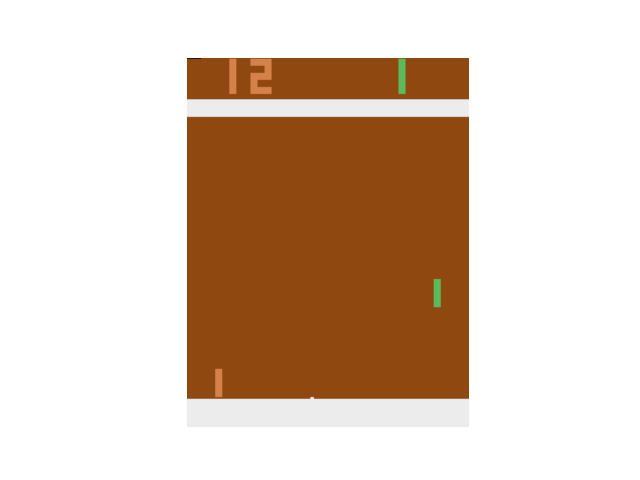
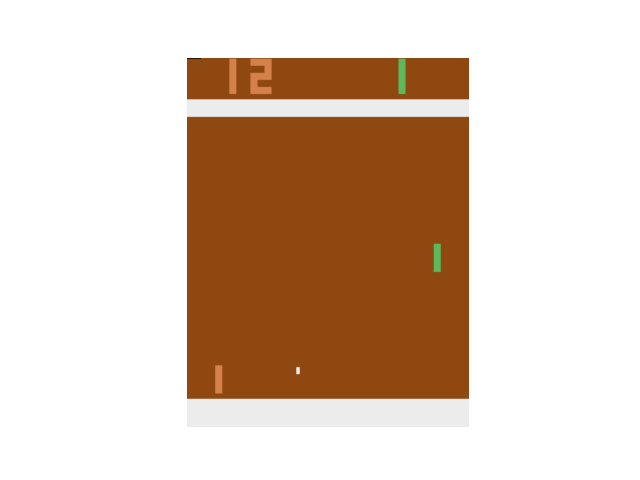
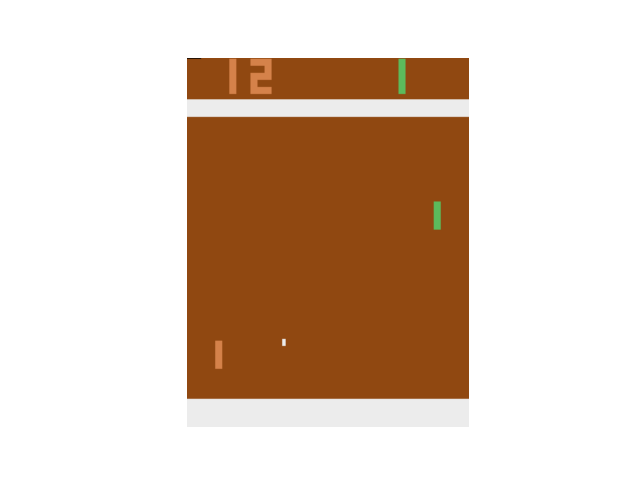
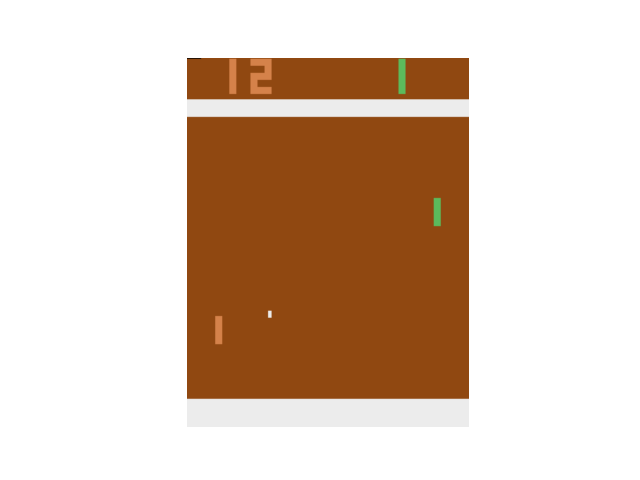
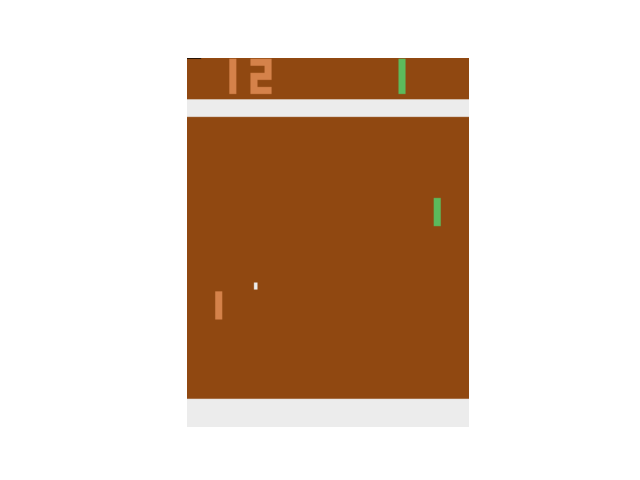
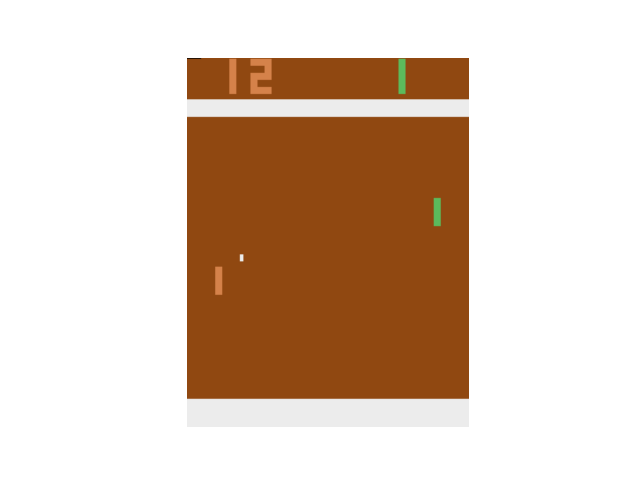
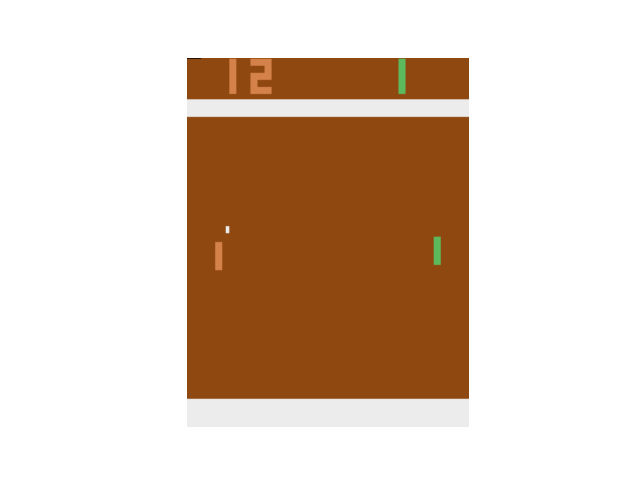
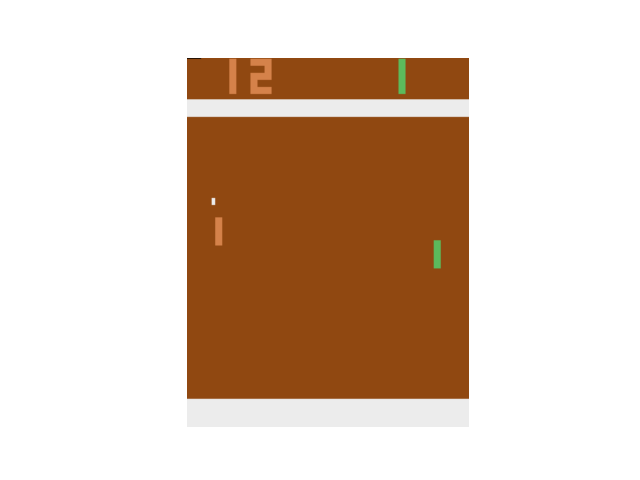
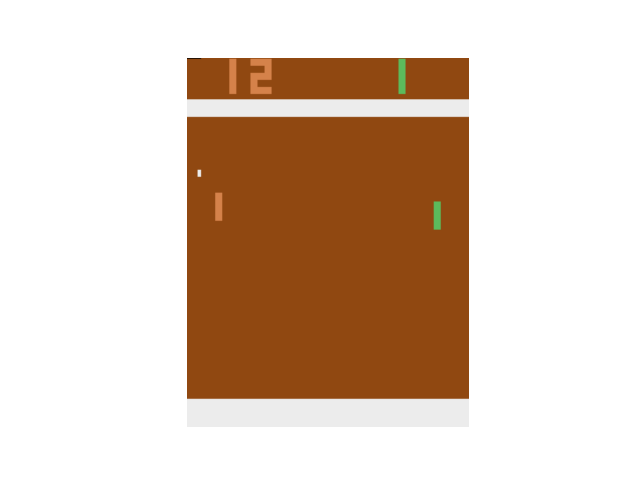
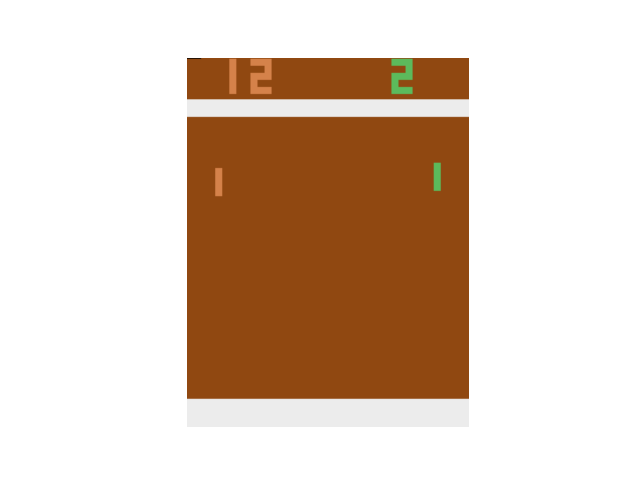
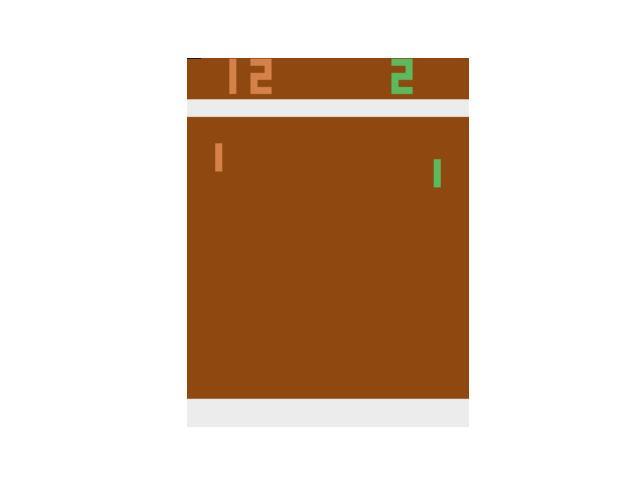
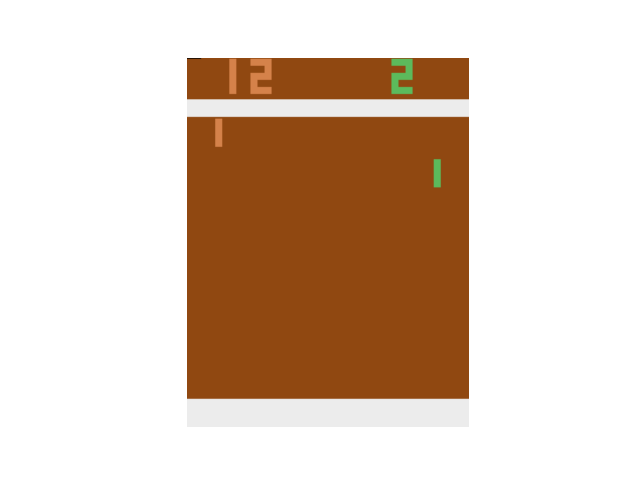
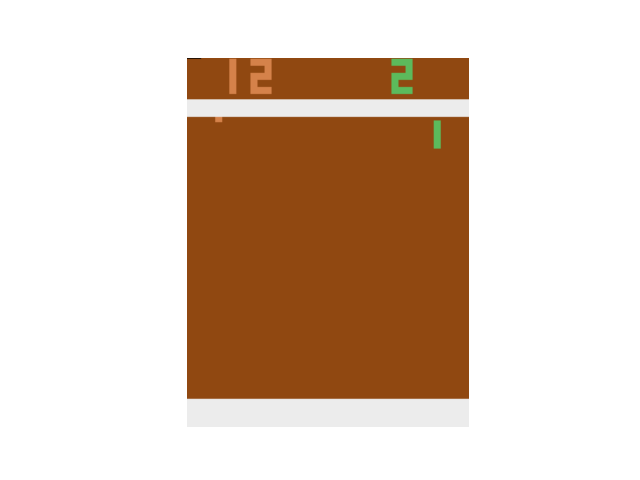
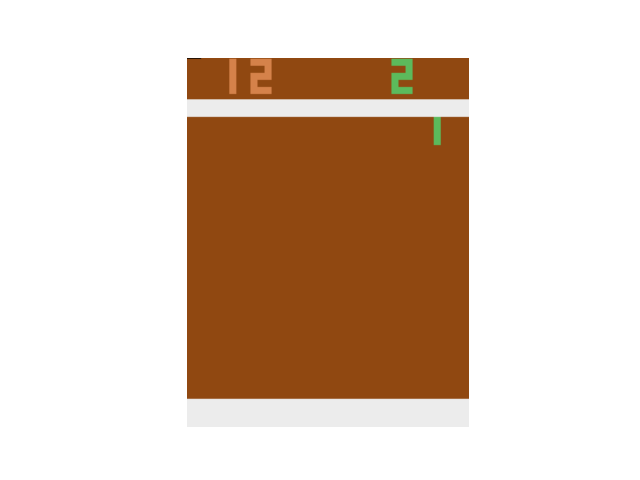
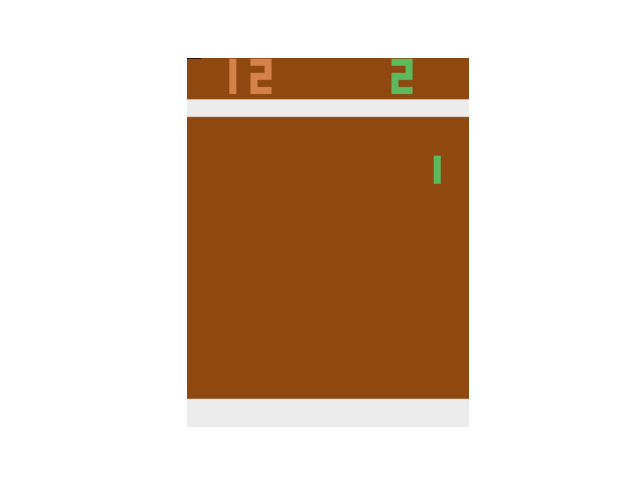
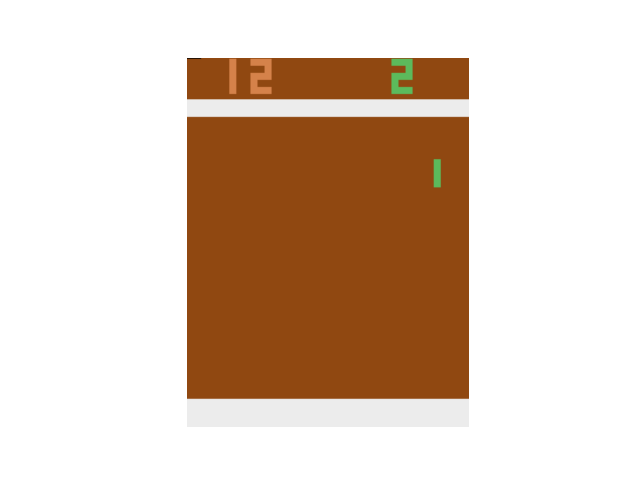
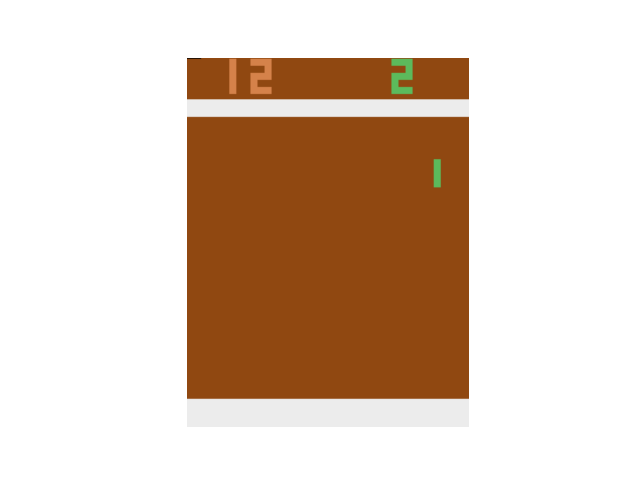
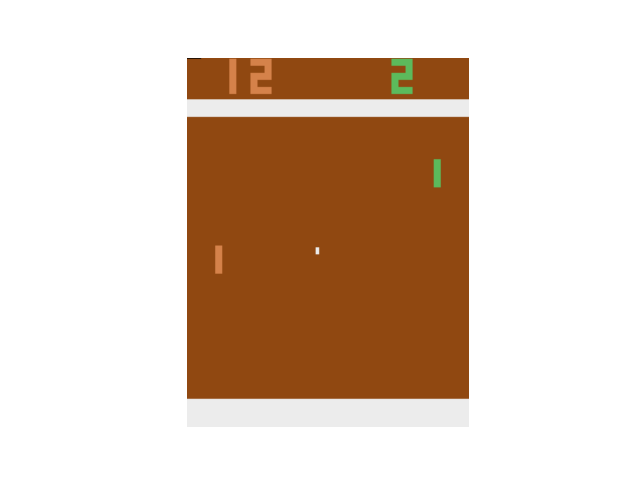
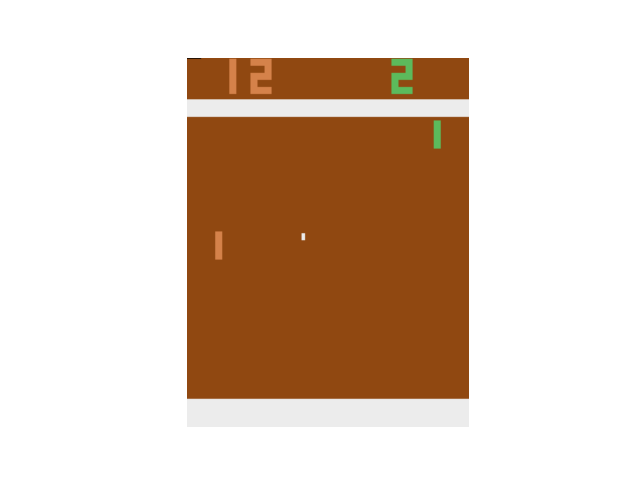
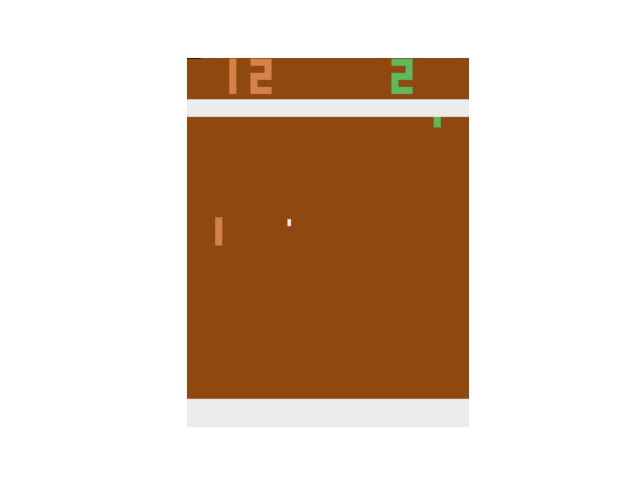
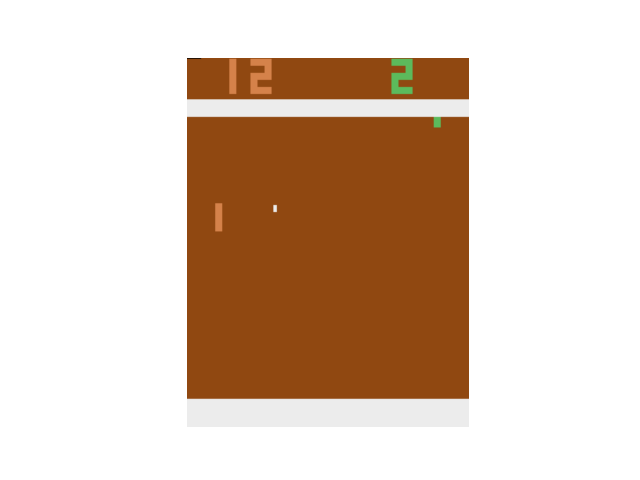
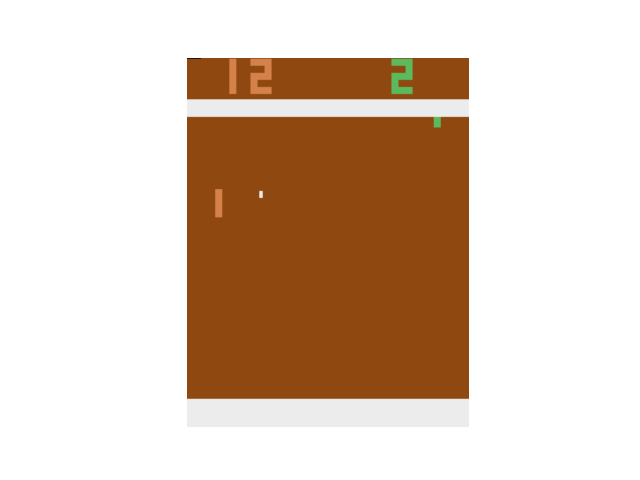
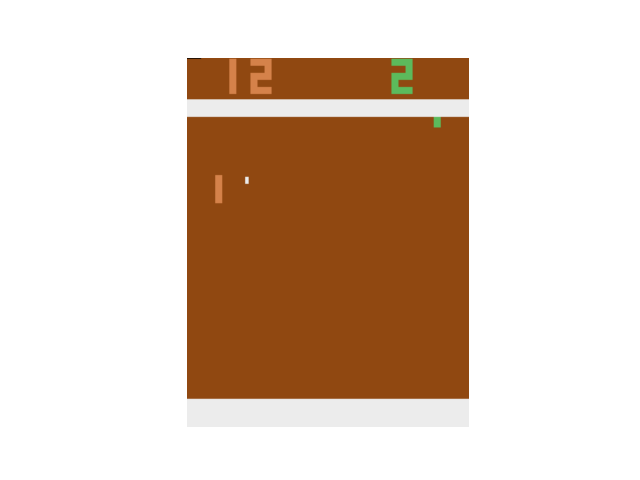
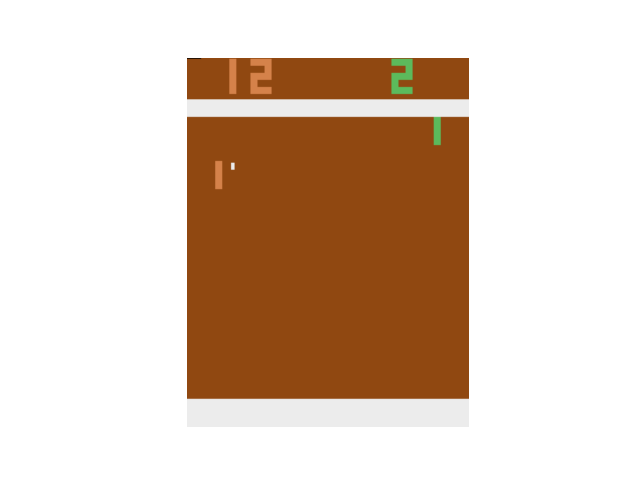
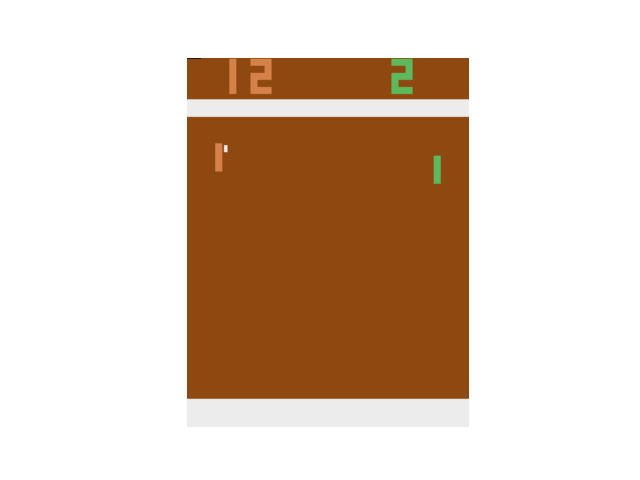
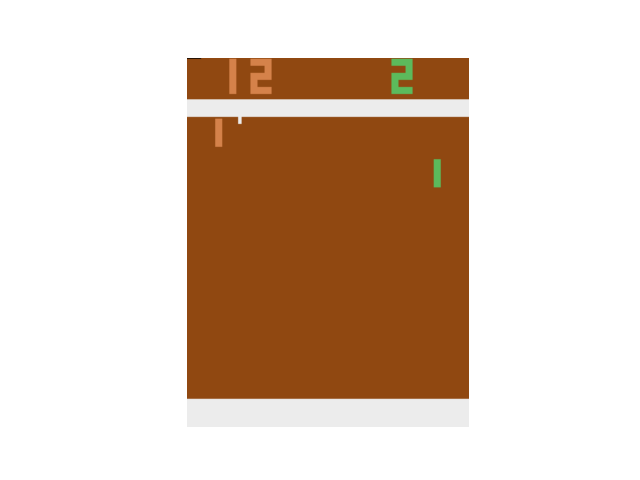
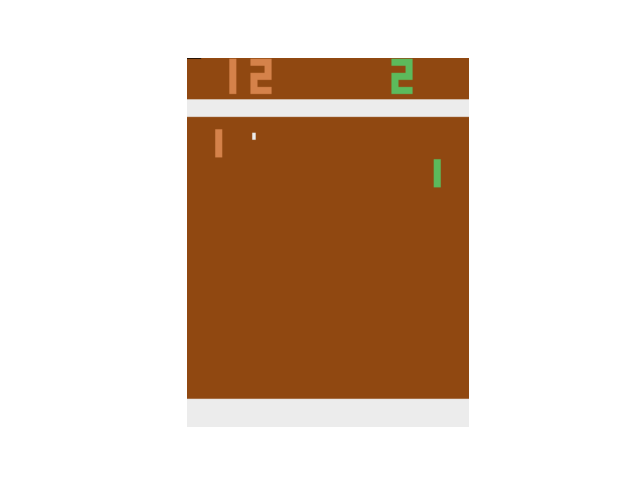
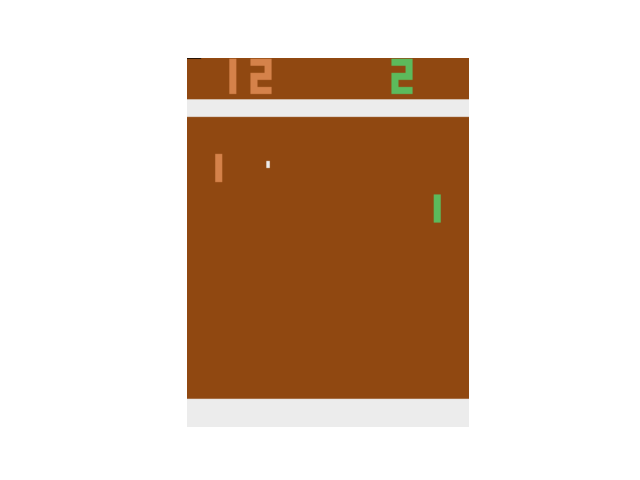
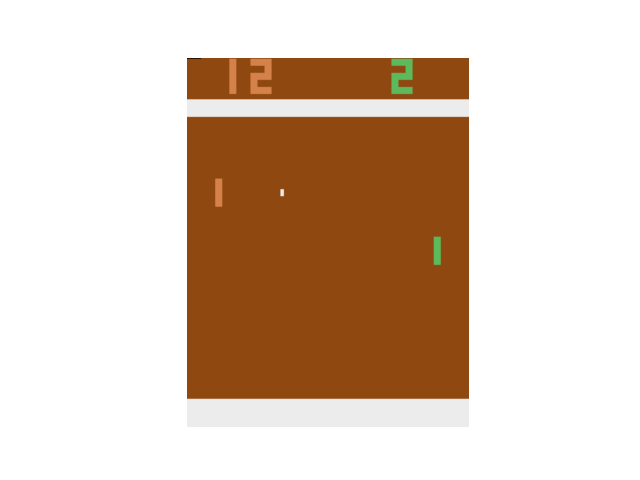
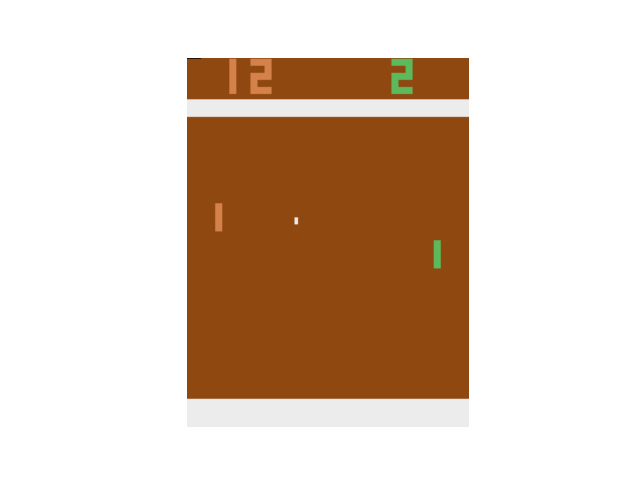
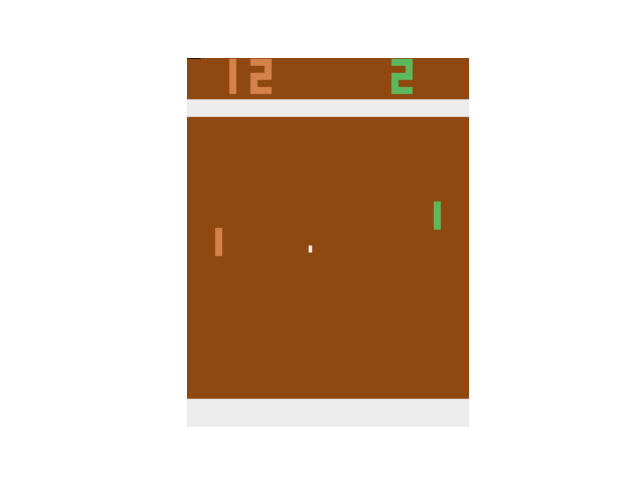
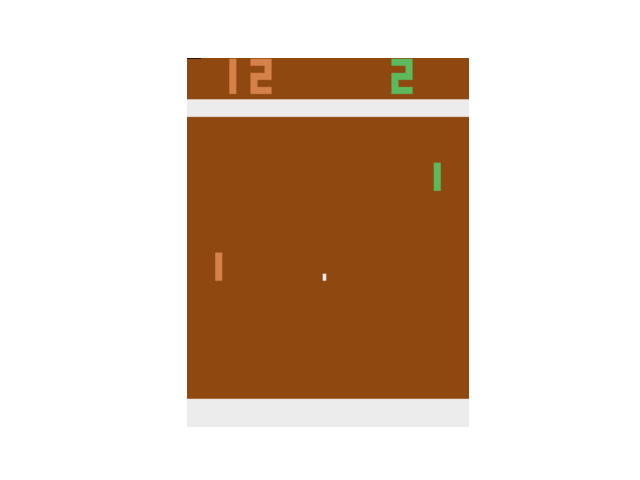
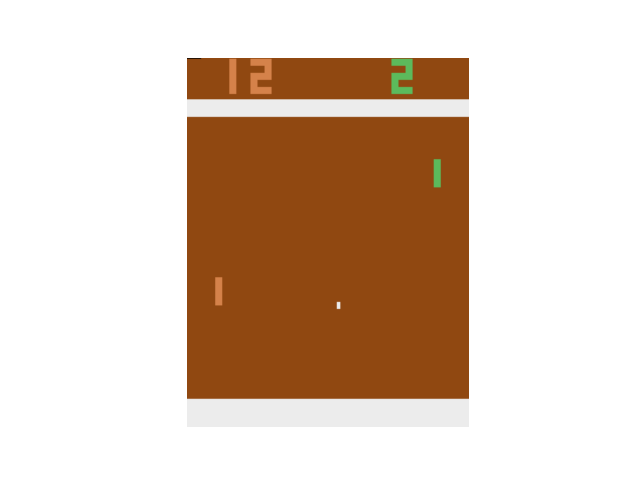
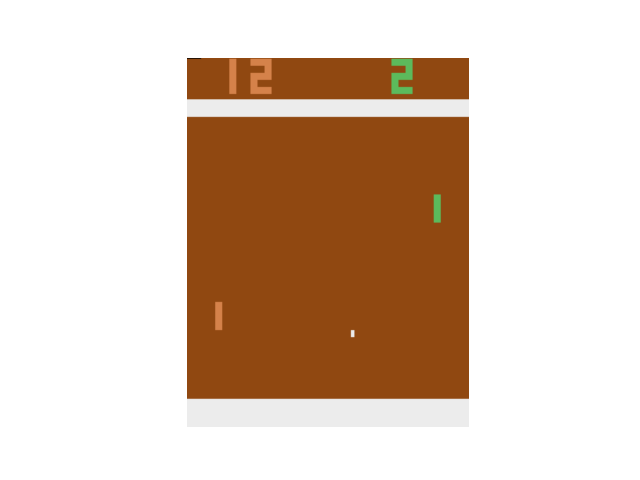
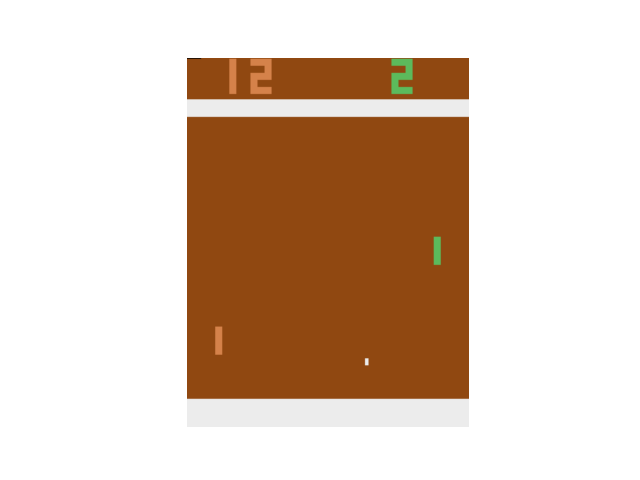
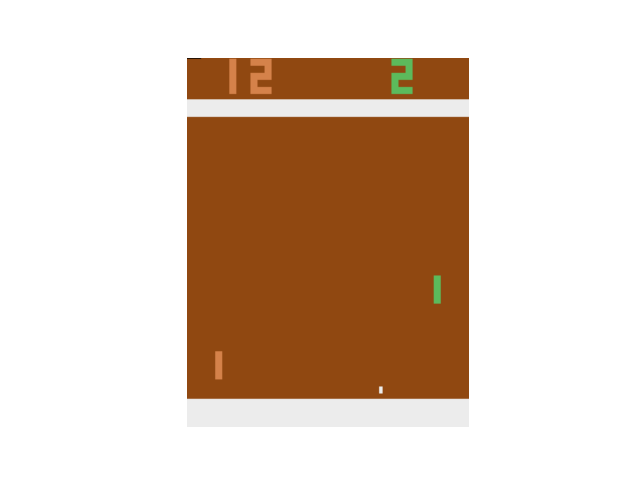
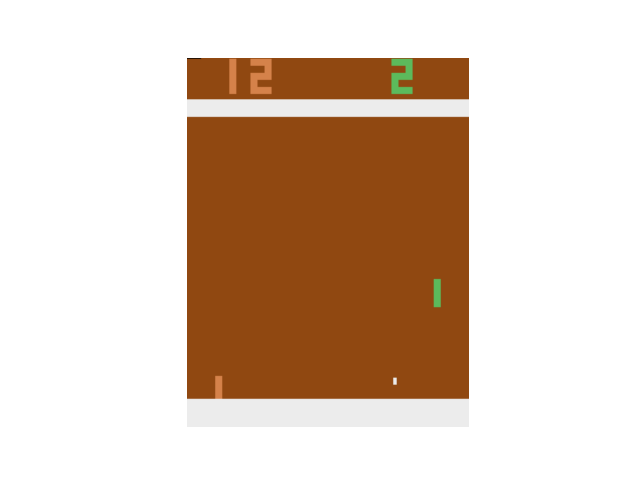
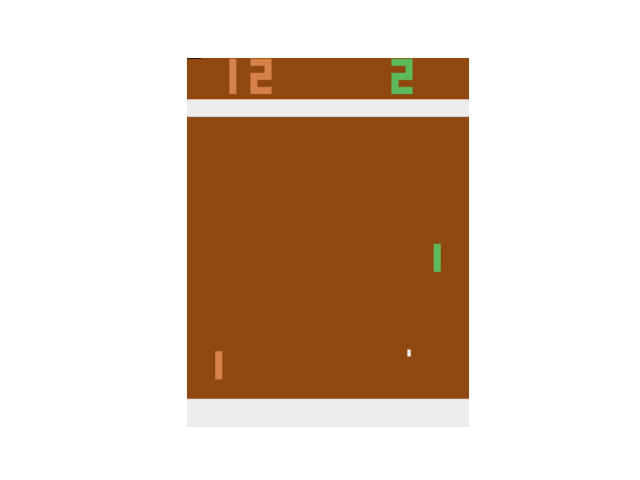
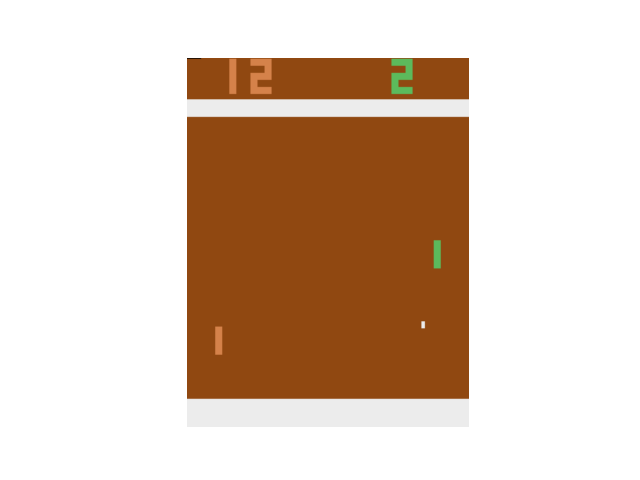
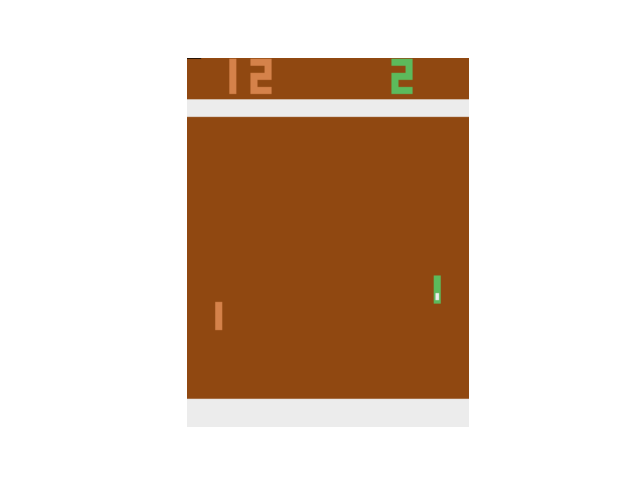
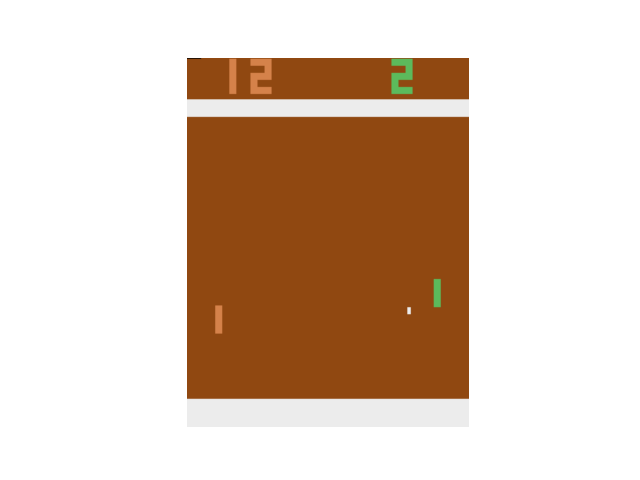
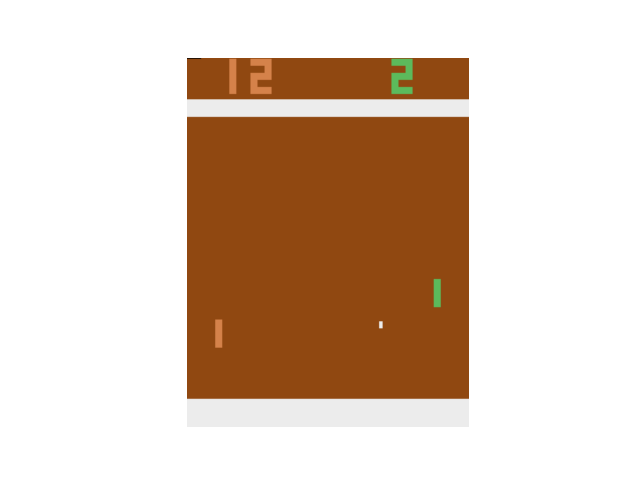
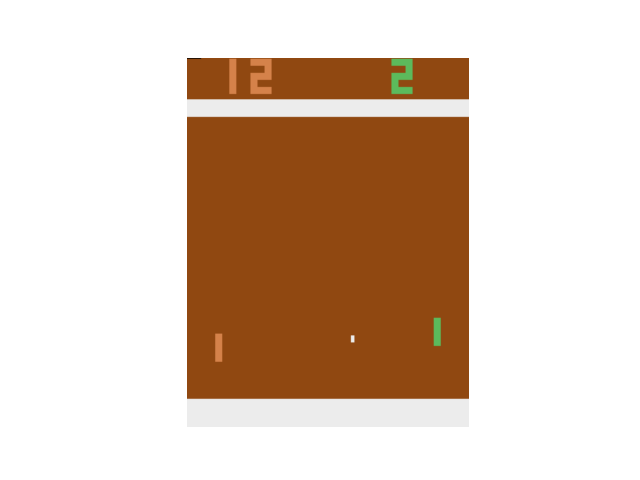
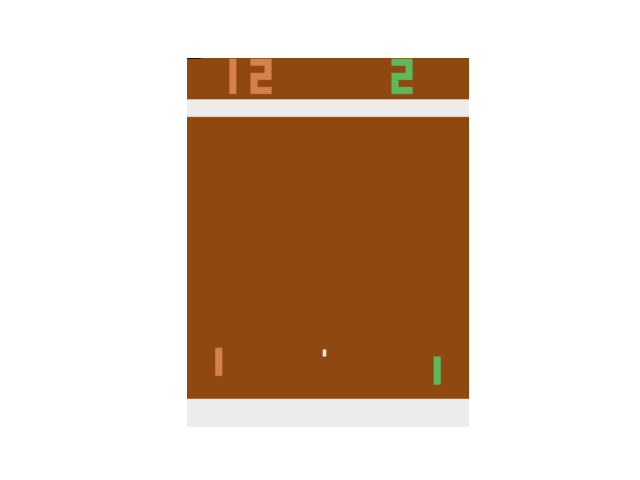
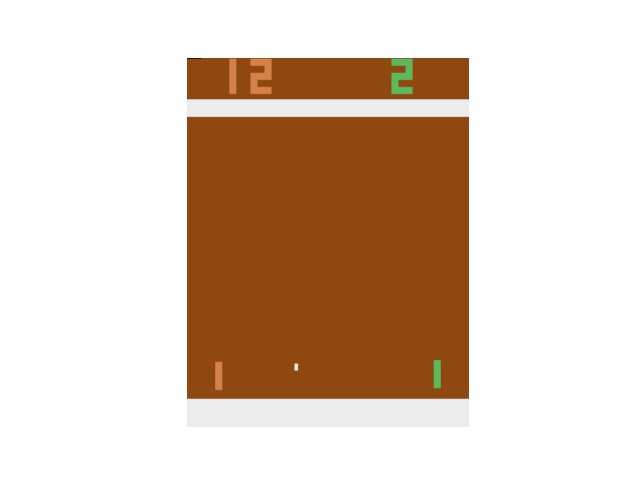
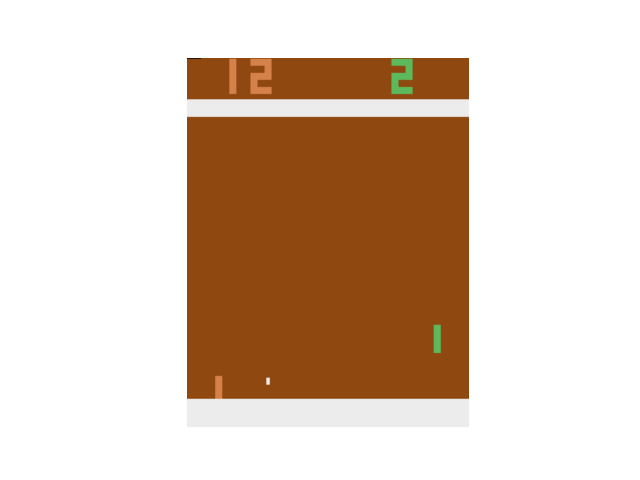
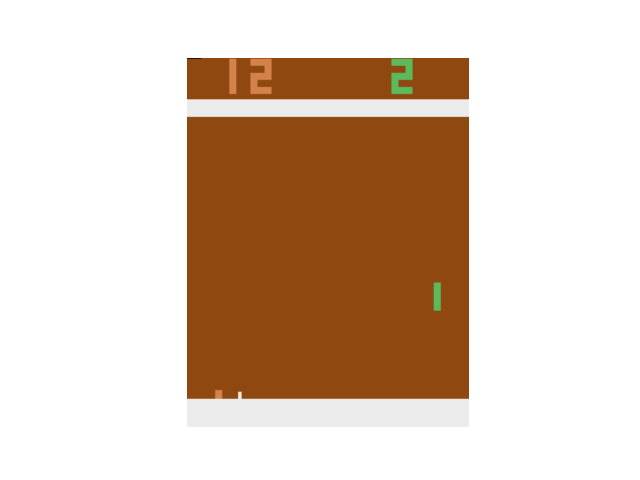
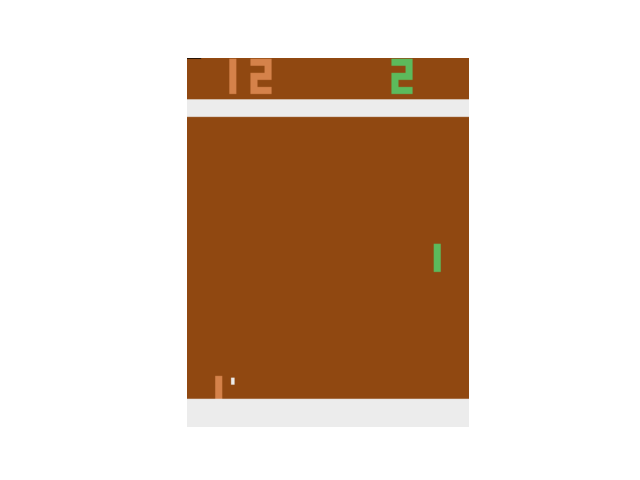
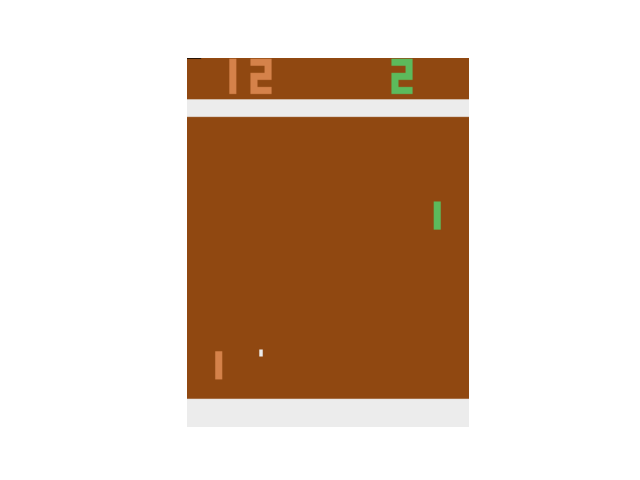
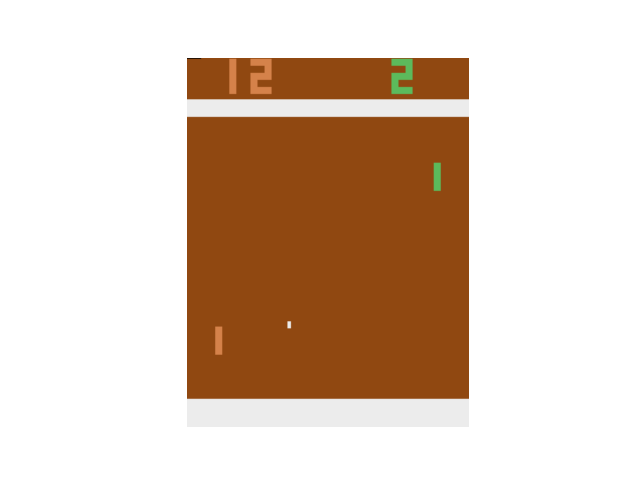
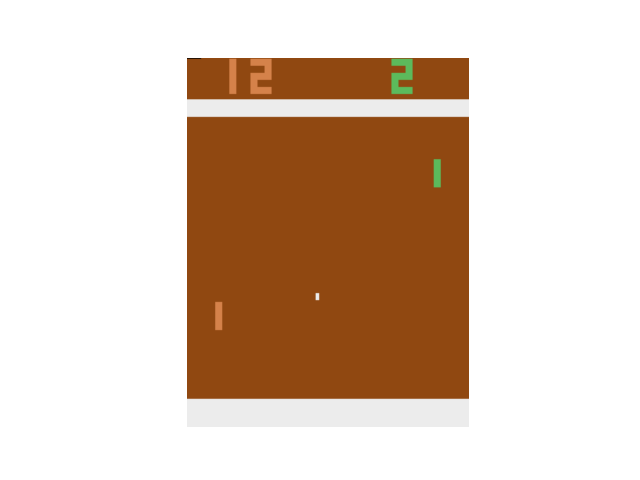
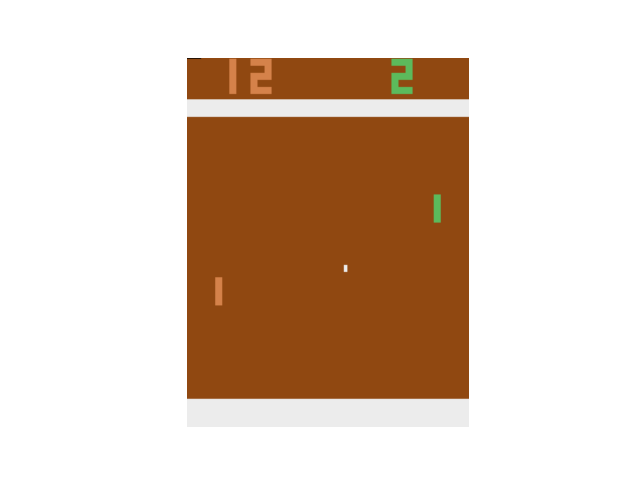
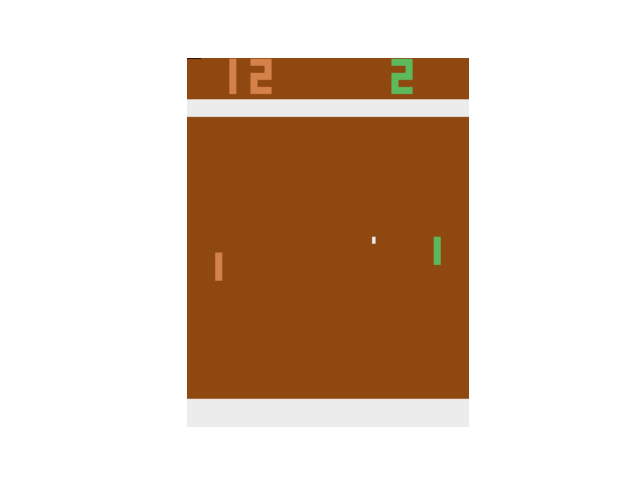
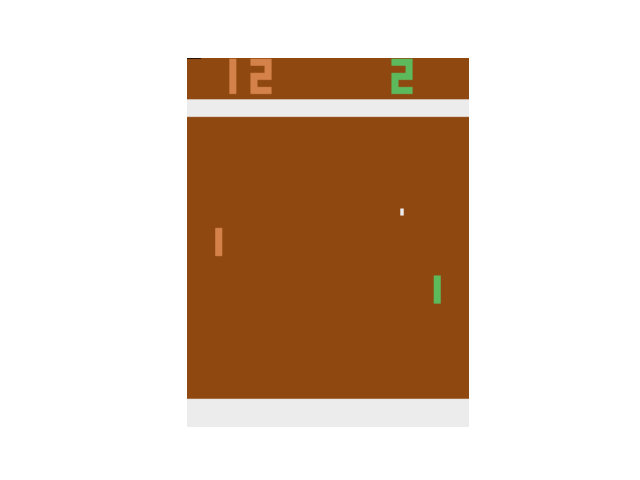
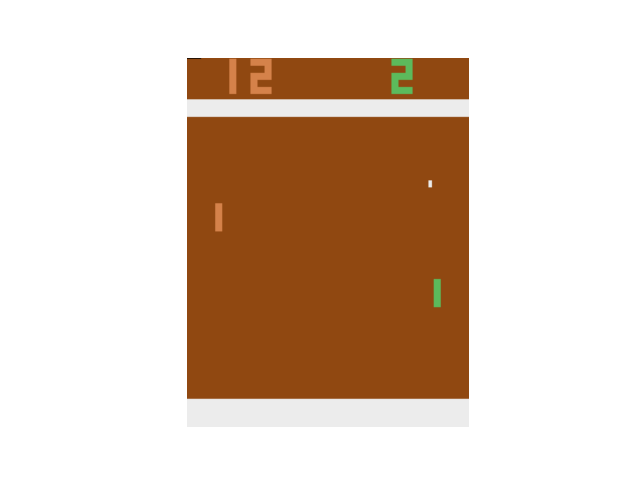
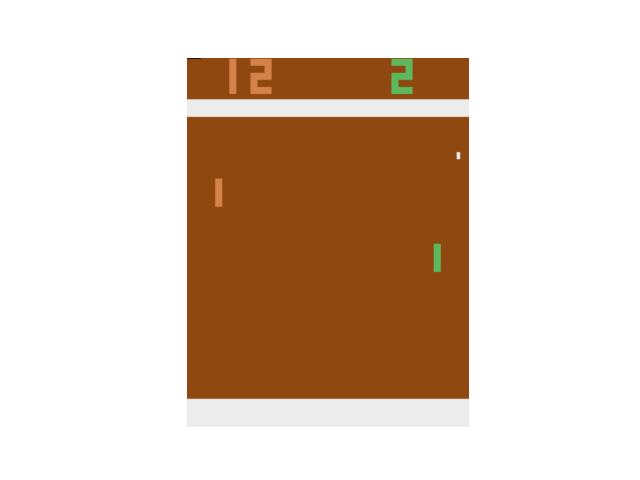
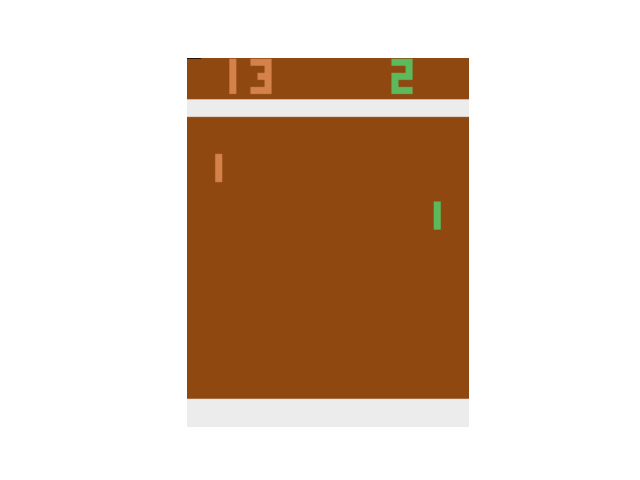
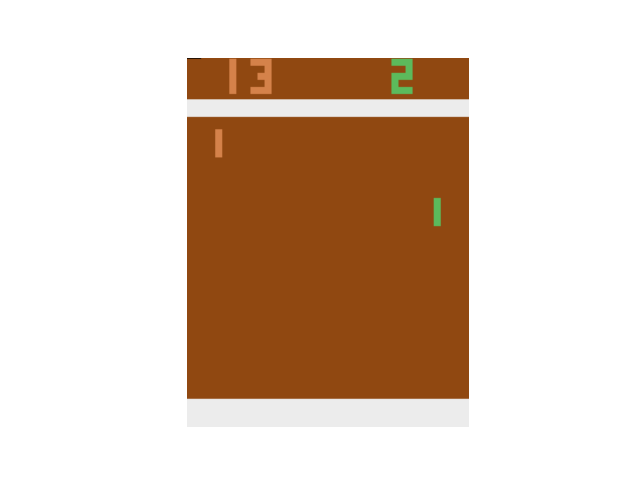
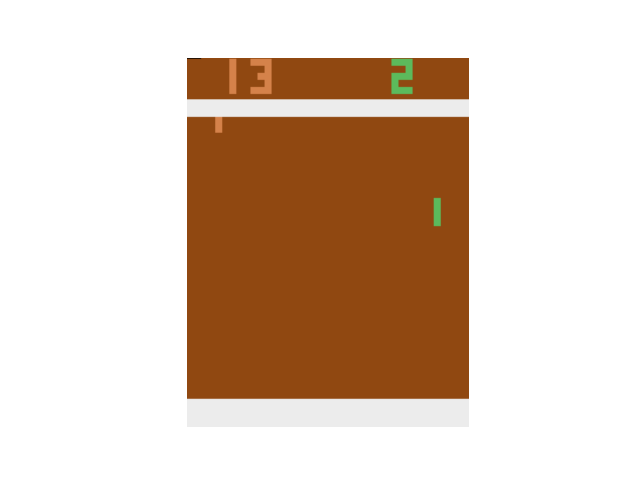
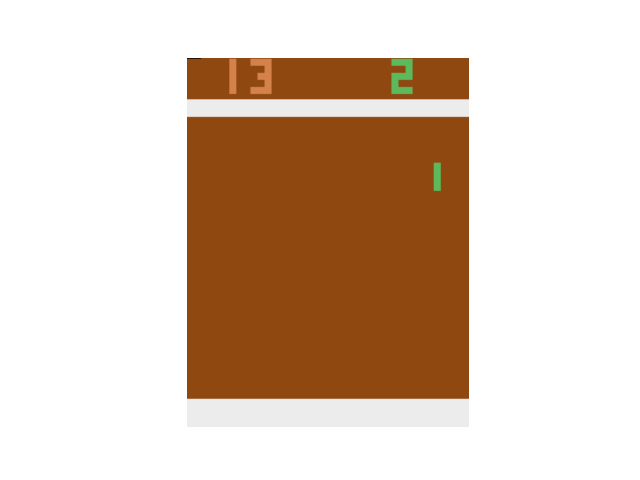
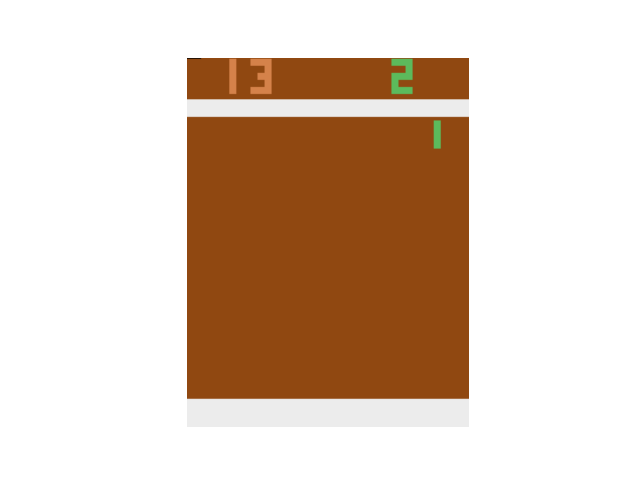
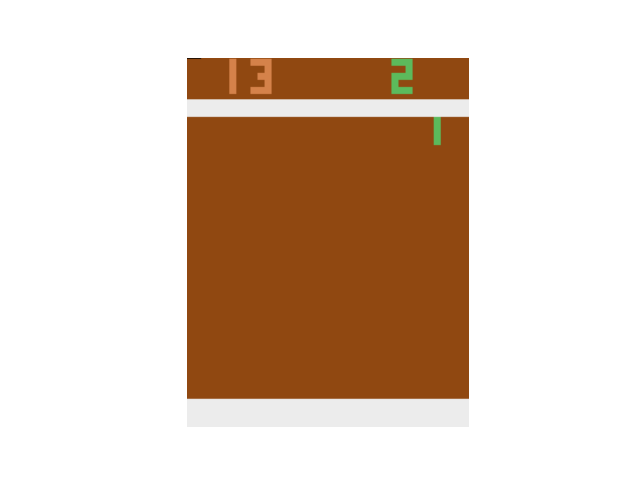
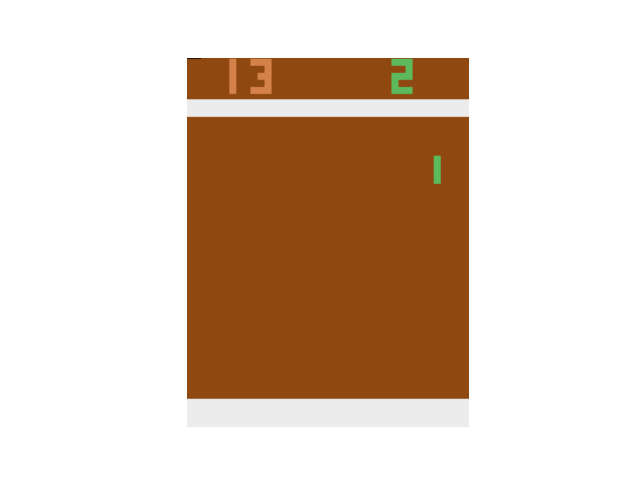
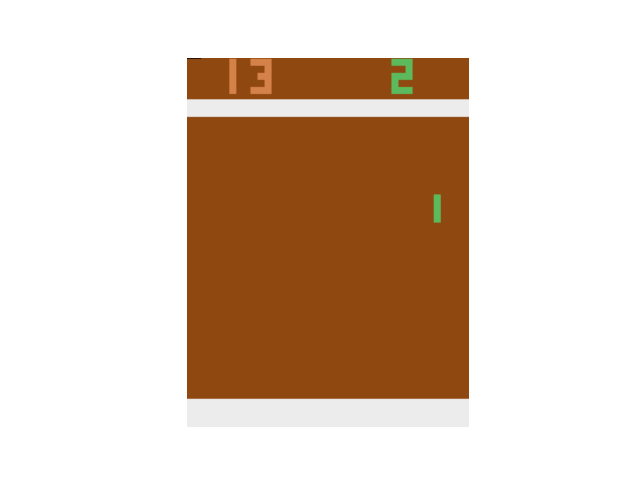
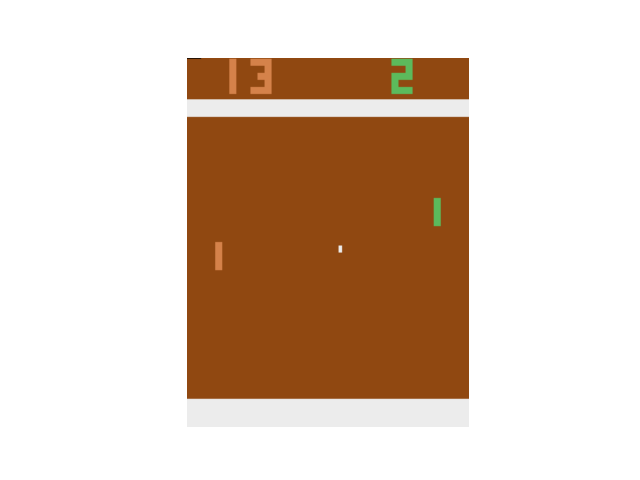
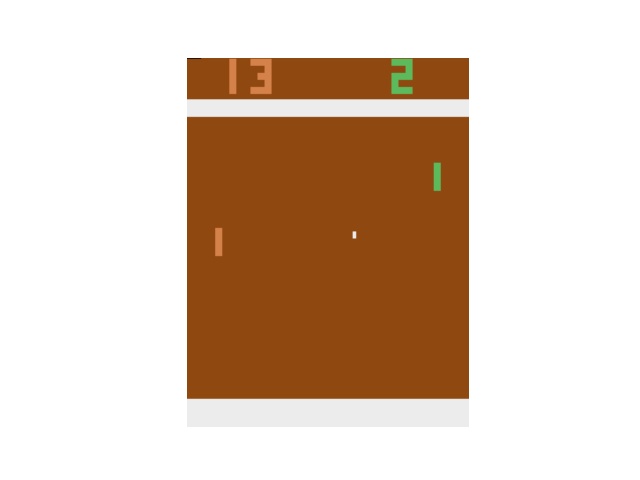
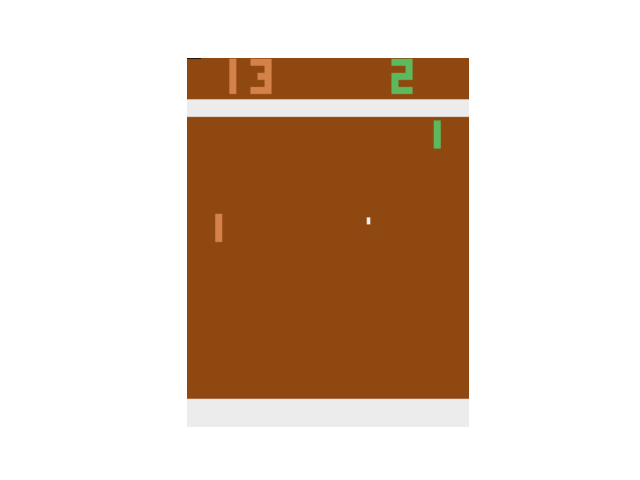
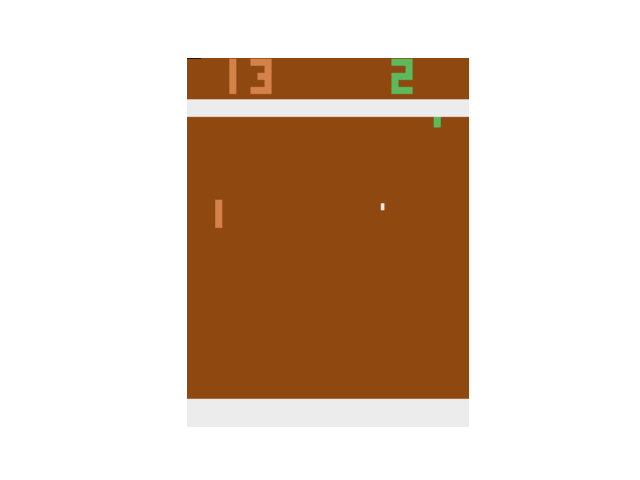
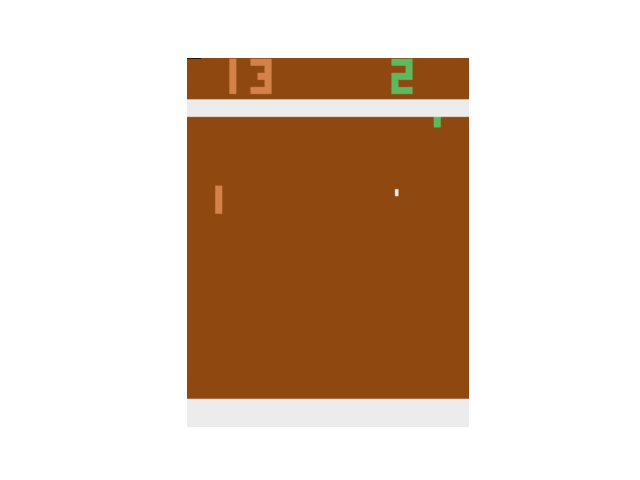
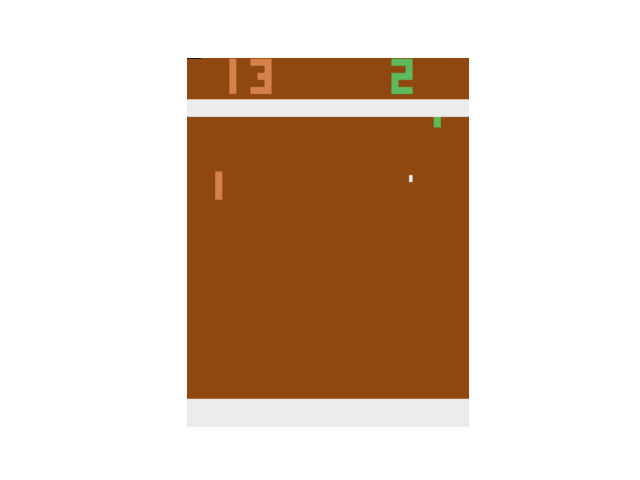
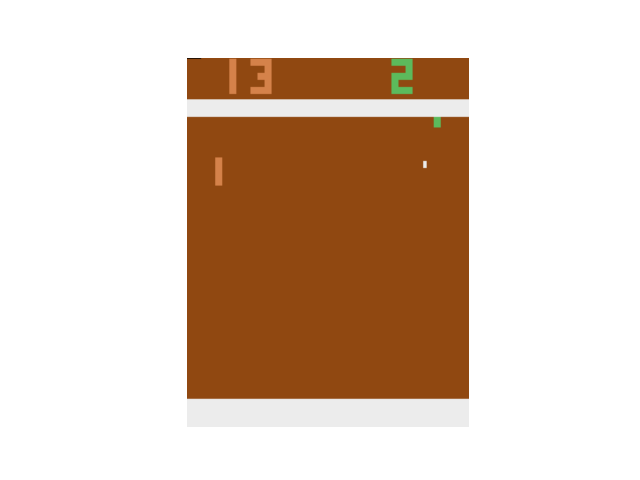
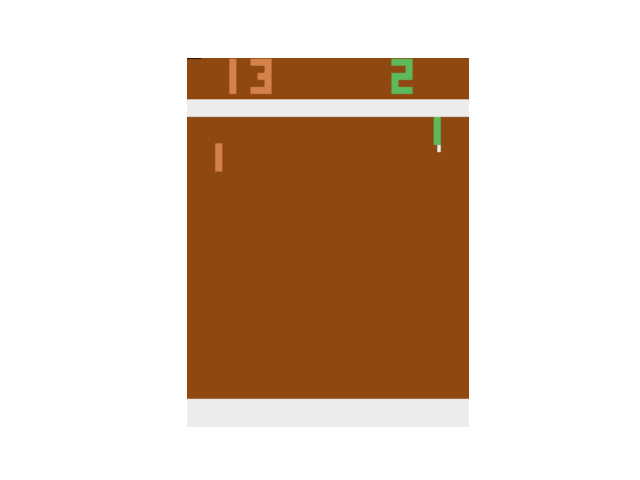
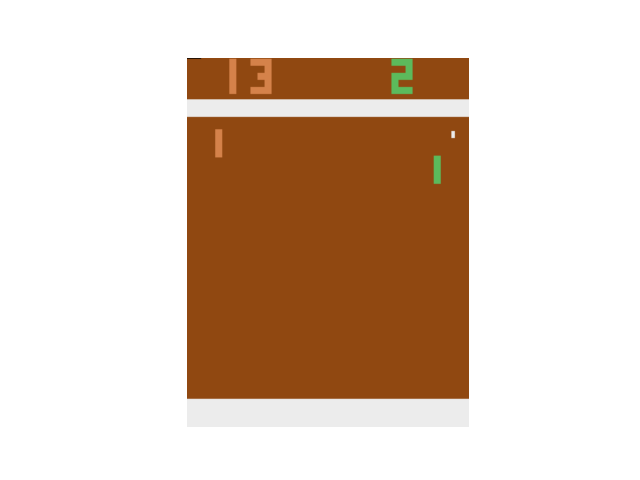
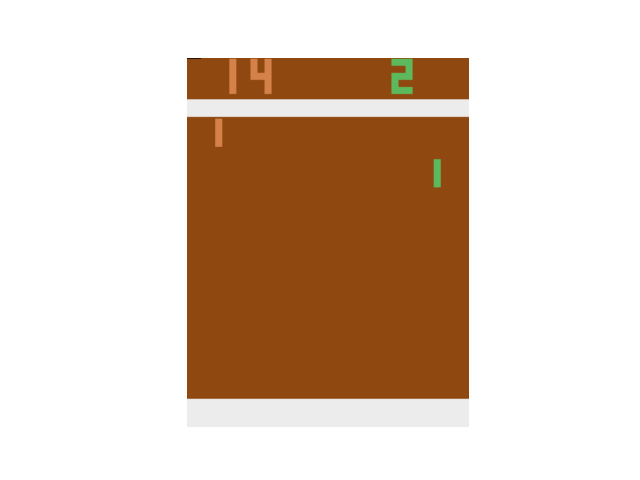
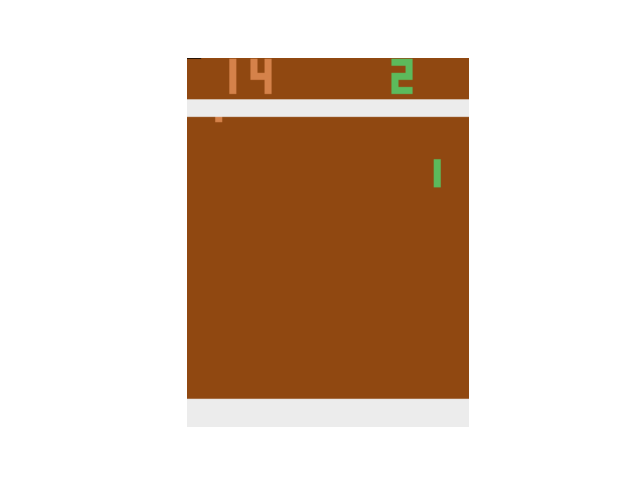
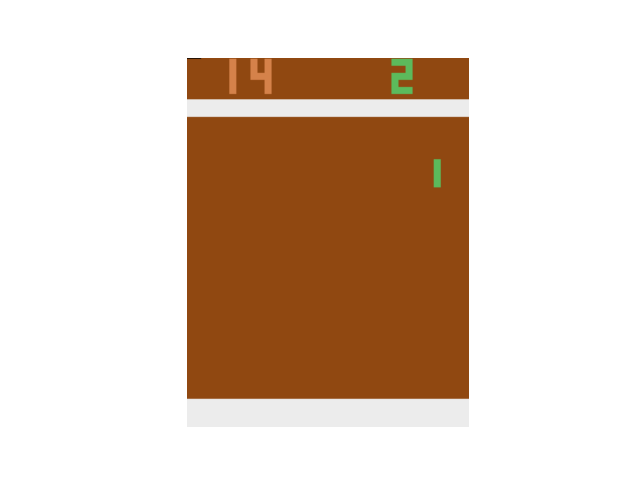
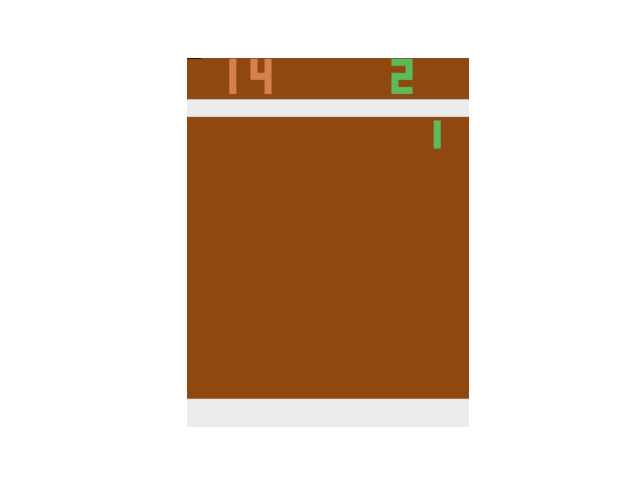
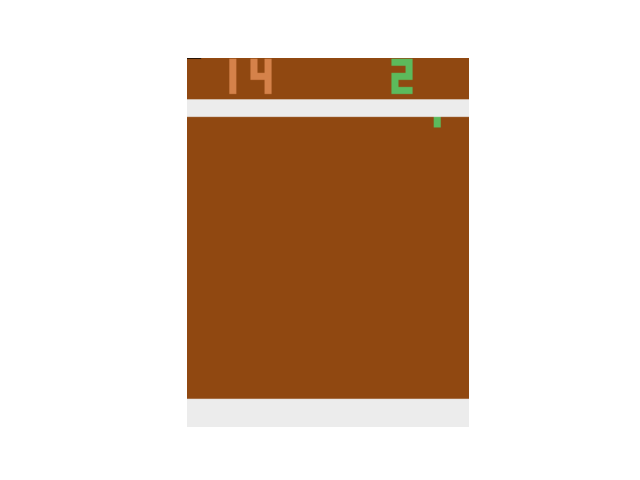
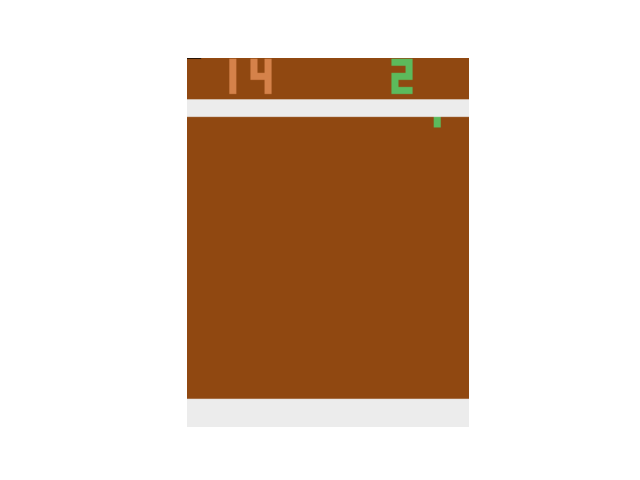
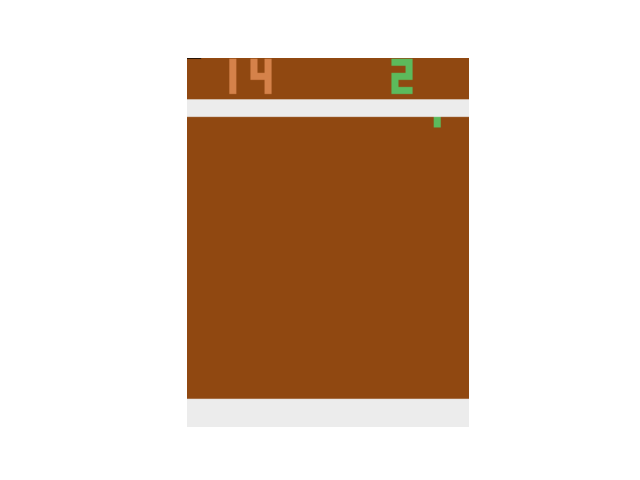
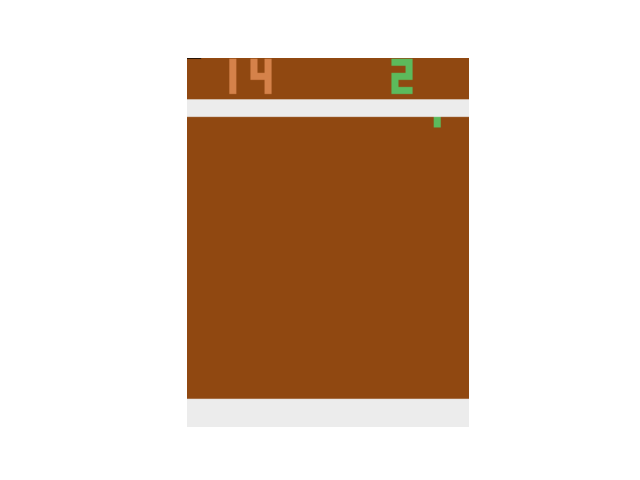
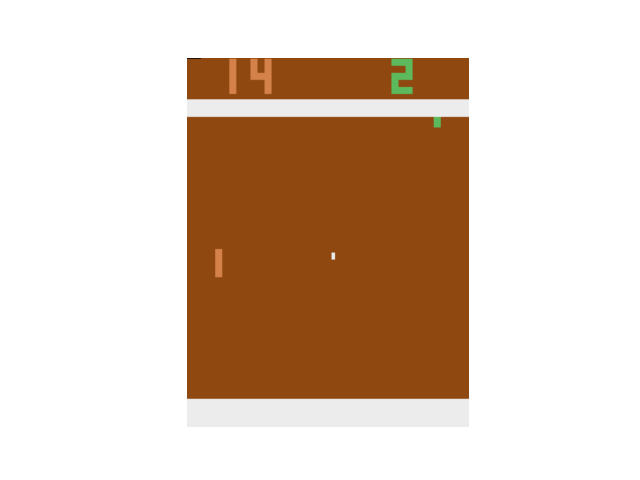
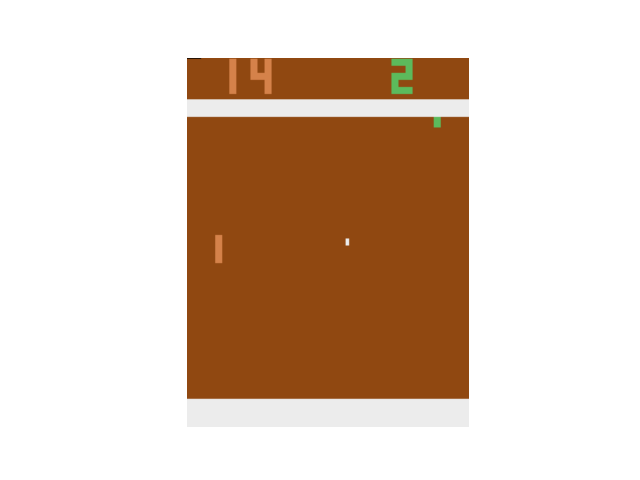
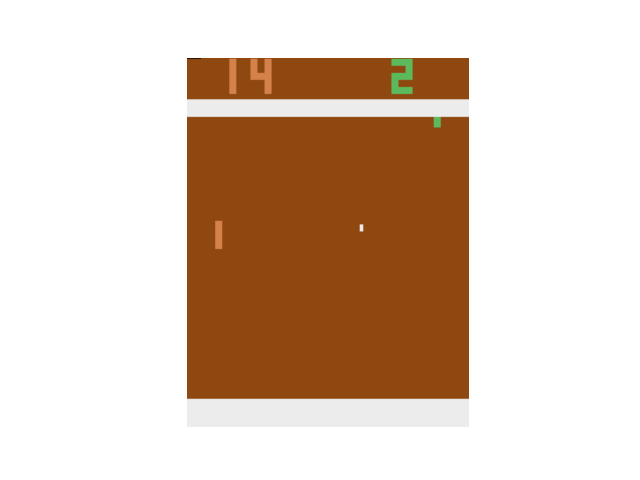
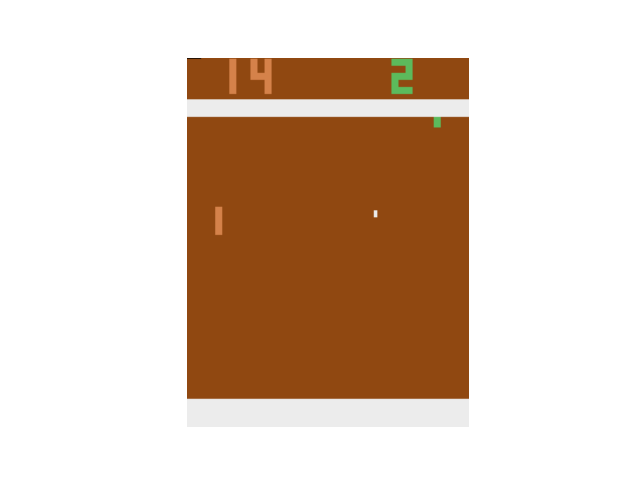
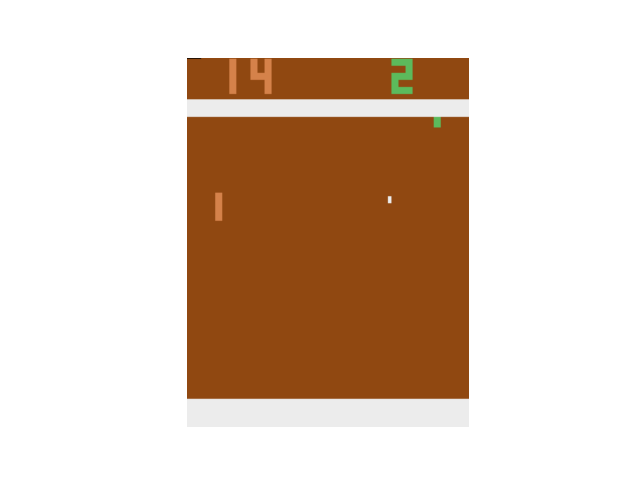
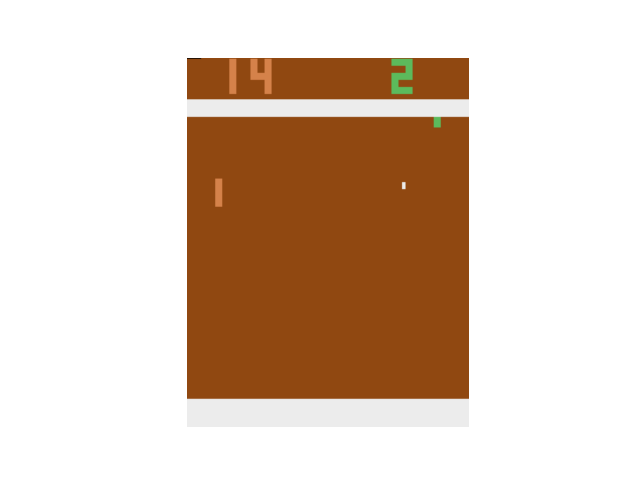
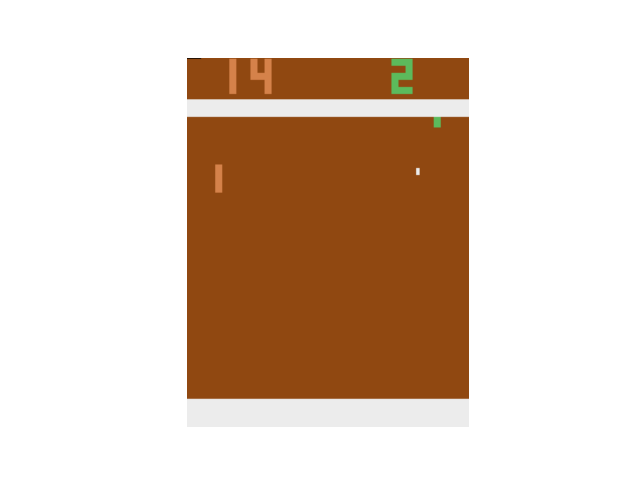
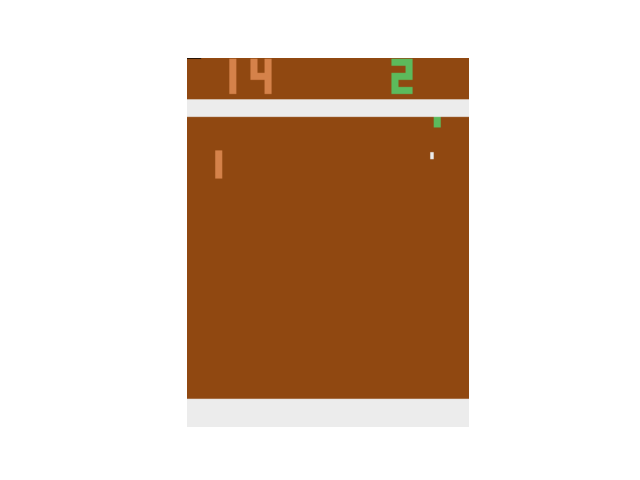
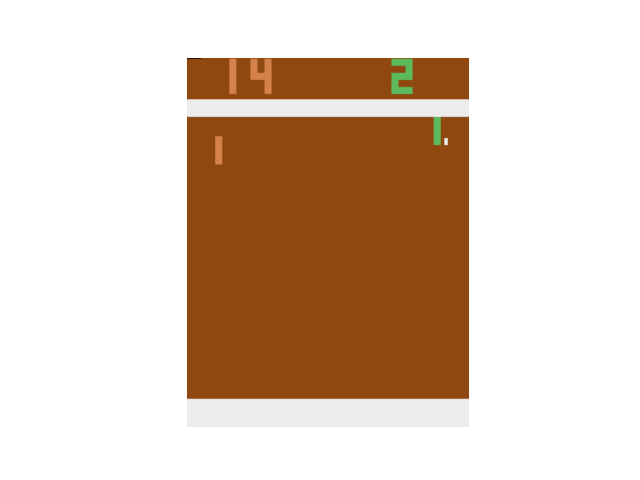
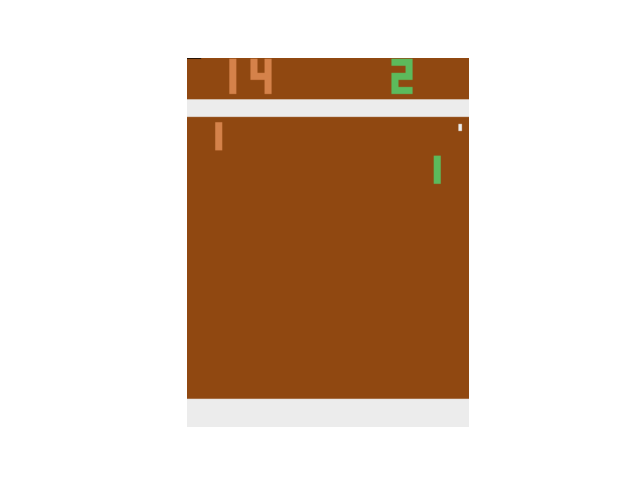
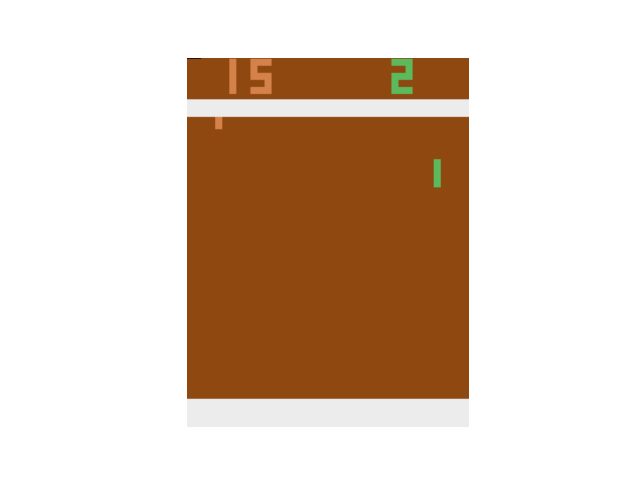
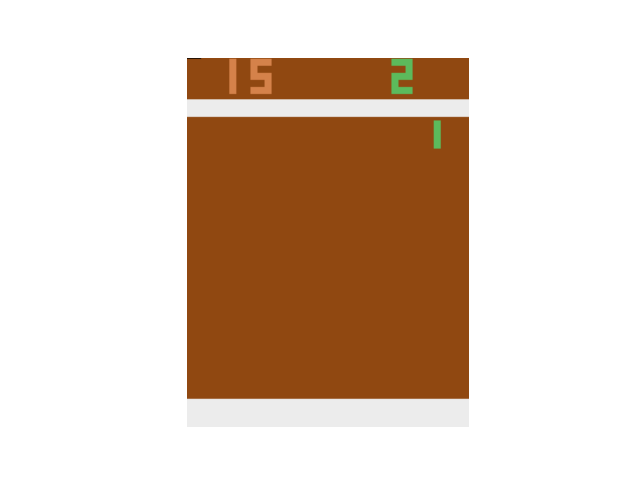
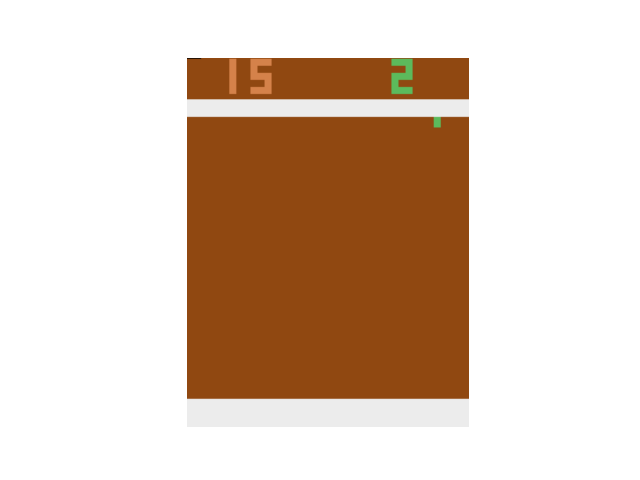
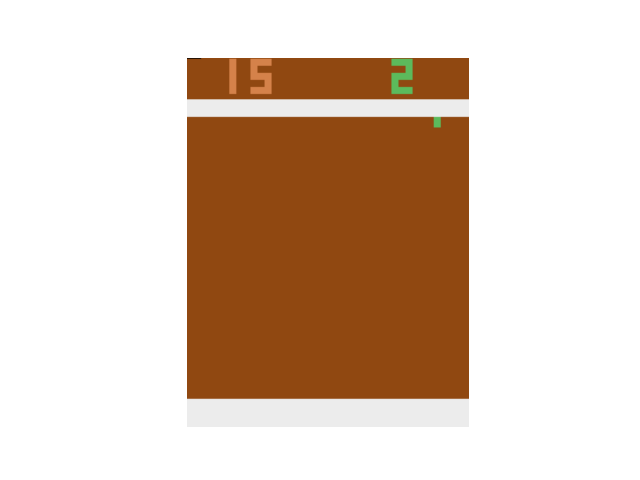
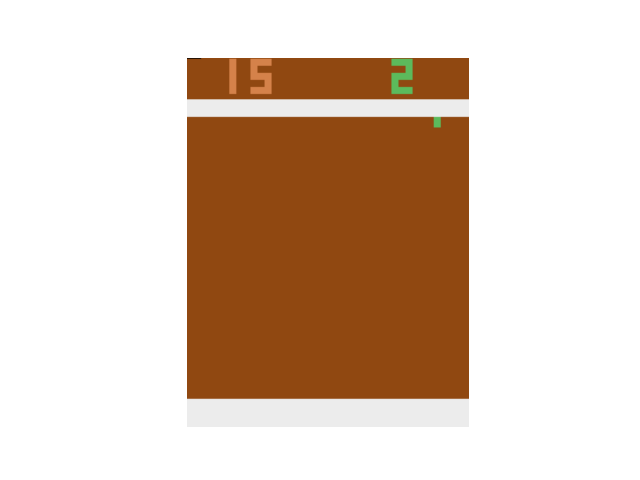
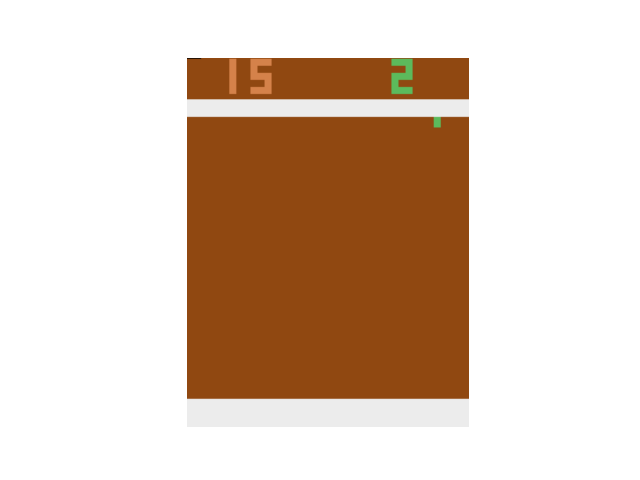
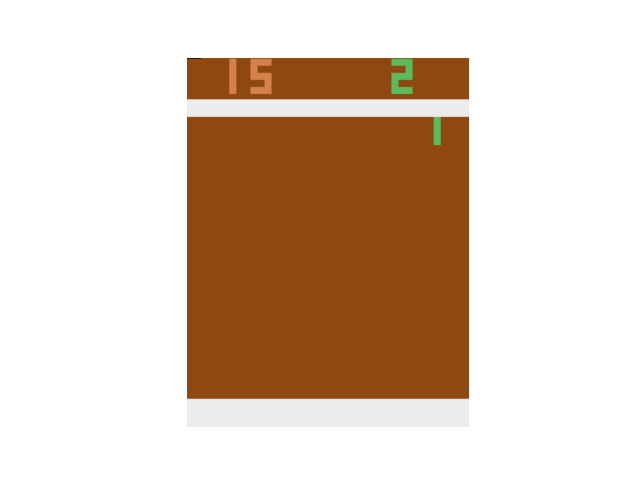
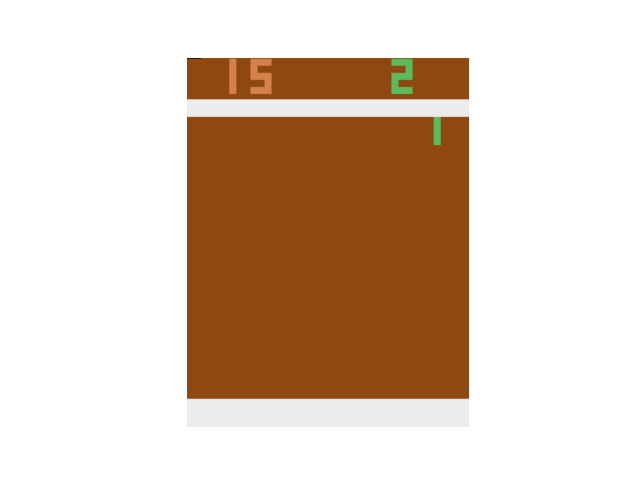
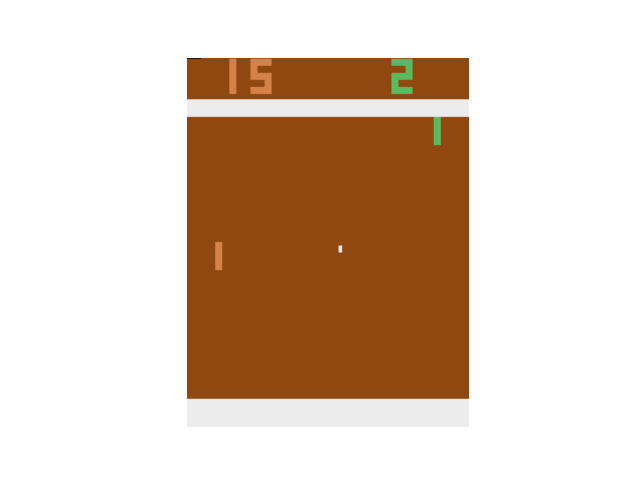
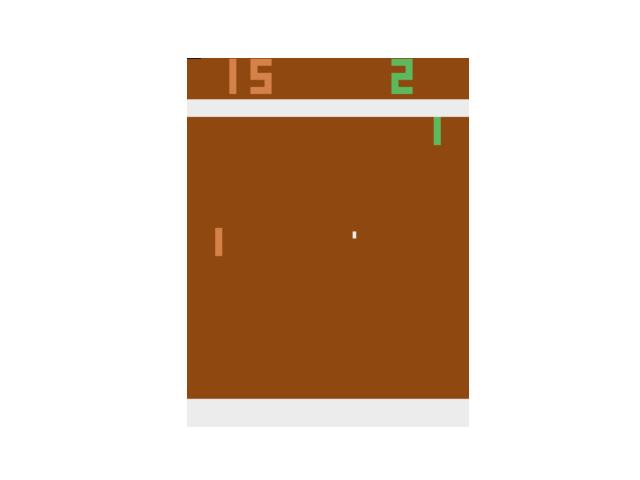
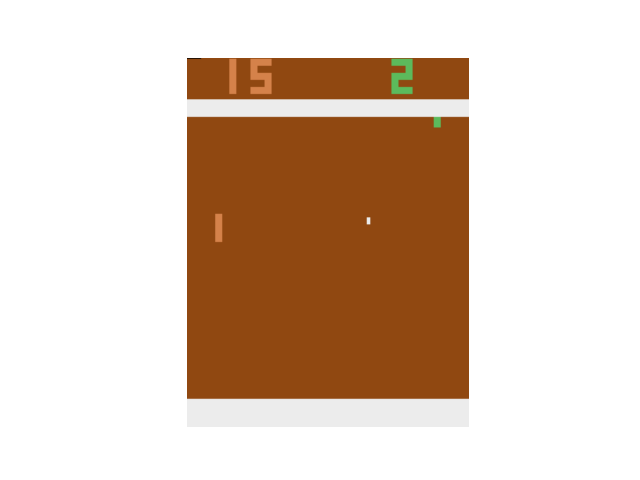
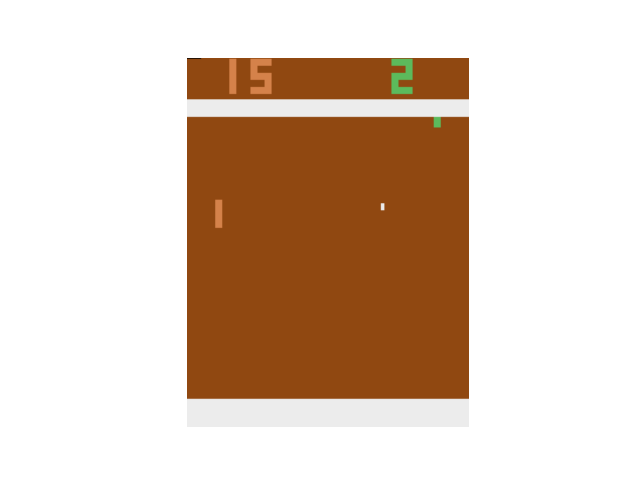
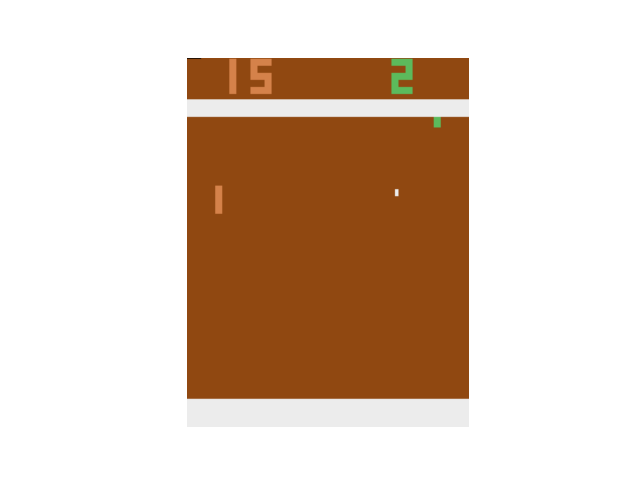
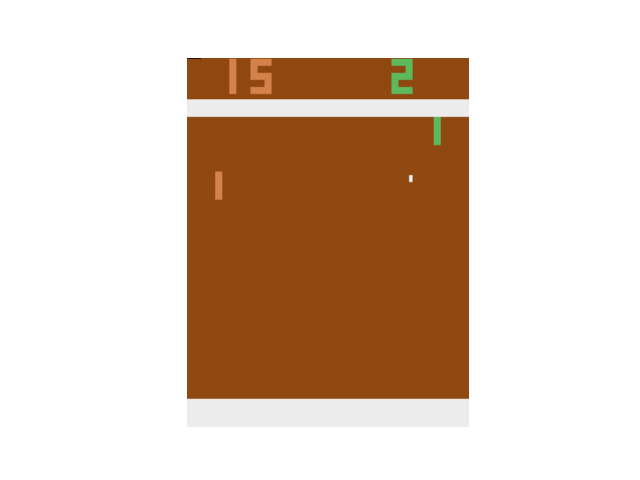
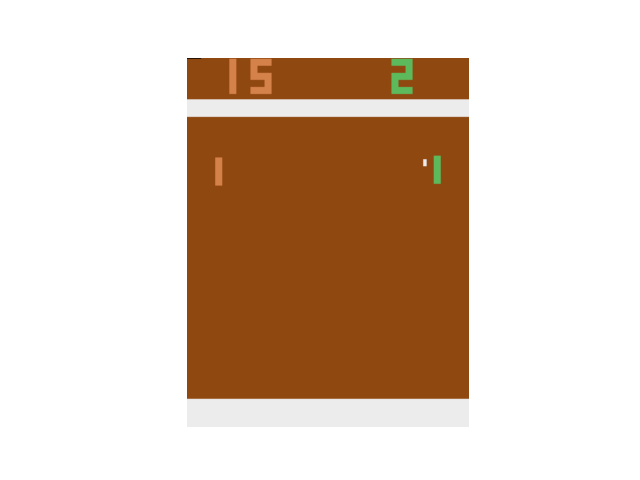
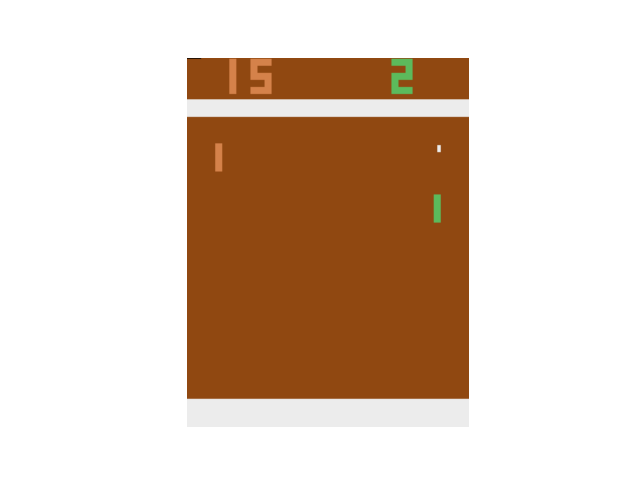
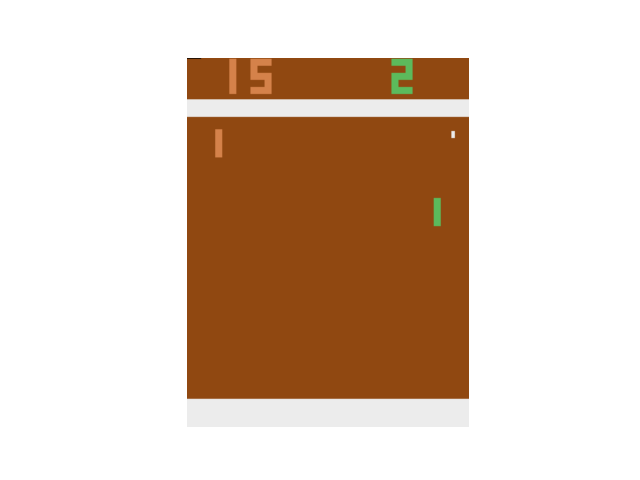
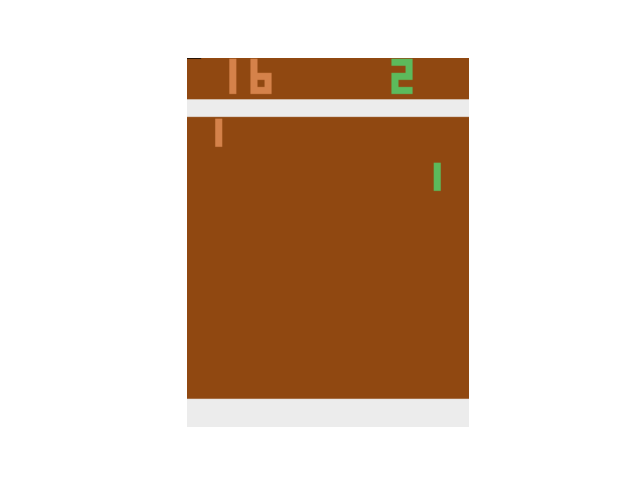
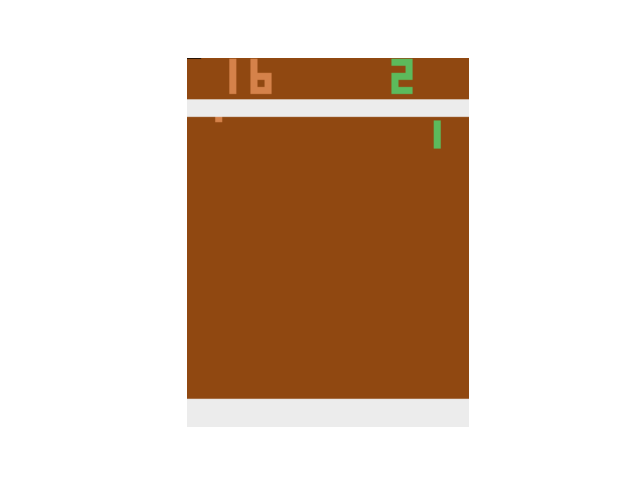
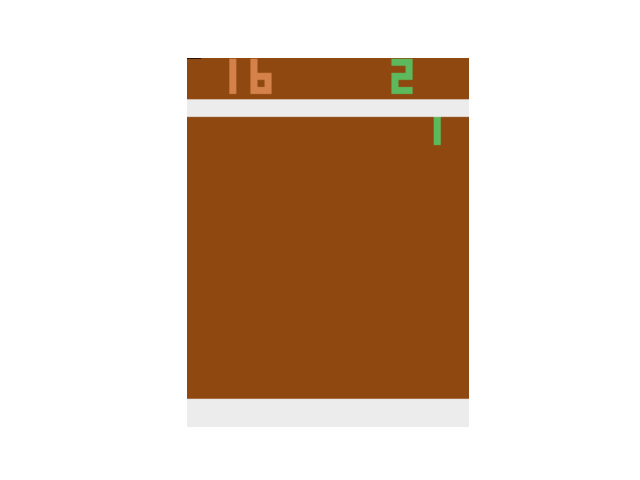
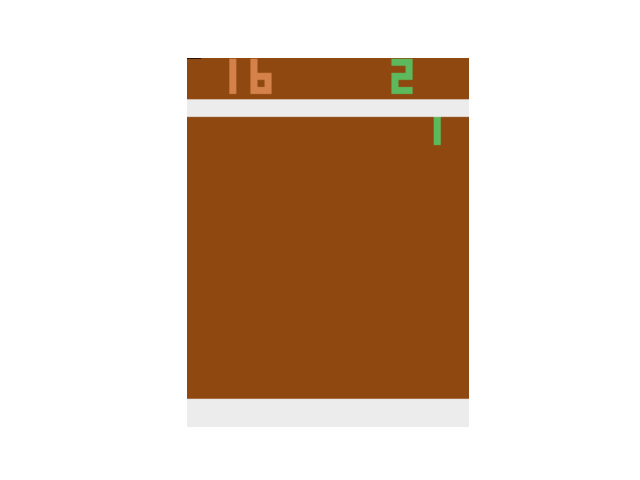
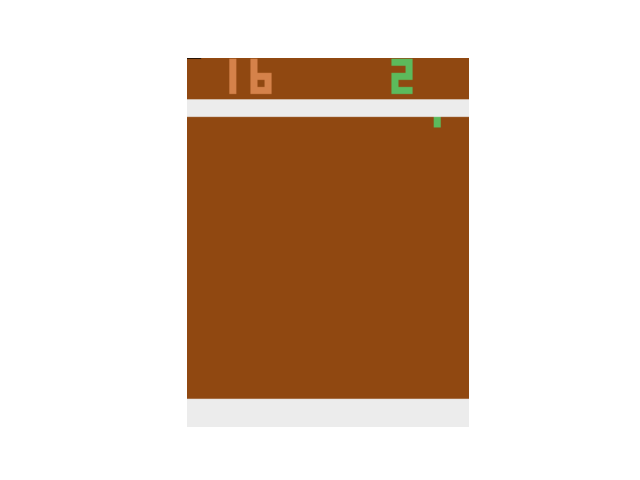
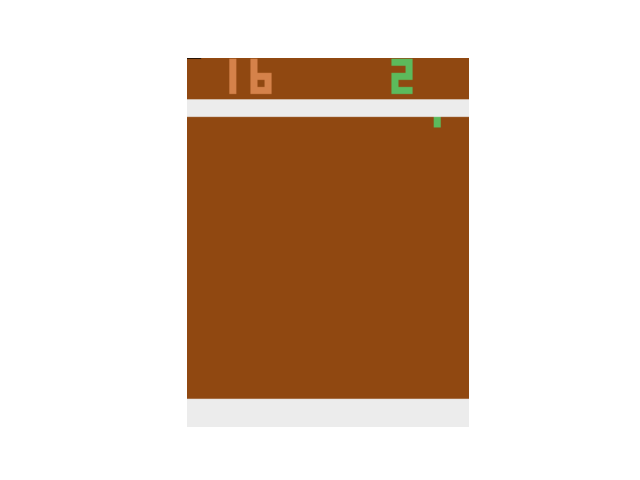
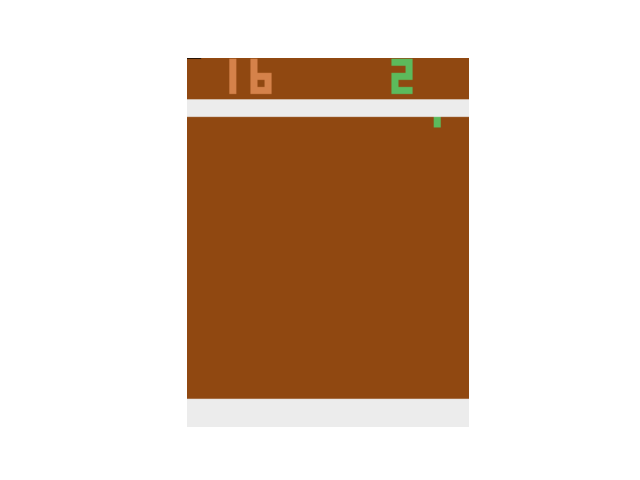
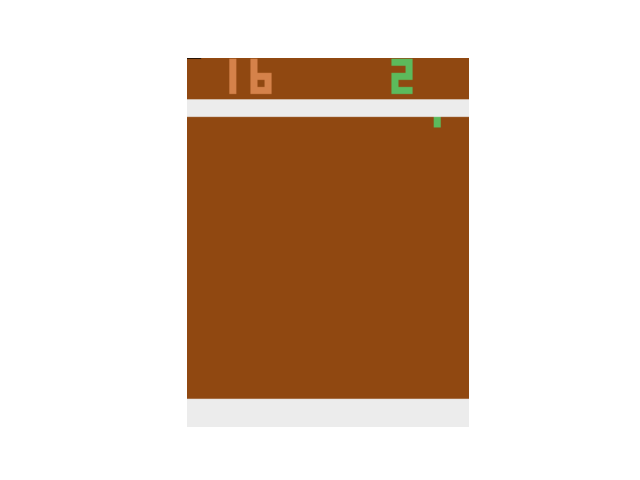
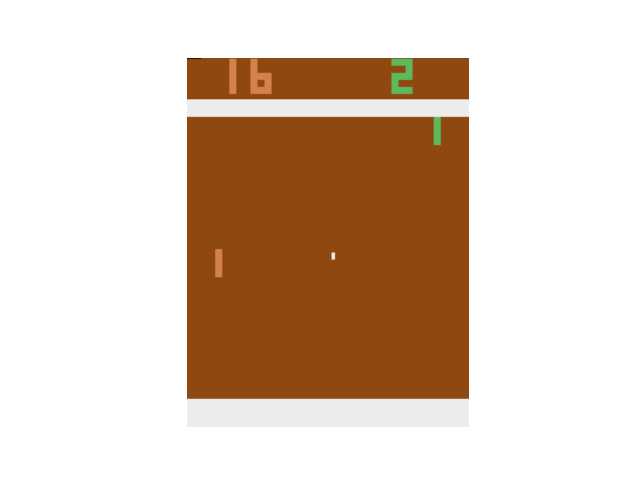
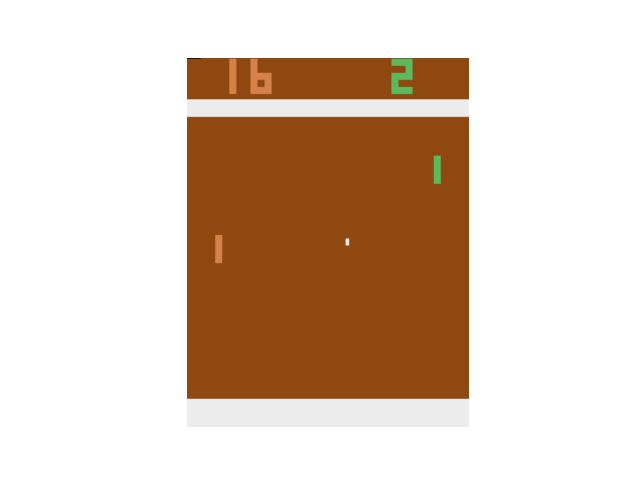
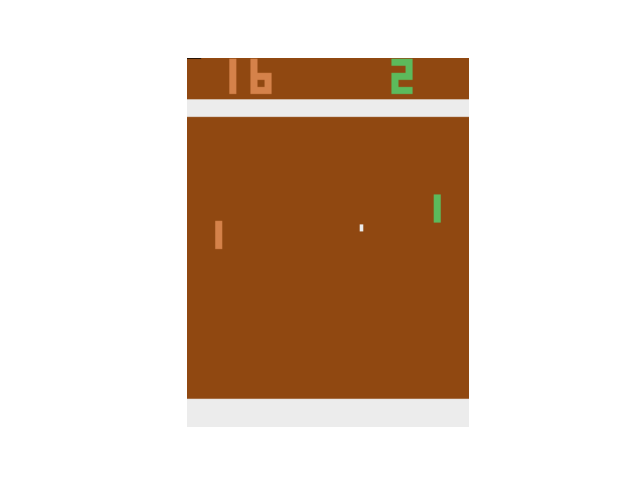
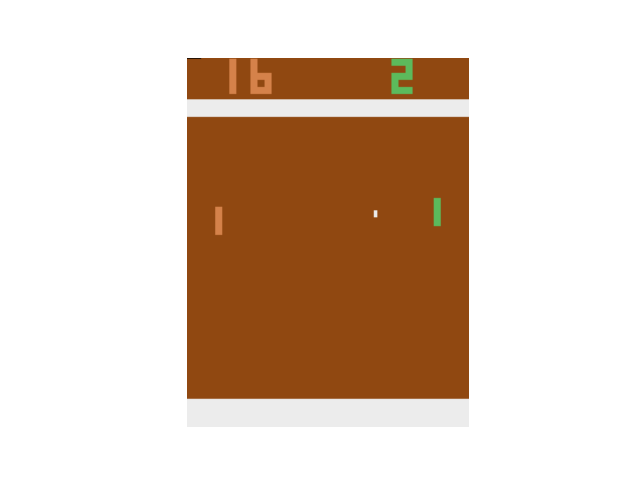
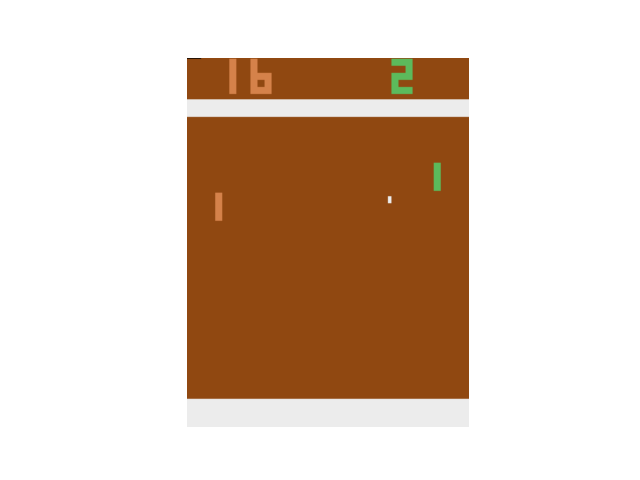
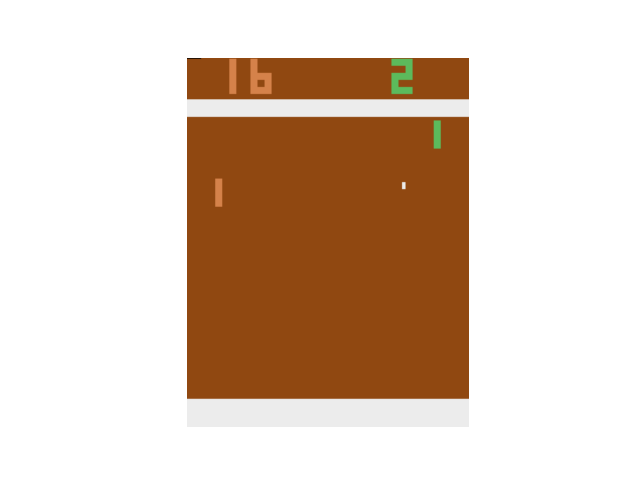
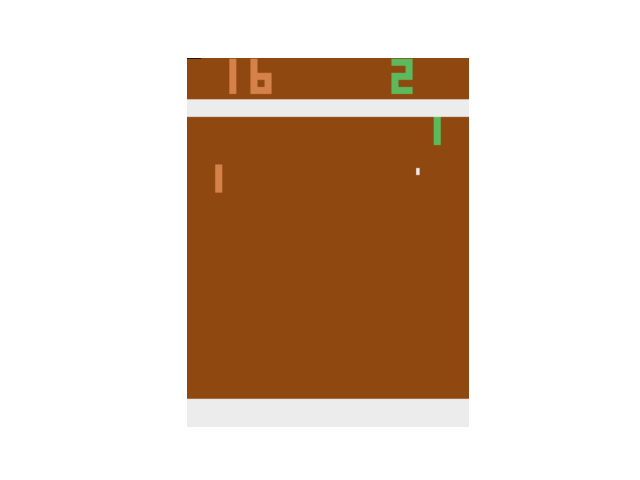
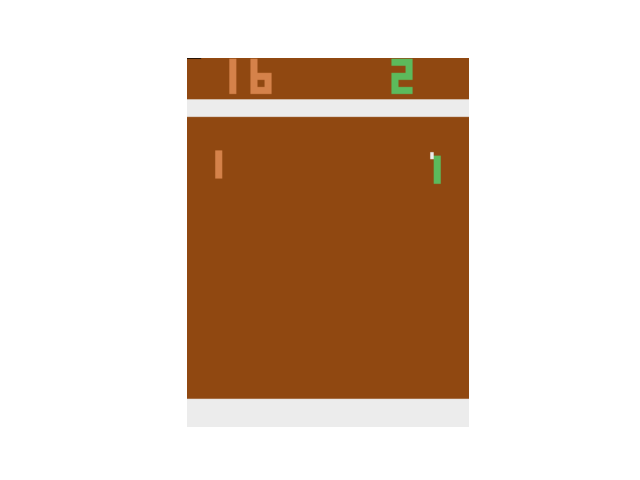
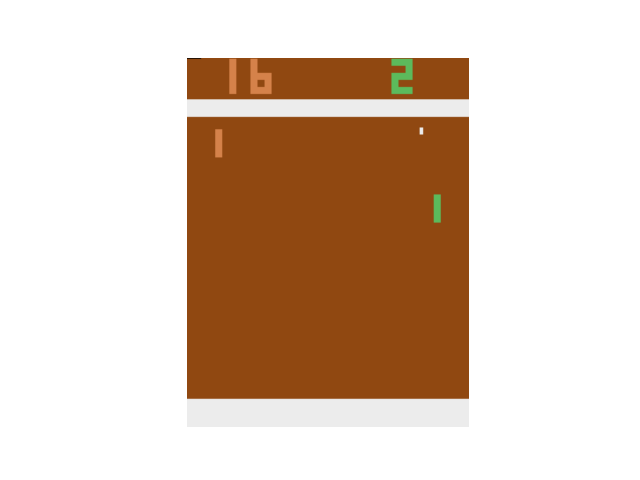
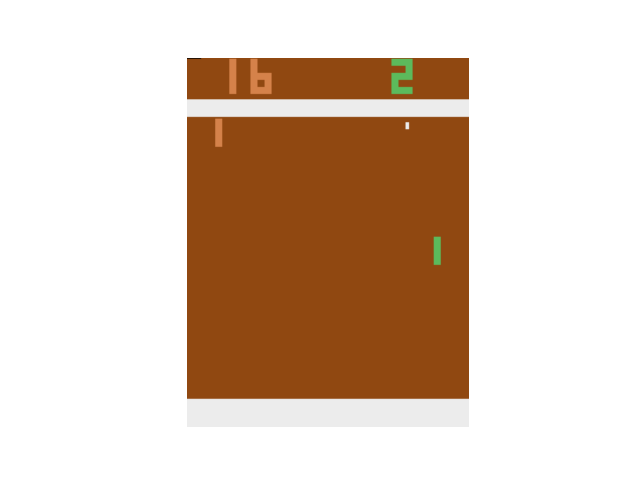
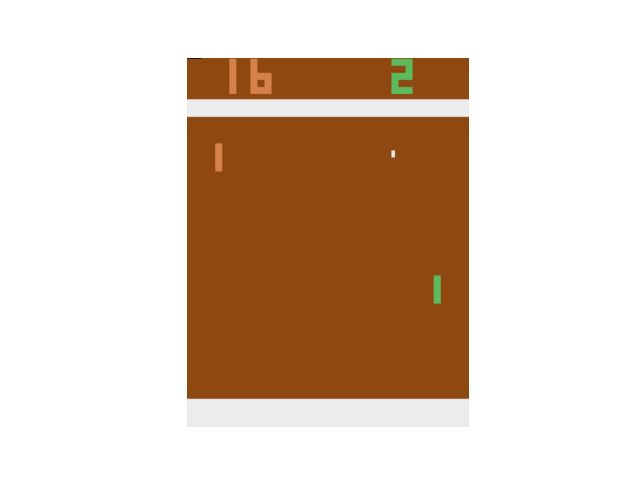
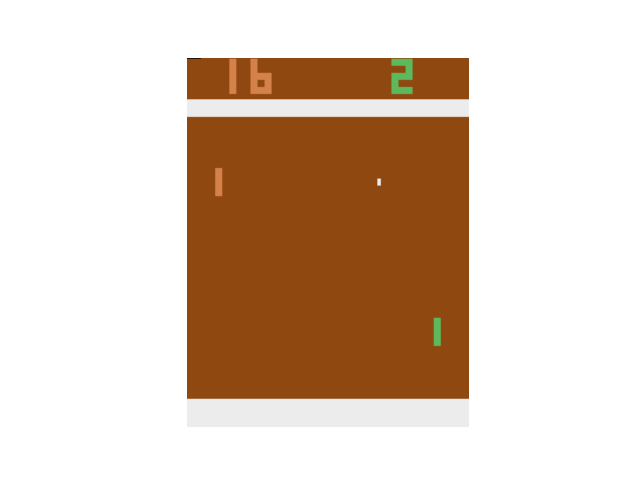
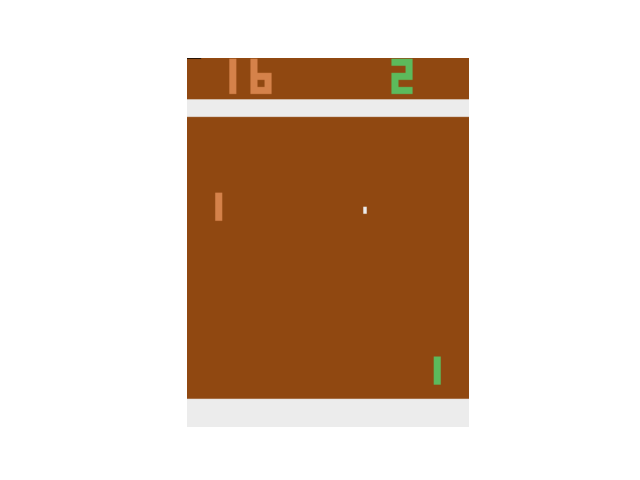
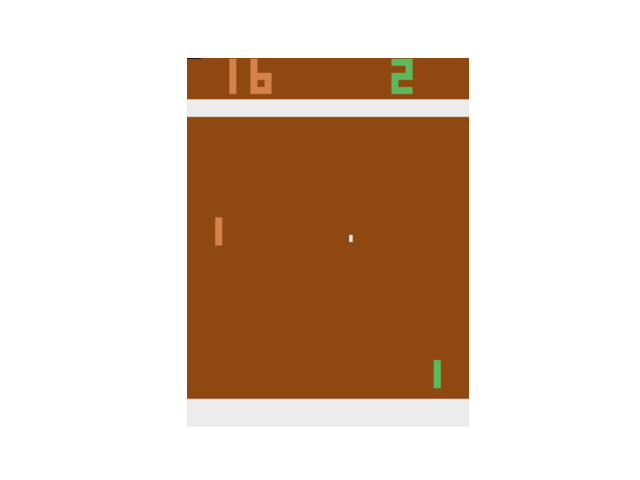
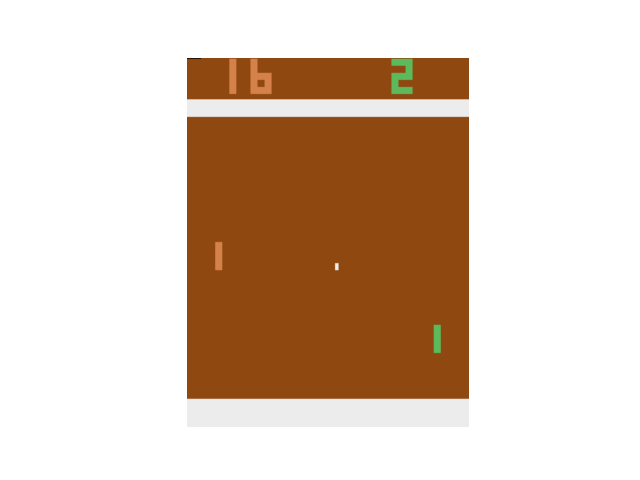
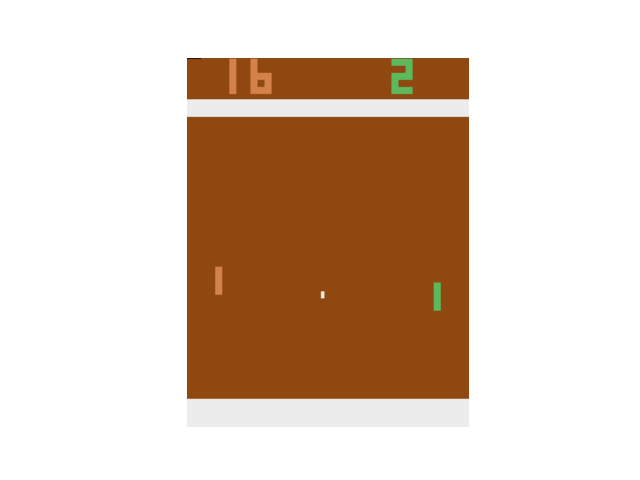
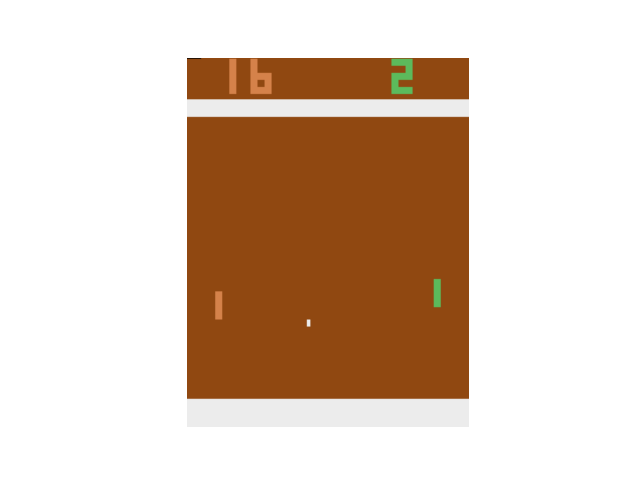
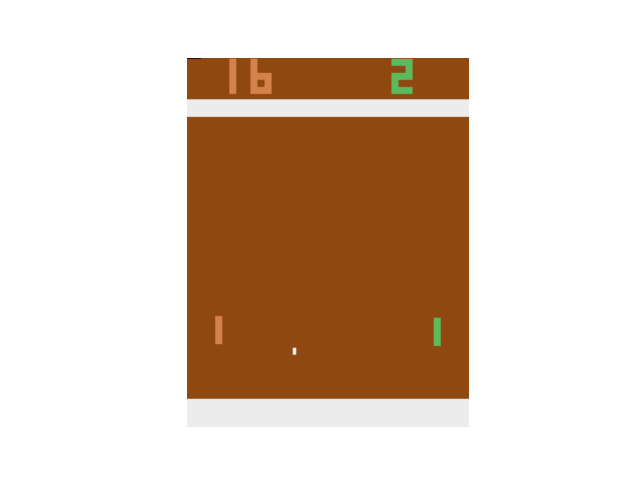
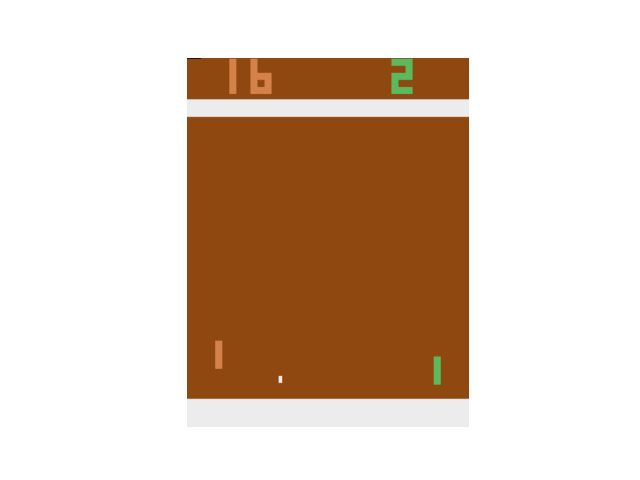
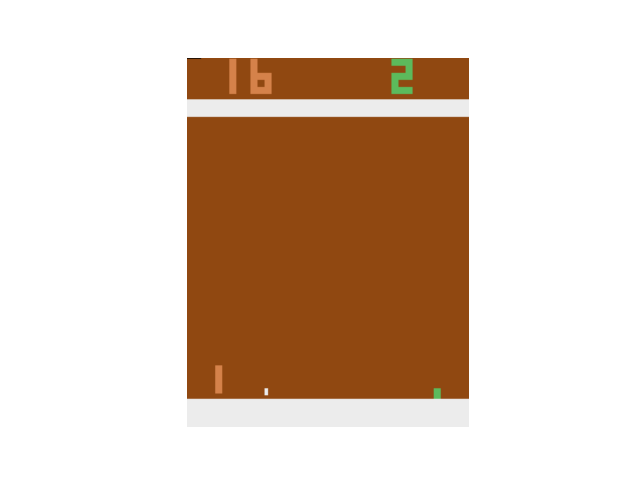
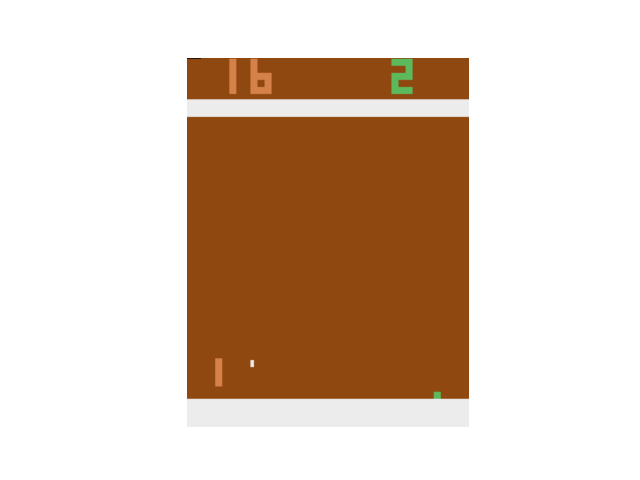
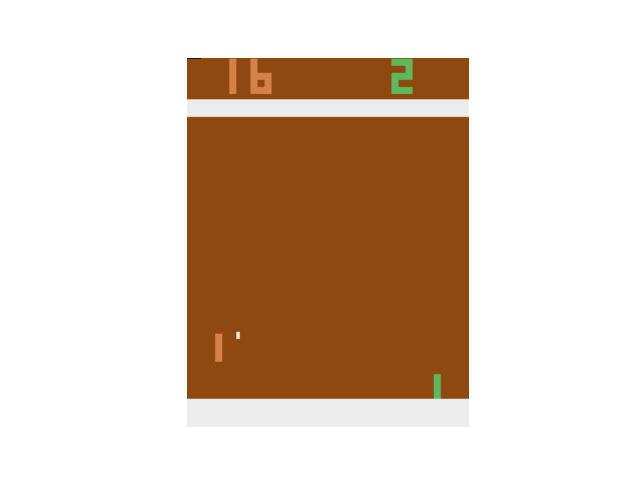
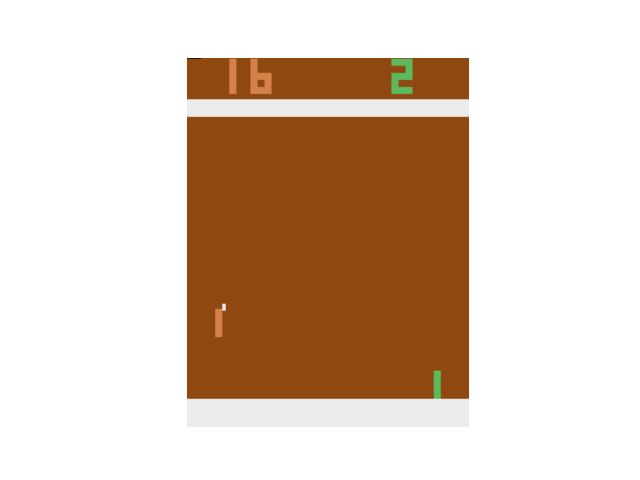
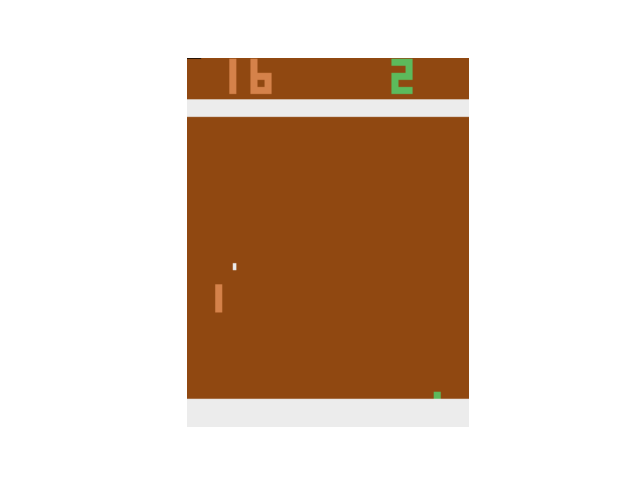
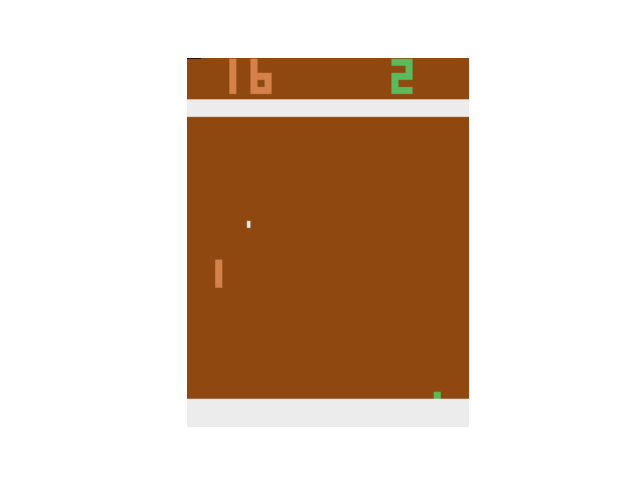
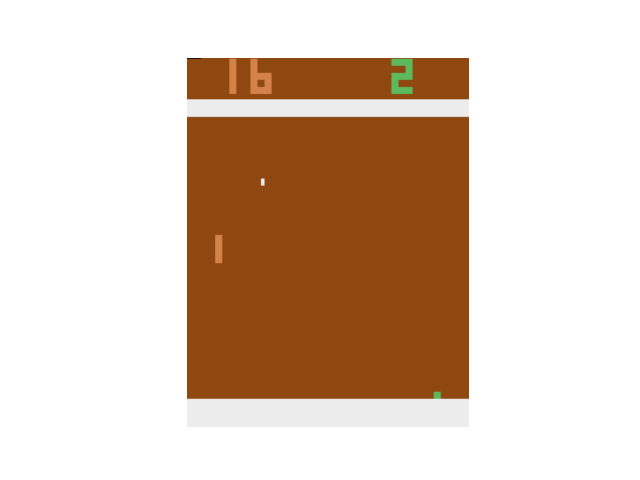
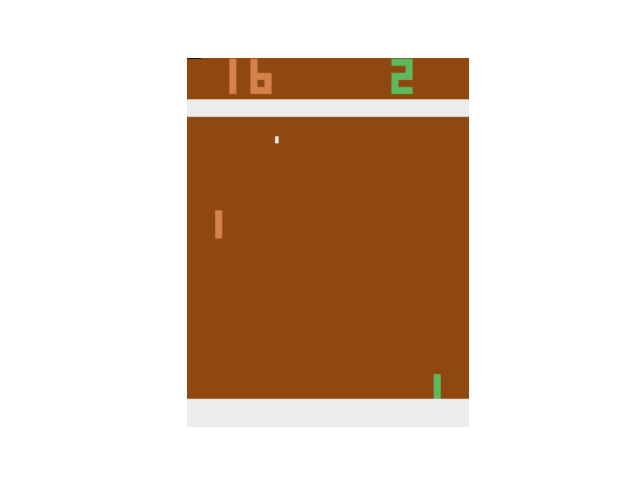
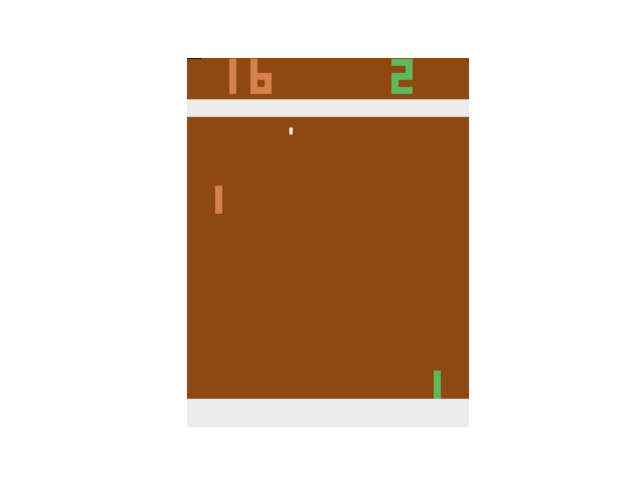
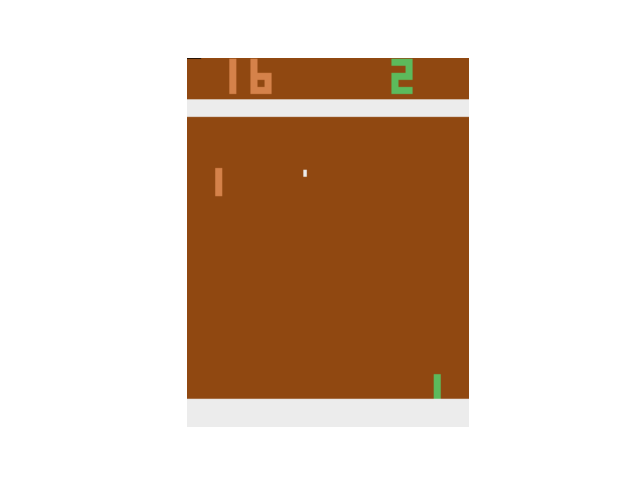
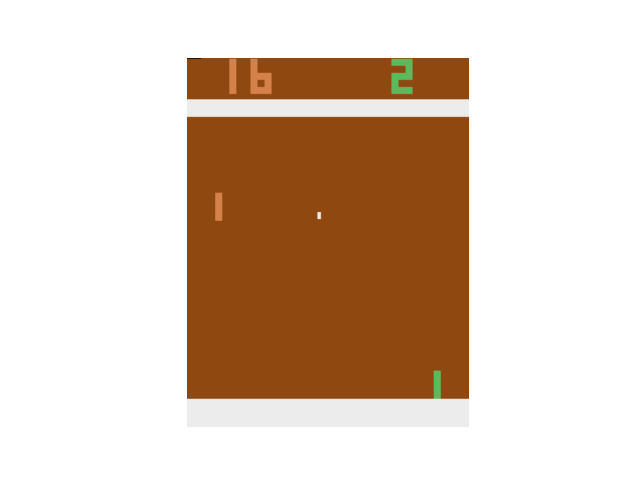
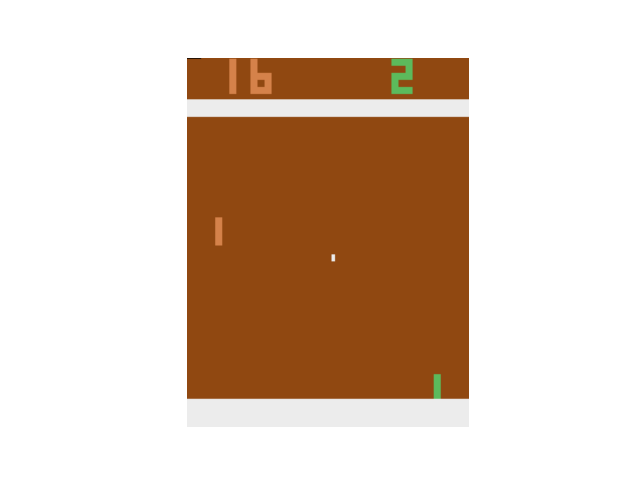
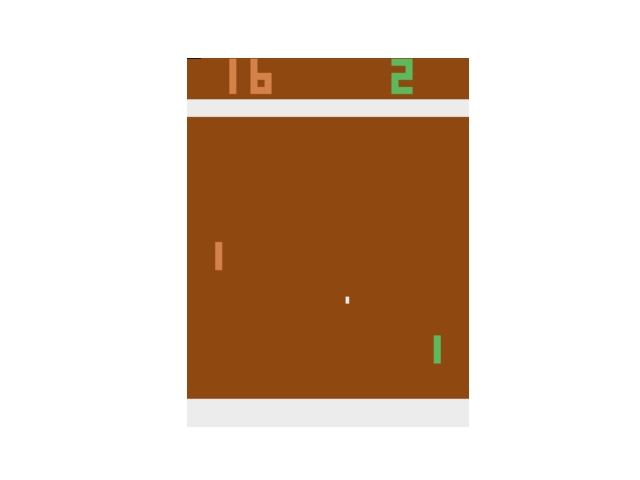
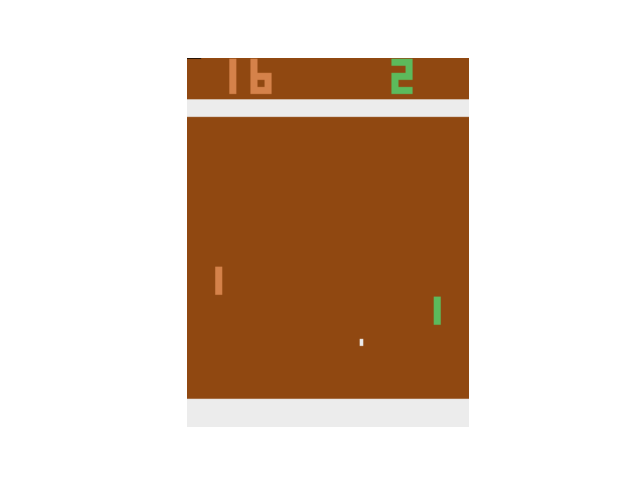
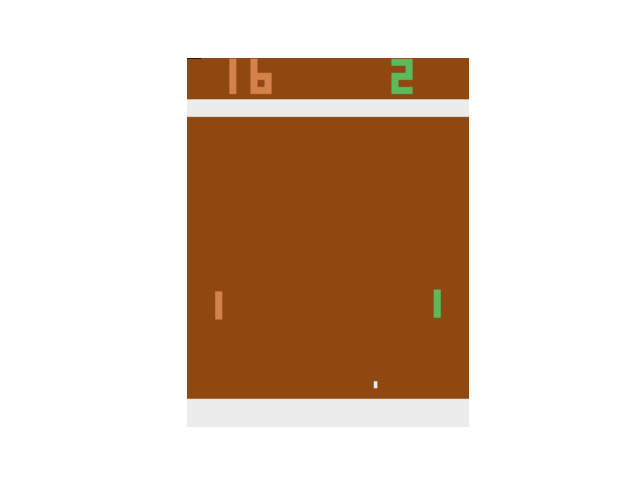
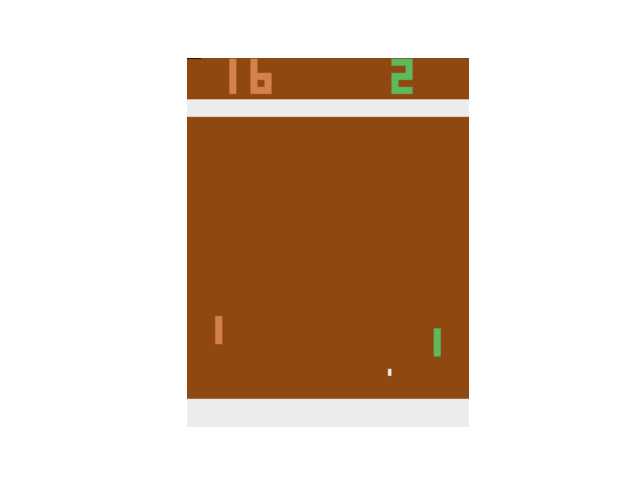
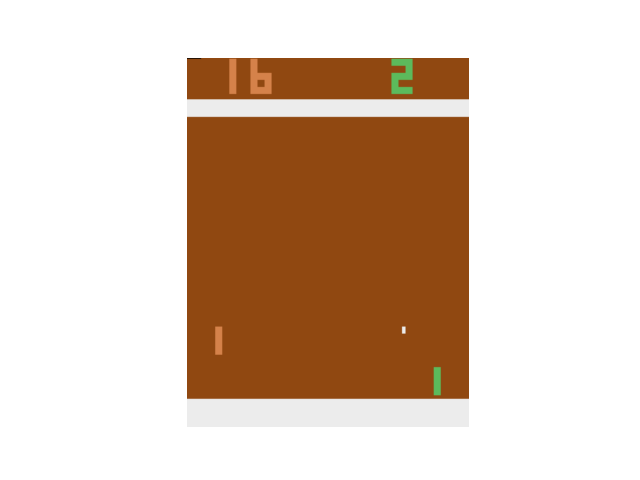
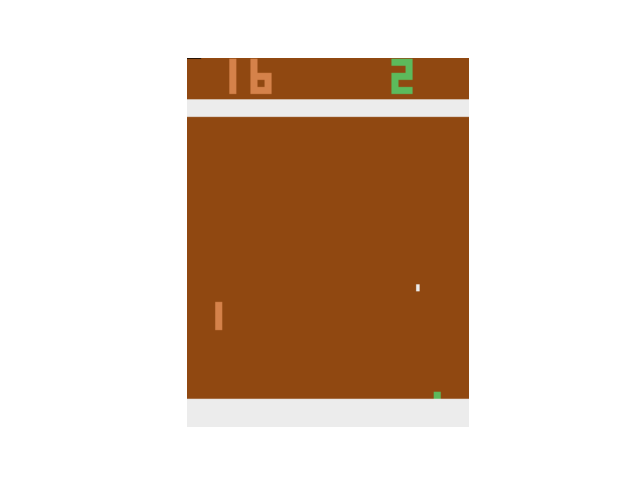
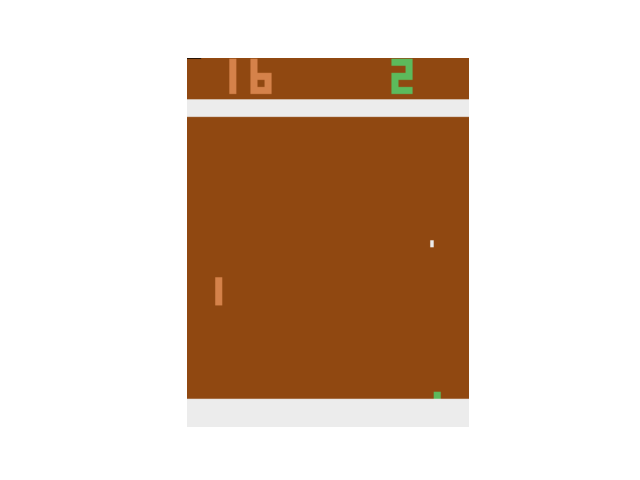
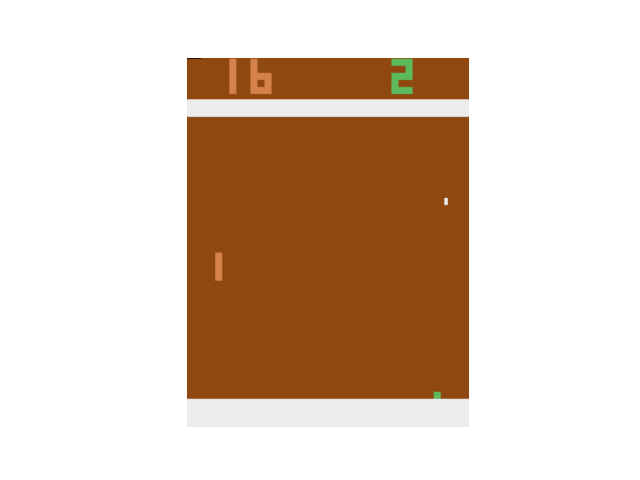
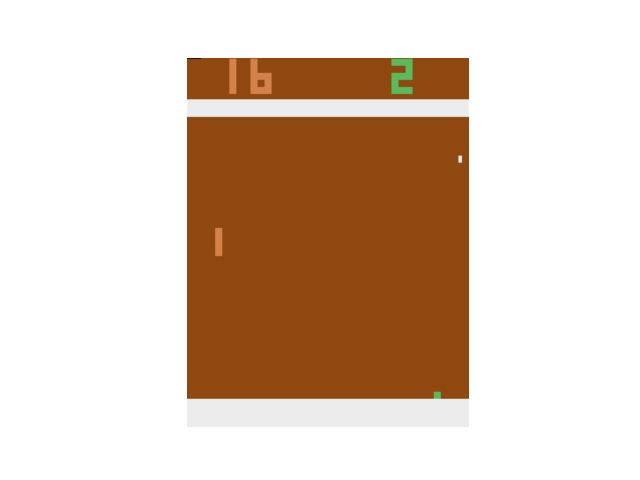
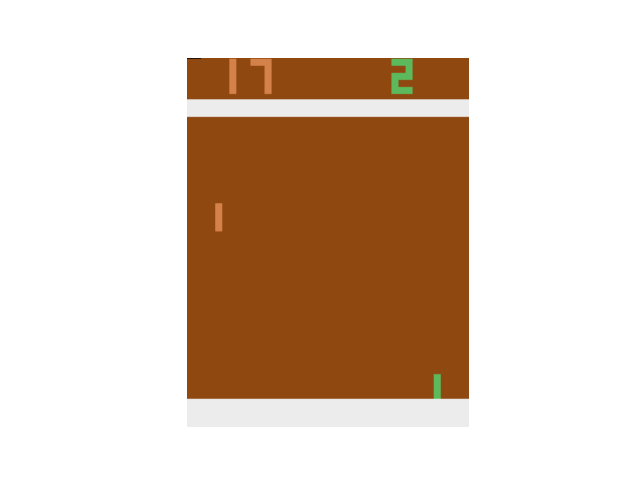
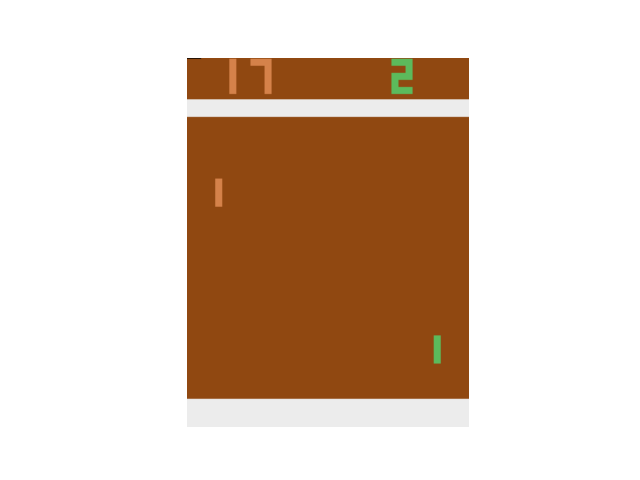
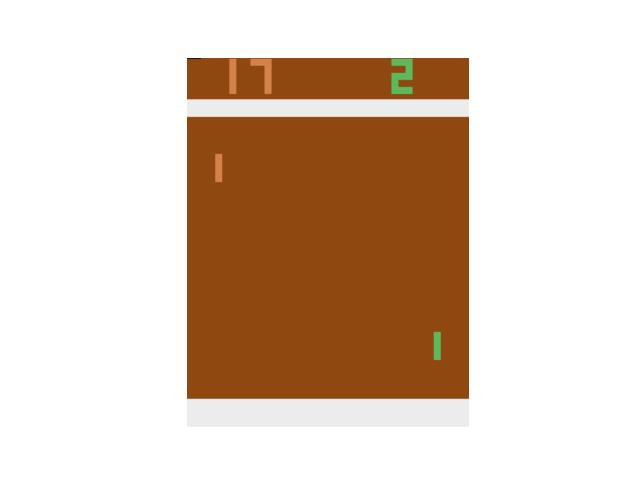
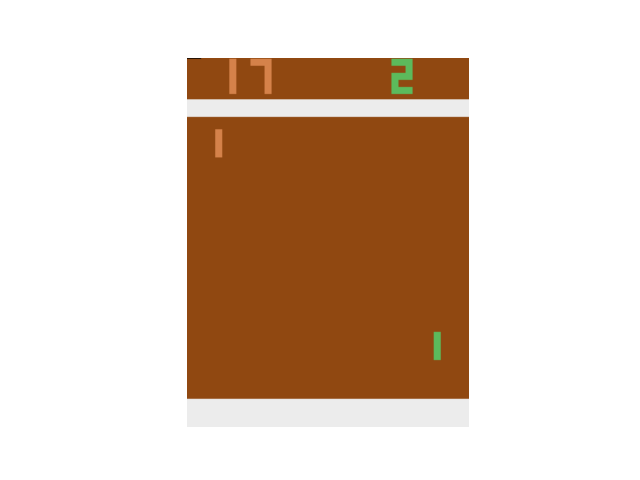
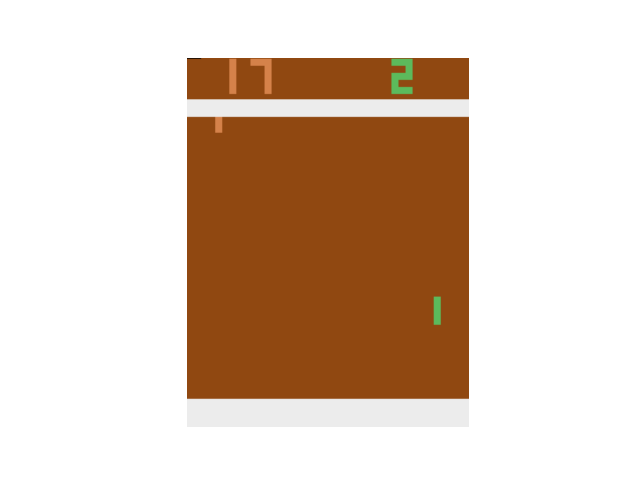
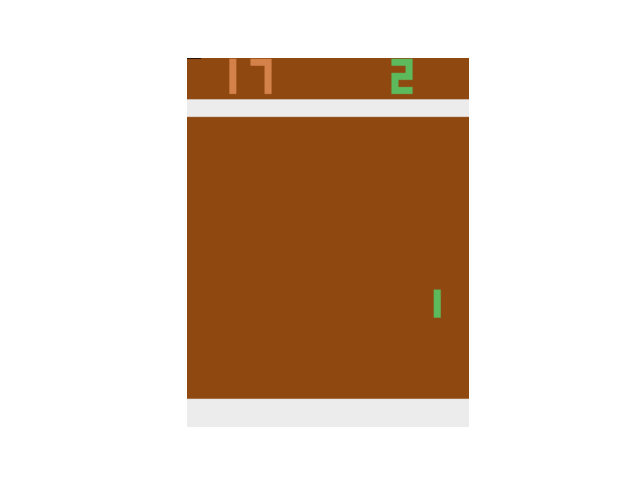
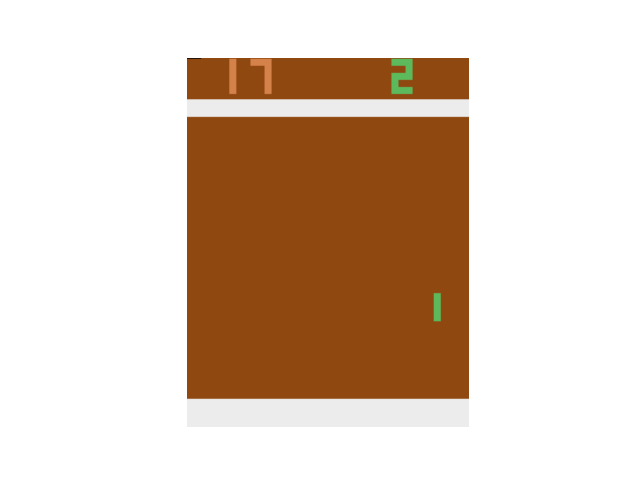
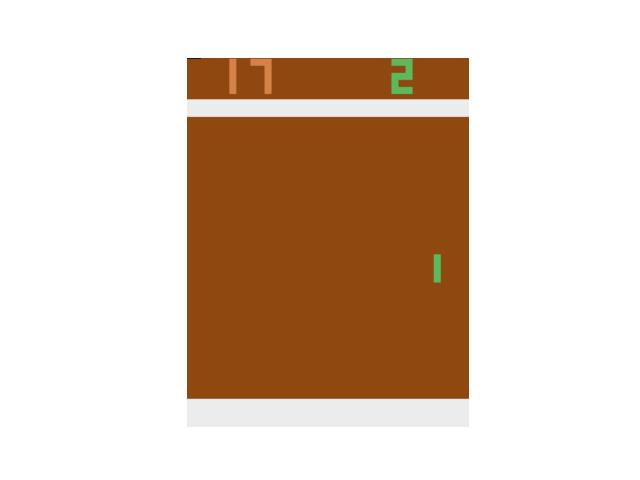
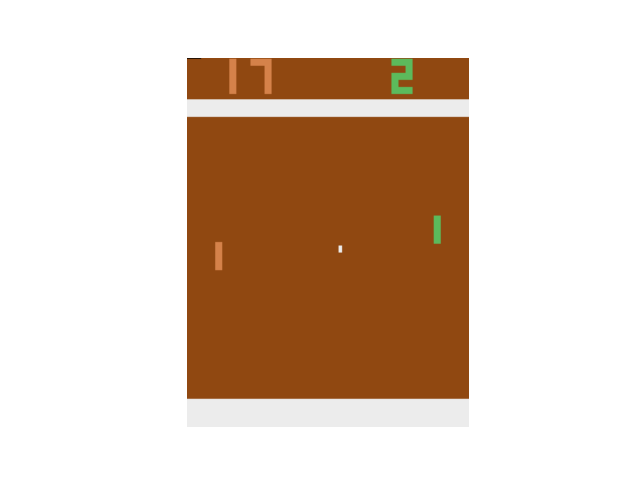
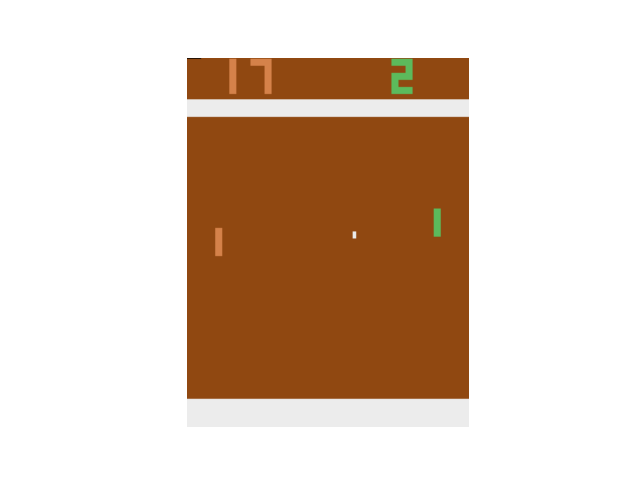
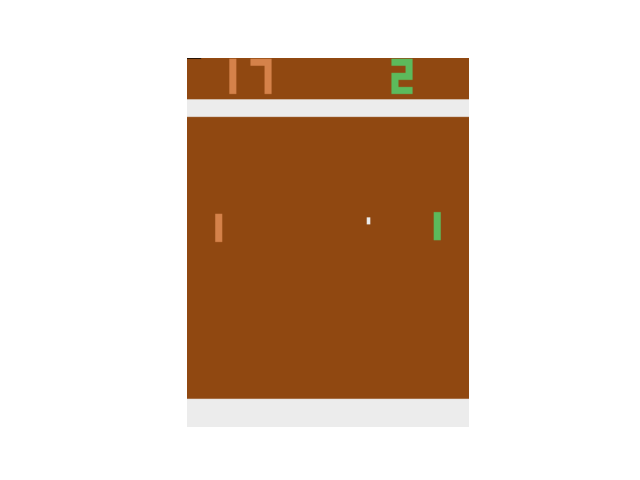
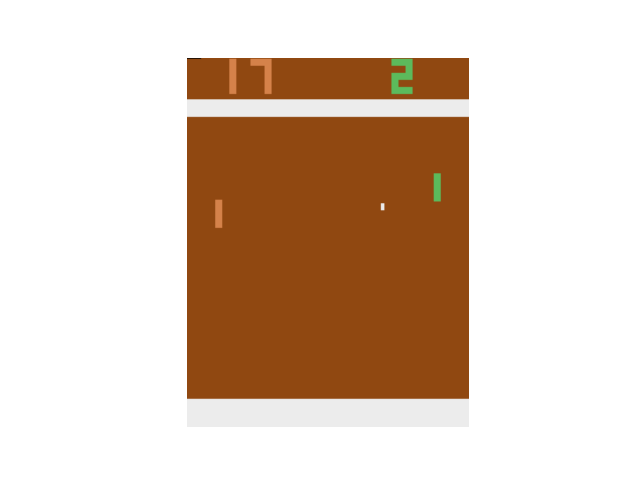
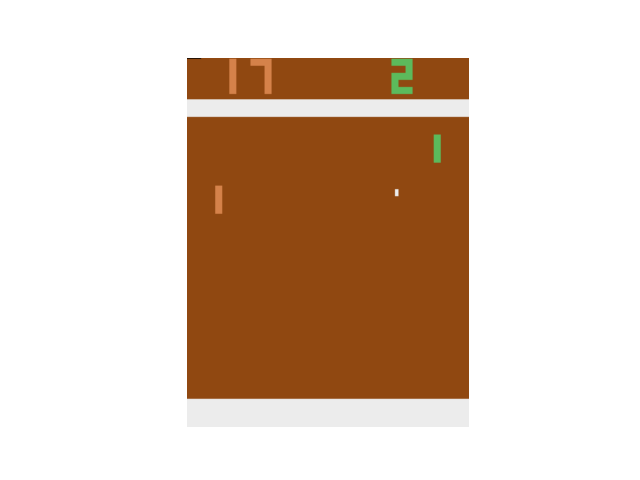
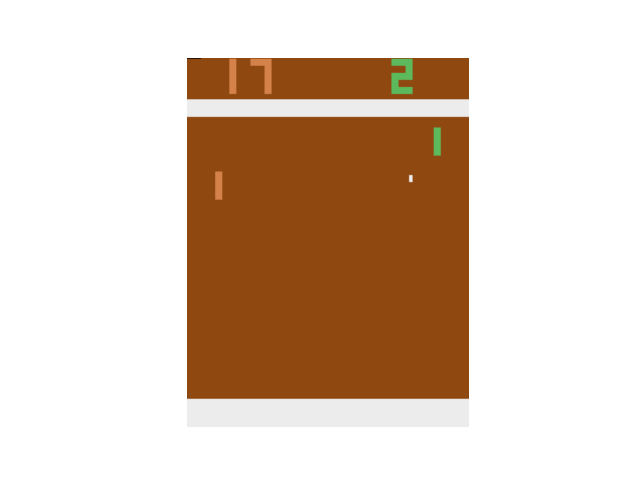
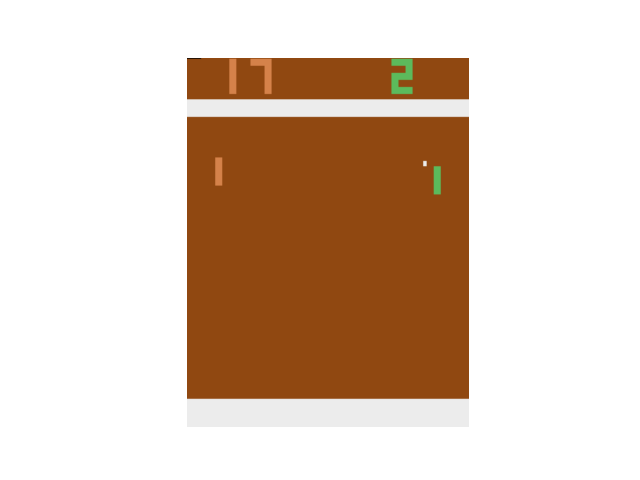
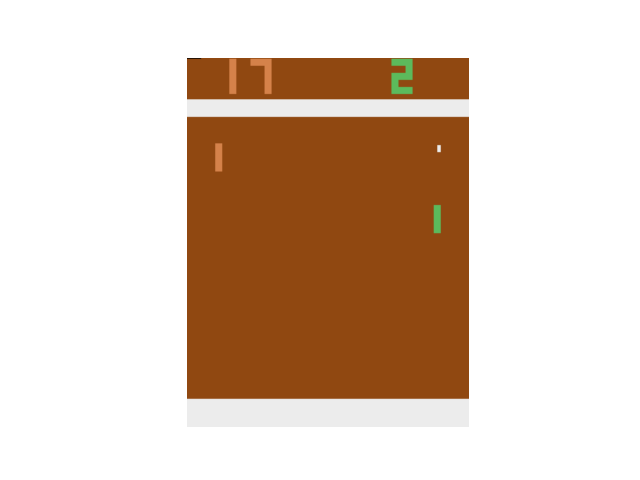
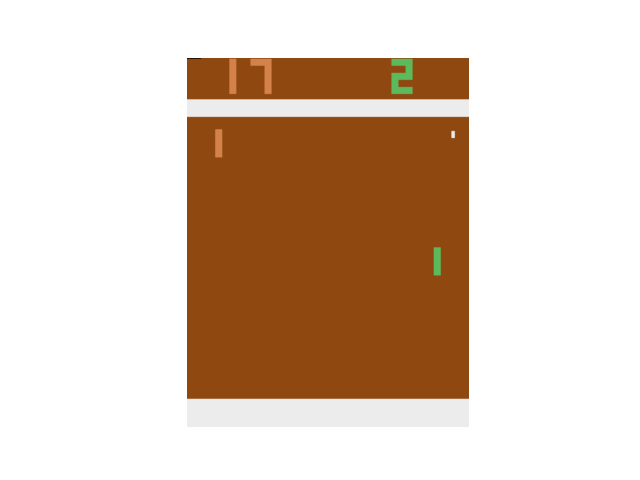
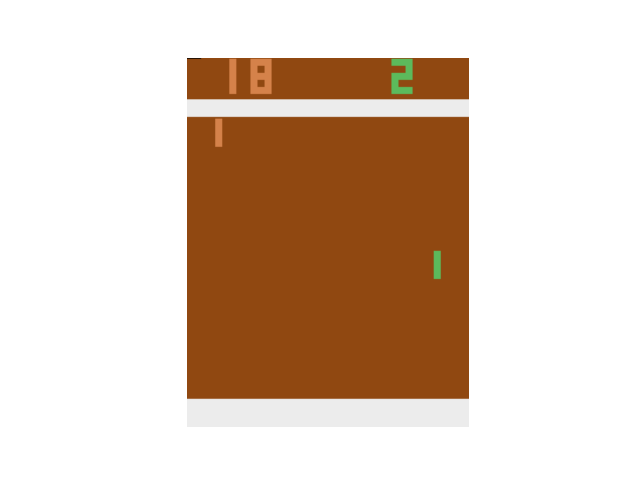
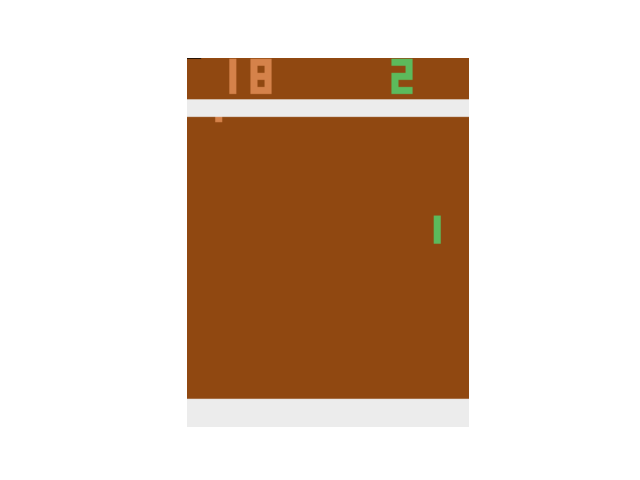
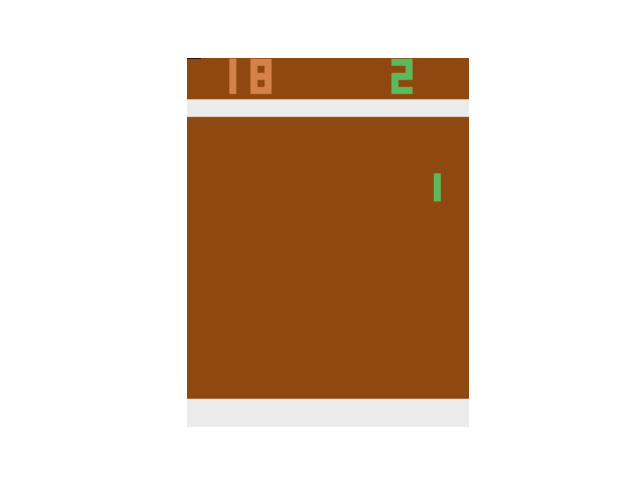
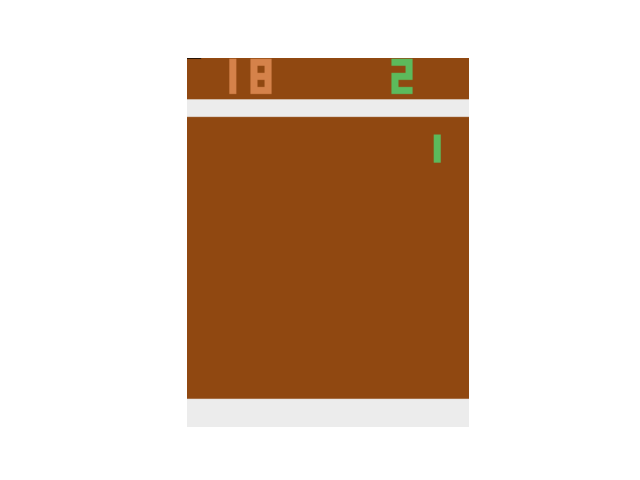
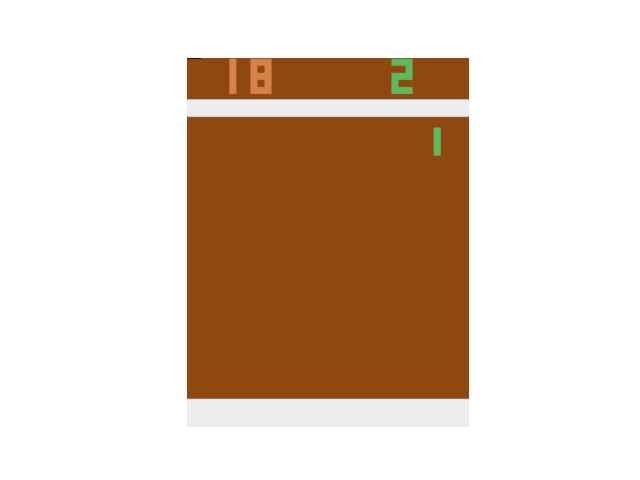
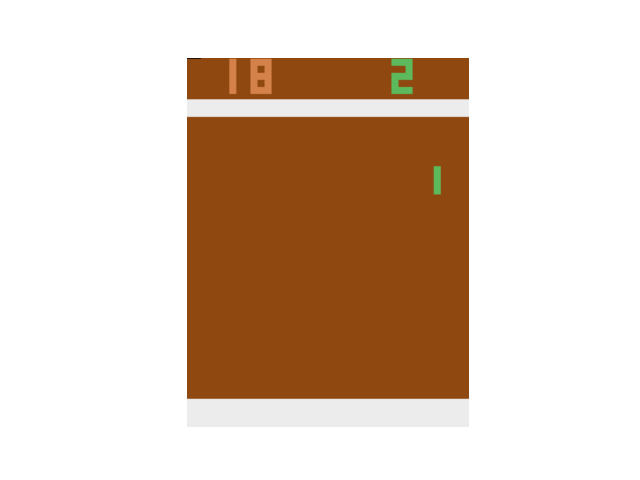
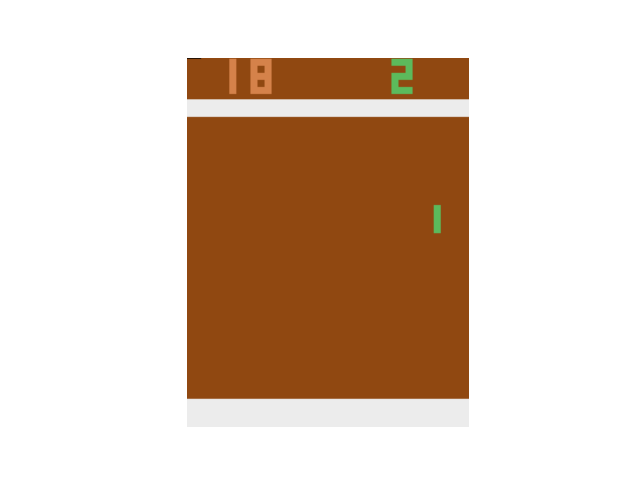
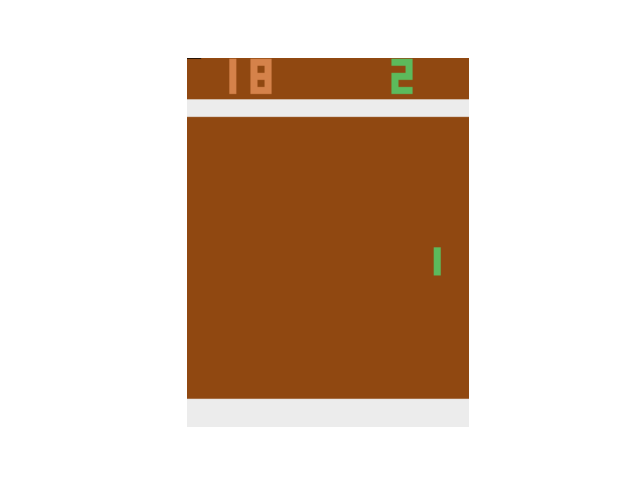
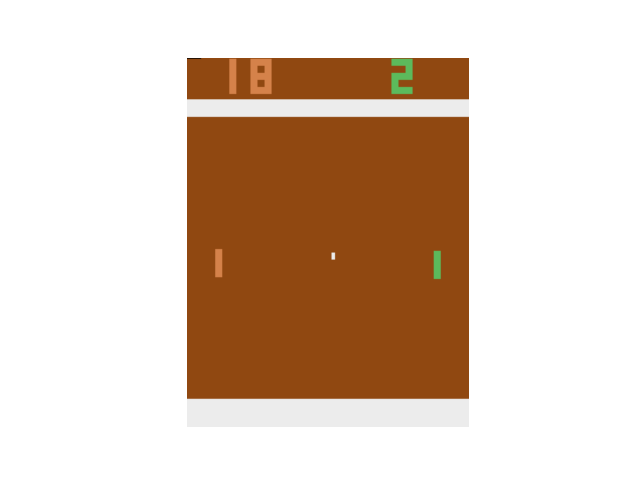
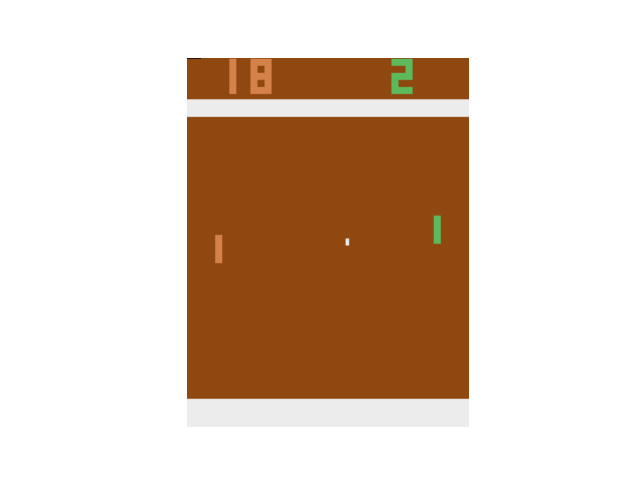
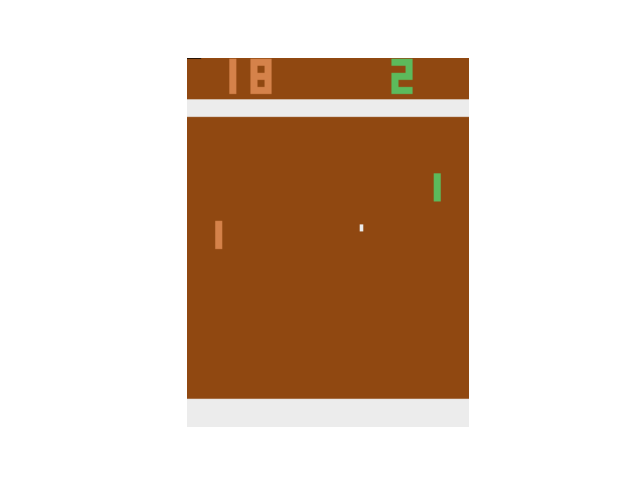
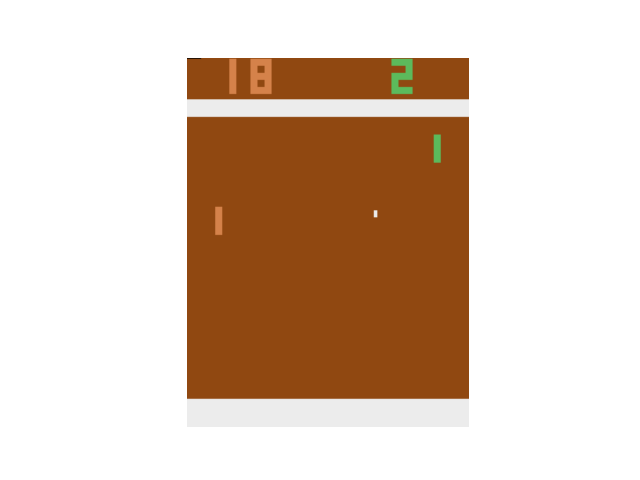
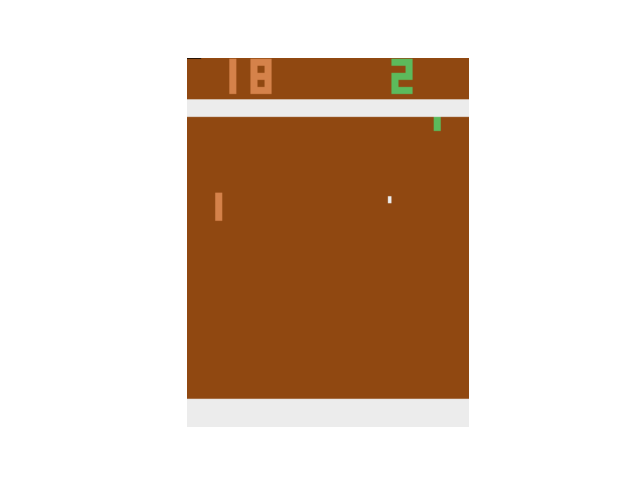
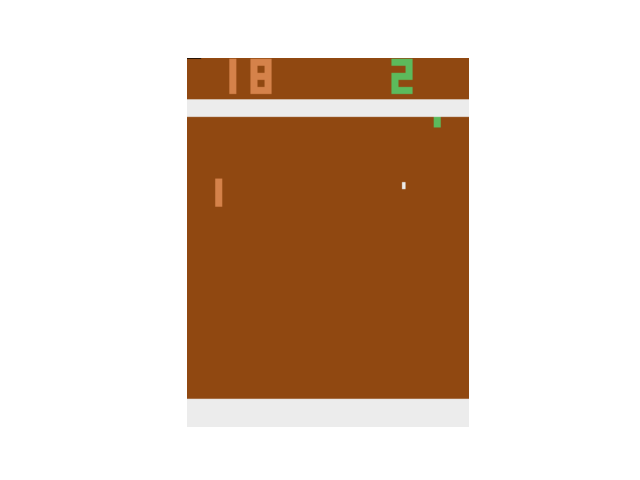
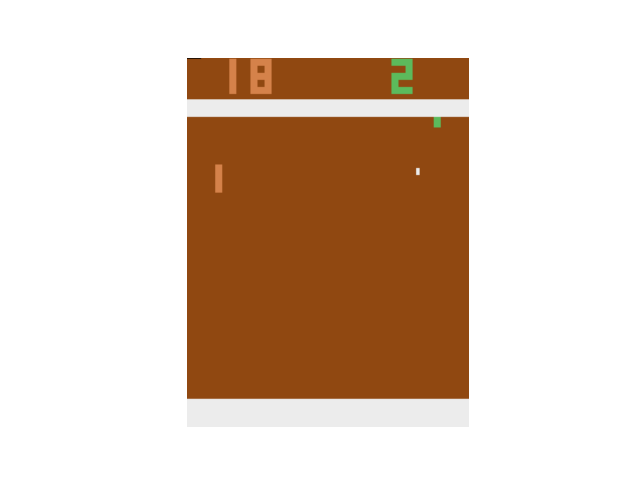
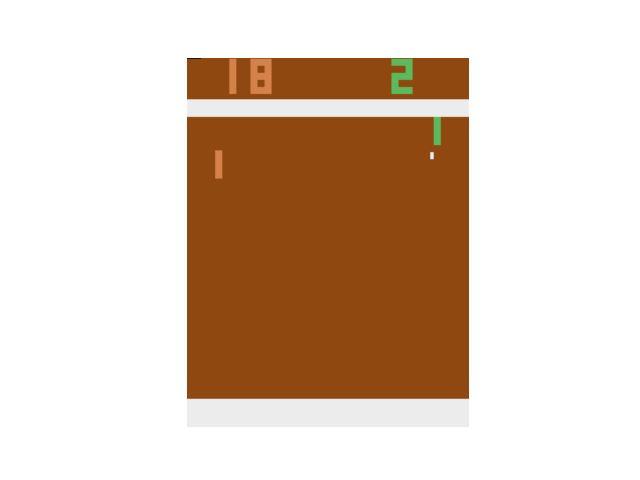
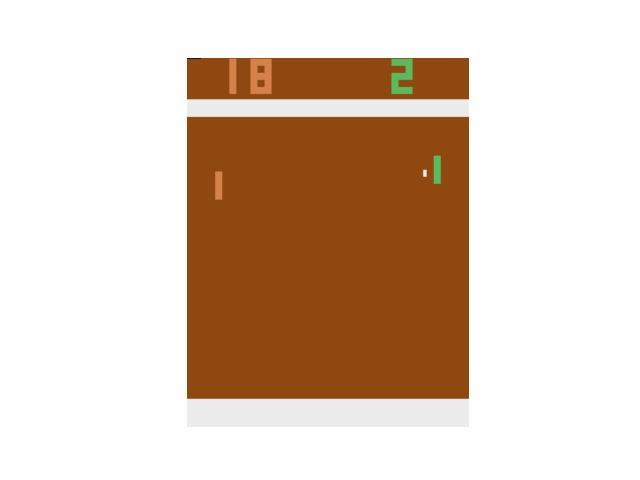
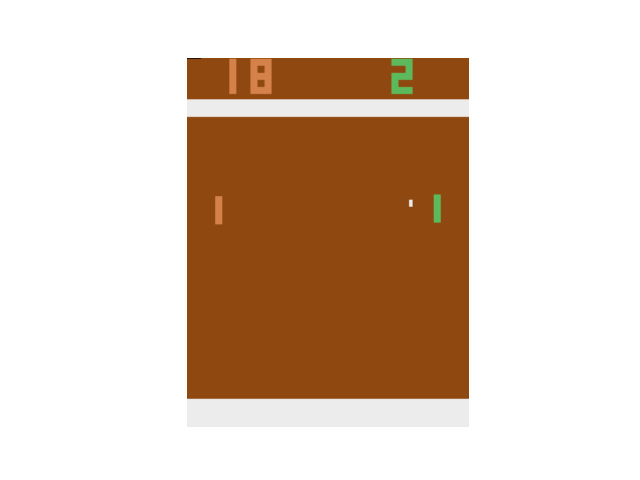
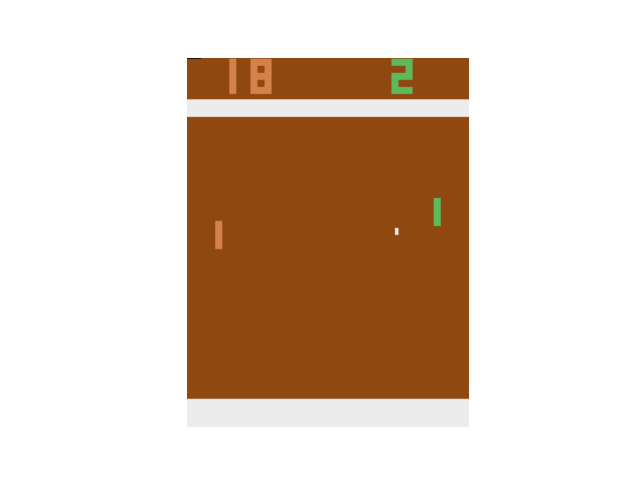
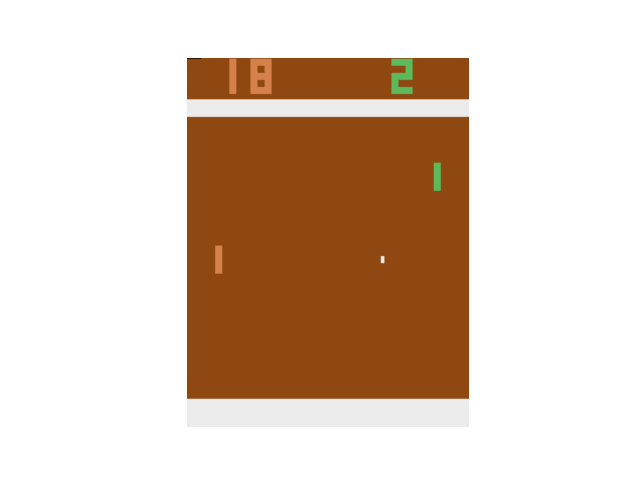
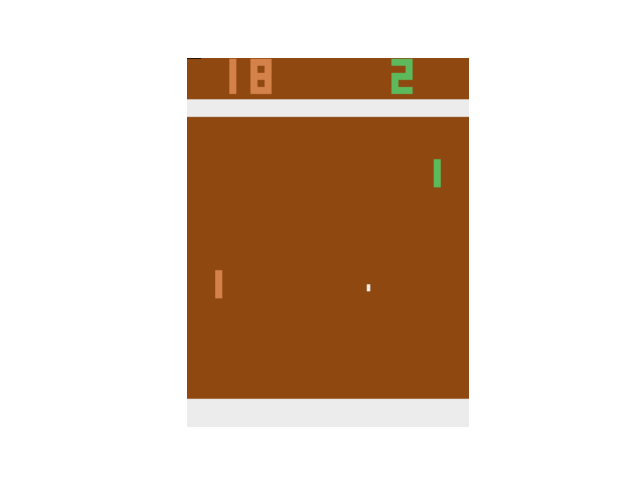
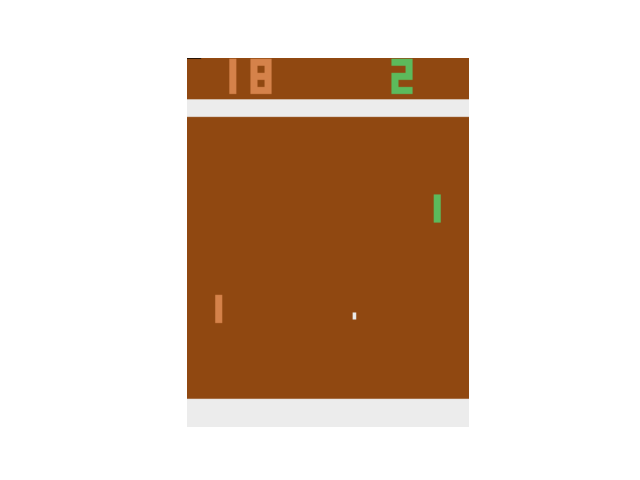
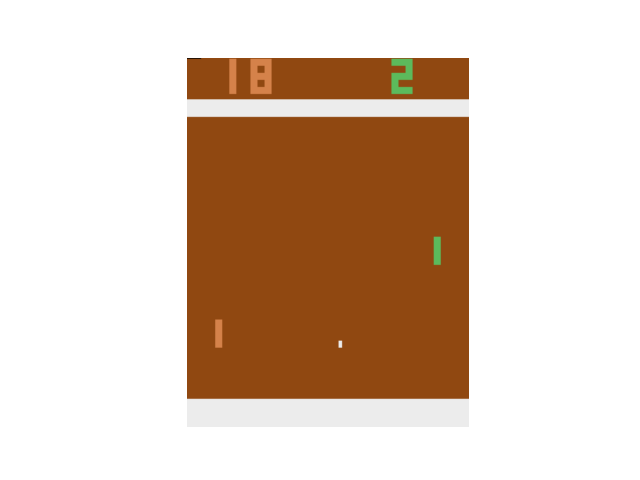
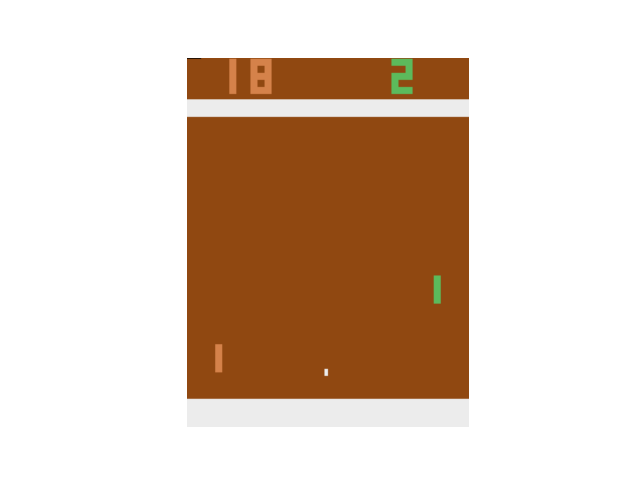
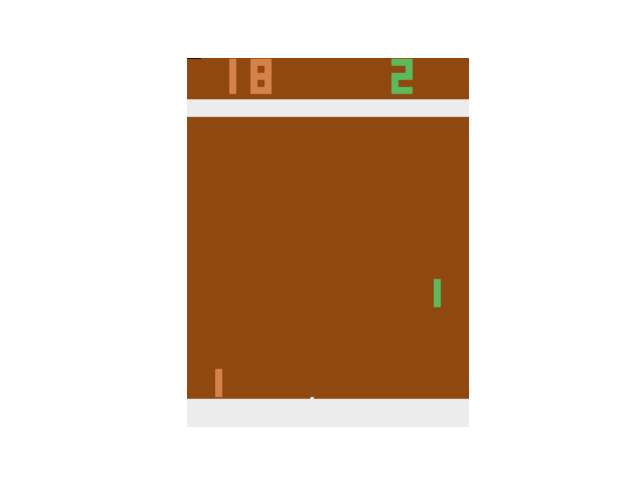
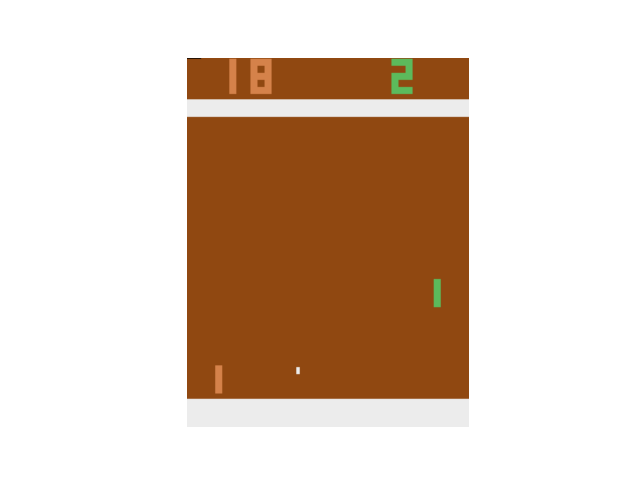
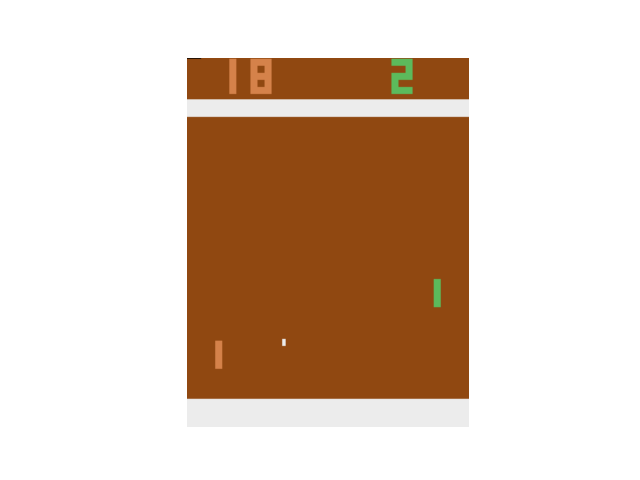
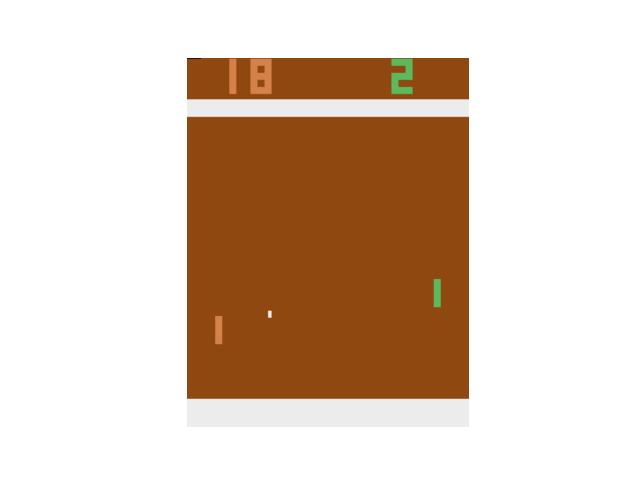
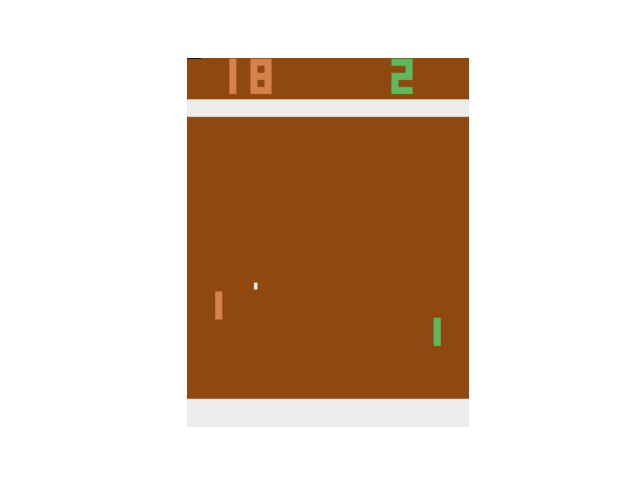
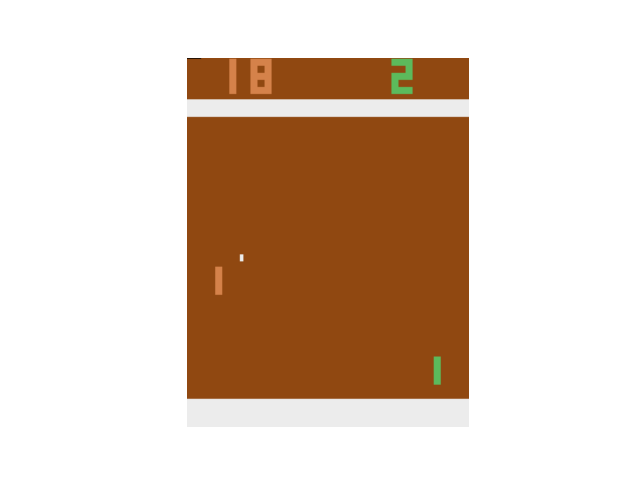
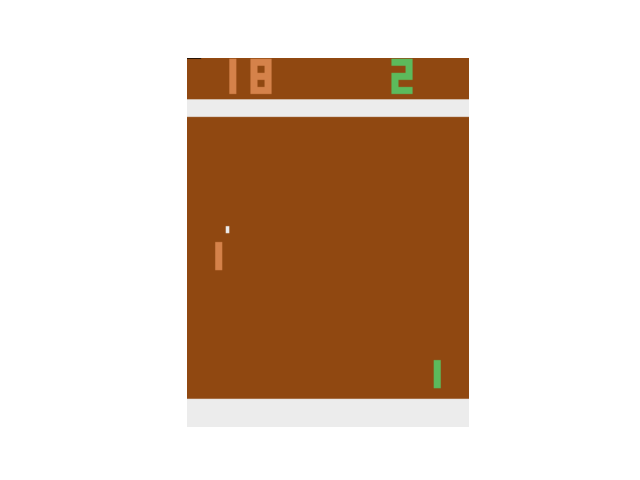
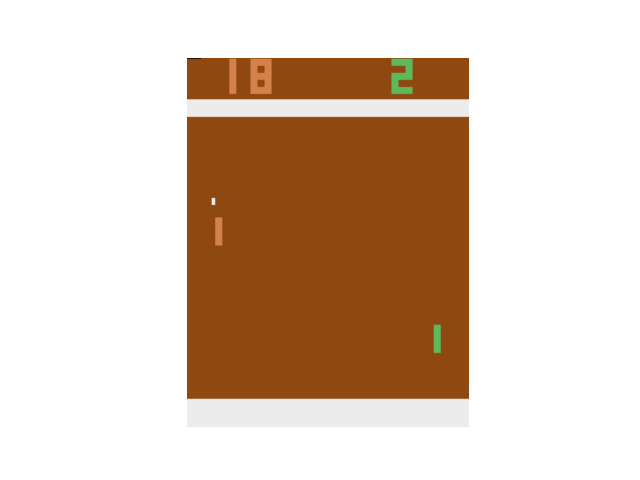
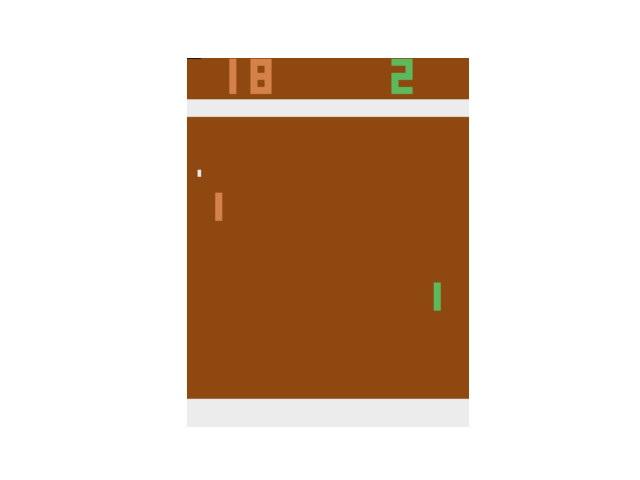
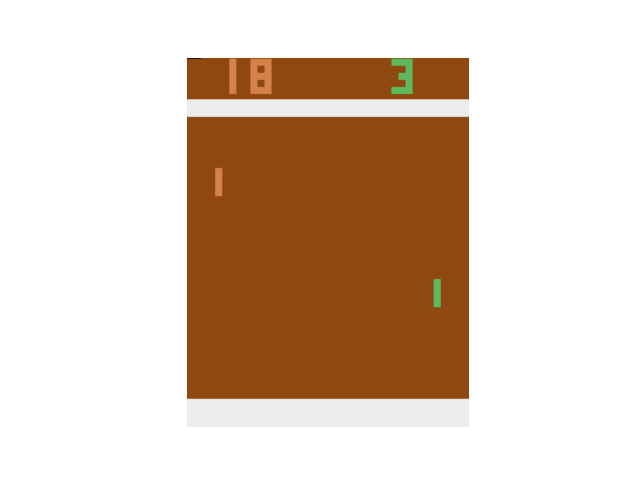
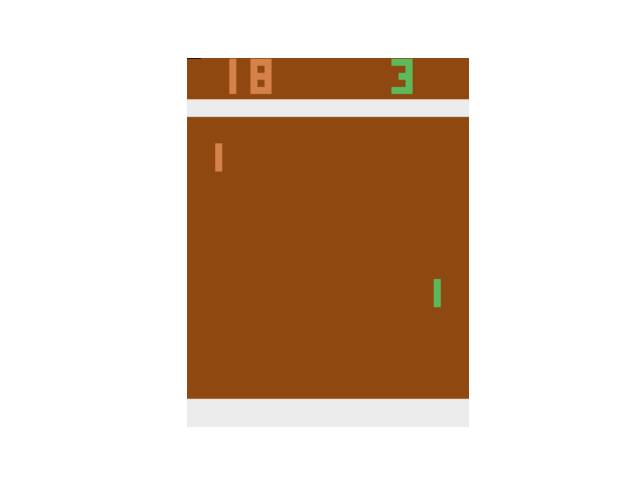
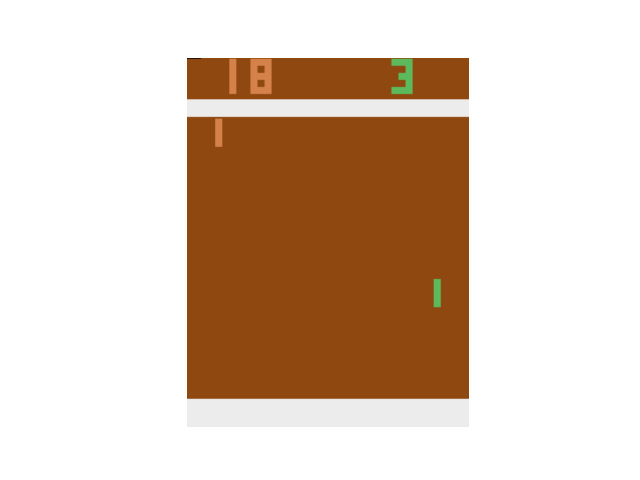
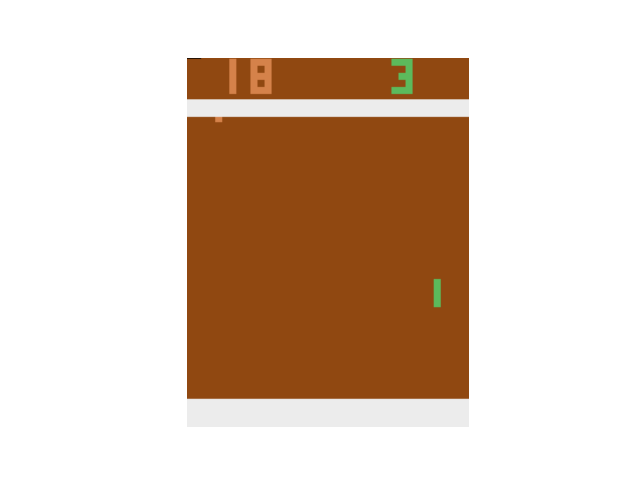
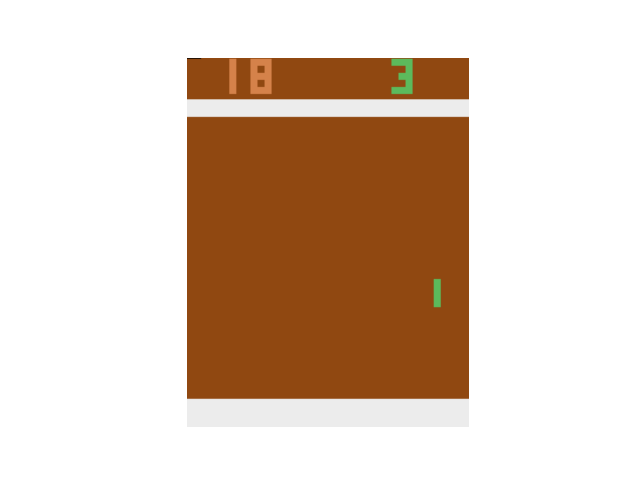
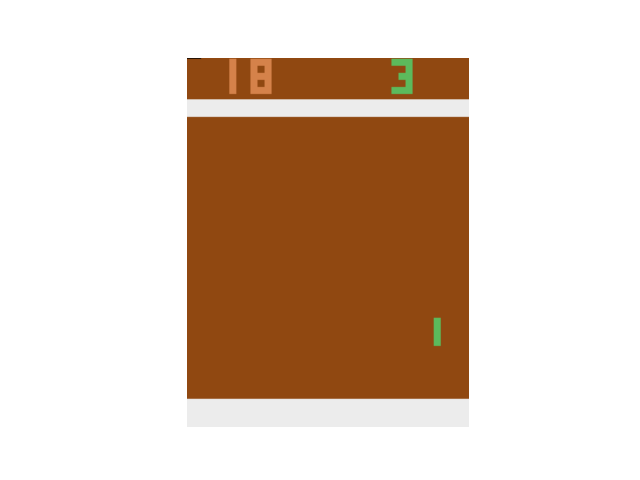
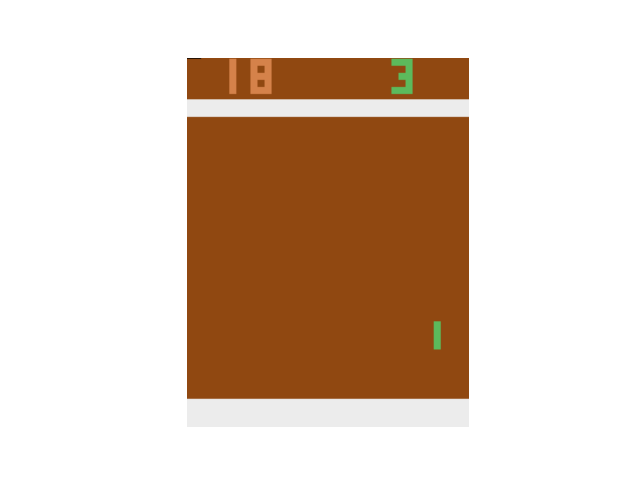
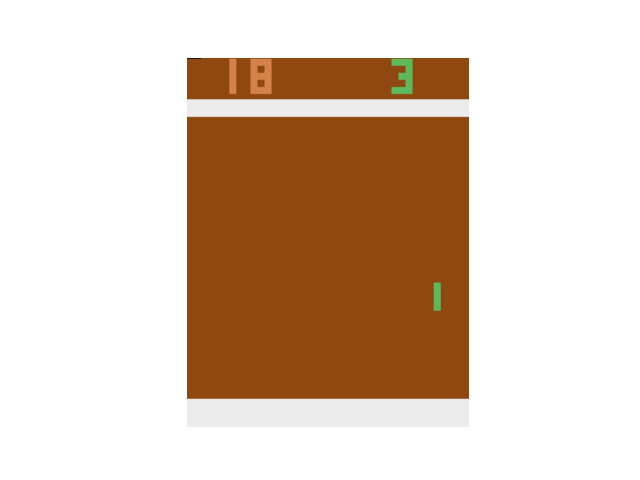
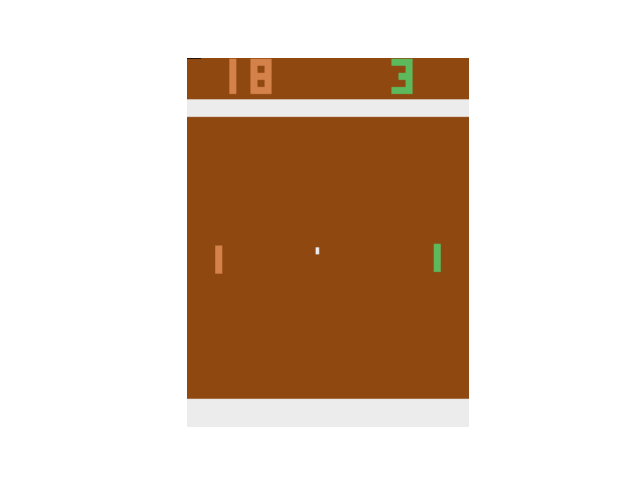
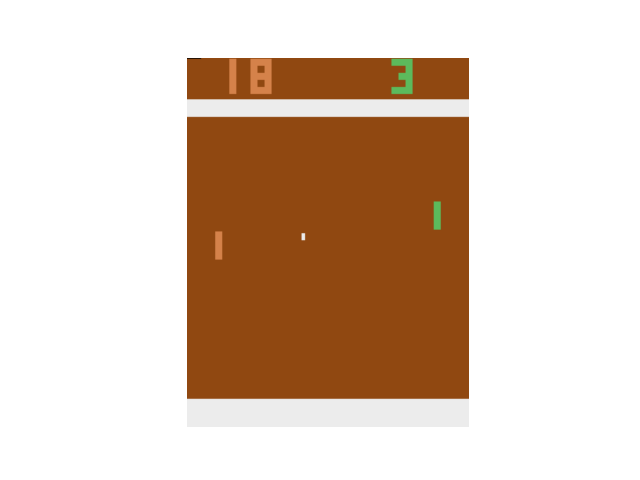
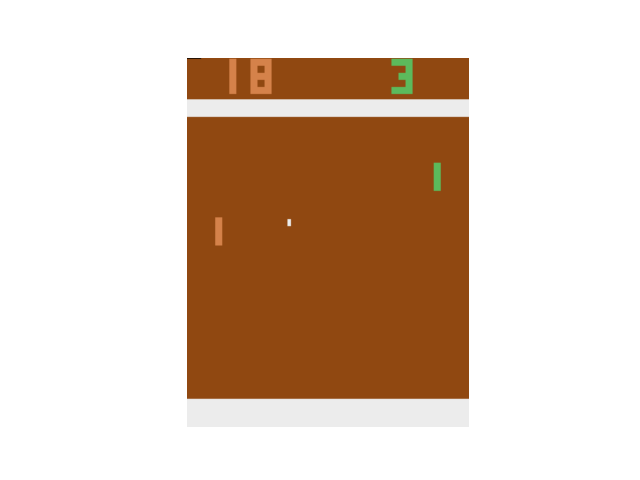
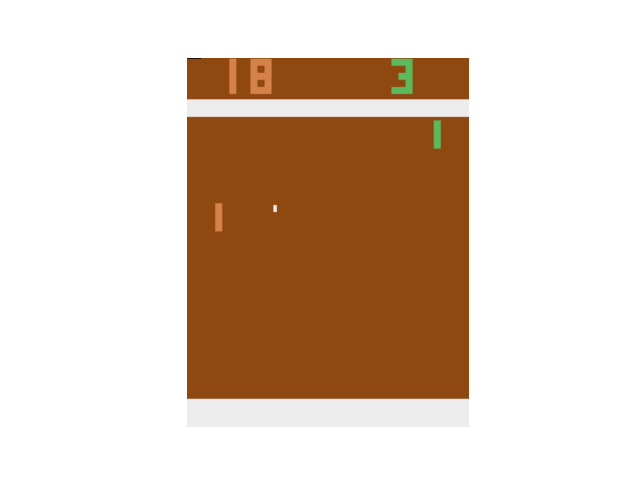
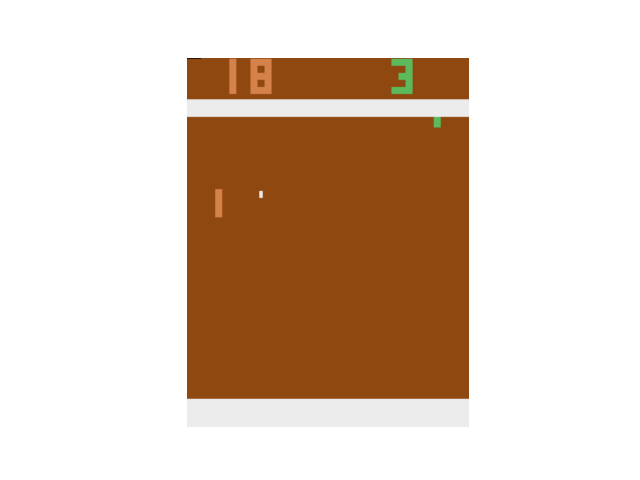
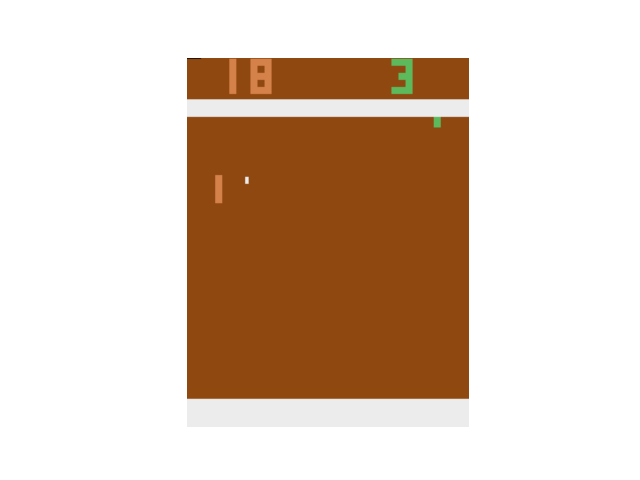
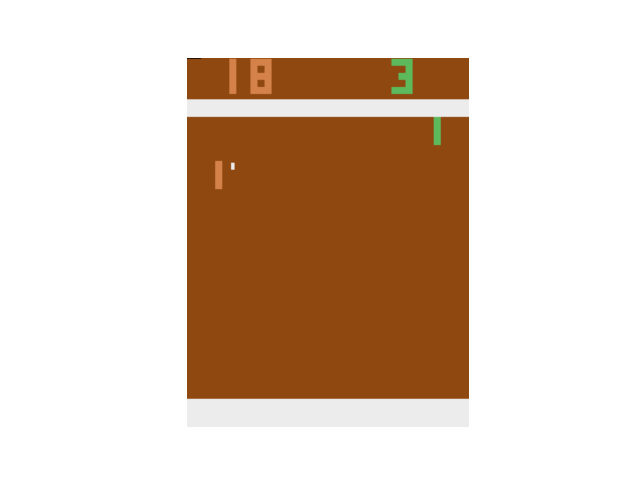
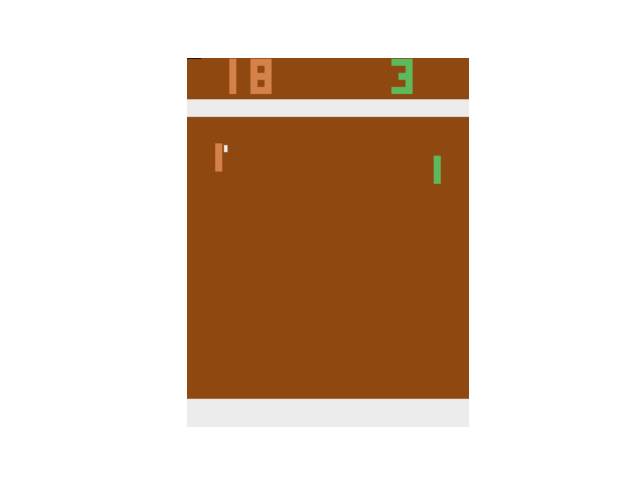
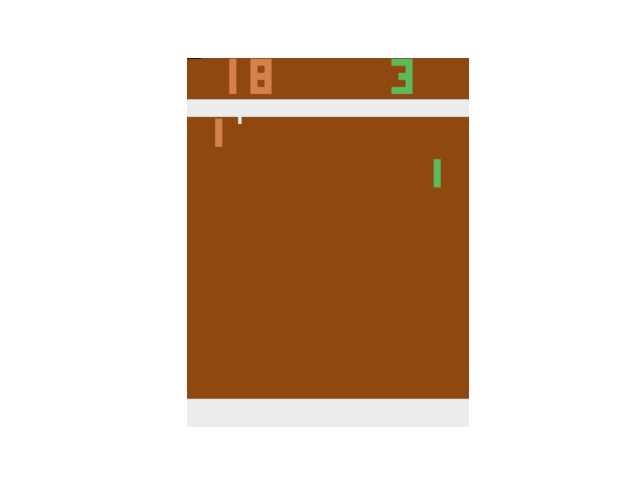
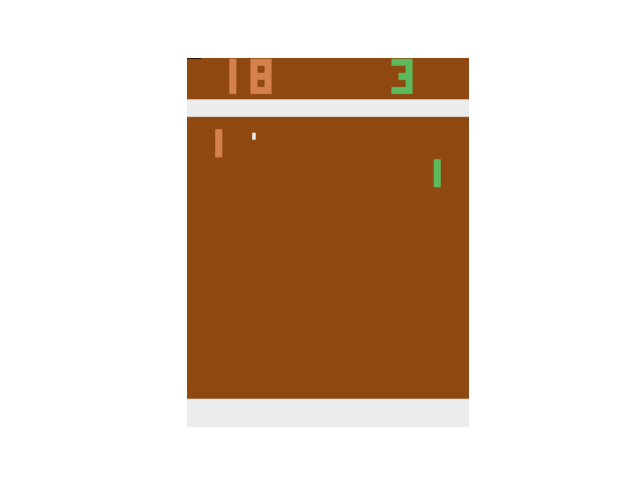
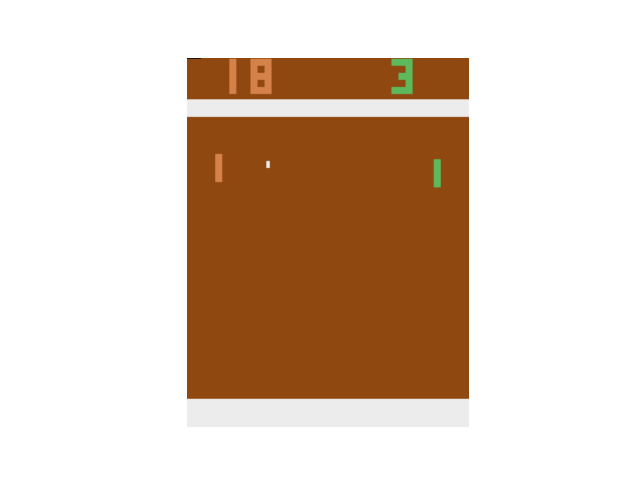
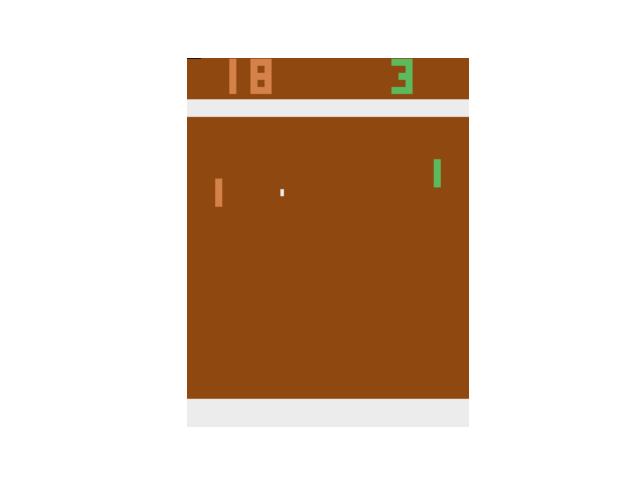
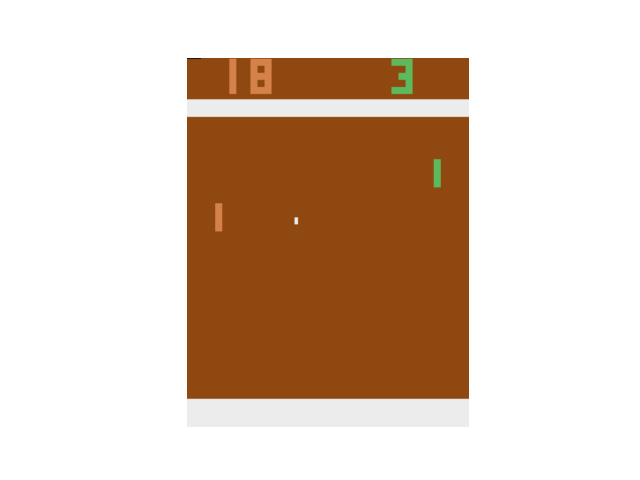
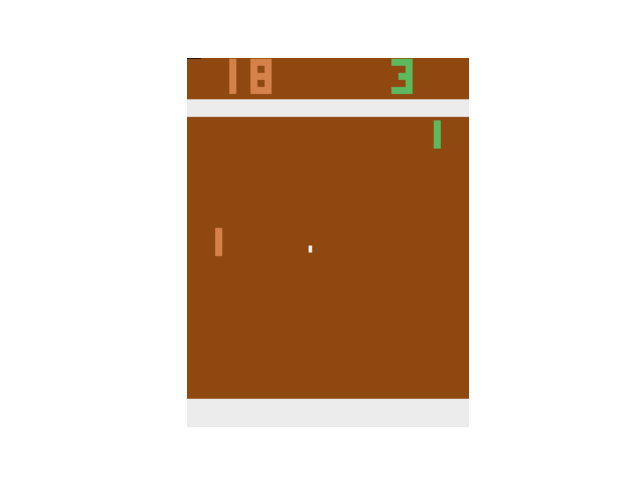
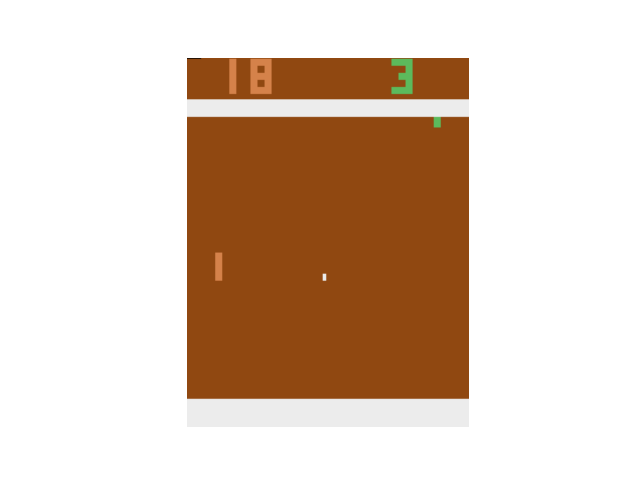
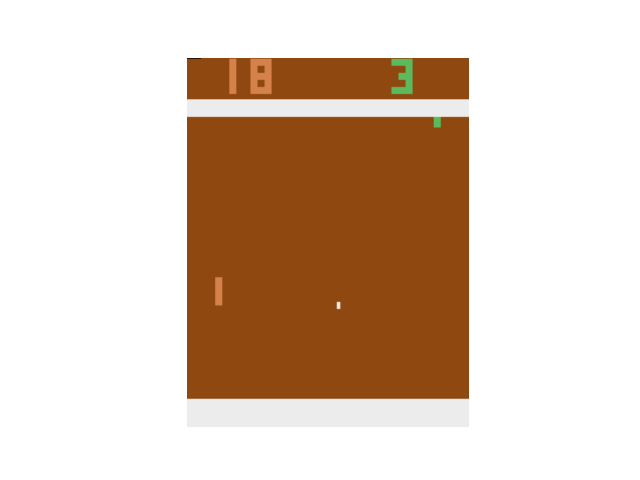
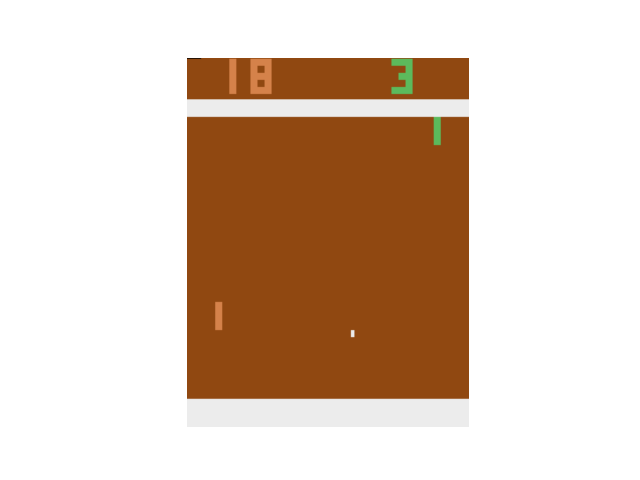
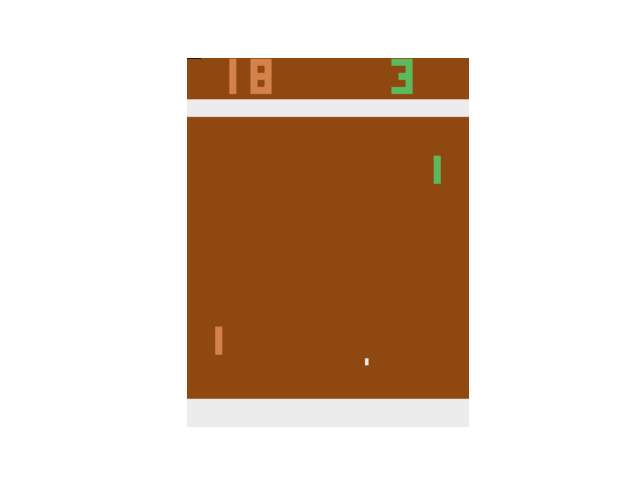
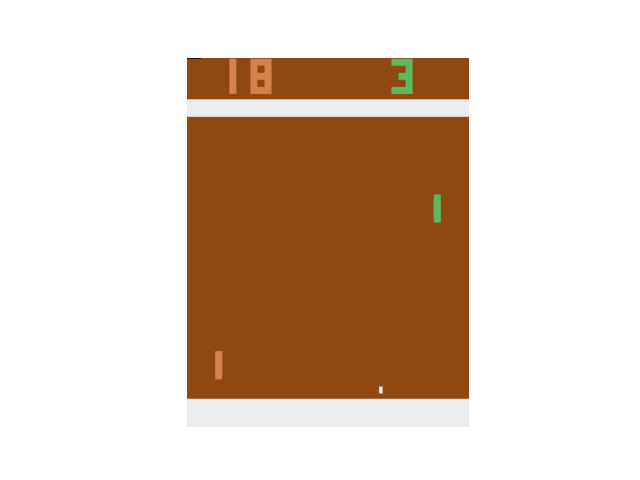
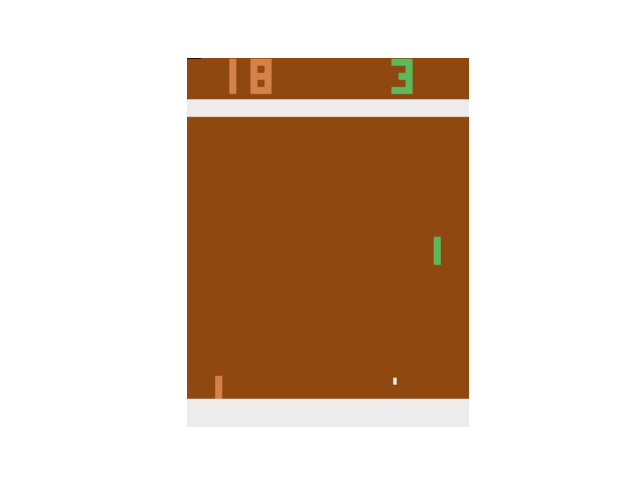
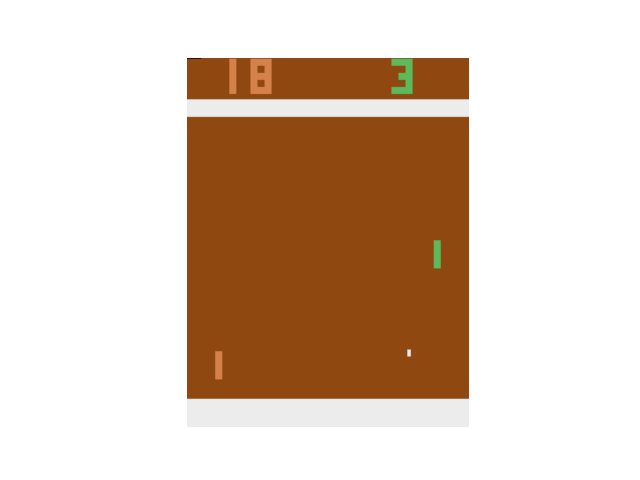
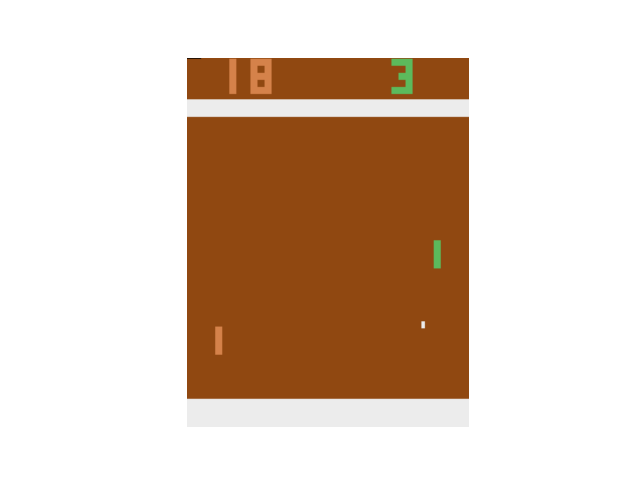
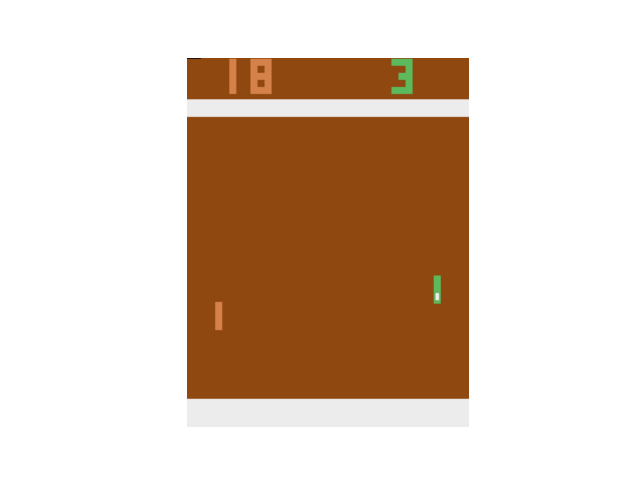
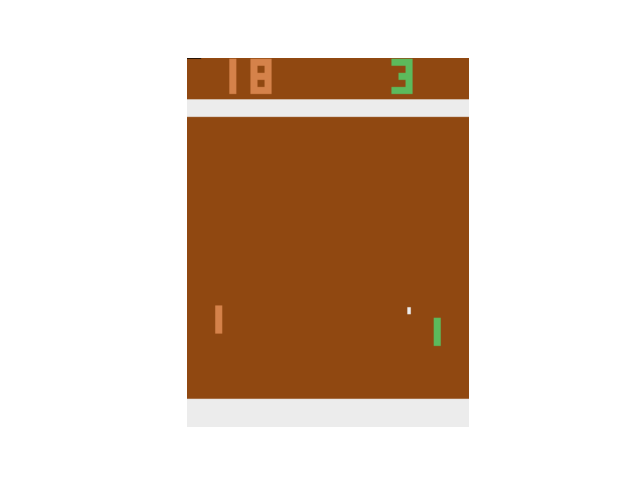
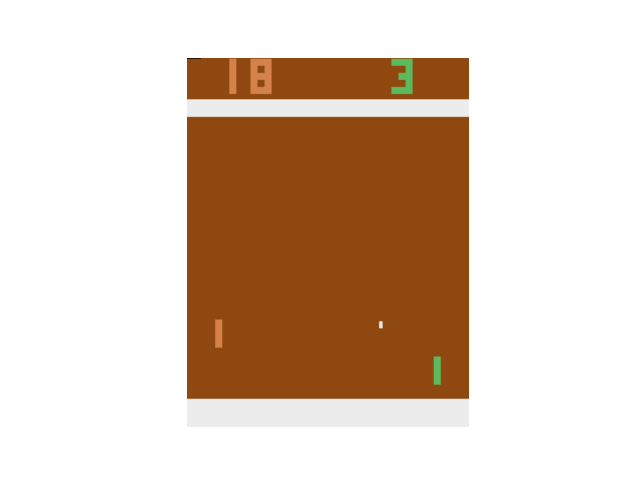
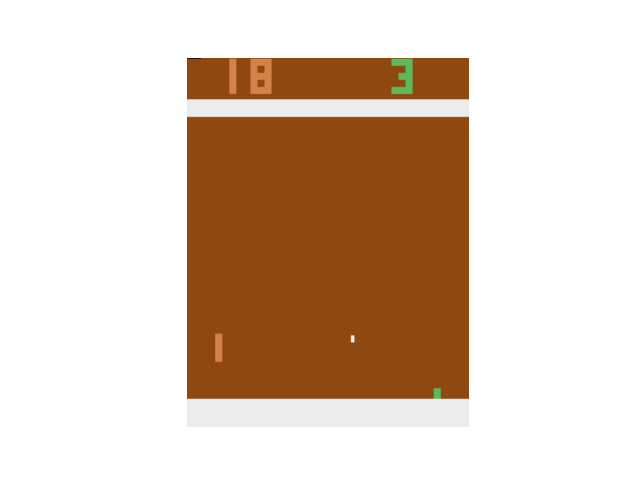
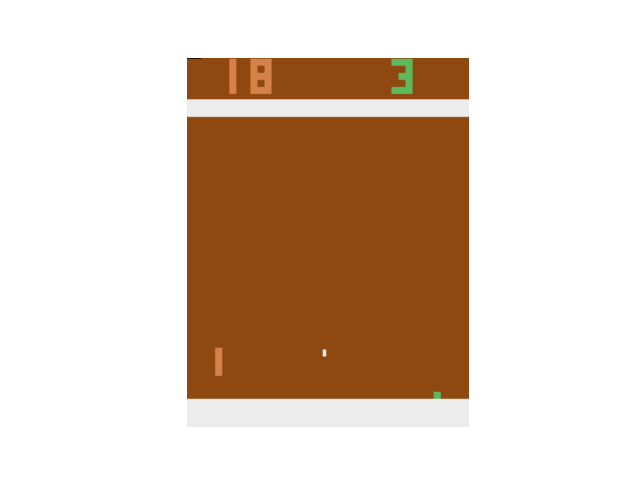
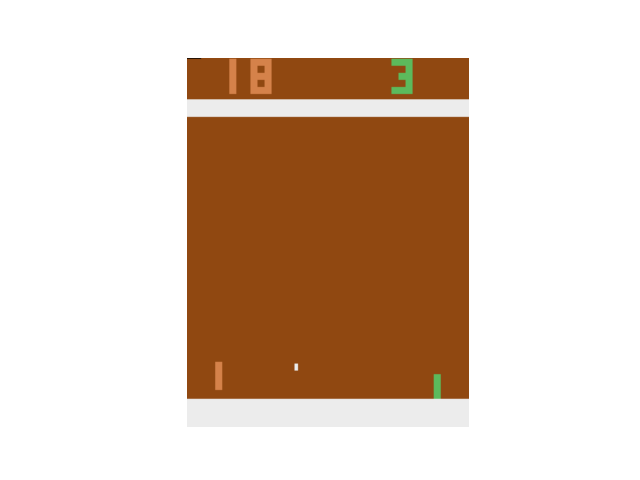
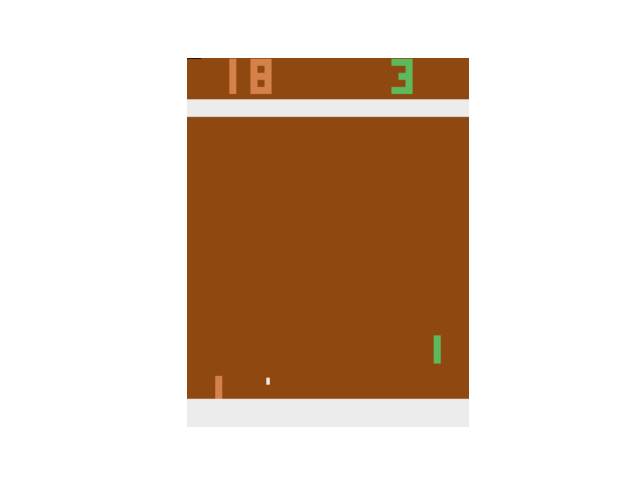
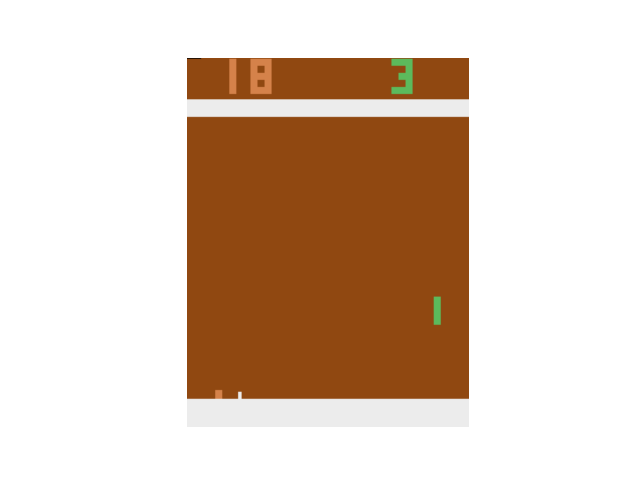
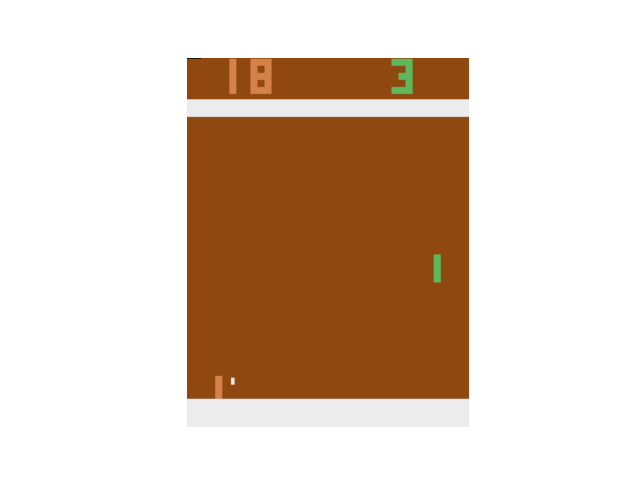
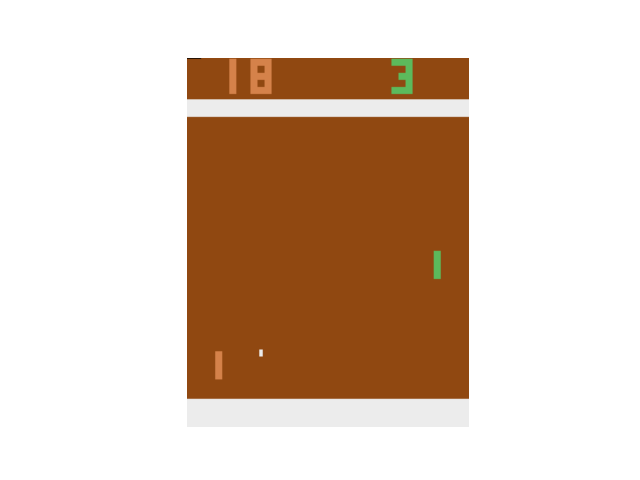
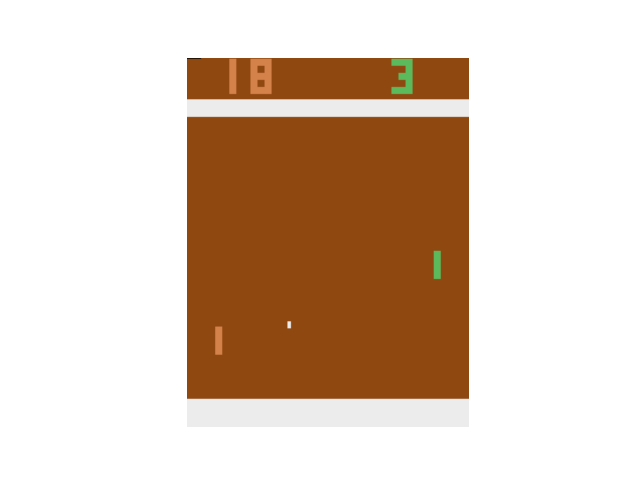
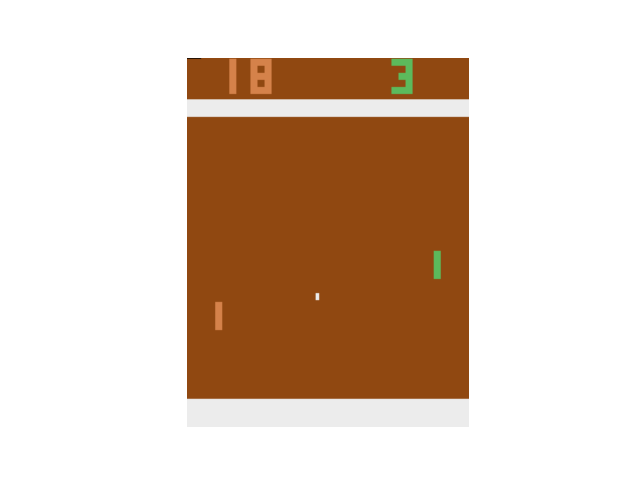
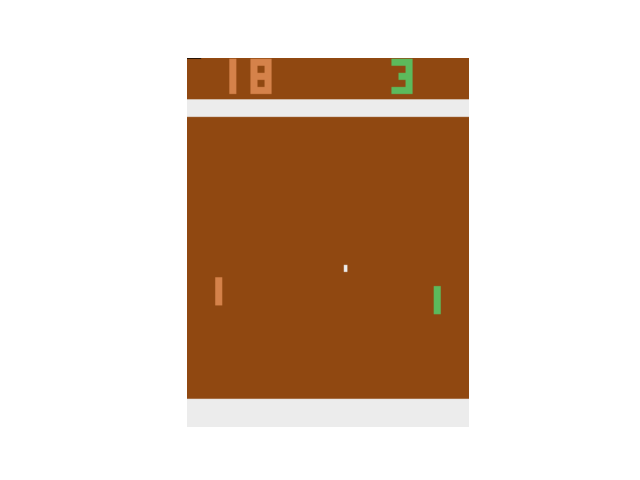
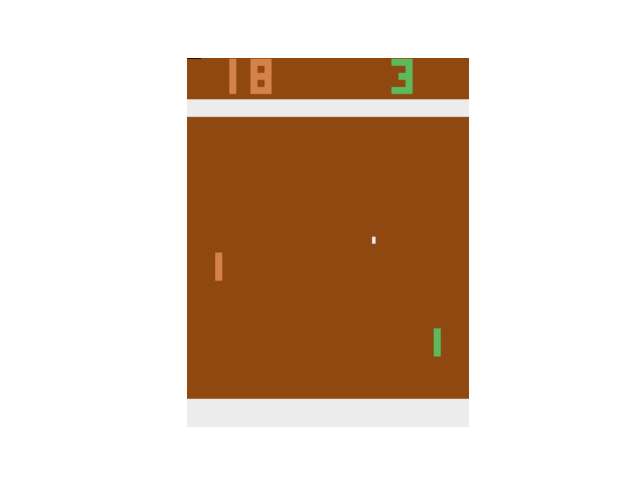
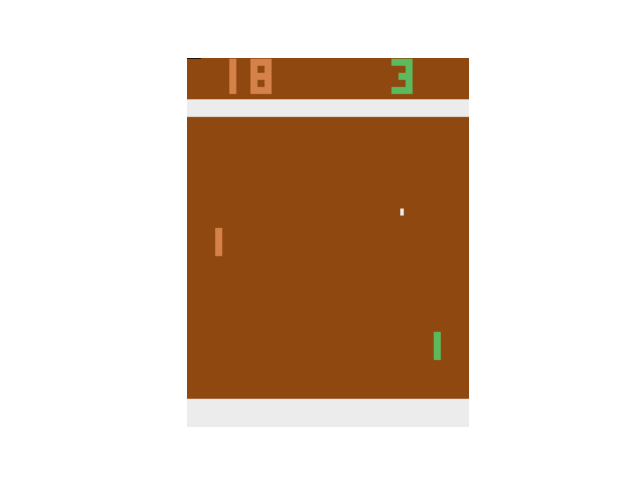
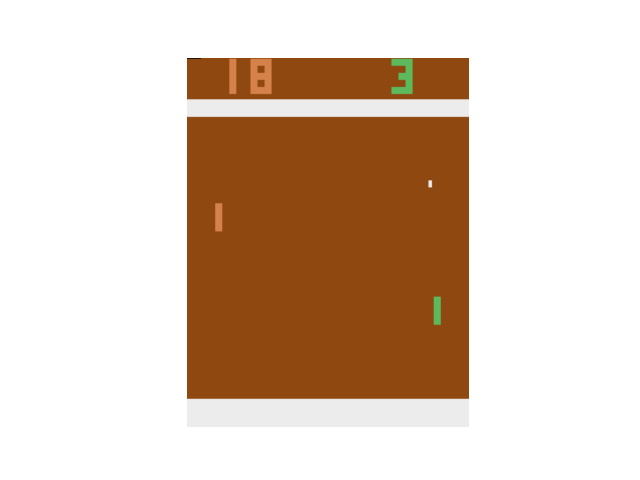
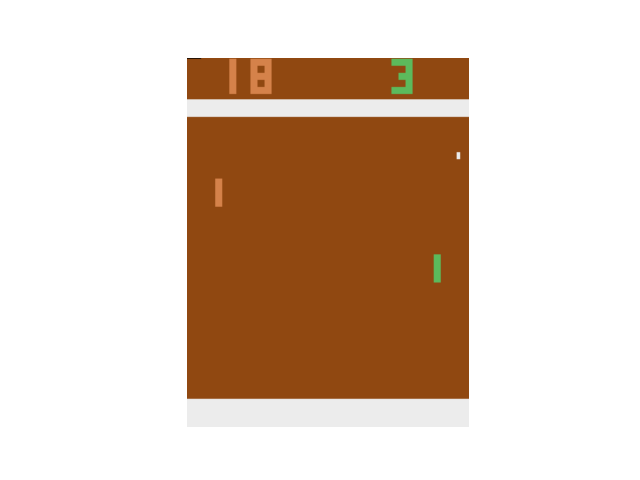
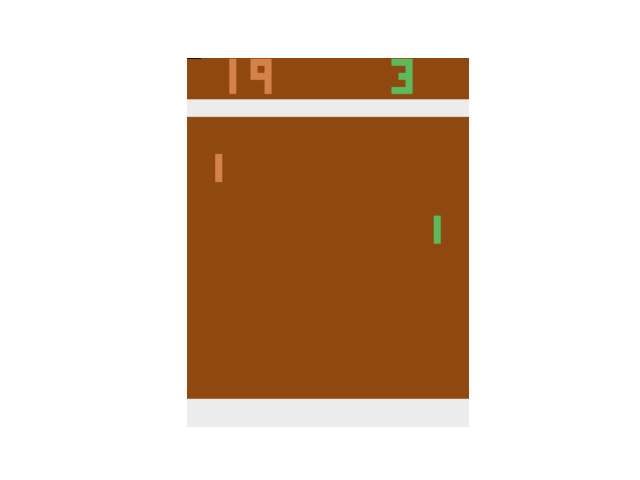
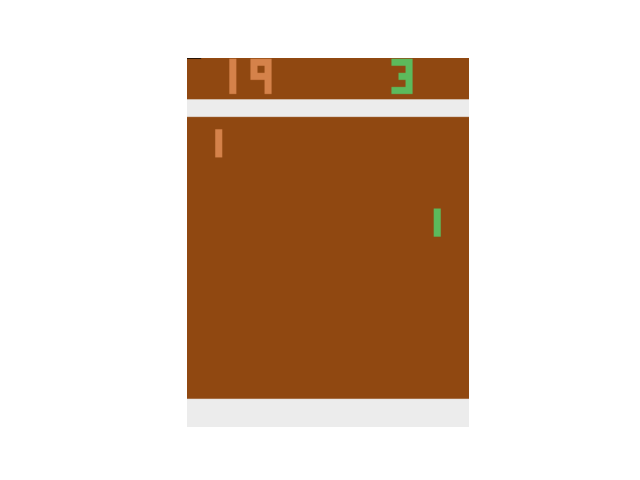
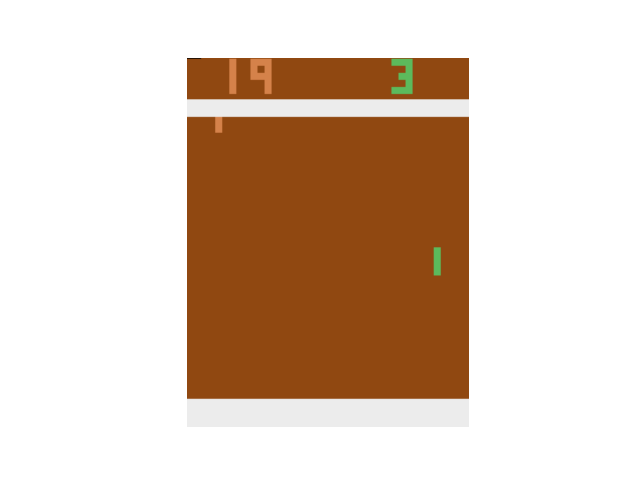
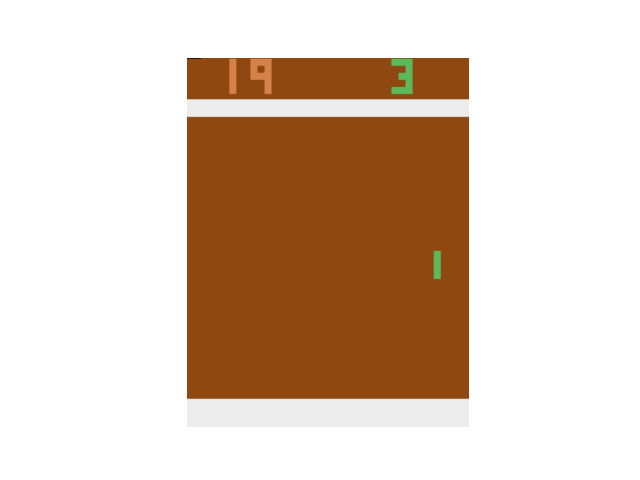
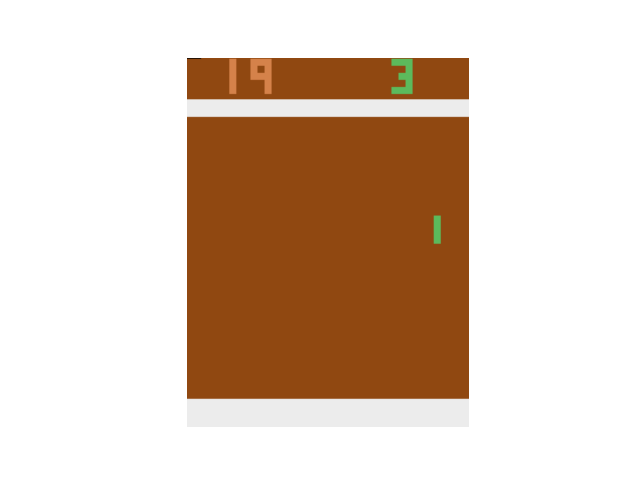
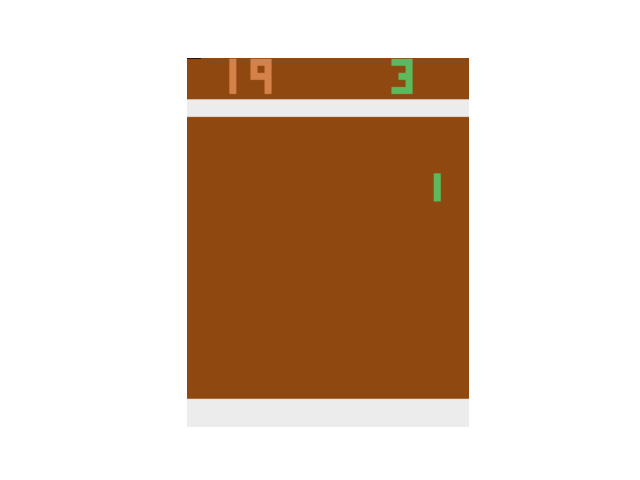
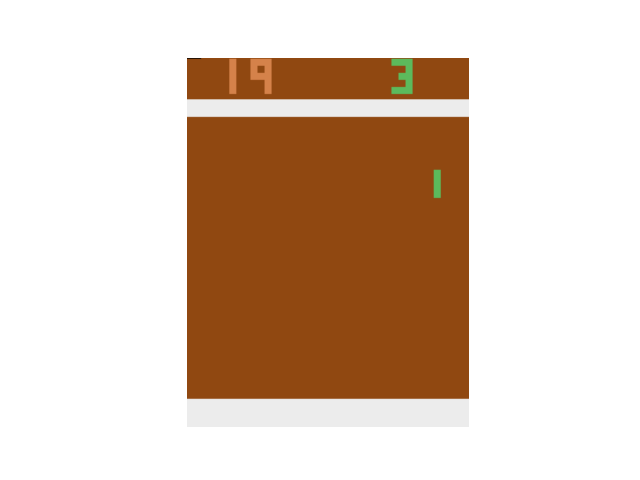
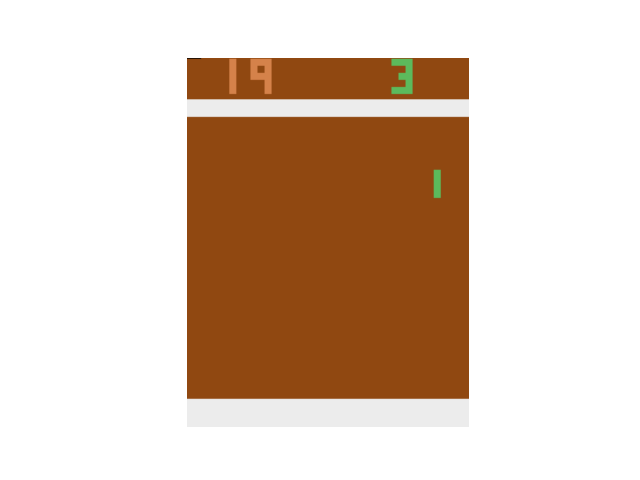
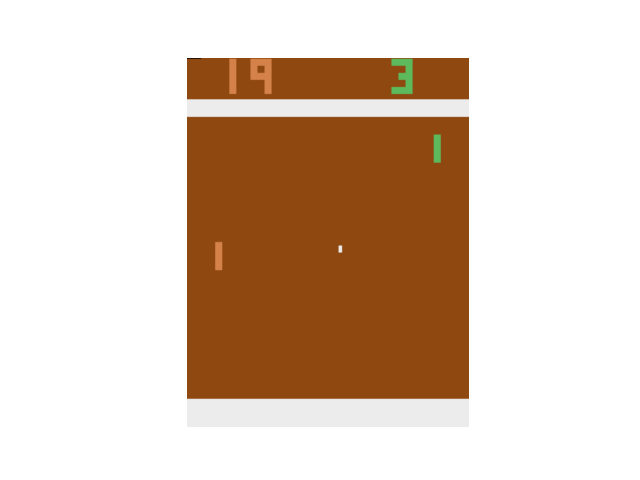
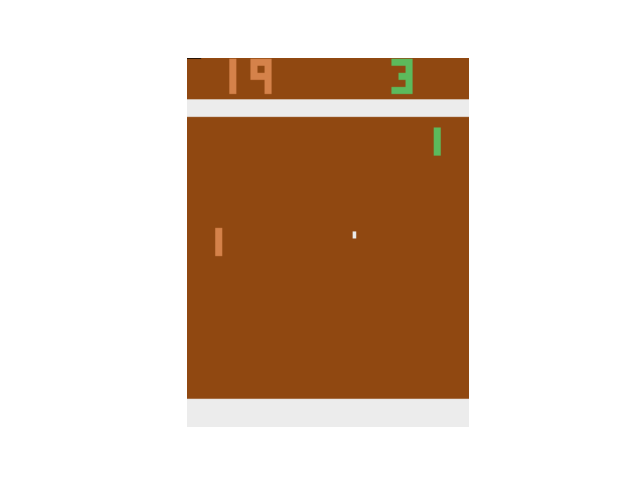
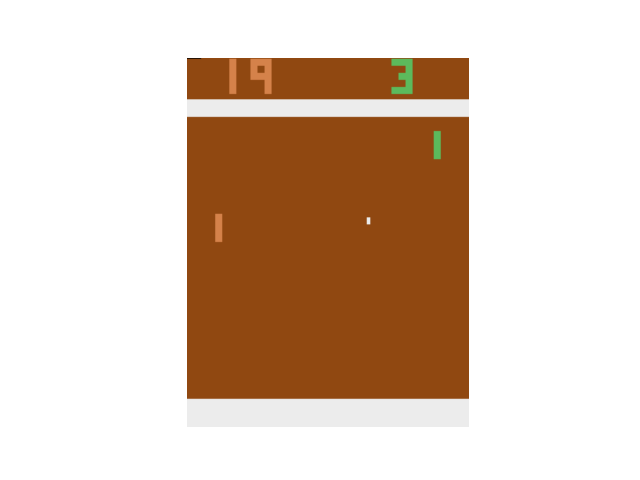
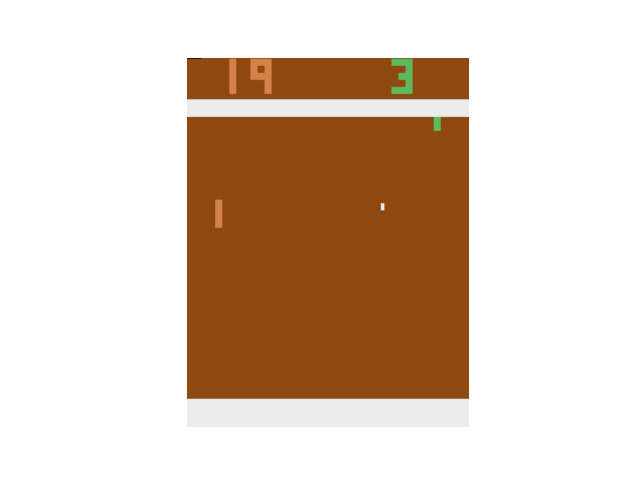
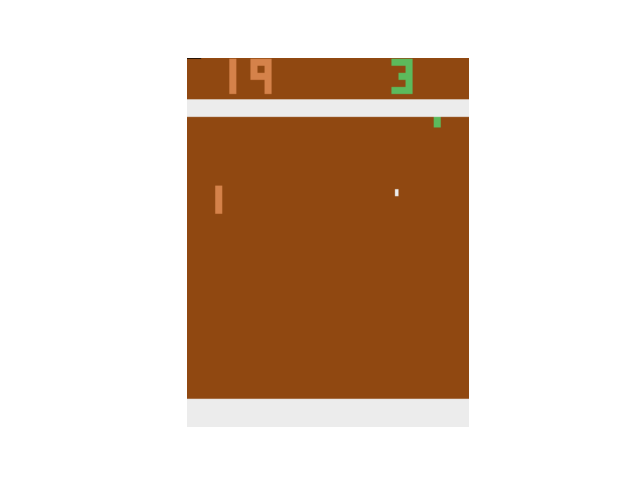
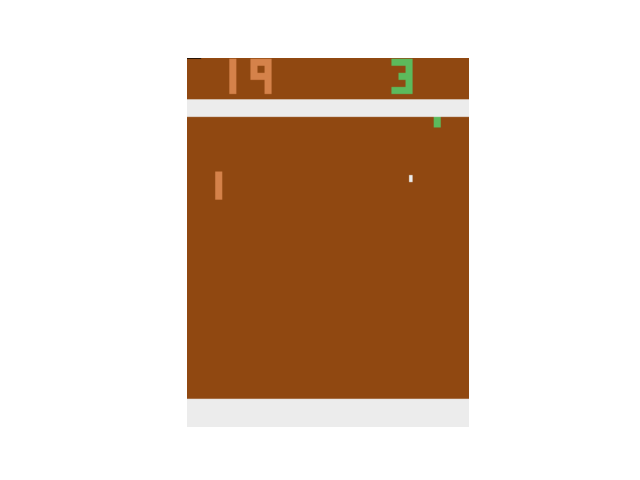
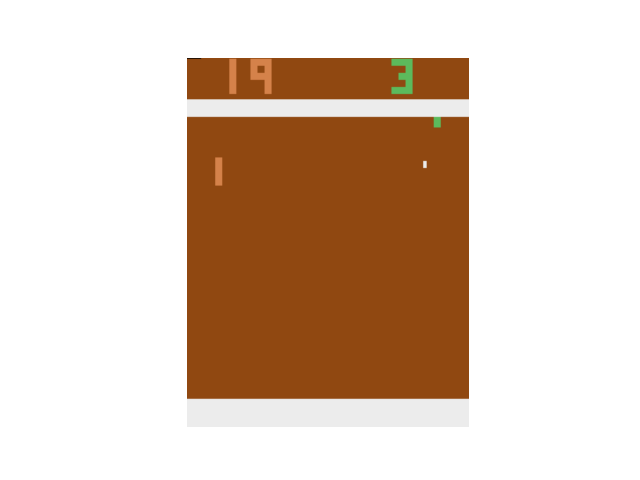
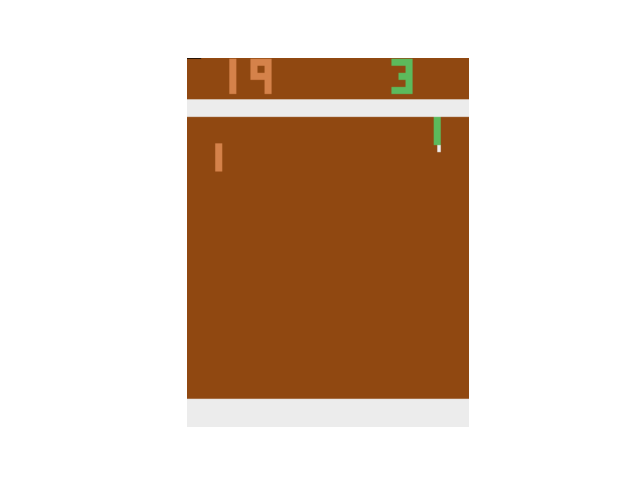
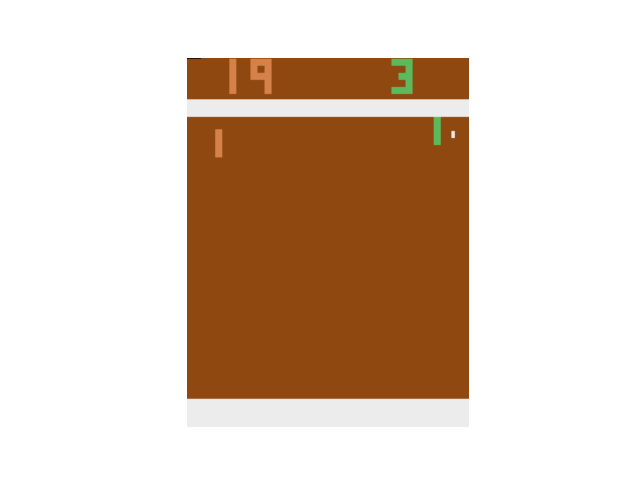
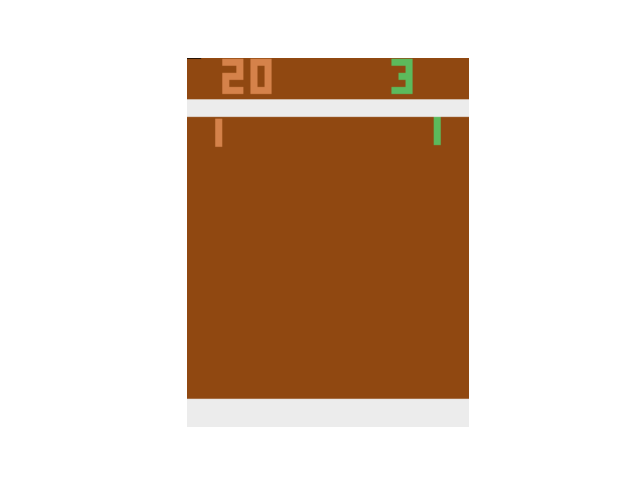
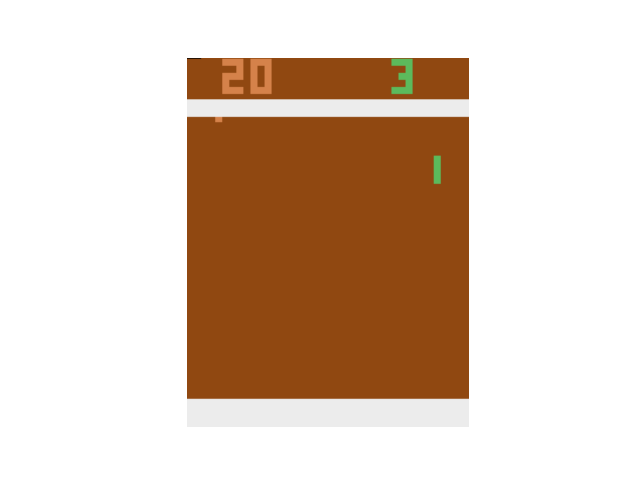
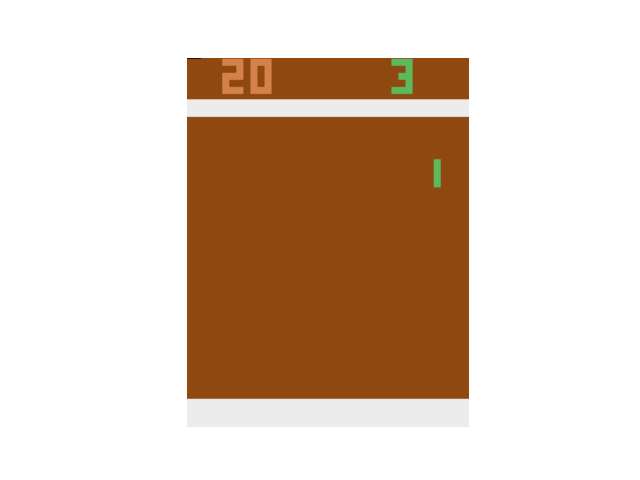
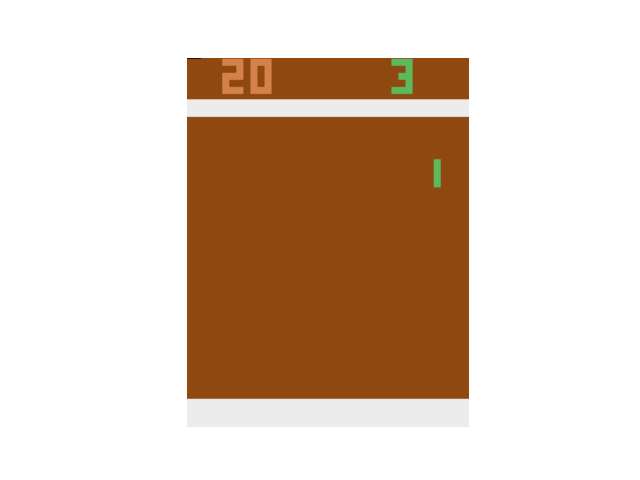
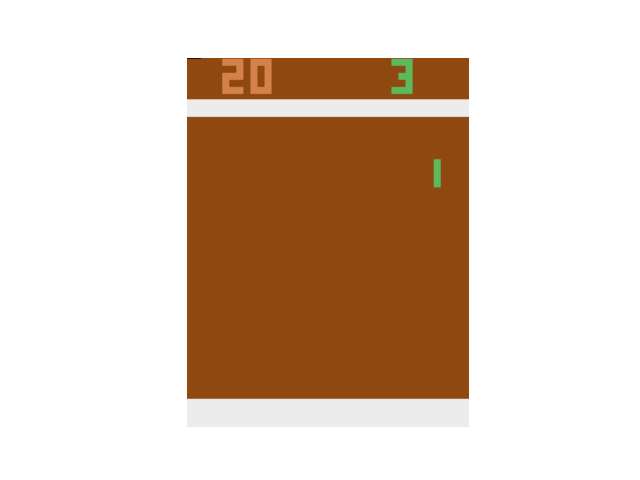
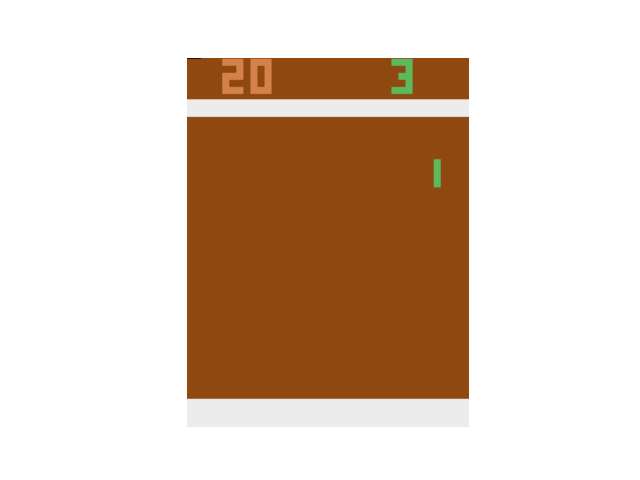
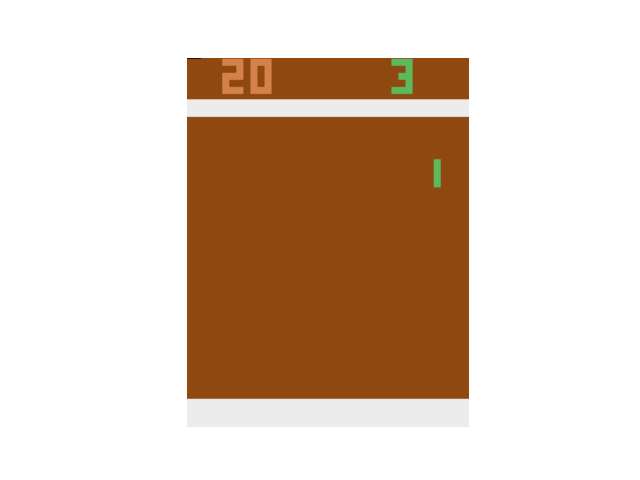
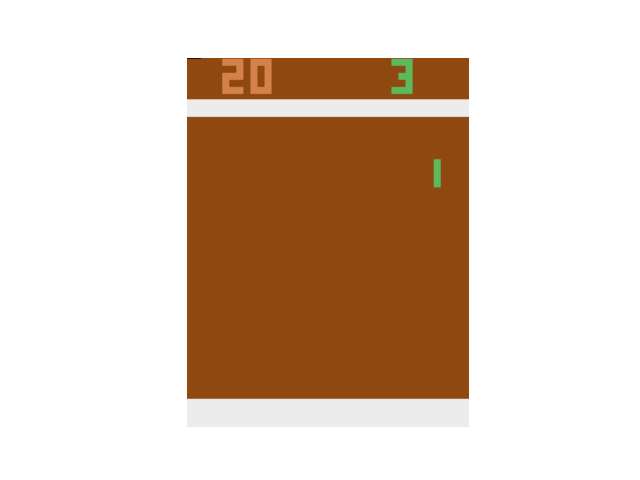
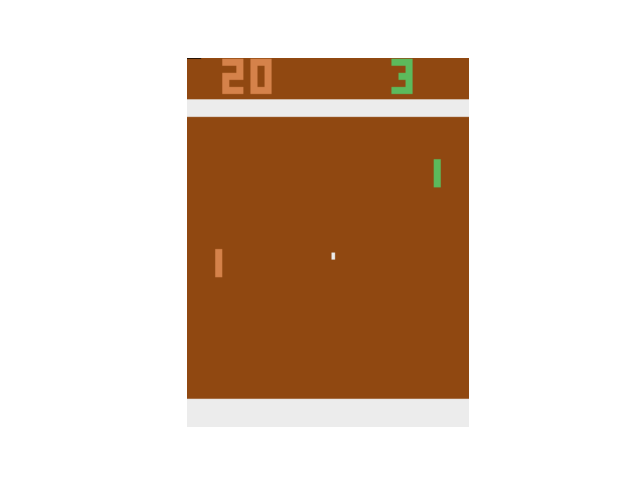
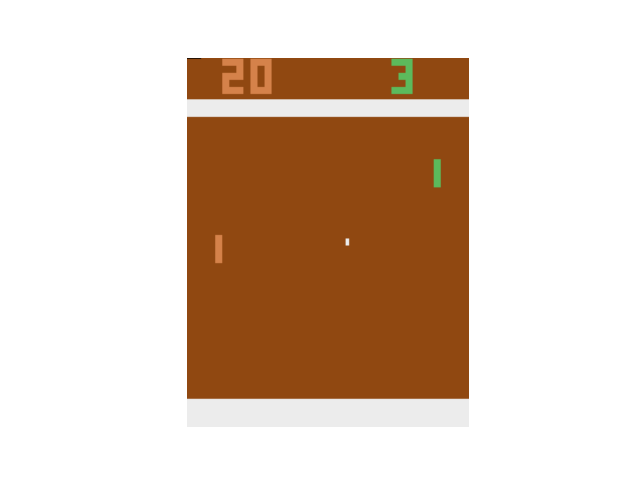
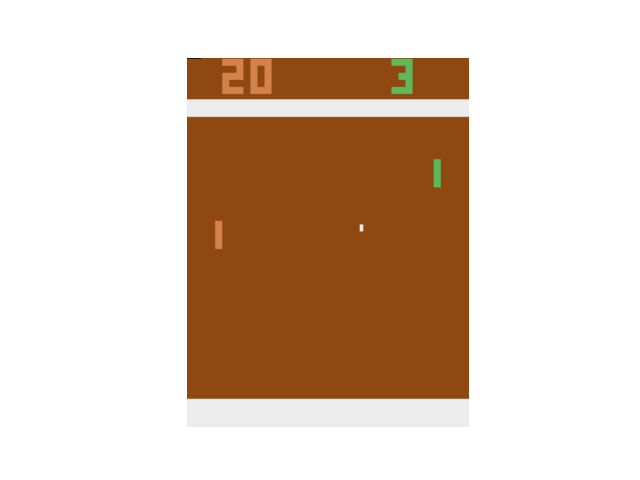
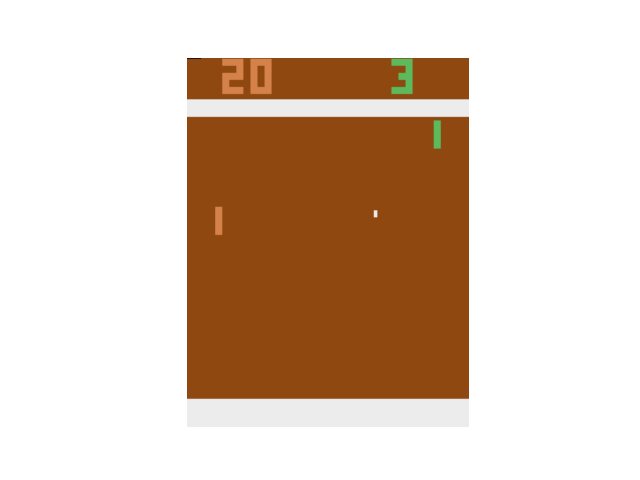
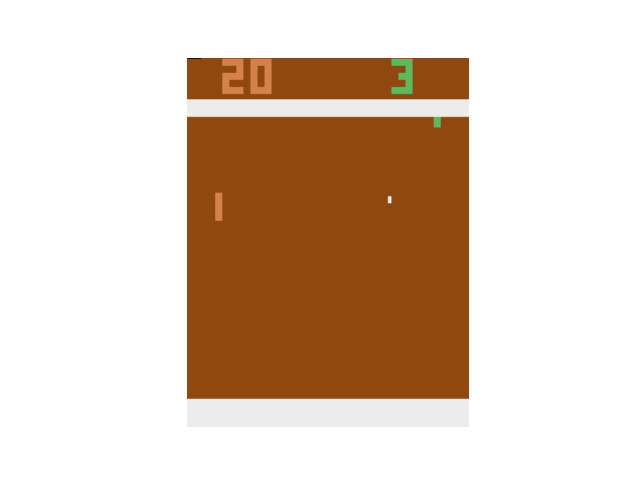
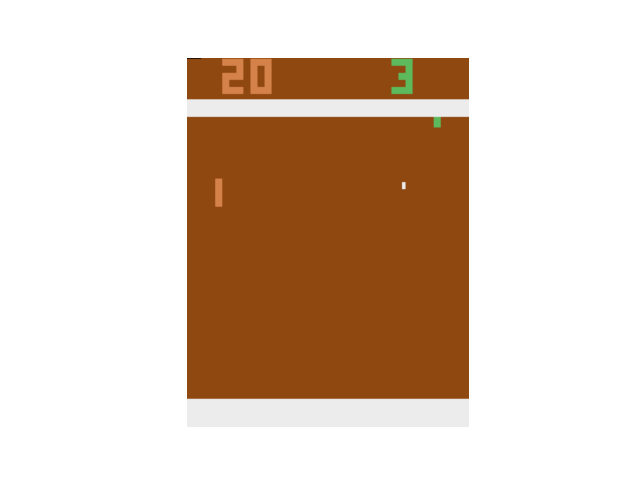
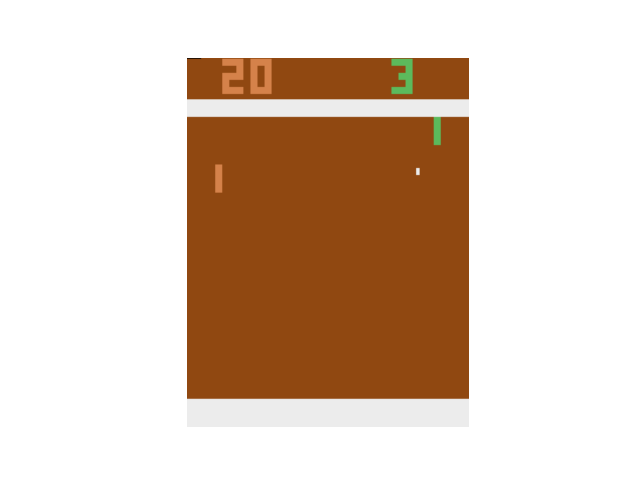
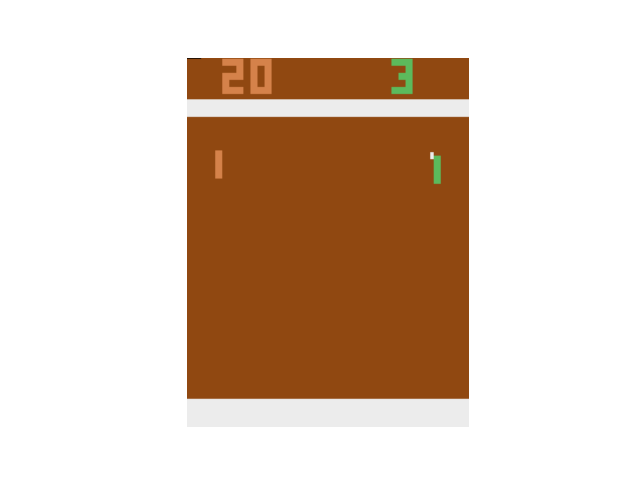
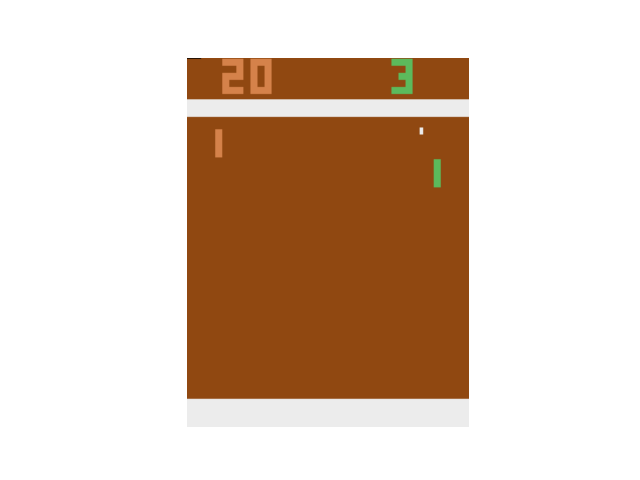
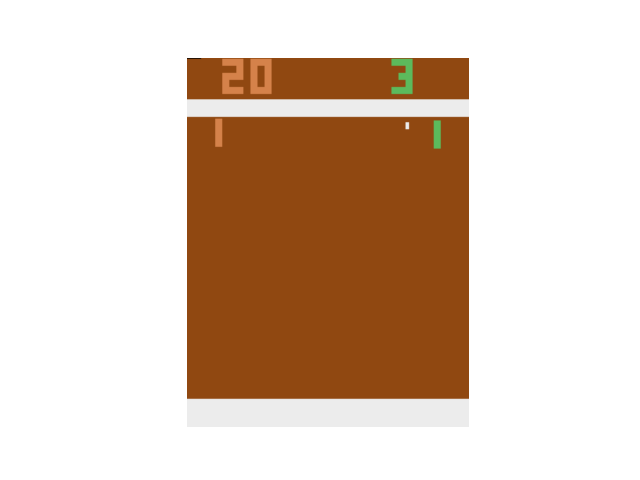
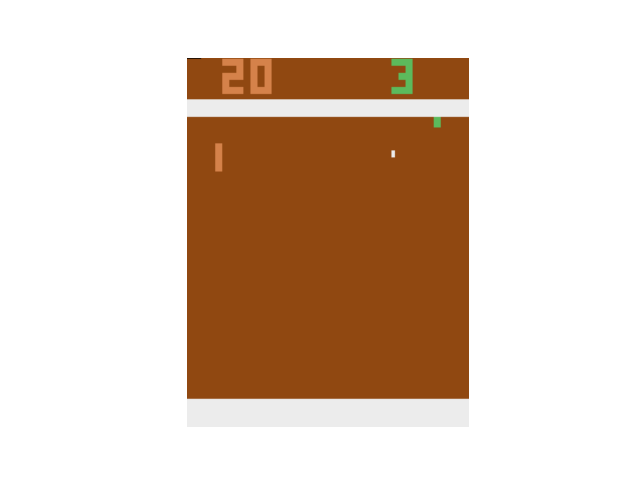
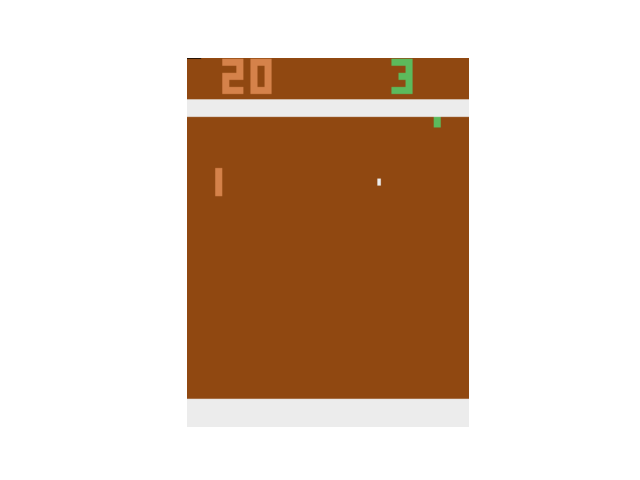
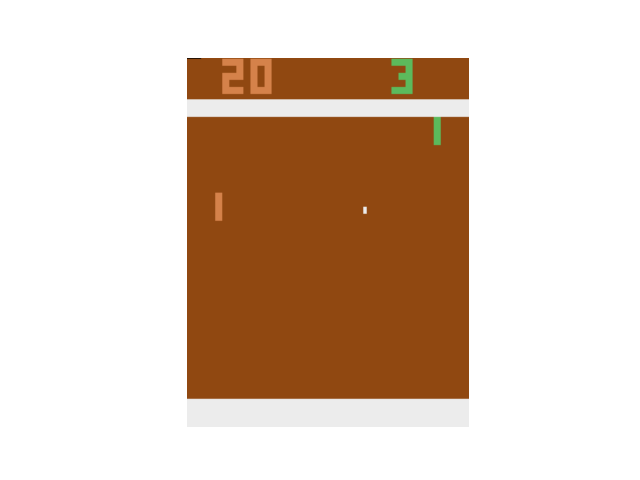
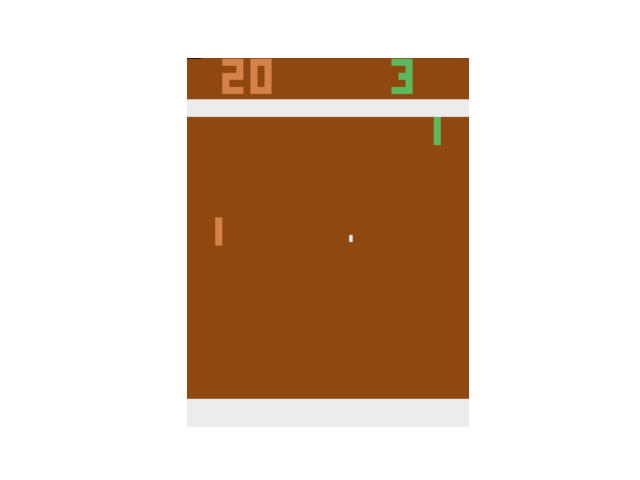
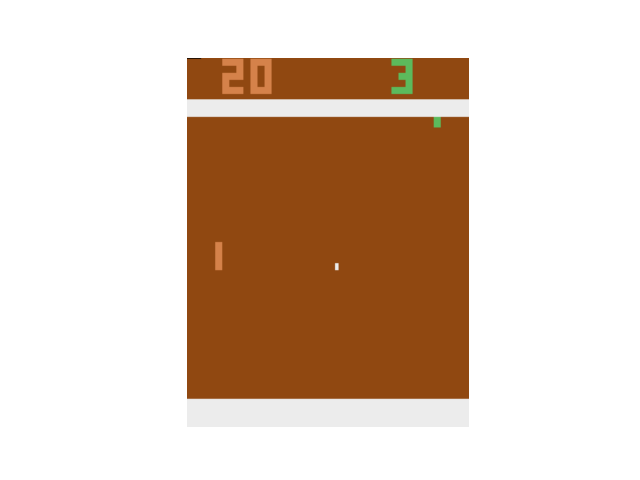
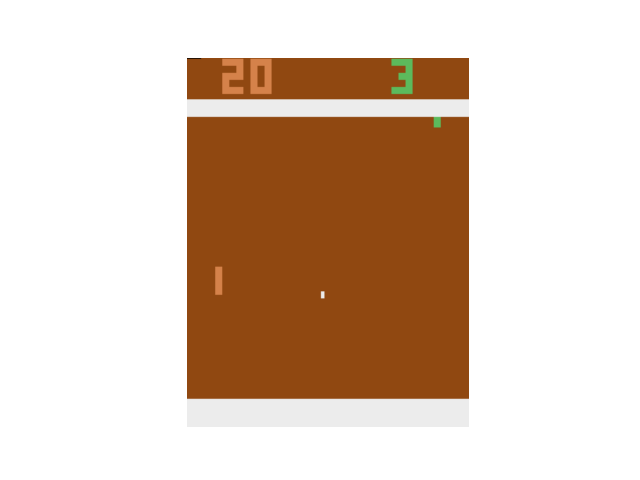
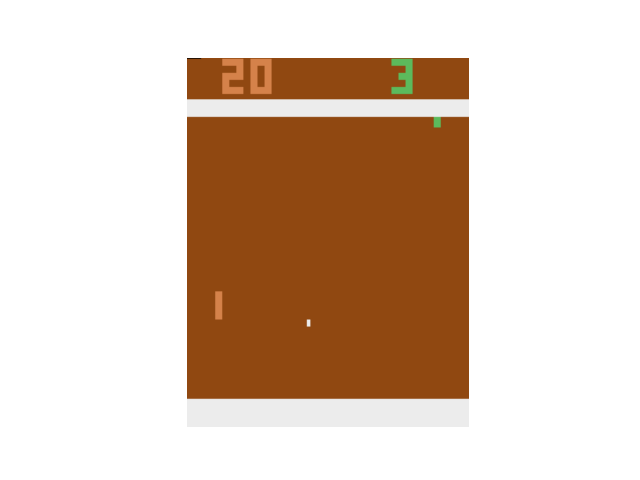
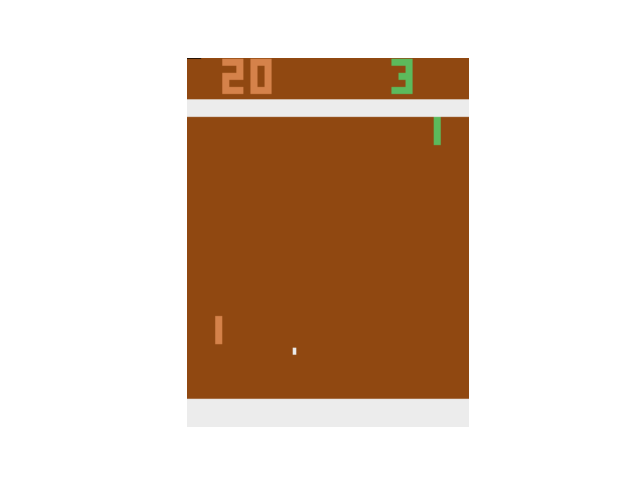
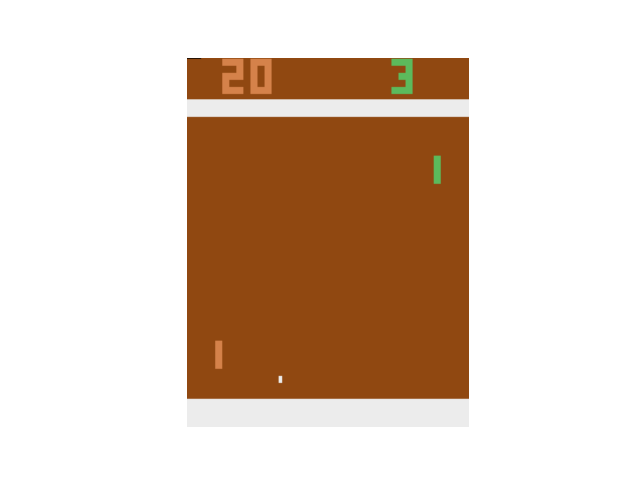
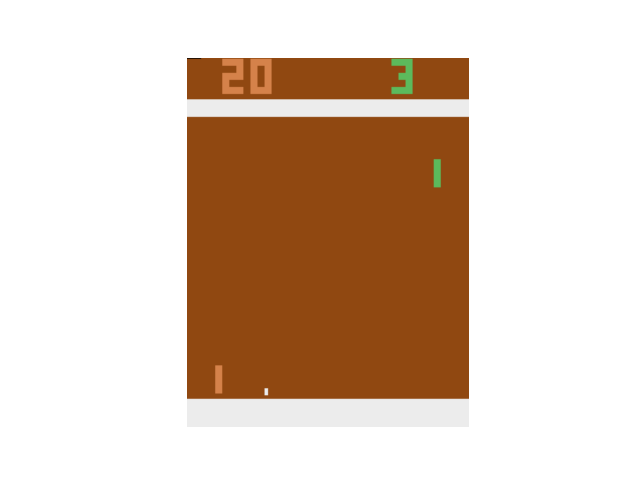
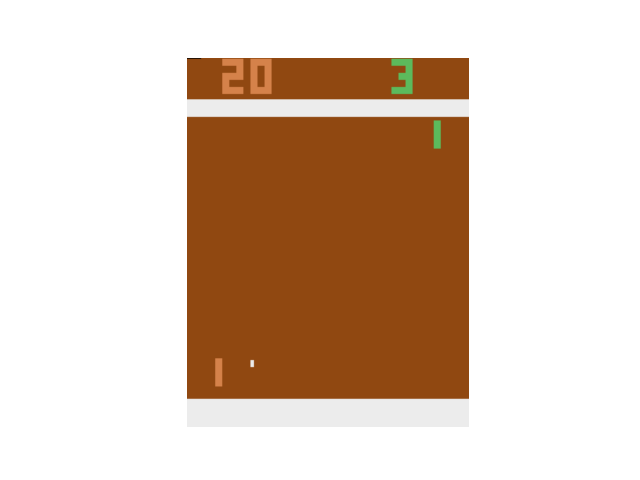
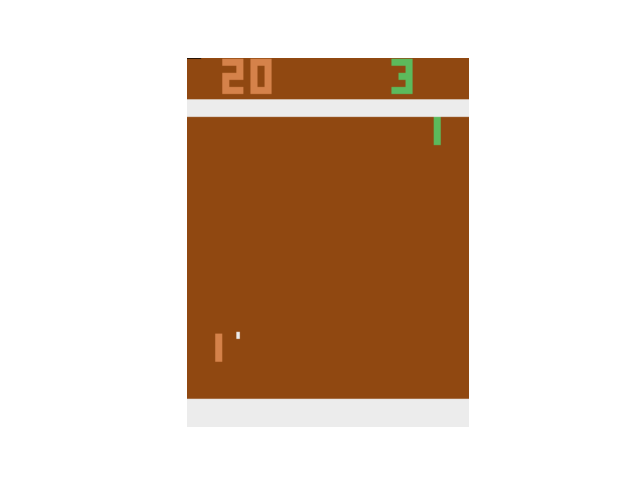
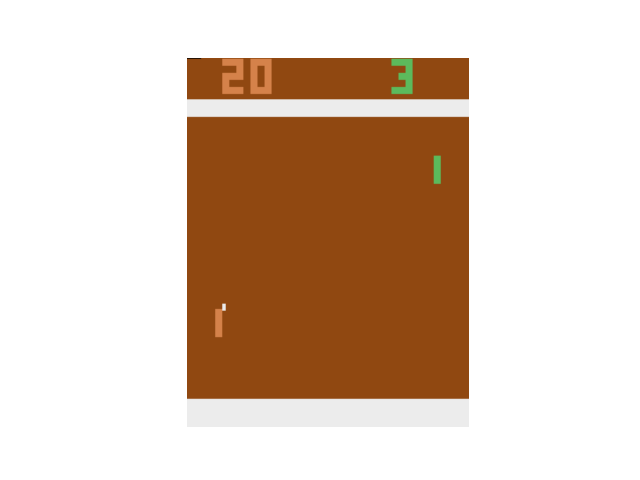
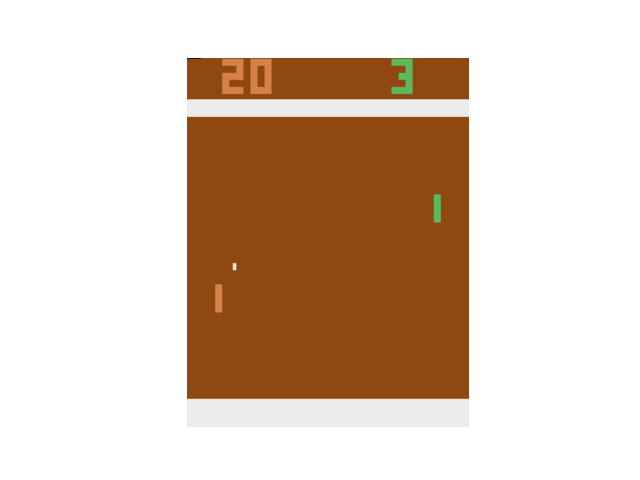
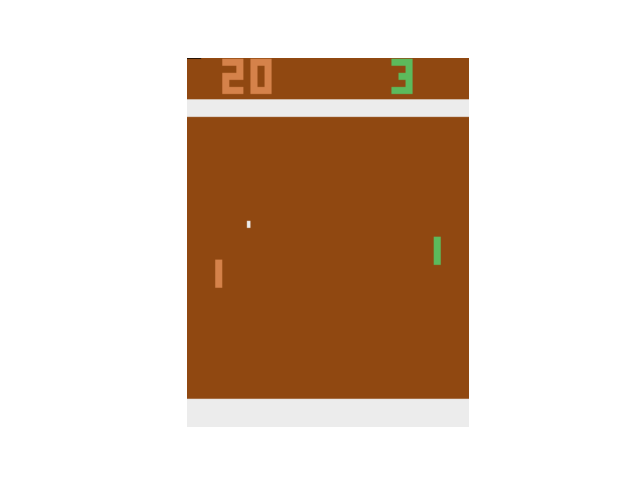
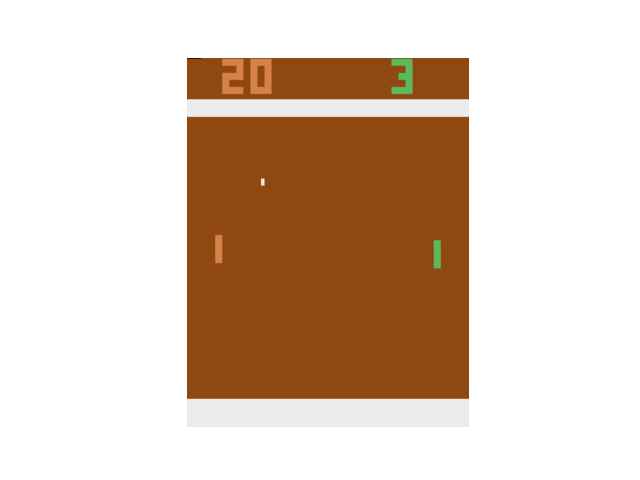
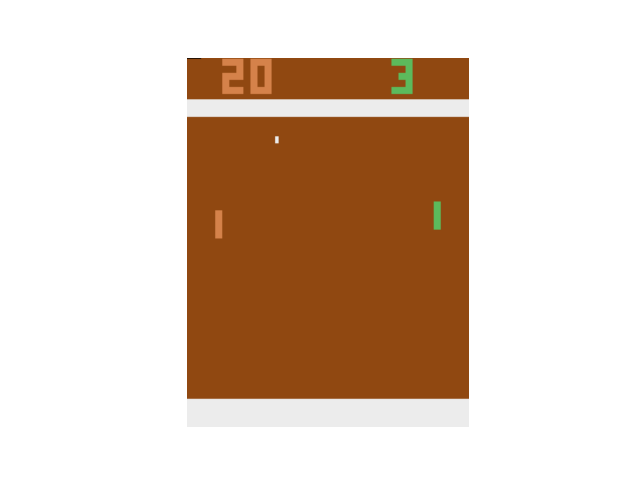
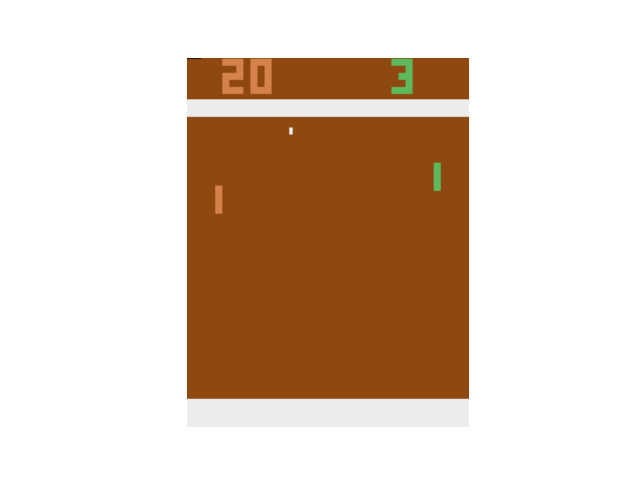
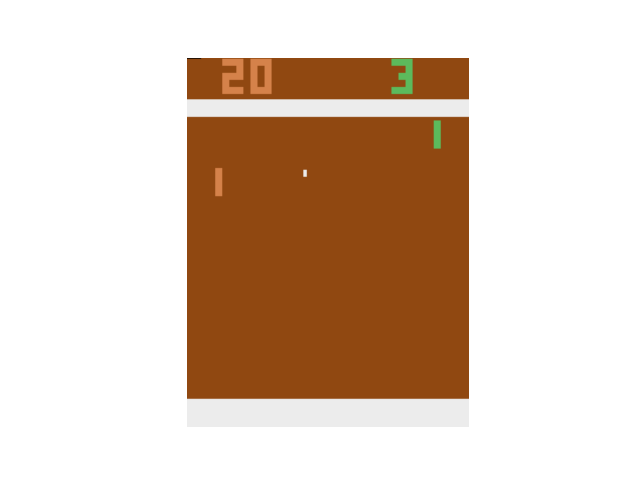
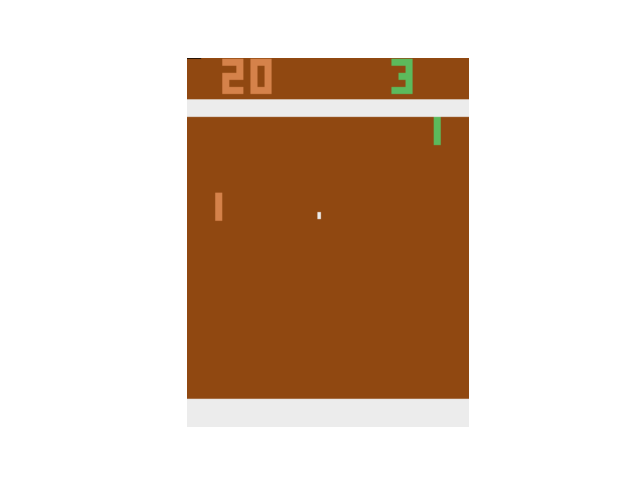
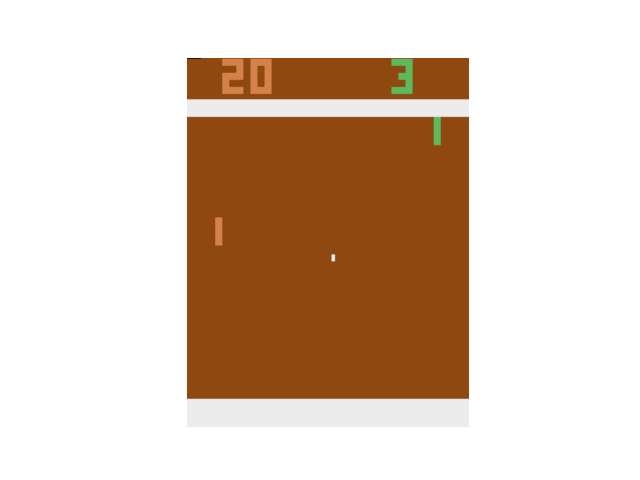
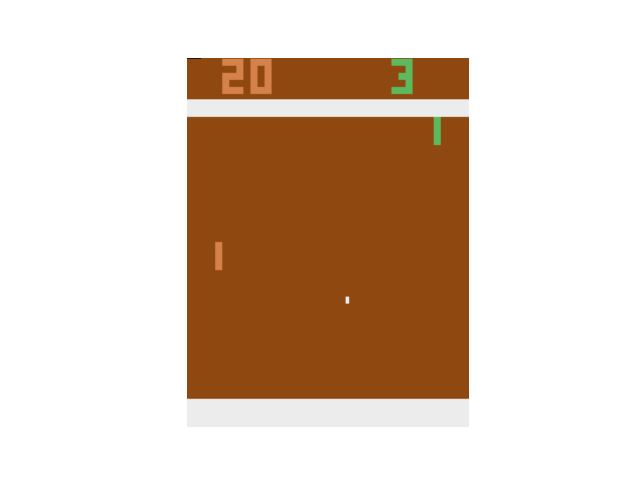
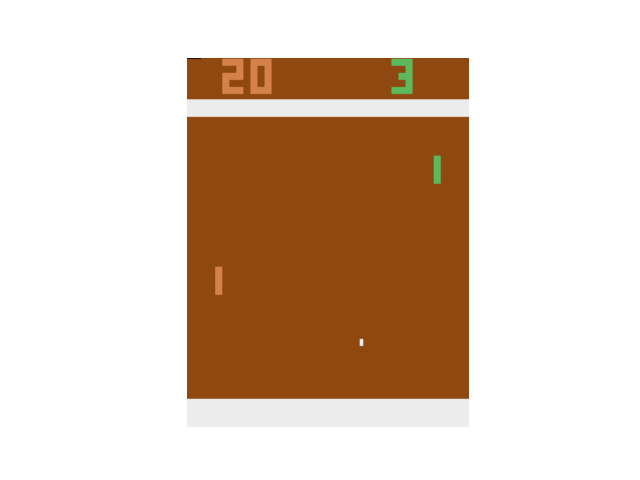
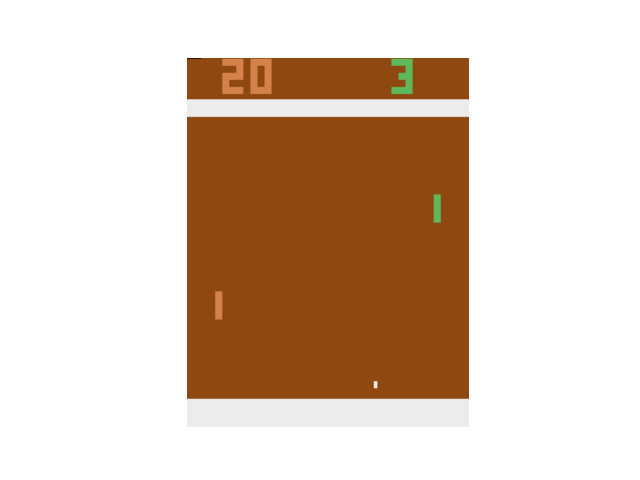
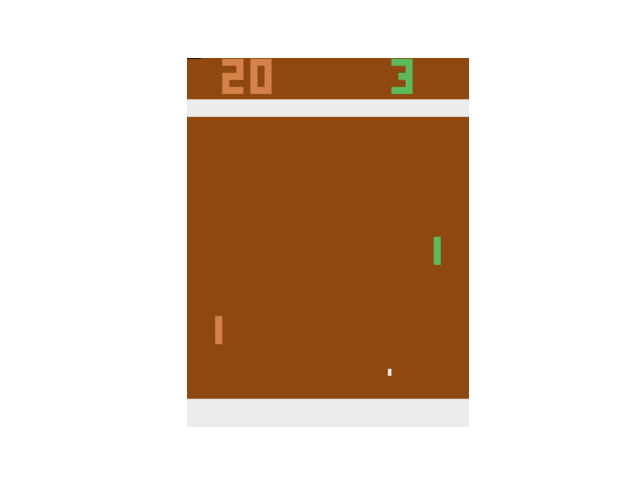
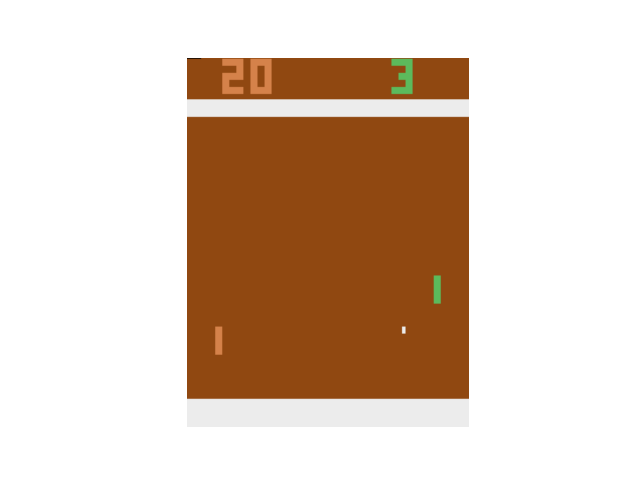
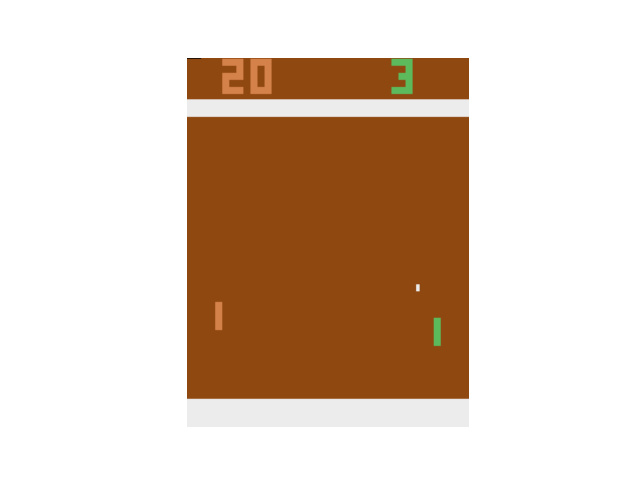
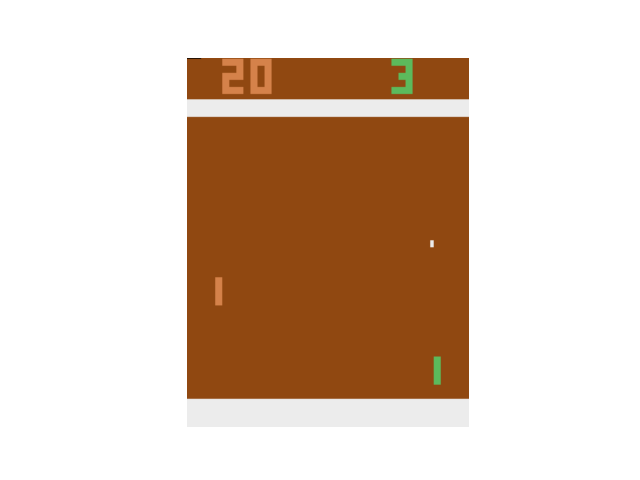
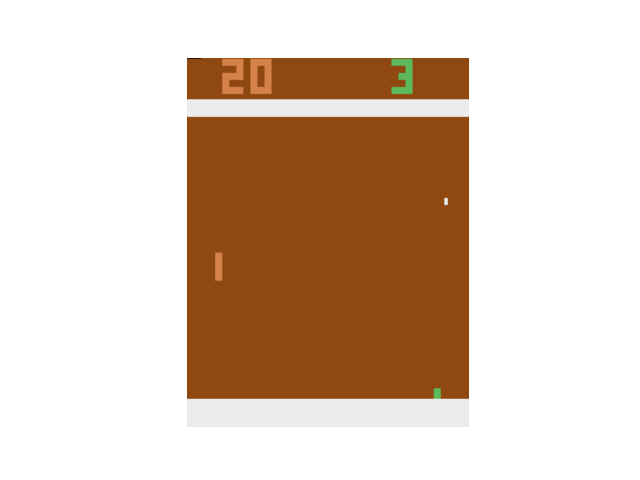
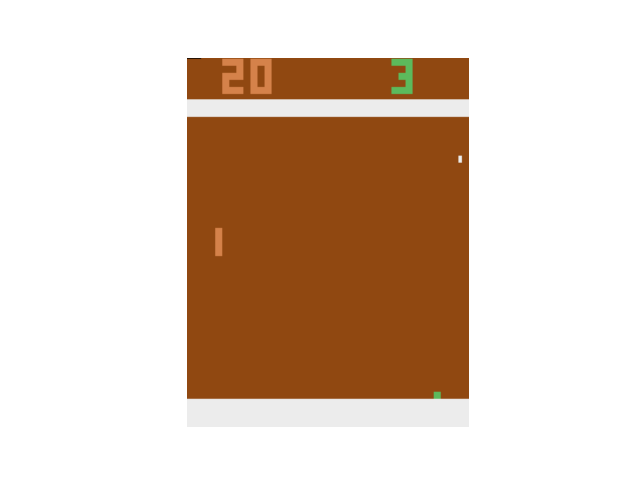
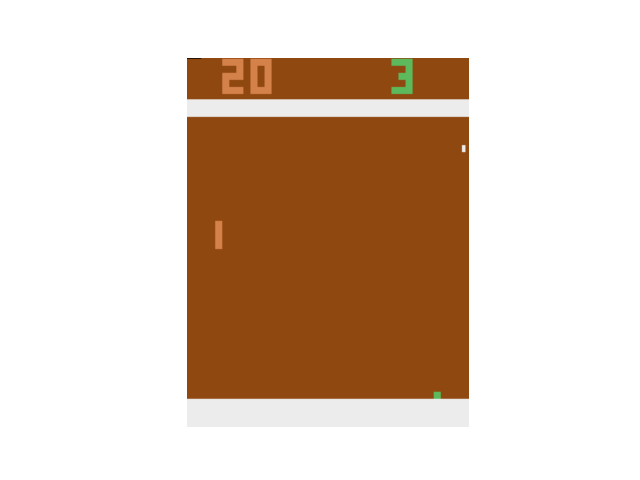

In [6]:
%%time
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# policy = torch.load('REINFORCE_solution.policy', map_location=torch.device('cpu')) ## solution trained policy
policy = torch.load('20240218_REINFORCE.policy', map_location=torch.device('cpu')) ## my trained weights

## play game after training! don't worry if the score looks like 20:6 (Game: RL player).
## the RL algo will be improved in the PPO notebook.
pong_utils.play(env, policy, time=2000)

In [ ]:
# ## save your policy!
# from datetime import date
# torch.save(policy, f"str(date.today()).replace('-','')_REINFORCE.policy")

# **\<BOTTOM>**  